# Modeling Notebook 2 

## Exploring Decision Trees and Random Forest Regressors

In this notebook, we will explore Decision Trees and Random Forest Regressors with hyper-tuning of the parameters to get the best results 

`Note` : Since we have processed our train data in multiple different ways, we will be training models using different processed train data to get the optimal results

In [4]:
# Importing relevant libraries, functions, and models 
from bs4 import BeautifulSoup as soup
import requests
import re
import boto3
import sys
import os
import pandas as pd
import numpy as np
import csv
import s3fs
from math import pi
from itertools import chain

from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast, StructType
from pyspark.sql.types import *
from pyspark.sql.functions import col, split, slice, count, when, expr, isnan, isnull, min, max, avg, sin, log10, cos 
from pyspark.sql.functions import date_format, to_timestamp, concat, unix_timestamp, substring, lit
from pyspark.sql.functions import col, month, quarter, dayofweek,dayofmonth, year, dayofyear
from pyspark.sql import functions as f
from pyspark.sql.types import StringType,BooleanType,DateType,IntegerType
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.window import Window


#model
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.regression import RandomForestRegressionModel, LinearRegressionModel
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
from pyspark_dist_explore import hist

import configparser
import findspark
import lxml
from datetime import timedelta
from pandas.tseries.offsets import BDay
import itertools
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/ec2-user/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
### Starting Pyspark Session

spark = SparkSession.builder\
                    .config('spark.master','local[*]')\
                    .config('spark.add.name','S3app')\
                    .config('spark.jars.packages','org.apache.hadoop:hadoop-aws:3.3.4,org.apache.hadoop:hadoop-common:3.3.4')\
                    .config("spark.driver.memory", "32g") \
                    .getOrCreate()


In [8]:
### Configuring Pyspark to read data from S3 Bucket. 

findspark.init()
config = configparser.ConfigParser()
# AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
# AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

aws_profile = 'default'
config.read(os.path.expanduser("~/.aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id") 
access_key = config.get(aws_profile, "aws_secret_access_key")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
# spark.conf.set("spark.network.io.preferDirectBufs", "false")

# spark.conf.set("spark.sql.adaptive.enabled", "true")
# spark.conf.set("spark.sql.adaptive.skewJoin.enabled", "true")

sc=spark.sparkContext
hadoop_conf=sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.committer.name","magic")
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.awsAccessKeyId", access_id)
hadoop_conf.set("fs.s3a.awsSecretAccessKey", access_key)
# hadoop_conf.set('spark.sql.files.maxPartitionBytes','134217728')
# hadoop_conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# hadoop_conf.set("spark.sql.autoBroadcastJoinThreshold", '104857600')
# hadoop_conf.set("spark.sql.autoBroadcastJoinThreshold", '-1')

# Decision Tree Regressor Models

### 1- Train Data with no unit circle conversion of cyclical time features

In this version of train data, the best trained decision tree model with a Max Depth of 17 yielded the following success metrics results on Test Data. 

| RMSE | R2 | MAE |
| --- | --- | --- |
|  0.27514035036014495  | 0.600605268451254  |0.2225440007162012

#### Training the models(Code)

In [6]:
# Reading the data
# Taking the log of outcome variable

processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_df_1.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_df_1.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

23/04/10 16:10:14 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [13]:
from pyspark.ml.regression import DecisionTreeRegressor

max_depth = [1,5,10,15]

for d in max_depth:
    dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'log_ridership_number', maxDepth = d)
    dt_model = dt.fit(processed_train_df)
    dt_predictions = dt_model.transform(processed_test_df)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2 = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae = dt_evaluator.evaluate(dt_predictions)
    
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print(f"mae: {mae}")
    dt_model.featureImportances

23/04/03 17:19:27 WARN MemoryStore: Not enough space to cache rdd_25_5 in memory! (computed 822.8 MiB so far)
23/04/03 17:19:27 WARN BlockManager: Persisting block rdd_25_5 to disk instead.
23/04/03 17:19:29 WARN MemoryStore: Not enough space to cache rdd_25_0 in memory! (computed 1275.5 MiB so far)
23/04/03 17:19:29 WARN BlockManager: Persisting block rdd_25_0 to disk instead.
23/04/03 17:19:29 WARN MemoryStore: Not enough space to cache rdd_25_3 in memory! (computed 1275.5 MiB so far)
23/04/03 17:19:29 WARN BlockManager: Persisting block rdd_25_3 to disk instead.
23/04/03 17:19:30 WARN MemoryStore: Not enough space to cache rdd_25_2 in memory! (computed 1275.5 MiB so far)
23/04/03 17:19:30 WARN BlockManager: Persisting block rdd_25_2 to disk instead.
23/04/03 17:19:30 WARN MemoryStore: Not enough space to cache rdd_25_6 in memory! (computed 1275.5 MiB so far)
23/04/03 17:19:30 WARN BlockManager: Persisting block rdd_25_6 to disk instead.
23/04/03 17:19:31 WARN MemoryStore: Not enough

23/04/03 17:20:20 WARN MemoryStore: Not enough space to cache rdd_25_4 in memory! (computed 6.3 GiB so far)
23/04/03 17:20:20 WARN BlockManager: Persisting block rdd_25_4 to disk instead.


23/04/03 17:22:06 WARN MemoryStore: Not enough space to cache rdd_25_3 in memory! (computed 363.6 MiB so far)
23/04/03 17:22:06 WARN MemoryStore: Not enough space to cache rdd_25_5 in memory! (computed 1288.7 MiB so far)
23/04/03 17:22:06 WARN MemoryStore: Not enough space to cache rdd_25_0 in memory! (computed 831.2 MiB so far)
23/04/03 17:22:07 WARN MemoryStore: Not enough space to cache rdd_25_2 in memory! (computed 160.7 MiB so far)
23/04/03 17:22:07 WARN MemoryStore: Not enough space to cache rdd_25_6 in memory! (computed 1288.7 MiB so far)
23/04/03 17:22:07 WARN MemoryStore: Not enough space to cache rdd_25_4 in memory! (computed 1933.1 MiB so far)
23/04/03 17:22:07 WARN MemoryStore: Not enough space to cache rdd_25_1 in memory! (computed 1933.1 MiB so far)


23/04/03 17:22:19 WARN MemoryStore: Not enough space to cache rdd_25_7 in memory! (computed 6.4 GiB so far)


23/04/03 17:23:06 WARN MemoryStore: Not enough space to cache rdd_25_11 in memory! (computed 822.8 MiB so far)
23/04/03 17:23:06 WARN BlockManager: Persisting block rdd_25_11 to disk instead.
23/04/03 17:23:07 WARN MemoryStore: Not enough space to cache rdd_25_8 in memory! (computed 1275.5 MiB so far)
23/04/03 17:23:07 WARN BlockManager: Persisting block rdd_25_8 to disk instead.
23/04/03 17:23:08 WARN MemoryStore: Not enough space to cache rdd_25_12 in memory! (computed 1275.5 MiB so far)
23/04/03 17:23:08 WARN BlockManager: Persisting block rdd_25_12 to disk instead.
23/04/03 17:23:08 WARN MemoryStore: Not enough space to cache rdd_25_13 in memory! (computed 1275.5 MiB so far)
23/04/03 17:23:08 WARN BlockManager: Persisting block rdd_25_13 to disk instead.
23/04/03 17:23:09 WARN MemoryStore: Not enough space to cache rdd_25_14 in memory! (computed 1275.5 MiB so far)
23/04/03 17:23:09 WARN BlockManager: Persisting block rdd_25_14 to disk instead.
23/04/03 17:23:10 WARN MemoryStore: No

23/04/03 17:24:00 WARN MemoryStore: Not enough space to cache rdd_25_15 in memory! (computed 6.3 GiB so far)
23/04/03 17:24:00 WARN BlockManager: Persisting block rdd_25_15 to disk instead.


23/04/03 17:25:00 WARN MemoryStore: Not enough space to cache rdd_25_12 in memory! (computed 2.8 GiB so far)
23/04/03 17:25:02 WARN MemoryStore: Not enough space to cache rdd_25_13 in memory! (computed 6.4 GiB so far)


23/04/03 17:25:34 WARN MemoryStore: Not enough space to cache rdd_25_15 in memory! (computed 2.8 GiB so far)
23/04/03 17:25:34 WARN MemoryStore: Not enough space to cache rdd_25_14 in memory! (computed 4.2 GiB so far)
23/04/03 17:25:50 WARN MemoryStore: Not enough space to cache rdd_25_11 in memory! (computed 160.7 MiB so far)
23/04/03 17:25:50 WARN MemoryStore: Not enough space to cache rdd_25_8 in memory! (computed 1288.7 MiB so far)
23/04/03 17:25:51 WARN MemoryStore: Not enough space to cache rdd_25_9 in memory! (computed 1933.1 MiB so far)
23/04/03 17:25:52 WARN MemoryStore: Not enough space to cache rdd_25_10 in memory! (computed 1933.1 MiB so far)


RMSE: 0.360051097085403
R2: 0.31605364882493525
mae: 0.3051895003319847


23/04/03 17:30:10 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 822.8 MiB so far)
23/04/03 17:30:10 WARN BlockManager: Persisting block rdd_80_2 to disk instead.
23/04/03 17:30:12 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 1275.5 MiB so far)
23/04/03 17:30:12 WARN BlockManager: Persisting block rdd_80_0 to disk instead.
23/04/03 17:30:12 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 1275.5 MiB so far)
23/04/03 17:30:12 WARN BlockManager: Persisting block rdd_80_5 to disk instead.
23/04/03 17:30:13 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 1275.5 MiB so far)
23/04/03 17:30:13 WARN BlockManager: Persisting block rdd_80_4 to disk instead.
23/04/03 17:30:13 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 1275.5 MiB so far)
23/04/03 17:30:13 WARN BlockManager: Persisting block rdd_80_6 to disk instead.
23/04/03 17:30:13 WARN MemoryStore: Not enough

23/04/03 17:31:02 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 6.3 GiB so far)
23/04/03 17:31:02 WARN BlockManager: Persisting block rdd_80_3 to disk instead.


23/04/03 17:32:46 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 1933.1 MiB so far)
23/04/03 17:32:47 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 1288.7 MiB so far)
23/04/03 17:32:47 WARN MemoryStore: Not enough space to cache rdd_80_7 in memory! (computed 1288.7 MiB so far)
23/04/03 17:32:47 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 1288.7 MiB so far)
23/04/03 17:32:47 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 1933.1 MiB so far)
23/04/03 17:32:47 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 1288.7 MiB so far)
23/04/03 17:32:48 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 545.4 MiB so far)


23/04/03 17:33:06 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 6.4 GiB so far)


23/04/03 17:33:46 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 1275.5 MiB so far)
23/04/03 17:33:46 WARN BlockManager: Persisting block rdd_80_8 to disk instead.
23/04/03 17:33:47 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 1275.5 MiB so far)
23/04/03 17:33:47 WARN BlockManager: Persisting block rdd_80_9 to disk instead.
23/04/03 17:33:47 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 1275.5 MiB so far)
23/04/03 17:33:47 WARN BlockManager: Persisting block rdd_80_12 to disk instead.
23/04/03 17:33:48 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 1275.5 MiB so far)
23/04/03 17:33:48 WARN BlockManager: Persisting block rdd_80_14 to disk instead.
23/04/03 17:33:49 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 1275.5 MiB so far)
23/04/03 17:33:49 WARN BlockManager: Persisting block rdd_80_13 to disk instead.
23/04/03 17:33:49 WARN MemoryStore: Not

23/04/03 17:35:32 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 4.2 GiB so far)
23/04/03 17:35:35 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 4.2 GiB so far)


23/04/03 17:36:07 WARN MemoryStore: Not enough space to cache rdd_80_15 in memory! (computed 1288.7 MiB so far)
23/04/03 17:36:07 WARN MemoryStore: Not enough space to cache rdd_80_16 in memory! (computed 1275.5 MiB so far)
23/04/03 17:36:07 WARN BlockManager: Persisting block rdd_80_16 to disk instead.
23/04/03 17:36:08 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 6.4 GiB so far)
23/04/03 17:36:22 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 1933.1 MiB so far)
23/04/03 17:36:22 WARN MemoryStore: Not enough space to cache rdd_80_10 in memory! (computed 1288.7 MiB so far)
23/04/03 17:36:23 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 2.8 GiB so far)
23/04/03 17:36:24 WARN MemoryStore: Not enough space to cache rdd_80_11 in memory! (computed 2.8 GiB so far)


23/04/03 17:37:02 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:02 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:02 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:03 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:03 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:03 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 831.2 MiB so far)
23/04/03 17:37:03 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 831.2 MiB so far)
23/04/03 17:37:03 WARN MemoryStore: Not enough space to cache rdd_80_7 in memory! (computed 831.2 MiB so far)


23/04/03 17:37:51 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 363.6 MiB so far)
23/04/03 17:37:51 WARN MemoryStore: Not enough space to cache rdd_80_15 in memory! (computed 363.6 MiB so far)
23/04/03 17:37:51 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 831.2 MiB so far)
23/04/03 17:37:51 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:51 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 545.4 MiB so far)
23/04/03 17:37:52 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:37:52 WARN MemoryStore: Not enough space to cache rdd_80_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:37:52 WARN MemoryStore: Not enough space to cache rdd_80_10 in memory! (computed 831.2 MiB so far)


23/04/03 17:38:36 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 545.4 MiB so far)
23/04/03 17:38:36 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 545.4 MiB so far)
23/04/03 17:38:36 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 545.4 MiB so far)
23/04/03 17:38:36 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 545.4 MiB so far)
23/04/03 17:38:36 WARN MemoryStore: Not enough space to cache rdd_80_7 in memory! (computed 545.4 MiB so far)
23/04/03 17:38:37 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 831.2 MiB so far)
23/04/03 17:38:37 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 831.2 MiB so far)
23/04/03 17:38:37 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 831.2 MiB so far)


23/04/03 17:39:24 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 831.2 MiB so far)
23/04/03 17:39:24 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 545.4 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 545.4 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:39:25 WARN MemoryStore: Not enough space to cache rdd_80_15 in memory! (computed 242.4 MiB so far)


23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_7 in memory! (computed 545.4 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 545.4 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 545.4 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:10 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 831.2 MiB so far)


23/04/03 17:40:58 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 363.6 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 363.6 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 831.2 MiB so far)
23/04/03 17:40:59 WARN MemoryStore: Not enough space to cache rdd_80_15 in memory! (computed 363.6 MiB so far)


23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_7 in memory! (computed 545.4 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_5 in memory! (computed 545.4 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_2 in memory! (computed 545.4 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_4 in memory! (computed 831.2 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 831.2 MiB so far)
23/04/03 17:41:44 WARN MemoryStore: Not enough space to cache rdd_80_6 in memory! (computed 831.2 MiB so far)


23/04/03 17:42:34 WARN MemoryStore: Not enough space to cache rdd_80_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:42:34 WARN MemoryStore: Not enough space to cache rdd_80_13 in memory! (computed 363.6 MiB so far)
23/04/03 17:42:34 WARN MemoryStore: Not enough space to cache rdd_80_15 in memory! (computed 242.4 MiB so far)
23/04/03 17:42:35 WARN MemoryStore: Not enough space to cache rdd_80_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:42:35 WARN MemoryStore: Not enough space to cache rdd_80_14 in memory! (computed 363.6 MiB so far)
23/04/03 17:42:35 WARN MemoryStore: Not enough space to cache rdd_80_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:42:35 WARN MemoryStore: Not enough space to cache rdd_80_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:42:36 WARN MemoryStore: Not enough space to cache rdd_80_8 in memory! (computed 1288.7 MiB so far)


RMSE: 0.29601655465122295
R2: 0.537698014224675
mae: 0.2446857129506141


23/04/03 17:47:11 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 822.8 MiB so far)
23/04/03 17:47:11 WARN BlockManager: Persisting block rdd_147_1 to disk instead.
23/04/03 17:47:12 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 1275.5 MiB so far)
23/04/03 17:47:12 WARN BlockManager: Persisting block rdd_147_6 to disk instead.
23/04/03 17:47:12 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 1275.5 MiB so far)
23/04/03 17:47:12 WARN BlockManager: Persisting block rdd_147_0 to disk instead.
23/04/03 17:47:13 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 1275.5 MiB so far)
23/04/03 17:47:13 WARN BlockManager: Persisting block rdd_147_2 to disk instead.
23/04/03 17:47:13 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 1275.5 MiB so far)
23/04/03 17:47:13 WARN BlockManager: Persisting block rdd_147_4 to disk instead.
23/04/03 17:47:14 WARN MemoryStore: 

23/04/03 17:48:03 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 6.3 GiB so far)
23/04/03 17:48:03 WARN BlockManager: Persisting block rdd_147_5 to disk instead.


23/04/03 17:49:47 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 1933.1 MiB so far)
23/04/03 17:49:47 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 1288.7 MiB so far)
23/04/03 17:49:47 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 831.2 MiB so far)
23/04/03 17:49:48 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:49:48 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 363.6 MiB so far)
23/04/03 17:49:48 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 831.2 MiB so far)
23/04/03 17:49:48 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 1933.1 MiB so far)


23/04/03 17:50:00 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 6.4 GiB so far)


23/04/03 17:50:49 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 822.8 MiB so far)
23/04/03 17:50:49 WARN BlockManager: Persisting block rdd_147_10 to disk instead.
23/04/03 17:50:50 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 1275.5 MiB so far)
23/04/03 17:50:50 WARN BlockManager: Persisting block rdd_147_8 to disk instead.
23/04/03 17:50:51 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 1275.5 MiB so far)
23/04/03 17:50:51 WARN BlockManager: Persisting block rdd_147_9 to disk instead.
23/04/03 17:50:52 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 1275.5 MiB so far)
23/04/03 17:50:52 WARN BlockManager: Persisting block rdd_147_12 to disk instead.
23/04/03 17:50:52 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 1275.5 MiB so far)
23/04/03 17:50:52 WARN BlockManager: Persisting block rdd_147_14 to disk instead.
23/04/03 17:50:52 WARN MemoryS

23/04/03 17:51:42 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 6.3 GiB so far)
23/04/03 17:51:42 WARN BlockManager: Persisting block rdd_147_13 to disk instead.


23/04/03 17:52:39 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 2.8 GiB so far)
23/04/03 17:52:43 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 6.4 GiB so far)


23/04/03 17:53:11 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 1933.1 MiB so far)
23/04/03 17:53:12 WARN MemoryStore: Not enough space to cache rdd_147_16 in memory! (computed 822.8 MiB so far)
23/04/03 17:53:12 WARN BlockManager: Persisting block rdd_147_16 to disk instead.
23/04/03 17:53:15 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 6.4 GiB so far)
23/04/03 17:53:25 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 160.7 MiB so far)
23/04/03 17:53:25 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 67.3 MiB so far)
23/04/03 17:53:33 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 2.8 GiB so far)
23/04/03 17:53:33 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 6.4 GiB so far)


23/04/03 17:54:10 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 17:54:10 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 545.4 MiB so far)
23/04/03 17:54:10 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:54:10 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 545.4 MiB so far)
23/04/03 17:54:10 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 545.4 MiB so far)
23/04/03 17:54:11 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 831.2 MiB so far)
23/04/03 17:54:11 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 831.2 MiB so far)
23/04/03 17:54:20 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 4.2 GiB so far)


23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 242.4 MiB so far)
23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 160.7 MiB so far)
23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 242.4 MiB so far)
23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 1288.7 MiB so far)
23/04/03 17:55:02 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:55:03 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 831.2 MiB so far)
23/04/03 17:55:03 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 1288.7 MiB so far)


23/04/03 17:55:48 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 545.4 MiB so far)
23/04/03 17:55:48 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 545.4 MiB so far)
23/04/03 17:55:48 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 545.4 MiB so far)
23/04/03 17:55:49 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 17:55:49 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:55:49 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 831.2 MiB so far)
23/04/03 17:55:49 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 831.2 MiB so far)
23/04/03 17:55:49 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 831.2 MiB so far)


23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 242.4 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 363.6 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:56:39 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 1288.7 MiB so far)


23/04/03 17:57:25 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 545.4 MiB so far)
23/04/03 17:57:25 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 545.4 MiB so far)
23/04/03 17:57:25 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:57:25 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:57:25 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 545.4 MiB so far)
23/04/03 17:57:26 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 831.2 MiB so far)
23/04/03 17:57:26 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 831.2 MiB so far)
23/04/03 17:57:26 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 831.2 MiB so far)


23/04/03 17:58:16 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 242.4 MiB so far)
23/04/03 17:58:16 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 242.4 MiB so far)
23/04/03 17:58:16 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:58:16 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 67.3 MiB so far)


23/04/03 17:58:16 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:58:17 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 1288.7 MiB so far)
23/04/03 17:58:17 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 1288.7 MiB so far)
23/04/03 17:58:18 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 1288.7 MiB so far)


23/04/03 17:59:03 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:03 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:03 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:03 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:03 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:04 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:04 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:04 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 831.2 MiB so far)


23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 545.4 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 363.6 MiB so far)
23/04/03 17:59:55 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 545.4 MiB so far)


23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 831.2 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 831.2 MiB so far)
23/04/03 18:00:42 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 831.2 MiB so far)


23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 363.6 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:01:34 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 831.2 MiB so far)


23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 831.2 MiB so far)
23/04/03 18:02:22 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 831.2 MiB so far)


23/04/03 18:03:14 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 545.4 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 545.4 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:03:15 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 545.4 MiB so far)


23/04/03 18:04:02 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:02 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:02 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:02 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:02 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:03 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:03 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:03 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 831.2 MiB so far)


23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:55 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:04:56 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 831.2 MiB so far)


23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 831.2 MiB so far)
23/04/03 18:05:45 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 831.2 MiB so far)


23/04/03 18:06:38 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 67.3 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)


23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:06:39 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 1288.7 MiB so far)


23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:07:28 WARN MemoryStore: Not enough space to cache rdd_147_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:07:29 WARN MemoryStore: Not enough space to cache rdd_147_2 in memory! (computed 831.2 MiB so far)


23/04/03 18:08:22 WARN MemoryStore: Not enough space to cache rdd_147_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:08:22 WARN MemoryStore: Not enough space to cache rdd_147_9 in memory! (computed 831.2 MiB so far)


23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:08:23 WARN MemoryStore: Not enough space to cache rdd_147_12 in memory! (computed 831.2 MiB so far)


RMSE: 0.2846663295704667
R2: 0.5724706217701931
mae: 0.23413093797127968


23/04/03 18:13:03 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 822.8 MiB so far)
23/04/03 18:13:03 WARN BlockManager: Persisting block rdd_229_5 to disk instead.
23/04/03 18:13:04 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 1275.5 MiB so far)
23/04/03 18:13:04 WARN BlockManager: Persisting block rdd_229_0 to disk instead.
23/04/03 18:13:05 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 1275.5 MiB so far)
23/04/03 18:13:05 WARN BlockManager: Persisting block rdd_229_3 to disk instead.
23/04/03 18:13:06 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 1275.5 MiB so far)
23/04/03 18:13:06 WARN BlockManager: Persisting block rdd_229_2 to disk instead.
23/04/03 18:13:06 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 1275.5 MiB so far)
23/04/03 18:13:06 WARN BlockManager: Persisting block rdd_229_4 to disk instead.
23/04/03 18:13:06 WARN MemoryStore: 

23/04/03 18:13:55 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 6.3 GiB so far)
23/04/03 18:13:55 WARN BlockManager: Persisting block rdd_229_6 to disk instead.


23/04/03 18:15:39 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 1288.7 MiB so far)
23/04/03 18:15:40 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 101.0 MiB so far)
23/04/03 18:15:40 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:15:40 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:15:40 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 1288.7 MiB so far)
23/04/03 18:15:40 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:15:46 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 4.2 GiB so far)
23/04/03 18:15:48 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 4.2 GiB so far)


23/04/03 18:16:41 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 822.8 MiB so far)
23/04/03 18:16:41 WARN BlockManager: Persisting block rdd_229_13 to disk instead.
23/04/03 18:16:41 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 822.8 MiB so far)
23/04/03 18:16:41 WARN BlockManager: Persisting block rdd_229_11 to disk instead.
23/04/03 18:16:41 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 822.8 MiB so far)
23/04/03 18:16:41 WARN BlockManager: Persisting block rdd_229_10 to disk instead.
23/04/03 18:16:43 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1275.5 MiB so far)
23/04/03 18:16:43 WARN BlockManager: Persisting block rdd_229_9 to disk instead.
23/04/03 18:16:43 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 1275.5 MiB so far)
23/04/03 18:16:43 WARN BlockManager: Persisting block rdd_229_14 to disk instead.
23/04/03 18:16:57 WARN MemoryS

23/04/03 18:18:30 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 2.8 GiB so far)


23/04/03 18:18:34 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 6.4 GiB so far)


23/04/03 18:19:03 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 4.2 GiB so far)
23/04/03 18:19:04 WARN MemoryStore: Not enough space to cache rdd_229_16 in memory! (computed 822.8 MiB so far)
23/04/03 18:19:04 WARN BlockManager: Persisting block rdd_229_16 to disk instead.
23/04/03 18:19:07 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 4.2 GiB so far)
23/04/03 18:19:22 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 1288.7 MiB so far)
23/04/03 18:19:22 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1933.1 MiB so far)
23/04/03 18:19:23 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 1933.1 MiB so far)
23/04/03 18:19:23 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 4.2 GiB so far)


23/04/03 18:20:01 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:02 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)


23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:20:53 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 545.4 MiB so far)


23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:21:40 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:21:41 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 831.2 MiB so far)


23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:22:31 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 1288.7 MiB so far)


23/04/03 18:23:17 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:23:17 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:23:17 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:23:17 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:23:17 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:23:18 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:23:18 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:23:18 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 831.2 MiB so far)


23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 242.4 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)
23/04/03 18:24:08 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)


23/04/03 18:24:54 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:54 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:54 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:54 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:54 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:24:56 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:24:56 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)
23/04/03 18:24:56 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)


23/04/03 18:25:46 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:25:46 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:25:46 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:25:46 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:25:46 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:25:47 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:25:47 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)
23/04/03 18:25:56 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 4.2 GiB so far)


23/04/03 18:26:35 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:26:35 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:26:35 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:26:35 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:26:35 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:26:36 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:26:36 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)
23/04/03 18:26:36 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)


23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 545.4 MiB so far)
23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:27:27 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:27:28 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)
23/04/03 18:27:28 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1288.7 MiB so far)


23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:28:16 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)


23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 101.0 MiB so far)
23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:08 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:09 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:09 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)


23/04/03 18:29:57 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:29:57 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:29:57 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:29:57 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:29:57 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:29:58 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:58 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)
23/04/03 18:29:58 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)


23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 831.2 MiB so far)
23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 363.6 MiB so far)
23/04/03 18:30:50 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:30:51 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:30:51 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 831.2 MiB so far)


23/04/03 18:31:39 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 831.2 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:31:40 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)


23/04/03 18:32:33 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 242.4 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:32:34 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:32:42 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 4.2 GiB so far)


23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 831.2 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 831.2 MiB so far)
23/04/03 18:33:25 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)


23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 545.4 MiB so far)
23/04/03 18:34:20 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)


23/04/03 18:35:12 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:35:12 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:35:12 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:35:12 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:35:12 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:35:13 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 831.2 MiB so far)
23/04/03 18:35:13 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)
23/04/03 18:35:13 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 831.2 MiB so far)


23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)


23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 101.0 MiB so far)
23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:36:08 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 831.2 MiB so far)
23/04/03 18:36:09 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)


23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 545.4 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 831.2 MiB so far)
23/04/03 18:37:02 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)
23/04/03 18:37:03 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)


23/04/03 18:37:58 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:37:58 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 831.2 MiB so far)
23/04/03 18:37:58 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 101.0 MiB so far)
23/04/03 18:37:58 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:37:59 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:37:59 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)
23/04/03 18:37:59 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)
23/04/03 18:37:59 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 831.2 MiB so far)


23/04/03 18:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1277.9 KiB


23/04/03 18:38:53 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 1288.7 MiB so far)
23/04/03 18:38:53 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 242.4 MiB so far)
23/04/03 18:38:53 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 242.4 MiB so far)
23/04/03 18:38:53 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 363.6 MiB so far)
23/04/03 18:38:54 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 363.6 MiB so far)
23/04/03 18:38:54 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 1933.1 MiB so far)
23/04/03 18:39:03 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 1933.1 MiB so far)
23/04/03 18:39:04 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 2.8 GiB so far)


23/04/03 18:39:52 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1933.1 MiB so far)
23/04/03 18:39:53 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 2.8 GiB so far)


23/04/03 18:39:59 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:00 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 1288.7 MiB so far)
23/04/03 18:40:01 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 1933.1 MiB so far)
23/04/03 18:40:02 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 1288.7 MiB so far)
23/04/03 18:40:02 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 1933.1 MiB so far)
23/04/03 18:40:03 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 2.8 GiB so far)


23/04/03 18:40:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:40:57 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)
23/04/03 18:40:58 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)
23/04/03 18:40:58 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 831.2 MiB so far)


23/04/03 18:41:57 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 363.6 MiB so far)
23/04/03 18:41:57 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 831.2 MiB so far)
23/04/03 18:41:57 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 242.4 MiB so far)
23/04/03 18:41:57 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 160.7 MiB so far)
23/04/03 18:41:57 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 545.4 MiB so far)
23/04/03 18:41:58 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 545.4 MiB so far)
23/04/03 18:41:58 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1288.7 MiB so far)
23/04/03 18:41:58 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 1288.7 MiB so far)


23/04/03 18:42:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:42:58 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:42:58 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:42:58 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:42:58 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 545.4 MiB so far)
23/04/03 18:42:58 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 545.4 MiB so far)
23/04/03 18:42:59 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 831.2 MiB so far)
23/04/03 18:42:59 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 831.2 MiB so far)
23/04/03 18:42:59 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 831.2 MiB so far)


23/04/03 18:43:59 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 4.2 GiB so far)


23/04/03 18:44:17 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 242.4 MiB so far)
23/04/03 18:44:17 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 545.4 MiB so far)
23/04/03 18:44:17 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 29.9 MiB so far)
23/04/03 18:44:17 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 44.8 MiB so far)


23/04/03 18:44:18 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 1933.1 MiB so far)
23/04/03 18:44:19 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 1933.1 MiB so far)
23/04/03 18:44:21 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 1288.7 MiB so far)


23/04/03 18:45:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


23/04/03 18:45:21 WARN MemoryStore: Not enough space to cache rdd_229_7 in memory! (computed 545.4 MiB so far)
23/04/03 18:45:21 WARN MemoryStore: Not enough space to cache rdd_229_1 in memory! (computed 545.4 MiB so far)
23/04/03 18:45:21 WARN MemoryStore: Not enough space to cache rdd_229_2 in memory! (computed 545.4 MiB so far)
23/04/03 18:45:21 WARN MemoryStore: Not enough space to cache rdd_229_0 in memory! (computed 545.4 MiB so far)
23/04/03 18:45:21 WARN MemoryStore: Not enough space to cache rdd_229_6 in memory! (computed 545.4 MiB so far)
23/04/03 18:45:22 WARN MemoryStore: Not enough space to cache rdd_229_5 in memory! (computed 1288.7 MiB so far)
23/04/03 18:45:24 WARN MemoryStore: Not enough space to cache rdd_229_3 in memory! (computed 1933.1 MiB so far)
23/04/03 18:45:37 WARN MemoryStore: Not enough space to cache rdd_229_4 in memory! (computed 4.2 GiB so far)


23/04/03 18:45:50 WARN MemoryStore: Not enough space to cache rdd_229_8 in memory! (computed 4.2 GiB so far)


23/04/03 18:46:14 WARN MemoryStore: Not enough space to cache rdd_229_10 in memory! (computed 1933.1 MiB so far)


23/04/03 18:46:18 WARN MemoryStore: Not enough space to cache rdd_229_12 in memory! (computed 44.8 MiB so far)
23/04/03 18:46:18 WARN MemoryStore: Not enough space to cache rdd_229_13 in memory! (computed 44.8 MiB so far)
23/04/03 18:46:18 WARN MemoryStore: Not enough space to cache rdd_229_11 in memory! (computed 831.2 MiB so far)


23/04/03 18:46:19 WARN MemoryStore: Not enough space to cache rdd_229_9 in memory! (computed 4.2 GiB so far)


23/04/03 18:46:20 WARN MemoryStore: Not enough space to cache rdd_229_14 in memory! (computed 363.6 MiB so far)
23/04/03 18:46:21 WARN MemoryStore: Not enough space to cache rdd_229_15 in memory! (computed 831.2 MiB so far)


23/04/03 18:46:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:46:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/04/03 18:46:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:47:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/04/03 18:47:12 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:47:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
RMSE: 0.27728082401755794
R2: 0.5943668577331807
mae: 0.2246248969832856


In [7]:
from pyspark.ml.regression import DecisionTreeRegressor

max_depth = [17]

for d in max_depth:
    dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'log_ridership_number', maxDepth = d)
    dt_model = dt.fit(processed_train_df)
    dt_predictions = dt_model.transform(processed_test_df)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2 = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae = dt_evaluator.evaluate(dt_predictions)
    
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print(f"mae: {mae}")
    dt_model.featureImportances

23/04/03 23:20:36 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 1275.5 MiB so far)
23/04/03 23:20:36 WARN BlockManager: Persisting block rdd_74_6 to disk instead.
23/04/03 23:20:37 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1275.5 MiB so far)
23/04/03 23:20:37 WARN BlockManager: Persisting block rdd_74_5 to disk instead.
23/04/03 23:20:37 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 1275.5 MiB so far)
23/04/03 23:20:37 WARN BlockManager: Persisting block rdd_74_2 to disk instead.
23/04/03 23:20:37 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 1275.5 MiB so far)
23/04/03 23:20:37 WARN BlockManager: Persisting block rdd_74_4 to disk instead.
23/04/03 23:20:37 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 1275.5 MiB so far)
23/04/03 23:20:37 WARN BlockManager: Persisting block rdd_74_3 to disk instead.
23/04/03 23:20:37 WARN MemoryStore: Not enoug

23/04/03 23:21:54 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 10.0 GiB so far)
23/04/03 23:21:54 WARN BlockManager: Persisting block rdd_74_0 to disk instead.


23/04/03 23:23:17 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 1288.7 MiB so far)
23/04/03 23:23:17 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 1933.1 MiB so far)
23/04/03 23:23:18 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 1933.1 MiB so far)
23/04/03 23:23:19 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 1288.7 MiB so far)
23/04/03 23:23:19 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 545.4 MiB so far)
23/04/03 23:23:19 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 101.0 MiB so far)
23/04/03 23:23:19 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1933.1 MiB so far)


23/04/03 23:23:43 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 10.1 GiB so far)


23/04/03 23:24:26 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 1275.5 MiB so far)
23/04/03 23:24:26 WARN BlockManager: Persisting block rdd_74_13 to disk instead.
23/04/03 23:24:26 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 1275.5 MiB so far)
23/04/03 23:24:26 WARN BlockManager: Persisting block rdd_74_14 to disk instead.
23/04/03 23:24:27 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 822.8 MiB so far)
23/04/03 23:24:27 WARN BlockManager: Persisting block rdd_74_15 to disk instead.
23/04/03 23:24:27 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1275.5 MiB so far)
23/04/03 23:24:27 WARN BlockManager: Persisting block rdd_74_9 to disk instead.
23/04/03 23:24:28 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1275.5 MiB so far)
23/04/03 23:24:28 WARN BlockManager: Persisting block rdd_74_10 to disk instead.
23/04/03 23:24:28 WARN MemoryStore: No

23/04/03 23:25:44 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 10.0 GiB so far)
23/04/03 23:25:44 WARN BlockManager: Persisting block rdd_74_8 to disk instead.
23/04/03 23:26:08 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 831.2 MiB so far)


23/04/03 23:26:44 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 1288.7 MiB so far)


23/04/03 23:26:54 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 545.4 MiB so far)
23/04/03 23:26:56 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1275.5 MiB so far)
23/04/03 23:26:56 WARN BlockManager: Persisting block rdd_74_16 to disk instead.
23/04/03 23:27:06 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 831.2 MiB so far)
23/04/03 23:27:06 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:27:07 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 545.4 MiB so far)
23/04/03 23:27:10 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1288.7 MiB so far)


23/04/03 23:27:35 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 160.7 MiB so far)
23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)


23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 242.4 MiB so far)
23/04/03 23:27:52 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:27:55 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 1288.7 MiB so far)


23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)
23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)


23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 101.0 MiB so far)
23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 67.3 MiB so far)
23/04/03 23:28:51 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)


23/04/03 23:29:07 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:29:42 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:29:42 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 160.7 MiB so far)


23/04/03 23:29:42 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:29:42 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:29:42 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:29:43 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 545.4 MiB so far)
23/04/03 23:29:43 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 545.4 MiB so far)
23/04/03 23:29:43 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 545.4 MiB so far)


23/04/03 23:30:38 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:30:38 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:30:39 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:30:39 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:30:39 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)


23/04/03 23:30:41 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 831.2 MiB so far)
23/04/03 23:30:41 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 831.2 MiB so far)


23/04/03 23:30:55 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 160.7 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:31:30 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)


23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 44.8 MiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1657.2 KiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:32:28 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)


23/04/03 23:32:44 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 101.0 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:19 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:33:22 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1288.7 MiB so far)


23/04/03 23:34:17 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:34:17 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)
23/04/03 23:34:17 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:34:17 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 242.4 MiB so far)
23/04/03 23:34:17 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 160.7 MiB so far)


23/04/03 23:34:18 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:34:21 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:34:33 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:35:09 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 160.7 MiB so far)
23/04/03 23:35:09 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:35:09 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)


23/04/03 23:35:09 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:35:09 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:35:10 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 545.4 MiB so far)
23/04/03 23:35:10 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 545.4 MiB so far)
23/04/03 23:35:10 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 545.4 MiB so far)


23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 44.8 MiB so far)
23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)
23/04/03 23:36:07 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)


23/04/03 23:36:11 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:36:24 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 160.7 MiB so far)


23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 363.6 MiB so far)
23/04/03 23:37:00 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 363.6 MiB so far)
23/04/03 23:37:03 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 1288.7 MiB so far)


23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 101.0 MiB so far)
23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 101.0 MiB so far)
23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 160.7 MiB so far)


23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 545.4 MiB so far)
23/04/03 23:38:00 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 545.4 MiB so far)
23/04/03 23:38:04 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:38:18 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 160.7 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)


23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:38:54 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 242.4 MiB so far)


23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 242.4 MiB so far)
23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)
23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 160.7 MiB so far)
23/04/03 23:39:54 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)


23/04/03 23:39:58 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:40:12 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:40:50 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 160.7 MiB so far)
23/04/03 23:40:50 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 160.7 MiB so far)


23/04/03 23:40:50 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:40:50 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 242.4 MiB so far)
23/04/03 23:40:50 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:40:51 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 545.4 MiB so far)
23/04/03 23:40:51 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 545.4 MiB so far)
23/04/03 23:40:51 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 545.4 MiB so far)


23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 545.4 MiB so far)
23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 13.0 MiB so far)
23/04/03 23:41:51 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 13.0 MiB so far)


23/04/03 23:41:55 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:42:10 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 160.7 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:42:48 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)


23/04/03 23:42:51 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1288.7 MiB so far)


23/04/03 23:43:52 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:43:52 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 242.4 MiB so far)


23/04/03 23:43:52 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:43:52 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 29.9 MiB so far)
23/04/03 23:43:53 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 101.0 MiB so far)


23/04/03 23:43:54 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1288.7 MiB so far)
23/04/03 23:43:55 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 545.4 MiB so far)


23/04/03 23:44:12 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:44:50 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 160.7 MiB so far)
23/04/03 23:44:50 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)


23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 242.4 MiB so far)
23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:44:51 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)


23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 363.6 MiB so far)
23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 160.7 MiB so far)
23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)
23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 2.5 MiB so far)


23/04/03 23:45:55 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 545.4 MiB so far)
23/04/03 23:45:59 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1288.7 MiB so far)


23/04/03 23:46:16 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 160.7 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)


23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 242.4 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 242.4 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:46:56 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)


23/04/03 23:48:02 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 545.4 MiB so far)
23/04/03 23:48:02 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 363.6 MiB so far)
23/04/03 23:48:02 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 363.6 MiB so far)


23/04/03 23:48:02 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 363.6 MiB so far)
23/04/03 23:48:03 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 101.0 MiB so far)


23/04/03 23:48:05 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 831.2 MiB so far)
23/04/03 23:48:06 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 831.2 MiB so far)


23/04/03 23:48:24 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1288.7 MiB so far)


23/04/03 23:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1277.0 KiB


23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 160.7 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 160.7 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 242.4 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 242.4 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 242.4 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 242.4 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 242.4 MiB so far)
23/04/03 23:49:05 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 242.4 MiB so far)


23/04/03 23:50:15 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 1288.7 MiB so far)
23/04/03 23:50:16 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1288.7 MiB so far)
23/04/03 23:50:16 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 831.2 MiB so far)
23/04/03 23:50:16 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 831.2 MiB so far)
23/04/03 23:50:16 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 1288.7 MiB so far)
23/04/03 23:50:16 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1288.7 MiB so far)
23/04/03 23:50:17 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1933.1 MiB so far)
23/04/03 23:50:18 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1933.1 MiB so far)


23/04/03 23:51:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 23:51:22 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 545.4 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/03 23:51:23 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)


23/04/03 23:52:31 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 545.4 MiB so far)
23/04/03 23:52:31 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 363.6 MiB so far)
23/04/03 23:52:32 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 363.6 MiB so far)
23/04/03 23:52:32 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/03 23:52:33 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/03 23:52:33 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/03 23:52:33 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1288.7 MiB so far)
23/04/03 23:52:43 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 4.2 GiB so far)


23/04/03 23:53:40 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 23:53:41 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 545.4 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)
23/04/03 23:53:42 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)


23/04/03 23:54:53 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/03 23:54:53 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/03 23:54:53 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 545.4 MiB so far)
23/04/03 23:54:53 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 831.2 MiB so far)
23/04/03 23:54:54 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 363.6 MiB so far)
23/04/03 23:54:54 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/03 23:54:55 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 831.2 MiB so far)
23/04/03 23:54:55 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1288.7 MiB so far)


23/04/03 23:56:07 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 545.4 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/03 23:56:09 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)


23/04/03 23:57:09 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1933.1 MiB so far)
23/04/03 23:57:09 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 831.2 MiB so far)
23/04/03 23:57:09 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 242.4 MiB so far)
23/04/03 23:57:09 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1288.7 MiB so far)
23/04/03 23:57:10 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 831.2 MiB so far)
23/04/03 23:57:10 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1933.1 MiB so far)
23/04/03 23:57:10 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1933.1 MiB so far)
23/04/03 23:57:35 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 10.1 GiB so far)


23/04/03 23:58:10 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


23/04/03 23:58:11 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 545.4 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:12 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/03 23:58:24 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 4.2 GiB so far)


23/04/03 23:59:06 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 545.4 MiB so far)
23/04/03 23:59:07 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 545.4 MiB so far)
23/04/03 23:59:07 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/03 23:59:07 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/03 23:59:07 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 242.4 MiB so far)
23/04/03 23:59:07 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/03 23:59:13 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 2.8 GiB so far)
23/04/03 23:59:14 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 2.8 GiB so far)


23/04/04 00:00:03 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


23/04/04 00:00:04 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 545.4 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/04 00:00:06 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 831.2 MiB so far)


23/04/04 00:01:11 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/04 00:01:11 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 545.4 MiB so far)
23/04/04 00:01:11 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 545.4 MiB so far)
23/04/04 00:01:11 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 831.2 MiB so far)
23/04/04 00:01:12 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 831.2 MiB so far)
23/04/04 00:01:12 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 363.6 MiB so far)
23/04/04 00:01:13 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/04 00:01:22 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 4.2 GiB so far)


23/04/04 00:02:21 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


23/04/04 00:02:23 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 545.4 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 831.2 MiB so far)
23/04/04 00:02:24 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)


23/04/04 00:03:25 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 831.2 MiB so far)


23/04/04 00:03:26 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 831.2 MiB so far)
23/04/04 00:03:26 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/04 00:03:27 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 160.7 MiB so far)
23/04/04 00:03:27 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 831.2 MiB so far)
23/04/04 00:03:27 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 1288.7 MiB so far)
23/04/04 00:03:33 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 1933.1 MiB so far)
23/04/04 00:03:38 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 4.2 GiB so far)


23/04/04 00:04:30 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 545.4 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:33 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/04 00:04:44 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 4.2 GiB so far)


23/04/04 00:05:16 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 363.6 MiB so far)
23/04/04 00:05:16 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/04 00:05:16 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:16 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/04 00:05:16 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:20 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1933.1 MiB so far)
23/04/04 00:05:21 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1933.1 MiB so far)
23/04/04 00:05:28 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 4.2 GiB so far)


23/04/04 00:05:55 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


23/04/04 00:05:57 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 545.4 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 831.2 MiB so far)
23/04/04 00:05:58 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 831.2 MiB so far)
23/04/04 00:06:09 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 4.2 GiB so far)


23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 831.2 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 545.4 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 831.2 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 545.4 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1288.7 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 545.4 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 545.4 MiB so far)
23/04/04 00:06:40 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1288.7 MiB so far)


23/04/04 00:07:17 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/04/04 00:07:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/04/04 00:07:31 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/04/04 00:07:43 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/04/04 00:07:44 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/04/04 00:07:55 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
RMSE: 0.27514035036014495
R2: 0.600605268451254
mae: 0.2225440007162012


### 2- Train Data with unit circle conversion of cyclical time features

In this version of train data, the best trained decision tree model with a Max Depth of 20 yielded the following success metrics results on Test Data. 

| RMSE | R2 | MAE |
| --- | --- | --- |
|  0.27269366715231125  | 0.6076769142077418  |0.22051202046331522


#### Training the models(Code)

In [5]:
# Reading the data
# Taking log10 of the outcome variable

processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

23/04/04 03:47:51 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [15]:
from pyspark.ml.regression import DecisionTreeRegressor

max_depth = [1,5,10,15]

for d in max_depth:
    dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'log_ridership_number', maxDepth = d)
    dt_model = dt.fit(processed_train_df)
    dt_predictions = dt_model.transform(processed_test_df)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2 = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae = dt_evaluator.evaluate(dt_predictions)
    
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print(f"mae: {mae}")
    dt_model.featureImportances

23/04/03 18:51:11 WARN MemoryStore: Not enough space to cache rdd_333_4 in memory! (computed 923.4 MiB so far)
23/04/03 18:51:11 WARN BlockManager: Persisting block rdd_333_4 to disk instead.
23/04/03 18:51:11 WARN MemoryStore: Not enough space to cache rdd_333_5 in memory! (computed 923.4 MiB so far)
23/04/03 18:51:11 WARN BlockManager: Persisting block rdd_333_5 to disk instead.
23/04/03 18:51:11 WARN MemoryStore: Not enough space to cache rdd_333_7 in memory! (computed 923.4 MiB so far)
23/04/03 18:51:11 WARN BlockManager: Persisting block rdd_333_7 to disk instead.
23/04/03 18:51:16 WARN MemoryStore: Not enough space to cache rdd_333_1 in memory! (computed 1385.1 MiB so far)
23/04/03 18:51:16 WARN BlockManager: Persisting block rdd_333_1 to disk instead.
23/04/03 18:51:16 WARN MemoryStore: Not enough space to cache rdd_333_2 in memory! (computed 1385.1 MiB so far)
23/04/03 18:51:16 WARN BlockManager: Persisting block rdd_333_2 to disk instead.
23/04/03 18:51:33 WARN MemoryStore: No

23/04/03 18:53:25 WARN MemoryStore: Not enough space to cache rdd_333_7 in memory! (computed 2.1 GiB so far)
23/04/03 18:53:26 WARN MemoryStore: Not enough space to cache rdd_333_6 in memory! (computed 1400.3 MiB so far)
23/04/03 18:53:26 WARN MemoryStore: Not enough space to cache rdd_333_4 in memory! (computed 1400.3 MiB so far)
23/04/03 18:53:26 WARN MemoryStore: Not enough space to cache rdd_333_0 in memory! (computed 2.1 GiB so far)
23/04/03 18:53:27 WARN MemoryStore: Not enough space to cache rdd_333_3 in memory! (computed 115.2 MiB so far)
23/04/03 18:53:27 WARN MemoryStore: Not enough space to cache rdd_333_1 in memory! (computed 2.1 GiB so far)
23/04/03 18:53:27 WARN MemoryStore: Not enough space to cache rdd_333_5 in memory! (computed 390.0 MiB so far)
23/04/03 18:53:46 WARN MemoryStore: Not enough space to cache rdd_333_2 in memory! (computed 7.1 GiB so far)


23/04/03 18:54:17 WARN MemoryStore: Not enough space to cache rdd_333_8 in memory! (computed 1385.1 MiB so far)
23/04/03 18:54:17 WARN BlockManager: Persisting block rdd_333_8 to disk instead.
23/04/03 18:54:19 WARN MemoryStore: Not enough space to cache rdd_333_14 in memory! (computed 923.4 MiB so far)
23/04/03 18:54:19 WARN BlockManager: Persisting block rdd_333_14 to disk instead.
23/04/03 18:54:20 WARN MemoryStore: Not enough space to cache rdd_333_13 in memory! (computed 923.4 MiB so far)
23/04/03 18:54:20 WARN BlockManager: Persisting block rdd_333_13 to disk instead.
23/04/03 18:54:21 WARN MemoryStore: Not enough space to cache rdd_333_15 in memory! (computed 923.4 MiB so far)
23/04/03 18:54:21 WARN BlockManager: Persisting block rdd_333_15 to disk instead.
23/04/03 18:54:21 WARN MemoryStore: Not enough space to cache rdd_333_10 in memory! (computed 1385.1 MiB so far)
23/04/03 18:54:21 WARN BlockManager: Persisting block rdd_333_10 to disk instead.
23/04/03 18:54:21 WARN MemoryS

23/04/03 18:55:35 WARN MemoryStore: Not enough space to cache rdd_333_13 in memory! (computed 3.1 GiB so far)
23/04/03 18:55:37 WARN MemoryStore: Not enough space to cache rdd_333_12 in memory! (computed 3.1 GiB so far)
23/04/03 18:55:37 WARN MemoryStore: Not enough space to cache rdd_333_14 in memory! (computed 3.1 GiB so far)


23/04/03 18:56:23 WARN MemoryStore: Not enough space to cache rdd_333_16 in memory! (computed 3.0 GiB so far)
23/04/03 18:56:23 WARN BlockManager: Persisting block rdd_333_16 to disk instead.
23/04/03 18:56:27 WARN MemoryStore: Not enough space to cache rdd_333_18 in memory! (computed 3.0 GiB so far)
23/04/03 18:56:27 WARN BlockManager: Persisting block rdd_333_18 to disk instead.
23/04/03 18:56:27 WARN MemoryStore: Not enough space to cache rdd_333_17 in memory! (computed 3.0 GiB so far)
23/04/03 18:56:27 WARN BlockManager: Persisting block rdd_333_17 to disk instead.
23/04/03 18:56:28 WARN MemoryStore: Not enough space to cache rdd_333_11 in memory! (computed 259.2 MiB so far)
23/04/03 18:56:30 WARN MemoryStore: Not enough space to cache rdd_333_8 in memory! (computed 259.2 MiB so far)
23/04/03 18:56:35 WARN MemoryStore: Not enough space to cache rdd_333_9 in memory! (computed 1400.3 MiB so far)
23/04/03 18:56:36 WARN MemoryStore: Not enough space to cache rdd_333_10 in memory! (comp

23/04/03 18:56:56 WARN MemoryStore: Not enough space to cache rdd_333_15 in memory! (computed 7.1 GiB so far)


23/04/03 18:57:37 WARN MemoryStore: Not enough space to cache rdd_333_17 in memory! (computed 172.8 MiB so far)
23/04/03 18:57:38 WARN MemoryStore: Not enough space to cache rdd_333_18 in memory! (computed 4.7 GiB so far)
23/04/03 18:57:40 WARN MemoryStore: Not enough space to cache rdd_333_19 in memory! (computed 4.7 GiB so far)
23/04/03 18:57:40 WARN BlockManager: Persisting block rdd_333_19 to disk instead.
23/04/03 18:57:41 WARN MemoryStore: Not enough space to cache rdd_333_16 in memory! (computed 172.8 MiB so far)


23/04/03 18:58:21 WARN MemoryStore: Not enough space to cache rdd_333_19 in memory! (computed 7.1 GiB so far)


RMSE: 0.3600510970853879
R2: 0.31605364882499043
mae: 0.30518950033198905


23/04/03 19:02:45 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 923.4 MiB so far)
23/04/03 19:02:45 WARN BlockManager: Persisting block rdd_388_7 to disk instead.
23/04/03 19:02:45 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 923.4 MiB so far)
23/04/03 19:02:45 WARN BlockManager: Persisting block rdd_388_3 to disk instead.
23/04/03 19:02:46 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 923.4 MiB so far)
23/04/03 19:02:46 WARN BlockManager: Persisting block rdd_388_5 to disk instead.
23/04/03 19:02:50 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 1385.1 MiB so far)
23/04/03 19:02:50 WARN BlockManager: Persisting block rdd_388_1 to disk instead.
23/04/03 19:02:51 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 1385.1 MiB so far)
23/04/03 19:02:51 WARN BlockManager: Persisting block rdd_388_4 to disk instead.
23/04/03 19:03:07 WARN MemoryStore: No

23/04/03 19:04:59 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 604.7 MiB so far)
23/04/03 19:05:00 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 2.1 GiB so far)
23/04/03 19:05:00 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 172.8 MiB so far)
23/04/03 19:05:01 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 2.1 GiB so far)
23/04/03 19:05:01 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 3.1 GiB so far)
23/04/03 19:05:02 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 172.8 MiB so far)
23/04/03 19:05:02 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 2.1 GiB so far)
23/04/03 19:05:21 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 7.1 GiB so far)


23/04/03 19:05:52 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 1385.1 MiB so far)
23/04/03 19:05:52 WARN BlockManager: Persisting block rdd_388_8 to disk instead.
23/04/03 19:05:53 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 923.4 MiB so far)
23/04/03 19:05:53 WARN BlockManager: Persisting block rdd_388_14 to disk instead.
23/04/03 19:05:53 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 923.4 MiB so far)
23/04/03 19:05:53 WARN BlockManager: Persisting block rdd_388_13 to disk instead.
23/04/03 19:05:55 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 1385.1 MiB so far)
23/04/03 19:05:55 WARN BlockManager: Persisting block rdd_388_10 to disk instead.
23/04/03 19:05:55 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory! (computed 1385.1 MiB so far)
23/04/03 19:05:55 WARN BlockManager: Persisting block rdd_388_9 to disk instead.
23/04/03 19:06:14 WARN MemorySt

23/04/03 19:07:07 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 3.1 GiB so far)
23/04/03 19:07:09 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 3.1 GiB so far)


23/04/03 19:07:35 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 598.1 MiB so far)
23/04/03 19:07:35 WARN BlockManager: Persisting block rdd_388_18 to disk instead.
23/04/03 19:07:38 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 1385.1 MiB so far)
23/04/03 19:07:38 WARN BlockManager: Persisting block rdd_388_16 to disk instead.
23/04/03 19:07:40 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 1385.1 MiB so far)
23/04/03 19:07:40 WARN BlockManager: Persisting block rdd_388_17 to disk instead.
23/04/03 19:08:04 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:08:05 WARN MemoryStore: Not enough space to cache rdd_388_11 in memory! (computed 933.5 MiB so far)
23/04/03 19:08:05 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 172.8 MiB so far)
23/04/03 19:08:05 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory

23/04/03 19:09:02 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.0 GiB so far)
23/04/03 19:09:02 WARN BlockManager: Persisting block rdd_388_19 to disk instead.
23/04/03 19:09:02 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 259.2 MiB so far)
23/04/03 19:09:07 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 259.2 MiB so far)
23/04/03 19:09:11 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:09:46 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:09:58 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 604.7 MiB so far)


23/04/03 19:10:39 WARN MemoryStore: Not enough space to cache rdd_388_11 in memory! (computed 390.0 MiB so far)
23/04/03 19:10:39 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 32.0 MiB so far)
23/04/03 19:10:39 WARN MemoryStore: Not enough space to cache rdd_388_15 in memory! (computed 9.3 MiB so far)
23/04/03 19:10:39 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:10:40 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 259.2 MiB so far)
23/04/03 19:10:41 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 933.5 MiB so far)
23/04/03 19:10:45 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory! (computed 3.1 GiB so far)


23/04/03 19:10:49 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 259.2 MiB so far)


23/04/03 19:11:06 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:11:06 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:11:24 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:36 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:11:37 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 604.7 MiB so far)


23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_11 in memory! (computed 604.7 MiB so far)
23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory! (computed 933.5 MiB so far)


23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 259.2 MiB so far)
23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 115.2 MiB so far)
23/04/03 19:12:18 WARN MemoryStore: Not enough space to cache rdd_388_15 in memory! (computed 48.6 MiB so far)


23/04/03 19:12:34 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:12:43 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 933.5 MiB so far)
23/04/03 19:12:47 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 3.1 GiB so far)


23/04/03 19:13:02 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:14 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:15 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 604.7 MiB so far)


23/04/03 19:13:55 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:13:56 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 390.0 MiB so far)
23/04/03 19:13:56 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:13:56 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:13:56 WARN MemoryStore: Not enough space to cache rdd_388_11 in memory! (computed 604.7 MiB so far)
23/04/03 19:13:56 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 32.0 MiB so far)


23/04/03 19:14:04 WARN MemoryStore: Not enough space to cache rdd_388_15 in memory! (computed 3.1 GiB so far)


23/04/03 19:14:05 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 259.2 MiB so far)


23/04/03 19:14:22 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 933.5 MiB so far)
23/04/03 19:14:23 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 2.1 GiB so far)


23/04/03 19:14:40 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:52 WARN MemoryStore: Not enough space to cache rdd_388_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:14:53 WARN MemoryStore: Not enough space to cache rdd_388_0 in memory! (computed 604.7 MiB so far)


23/04/03 19:15:34 WARN MemoryStore: Not enough space to cache rdd_388_9 in memory! (computed 604.7 MiB so far)
23/04/03 19:15:34 WARN MemoryStore: Not enough space to cache rdd_388_13 in memory! (computed 172.8 MiB so far)
23/04/03 19:15:34 WARN MemoryStore: Not enough space to cache rdd_388_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:15:35 WARN MemoryStore: Not enough space to cache rdd_388_11 in memory! (computed 604.7 MiB so far)


23/04/03 19:15:35 WARN MemoryStore: Not enough space to cache rdd_388_14 in memory! (computed 115.2 MiB so far)
23/04/03 19:15:35 WARN MemoryStore: Not enough space to cache rdd_388_15 in memory! (computed 115.2 MiB so far)
23/04/03 19:15:35 WARN MemoryStore: Not enough space to cache rdd_388_8 in memory! (computed 1400.3 MiB so far)


23/04/03 19:15:51 WARN MemoryStore: Not enough space to cache rdd_388_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:16:01 WARN MemoryStore: Not enough space to cache rdd_388_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:16:02 WARN MemoryStore: Not enough space to cache rdd_388_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:16:20 WARN MemoryStore: Not enough space to cache rdd_388_19 in memory! (computed 3.1 GiB so far)


RMSE: 0.291288860517773
R2: 0.5523469858019707
mae: 0.23798867969116103


23/04/03 19:20:53 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 923.4 MiB so far)
23/04/03 19:20:53 WARN BlockManager: Persisting block rdd_455_5 to disk instead.
23/04/03 19:20:53 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 923.4 MiB so far)
23/04/03 19:20:53 WARN BlockManager: Persisting block rdd_455_3 to disk instead.
23/04/03 19:20:53 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 923.4 MiB so far)
23/04/03 19:20:53 WARN BlockManager: Persisting block rdd_455_4 to disk instead.
23/04/03 19:20:55 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 1385.1 MiB so far)
23/04/03 19:20:55 WARN BlockManager: Persisting block rdd_455_0 to disk instead.
23/04/03 19:20:58 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 1385.1 MiB so far)
23/04/03 19:20:58 WARN BlockManager: Persisting block rdd_455_6 to disk instead.
23/04/03 19:21:15 WARN MemoryStore: No

23/04/03 19:23:07 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 1400.3 MiB so far)
23/04/03 19:23:08 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 3.1 GiB so far)
23/04/03 19:23:08 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 604.7 MiB so far)
23/04/03 19:23:08 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 259.2 MiB so far)
23/04/03 19:23:08 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 48.6 MiB so far)
23/04/03 19:23:09 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 2.1 GiB so far)
23/04/03 19:23:09 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 2.1 GiB so far)
23/04/03 19:23:29 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 7.1 GiB so far)


23/04/03 19:24:01 WARN MemoryStore: Not enough space to cache rdd_455_12 in memory! (computed 923.4 MiB so far)
23/04/03 19:24:01 WARN BlockManager: Persisting block rdd_455_12 to disk instead.
23/04/03 19:24:02 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 598.1 MiB so far)
23/04/03 19:24:02 WARN BlockManager: Persisting block rdd_455_15 to disk instead.
23/04/03 19:24:02 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 923.4 MiB so far)
23/04/03 19:24:02 WARN BlockManager: Persisting block rdd_455_14 to disk instead.
23/04/03 19:24:03 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 1385.1 MiB so far)
23/04/03 19:24:03 WARN BlockManager: Persisting block rdd_455_9 to disk instead.
23/04/03 19:24:03 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 1385.1 MiB so far)
23/04/03 19:24:03 WARN BlockManager: Persisting block rdd_455_11 to disk instead.
23/04/03 19:24:03 WARN MemoryS

23/04/03 19:25:01 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 7.0 GiB so far)
23/04/03 19:25:01 WARN BlockManager: Persisting block rdd_455_10 to disk instead.
23/04/03 19:25:13 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 933.5 MiB so far)
23/04/03 19:25:13 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 1400.3 MiB so far)
23/04/03 19:25:13 WARN MemoryStore: Not enough space to cache rdd_455_12 in memory! (computed 115.2 MiB so far)


23/04/03 19:26:05 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.0 GiB so far)
23/04/03 19:26:05 WARN BlockManager: Persisting block rdd_455_16 to disk instead.
23/04/03 19:26:06 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 3.0 GiB so far)
23/04/03 19:26:06 WARN BlockManager: Persisting block rdd_455_17 to disk instead.
23/04/03 19:26:08 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 172.8 MiB so far)
23/04/03 19:26:08 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 115.2 MiB so far)
23/04/03 19:26:10 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 259.2 MiB so far)
23/04/03 19:26:10 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 3.0 GiB so far)
23/04/03 19:26:10 WARN BlockManager: Persisting block rdd_455_18 to disk instead.
23/04/03 19:26:11 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (compu

23/04/03 19:27:15 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 3.1 GiB so far)
23/04/03 19:27:17 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:27:22 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 2.1 GiB so far)


23/04/03 19:27:33 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 7.0 GiB so far)
23/04/03 19:27:33 WARN BlockManager: Persisting block rdd_455_19 to disk instead.


23/04/03 19:27:57 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 7.1 GiB so far)


23/04/03 19:28:06 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 933.5 MiB so far)
23/04/03 19:28:06 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 933.5 MiB so far)
23/04/03 19:28:06 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 933.5 MiB so far)
23/04/03 19:28:06 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 933.5 MiB so far)
23/04/03 19:28:07 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:07 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:07 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:07 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 1400.3 MiB so far)


23/04/03 19:28:50 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:50 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 604.7 MiB so far)
23/04/03 19:28:50 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:50 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:51 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 933.5 MiB so far)
23/04/03 19:28:51 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 1400.3 MiB so far)
23/04/03 19:28:51 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 933.5 MiB so far)


23/04/03 19:29:14 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 604.7 MiB so far)
23/04/03 19:29:15 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 1400.3 MiB so far)
23/04/03 19:29:16 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)


23/04/03 19:29:34 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:46 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:29:47 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 604.7 MiB so far)


23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 390.0 MiB so far)
23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 259.2 MiB so far)
23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 259.2 MiB so far)
23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 75.3 MiB so far)


23/04/03 19:30:27 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:30:33 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 3.1 GiB so far)


23/04/03 19:30:37 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 259.2 MiB so far)


23/04/03 19:30:53 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:30:53 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:31:12 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:31:24 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 604.7 MiB so far)


23/04/03 19:32:05 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 75.3 MiB so far)
23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 604.7 MiB so far)


23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 75.3 MiB so far)
23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 933.5 MiB so far)
23/04/03 19:32:06 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 32.0 MiB so far)


23/04/03 19:32:22 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:32:32 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 933.5 MiB so far)
23/04/03 19:32:36 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 3.1 GiB so far)


23/04/03 19:32:50 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:03 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:04 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 604.7 MiB so far)


23/04/03 19:33:44 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)


23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 390.0 MiB so far)
23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 172.8 MiB so far)
23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 14.2 MiB so far)
23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 115.2 MiB so far)
23/04/03 19:33:45 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 933.5 MiB so far)


23/04/03 19:34:02 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:34:11 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 933.5 MiB so far)
23/04/03 19:34:15 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 3.1 GiB so far)


23/04/03 19:34:31 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:34:43 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:43 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:43 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:43 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:43 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:44 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:44 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:34:44 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 604.7 MiB so far)


23/04/03 19:35:26 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 604.7 MiB so far)
23/04/03 19:35:26 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 604.7 MiB so far)
23/04/03 19:35:27 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:35:27 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 115.2 MiB so far)
23/04/03 19:35:27 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 32.0 MiB so far)
23/04/03 19:35:27 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 115.2 MiB so far)


23/04/03 19:35:27 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 1400.3 MiB so far)


23/04/03 19:35:44 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:35:54 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)
23/04/03 19:35:54 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)


23/04/03 19:36:12 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:25 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:36:26 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 604.7 MiB so far)


23/04/03 19:37:08 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 604.7 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 390.0 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 14.2 MiB so far)
23/04/03 19:37:09 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 21.3 MiB so far)


23/04/03 19:37:26 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:37:36 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:37:36 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:37:55 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:09 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 604.7 MiB so far)


23/04/03 19:38:53 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:38:53 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:38:53 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 390.0 MiB so far)
23/04/03 19:38:54 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 259.2 MiB so far)
23/04/03 19:38:54 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 32.0 MiB so far)
23/04/03 19:38:54 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 9.3 MiB so far)


23/04/03 19:39:00 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 3.1 GiB so far)


23/04/03 19:39:05 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 259.2 MiB so far)


23/04/03 19:39:22 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:39:22 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:39:41 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:55 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:39:56 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 604.7 MiB so far)


23/04/03 19:40:40 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:40:40 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 32.0 MiB so far)
23/04/03 19:40:40 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:40:40 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 604.7 MiB so far)


23/04/03 19:40:40 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 390.0 MiB so far)


23/04/03 19:40:41 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 32.0 MiB so far)
23/04/03 19:40:41 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)


23/04/03 19:40:59 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 3.1 GiB so far)


23/04/03 19:41:08 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:41:10 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:41:30 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


23/04/03 19:41:45 WARN MemoryStore: Not enough space to cache rdd_455_2 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_4 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_6 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_3 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_7 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_0 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_1 in memory! (computed 390.0 MiB so far)
23/04/03 19:41:46 WARN MemoryStore: Not enough space to cache rdd_455_5 in memory! (computed 604.7 MiB so far)


23/04/03 19:42:32 WARN MemoryStore: Not enough space to cache rdd_455_10 in memory! (computed 604.7 MiB so far)
23/04/03 19:42:32 WARN MemoryStore: Not enough space to cache rdd_455_11 in memory! (computed 390.0 MiB so far)
23/04/03 19:42:32 WARN MemoryStore: Not enough space to cache rdd_455_14 in memory! (computed 172.8 MiB so far)
23/04/03 19:42:32 WARN MemoryStore: Not enough space to cache rdd_455_9 in memory! (computed 933.5 MiB so far)
23/04/03 19:42:32 WARN MemoryStore: Not enough space to cache rdd_455_8 in memory! (computed 933.5 MiB so far)
23/04/03 19:42:33 WARN MemoryStore: Not enough space to cache rdd_455_13 in memory! (computed 390.0 MiB so far)


23/04/03 19:42:41 WARN MemoryStore: Not enough space to cache rdd_455_15 in memory! (computed 3.1 GiB so far)


23/04/03 19:42:45 WARN MemoryStore: Not enough space to cache rdd_455_16 in memory! (computed 259.2 MiB so far)


23/04/03 19:43:01 WARN MemoryStore: Not enough space to cache rdd_455_17 in memory! (computed 1400.3 MiB so far)
23/04/03 19:43:02 WARN MemoryStore: Not enough space to cache rdd_455_18 in memory! (computed 1400.3 MiB so far)


23/04/03 19:43:23 WARN MemoryStore: Not enough space to cache rdd_455_19 in memory! (computed 3.1 GiB so far)


RMSE: 0.27684197690610346
R2: 0.5956498174629576
mae: 0.2244745108979496


23/04/03 19:48:03 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 923.4 MiB so far)
23/04/03 19:48:03 WARN BlockManager: Persisting block rdd_537_4 to disk instead.
23/04/03 19:48:03 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 923.4 MiB so far)
23/04/03 19:48:03 WARN BlockManager: Persisting block rdd_537_1 to disk instead.
23/04/03 19:48:03 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 923.4 MiB so far)
23/04/03 19:48:03 WARN BlockManager: Persisting block rdd_537_5 to disk instead.
23/04/03 19:48:08 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 1385.1 MiB so far)
23/04/03 19:48:08 WARN BlockManager: Persisting block rdd_537_3 to disk instead.
23/04/03 19:48:08 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1385.1 MiB so far)
23/04/03 19:48:08 WARN BlockManager: Persisting block rdd_537_7 to disk instead.
23/04/03 19:48:26 WARN MemoryStore: No

23/04/03 19:50:18 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 390.0 MiB so far)
23/04/03 19:50:18 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 2.1 GiB so far)
23/04/03 19:50:18 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 115.2 MiB so far)
23/04/03 19:50:18 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)
23/04/03 19:50:19 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 19:50:20 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 2.1 GiB so far)
23/04/03 19:50:20 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 2.1 GiB so far)
23/04/03 19:50:40 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 7.1 GiB so far)


23/04/03 19:51:11 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 923.4 MiB so far)
23/04/03 19:51:11 WARN BlockManager: Persisting block rdd_537_14 to disk instead.
23/04/03 19:51:12 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 923.4 MiB so far)
23/04/03 19:51:12 WARN BlockManager: Persisting block rdd_537_13 to disk instead.
23/04/03 19:51:14 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 1385.1 MiB so far)
23/04/03 19:51:14 WARN BlockManager: Persisting block rdd_537_12 to disk instead.
23/04/03 19:51:15 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1385.1 MiB so far)
23/04/03 19:51:15 WARN BlockManager: Persisting block rdd_537_10 to disk instead.
23/04/03 19:51:16 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1385.1 MiB so far)
23/04/03 19:51:16 WARN BlockManager: Persisting block rdd_537_9 to disk instead.
23/04/03 19:51:16 WARN Memory

23/04/03 19:52:28 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 3.1 GiB so far)
23/04/03 19:52:28 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 3.1 GiB so far)
23/04/03 19:52:31 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 3.1 GiB so far)


23/04/03 19:53:16 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.0 GiB so far)
23/04/03 19:53:16 WARN BlockManager: Persisting block rdd_537_16 to disk instead.
23/04/03 19:53:18 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.0 GiB so far)
23/04/03 19:53:18 WARN BlockManager: Persisting block rdd_537_17 to disk instead.
23/04/03 19:53:22 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.0 GiB so far)
23/04/03 19:53:22 WARN BlockManager: Persisting block rdd_537_18 to disk instead.
23/04/03 19:53:23 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 259.2 MiB so far)
23/04/03 19:53:31 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 2.1 GiB so far)
23/04/03 19:53:31 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 2.1 GiB so far)
23/04/03 19:53:41 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 

23/04/03 19:54:31 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 172.8 MiB so far)
23/04/03 19:54:32 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 4.7 GiB so far)
23/04/03 19:54:34 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 4.7 GiB so far)
23/04/03 19:54:34 WARN BlockManager: Persisting block rdd_537_19 to disk instead.
23/04/03 19:54:35 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 172.8 MiB so far)


23/04/03 19:55:17 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 19:55:27 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 933.5 MiB so far)
23/04/03 19:55:27 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 933.5 MiB so far)
23/04/03 19:55:27 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 19:55:27 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 19:55:28 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 19:55:28 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 1400.3 MiB so far)
23/04/03 19:55:28 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 1400.3 MiB so far)
23/04/03 19:55:44 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 7.1 GiB so far)


23/04/03 19:56:12 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 604.7 MiB so far)
23/04/03 19:56:12 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 19:56:12 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 19:56:12 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 390.0 MiB so far)
23/04/03 19:56:13 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 933.5 MiB so far)
23/04/03 19:56:14 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 1400.3 MiB so far)
23/04/03 19:56:21 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 4.7 GiB so far)
23/04/03 19:56:22 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 4.7 GiB so far)


23/04/03 19:56:43 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 19:56:45 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 19:56:46 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 19:57:05 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1400.3 MiB so far)
23/04/03 19:57:15 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 1400.3 MiB so far)
23/04/03 19:57:16 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 1400.3 MiB so far)
23/04/03 19:57:16 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)


23/04/03 19:57:58 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:59 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 933.5 MiB so far)
23/04/03 19:57:59 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 604.7 MiB so far)
23/04/03 19:57:59 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 19:57:59 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 19:58:00 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 2.1 GiB so far)
23/04/03 19:58:00 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 933.5 MiB so far)
23/04/03 19:58:00 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)


23/04/03 19:58:29 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 19:58:31 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 19:58:32 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 19:58:51 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 19:59:01 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:01 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:01 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:01 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:02 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:02 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:02 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:17 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 7.1 GiB so far)


23/04/03 19:59:46 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:46 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 115.2 MiB so far)
23/04/03 19:59:46 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 933.5 MiB so far)
23/04/03 19:59:47 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 2.1 GiB so far)
23/04/03 19:59:47 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:47 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:47 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 1400.3 MiB so far)
23/04/03 19:59:47 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)


23/04/03 20:00:16 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 20:00:17 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 20:00:17 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 20:00:39 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 20:00:49 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 933.5 MiB so far)
23/04/03 20:00:49 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 933.5 MiB so far)
23/04/03 20:00:49 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 20:00:49 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 20:00:50 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 1400.3 MiB so far)
23/04/03 20:00:50 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 1400.3 MiB so far)
23/04/03 20:00:50 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1400.3 MiB so far)
23/04/03 20:00:50 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)


23/04/03 20:01:34 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 933.5 MiB so far)
23/04/03 20:01:34 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 933.5 MiB so far)
23/04/03 20:01:34 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 20:01:34 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 604.7 MiB so far)
23/04/03 20:01:35 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 20:01:35 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 933.5 MiB so far)
23/04/03 20:01:35 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)
23/04/03 20:01:48 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 7.1 GiB so far)


23/04/03 20:01:58 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 604.7 MiB so far)
23/04/03 20:01:58 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 933.5 MiB so far)
23/04/03 20:01:58 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 604.7 MiB so far)


23/04/03 20:02:26 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 20:02:36 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 20:02:36 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 933.5 MiB so far)
23/04/03 20:02:36 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 20:02:36 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 933.5 MiB so far)
23/04/03 20:02:37 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 20:02:37 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1400.3 MiB so far)
23/04/03 20:02:37 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)
23/04/03 20:02:37 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 1400.3 MiB so far)


23/04/03 20:03:22 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 604.7 MiB so far)
23/04/03 20:03:22 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 604.7 MiB so far)
23/04/03 20:03:22 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 20:03:22 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 604.7 MiB so far)
23/04/03 20:03:22 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 20:03:23 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 1400.3 MiB so far)
23/04/03 20:03:31 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 4.7 GiB so far)
23/04/03 20:03:32 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 4.7 GiB so far)


23/04/03 20:03:55 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 20:03:55 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 20:03:56 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 20:04:17 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 20:04:28 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 933.5 MiB so far)
23/04/03 20:04:28 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 20:04:28 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 933.5 MiB so far)
23/04/03 20:04:29 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 933.5 MiB so far)
23/04/03 20:04:29 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 20:04:30 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 1400.3 MiB so far)
23/04/03 20:04:30 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)
23/04/03 20:04:30 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 1400.3 MiB so far)


23/04/03 20:05:16 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 933.5 MiB so far)
23/04/03 20:05:16 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 20:05:16 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)
23/04/03 20:05:16 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 604.7 MiB so far)
23/04/03 20:05:16 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 604.7 MiB so far)
23/04/03 20:05:17 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 390.0 MiB so far)
23/04/03 20:05:24 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 4.7 GiB so far)
23/04/03 20:05:25 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 4.7 GiB so far)


23/04/03 20:05:47 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 20:05:47 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 20:05:48 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 20:06:10 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 20:06:21 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 933.5 MiB so far)
23/04/03 20:06:21 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 933.5 MiB so far)
23/04/03 20:06:21 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 933.5 MiB so far)
23/04/03 20:06:21 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 933.5 MiB so far)
23/04/03 20:06:22 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 1400.3 MiB so far)
23/04/03 20:06:22 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 1400.3 MiB so far)
23/04/03 20:06:22 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)
23/04/03 20:06:23 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 1400.3 MiB so far)


23/04/03 20:07:09 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 933.5 MiB so far)
23/04/03 20:07:09 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 1400.3 MiB so far)
23/04/03 20:07:09 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 20:07:09 WARN MemoryStore: Not enough space to cache rdd_537_13 in memory! (computed 933.5 MiB so far)
23/04/03 20:07:09 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 20:07:10 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 933.5 MiB so far)
23/04/03 20:07:10 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 933.5 MiB so far)
23/04/03 20:07:10 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)


23/04/03 20:07:41 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)
23/04/03 20:07:42 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 3.1 GiB so far)
23/04/03 20:07:44 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 3.1 GiB so far)


23/04/03 20:08:05 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 7.1 GiB so far)


23/04/03 20:08:16 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 933.5 MiB so far)
23/04/03 20:08:16 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 933.5 MiB so far)
23/04/03 20:08:16 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 933.5 MiB so far)
23/04/03 20:08:17 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 933.5 MiB so far)
23/04/03 20:08:18 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 1400.3 MiB so far)
23/04/03 20:08:18 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 1400.3 MiB so far)
23/04/03 20:08:18 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 1400.3 MiB so far)
23/04/03 20:08:18 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 1400.3 MiB so far)


23/04/03 20:09:05 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 1400.3 MiB so far)
23/04/03 20:09:05 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 390.0 MiB so far)
23/04/03 20:09:05 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 604.7 MiB so far)
23/04/03 20:09:05 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 1400.3 MiB so far)
23/04/03 20:09:06 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 1400.3 MiB so far)
23/04/03 20:09:06 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 2.1 GiB so far)
23/04/03 20:09:07 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 1400.3 MiB so far)


23/04/03 20:09:33 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 933.5 MiB so far)
23/04/03 20:09:34 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 1400.3 MiB so far)
23/04/03 20:09:34 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 1400.3 MiB so far)


23/04/03 20:09:53 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 3.1 GiB so far)


23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 604.7 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 604.7 MiB so far)
23/04/03 20:10:10 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 604.7 MiB so far)


23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 390.0 MiB so far)
23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 604.7 MiB so far)
23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 115.2 MiB so far)


23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 933.5 MiB so far)
23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 933.5 MiB so far)
23/04/03 20:10:57 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 933.5 MiB so far)


23/04/03 20:11:06 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 3.1 GiB so far)


23/04/03 20:11:10 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 604.7 MiB so far)


23/04/03 20:11:28 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 1400.3 MiB so far)
23/04/03 20:11:29 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 2.1 GiB so far)


23/04/03 20:11:48 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 3.1 GiB so far)


23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 390.0 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 390.0 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 390.0 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 390.0 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 390.0 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 604.7 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 604.7 MiB so far)
23/04/03 20:12:05 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 604.7 MiB so far)


23/04/03 20:12:54 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 604.7 MiB so far)
23/04/03 20:12:54 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 933.5 MiB so far)
23/04/03 20:12:54 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 933.5 MiB so far)
23/04/03 20:12:54 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 604.7 MiB so far)
23/04/03 20:12:54 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 604.7 MiB so far)


23/04/03 20:12:59 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 1400.3 MiB so far)
23/04/03 20:13:01 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 2.1 GiB so far)


23/04/03 20:13:16 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)


23/04/03 20:13:28 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 1400.3 MiB so far)
23/04/03 20:13:28 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 2.1 GiB so far)


23/04/03 20:13:47 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 3.1 GiB so far)


23/04/03 20:14:04 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:04 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:04 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:04 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:04 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:05 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 604.7 MiB so far)
23/04/03 20:14:05 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 604.7 MiB so far)
23/04/03 20:14:05 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 604.7 MiB so far)


23/04/03 20:14:56 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 933.5 MiB so far)
23/04/03 20:14:56 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 390.0 MiB so far)
23/04/03 20:14:56 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 172.8 MiB so far)


23/04/03 20:14:57 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 1400.3 MiB so far)
23/04/03 20:14:57 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 75.3 MiB so far)
23/04/03 20:14:57 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 933.5 MiB so far)


23/04/03 20:15:05 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 3.1 GiB so far)


23/04/03 20:15:12 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 604.7 MiB so far)


23/04/03 20:15:31 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 2.1 GiB so far)
23/04/03 20:15:31 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 1400.3 MiB so far)


23/04/03 20:15:51 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 3.1 GiB so far)


23/04/03 20:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1308.3 KiB


23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 259.2 MiB so far)
23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 390.0 MiB so far)
23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 390.0 MiB so far)
23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 604.7 MiB so far)
23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 604.7 MiB so far)
23/04/03 20:16:10 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 604.7 MiB so far)
23/04/03 20:16:11 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 604.7 MiB so far)
23/04/03 20:16:11 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 390.0 MiB so far)


23/04/03 20:17:04 WARN MemoryStore: Not enough space to cache rdd_537_12 in memory! (computed 259.2 MiB so far)
23/04/03 20:17:04 WARN MemoryStore: Not enough space to cache rdd_537_10 in memory! (computed 604.7 MiB so far)
23/04/03 20:17:04 WARN MemoryStore: Not enough space to cache rdd_537_9 in memory! (computed 933.5 MiB so far)
23/04/03 20:17:04 WARN MemoryStore: Not enough space to cache rdd_537_11 in memory! (computed 604.7 MiB so far)
23/04/03 20:17:05 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 1400.3 MiB so far)


23/04/03 20:17:10 WARN MemoryStore: Not enough space to cache rdd_537_14 in memory! (computed 1400.3 MiB so far)
23/04/03 20:17:12 WARN MemoryStore: Not enough space to cache rdd_537_15 in memory! (computed 2.1 GiB so far)


23/04/03 20:17:27 WARN MemoryStore: Not enough space to cache rdd_537_16 in memory! (computed 3.1 GiB so far)


23/04/03 20:17:42 WARN MemoryStore: Not enough space to cache rdd_537_18 in memory! (computed 1400.3 MiB so far)
23/04/03 20:17:43 WARN MemoryStore: Not enough space to cache rdd_537_17 in memory! (computed 2.1 GiB so far)


23/04/03 20:18:03 WARN MemoryStore: Not enough space to cache rdd_537_19 in memory! (computed 3.1 GiB so far)


23/04/03 20:18:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_2 in memory! (computed 390.0 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_5 in memory! (computed 390.0 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_1 in memory! (computed 390.0 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_4 in memory! (computed 390.0 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_6 in memory! (computed 390.0 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_0 in memory! (computed 604.7 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_3 in memory! (computed 604.7 MiB so far)
23/04/03 20:18:25 WARN MemoryStore: Not enough space to cache rdd_537_7 in memory! (computed 604.7 MiB so far)


23/04/03 20:19:24 WARN MemoryStore: Not enough space to cache rdd_537_8 in memory! (computed 2.1 GiB so far)
[12554.465s][warning][gc,alloc] Executor task launch worker for task 12.0 in stage 203.0 (TID 2994): Retried waiting for GCLocker too often allocating 263 words
23/04/03 20:19:25 ERROR Executor: Exception in task 12.0 in stage 203.0 (TID 2994)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2121)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1721)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2606)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2457)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2257)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1733)
	at java.base/java.io.ObjectInputStre

Py4JJavaError: An error occurred while calling o1310.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 12 in stage 203.0 failed 1 times, most recent failure: Lost task 12.0 in stage 203.0 (TID 2994) (ip-10-0-13-189.ec2.internal executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2121)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1721)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2606)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2457)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2257)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1733)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2606)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2457)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2257)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1733)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:509)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:467)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:87)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1654)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:943)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1248)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1315)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.$anonfun$train$1(DecisionTreeRegressor.scala:126)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:114)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:44)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2121)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1721)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2606)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2457)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2257)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1733)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2606)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2457)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2257)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1733)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:509)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:467)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:87)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1654)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:943)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1248)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1315)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)


In [6]:
from pyspark.ml.regression import DecisionTreeRegressor

max_depth = [15,20,25,30]

for d in max_depth:
    dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'log_ridership_number', maxDepth = d)
    dt_model = dt.fit(processed_train_df)
    dt_predictions = dt_model.transform(processed_test_df)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2 = dt_evaluator.evaluate(dt_predictions)
    
    dt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae = dt_evaluator.evaluate(dt_predictions)
    
    print(f'MaxDepth : {d}')
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print(f"mae: {mae}")
    print(f'feature Importance: {dt_model.featureImportances}')

23/04/04 03:52:12 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 923.4 MiB so far)
23/04/04 03:52:12 WARN BlockManager: Persisting block rdd_19_4 to disk instead.
23/04/04 03:52:17 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1385.1 MiB so far)
23/04/04 03:52:17 WARN BlockManager: Persisting block rdd_19_3 to disk instead.
23/04/04 03:52:17 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1385.1 MiB so far)
23/04/04 03:52:17 WARN BlockManager: Persisting block rdd_19_6 to disk instead.
23/04/04 03:52:17 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1385.1 MiB so far)
23/04/04 03:52:17 WARN BlockManager: Persisting block rdd_19_2 to disk instead.
23/04/04 03:52:17 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1385.1 MiB so far)
23/04/04 03:52:17 WARN BlockManager: Persisting block rdd_19_1 to disk instead.
23/04/04 03:52:18 WARN MemoryStore: Not enough

23/04/04 03:54:19 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 171.1 MiB so far)
23/04/04 03:54:19 WARN BlockManager: Persisting block rdd_19_8 to disk instead.
23/04/04 03:54:31 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 172.8 MiB so far)
23/04/04 03:54:31 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 172.8 MiB so far)
23/04/04 03:54:32 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 172.8 MiB so far)
23/04/04 03:54:34 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 172.8 MiB so far)
23/04/04 03:54:36 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 172.8 MiB so far)
23/04/04 03:54:36 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 48.6 MiB so far)
23/04/04 03:54:37 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 172.8 MiB so far)


23/04/04 03:55:14 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 114.1 MiB so far)
23/04/04 03:55:14 WARN BlockManager: Persisting block rdd_19_9 to disk instead.
23/04/04 03:55:14 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 74.7 MiB so far)
23/04/04 03:55:14 WARN BlockManager: Persisting block rdd_19_10 to disk instead.
23/04/04 03:55:16 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 171.1 MiB so far)
23/04/04 03:55:16 WARN BlockManager: Persisting block rdd_19_11 to disk instead.
23/04/04 03:55:16 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.2 MiB so far)
23/04/04 03:55:16 WARN BlockManager: Persisting block rdd_19_12 to disk instead.


23/04/04 03:55:19 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 74.7 MiB so far)
23/04/04 03:55:19 WARN BlockManager: Persisting block rdd_19_14 to disk instead.
23/04/04 03:55:19 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 31.9 MiB so far)
23/04/04 03:55:19 WARN BlockManager: Persisting block rdd_19_15 to disk instead.
23/04/04 03:55:19 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 114.1 MiB so far)
23/04/04 03:55:19 WARN BlockManager: Persisting block rdd_19_13 to disk instead.


23/04/04 03:56:39 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 172.8 MiB so far)
23/04/04 03:56:42 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.6 MiB so far)
23/04/04 03:56:42 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 172.8 MiB so far)
23/04/04 03:56:50 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 03:57:05 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 171.1 MiB so far)
23/04/04 03:57:05 WARN BlockManager: Persisting block rdd_19_16 to disk instead.


23/04/04 03:57:08 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 48.2 MiB so far)
23/04/04 03:57:08 WARN BlockManager: Persisting block rdd_19_18 to disk instead.
23/04/04 03:57:08 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 171.1 MiB so far)
23/04/04 03:57:08 WARN BlockManager: Persisting block rdd_19_17 to disk instead.


23/04/04 03:57:36 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 171.1 MiB so far)
23/04/04 03:57:36 WARN BlockManager: Persisting block rdd_19_19 to disk instead.
23/04/04 03:57:39 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)
23/04/04 03:57:42 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 172.8 MiB so far)
23/04/04 03:57:45 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 172.8 MiB so far)
23/04/04 03:57:52 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 03:58:45 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 172.8 MiB so far)
23/04/04 03:58:48 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)
23/04/04 03:58:52 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)
23/04/04 03:58:55 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 172.8 MiB so far)


23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 21.3 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 48.6 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 48.6 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 21.3 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 32.0 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 32.0 MiB so far)
23/04/04 03:59:10 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 21.3 MiB so far)


23/04/04 03:59:27 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 03:59:50 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 48.6 MiB so far)
23/04/04 03:59:50 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)


23/04/04 03:59:50 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 32.0 MiB so far)
23/04/04 03:59:50 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 21.3 MiB so far)


23/04/04 03:59:51 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 172.8 MiB so far)
23/04/04 03:59:51 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.6 MiB so far)
23/04/04 03:59:51 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 9.3 MiB so far)


23/04/04 04:00:08 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:00:13 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:00:13 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 115.2 MiB so far)
23/04/04 04:00:13 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 115.2 MiB so far)


23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 32.0 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 48.6 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 21.3 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 21.3 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 32.0 MiB so far)
23/04/04 04:00:38 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 21.3 MiB so far)


23/04/04 04:00:55 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:20 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 48.6 MiB so far)
23/04/04 04:01:20 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 172.8 MiB so far)
23/04/04 04:01:20 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.6 MiB so far)
23/04/04 04:01:20 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 9.3 MiB so far)


23/04/04 04:01:21 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:22 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:37 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:43 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:01:44 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 48.6 MiB so far)
23/04/04 04:01:44 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 172.8 MiB so far)


23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 32.0 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 21.3 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 21.3 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 21.3 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:02:09 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 32.0 MiB so far)


23/04/04 04:02:27 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:02:51 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)


23/04/04 04:02:51 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 115.2 MiB so far)
23/04/04 04:02:51 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 115.2 MiB so far)


23/04/04 04:02:52 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 48.6 MiB so far)
23/04/04 04:02:52 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 172.8 MiB so far)


23/04/04 04:02:53 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 172.8 MiB so far)


23/04/04 04:02:53 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 04:03:10 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:03:15 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:03:16 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 115.2 MiB so far)
23/04/04 04:03:16 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 115.2 MiB so far)


23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 48.6 MiB so far)
23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 21.3 MiB so far)
23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 21.3 MiB so far)
23/04/04 04:03:40 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 21.3 MiB so far)


23/04/04 04:03:41 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 172.8 MiB so far)


23/04/04 04:03:59 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:04:23 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 48.6 MiB so far)
23/04/04 04:04:23 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)
23/04/04 04:04:23 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 48.6 MiB so far)


23/04/04 04:04:24 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 172.8 MiB so far)
23/04/04 04:04:24 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 48.6 MiB so far)


23/04/04 04:04:25 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 48.6 MiB so far)
23/04/04 04:04:25 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 172.8 MiB so far)


23/04/04 04:04:42 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:04:46 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:04:48 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 172.8 MiB so far)
23/04/04 04:04:48 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 48.6 MiB so far)


23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 32.0 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 48.6 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 32.0 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 21.3 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 21.3 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 21.3 MiB so far)
23/04/04 04:05:13 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 172.8 MiB so far)


23/04/04 04:05:32 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:05:56 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 115.2 MiB so far)
23/04/04 04:05:56 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 115.2 MiB so far)


23/04/04 04:05:56 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.6 MiB so far)
23/04/04 04:05:56 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 172.8 MiB so far)


23/04/04 04:05:57 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 172.8 MiB so far)


23/04/04 04:05:58 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.6 MiB so far)


23/04/04 04:05:58 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 04:06:14 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:06:20 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:06:21 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 48.6 MiB so far)
23/04/04 04:06:21 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 172.8 MiB so far)


23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 32.0 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 21.3 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 32.0 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 21.3 MiB so far)
23/04/04 04:06:46 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 21.3 MiB so far)


23/04/04 04:07:05 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:07:29 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)
23/04/04 04:07:29 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 48.6 MiB so far)


23/04/04 04:07:30 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 172.8 MiB so far)
23/04/04 04:07:30 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.6 MiB so far)


23/04/04 04:07:31 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 172.8 MiB so far)


23/04/04 04:07:31 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.6 MiB so far)


23/04/04 04:07:32 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 04:07:50 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:07:54 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:07:54 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 48.6 MiB so far)


23/04/04 04:07:55 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 172.8 MiB so far)


23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 32.0 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 32.0 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 32.0 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 32.0 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 21.3 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 32.0 MiB so far)
23/04/04 04:08:21 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 48.6 MiB so far)


23/04/04 04:08:40 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:09:04 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 172.8 MiB so far)
23/04/04 04:09:04 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 48.6 MiB so far)


23/04/04 04:09:05 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 75.3 MiB so far)
23/04/04 04:09:05 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 75.3 MiB so far)
23/04/04 04:09:05 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 75.3 MiB so far)


23/04/04 04:09:06 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 172.8 MiB so far)


23/04/04 04:09:07 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 172.8 MiB so far)


23/04/04 04:09:23 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 172.8 MiB so far)


23/04/04 04:09:29 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 172.8 MiB so far)


23/04/04 04:09:30 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 115.2 MiB so far)
23/04/04 04:09:30 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 115.2 MiB so far)


23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 32.0 MiB so far)
23/04/04 04:09:58 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 32.0 MiB so far)


23/04/04 04:10:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 172.8 MiB so far)


23/04/04 04:10:43 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 115.2 MiB so far)


23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:05 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:11:06 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)


23/04/04 04:11:36 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/04 04:11:36 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:11:38 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/04 04:12:01 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:02 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)


23/04/04 04:12:50 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/04 04:12:50 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/04 04:12:51 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:51 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:51 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:52 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:12:52 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/04 04:13:05 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)


23/04/04 04:13:18 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/04 04:13:18 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/04 04:13:35 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 7.1 GiB so far)


23/04/04 04:13:40 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/04 04:13:59 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/04 04:14:00 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:00 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:00 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:00 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:00 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:01 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:01 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)


23/04/04 04:14:50 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:50 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/04 04:14:50 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:51 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:51 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)
23/04/04 04:14:51 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:51 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:14:52 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)


23/04/04 04:15:24 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/04 04:15:26 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:15:26 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/04 04:15:50 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:16:04 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)
23/04/04 04:16:05 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:06 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)


23/04/04 04:16:57 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/04 04:16:57 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/04 04:16:57 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:57 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)
23/04/04 04:16:57 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:16:58 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:16:58 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:16:59 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)


23/04/04 04:17:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)
23/04/04 04:17:33 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:17:35 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/04 04:17:57 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1309.4 KiB


23/04/04 04:18:11 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 933.5 MiB so far)
23/04/04 04:18:13 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:13 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:13 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:13 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:13 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:14 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:18:14 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)


23/04/04 04:19:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:19:05 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:19:06 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/04 04:19:06 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/04 04:19:06 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:19:07 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:19:07 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/04 04:19:20 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)


23/04/04 04:19:36 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/04 04:19:37 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/04 04:19:37 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/04 04:20:05 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:20:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/04 04:20:23 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/04 04:20:24 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:20:25 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)


23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:21:19 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:21:20 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/04 04:21:20 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)


23/04/04 04:21:55 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)
23/04/04 04:21:56 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:21:57 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/04 04:22:21 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:22:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/04 04:22:41 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 933.5 MiB so far)
23/04/04 04:22:42 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:42 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:42 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:42 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:42 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:43 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:22:43 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)


23/04/04 04:23:33 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/04 04:23:34 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/04 04:23:34 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/04 04:23:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:23:34 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:23:34 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:23:35 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:23:49 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 7.1 GiB so far)


23/04/04 04:24:05 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/04 04:24:13 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/04 04:24:20 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 7.1 GiB so far)


23/04/04 04:24:28 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/04 04:24:52 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/04/04 04:24:56 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/04 04:24:57 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:24:57 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:24:57 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:24:58 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:24:58 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:24:58 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:25:12 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 7.1 GiB so far)


23/04/04 04:25:33 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:25:33 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/04 04:25:33 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/04 04:25:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:25:34 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:25:34 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:25:41 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)
23/04/04 04:25:42 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.7 GiB so far)


23/04/04 04:25:59 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)
23/04/04 04:26:01 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/04 04:26:08 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 7.1 GiB so far)


23/04/04 04:26:12 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/04 04:26:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/04/04 04:26:38 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/04/04 04:26:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/04/04 04:26:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/04/04 04:26:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/04/04 04:27:03 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
MaxDepth : 15
RMSE: 0.27317730255890266
R2: 0.6062840722337237
mae: 0.22170674141809668


feature Importance: (521,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,

23/04/04 04:30:51 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 923.4 MiB so far)
23/04/04 04:30:51 WARN BlockManager: Persisting block rdd_119_1 to disk instead.
23/04/04 04:30:54 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1385.1 MiB so far)
23/04/04 04:30:54 WARN BlockManager: Persisting block rdd_119_0 to disk instead.
23/04/04 04:30:56 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1385.1 MiB so far)
23/04/04 04:30:56 WARN BlockManager: Persisting block rdd_119_3 to disk instead.
23/04/04 04:30:56 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1385.1 MiB so far)
23/04/04 04:30:56 WARN BlockManager: Persisting block rdd_119_7 to disk instead.
23/04/04 04:30:56 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1385.1 MiB so far)
23/04/04 04:30:56 WARN BlockManager: Persisting block rdd_119_5 to disk instead.
23/04/04 04:30:56 WARN MemoryStore: 

23/04/04 04:32:42 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 10.5 GiB so far)
23/04/04 04:32:42 WARN BlockManager: Persisting block rdd_119_2 to disk instead.
23/04/04 04:33:08 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 75.3 MiB so far)
23/04/04 04:33:10 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 75.3 MiB so far)
23/04/04 04:33:10 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 75.3 MiB so far)
23/04/04 04:33:13 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 75.3 MiB so far)
23/04/04 04:33:20 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 2.1 GiB so far)
23/04/04 04:33:21 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 2.1 GiB so far)
23/04/04 04:33:22 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 3.1 GiB so far)
23/04/04 04:33:23 WARN MemoryStore: Not en

23/04/04 04:34:09 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 923.4 MiB so far)
23/04/04 04:34:09 WARN BlockManager: Persisting block rdd_119_14 to disk instead.
23/04/04 04:34:10 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1385.1 MiB so far)
23/04/04 04:34:10 WARN BlockManager: Persisting block rdd_119_10 to disk instead.
23/04/04 04:34:11 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 923.4 MiB so far)
23/04/04 04:34:11 WARN BlockManager: Persisting block rdd_119_15 to disk instead.
23/04/04 04:34:11 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1385.1 MiB so far)
23/04/04 04:34:11 WARN BlockManager: Persisting block rdd_119_9 to disk instead.
23/04/04 04:34:22 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 2.0 GiB so far)
23/04/04 04:34:22 WARN BlockManager: Persisting block rdd_119_12 to disk instead.
23/04/04 04:34:22 WARN MemorySto

23/04/04 04:35:19 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 75.3 MiB so far)
23/04/04 04:35:23 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 75.3 MiB so far)
23/04/04 04:35:26 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 75.3 MiB so far)


23/04/04 04:35:44 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 74.7 MiB so far)
23/04/04 04:35:44 WARN BlockManager: Persisting block rdd_119_16 to disk instead.


23/04/04 04:35:49 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 74.7 MiB so far)
23/04/04 04:35:49 WARN BlockManager: Persisting block rdd_119_17 to disk instead.
23/04/04 04:35:51 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 74.7 MiB so far)
23/04/04 04:35:51 WARN BlockManager: Persisting block rdd_119_18 to disk instead.


23/04/04 04:36:17 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 256.7 MiB so far)
23/04/04 04:36:17 WARN BlockManager: Persisting block rdd_119_19 to disk instead.
23/04/04 04:36:24 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)
23/04/04 04:36:26 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 115.2 MiB so far)
23/04/04 04:36:26 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 259.2 MiB so far)
23/04/04 04:36:33 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 259.2 MiB so far)


23/04/04 04:37:27 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 259.2 MiB so far)
23/04/04 04:37:32 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)
23/04/04 04:37:32 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 115.2 MiB so far)
23/04/04 04:37:39 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 259.2 MiB so far)


23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 32.0 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:37:54 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 48.6 MiB so far)


23/04/04 04:38:35 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 75.3 MiB so far)
23/04/04 04:38:35 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 32.0 MiB so far)
23/04/04 04:38:35 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)


23/04/04 04:38:36 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 259.2 MiB so far)
23/04/04 04:38:36 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 75.3 MiB so far)
23/04/04 04:38:36 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 32.0 MiB so far)


23/04/04 04:38:37 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 259.2 MiB so far)


23/04/04 04:38:53 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:38:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 172.8 MiB so far)
23/04/04 04:38:59 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 172.8 MiB so far)


23/04/04 04:39:00 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 259.2 MiB so far)


23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 32.0 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:39:25 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 48.6 MiB so far)


23/04/04 04:40:06 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)


23/04/04 04:40:07 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 115.2 MiB so far)
23/04/04 04:40:07 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 3.6 MiB so far)
23/04/04 04:40:07 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 259.2 MiB so far)


23/04/04 04:40:08 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 172.8 MiB so far)
23/04/04 04:40:08 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 172.8 MiB so far)
23/04/04 04:40:08 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 21.3 MiB so far)


23/04/04 04:40:26 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:40:30 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 259.2 MiB so far)


23/04/04 04:40:31 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 259.2 MiB so far)


23/04/04 04:40:32 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 115.2 MiB so far)


23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 32.0 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:40:57 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 48.6 MiB so far)


23/04/04 04:41:39 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)


23/04/04 04:41:40 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 172.8 MiB so far)
23/04/04 04:41:40 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 172.8 MiB so far)


23/04/04 04:41:41 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 21.3 MiB so far)


23/04/04 04:41:41 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 115.2 MiB so far)
23/04/04 04:41:41 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 172.8 MiB so far)
23/04/04 04:41:41 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 75.3 MiB so far)


23/04/04 04:41:59 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:42:05 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 172.8 MiB so far)
23/04/04 04:42:05 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 172.8 MiB so far)


23/04/04 04:42:06 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 259.2 MiB so far)


23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 32.0 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:42:33 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)


23/04/04 04:43:18 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)
23/04/04 04:43:18 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 48.6 MiB so far)
23/04/04 04:43:18 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 48.6 MiB so far)


23/04/04 04:43:19 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 259.2 MiB so far)


23/04/04 04:43:19 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 115.2 MiB so far)
23/04/04 04:43:19 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 3.6 MiB so far)
23/04/04 04:43:19 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 3.6 MiB so far)


23/04/04 04:43:36 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:43:42 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 259.2 MiB so far)


23/04/04 04:43:44 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 259.2 MiB so far)


23/04/04 04:43:44 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 259.2 MiB so far)


23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 75.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 75.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 75.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 75.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 21.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 21.3 MiB so far)
23/04/04 04:44:10 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 21.3 MiB so far)


23/04/04 04:44:11 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 259.2 MiB so far)


23/04/04 04:44:54 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 172.8 MiB so far)
23/04/04 04:44:54 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 21.3 MiB so far)
23/04/04 04:44:54 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 172.8 MiB so far)


23/04/04 04:44:56 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 259.2 MiB so far)
23/04/04 04:44:56 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 115.2 MiB so far)
23/04/04 04:44:56 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 3.6 MiB so far)


23/04/04 04:44:57 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 259.2 MiB so far)


23/04/04 04:45:14 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:45:20 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 259.2 MiB so far)


23/04/04 04:45:20 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 32.0 MiB so far)
23/04/04 04:45:20 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 75.3 MiB so far)


23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 32.0 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:45:47 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 48.6 MiB so far)


23/04/04 04:46:32 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)


23/04/04 04:46:33 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 259.2 MiB so far)
23/04/04 04:46:33 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 115.2 MiB so far)


23/04/04 04:46:35 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 259.2 MiB so far)


23/04/04 04:46:35 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 3.6 MiB so far)
23/04/04 04:46:35 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 115.2 MiB so far)


23/04/04 04:46:36 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 259.2 MiB so far)


23/04/04 04:46:54 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 259.2 MiB so far)


23/04/04 04:46:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 259.2 MiB so far)


23/04/04 04:47:00 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 115.2 MiB so far)


23/04/04 04:47:01 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 259.2 MiB so far)


23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 32.0 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 48.6 MiB so far)
23/04/04 04:47:27 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 48.6 MiB so far)


23/04/04 04:48:14 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 259.2 MiB so far)


23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:35 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:48:36 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 04:49:05 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 04:49:06 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:49:07 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 04:49:29 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:49:41 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 933.5 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:42 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:49:43 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)


23/04/04 04:50:30 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 1400.3 MiB so far)
23/04/04 04:50:31 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:50:31 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 04:50:31 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:50:32 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:50:32 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:50:32 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:50:32 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 04:51:02 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 04:51:04 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:51:04 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 04:51:27 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:51:40 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:51:41 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)


23/04/04 04:52:30 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 04:52:31 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:52:31 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 115.2 MiB so far)
23/04/04 04:52:31 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:52:32 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:52:32 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:52:32 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 1400.3 MiB so far)
23/04/04 04:52:46 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 7.1 GiB so far)


23/04/04 04:52:58 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 604.7 MiB so far)
23/04/04 04:52:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 933.5 MiB so far)
23/04/04 04:53:00 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 2.1 GiB so far)


23/04/04 04:53:28 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:53:41 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 04:53:42 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:42 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:43 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:43 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:43 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:43 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:53:43 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)


23/04/04 04:54:33 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:54:33 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 04:54:33 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 04:54:34 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:54:34 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:54:34 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:54:34 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 04:54:35 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 04:55:08 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 04:55:09 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:55:10 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 04:55:32 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:55:45 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 933.5 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:55:47 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)


23/04/04 04:56:38 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 04:56:38 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:56:38 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 04:56:38 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 04:56:39 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:56:40 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:56:40 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:56:40 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 04:57:14 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 04:57:14 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:57:15 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 04:57:39 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 04:57:52 WARN DAGScheduler: Broadcasting large task binary with size 1309.5 KiB


23/04/04 04:57:55 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 04:57:56 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)


23/04/04 04:58:48 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 933.5 MiB so far)
23/04/04 04:58:49 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 04:58:49 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 04:58:49 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 04:58:50 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 04:58:50 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 04:58:50 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 04:58:51 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 04:59:25 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 2.1 GiB so far)
23/04/04 04:59:27 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 04:59:28 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 4.7 GiB so far)


23/04/04 04:59:51 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:00:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/04 05:00:09 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 933.5 MiB so far)
23/04/04 05:00:10 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:10 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:10 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:10 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:10 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:11 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:00:11 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)


23/04/04 05:01:04 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:01:05 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:01:05 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:01:05 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:01:06 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:01:06 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:01:06 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:01:06 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)


23/04/04 05:01:42 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:01:44 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:01:44 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:02:07 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:02:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/04 05:02:28 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 05:02:29 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:29 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:29 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:29 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:29 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:30 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:02:30 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)


23/04/04 05:03:21 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:03:22 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:03:22 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:03:22 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:03:23 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:03:23 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:03:23 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:03:24 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 05:03:57 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:03:58 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:03:59 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:04:21 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:04:39 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


23/04/04 05:04:44 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:04:44 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:44 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:45 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:45 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:45 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:45 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:04:45 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)


23/04/04 05:05:28 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:05:28 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:05:28 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:05:29 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:05:29 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:05:29 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:05:29 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:05:30 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 05:05:59 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:05:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:06:00 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:06:18 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:06:33 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


23/04/04 05:06:37 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:06:38 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:39 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:39 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:39 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:39 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:39 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:06:40 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)


23/04/04 05:07:20 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 1400.3 MiB so far)
23/04/04 05:07:21 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:07:21 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:07:21 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:07:21 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:07:22 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:07:22 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)
23/04/04 05:07:36 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 7.1 GiB so far)


23/04/04 05:07:53 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:07:53 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:07:54 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:08:12 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:08:27 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


23/04/04 05:08:31 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 05:08:32 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:32 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:32 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:32 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:33 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:33 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:08:48 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 7.1 GiB so far)


23/04/04 05:09:12 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:09:12 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:09:12 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:09:12 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:09:12 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:09:13 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:09:20 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 4.7 GiB so far)
23/04/04 05:09:20 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 4.7 GiB so far)


23/04/04 05:09:40 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:09:42 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:09:42 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:09:58 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:10:11 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/04/04 05:10:15 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 05:10:16 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:16 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:16 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:17 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:17 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:17 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:19 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 2.1 GiB so far)


23/04/04 05:10:55 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:55 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 05:10:56 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:11:23 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:11:23 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:11:24 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:11:41 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:11:54 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


23/04/04 05:11:58 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:11:59 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:11:59 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:00 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:00 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:00 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:00 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:00 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)


23/04/04 05:12:36 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:36 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 604.7 MiB so far)
23/04/04 05:12:36 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:37 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:37 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:12:37 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:12:37 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:13:00 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:02 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:08 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 4.7 GiB so far)


23/04/04 05:13:23 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:13:36 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


23/04/04 05:13:40 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 933.5 MiB so far)
23/04/04 05:13:41 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:41 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:42 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:42 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:42 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:42 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:13:57 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 7.1 GiB so far)


23/04/04 05:14:19 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:14:19 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:14:20 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:14:21 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:14:21 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:14:21 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:14:21 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:14:34 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 7.1 GiB so far)


23/04/04 05:14:49 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)
23/04/04 05:14:49 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:14:49 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)


23/04/04 05:15:05 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:15:17 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


23/04/04 05:15:22 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 05:15:23 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:23 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:24 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:24 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:24 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:25 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:15:39 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 7.1 GiB so far)


23/04/04 05:16:02 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:16:04 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)


23/04/04 05:16:27 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 1400.3 MiB so far)
23/04/04 05:16:28 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 2.1 GiB so far)
23/04/04 05:16:30 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 2.1 GiB so far)


23/04/04 05:16:44 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 4.7 GiB so far)


23/04/04 05:17:00 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 604.7 MiB so far)
23/04/04 05:17:02 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 604.7 MiB so far)


23/04/04 05:17:43 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 390.0 MiB so far)
23/04/04 05:17:43 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 172.8 MiB so far)


23/04/04 05:17:44 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 933.5 MiB so far)
23/04/04 05:17:44 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 933.5 MiB so far)
23/04/04 05:17:45 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 115.2 MiB so far)
23/04/04 05:17:45 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:17:46 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:18:07 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 4.7 GiB so far)


23/04/04 05:18:21 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 4.7 GiB so far)
23/04/04 05:18:21 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 4.7 GiB so far)


23/04/04 05:18:36 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:18:50 WARN DAGScheduler: Broadcasting large task binary with size 23.3 MiB


23/04/04 05:18:55 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 933.5 MiB so far)
23/04/04 05:18:56 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:18:56 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:18:56 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:18:56 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:18:56 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:18:57 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:19:12 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 7.1 GiB so far)


23/04/04 05:19:37 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:19:38 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:19:38 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:19:38 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:19:39 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:19:39 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:19:46 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 4.7 GiB so far)
23/04/04 05:19:49 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 4.7 GiB so far)


23/04/04 05:20:08 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:20:08 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:20:10 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:20:26 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:20:40 WARN DAGScheduler: Broadcasting large task binary with size 25.4 MiB


23/04/04 05:20:44 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:20:46 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:21:01 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 7.1 GiB so far)


23/04/04 05:21:26 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:21:26 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:21:26 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:21:27 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:21:27 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:21:28 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:21:35 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 4.7 GiB so far)
23/04/04 05:21:37 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 4.7 GiB so far)


23/04/04 05:21:57 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:21:57 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:21:58 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:22:15 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:22:28 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB


23/04/04 05:22:33 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:22:34 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:34 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:35 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:35 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:35 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:35 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:22:49 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 7.1 GiB so far)


23/04/04 05:23:12 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:23:13 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 1400.3 MiB so far)
23/04/04 05:23:13 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:23:13 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:23:13 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:23:13 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:23:20 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 4.7 GiB so far)
23/04/04 05:23:23 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 4.7 GiB so far)


23/04/04 05:23:39 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:23:41 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)
23/04/04 05:23:41 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)


23/04/04 05:23:56 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:24:08 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB
23/04/04 05:24:13 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 933.5 MiB so far)
23/04/04 05:24:14 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:14 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:15 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:15 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:15 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:15 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:24:15 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)


23/04/04 05:25:00 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:25:00 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:25:00 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:25:01 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:25:01 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:25:01 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:25:02 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:25:02 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)


23/04/04 05:25:31 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:25:33 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:25:34 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:25:53 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:26:08 WARN DAGScheduler: Broadcasting large task binary with size 31.7 MiB


23/04/04 05:26:14 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 933.5 MiB so far)
23/04/04 05:26:15 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:15 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:15 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:15 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:16 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:16 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:26:16 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)


23/04/04 05:27:00 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:27:00 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:27:00 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:27:01 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:27:01 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:27:01 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:27:01 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:27:01 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:27:32 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:27:33 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:27:33 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:27:52 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:28:08 WARN DAGScheduler: Broadcasting large task binary with size 33.8 MiB


23/04/04 05:28:13 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 933.5 MiB so far)
23/04/04 05:28:14 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:14 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:15 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:15 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:15 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:15 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:28:31 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 7.1 GiB so far)


23/04/04 05:28:59 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:29:00 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:29:00 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:29:00 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:29:01 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:29:01 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:29:07 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 4.7 GiB so far)
23/04/04 05:29:10 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 4.7 GiB so far)


23/04/04 05:29:33 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:29:35 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:29:35 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:29:51 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:30:07 WARN DAGScheduler: Broadcasting large task binary with size 36.0 MiB


23/04/04 05:30:12 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:14 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)


23/04/04 05:30:55 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:30:55 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:30:55 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:30:55 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:55 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:30:57 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:57 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:30:57 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 05:31:24 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:31:25 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:31:26 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:31:43 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:31:58 WARN DAGScheduler: Broadcasting large task binary with size 38.1 MiB


23/04/04 05:32:03 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 05:32:04 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:05 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:05 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:05 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:05 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:05 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:20 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 7.1 GiB so far)


23/04/04 05:32:46 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:46 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:32:46 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:32:46 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:47 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:47 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:32:55 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 4.7 GiB so far)
23/04/04 05:32:57 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 4.7 GiB so far)


23/04/04 05:33:16 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:33:17 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:33:18 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:33:34 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:33:48 WARN DAGScheduler: Broadcasting large task binary with size 40.2 MiB


23/04/04 05:33:53 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:33:54 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:33:54 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:33:54 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:33:54 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:33:54 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:33:55 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:34:09 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 7.1 GiB so far)


23/04/04 05:34:37 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:34:37 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:34:38 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:34:38 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:34:38 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:34:39 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:34:39 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:34:52 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 7.1 GiB so far)


23/04/04 05:35:09 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:35:11 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:35:11 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:35:28 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:35:43 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB


23/04/04 05:35:49 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 933.5 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:50 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:35:51 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)


23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:36:33 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:36:34 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)
23/04/04 05:36:34 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 1400.3 MiB so far)


23/04/04 05:37:03 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:37:04 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:37:05 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:37:23 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:37:38 WARN DAGScheduler: Broadcasting large task binary with size 44.4 MiB


23/04/04 05:37:44 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:37:46 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:38:02 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 7.1 GiB so far)


23/04/04 05:38:28 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:38:28 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:38:28 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:38:29 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:38:29 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:38:29 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:38:30 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:38:44 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 7.1 GiB so far)


23/04/04 05:39:01 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:39:01 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:39:02 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:39:20 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:39:35 WARN DAGScheduler: Broadcasting large task binary with size 46.5 MiB


23/04/04 05:39:41 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 933.5 MiB so far)
23/04/04 05:39:42 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:42 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:42 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:42 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:43 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:43 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:39:57 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 7.1 GiB so far)


23/04/04 05:40:24 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:40:24 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:40:24 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:40:24 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:40:25 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:40:25 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:40:25 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 05:40:38 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 7.1 GiB so far)


23/04/04 05:40:55 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:40:55 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:40:56 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:41:13 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:41:28 WARN DAGScheduler: Broadcasting large task binary with size 48.7 MiB


23/04/04 05:41:34 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 933.5 MiB so far)
23/04/04 05:41:35 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:35 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:35 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:36 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:36 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:36 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:41:36 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)


23/04/04 05:42:14 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:42:14 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:42:14 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:42:15 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:42:15 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:42:15 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:42:15 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:42:29 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 7.1 GiB so far)


23/04/04 05:42:45 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:42:45 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:42:46 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:43:02 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:43:16 WARN DAGScheduler: Broadcasting large task binary with size 50.6 MiB


23/04/04 05:43:23 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 933.5 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:24 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:43:25 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)


23/04/04 05:44:06 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:06 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:06 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:06 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:44:07 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:07 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:07 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 1400.3 MiB so far)
23/04/04 05:44:07 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)


23/04/04 05:44:34 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:44:35 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 2.1 GiB so far)
23/04/04 05:44:37 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 4.7 GiB so far)


23/04/04 05:44:54 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:45:09 WARN DAGScheduler: Broadcasting large task binary with size 52.5 MiB


23/04/04 05:45:15 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 933.5 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:45:17 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)


23/04/04 05:45:59 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:45:59 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:45:59 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:45:59 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:46:00 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:46:00 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:46:01 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)
23/04/04 05:46:01 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:46:29 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:46:29 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:46:30 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:46:48 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:47:02 WARN DAGScheduler: Broadcasting large task binary with size 54.2 MiB


23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 933.5 MiB so far)
23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:10 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:11 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:11 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)


23/04/04 05:47:53 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:47:53 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:47:54 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:54 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:47:54 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:47:54 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:47:55 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:47:56 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 2.1 GiB so far)


23/04/04 05:48:26 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:48:27 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:48:28 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:48:44 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:48:59 WARN DAGScheduler: Broadcasting large task binary with size 56.4 MiB


23/04/04 05:49:06 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 933.5 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:07 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:08 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)


23/04/04 05:49:48 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:49 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:49:49 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:49 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:49 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:49:50 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:50 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)
23/04/04 05:49:51 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)


23/04/04 05:50:18 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:50:19 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:50:19 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:50:37 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:50:53 WARN DAGScheduler: Broadcasting large task binary with size 58.5 MiB


23/04/04 05:51:00 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 933.5 MiB so far)
23/04/04 05:51:00 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:00 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:01 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:01 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:01 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:01 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:17 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 7.1 GiB so far)


23/04/04 05:51:44 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:44 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:44 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:51:44 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:51:44 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:51:45 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:51:45 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:51:58 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 7.1 GiB so far)


23/04/04 05:52:15 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:52:17 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:52:17 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:52:32 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:52:48 WARN DAGScheduler: Broadcasting large task binary with size 60.7 MiB


23/04/04 05:52:55 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 933.5 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:52:56 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:53:12 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 7.1 GiB so far)


23/04/04 05:53:38 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:53:38 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:53:38 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:53:39 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:53:39 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:53:39 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:53:40 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:53:54 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 7.1 GiB so far)


23/04/04 05:54:10 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:54:10 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:54:11 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:54:27 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:54:43 WARN DAGScheduler: Broadcasting large task binary with size 62.7 MiB


23/04/04 05:54:51 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 05:54:51 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:51 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:51 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:52 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:52 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:52 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:54:52 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)


23/04/04 05:55:32 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 1400.3 MiB so far)
23/04/04 05:55:32 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:55:32 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 05:55:32 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 05:55:32 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:55:33 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:55:33 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 1400.3 MiB so far)


23/04/04 05:55:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:00 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 2.1 GiB so far)


23/04/04 05:56:15 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 7.1 GiB so far)
23/04/04 05:56:18 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 3.1 GiB so far)


23/04/04 05:56:39 WARN DAGScheduler: Broadcasting large task binary with size 64.8 MiB


23/04/04 05:56:46 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 933.5 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:56:47 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)


23/04/04 05:57:28 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:57:28 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:57:28 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 390.0 MiB so far)
23/04/04 05:57:28 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:57:28 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 05:57:29 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 933.5 MiB so far)
23/04/04 05:57:35 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 4.7 GiB so far)
23/04/04 05:57:36 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 4.7 GiB so far)


23/04/04 05:57:58 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:57:59 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:58:00 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 05:58:15 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 05:58:31 WARN DAGScheduler: Broadcasting large task binary with size 66.8 MiB


23/04/04 05:58:39 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 933.5 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:40 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 05:58:55 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 7.1 GiB so far)


23/04/04 05:59:21 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 05:59:21 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 05:59:21 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 05:59:21 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 05:59:21 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 604.7 MiB so far)
23/04/04 05:59:22 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 05:59:28 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 4.7 GiB so far)
23/04/04 05:59:29 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 4.7 GiB so far)


23/04/04 05:59:50 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 05:59:50 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 05:59:53 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:00:08 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:00:20 WARN DAGScheduler: Broadcasting large task binary with size 67.8 MiB


23/04/04 06:00:28 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 933.5 MiB so far)
23/04/04 06:00:28 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:29 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:29 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:29 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:29 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:29 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:00:43 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 7.1 GiB so far)


23/04/04 06:01:08 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:01:08 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:01:08 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:01:08 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:01:09 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:01:09 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)
23/04/04 06:01:09 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:01:22 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 7.1 GiB so far)


23/04/04 06:01:38 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:01:38 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:01:39 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:01:55 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:02:06 WARN DAGScheduler: Broadcasting large task binary with size 68.5 MiB


23/04/04 06:02:12 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 933.5 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:14 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:27 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 7.1 GiB so far)


23/04/04 06:02:54 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:02:54 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:02:55 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:55 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:02:55 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:55 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:02:55 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 933.5 MiB so far)


23/04/04 06:03:19 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 933.5 MiB so far)
23/04/04 06:03:19 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 1400.3 MiB so far)
23/04/04 06:03:23 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:03:34 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:03:50 WARN DAGScheduler: Broadcasting large task binary with size 69.2 MiB


23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 390.0 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_1 in memory! (computed 604.7 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_3 in memory! (computed 604.7 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_7 in memory! (computed 604.7 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_2 in memory! (computed 604.7 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_5 in memory! (computed 604.7 MiB so far)
23/04/04 06:03:55 WARN MemoryStore: Not enough space to cache rdd_119_6 in memory! (computed 604.7 MiB so far)
23/04/04 06:04:02 WARN MemoryStore: Not enough space to cache rdd_119_4 in memory! (computed 3.1 GiB so far)


23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 933.5 MiB so far)
23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_10 in memory! (computed 604.7 MiB so far)
23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 604.7 MiB so far)
23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_14 in memory! (computed 604.7 MiB so far)
23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 390.0 MiB so far)
23/04/04 06:04:35 WARN MemoryStore: Not enough space to cache rdd_119_13 in memory! (computed 604.7 MiB so far)


23/04/04 06:04:41 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 3.1 GiB so far)
23/04/04 06:04:51 WARN MemoryStore: Not enough space to cache rdd_119_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:05:03 WARN MemoryStore: Not enough space to cache rdd_119_17 in memory! (computed 2.1 GiB so far)
23/04/04 06:05:04 WARN MemoryStore: Not enough space to cache rdd_119_18 in memory! (computed 2.1 GiB so far)


23/04/04 06:05:18 WARN MemoryStore: Not enough space to cache rdd_119_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:05:33 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/04 06:05:50 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/04 06:05:54 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/04 06:06:12 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/04 06:06:15 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/04 06:06:33 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


MaxDepth : 20
RMSE: 0.27269366715231125
R2: 0.6076769142077418
mae: 0.22051202046331522
feature Importance: (521,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,

23/04/04 06:10:33 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 923.4 MiB so far)
23/04/04 06:10:33 WARN BlockManager: Persisting block rdd_315_5 to disk instead.
23/04/04 06:10:37 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1385.1 MiB so far)
23/04/04 06:10:37 WARN BlockManager: Persisting block rdd_315_0 to disk instead.
23/04/04 06:10:38 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1385.1 MiB so far)
23/04/04 06:10:38 WARN BlockManager: Persisting block rdd_315_1 to disk instead.
23/04/04 06:10:38 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1385.1 MiB so far)
23/04/04 06:10:38 WARN BlockManager: Persisting block rdd_315_7 to disk instead.
23/04/04 06:10:38 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1385.1 MiB so far)
23/04/04 06:10:38 WARN BlockManager: Persisting block rdd_315_4 to disk instead.
23/04/04 06:10:38 WARN MemoryStore: 

23/04/04 06:12:39 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 114.1 MiB so far)
23/04/04 06:12:39 WARN BlockManager: Persisting block rdd_315_8 to disk instead.
23/04/04 06:12:44 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:48 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:49 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:50 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:52 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:56 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 115.2 MiB so far)
23/04/04 06:12:56 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 48.6 MiB so far)


23/04/04 06:13:29 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 114.1 MiB so far)
23/04/04 06:13:29 WARN BlockManager: Persisting block rdd_315_9 to disk instead.


23/04/04 06:13:32 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 114.1 MiB so far)
23/04/04 06:13:32 WARN BlockManager: Persisting block rdd_315_10 to disk instead.


23/04/04 06:13:34 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 114.1 MiB so far)
23/04/04 06:13:34 WARN BlockManager: Persisting block rdd_315_12 to disk instead.


23/04/04 06:13:36 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 74.7 MiB so far)
23/04/04 06:13:36 WARN BlockManager: Persisting block rdd_315_13 to disk instead.
23/04/04 06:13:36 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 74.7 MiB so far)
23/04/04 06:13:36 WARN BlockManager: Persisting block rdd_315_11 to disk instead.


23/04/04 06:13:39 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 114.1 MiB so far)
23/04/04 06:13:39 WARN BlockManager: Persisting block rdd_315_14 to disk instead.
23/04/04 06:13:39 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 48.2 MiB so far)
23/04/04 06:13:39 WARN BlockManager: Persisting block rdd_315_15 to disk instead.


23/04/04 06:14:54 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 115.2 MiB so far)
23/04/04 06:14:58 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 06:14:59 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 115.2 MiB so far)
23/04/04 06:15:02 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:15:18 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 114.1 MiB so far)
23/04/04 06:15:18 WARN BlockManager: Persisting block rdd_315_16 to disk instead.


23/04/04 06:15:23 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 114.1 MiB so far)
23/04/04 06:15:23 WARN BlockManager: Persisting block rdd_315_17 to disk instead.
23/04/04 06:15:25 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 114.1 MiB so far)
23/04/04 06:15:25 WARN BlockManager: Persisting block rdd_315_18 to disk instead.


23/04/04 06:15:44 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 114.1 MiB so far)
23/04/04 06:15:44 WARN BlockManager: Persisting block rdd_315_19 to disk instead.
23/04/04 06:15:52 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)
23/04/04 06:15:57 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 115.2 MiB so far)
23/04/04 06:16:00 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 115.2 MiB so far)
23/04/04 06:16:07 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:16:56 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)
23/04/04 06:17:01 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)
23/04/04 06:17:04 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)
23/04/04 06:17:05 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:17:22 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 32.0 MiB so far)


23/04/04 06:17:40 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:18:03 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)
23/04/04 06:18:03 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 48.6 MiB so far)
23/04/04 06:18:03 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 9.3 MiB so far)


23/04/04 06:18:04 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 115.2 MiB so far)


23/04/04 06:18:04 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 115.2 MiB so far)
23/04/04 06:18:04 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 48.6 MiB so far)


23/04/04 06:18:05 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:18:21 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:18:27 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 75.3 MiB so far)
23/04/04 06:18:27 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 75.3 MiB so far)


23/04/04 06:18:28 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:18:54 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 32.0 MiB so far)


23/04/04 06:19:12 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:19:36 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)


23/04/04 06:19:37 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 115.2 MiB so far)


23/04/04 06:19:37 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 115.2 MiB so far)


23/04/04 06:19:38 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 115.2 MiB so far)
23/04/04 06:19:38 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 48.6 MiB so far)


23/04/04 06:19:39 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 06:19:39 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 48.6 MiB so far)


23/04/04 06:19:57 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:20:01 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)


23/04/04 06:20:02 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)


23/04/04 06:20:03 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:20:29 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 32.0 MiB so far)


23/04/04 06:20:48 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:21:12 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 75.3 MiB so far)
23/04/04 06:21:12 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 21.3 MiB so far)
23/04/04 06:21:12 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 75.3 MiB so far)


23/04/04 06:21:13 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 115.2 MiB so far)
23/04/04 06:21:13 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 48.6 MiB so far)


23/04/04 06:21:15 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)


23/04/04 06:21:15 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:21:31 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:21:37 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)
23/04/04 06:21:38 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 48.6 MiB so far)


23/04/04 06:21:39 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:22:05 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 32.0 MiB so far)


23/04/04 06:22:25 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:22:49 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 48.6 MiB so far)
23/04/04 06:22:49 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 9.3 MiB so far)
23/04/04 06:22:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_315_12 in memory.
23/04/04 06:22:49 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 384.0 B so far)
23/04/04 06:22:49 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)
23/04/04 06:22:50 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 48.6 MiB so far)


23/04/04 06:22:50 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)


23/04/04 06:22:51 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:23:09 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:23:13 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)


23/04/04 06:23:14 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)


23/04/04 06:23:15 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:23:42 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 32.0 MiB so far)


23/04/04 06:24:02 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:26 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:27 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:27 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 48.6 MiB so far)
23/04/04 06:24:27 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:28 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 75.3 MiB so far)
23/04/04 06:24:28 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 75.3 MiB so far)


23/04/04 06:24:29 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:46 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:52 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:53 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)


23/04/04 06:24:54 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 21.3 MiB so far)
23/04/04 06:25:20 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 32.0 MiB so far)


23/04/04 06:25:41 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:05 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:06 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:07 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 75.3 MiB so far)
23/04/04 06:26:07 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 48.6 MiB so far)
23/04/04 06:26:07 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 48.6 MiB so far)


23/04/04 06:26:08 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:08 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:28 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:31 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:32 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:32 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 115.2 MiB so far)


23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:26:59 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 32.0 MiB so far)


23/04/04 06:27:21 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:27:45 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 115.2 MiB so far)


23/04/04 06:27:46 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 48.6 MiB so far)
23/04/04 06:27:46 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 115.2 MiB so far)


23/04/04 06:27:47 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 115.2 MiB so far)


23/04/04 06:27:48 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 48.6 MiB so far)
23/04/04 06:27:48 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 115.2 MiB so far)


23/04/04 06:27:48 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)


23/04/04 06:28:08 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 115.2 MiB so far)


23/04/04 06:28:13 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)
23/04/04 06:28:13 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 9.3 MiB so far)


23/04/04 06:28:13 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 115.2 MiB so far)


23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 21.3 MiB so far)
23/04/04 06:28:41 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 32.0 MiB so far)


23/04/04 06:29:02 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 115.2 MiB so far)


23/04/04 06:29:27 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 48.6 MiB so far)
23/04/04 06:29:27 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 75.3 MiB so far)
23/04/04 06:29:27 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 48.6 MiB so far)


23/04/04 06:29:50 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 2.1 GiB so far)
23/04/04 06:29:51 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 2.1 GiB so far)
23/04/04 06:29:51 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 2.1 GiB so far)
23/04/04 06:29:51 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 2.1 GiB so far)
23/04/04 06:29:51 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 2.1 GiB so far)


23/04/04 06:30:21 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:30:22 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 06:30:23 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:30:48 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:30:49 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)


23/04/04 06:31:39 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:31:39 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:31:40 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:31:40 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:31:40 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:31:40 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:31:41 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:31:41 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)


23/04/04 06:32:12 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:32:14 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:32:16 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:32:35 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:32:48 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 06:32:49 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:49 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:49 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:50 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:50 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:50 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:32:50 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)


23/04/04 06:33:40 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:33:40 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:33:40 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:33:40 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:33:41 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 06:33:41 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:33:41 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:33:41 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)


23/04/04 06:34:14 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:34:15 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:34:16 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:34:39 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:34:53 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 933.5 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:54 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:34:55 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)


23/04/04 06:35:45 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 06:35:46 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 06:35:46 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:35:46 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:35:46 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:35:47 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 06:35:47 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:35:47 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)


23/04/04 06:36:20 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 06:36:23 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:36:24 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 4.7 GiB so far)


23/04/04 06:36:46 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1309.5 KiB


23/04/04 06:37:01 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 933.5 MiB so far)
23/04/04 06:37:02 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:03 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)


23/04/04 06:37:55 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:37:56 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:56 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:56 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:56 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 06:37:56 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:37:57 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:37:57 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)


23/04/04 06:38:31 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 06:38:34 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:38:35 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 4.7 GiB so far)


23/04/04 06:38:57 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:39:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/04 06:39:14 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:15 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:39:16 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)


23/04/04 06:40:09 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:40:09 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:40:10 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:40:10 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:40:10 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:40:10 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:40:10 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:40:11 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)


23/04/04 06:40:46 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:40:47 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:40:49 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:41:12 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:41:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/04 06:41:32 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 933.5 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:41:34 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)


23/04/04 06:42:25 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:42:26 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 390.0 MiB so far)
23/04/04 06:42:26 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 06:42:27 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:42:27 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:42:27 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 06:42:27 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:42:28 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)


23/04/04 06:43:02 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:43:03 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:43:04 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:43:26 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:43:44 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


23/04/04 06:43:48 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 06:43:49 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:43:49 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:43:50 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:43:50 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:43:50 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:43:50 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:06 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 06:44:35 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:44:36 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:36 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:36 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:36 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:44:36 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:38 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 1400.3 MiB so far)
23/04/04 06:44:38 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)


23/04/04 06:45:07 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:45:08 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:45:08 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:45:28 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:45:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


23/04/04 06:45:48 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:45:49 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:46:05 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 7.1 GiB so far)


23/04/04 06:46:33 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:46:33 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:46:34 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:46:34 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:46:34 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:46:34 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:46:35 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:46:35 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)


23/04/04 06:47:04 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:47:04 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:47:05 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:47:24 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:47:39 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


23/04/04 06:47:43 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 06:47:44 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:47:44 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:47:44 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:47:44 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:47:44 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:47:45 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:48:01 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 7.1 GiB so far)


23/04/04 06:48:25 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:48:25 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:48:26 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:48:27 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:48:27 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:48:27 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:48:28 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 06:48:28 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)


23/04/04 06:48:54 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:48:54 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:48:54 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:49:12 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:49:25 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/04/04 06:49:29 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 06:49:30 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:30 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:31 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:31 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:31 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:31 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:49:46 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 06:50:10 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 06:50:11 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:50:11 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:50:11 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:50:12 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:50:13 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 06:50:13 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)


23/04/04 06:50:36 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 933.5 MiB so far)
23/04/04 06:50:37 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 1400.3 MiB so far)
23/04/04 06:50:40 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:50:54 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:51:12 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


23/04/04 06:51:13 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 390.0 MiB so far)
23/04/04 06:51:13 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:13 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:13 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:13 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:14 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:14 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:14 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)


23/04/04 06:51:52 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 604.7 MiB so far)


23/04/04 06:51:52 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 172.8 MiB so far)
23/04/04 06:51:53 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 604.7 MiB so far)
23/04/04 06:51:53 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 06:51:54 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 06:51:56 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 06:52:00 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 3.1 GiB so far)


23/04/04 06:52:10 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:52:21 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 06:52:23 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 06:52:38 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:52:55 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


23/04/04 06:52:57 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 390.0 MiB so far)
23/04/04 06:52:57 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:57 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:57 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:57 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:58 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:58 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 06:52:58 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)


23/04/04 06:53:35 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 259.2 MiB so far)
23/04/04 06:53:35 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 06:53:36 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 172.8 MiB so far)
23/04/04 06:53:36 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 06:53:36 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 75.3 MiB so far)
23/04/04 06:53:36 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 933.5 MiB so far)


23/04/04 06:53:42 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 3.1 GiB so far)
23/04/04 06:53:51 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:54:03 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 1400.3 MiB so far)
23/04/04 06:54:05 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 06:54:18 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:54:36 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB


23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 390.0 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 06:54:37 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)


23/04/04 06:55:16 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 06:55:16 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 06:55:16 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 390.0 MiB so far)
23/04/04 06:55:17 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)
23/04/04 06:55:18 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 06:55:18 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 933.5 MiB so far)
23/04/04 06:55:18 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)


23/04/04 06:55:33 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 06:55:44 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 06:55:46 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 06:55:59 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 06:56:16 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB


23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 390.0 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:18 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)


23/04/04 06:56:56 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:56 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 604.7 MiB so far)
23/04/04 06:56:56 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 06:56:56 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 06:56:56 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)
23/04/04 06:56:59 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 06:57:00 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)


23/04/04 06:57:21 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 7.1 GiB so far)
23/04/04 06:57:21 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 1400.3 MiB so far)
23/04/04 06:57:22 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)


23/04/04 06:57:42 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:57:55 WARN DAGScheduler: Broadcasting large task binary with size 23.4 MiB


23/04/04 06:58:00 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 06:58:01 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:01 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:01 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:02 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:02 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:02 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:16 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 7.1 GiB so far)


23/04/04 06:58:38 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 06:58:38 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:38 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 06:58:39 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:39 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:39 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 06:58:39 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 06:58:53 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 7.1 GiB so far)


23/04/04 06:59:06 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 06:59:06 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 06:59:07 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 06:59:22 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 06:59:35 WARN DAGScheduler: Broadcasting large task binary with size 25.4 MiB
23/04/04 06:59:39 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 06:59:41 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:41 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:41 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:41 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:42 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:42 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 06:59:56 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 07:00:18 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 07:00:18 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:00:18 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:00:19 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:00:19 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:00:19 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:00:27 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 4.7 GiB so far)
23/04/04 07:00:29 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 4.7 GiB so far)


23/04/04 07:00:47 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:00:48 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:00:48 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:01:03 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:01:16 WARN DAGScheduler: Broadcasting large task binary with size 27.5 MiB


23/04/04 07:01:21 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 07:01:22 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:22 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:22 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:22 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:22 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:23 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:01:38 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 7.1 GiB so far)


23/04/04 07:02:01 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:02:01 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:02:02 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:02:02 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:02:03 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:02:05 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 1400.3 MiB so far)
23/04/04 07:02:12 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 4.7 GiB so far)
23/04/04 07:02:13 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 4.7 GiB so far)


23/04/04 07:02:31 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:02:31 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:02:33 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:02:48 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:03:01 WARN DAGScheduler: Broadcasting large task binary with size 29.6 MiB


23/04/04 07:03:06 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 07:03:07 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:07 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:08 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:08 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:08 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:08 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:24 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 07:03:46 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:46 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:46 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:47 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:03:47 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:47 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:48 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:03:48 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)


23/04/04 07:04:13 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:04:14 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 07:04:15 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:04:30 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:04:44 WARN DAGScheduler: Broadcasting large task binary with size 31.7 MiB


23/04/04 07:04:49 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 933.5 MiB so far)
23/04/04 07:04:50 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:04:50 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:04:51 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:04:51 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:04:51 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:04:51 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:05:05 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 7.1 GiB so far)


23/04/04 07:05:29 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:05:29 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:05:29 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:05:29 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:05:29 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:05:30 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:05:30 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:05:44 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 07:05:57 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:05:57 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:05:59 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:06:14 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:06:27 WARN DAGScheduler: Broadcasting large task binary with size 33.8 MiB


23/04/04 07:06:32 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 07:06:34 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:34 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:34 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:34 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:34 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:35 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:06:49 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 7.1 GiB so far)


23/04/04 07:07:13 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:07:13 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:07:13 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:07:15 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:07:15 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 07:07:17 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)
23/04/04 07:07:23 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 4.7 GiB so far)
23/04/04 07:07:24 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 4.7 GiB so far)


23/04/04 07:07:44 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:07:46 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:07:46 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:08:02 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:08:16 WARN DAGScheduler: Broadcasting large task binary with size 35.9 MiB


23/04/04 07:08:23 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 933.5 MiB so far)
23/04/04 07:08:23 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:08:24 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)


23/04/04 07:09:01 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:09:01 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:09:01 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:09:02 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:09:02 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:09:04 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:09:04 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)


23/04/04 07:09:27 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 1400.3 MiB so far)
23/04/04 07:09:28 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 1400.3 MiB so far)
23/04/04 07:09:29 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 2.1 GiB so far)


23/04/04 07:09:45 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 4.7 GiB so far)


23/04/04 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 38.0 MiB


23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:04 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:16 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 4.7 GiB so far)


23/04/04 07:10:45 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 07:10:45 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 604.7 MiB so far)
23/04/04 07:10:46 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 172.8 MiB so far)
23/04/04 07:10:46 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 172.8 MiB so far)
23/04/04 07:10:46 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 933.5 MiB so far)
23/04/04 07:10:46 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)


23/04/04 07:10:54 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 259.2 MiB so far)
23/04/04 07:10:57 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 4.7 GiB so far)


23/04/04 07:11:15 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:11:16 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:11:30 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 4.7 GiB so far)


23/04/04 07:11:46 WARN DAGScheduler: Broadcasting large task binary with size 40.1 MiB


23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:11:49 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:12:00 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 4.7 GiB so far)


23/04/04 07:12:29 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 07:12:29 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 604.7 MiB so far)
23/04/04 07:12:29 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:12:29 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:12:29 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 259.2 MiB so far)
23/04/04 07:12:35 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 1400.3 MiB so far)


23/04/04 07:12:39 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 259.2 MiB so far)
23/04/04 07:12:42 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 4.7 GiB so far)


23/04/04 07:12:59 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 07:12:59 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)


23/04/04 07:13:13 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 4.7 GiB so far)


23/04/04 07:13:29 WARN DAGScheduler: Broadcasting large task binary with size 42.1 MiB


23/04/04 07:13:35 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 07:13:36 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:37 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:37 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:37 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:37 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:37 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:13:52 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 07:14:15 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:14:15 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:14:16 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:14:16 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:14:16 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:14:20 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 3.1 GiB so far)
23/04/04 07:14:23 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 3.1 GiB so far)
23/04/04 07:14:24 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 3.1 GiB so far)


23/04/04 07:14:45 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:14:46 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:14:54 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 7.1 GiB so far)
23/04/04 07:14:57 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:15:16 WARN DAGScheduler: Broadcasting large task binary with size 44.2 MiB


23/04/04 07:15:22 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 07:15:23 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:23 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:23 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:24 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:24 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:24 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:15:38 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 7.1 GiB so far)


23/04/04 07:16:02 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:16:02 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:16:02 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:16:03 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:16:03 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:16:03 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:16:04 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 07:16:17 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 7.1 GiB so far)


23/04/04 07:16:32 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:16:32 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 07:16:33 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:16:48 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:17:02 WARN DAGScheduler: Broadcasting large task binary with size 46.3 MiB


23/04/04 07:17:08 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 07:17:09 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:09 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:09 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:09 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:10 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:10 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:24 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 07:17:48 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:48 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:17:48 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:48 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:17:49 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:49 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:17:49 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:17:49 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)


23/04/04 07:18:14 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:18:17 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 07:18:17 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:18:31 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:18:46 WARN DAGScheduler: Broadcasting large task binary with size 48.3 MiB


23/04/04 07:18:52 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 933.5 MiB so far)
23/04/04 07:18:53 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:18:53 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:18:54 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:18:54 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:18:54 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:18:54 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:19:09 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 7.1 GiB so far)


23/04/04 07:19:33 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:19:33 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:19:33 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 07:19:33 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:19:37 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 2.1 GiB so far)
23/04/04 07:19:37 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 2.1 GiB so far)
23/04/04 07:19:38 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 3.1 GiB so far)
23/04/04 07:19:50 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 7.1 GiB so far)


23/04/04 07:20:04 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:20:05 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:20:07 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:20:21 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:20:35 WARN DAGScheduler: Broadcasting large task binary with size 50.4 MiB


23/04/04 07:20:41 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 07:20:42 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:42 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:43 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:43 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:43 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:43 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:20:58 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 7.1 GiB so far)


23/04/04 07:21:23 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:21:23 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:21:24 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:21:25 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:21:25 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:21:25 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:21:32 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 4.7 GiB so far)
23/04/04 07:21:35 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 4.7 GiB so far)


23/04/04 07:21:55 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:21:55 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:21:57 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:22:13 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:22:28 WARN DAGScheduler: Broadcasting large task binary with size 52.4 MiB


23/04/04 07:22:35 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 933.5 MiB so far)
23/04/04 07:22:36 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:36 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:37 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:37 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:37 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:37 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:22:52 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 07:23:17 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 07:23:17 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:23:18 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:23:18 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:23:19 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:23:19 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 07:23:27 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 4.7 GiB so far)
23/04/04 07:23:29 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 4.7 GiB so far)


23/04/04 07:23:48 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:23:49 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:23:51 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:24:06 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:24:20 WARN DAGScheduler: Broadcasting large task binary with size 54.5 MiB


23/04/04 07:24:27 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 07:24:28 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:28 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:28 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:28 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:29 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:29 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:24:44 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 7.1 GiB so far)


23/04/04 07:25:08 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:25:08 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:25:08 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:25:09 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:25:09 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:25:10 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 07:25:18 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 4.7 GiB so far)
23/04/04 07:25:19 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 4.7 GiB so far)


23/04/04 07:25:37 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:25:40 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 4.7 GiB so far)


23/04/04 07:25:43 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 4.7 GiB so far)


23/04/04 07:25:55 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:26:09 WARN DAGScheduler: Broadcasting large task binary with size 56.5 MiB


23/04/04 07:26:16 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 07:26:17 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:17 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:17 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:17 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:18 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:18 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:32 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 7.1 GiB so far)


23/04/04 07:26:56 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:56 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:56 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:26:57 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:26:57 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:26:57 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:26:57 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:27:12 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 07:27:25 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 07:27:26 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:27:34 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 7.1 GiB so far)
23/04/04 07:27:38 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:27:57 WARN DAGScheduler: Broadcasting large task binary with size 58.5 MiB


23/04/04 07:28:04 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 933.5 MiB so far)
23/04/04 07:28:05 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:06 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:06 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:06 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:06 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:06 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:21 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 7.1 GiB so far)


23/04/04 07:28:44 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:28:45 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:28:45 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:28:45 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:28:48 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 2.1 GiB so far)
23/04/04 07:28:48 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 2.1 GiB so far)
23/04/04 07:28:51 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 3.1 GiB so far)
23/04/04 07:29:01 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 07:29:16 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 07:29:18 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:29:26 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 7.1 GiB so far)


23/04/04 07:29:35 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:29:49 WARN DAGScheduler: Broadcasting large task binary with size 60.4 MiB


23/04/04 07:29:56 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 07:29:57 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:29:58 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:29:58 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:29:58 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:29:58 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:29:58 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:13 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 7.1 GiB so far)


23/04/04 07:30:36 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:36 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:36 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:37 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:30:37 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:37 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 07:30:45 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 4.7 GiB so far)
23/04/04 07:30:47 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 4.7 GiB so far)


23/04/04 07:31:05 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:31:05 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:31:06 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:31:22 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:31:36 WARN DAGScheduler: Broadcasting large task binary with size 62.3 MiB


23/04/04 07:31:43 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 07:31:44 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:31:44 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:31:45 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:31:45 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:31:45 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:31:45 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:32:00 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 7.1 GiB so far)


23/04/04 07:32:25 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:32:26 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:32:26 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:32:26 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:32:26 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:32:26 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:32:34 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 4.7 GiB so far)
23/04/04 07:32:34 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 4.7 GiB so far)


23/04/04 07:32:56 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:32:56 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 07:32:57 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:33:12 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:33:27 WARN DAGScheduler: Broadcasting large task binary with size 64.4 MiB


23/04/04 07:33:35 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 933.5 MiB so far)
23/04/04 07:33:36 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:36 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:36 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:37 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:37 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:37 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:33:37 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)


23/04/04 07:34:15 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 07:34:15 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:34:16 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:34:16 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:34:16 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:34:19 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 3.1 GiB so far)
[13599.078s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 240.0 (TID 4554): Retried waiting for GCLocker too often allocating 256 words
23/04/04 07:34:21 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 3.1 GiB so far)
23/04/04 07:34:22 WARN MemoryStore: Not enough space to cache

23/04/04 07:34:46 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:34:46 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:34:48 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:35:04 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:35:19 WARN DAGScheduler: Broadcasting large task binary with size 66.4 MiB


23/04/04 07:35:26 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 07:35:27 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:27 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:27 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:27 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:27 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:28 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:35:42 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 7.1 GiB so far)


23/04/04 07:36:08 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:36:08 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:36:08 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:36:08 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:36:09 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:36:09 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:36:09 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:36:22 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 7.1 GiB so far)


23/04/04 07:36:38 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:36:39 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:36:40 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:36:55 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:37:11 WARN DAGScheduler: Broadcasting large task binary with size 68.4 MiB


23/04/04 07:37:18 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 933.5 MiB so far)
23/04/04 07:37:19 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:19 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:19 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:20 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:20 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:20 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:37:35 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 7.1 GiB so far)


23/04/04 07:38:00 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:38:00 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:38:01 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:38:01 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:38:01 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:38:01 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:38:01 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)


23/04/04 07:38:27 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 933.5 MiB so far)
23/04/04 07:38:28 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 2.1 GiB so far)
23/04/04 07:38:28 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 1400.3 MiB so far)


23/04/04 07:38:43 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:39:04 WARN DAGScheduler: Broadcasting large task binary with size 70.4 MiB


23/04/04 07:39:08 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 390.0 MiB so far)
23/04/04 07:39:08 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:08 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:09 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:09 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:09 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:09 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:39:09 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)


23/04/04 07:39:50 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 390.0 MiB so far)
23/04/04 07:39:50 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 07:39:50 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:39:50 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 14.2 MiB so far)
23/04/04 07:39:50 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 07:39:51 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 933.5 MiB so far)
23/04/04 07:39:51 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)


23/04/04 07:40:06 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:40:19 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:40:19 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:40:34 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:40:54 WARN DAGScheduler: Broadcasting large task binary with size 72.4 MiB


23/04/04 07:40:59 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 390.0 MiB so far)
23/04/04 07:40:59 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:40:59 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:40:59 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:40:59 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:41:00 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:41:00 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:41:00 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)


23/04/04 07:41:40 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 604.7 MiB so far)
23/04/04 07:41:40 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
[14040.330s][warning][gc,alloc] Executor task launch worker for task 12.0 in stage 248.0 (TID 4718): Retried waiting for GCLocker too often allocating 256 words
23/04/04 07:41:42 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:41:42 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:41:42 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 172.8 MiB so far)
23/04/04 07:41:42 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 172.8 MiB so far)


23/04/04 07:41:50 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 3.1 GiB so far)
23/04/04 07:42:00 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:42:13 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:42:14 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:42:28 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:42:49 WARN DAGScheduler: Broadcasting large task binary with size 74.5 MiB


23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 390.0 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:42:54 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:43:01 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 3.1 GiB so far)


23/04/04 07:43:40 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 604.7 MiB so far)
23/04/04 07:43:41 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 604.7 MiB so far)
23/04/04 07:43:41 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 604.7 MiB so far)
23/04/04 07:43:41 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 390.0 MiB so far)
23/04/04 07:43:43 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:43:45 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:43:45 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)


23/04/04 07:44:02 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:44:15 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:44:16 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:44:32 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:44:54 WARN DAGScheduler: Broadcasting large task binary with size 76.5 MiB


23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 390.0 MiB so far)
23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:44:59 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:45:00 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:45:00 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)


23/04/04 07:45:44 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 604.7 MiB so far)
23/04/04 07:45:45 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 933.5 MiB so far)
23/04/04 07:45:45 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:45:45 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)


23/04/04 07:45:52 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:45:53 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 2.1 GiB so far)
23/04/04 07:45:54 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 1400.3 MiB so far)


23/04/04 07:46:06 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:46:22 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 1400.3 MiB so far)
23/04/04 07:46:24 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 07:46:36 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:46:59 WARN DAGScheduler: Broadcasting large task binary with size 78.6 MiB


23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 390.0 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:47:05 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)


23/04/04 07:47:50 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:47:50 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 390.0 MiB so far)
23/04/04 07:47:51 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 390.0 MiB so far)
23/04/04 07:47:51 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:47:52 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 115.2 MiB so far)
23/04/04 07:47:52 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 115.2 MiB so far)
23/04/04 07:47:56 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 3.1 GiB so far)


23/04/04 07:48:11 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:48:26 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:48:27 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:48:39 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:49:03 WARN DAGScheduler: Broadcasting large task binary with size 80.6 MiB


23/04/04 07:49:08 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 390.0 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:09 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)


23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 933.5 MiB so far)
23/04/04 07:49:56 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 604.7 MiB so far)


23/04/04 07:50:07 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 3.1 GiB so far)
23/04/04 07:50:16 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:50:30 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 2.1 GiB so far)
23/04/04 07:50:31 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 07:50:44 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:51:08 WARN DAGScheduler: Broadcasting large task binary with size 82.7 MiB


23/04/04 07:51:13 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 390.0 MiB so far)
23/04/04 07:51:13 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:13 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:13 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:14 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:14 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:14 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 604.7 MiB so far)
23/04/04 07:51:14 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 604.7 MiB so far)


23/04/04 07:51:57 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 390.0 MiB so far)
23/04/04 07:51:57 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 933.5 MiB so far)
23/04/04 07:51:58 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:51:58 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 07:51:58 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 933.5 MiB so far)
23/04/04 07:52:07 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 2.1 GiB so far)


23/04/04 07:52:23 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:52:24 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 7.1 GiB so far)


23/04/04 07:52:27 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 115.2 MiB so far)


23/04/04 07:52:49 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 7.1 GiB so far)


23/04/04 07:52:49 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 07:53:12 WARN DAGScheduler: Broadcasting large task binary with size 84.8 MiB


23/04/04 07:53:21 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:53:22 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)


23/04/04 07:54:04 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:54:04 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:54:04 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:54:05 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:54:05 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:54:05 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:54:05 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:54:06 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)


23/04/04 07:54:35 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:54:36 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 07:54:36 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)


23/04/04 07:54:54 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:55:11 WARN DAGScheduler: Broadcasting large task binary with size 86.9 MiB


23/04/04 07:55:20 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 933.5 MiB so far)
23/04/04 07:55:21 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:22 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:22 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:22 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:22 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:22 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:55:39 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 7.1 GiB so far)


23/04/04 07:56:07 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 07:56:07 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 07:56:07 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:56:07 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 07:56:08 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 07:56:08 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:56:08 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 07:56:24 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 7.1 GiB so far)


23/04/04 07:56:41 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:56:41 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:56:43 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:56:59 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:57:17 WARN DAGScheduler: Broadcasting large task binary with size 89.0 MiB


23/04/04 07:57:26 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 07:57:27 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:27 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:28 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:28 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:28 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:28 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:57:44 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 7.1 GiB so far)


23/04/04 07:58:10 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 933.5 MiB so far)
23/04/04 07:58:11 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 07:58:11 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 07:58:11 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 07:58:11 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 1400.3 MiB so far)
23/04/04 07:58:13 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 07:58:22 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 4.7 GiB so far)
23/04/04 07:58:22 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 4.7 GiB so far)


23/04/04 07:58:45 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 07:58:46 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 07:58:48 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 07:59:03 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 07:59:21 WARN DAGScheduler: Broadcasting large task binary with size 91.0 MiB


23/04/04 07:59:31 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 07:59:31 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 07:59:32 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)


23/04/04 08:00:15 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:00:15 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:00:15 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:00:16 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:00:17 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:00:18 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 08:00:18 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:00:18 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)


23/04/04 08:00:49 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:00:50 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:00:52 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:01:08 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:01:27 WARN DAGScheduler: Broadcasting large task binary with size 93.2 MiB


23/04/04 08:01:36 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:36 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 933.5 MiB so far)
23/04/04 08:01:37 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:37 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:37 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:37 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:38 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:01:38 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)


23/04/04 08:02:20 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 08:02:20 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:02:21 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:02:21 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:02:21 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:02:21 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 390.0 MiB so far)
23/04/04 08:02:28 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 4.7 GiB so far)
23/04/04 08:02:30 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 4.7 GiB so far)


23/04/04 08:02:55 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)
23/04/04 08:02:57 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 08:03:04 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 7.1 GiB so far)


23/04/04 08:03:10 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 08:03:34 WARN DAGScheduler: Broadcasting large task binary with size 95.2 MiB


23/04/04 08:03:43 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 08:03:44 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:03:44 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:03:45 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:03:45 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:03:45 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:03:45 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:04:02 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 08:04:30 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:04:31 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:04:31 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 08:04:31 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:04:31 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:04:32 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:04:32 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 1400.3 MiB so far)
23/04/04 08:04:46 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 08:05:05 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:05:06 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 2.1 GiB so far)


23/04/04 08:05:16 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 7.1 GiB so far)
23/04/04 08:05:20 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 3.1 GiB so far)


23/04/04 08:05:44 WARN DAGScheduler: Broadcasting large task binary with size 97.3 MiB


23/04/04 08:05:53 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 08:05:54 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:05:54 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:05:54 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:05:54 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:05:55 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:05:55 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:06:13 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 08:06:42 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:06:42 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 08:06:42 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:06:42 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:06:42 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:06:43 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:06:43 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)
23/04/04 08:07:01 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 7.1 GiB so far)


23/04/04 08:07:19 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:07:20 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:07:21 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:07:37 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:07:56 WARN DAGScheduler: Broadcasting large task binary with size 99.3 MiB


23/04/04 08:08:05 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 933.5 MiB so far)
23/04/04 08:08:06 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:06 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:06 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:07 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:07 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:07 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:22 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 7.1 GiB so far)


23/04/04 08:08:53 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:53 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:08:53 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:08:53 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:54 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:08:54 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:08:54 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:09:11 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 7.1 GiB so far)


23/04/04 08:09:30 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:09:30 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:09:32 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:09:49 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:10:07 WARN DAGScheduler: Broadcasting large task binary with size 101.4 MiB


23/04/04 08:10:18 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 933.5 MiB so far)
23/04/04 08:10:18 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:18 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:19 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:19 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:19 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:19 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:10:36 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 08:11:04 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 08:11:05 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:11:05 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 08:11:05 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 08:11:06 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:11:06 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:11:06 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:11:07 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 1400.3 MiB so far)


23/04/04 08:11:35 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:11:37 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 08:11:38 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 08:11:55 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:12:14 WARN DAGScheduler: Broadcasting large task binary with size 103.4 MiB


23/04/04 08:12:24 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 933.5 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:25 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:12:26 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)


23/04/04 08:13:08 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 08:13:08 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:13:08 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:13:08 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:13:09 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:13:09 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:13:09 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:13:25 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 08:13:44 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:13:45 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:13:46 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:14:02 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:14:20 WARN DAGScheduler: Broadcasting large task binary with size 105.4 MiB


23/04/04 08:14:30 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:32 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:14:50 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 7.1 GiB so far)


23/04/04 08:15:18 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:15:18 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:15:18 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:15:19 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:15:19 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:15:19 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:15:19 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
[16063.594s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 280.0 (TID 5356): Retried waiting for GCLocker too often allocating 270190 words
23/04/04 08:15:34 WARN MemoryStore: Not enough space 

23/04/04 08:15:54 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:15:54 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:15:57 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:16:13 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:16:33 WARN DAGScheduler: Broadcasting large task binary with size 107.4 MiB


23/04/04 08:16:44 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 933.5 MiB so far)
23/04/04 08:16:44 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:16:44 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:16:44 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:16:45 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:16:45 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:16:45 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:17:01 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 08:17:29 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:17:29 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 08:17:29 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:17:31 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:17:31 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:17:32 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:17:41 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 4.7 GiB so far)
23/04/04 08:17:42 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 4.7 GiB so far)


23/04/04 08:18:04 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:18:06 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:18:07 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:18:22 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:18:41 WARN DAGScheduler: Broadcasting large task binary with size 109.3 MiB


23/04/04 08:18:52 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:18:53 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:09 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 7.1 GiB so far)


23/04/04 08:19:37 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:37 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:38 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:19:38 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:38 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:39 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:19:39 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)


23/04/04 08:20:08 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:09 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 2.1 GiB so far)
23/04/04 08:20:09 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 1400.3 MiB so far)


23/04/04 08:20:26 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 4.7 GiB so far)


23/04/04 08:20:48 WARN DAGScheduler: Broadcasting large task binary with size 111.2 MiB


23/04/04 08:20:58 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:20:59 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:21:17 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 7.1 GiB so far)


23/04/04 08:21:44 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:21:44 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 604.7 MiB so far)
23/04/04 08:21:44 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 08:21:44 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:21:44 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:21:45 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:21:45 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)
23/04/04 08:21:45 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 2.1 GiB so far)


23/04/04 08:22:15 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:22:16 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:22:17 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:22:32 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:22:50 WARN DAGScheduler: Broadcasting large task binary with size 113.1 MiB


23/04/04 08:23:01 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 933.5 MiB so far)
23/04/04 08:23:01 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:02 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:02 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:02 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:02 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:02 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:18 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 7.1 GiB so far)


23/04/04 08:23:46 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:23:47 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:23:47 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:23:47 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:23:47 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 933.5 MiB so far)
23/04/04 08:23:48 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:23:57 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 4.7 GiB so far)
23/04/04 08:23:58 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 4.7 GiB so far)


23/04/04 08:24:21 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:24:22 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)
23/04/04 08:24:23 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:24:39 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:24:58 WARN DAGScheduler: Broadcasting large task binary with size 115.0 MiB


23/04/04 08:25:08 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 933.5 MiB so far)
23/04/04 08:25:09 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:09 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:09 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:09 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:10 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:10 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:27 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 7.1 GiB so far)


23/04/04 08:25:54 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:55 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:55 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:25:55 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 08:25:55 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 1400.3 MiB so far)
23/04/04 08:25:56 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 2.1 GiB so far)
23/04/04 08:26:05 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 3.1 GiB so far)
23/04/04 08:26:11 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 7.1 GiB so far)


23/04/04 08:26:33 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:26:33 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 08:26:35 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)


23/04/04 08:26:49 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 116.9 MiB


23/04/04 08:27:18 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 933.5 MiB so far)
23/04/04 08:27:19 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:19 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:19 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:19 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:19 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:20 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:27:37 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 7.1 GiB so far)


23/04/04 08:28:04 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
23/04/04 08:28:04 WARN MemoryStore: Not enough space to cache rdd_315_15 in memory! (computed 604.7 MiB so far)
23/04/04 08:28:04 WARN MemoryStore: Not enough space to cache rdd_315_12 in memory! (computed 933.5 MiB so far)
23/04/04 08:28:05 WARN MemoryStore: Not enough space to cache rdd_315_10 in memory! (computed 1400.3 MiB so far)
23/04/04 08:28:05 WARN MemoryStore: Not enough space to cache rdd_315_8 in memory! (computed 2.1 GiB so far)
23/04/04 08:28:05 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 1400.3 MiB so far)
23/04/04 08:28:06 WARN MemoryStore: Not enough space to cache rdd_315_11 in memory! (computed 1400.3 MiB so far)
23/04/04 08:28:21 WARN MemoryStore: Not enough space to cache rdd_315_9 in memory! (computed 7.1 GiB so far)


23/04/04 08:28:39 WARN MemoryStore: Not enough space to cache rdd_315_16 in memory! (computed 3.1 GiB so far)
23/04/04 08:28:40 WARN MemoryStore: Not enough space to cache rdd_315_18 in memory! (computed 3.1 GiB so far)
23/04/04 08:28:41 WARN MemoryStore: Not enough space to cache rdd_315_17 in memory! (computed 3.1 GiB so far)


23/04/04 08:28:57 WARN MemoryStore: Not enough space to cache rdd_315_19 in memory! (computed 7.1 GiB so far)


23/04/04 08:29:16 WARN DAGScheduler: Broadcasting large task binary with size 118.8 MiB


23/04/04 08:29:26 WARN MemoryStore: Not enough space to cache rdd_315_7 in memory! (computed 933.5 MiB so far)
23/04/04 08:29:27 WARN MemoryStore: Not enough space to cache rdd_315_5 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:27 WARN MemoryStore: Not enough space to cache rdd_315_4 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:27 WARN MemoryStore: Not enough space to cache rdd_315_1 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:27 WARN MemoryStore: Not enough space to cache rdd_315_3 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:27 WARN MemoryStore: Not enough space to cache rdd_315_0 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:28 WARN MemoryStore: Not enough space to cache rdd_315_2 in memory! (computed 1400.3 MiB so far)
23/04/04 08:29:45 WARN MemoryStore: Not enough space to cache rdd_315_6 in memory! (computed 7.1 GiB so far)


23/04/04 08:30:19 WARN MemoryStore: Not enough space to cache rdd_315_13 in memory! (computed 933.5 MiB so far)
23/04/04 08:30:19 WARN MemoryStore: Not enough space to cache rdd_315_14 in memory! (computed 933.5 MiB so far)
[16959.654s][warning][gc,alloc] Executor task launch worker for task 12.0 in stage 294.0 (TID 5638): Retried waiting for GCLocker too often allocating 181026 words
[16959.673s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 294.0 (TID 5636): Retried waiting for GCLocker too often allocating 263 words
[16959.687s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 294.0 (TID 5634): Retried waiting for GCLocker too often allocating 263 words
[16959.711s][warning][gc,alloc] Executor task launch worker for task 13.0 in stage 294.0 (TID 5639): Retried waiting for GCLocker too often allocating 445203 words
[16959.715s][warning][gc,alloc] Executor task launch worker for task 14.0 in stage 294.0 (TID 5640): Retried waiting for GCLock

Py4JJavaError: An error occurred while calling o383.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 294.0 failed 1 times, most recent failure: Lost task 9.0 in stage 294.0 (TID 5635) (ip-10-0-13-189.ec2.internal executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.$anonfun$train$1(DecisionTreeRegressor.scala:126)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:114)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:44)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.OutOfMemoryError: Java heap space


# Random Forest R Models

### 1- Train Data with no unit circle conversion of cyclical time features

In this version of train data, we explored up to Max Depth of 15 and the best trained decision tree model yielded the following success metrics results on Test Data. 

| RMSE | R2 | MAE |
| --- | --- | --- |
|  0.2727230189967138  | 0.6075924529437169  | 0.22337832041533695


#### Training the models(Code)

In [5]:
# Reading the data
# Taking log10 of outcome variable

processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_df_1.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_df_1.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [1,5,10,15]

for d in max_Depth:
    rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d)
    rf_model = rf.fit(processed_train_df)
    rf_model.getNumTrees
    rf_predictions = rf_model.transform(processed_test_df)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae_rf = rf_evaluator.evaluate(rf_predictions)

    print(f'Max Depth: {d}')
    print(f"RMSE: {rmse_rf}")
    print(f"r2: {r2_rf}")
    print(f"mae: {mae_rf}")


23/04/04 13:05:49 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/04/04 13:09:19 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1328.3 MiB so far)
23/04/04 13:09:19 WARN BlockManager: Persisting block rdd_19_0 to disk instead.
23/04/04 13:09:19 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1328.3 MiB so far)
23/04/04 13:09:19 WARN BlockManager: Persisting block rdd_19_2 to disk instead.
23/04/04 13:09:19 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1328.3 MiB so far)
23/04/04 13:09:19 WARN BlockManager: Persisting block rdd_19_6 to disk instead.
23/04/04 13:09:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1328.3 MiB so far)
23/04/04 13:09:20 WARN BlockManager: Persisting block rdd_19_3 to disk instead.
23/04/04 13:09:20 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1328.3 MiB so far)
23/04/04 13:09:20 WARN BlockManager: Persisting block rdd_19_5 to disk instead.
23/04/04 13:09:20 WARN MemoryStore: Not enoug

23/04/04 13:12:17 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 566.8 MiB so far)
23/04/04 13:12:17 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 166.0 MiB so far)
23/04/04 13:12:17 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 166.0 MiB so far)
23/04/04 13:12:18 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1992.5 MiB so far)
23/04/04 13:12:18 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1992.5 MiB so far)
23/04/04 13:12:18 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1992.5 MiB so far)
23/04/04 13:12:19 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1992.5 MiB so far)
23/04/04 13:12:19 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1992.5 MiB so far)


23/04/04 13:15:37 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1328.3 MiB so far)
23/04/04 13:15:37 WARN BlockManager: Persisting block rdd_19_12 to disk instead.
23/04/04 13:15:38 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1328.3 MiB so far)
23/04/04 13:15:38 WARN BlockManager: Persisting block rdd_19_10 to disk instead.
23/04/04 13:15:38 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1328.3 MiB so far)
23/04/04 13:15:38 WARN BlockManager: Persisting block rdd_19_11 to disk instead.
23/04/04 13:15:39 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 856.7 MiB so far)
23/04/04 13:15:39 WARN BlockManager: Persisting block rdd_19_14 to disk instead.
23/04/04 13:15:40 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 856.7 MiB so far)
23/04/04 13:15:40 WARN BlockManager: Persisting block rdd_19_15 to disk instead.
23/04/04 13:15:56 WARN MemoryStore: N

23/04/04 13:17:05 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 10.4 GiB so far)
23/04/04 13:17:05 WARN BlockManager: Persisting block rdd_19_8 to disk instead.


23/04/04 13:17:46 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.4 GiB so far)
23/04/04 13:17:47 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 4.4 GiB so far)
23/04/04 13:18:15 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1328.3 MiB so far)
23/04/04 13:18:23 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 566.8 MiB so far)


23/04/04 13:18:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1328.3 MiB so far)
23/04/04 13:18:34 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 566.8 MiB so far)
23/04/04 13:18:36 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 46.6 MiB so far)
23/04/04 13:18:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 46.6 MiB so far)


Max Depth: 1
RMSE: 0.394148573846745
r2: 0.18037786462348526
mae: 0.3366891714505905


23/04/04 13:25:22 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 1328.3 MiB so far)
23/04/04 13:25:22 WARN BlockManager: Persisting block rdd_74_0 to disk instead.
23/04/04 13:25:23 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 1328.3 MiB so far)
23/04/04 13:25:23 WARN BlockManager: Persisting block rdd_74_6 to disk instead.
23/04/04 13:25:23 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 1328.3 MiB so far)
23/04/04 13:25:23 WARN BlockManager: Persisting block rdd_74_3 to disk instead.
23/04/04 13:25:23 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 1328.3 MiB so far)
23/04/04 13:25:23 WARN BlockManager: Persisting block rdd_74_1 to disk instead.
23/04/04 13:25:23 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1328.3 MiB so far)
23/04/04 13:25:23 WARN BlockManager: Persisting block rdd_74_5 to disk instead.
23/04/04 13:25:24 WARN MemoryStore: Not enoug

23/04/04 13:28:19 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 1992.5 MiB so far)
23/04/04 13:28:19 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 566.8 MiB so far)
23/04/04 13:28:20 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 1328.3 MiB so far)
23/04/04 13:28:20 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 856.7 MiB so far)
23/04/04 13:28:20 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 1992.5 MiB so far)
23/04/04 13:28:20 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 166.0 MiB so far)
23/04/04 13:28:21 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1992.5 MiB so far)
23/04/04 13:28:22 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 1992.5 MiB so far)


23/04/04 13:31:43 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1328.3 MiB so far)
23/04/04 13:31:43 WARN BlockManager: Persisting block rdd_74_9 to disk instead.
23/04/04 13:31:43 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1328.3 MiB so far)
23/04/04 13:31:43 WARN BlockManager: Persisting block rdd_74_10 to disk instead.
23/04/04 13:31:45 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1328.3 MiB so far)
23/04/04 13:31:45 WARN BlockManager: Persisting block rdd_74_12 to disk instead.
23/04/04 13:31:46 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 1328.3 MiB so far)
23/04/04 13:31:46 WARN BlockManager: Persisting block rdd_74_13 to disk instead.
23/04/04 13:31:47 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 1328.3 MiB so far)
23/04/04 13:31:47 WARN BlockManager: Persisting block rdd_74_11 to disk instead.
23/04/04 13:32:06 WARN MemoryStore: N

23/04/04 13:33:52 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 2.9 GiB so far)
23/04/04 13:33:56 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 6.6 GiB so far)
23/04/04 13:34:17 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 856.7 MiB so far)
23/04/04 13:34:34 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 2.9 GiB so far)


23/04/04 13:34:38 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 856.7 MiB so far)
23/04/04 13:34:40 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 250.2 MiB so far)
23/04/04 13:34:41 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 46.6 MiB so far)
23/04/04 13:34:45 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 250.2 MiB so far)


23/04/04 13:37:28 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 566.8 MiB so far)
23/04/04 13:37:28 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 566.8 MiB so far)
23/04/04 13:37:28 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 856.7 MiB so far)
23/04/04 13:37:28 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 856.7 MiB so far)
23/04/04 13:37:29 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 856.7 MiB so far)
23/04/04 13:37:29 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 856.7 MiB so far)
23/04/04 13:37:29 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 856.7 MiB so far)
23/04/04 13:37:29 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 856.7 MiB so far)


23/04/04 13:40:42 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 856.7 MiB so far)
23/04/04 13:40:43 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 566.8 MiB so far)
23/04/04 13:40:43 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 856.7 MiB so far)
23/04/04 13:40:43 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1992.5 MiB so far)


23/04/04 13:40:43 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 70.0 MiB so far)
23/04/04 13:40:44 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1992.5 MiB so far)
23/04/04 13:40:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_74_15 in memory.
23/04/04 13:40:44 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 384.0 B so far)
23/04/04 13:40:44 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 2.4 MiB so far)


23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 566.8 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 566.8 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 856.7 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 856.7 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 856.7 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 856.7 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 856.7 MiB so far)
23/04/04 13:43:45 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 856.7 MiB so far)


23/04/04 13:47:10 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 166.0 MiB so far)
23/04/04 13:47:10 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1328.3 MiB so far)
23/04/04 13:47:10 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 31.0 MiB so far)


23/04/04 13:47:10 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 566.8 MiB so far)
23/04/04 13:47:10 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1328.3 MiB so far)
23/04/04 13:47:11 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 2.9 GiB so far)


23/04/04 13:47:11 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 8.4 MiB so far)
23/04/04 13:47:11 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 31.0 MiB so far)


23/04/04 13:50:21 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 566.8 MiB so far)
23/04/04 13:50:21 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 566.8 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 856.7 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 856.7 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 856.7 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 856.7 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 856.7 MiB so far)
23/04/04 13:50:22 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 856.7 MiB so far)


23/04/04 13:54:00 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1992.5 MiB so far)


23/04/04 13:54:01 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 566.8 MiB so far)
23/04/04 13:54:01 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1328.3 MiB so far)
23/04/04 13:54:01 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 375.3 MiB so far)


23/04/04 13:54:02 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 105.5 MiB so far)
23/04/04 13:54:02 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1992.5 MiB so far)


23/04/04 13:54:02 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 5.6 MiB so far)


23/04/04 13:54:04 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 105.5 MiB so far)


23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 566.8 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 566.8 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 856.7 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 856.7 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 856.7 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 856.7 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 856.7 MiB so far)
23/04/04 13:57:26 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 856.7 MiB so far)


23/04/04 14:01:19 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1328.3 MiB so far)
23/04/04 14:01:19 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 1328.3 MiB so far)
23/04/04 14:01:19 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 375.3 MiB so far)
23/04/04 14:01:20 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 1992.5 MiB so far)
23/04/04 14:01:20 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 1328.3 MiB so far)
23/04/04 14:01:20 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 46.6 MiB so far)
23/04/04 14:01:20 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 46.6 MiB so far)


23/04/04 14:01:22 WARN MemoryStore: Not enough space to cache rdd_74_15 in memory! (computed 70.0 MiB so far)


23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_6, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_1, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_4, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_8, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_3, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_2, which does not exist
23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_15, which does not exist


23/04/04 14:04:56 WARN BlockManager: Asked to remove block rdd_74_9, which does not exist


Max Depth: 5
RMSE: 0.29558597534085546
r2: 0.5390419451271158
mae: 0.24531645262350574


23/04/04 14:09:25 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 1328.3 MiB so far)
23/04/04 14:09:25 WARN BlockManager: Persisting block rdd_141_0 to disk instead.
23/04/04 14:09:25 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 1328.3 MiB so far)
23/04/04 14:09:25 WARN BlockManager: Persisting block rdd_141_2 to disk instead.
23/04/04 14:09:25 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 1328.3 MiB so far)
23/04/04 14:09:25 WARN BlockManager: Persisting block rdd_141_6 to disk instead.
23/04/04 14:09:26 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 1328.3 MiB so far)
23/04/04 14:09:26 WARN BlockManager: Persisting block rdd_141_3 to disk instead.
23/04/04 14:09:26 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 1328.3 MiB so far)
23/04/04 14:09:26 WARN BlockManager: Persisting block rdd_141_5 to disk instead.
23/04/04 14:09:26 WARN MemoryStore:

23/04/04 14:12:23 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 856.7 MiB so far)
23/04/04 14:12:23 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 1328.3 MiB so far)
23/04/04 14:12:23 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 375.3 MiB so far)
23/04/04 14:12:23 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 1992.5 MiB so far)
23/04/04 14:12:23 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 375.3 MiB so far)
23/04/04 14:12:24 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 1992.5 MiB so far)
23/04/04 14:12:24 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 1992.5 MiB so far)
23/04/04 14:12:25 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 1992.5 MiB so far)


23/04/04 14:15:50 WARN MemoryStore: Not enough space to cache rdd_141_12 in memory! (computed 1328.3 MiB so far)
23/04/04 14:15:50 WARN BlockManager: Persisting block rdd_141_12 to disk instead.
23/04/04 14:15:51 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 856.7 MiB so far)
23/04/04 14:15:51 WARN BlockManager: Persisting block rdd_141_14 to disk instead.
23/04/04 14:15:51 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 856.7 MiB so far)
23/04/04 14:15:51 WARN BlockManager: Persisting block rdd_141_15 to disk instead.
23/04/04 14:15:51 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 1328.3 MiB so far)
23/04/04 14:15:51 WARN BlockManager: Persisting block rdd_141_10 to disk instead.
23/04/04 14:15:53 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 1328.3 MiB so far)
23/04/04 14:15:53 WARN BlockManager: Persisting block rdd_141_11 to disk instead.
23/04/04 14:16:11 WARN Memo

23/04/04 14:17:21 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 10.4 GiB so far)
23/04/04 14:17:21 WARN BlockManager: Persisting block rdd_141_8 to disk instead.


23/04/04 14:17:48 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 566.8 MiB so far)
23/04/04 14:18:28 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 1328.3 MiB so far)
23/04/04 14:18:32 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 250.2 MiB so far)


23/04/04 14:18:49 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 566.8 MiB so far)
23/04/04 14:18:50 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 856.7 MiB so far)
23/04/04 14:18:51 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 105.5 MiB so far)
23/04/04 14:18:51 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 31.0 MiB so far)


23/04/04 14:20:07 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)
23/04/04 14:20:07 WARN BlockManager: Persisting block rdd_141_16 to disk instead.
23/04/04 14:20:53 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 166.0 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 166.0 MiB so far)


23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 250.2 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 250.2 MiB so far)
23/04/04 14:21:42 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 250.2 MiB so far)


23/04/04 14:25:03 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 250.2 MiB so far)
23/04/04 14:25:04 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 1328.3 MiB so far)
23/04/04 14:25:04 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 20.7 MiB so far)


23/04/04 14:25:05 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 20.7 MiB so far)


23/04/04 14:25:07 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 20.7 MiB so far)


23/04/04 14:25:10 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 250.2 MiB so far)
23/04/04 14:25:10 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 20.7 MiB so far)


23/04/04 14:27:01 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 166.0 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 166.0 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 166.0 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 250.2 MiB so far)
23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 250.2 MiB so far)


23/04/04 14:28:10 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 250.2 MiB so far)


23/04/04 14:31:39 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 250.2 MiB so far)
23/04/04 14:31:39 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 856.7 MiB so far)
23/04/04 14:31:40 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 375.3 MiB so far)


23/04/04 14:31:40 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 70.0 MiB so far)


23/04/04 14:31:43 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 70.0 MiB so far)


23/04/04 14:31:44 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 250.2 MiB so far)
23/04/04 14:31:44 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 70.0 MiB so far)


23/04/04 14:33:44 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 166.0 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 166.0 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 250.2 MiB so far)
23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 250.2 MiB so far)


23/04/04 14:34:56 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 250.2 MiB so far)


23/04/04 14:38:36 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 250.2 MiB so far)
23/04/04 14:38:36 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 375.3 MiB so far)


23/04/04 14:38:37 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 70.0 MiB so far)
23/04/04 14:38:37 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 856.7 MiB so far)


23/04/04 14:38:39 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 70.0 MiB so far)


23/04/04 14:38:41 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 250.2 MiB so far)


23/04/04 14:38:43 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 375.3 MiB so far)


23/04/04 14:40:47 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 166.0 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 166.0 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 250.2 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 250.2 MiB so far)
23/04/04 14:42:01 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 250.2 MiB so far)


23/04/04 14:45:54 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 250.2 MiB so far)
23/04/04 14:45:54 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 375.3 MiB so far)
23/04/04 14:45:54 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 856.7 MiB so far)


23/04/04 14:45:55 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 70.0 MiB so far)


23/04/04 14:45:59 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 70.0 MiB so far)
23/04/04 14:45:59 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 8.4 MiB so far)
23/04/04 14:45:59 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 250.2 MiB so far)


23/04/04 14:48:11 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 166.0 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 166.0 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 250.2 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 250.2 MiB so far)
23/04/04 14:49:28 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 250.2 MiB so far)


23/04/04 14:53:40 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 566.8 MiB so far)


23/04/04 14:53:40 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 375.3 MiB so far)
23/04/04 14:53:40 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 46.6 MiB so far)
23/04/04 14:53:40 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 566.8 MiB so far)


23/04/04 14:53:46 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 46.6 MiB so far)
23/04/04 14:53:46 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 5.6 MiB so far)
23/04/04 14:53:46 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 5.6 MiB so far)


23/04/04 14:56:08 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 14:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1460.2 KiB
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 166.0 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 166.0 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 166.0 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 166.0 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 250.2 MiB so far)


23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 250.2 MiB so far)
23/04/04 14:57:32 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 250.2 MiB so far)


23/04/04 15:01:59 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 566.8 MiB so far)
23/04/04 15:01:59 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 250.2 MiB so far)
23/04/04 15:02:00 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 375.3 MiB so far)
23/04/04 15:02:00 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 250.2 MiB so far)


23/04/04 15:02:03 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 105.5 MiB so far)


23/04/04 15:02:05 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 375.3 MiB so far)
23/04/04 15:02:06 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 166.0 MiB so far)


23/04/04 15:04:34 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 15:06:03 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 166.0 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 166.0 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 166.0 MiB so far)


23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 250.2 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 250.2 MiB so far)
23/04/04 15:06:03 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 250.2 MiB so far)


23/04/04 15:10:43 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 375.3 MiB so far)
23/04/04 15:10:43 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 566.8 MiB so far)
23/04/04 15:10:43 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 250.2 MiB so far)
23/04/04 15:10:43 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 250.2 MiB so far)


23/04/04 15:10:50 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 166.0 MiB so far)
23/04/04 15:10:50 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 375.3 MiB so far)


23/04/04 15:10:51 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 70.0 MiB so far)


23/04/04 15:13:33 WARN MemoryStore: Not enough space to cache rdd_141_16 in memory! (computed 1328.3 MiB so far)


23/04/04 15:15:09 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 166.0 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 166.0 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 166.0 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 166.0 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 250.2 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 250.2 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 250.2 MiB so far)
23/04/04 15:15:10 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 166.0 MiB so far)


23/04/04 15:20:39 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 856.7 MiB so far)
23/04/04 15:20:39 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 566.8 MiB so far)


23/04/04 15:20:46 WARN MemoryStore: Not enough space to cache rdd_141_12 in memory! (computed 1992.5 MiB so far)


23/04/04 15:20:48 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 856.7 MiB so far)
23/04/04 15:20:48 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 566.8 MiB so far)
23/04/04 15:20:48 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 2.9 GiB so far)
23/04/04 15:20:49 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 2.9 GiB so far)


23/04/04 15:20:49 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 70.0 MiB so far)


23/04/04 15:25:38 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


23/04/04 15:25:40 WARN MemoryStore: Not enough space to cache rdd_141_0 in memory! (computed 566.8 MiB so far)
23/04/04 15:25:40 WARN MemoryStore: Not enough space to cache rdd_141_4 in memory! (computed 566.8 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_5 in memory! (computed 856.7 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_1 in memory! (computed 856.7 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_3 in memory! (computed 856.7 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_6 in memory! (computed 856.7 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_2 in memory! (computed 856.7 MiB so far)
23/04/04 15:25:41 WARN MemoryStore: Not enough space to cache rdd_141_7 in memory! (computed 856.7 MiB so far)


23/04/04 15:31:25 WARN MemoryStore: Not enough space to cache rdd_141_8 in memory! (computed 2.9 GiB so far)


23/04/04 15:31:29 WARN MemoryStore: Not enough space to cache rdd_141_11 in memory! (computed 856.7 MiB so far)
23/04/04 15:31:30 WARN MemoryStore: Not enough space to cache rdd_141_12 in memory! (computed 375.3 MiB so far)
23/04/04 15:31:31 WARN MemoryStore: Not enough space to cache rdd_141_9 in memory! (computed 4.4 GiB so far)


23/04/04 15:31:31 WARN MemoryStore: Not enough space to cache rdd_141_10 in memory! (computed 1992.5 MiB so far)
23/04/04 15:31:32 WARN MemoryStore: Not enough space to cache rdd_141_13 in memory! (computed 166.0 MiB so far)


23/04/04 15:31:36 WARN MemoryStore: Not enough space to cache rdd_141_14 in memory! (computed 166.0 MiB so far)
23/04/04 15:31:36 WARN MemoryStore: Not enough space to cache rdd_141_15 in memory! (computed 31.0 MiB so far)


Max Depth: 10
RMSE: 0.28034557608623906
r2: 0.5853504730333041
mae: 0.23069699251791959


23/04/04 15:41:49 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 1328.3 MiB so far)
23/04/04 15:41:49 WARN BlockManager: Persisting block rdd_223_0 to disk instead.
23/04/04 15:41:50 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 1328.3 MiB so far)
23/04/04 15:41:50 WARN BlockManager: Persisting block rdd_223_5 to disk instead.
23/04/04 15:41:51 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 1328.3 MiB so far)
23/04/04 15:41:51 WARN BlockManager: Persisting block rdd_223_2 to disk instead.
23/04/04 15:41:51 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 1328.3 MiB so far)
23/04/04 15:41:51 WARN BlockManager: Persisting block rdd_223_3 to disk instead.
23/04/04 15:41:51 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 1328.3 MiB so far)
23/04/04 15:41:51 WARN BlockManager: Persisting block rdd_223_6 to disk instead.
23/04/04 15:41:52 WARN MemoryStore:

23/04/04 15:44:46 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 1328.3 MiB so far)
23/04/04 15:44:47 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 1992.5 MiB so far)
23/04/04 15:44:47 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 1328.3 MiB so far)
23/04/04 15:44:47 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 15:44:47 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 375.3 MiB so far)
23/04/04 15:44:47 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 1992.5 MiB so far)
23/04/04 15:44:48 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 1328.3 MiB so far)
23/04/04 15:44:48 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 1992.5 MiB so far)


23/04/04 15:48:16 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 15:48:16 WARN BlockManager: Persisting block rdd_223_11 to disk instead.
23/04/04 15:48:17 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1328.3 MiB so far)
23/04/04 15:48:17 WARN BlockManager: Persisting block rdd_223_13 to disk instead.
23/04/04 15:48:17 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1328.3 MiB so far)
23/04/04 15:48:17 WARN BlockManager: Persisting block rdd_223_12 to disk instead.
23/04/04 15:48:18 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 15:48:18 WARN BlockManager: Persisting block rdd_223_10 to disk instead.
23/04/04 15:48:18 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 1328.3 MiB so far)
23/04/04 15:48:18 WARN BlockManager: Persisting block rdd_223_14 to disk instead.
23/04/04 15:48:21 WARN Mem

23/04/04 15:50:22 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 2.9 GiB so far)
23/04/04 15:50:25 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 6.6 GiB so far)
23/04/04 15:50:46 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 856.7 MiB so far)
23/04/04 15:50:57 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 250.2 MiB so far)


23/04/04 15:51:13 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 166.0 MiB so far)
23/04/04 15:51:13 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)
23/04/04 15:51:13 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 15:51:16 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 166.0 MiB so far)


23/04/04 15:54:07 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 15:54:07 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 15:54:07 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 15:54:07 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 15:54:08 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 15:54:08 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 15:54:08 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 15:54:08 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 15:57:25 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 566.8 MiB so far)
23/04/04 15:57:26 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 15:57:26 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 105.5 MiB so far)


23/04/04 15:57:26 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 5.6 MiB so far)
23/04/04 15:57:26 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 15:57:26 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 15:57:28 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)


23/04/04 15:57:29 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 105.5 MiB so far)


23/04/04 16:00:31 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 16:00:31 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 566.8 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 16:00:32 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)


23/04/04 16:04:03 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 16:04:03 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 16:04:03 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 375.3 MiB so far)
23/04/04 16:04:03 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 70.0 MiB so far)
23/04/04 16:04:03 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 375.3 MiB so far)
23/04/04 16:04:04 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 566.8 MiB so far)
23/04/04 16:04:04 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 566.8 MiB so far)
23/04/04 16:04:04 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)


23/04/04 16:07:20 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 16:07:20 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:07:22 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)


23/04/04 16:10:59 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)


23/04/04 16:11:01 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 166.0 MiB so far)
23/04/04 16:11:01 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 16:11:01 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 16:11:02 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)


23/04/04 16:11:03 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 31.0 MiB so far)
23/04/04 16:11:03 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 8.4 MiB so far)


23/04/04 16:11:06 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 166.0 MiB so far)


23/04/04 16:14:33 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 16:14:33 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:14:34 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)


23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 250.2 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 166.0 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 105.5 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 16:18:28 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 16:18:29 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)


23/04/04 16:22:11 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 16:22:11 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:22:12 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 16:26:19 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 46.6 MiB so far)
23/04/04 16:26:19 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 250.2 MiB so far)
23/04/04 16:26:19 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 166.0 MiB so far)


23/04/04 16:26:20 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 16:26:20 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 46.6 MiB so far)
23/04/04 16:26:20 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)
23/04/04 16:26:20 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1328.3 MiB so far)
23/04/04 16:26:22 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)


23/04/04 16:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1460.2 KiB


23/04/04 16:30:16 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 16:30:16 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 16:30:17 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)


23/04/04 16:34:35 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)
23/04/04 16:34:35 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 566.8 MiB so far)
23/04/04 16:34:36 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 16:34:36 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 16:34:36 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 250.2 MiB so far)


23/04/04 16:34:49 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 1328.3 MiB so far)
23/04/04 16:34:49 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1992.5 MiB so far)
23/04/04 16:34:58 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 6.6 GiB so far)


23/04/04 16:38:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/04/04 16:38:58 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)
23/04/04 16:38:58 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 16:38:59 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)


23/04/04 16:43:44 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)
23/04/04 16:43:44 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 375.3 MiB so far)
23/04/04 16:43:44 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)


23/04/04 16:43:46 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 31.0 MiB so far)
23/04/04 16:43:46 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 70.0 MiB so far)


23/04/04 16:43:51 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 4.4 GiB so far)


23/04/04 16:43:56 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 2.9 GiB so far)
23/04/04 16:43:56 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 566.8 MiB so far)


23/04/04 16:48:17 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/04/04 16:48:28 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 16:48:28 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:48:29 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 16:53:37 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)
23/04/04 16:53:38 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 375.3 MiB so far)
23/04/04 16:53:38 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)
23/04/04 16:53:39 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)


23/04/04 16:53:45 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1328.3 MiB so far)
23/04/04 16:53:46 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 856.7 MiB so far)
23/04/04 16:53:46 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1992.5 MiB so far)
23/04/04 16:53:47 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 856.7 MiB so far)


23/04/04 16:58:35 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 566.8 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 16:58:40 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 16:58:41 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)


23/04/04 17:04:20 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)
23/04/04 17:04:20 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 17:04:20 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 17:04:21 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1328.3 MiB so far)


23/04/04 17:04:23 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)


23/04/04 17:04:34 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 375.3 MiB so far)


23/04/04 17:04:35 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 166.0 MiB so far)
23/04/04 17:04:37 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 4.4 GiB so far)


23/04/04 17:09:51 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


23/04/04 17:10:02 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 17:10:02 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 17:10:03 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 17:10:03 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 17:10:03 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 17:10:03 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 17:10:03 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 17:10:04 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 17:16:20 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)
23/04/04 17:16:20 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)


23/04/04 17:16:28 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1992.5 MiB so far)
23/04/04 17:16:28 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 856.7 MiB so far)
23/04/04 17:16:29 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 17:16:29 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 250.2 MiB so far)
23/04/04 17:16:29 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 856.7 MiB so far)


23/04/04 17:16:37 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 250.2 MiB so far)


23/04/04 17:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1747.2 KiB


23/04/04 17:22:34 WARN DAGScheduler: Broadcasting large task binary with size 27.0 MiB


23/04/04 17:22:42 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 17:22:42 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 17:22:42 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 17:22:43 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 17:22:43 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 17:22:43 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 17:22:43 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 17:22:43 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 17:27:48 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 17:27:48 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)


23/04/04 17:27:54 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)
23/04/04 17:27:54 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 17:27:54 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 105.5 MiB so far)
23/04/04 17:27:54 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 566.8 MiB so far)
23/04/04 17:27:55 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 566.8 MiB so far)
23/04/04 17:27:56 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 2.9 GiB so far)


23/04/04 17:32:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 17:32:48 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


23/04/04 17:32:51 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 17:32:51 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 17:32:53 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)


23/04/04 17:36:29 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)


23/04/04 17:36:33 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 566.8 MiB so far)


23/04/04 17:36:34 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1992.5 MiB so far)
23/04/04 17:36:34 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 856.7 MiB so far)
23/04/04 17:36:34 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 105.5 MiB so far)
23/04/04 17:36:35 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)
23/04/04 17:36:35 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1992.5 MiB so far)


23/04/04 17:36:37 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 375.3 MiB so far)


23/04/04 17:39:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 17:39:50 WARN DAGScheduler: Broadcasting large task binary with size 28.8 MiB


23/04/04 17:39:52 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 17:39:52 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 17:39:53 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)


23/04/04 17:42:42 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1328.3 MiB so far)


23/04/04 17:42:43 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)


23/04/04 17:42:46 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1992.5 MiB so far)
23/04/04 17:42:46 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 46.6 MiB so far)
23/04/04 17:42:46 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 856.7 MiB so far)
23/04/04 17:42:47 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 856.7 MiB so far)
23/04/04 17:42:48 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1992.5 MiB so far)
23/04/04 17:42:48 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)


23/04/04 17:45:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 17:46:03 WARN DAGScheduler: Broadcasting large task binary with size 29.9 MiB


23/04/04 17:46:15 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 566.8 MiB so far)
23/04/04 17:46:15 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 17:46:19 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 17:46:19 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 17:46:19 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 17:46:20 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 17:46:22 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 1328.3 MiB so far)
23/04/04 17:46:22 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 1328.3 MiB so far)


23/04/04 17:49:33 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)


23/04/04 17:49:34 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1328.3 MiB so far)


23/04/04 17:49:50 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1328.3 MiB so far)
23/04/04 17:49:50 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1992.5 MiB so far)
23/04/04 17:49:51 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1992.5 MiB so far)
23/04/04 17:49:52 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 1328.3 MiB so far)
23/04/04 17:49:53 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 2.9 GiB so far)
23/04/04 17:49:53 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 1328.3 MiB so far)


23/04/04 17:51:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 17:51:51 WARN DAGScheduler: Broadcasting large task binary with size 31.3 MiB


23/04/04 17:51:53 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 566.8 MiB so far)
23/04/04 17:51:53 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 17:51:54 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)


23/04/04 17:54:46 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 375.3 MiB so far)
23/04/04 17:54:47 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 566.8 MiB so far)


23/04/04 17:54:52 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1328.3 MiB so far)
23/04/04 17:54:52 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 566.8 MiB so far)
23/04/04 17:54:52 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1328.3 MiB so far)
23/04/04 17:54:53 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 166.0 MiB so far)
23/04/04 17:54:53 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 856.7 MiB so far)
23/04/04 17:54:55 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 6.6 GiB so far)


23/04/04 17:56:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 17:56:57 WARN DAGScheduler: Broadcasting large task binary with size 31.0 MiB


23/04/04 17:57:08 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 17:57:08 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 17:57:12 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 17:57:12 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 17:57:13 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 17:57:13 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 17:57:15 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 1328.3 MiB so far)
23/04/04 17:57:15 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 1328.3 MiB so far)


23/04/04 18:00:16 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 166.0 MiB so far)
23/04/04 18:00:16 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 166.0 MiB so far)
23/04/04 18:00:17 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 105.5 MiB so far)
23/04/04 18:00:17 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)


23/04/04 18:00:21 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 566.8 MiB so far)
23/04/04 18:00:22 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)
23/04/04 18:00:24 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 2.9 GiB so far)
23/04/04 18:00:24 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 2.9 GiB so far)


23/04/04 18:02:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 18:03:06 WARN DAGScheduler: Broadcasting large task binary with size 31.6 MiB


23/04/04 18:03:08 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 18:03:08 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 18:03:09 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)


23/04/04 18:05:54 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)


23/04/04 18:05:55 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1328.3 MiB so far)


23/04/04 18:06:04 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1328.3 MiB so far)
23/04/04 18:06:04 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 1328.3 MiB so far)
23/04/04 18:06:05 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)
23/04/04 18:06:08 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1328.3 MiB so far)
23/04/04 18:06:08 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 1992.5 MiB so far)
23/04/04 18:06:09 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)


23/04/04 18:08:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 18:08:43 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


23/04/04 18:08:45 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 18:08:45 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 566.8 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 18:08:46 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)


23/04/04 18:14:53 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 566.8 MiB so far)


23/04/04 18:15:34 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 375.3 MiB so far)
23/04/04 18:15:44 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 18:16:05 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 856.7 MiB so far)


23/04/04 18:16:56 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)


23/04/04 18:18:27 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 1328.3 MiB so far)
23/04/04 18:18:30 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)


23/04/04 18:27:08 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 4.4 GiB so far)


23/04/04 18:44:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 18:44:47 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 566.8 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 566.8 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 18:44:49 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)


23/04/04 19:10:55 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 566.8 MiB so far)
23/04/04 19:11:10 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 566.8 MiB so far)


23/04/04 19:11:29 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 166.0 MiB so far)
23/04/04 19:11:30 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 375.3 MiB so far)
23/04/04 19:11:31 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 566.8 MiB so far)
23/04/04 19:11:59 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 856.7 MiB so far)


23/04/04 19:12:17 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 4.4 GiB so far)
23/04/04 19:12:22 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 1328.3 MiB so far)


23/04/04 19:21:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 19:21:21 WARN DAGScheduler: Broadcasting large task binary with size 20.3 MiB


23/04/04 19:21:23 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 19:21:23 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)
23/04/04 19:21:24 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 19:21:24 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 19:21:24 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 19:21:24 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 19:21:24 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 19:21:25 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 19:38:31 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 566.8 MiB so far)
23/04/04 19:38:42 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 375.3 MiB so far)
23/04/04 19:38:47 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)
23/04/04 19:38:48 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)


23/04/04 19:40:11 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1992.5 MiB so far)


23/04/04 19:41:50 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 1328.3 MiB so far)


23/04/04 19:42:21 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)


23/04/04 19:51:43 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 4.4 GiB so far)


23/04/04 20:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1771.7 KiB


23/04/04 20:06:06 WARN DAGScheduler: Broadcasting large task binary with size 26.1 MiB


23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 566.8 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 20:06:08 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 20:06:09 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)


23/04/04 20:27:39 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 4.4 GiB so far)


23/04/04 20:32:20 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 20:32:21 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 250.2 MiB so far)
23/04/04 20:32:33 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)
23/04/04 20:32:38 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 375.3 MiB so far)
23/04/04 20:32:59 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1992.5 MiB so far)


23/04/04 20:33:40 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)


23/04/04 20:35:43 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 4.4 GiB so far)


23/04/04 20:50:10 WARN DAGScheduler: Broadcasting large task binary with size 1901.1 KiB


23/04/04 20:50:20 WARN DAGScheduler: Broadcasting large task binary with size 33.6 MiB


23/04/04 20:51:16 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 566.8 MiB so far)
23/04/04 20:51:16 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 566.8 MiB so far)


23/04/04 20:52:02 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 20:52:04 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 20:52:05 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 20:52:26 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 1992.5 MiB so far)
23/04/04 20:52:27 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 1992.5 MiB so far)
23/04/04 20:52:32 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 1992.5 MiB so far)


23/04/04 21:09:40 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 1992.5 MiB so far)


23/04/04 21:10:22 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 21:10:57 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)
23/04/04 21:11:02 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 856.7 MiB so far)
23/04/04 21:11:04 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)


23/04/04 21:15:03 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1992.5 MiB so far)


23/04/04 21:18:31 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 2.9 GiB so far)


23/04/04 21:22:23 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 4.4 GiB so far)


23/04/04 21:32:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 21:33:10 WARN DAGScheduler: Broadcasting large task binary with size 32.2 MiB


23/04/04 21:33:11 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 566.8 MiB so far)
23/04/04 21:33:11 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 566.8 MiB so far)
23/04/04 21:33:12 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 21:33:12 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)
23/04/04 21:33:12 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 21:33:13 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 856.7 MiB so far)
23/04/04 21:33:13 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 21:33:13 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)


23/04/04 21:49:24 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)
23/04/04 21:49:34 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)


23/04/04 21:51:26 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1992.5 MiB so far)
23/04/04 21:51:39 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 1992.5 MiB so far)


23/04/04 21:51:57 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 1992.5 MiB so far)
23/04/04 21:52:41 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 1992.5 MiB so far)


23/04/04 21:54:12 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 2.9 GiB so far)


23/04/04 21:55:13 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 4.4 GiB so far)


23/04/04 22:06:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/04 22:06:18 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


23/04/04 22:08:10 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 566.8 MiB so far)


23/04/04 22:08:52 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 856.7 MiB so far)
23/04/04 22:08:53 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 22:08:54 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)


23/04/04 22:10:12 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 1328.3 MiB so far)


23/04/04 22:12:49 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 1992.5 MiB so far)


23/04/04 22:13:26 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 2.9 GiB so far)


23/04/04 22:16:44 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 4.4 GiB so far)


23/04/04 22:26:05 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 4.4 GiB so far)


23/04/04 22:29:23 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 856.7 MiB so far)
23/04/04 22:29:32 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 1328.3 MiB so far)


23/04/04 22:29:50 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 566.8 MiB so far)
23/04/04 22:30:04 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 566.8 MiB so far)
23/04/04 22:30:08 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 2.9 GiB so far)
23/04/04 22:30:09 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 1328.3 MiB so far)


23/04/04 22:32:02 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 4.4 GiB so far)


23/04/04 22:46:07 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


23/04/04 22:46:11 WARN MemoryStore: Not enough space to cache rdd_223_7 in memory! (computed 566.8 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_2 in memory! (computed 856.7 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_6 in memory! (computed 856.7 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_3 in memory! (computed 856.7 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_4 in memory! (computed 856.7 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_5 in memory! (computed 856.7 MiB so far)
23/04/04 22:46:13 WARN MemoryStore: Not enough space to cache rdd_223_0 in memory! (computed 856.7 MiB so far)


23/04/04 22:49:05 WARN MemoryStore: Not enough space to cache rdd_223_1 in memory! (computed 4.4 GiB so far)


23/04/04 23:02:52 WARN MemoryStore: Not enough space to cache rdd_223_12 in memory! (computed 375.3 MiB so far)
23/04/04 23:02:57 WARN MemoryStore: Not enough space to cache rdd_223_11 in memory! (computed 566.8 MiB so far)


23/04/04 23:03:02 WARN MemoryStore: Not enough space to cache rdd_223_9 in memory! (computed 1328.3 MiB so far)
23/04/04 23:03:02 WARN MemoryStore: Not enough space to cache rdd_223_10 in memory! (computed 856.7 MiB so far)
23/04/04 23:03:31 WARN MemoryStore: Not enough space to cache rdd_223_8 in memory! (computed 2.9 GiB so far)


23/04/04 23:04:35 WARN MemoryStore: Not enough space to cache rdd_223_13 in memory! (computed 2.9 GiB so far)
23/04/04 23:04:37 WARN MemoryStore: Not enough space to cache rdd_223_15 in memory! (computed 250.2 MiB so far)


23/04/04 23:07:27 WARN MemoryStore: Not enough space to cache rdd_223_14 in memory! (computed 4.4 GiB so far)


Max Depth: 15
RMSE: 0.2727230189967138
r2: 0.6075924529437169
mae: 0.22337832041533695


### 2- Train Data with unit circle conversion of cyclical time features

In this version of train data, we explored up to Max Depth of 15 and the best trained decision tree model yielded the following success metrics results on Test Data. 

| RMSE | R2 | MAE |
| --- | --- | --- |
|  0.26778064988413997  | 0.6216862360233961  | 0.21862011077371168


#### Training the models(Code)

In [ ]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [1,5,10,15]

for d in max_Depth:
    rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d)
    rf_model = rf.fit(processed_train_df)
    rf_model.getNumTrees
    rf_predictions = rf_model.transform(processed_test_df)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae_rf = rf_evaluator.evaluate(rf_predictions)

    print(f'Max Depth: {d}')
    print(f"RMSE: {rmse_rf}")
    print(f"r2: {r2_rf}")
    print(f"mae: {mae_rf}")

23/04/05 01:42:29 WARN MemoryStore: Not enough space to cache rdd_27_1 in memory! (computed 1249.1 MiB so far)
23/04/05 01:42:29 WARN BlockManager: Persisting block rdd_27_1 to disk instead.
23/04/05 01:42:30 WARN MemoryStore: Not enough space to cache rdd_27_5 in memory! (computed 1249.1 MiB so far)
23/04/05 01:42:30 WARN BlockManager: Persisting block rdd_27_5 to disk instead.
23/04/05 01:42:30 WARN MemoryStore: Not enough space to cache rdd_27_4 in memory! (computed 1249.1 MiB so far)
23/04/05 01:42:30 WARN BlockManager: Persisting block rdd_27_4 to disk instead.
23/04/05 01:42:30 WARN MemoryStore: Not enough space to cache rdd_27_6 in memory! (computed 1249.1 MiB so far)
23/04/05 01:42:30 WARN BlockManager: Persisting block rdd_27_6 to disk instead.
23/04/05 01:42:31 WARN MemoryStore: Not enough space to cache rdd_27_2 in memory! (computed 1249.1 MiB so far)
23/04/05 01:42:31 WARN BlockManager: Persisting block rdd_27_2 to disk instead.
23/04/05 01:42:31 WARN MemoryStore: Not enoug

23/04/05 01:43:54 WARN MemoryStore: Not enough space to cache rdd_27_0 in memory! (computed 9.8 GiB so far)
23/04/05 01:43:54 WARN BlockManager: Persisting block rdd_27_0 to disk instead.


23/04/05 01:44:51 WARN MemoryStore: Not enough space to cache rdd_27_0 in memory! (computed 1873.7 MiB so far)
23/04/05 01:44:52 WARN MemoryStore: Not enough space to cache rdd_27_4 in memory! (computed 1873.7 MiB so far)
23/04/05 01:44:52 WARN MemoryStore: Not enough space to cache rdd_27_6 in memory! (computed 533.0 MiB so far)
23/04/05 01:44:53 WARN MemoryStore: Not enough space to cache rdd_27_5 in memory! (computed 805.6 MiB so far)
23/04/05 01:44:55 WARN MemoryStore: Not enough space to cache rdd_27_7 in memory! (computed 2.7 GiB so far)
23/04/05 01:44:55 WARN MemoryStore: Not enough space to cache rdd_27_1 in memory! (computed 2.7 GiB so far)
23/04/05 01:44:55 WARN MemoryStore: Not enough space to cache rdd_27_3 in memory! (computed 99.3 MiB so far)
23/04/05 01:44:55 WARN MemoryStore: Not enough space to cache rdd_27_2 in memory! (computed 65.8 MiB so far)


23/04/05 01:47:30 WARN MemoryStore: Not enough space to cache rdd_27_11 in memory! (computed 1249.1 MiB so far)
23/04/05 01:47:30 WARN BlockManager: Persisting block rdd_27_11 to disk instead.
23/04/05 01:47:30 WARN MemoryStore: Not enough space to cache rdd_27_12 in memory! (computed 1249.1 MiB so far)
23/04/05 01:47:30 WARN BlockManager: Persisting block rdd_27_12 to disk instead.
23/04/05 01:47:30 WARN MemoryStore: Not enough space to cache rdd_27_14 in memory! (computed 805.6 MiB so far)
23/04/05 01:47:30 WARN BlockManager: Persisting block rdd_27_14 to disk instead.
23/04/05 01:47:31 WARN MemoryStore: Not enough space to cache rdd_27_13 in memory! (computed 1249.1 MiB so far)
23/04/05 01:47:31 WARN BlockManager: Persisting block rdd_27_13 to disk instead.
23/04/05 01:47:45 WARN MemoryStore: Not enough space to cache rdd_27_15 in memory! (computed 1873.7 MiB so far)
23/04/05 01:47:45 WARN BlockManager: Persisting block rdd_27_15 to disk instead.
23/04/05 01:47:46 WARN MemoryStore: 

23/04/05 01:48:51 WARN MemoryStore: Not enough space to cache rdd_27_13 in memory! (computed 4.1 GiB so far)
23/04/05 01:48:55 WARN MemoryStore: Not enough space to cache rdd_27_14 in memory! (computed 2.7 GiB so far)
23/04/05 01:48:55 WARN MemoryStore: Not enough space to cache rdd_27_12 in memory! (computed 2.7 GiB so far)


23/04/05 01:49:54 WARN MemoryStore: Not enough space to cache rdd_27_10 in memory! (computed 1873.7 MiB so far)
23/04/05 01:49:54 WARN MemoryStore: Not enough space to cache rdd_27_8 in memory! (computed 1873.7 MiB so far)
23/04/05 01:49:55 WARN MemoryStore: Not enough space to cache rdd_27_11 in memory! (computed 2.7 GiB so far)
23/04/05 01:49:56 WARN MemoryStore: Not enough space to cache rdd_27_9 in memory! (computed 4.1 GiB so far)


23/04/05 01:50:01 WARN MemoryStore: Not enough space to cache rdd_27_15 in memory! (computed 99.3 MiB so far)
23/04/05 01:50:04 WARN MemoryStore: Not enough space to cache rdd_27_16 in memory! (computed 99.3 MiB so far)
23/04/05 01:50:04 WARN BlockManager: Persisting block rdd_27_16 to disk instead.


23/04/05 01:50:12 WARN MemoryStore: Not enough space to cache rdd_27_17 in memory! (computed 99.3 MiB so far)
23/04/05 01:50:12 WARN BlockManager: Persisting block rdd_27_17 to disk instead.


23/04/05 01:52:15 WARN MemoryStore: Not enough space to cache rdd_27_17 in memory! (computed 533.0 MiB so far)
23/04/05 01:52:15 WARN MemoryStore: Not enough space to cache rdd_27_16 in memory! (computed 1249.1 MiB so far)
23/04/05 01:52:16 WARN MemoryStore: Not enough space to cache rdd_27_19 in memory! (computed 805.6 MiB so far)
23/04/05 01:52:16 WARN BlockManager: Persisting block rdd_27_19 to disk instead.


23/04/05 01:53:16 WARN MemoryStore: Not enough space to cache rdd_27_19 in memory! (computed 1873.7 MiB so far)


23/04/05 01:54:09 WARN BlockManager: Asked to remove block rdd_27_8, which does not exist
23/04/05 01:54:09 WARN BlockManager: Asked to remove block rdd_27_15, which does not exist
23/04/05 01:54:10 WARN BlockManager: Asked to remove block rdd_27_2, which does not exist
23/04/05 01:54:10 WARN BlockManager: Asked to remove block rdd_27_7, which does not exist


Max Depth: 1
RMSE: 0.36762940356988816
r2: 0.28695943257760825
mae: 0.3133486205763149


23/04/05 01:58:34 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 1249.1 MiB so far)
23/04/05 01:58:34 WARN BlockManager: Persisting block rdd_82_4 to disk instead.
23/04/05 01:58:34 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 1249.1 MiB so far)
23/04/05 01:58:34 WARN BlockManager: Persisting block rdd_82_6 to disk instead.
23/04/05 01:58:34 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 1249.1 MiB so far)
23/04/05 01:58:34 WARN BlockManager: Persisting block rdd_82_3 to disk instead.
23/04/05 01:58:34 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 1249.1 MiB so far)
23/04/05 01:58:34 WARN BlockManager: Persisting block rdd_82_1 to disk instead.
23/04/05 01:58:35 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 1249.1 MiB so far)
23/04/05 01:58:35 WARN BlockManager: Persisting block rdd_82_2 to disk instead.
23/04/05 01:58:35 WARN MemoryStore: Not enoug

23/04/05 02:00:00 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 9.8 GiB so far)
23/04/05 02:00:00 WARN BlockManager: Persisting block rdd_82_0 to disk instead.


23/04/05 02:00:59 WARN MemoryStore: Not enough space to cache rdd_82_7 in memory! (computed 1873.7 MiB so far)
23/04/05 02:01:00 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 1873.7 MiB so far)
23/04/05 02:01:01 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 1249.1 MiB so far)
23/04/05 02:01:01 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 2.7 GiB so far)
23/04/05 02:01:02 WARN MemoryStore: Not enough space to cache rdd_82_5 in memory! (computed 235.3 MiB so far)
23/04/05 02:01:02 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 2.7 GiB so far)
23/04/05 02:01:03 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 65.8 MiB so far)
23/04/05 02:01:03 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 1622.6 KiB so far)


23/04/05 02:03:40 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 805.6 MiB so far)
23/04/05 02:03:40 WARN BlockManager: Persisting block rdd_82_13 to disk instead.
23/04/05 02:03:41 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 1249.1 MiB so far)
23/04/05 02:03:41 WARN BlockManager: Persisting block rdd_82_11 to disk instead.
23/04/05 02:03:42 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 533.0 MiB so far)
23/04/05 02:03:42 WARN BlockManager: Persisting block rdd_82_15 to disk instead.
23/04/05 02:03:44 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 1873.7 MiB so far)
23/04/05 02:03:44 WARN BlockManager: Persisting block rdd_82_8 to disk instead.
23/04/05 02:03:48 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 1873.7 MiB so far)
23/04/05 02:03:48 WARN BlockManager: Persisting block rdd_82_12 to disk instead.
23/04/05 02:03:48 WARN MemoryStore: Not

23/04/05 02:04:58 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 805.6 MiB so far)
23/04/05 02:04:58 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 533.0 MiB so far)
23/04/05 02:05:00 WARN MemoryStore: Not enough space to cache rdd_82_14 in memory! (computed 43.8 MiB so far)
23/04/05 02:05:05 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 9.8 GiB so far)
23/04/05 02:05:05 WARN BlockManager: Persisting block rdd_82_10 to disk instead.


23/04/05 02:06:05 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 1873.7 MiB so far)
23/04/05 02:06:05 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 2.7 GiB so far)
23/04/05 02:06:06 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 1873.7 MiB so far)
23/04/05 02:06:08 WARN MemoryStore: Not enough space to cache rdd_82_9 in memory! (computed 4.1 GiB so far)


23/04/05 02:06:16 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 99.3 MiB so far)
23/04/05 02:06:16 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 5.5 MiB so far)
23/04/05 02:06:16 WARN BlockManager: Persisting block rdd_82_16 to disk instead.


23/04/05 02:06:23 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 99.3 MiB so far)
23/04/05 02:06:23 WARN BlockManager: Persisting block rdd_82_17 to disk instead.
23/04/05 02:06:25 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 99.3 MiB so far)
23/04/05 02:06:25 WARN BlockManager: Persisting block rdd_82_18 to disk instead.


23/04/05 02:08:30 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 1873.7 MiB so far)
23/04/05 02:08:30 WARN MemoryStore: Not enough space to cache rdd_82_19 in memory! (computed 805.6 MiB so far)
23/04/05 02:08:30 WARN BlockManager: Persisting block rdd_82_19 to disk instead.
23/04/05 02:08:30 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 1873.7 MiB so far)
23/04/05 02:08:31 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 6.2 GiB so far)


23/04/05 02:10:30 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:30 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:30 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:30 WARN MemoryStore: Not enough space to cache rdd_82_5 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:30 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:31 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:31 WARN MemoryStore: Not enough space to cache rdd_82_7 in memory! (computed 352.9 MiB so far)
23/04/05 02:10:31 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 352.9 MiB so far)


23/04/05 02:13:03 WARN MemoryStore: Not enough space to cache rdd_82_9 in memory! (computed 805.6 MiB so far)
23/04/05 02:13:03 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 533.0 MiB so far)
23/04/05 02:13:04 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 352.9 MiB so far)
23/04/05 02:13:04 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 1249.1 MiB so far)


23/04/05 02:13:04 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 65.8 MiB so far)


23/04/05 02:13:06 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 65.8 MiB so far)


23/04/05 02:13:09 WARN MemoryStore: Not enough space to cache rdd_82_14 in memory! (computed 235.3 MiB so far)
23/04/05 02:13:09 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 156.1 MiB so far)


23/04/05 02:14:32 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 99.3 MiB so far)


23/04/05 02:14:34 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 99.3 MiB so far)
23/04/05 02:14:34 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 2.7 GiB so far)


23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_7 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 352.9 MiB so far)
23/04/05 02:16:25 WARN MemoryStore: Not enough space to cache rdd_82_5 in memory! (computed 352.9 MiB so far)


23/04/05 02:19:07 WARN MemoryStore: Not enough space to cache rdd_82_9 in memory! (computed 533.0 MiB so far)
23/04/05 02:19:08 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 533.0 MiB so far)
23/04/05 02:19:08 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 19.4 MiB so far)


23/04/05 02:19:09 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 19.4 MiB so far)
23/04/05 02:19:09 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 1873.7 MiB so far)


23/04/05 02:19:11 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 19.4 MiB so far)
23/04/05 02:19:13 WARN MemoryStore: Not enough space to cache rdd_82_14 in memory! (computed 19.4 MiB so far)


23/04/05 02:19:14 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 19.4 MiB so far)


23/04/05 02:20:42 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 1873.7 MiB so far)


23/04/05 02:20:43 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 235.3 MiB so far)
23/04/05 02:20:43 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 805.6 MiB so far)


23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_7 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_5 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 352.9 MiB so far)
23/04/05 02:22:41 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 352.9 MiB so far)


23/04/05 02:25:25 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 235.3 MiB so far)


23/04/05 02:25:25 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 43.8 MiB so far)
23/04/05 02:25:26 WARN MemoryStore: Not enough space to cache rdd_82_9 in memory! (computed 805.6 MiB so far)
23/04/05 02:25:26 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 1873.7 MiB so far)
23/04/05 02:25:26 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 43.8 MiB so far)


23/04/05 02:25:29 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 235.3 MiB so far)


23/04/05 02:25:31 WARN MemoryStore: Not enough space to cache rdd_82_14 in memory! (computed 29.2 MiB so far)
23/04/05 02:25:31 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 19.4 MiB so far)


23/04/05 02:27:02 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 43.8 MiB so far)
23/04/05 02:27:02 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 99.3 MiB so far)
23/04/05 02:27:04 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 2.7 GiB so far)


23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_0 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_4 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_6 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_5 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_1 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_7 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_2 in memory! (computed 352.9 MiB so far)
23/04/05 02:29:06 WARN MemoryStore: Not enough space to cache rdd_82_3 in memory! (computed 352.9 MiB so far)


23/04/05 02:32:32 WARN MemoryStore: Not enough space to cache rdd_82_11 in memory! (computed 352.9 MiB so far)
23/04/05 02:32:32 WARN MemoryStore: Not enough space to cache rdd_82_13 in memory! (computed 99.3 MiB so far)
23/04/05 02:32:33 WARN MemoryStore: Not enough space to cache rdd_82_10 in memory! (computed 533.0 MiB so far)
23/04/05 02:32:33 WARN MemoryStore: Not enough space to cache rdd_82_12 in memory! (computed 352.9 MiB so far)
23/04/05 02:32:34 WARN MemoryStore: Not enough space to cache rdd_82_9 in memory! (computed 805.6 MiB so far)
23/04/05 02:32:34 WARN MemoryStore: Not enough space to cache rdd_82_8 in memory! (computed 805.6 MiB so far)


23/04/05 02:32:35 WARN MemoryStore: Not enough space to cache rdd_82_14 in memory! (computed 99.3 MiB so far)


23/04/05 02:32:37 WARN MemoryStore: Not enough space to cache rdd_82_15 in memory! (computed 352.9 MiB so far)


23/04/05 02:34:29 WARN MemoryStore: Not enough space to cache rdd_82_17 in memory! (computed 533.0 MiB so far)
23/04/05 02:34:30 WARN MemoryStore: Not enough space to cache rdd_82_18 in memory! (computed 533.0 MiB so far)
23/04/05 02:34:30 WARN MemoryStore: Not enough space to cache rdd_82_16 in memory! (computed 1873.7 MiB so far)


23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_4, which does not exist
23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_3, which does not exist
23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_10, which does not exist
23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_0, which does not exist
23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_9, which does not exist
23/04/05 02:36:42 WARN BlockManager: Asked to remove block rdd_82_7, which does not exist


Max Depth: 5
RMSE: 0.2885363632607805
r2: 0.5607670956816975
mae: 0.2390754117693606


23/04/05 02:41:16 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 1249.1 MiB so far)
23/04/05 02:41:16 WARN BlockManager: Persisting block rdd_149_6 to disk instead.
23/04/05 02:41:17 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 1249.1 MiB so far)
23/04/05 02:41:17 WARN BlockManager: Persisting block rdd_149_2 to disk instead.
23/04/05 02:41:17 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 1249.1 MiB so far)
23/04/05 02:41:17 WARN BlockManager: Persisting block rdd_149_4 to disk instead.
23/04/05 02:41:18 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 1249.1 MiB so far)
23/04/05 02:41:18 WARN BlockManager: Persisting block rdd_149_3 to disk instead.
23/04/05 02:41:18 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 1249.1 MiB so far)
23/04/05 02:41:18 WARN BlockManager: Persisting block rdd_149_7 to disk instead.
23/04/05 02:41:18 WARN MemoryStore:

23/04/05 02:42:41 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 9.8 GiB so far)
23/04/05 02:42:41 WARN BlockManager: Persisting block rdd_149_0 to disk instead.


23/04/05 02:43:38 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 1249.1 MiB so far)
23/04/05 02:43:38 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 1873.7 MiB so far)
23/04/05 02:43:39 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 65.8 MiB so far)
23/04/05 02:43:39 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 02:43:40 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 1873.7 MiB so far)
23/04/05 02:43:40 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 65.8 MiB so far)
23/04/05 02:43:40 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 2.7 GiB so far)
23/04/05 02:43:41 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 2.7 GiB so far)


23/04/05 02:46:20 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 1249.1 MiB so far)
23/04/05 02:46:20 WARN BlockManager: Persisting block rdd_149_11 to disk instead.
23/04/05 02:46:21 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 805.6 MiB so far)
23/04/05 02:46:21 WARN BlockManager: Persisting block rdd_149_14 to disk instead.
23/04/05 02:46:21 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 1249.1 MiB so far)
23/04/05 02:46:21 WARN BlockManager: Persisting block rdd_149_12 to disk instead.
23/04/05 02:46:22 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 805.6 MiB so far)
23/04/05 02:46:22 WARN BlockManager: Persisting block rdd_149_15 to disk instead.
23/04/05 02:46:23 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1873.7 MiB so far)
23/04/05 02:46:23 WARN BlockManager: Persisting block rdd_149_8 to disk instead.
23/04/05 02:46:23 WARN Memory

23/04/05 02:47:34 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 1249.1 MiB so far)
23/04/05 02:47:36 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 99.3 MiB so far)
23/04/05 02:47:36 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 65.8 MiB so far)
23/04/05 02:47:45 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 9.8 GiB so far)
23/04/05 02:47:45 WARN BlockManager: Persisting block rdd_149_10 to disk instead.


23/04/05 02:48:39 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 1873.7 MiB so far)
23/04/05 02:48:40 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 2.7 GiB so far)
23/04/05 02:48:41 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 1873.7 MiB so far)
23/04/05 02:48:41 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 4.1 GiB so far)
23/04/05 02:48:47 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 99.3 MiB so far)


23/04/05 02:48:58 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 99.3 MiB so far)
23/04/05 02:48:58 WARN BlockManager: Persisting block rdd_149_16 to disk instead.


23/04/05 02:49:51 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 4.1 GiB so far)
23/04/05 02:49:51 WARN BlockManager: Persisting block rdd_149_18 to disk instead.


23/04/05 02:50:59 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 1873.7 MiB so far)


23/04/05 02:51:02 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 43.8 MiB so far)
23/04/05 02:51:02 WARN BlockManager: Persisting block rdd_149_19 to disk instead.


23/04/05 02:51:03 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 43.8 MiB so far)


23/04/05 02:52:06 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 02:53:00 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)


23/04/05 02:55:34 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)
23/04/05 02:55:35 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)


23/04/05 02:55:36 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 43.8 MiB so far)
23/04/05 02:55:36 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 65.8 MiB so far)
23/04/05 02:55:36 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 65.8 MiB so far)


23/04/05 02:55:40 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 156.1 MiB so far)
23/04/05 02:55:41 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 29.2 MiB so far)


23/04/05 02:55:43 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 533.0 MiB so far)


23/04/05 02:57:06 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 02:57:07 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 02:58:12 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 02:59:12 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)


23/04/05 03:01:54 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)
23/04/05 03:01:54 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 156.1 MiB so far)
23/04/05 03:01:54 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)


23/04/05 03:01:54 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 29.2 MiB so far)


23/04/05 03:01:55 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 29.2 MiB so far)


23/04/05 03:01:57 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 156.1 MiB so far)


23/04/05 03:02:00 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 156.1 MiB so far)
23/04/05 03:02:00 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 29.2 MiB so far)


23/04/05 03:03:28 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 03:03:29 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 03:04:38 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 03:05:40 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)


23/04/05 03:08:25 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 352.9 MiB so far)
23/04/05 03:08:25 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 352.9 MiB so far)
23/04/05 03:08:25 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 8.3 MiB so far)


23/04/05 03:08:26 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)


23/04/05 03:08:26 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 8.3 MiB so far)
23/04/05 03:08:28 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 8.3 MiB so far)


23/04/05 03:08:31 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 156.1 MiB so far)
23/04/05 03:08:31 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 533.0 MiB so far)


23/04/05 03:10:02 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 03:10:03 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 03:11:13 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 03:12:18 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)


23/04/05 03:15:12 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)
23/04/05 03:15:12 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)


23/04/05 03:15:13 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 99.3 MiB so far)
23/04/05 03:15:13 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 65.8 MiB so far)


23/04/05 03:15:15 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 156.1 MiB so far)


23/04/05 03:15:16 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 29.2 MiB so far)


23/04/05 03:15:19 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 156.1 MiB so far)
23/04/05 03:15:19 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 29.2 MiB so far)


23/04/05 03:16:54 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 03:16:56 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 03:18:08 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 03:19:15 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)


23/04/05 03:22:26 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)


23/04/05 03:22:26 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)
23/04/05 03:22:27 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 156.1 MiB so far)


23/04/05 03:22:27 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 29.2 MiB so far)


23/04/05 03:22:28 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 29.2 MiB so far)


23/04/05 03:22:32 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 156.1 MiB so far)


23/04/05 03:22:36 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 352.9 MiB so far)
23/04/05 03:22:36 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 352.9 MiB so far)


23/04/05 03:24:17 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 03:24:19 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 03:25:36 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 03:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1385.0 KiB


23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 235.3 MiB so far)
23/04/05 03:26:51 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)


23/04/05 03:30:21 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)


23/04/05 03:30:22 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 156.1 MiB so far)
23/04/05 03:30:22 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)
23/04/05 03:30:24 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 29.2 MiB so far)


23/04/05 03:30:25 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 156.1 MiB so far)


23/04/05 03:30:28 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 156.1 MiB so far)


23/04/05 03:30:30 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 29.2 MiB so far)
23/04/05 03:30:30 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 8.3 MiB so far)


23/04/05 03:32:22 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 1873.7 MiB so far)


23/04/05 03:32:26 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 43.8 MiB so far)


23/04/05 03:33:50 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 1873.7 MiB so far)


23/04/05 03:35:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 156.1 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 235.3 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 235.3 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 235.3 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 235.3 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 235.3 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 352.9 MiB so far)
23/04/05 03:35:10 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 235.3 MiB so far)


23/04/05 03:39:01 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 156.1 MiB so far)
23/04/05 03:39:01 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 533.0 MiB so far)
23/04/05 03:39:02 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1249.1 MiB so far)


23/04/05 03:39:23 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 1873.7 MiB so far)
23/04/05 03:39:23 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 1873.7 MiB so far)
23/04/05 03:39:23 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 1873.7 MiB so far)
23/04/05 03:39:23 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 1873.7 MiB so far)
23/04/05 03:39:25 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 2.7 GiB so far)


23/04/05 03:41:37 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 235.3 MiB so far)
23/04/05 03:41:40 WARN MemoryStore: Not enough space to cache rdd_149_17 in memory! (computed 4.1 GiB so far)
23/04/05 03:41:41 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 6.2 GiB so far)


23/04/05 03:43:12 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 4.1 GiB so far)


23/04/05 03:44:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:37 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:38 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 1249.1 MiB so far)
23/04/05 03:44:39 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 1873.7 MiB so far)


23/04/05 03:49:00 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 2.7 GiB so far)
23/04/05 03:49:01 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 1249.1 MiB so far)
23/04/05 03:49:01 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 1249.1 MiB so far)
23/04/05 03:49:02 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 1249.1 MiB so far)
23/04/05 03:49:04 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 4.1 GiB so far)


23/04/05 03:49:07 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 156.1 MiB so far)


23/04/05 03:49:09 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 65.8 MiB so far)


23/04/05 03:49:10 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 12.6 MiB so far)


23/04/05 03:51:40 WARN MemoryStore: Not enough space to cache rdd_149_17 in memory! (computed 1873.7 MiB so far)
23/04/05 03:51:42 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 1873.7 MiB so far)
23/04/05 03:51:44 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 6.2 GiB so far)


23/04/05 03:53:30 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 4.1 GiB so far)


23/04/05 03:55:01 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


23/04/05 03:55:05 WARN MemoryStore: Not enough space to cache rdd_149_4 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_5 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_0 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_3 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_1 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_7 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:06 WARN MemoryStore: Not enough space to cache rdd_149_2 in memory! (computed 1249.1 MiB so far)
23/04/05 03:55:07 WARN MemoryStore: Not enough space to cache rdd_149_6 in memory! (computed 1873.7 MiB so far)


23/04/05 04:00:15 WARN MemoryStore: Not enough space to cache rdd_149_9 in memory! (computed 1249.1 MiB so far)
23/04/05 04:00:16 WARN MemoryStore: Not enough space to cache rdd_149_11 in memory! (computed 805.6 MiB so far)
23/04/05 04:00:16 WARN MemoryStore: Not enough space to cache rdd_149_13 in memory! (computed 235.3 MiB so far)
23/04/05 04:00:16 WARN MemoryStore: Not enough space to cache rdd_149_12 in memory! (computed 352.9 MiB so far)
23/04/05 04:00:17 WARN MemoryStore: Not enough space to cache rdd_149_8 in memory! (computed 1873.7 MiB so far)


23/04/05 04:00:17 WARN MemoryStore: Not enough space to cache rdd_149_14 in memory! (computed 65.8 MiB so far)
23/04/05 04:00:20 WARN MemoryStore: Not enough space to cache rdd_149_10 in memory! (computed 6.2 GiB so far)


23/04/05 04:00:28 WARN MemoryStore: Not enough space to cache rdd_149_15 in memory! (computed 533.0 MiB so far)


23/04/05 04:03:12 WARN MemoryStore: Not enough space to cache rdd_149_17 in memory! (computed 4.1 GiB so far)
23/04/05 04:03:13 WARN MemoryStore: Not enough space to cache rdd_149_16 in memory! (computed 6.2 GiB so far)


23/04/05 04:03:15 WARN MemoryStore: Not enough space to cache rdd_149_18 in memory! (computed 235.3 MiB so far)


23/04/05 04:05:18 WARN MemoryStore: Not enough space to cache rdd_149_19 in memory! (computed 4.1 GiB so far)


Max Depth: 10
RMSE: 0.27392792289363466
r2: 0.6041174412565993
mae: 0.22385784007277915


23/04/05 04:12:01 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 04:12:01 WARN BlockManager: Persisting block rdd_231_7 to disk instead.
23/04/05 04:12:01 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 04:12:01 WARN BlockManager: Persisting block rdd_231_5 to disk instead.
23/04/05 04:12:02 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 04:12:02 WARN BlockManager: Persisting block rdd_231_6 to disk instead.
23/04/05 04:12:02 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 04:12:02 WARN BlockManager: Persisting block rdd_231_4 to disk instead.
23/04/05 04:12:02 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 04:12:02 WARN BlockManager: Persisting block rdd_231_1 to disk instead.
23/04/05 04:12:03 WARN MemoryStore:

23/04/05 04:13:27 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 9.8 GiB so far)
23/04/05 04:13:27 WARN BlockManager: Persisting block rdd_231_0 to disk instead.


23/04/05 04:14:24 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1873.7 MiB so far)
23/04/05 04:14:24 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 533.0 MiB so far)
23/04/05 04:14:24 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 2.7 GiB so far)
23/04/05 04:14:24 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1873.7 MiB so far)
23/04/05 04:14:24 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1873.7 MiB so far)
23/04/05 04:14:25 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 43.8 MiB so far)
23/04/05 04:14:26 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1873.7 MiB so far)
23/04/05 04:14:27 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 43.8 MiB so far)


23/04/05 04:17:15 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 805.6 MiB so far)
23/04/05 04:17:15 WARN BlockManager: Persisting block rdd_231_13 to disk instead.
23/04/05 04:17:16 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1249.1 MiB so far)
23/04/05 04:17:16 WARN BlockManager: Persisting block rdd_231_11 to disk instead.
23/04/05 04:17:17 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 533.0 MiB so far)
23/04/05 04:17:17 WARN BlockManager: Persisting block rdd_231_15 to disk instead.
23/04/05 04:17:18 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1873.7 MiB so far)
23/04/05 04:17:18 WARN BlockManager: Persisting block rdd_231_10 to disk instead.
23/04/05 04:17:18 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 805.6 MiB so far)
23/04/05 04:17:18 WARN BlockManager: Persisting block rdd_231_14 to disk instead.
23/04/05 04:17:19 WARN Memor

23/04/05 04:18:33 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 805.6 MiB so far)
23/04/05 04:18:34 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 533.0 MiB so far)
23/04/05 04:18:35 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 43.8 MiB so far)
23/04/05 04:18:40 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 9.8 GiB so far)
23/04/05 04:18:40 WARN BlockManager: Persisting block rdd_231_9 to disk instead.


23/04/05 04:19:39 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1873.7 MiB so far)
23/04/05 04:19:41 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1873.7 MiB so far)
23/04/05 04:19:41 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 2.7 GiB so far)
23/04/05 04:19:42 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 4.1 GiB so far)
23/04/05 04:19:51 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 99.3 MiB so far)


23/04/05 04:20:01 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 99.3 MiB so far)
23/04/05 04:20:01 WARN BlockManager: Persisting block rdd_231_16 to disk instead.


23/04/05 04:20:55 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 4.1 GiB so far)
23/04/05 04:20:55 WARN BlockManager: Persisting block rdd_231_18 to disk instead.


23/04/05 04:22:03 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 1873.7 MiB so far)


23/04/05 04:22:08 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 43.8 MiB so far)
23/04/05 04:22:08 WARN BlockManager: Persisting block rdd_231_19 to disk instead.
23/04/05 04:22:08 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 43.8 MiB so far)


23/04/05 04:23:13 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 04:24:09 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)


23/04/05 04:26:44 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 805.6 MiB so far)


23/04/05 04:26:45 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 805.6 MiB so far)
23/04/05 04:26:45 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 235.3 MiB so far)


23/04/05 04:26:46 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 65.8 MiB so far)


23/04/05 04:26:46 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 19.4 MiB so far)


23/04/05 04:26:49 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 235.3 MiB so far)


23/04/05 04:26:51 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 65.8 MiB so far)


23/04/05 04:26:51 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 19.4 MiB so far)


23/04/05 04:28:16 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 04:28:18 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 04:29:23 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 04:30:23 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)


23/04/05 04:33:06 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1249.1 MiB so far)
23/04/05 04:33:06 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 352.9 MiB so far)
23/04/05 04:33:06 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 352.9 MiB so far)
23/04/05 04:33:08 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 8.3 MiB so far)


23/04/05 04:33:08 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 8.3 MiB so far)
23/04/05 04:33:10 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 8.3 MiB so far)


23/04/05 04:33:12 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 352.9 MiB so far)
23/04/05 04:33:12 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 352.9 MiB so far)


23/04/05 04:34:43 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 04:34:44 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 04:35:54 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 04:36:57 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)


23/04/05 04:39:48 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 352.9 MiB so far)
23/04/05 04:39:49 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 352.9 MiB so far)


23/04/05 04:39:49 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 8.3 MiB so far)
23/04/05 04:39:49 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1249.1 MiB so far)


23/04/05 04:39:51 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 8.3 MiB so far)
23/04/05 04:39:53 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 8.3 MiB so far)


23/04/05 04:39:55 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 533.0 MiB so far)
23/04/05 04:39:56 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 156.1 MiB so far)


23/04/05 04:41:28 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 04:41:29 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 04:42:41 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 04:43:47 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)


23/04/05 04:46:48 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 533.0 MiB so far)
23/04/05 04:46:48 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1249.1 MiB so far)


23/04/05 04:46:49 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 156.1 MiB so far)
23/04/05 04:46:50 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 29.2 MiB so far)


23/04/05 04:46:51 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 29.2 MiB so far)


23/04/05 04:46:52 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 156.1 MiB so far)


23/04/05 04:46:55 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 156.1 MiB so far)


23/04/05 04:46:55 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 29.2 MiB so far)


23/04/05 04:48:34 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 04:48:36 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 04:49:51 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:02 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:03 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 04:51:03 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)


23/04/05 04:54:15 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 156.1 MiB so far)
23/04/05 04:54:15 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 533.0 MiB so far)
23/04/05 04:54:15 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1249.1 MiB so far)


23/04/05 04:54:18 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 156.1 MiB so far)
23/04/05 04:54:18 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 29.2 MiB so far)


23/04/05 04:54:19 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 29.2 MiB so far)


23/04/05 04:54:23 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 29.2 MiB so far)
23/04/05 04:54:23 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 156.1 MiB so far)


23/04/05 04:56:07 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 04:56:11 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 04:57:30 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 04:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1385.0 KiB
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 04:58:46 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)


23/04/05 05:02:19 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 235.3 MiB so far)
23/04/05 05:02:20 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 805.6 MiB so far)
23/04/05 05:02:20 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 805.6 MiB so far)


23/04/05 05:02:21 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 65.8 MiB so far)
23/04/05 05:02:21 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 19.4 MiB so far)


23/04/05 05:02:23 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 65.8 MiB so far)


23/04/05 05:02:29 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 156.1 MiB so far)
23/04/05 05:02:29 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 156.1 MiB so far)


23/04/05 05:04:21 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 05:04:25 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 43.8 MiB so far)


23/04/05 05:05:52 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 1873.7 MiB so far)


23/04/05 05:07:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 235.3 MiB so far)
23/04/05 05:07:13 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 235.3 MiB so far)


23/04/05 05:11:11 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1249.1 MiB so far)


23/04/05 05:11:13 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 533.0 MiB so far)
23/04/05 05:11:13 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 156.1 MiB so far)


23/04/05 05:11:37 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 1873.7 MiB so far)
23/04/05 05:11:37 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 1873.7 MiB so far)
23/04/05 05:11:37 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 1873.7 MiB so far)
23/04/05 05:11:37 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1873.7 MiB so far)
23/04/05 05:11:39 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 2.7 GiB so far)


23/04/05 05:13:53 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 235.3 MiB so far)
23/04/05 05:13:56 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 6.2 GiB so far)
23/04/05 05:13:56 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 4.1 GiB so far)


23/04/05 05:15:09 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 235.3 MiB so far)


23/04/05 05:16:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:53 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:54 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 05:16:55 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1873.7 MiB so far)


23/04/05 05:21:26 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 805.6 MiB so far)
23/04/05 05:21:27 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 1873.7 MiB so far)
23/04/05 05:21:28 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1873.7 MiB so far)
23/04/05 05:21:29 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1873.7 MiB so far)


23/04/05 05:21:30 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 235.3 MiB so far)
23/04/05 05:21:31 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 4.1 GiB so far)
23/04/05 05:21:32 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 8.3 MiB so far)


23/04/05 05:21:37 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 235.3 MiB so far)


23/04/05 05:24:09 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 2.7 GiB so far)
23/04/05 05:24:10 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 1249.1 MiB so far)
23/04/05 05:24:11 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 6.2 GiB so far)


23/04/05 05:26:05 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 4.1 GiB so far)


23/04/05 05:27:37 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


23/04/05 05:27:43 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:44 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 05:27:46 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1873.7 MiB so far)


23/04/05 05:32:54 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 805.6 MiB so far)


23/04/05 05:32:55 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 235.3 MiB so far)
23/04/05 05:32:55 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1873.7 MiB so far)
23/04/05 05:32:56 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1873.7 MiB so far)
23/04/05 05:32:56 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 1873.7 MiB so far)
23/04/05 05:32:57 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 4.1 GiB so far)


23/04/05 05:33:02 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 65.8 MiB so far)
23/04/05 05:33:02 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 156.1 MiB so far)


23/04/05 05:35:54 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 805.6 MiB so far)


23/04/05 05:35:56 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 533.0 MiB so far)
23/04/05 05:36:00 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 9.8 GiB so far)


23/04/05 05:37:58 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 805.6 MiB so far)


23/04/05 05:39:58 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


23/04/05 05:40:03 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:04 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1873.7 MiB so far)
23/04/05 05:40:05 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)


23/04/05 05:45:54 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 4.1 GiB so far)
23/04/05 05:45:54 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1873.7 MiB so far)


23/04/05 05:45:55 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1249.1 MiB so far)
23/04/05 05:45:56 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 805.6 MiB so far)
23/04/05 05:45:56 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 99.3 MiB so far)
23/04/05 05:45:56 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 1873.7 MiB so far)
23/04/05 05:45:56 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 805.6 MiB so far)


23/04/05 05:46:03 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 99.3 MiB so far)


23/04/05 05:49:17 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 2.7 GiB so far)
23/04/05 05:49:18 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 6.2 GiB so far)
23/04/05 05:49:19 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 1249.1 MiB so far)


23/04/05 05:51:35 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 4.1 GiB so far)


23/04/05 05:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1875.9 KiB


23/04/05 05:53:46 WARN DAGScheduler: Broadcasting large task binary with size 25.0 MiB


23/04/05 05:53:52 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:53 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:54 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:54 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:54 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:54 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:54 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1249.1 MiB so far)
23/04/05 05:53:56 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1873.7 MiB so far)


23/04/05 05:58:03 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 352.9 MiB so far)
23/04/05 05:58:04 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 805.6 MiB so far)


23/04/05 05:58:05 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 1873.7 MiB so far)
23/04/05 05:58:07 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 235.3 MiB so far)
23/04/05 05:58:07 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 1873.7 MiB so far)
23/04/05 05:58:07 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 235.3 MiB so far)
23/04/05 05:58:08 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 1249.1 MiB so far)
23/04/05 05:58:09 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 4.1 GiB so far)


23/04/05 06:00:27 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 6.2 GiB so far)
23/04/05 06:00:29 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 1249.1 MiB so far)
23/04/05 06:00:29 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 2.7 GiB so far)


23/04/05 06:02:13 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 4.1 GiB so far)


23/04/05 06:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 06:03:47 WARN DAGScheduler: Broadcasting large task binary with size 25.8 MiB


23/04/05 06:03:52 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:52 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:52 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:53 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:53 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:53 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:53 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 06:03:54 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1873.7 MiB so far)


23/04/05 06:06:39 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 9.8 GiB so far)
23/04/05 06:06:40 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 352.9 MiB so far)
23/04/05 06:06:40 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 533.0 MiB so far)


23/04/05 06:06:43 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 352.9 MiB so far)


23/04/05 06:06:48 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 235.3 MiB so far)
23/04/05 06:06:48 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 235.3 MiB so far)


23/04/05 06:06:50 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 352.9 MiB so far)
23/04/05 06:06:50 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 533.0 MiB so far)


23/04/05 06:08:11 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1249.1 MiB so far)


23/04/05 06:08:14 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 65.8 MiB so far)


23/04/05 06:09:12 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 6.2 GiB so far)
23/04/05 06:09:23 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 4.1 GiB so far)


23/04/05 06:10:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 06:10:28 WARN DAGScheduler: Broadcasting large task binary with size 27.1 MiB


23/04/05 06:10:35 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:36 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 06:10:38 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1873.7 MiB so far)


23/04/05 06:34:13 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 805.6 MiB so far)


23/04/05 06:34:41 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 12.6 MiB so far)


23/04/05 06:34:43 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 533.0 MiB so far)
23/04/05 06:34:56 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 235.3 MiB so far)


23/04/05 06:35:03 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 43.8 MiB so far)
23/04/05 06:35:05 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 805.6 MiB so far)
23/04/05 06:35:46 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 1249.1 MiB so far)


23/04/05 06:36:02 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 9.8 GiB so far)


23/04/05 06:48:32 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 9.8 GiB so far)


23/04/05 06:54:59 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 2.7 GiB so far)
23/04/05 06:55:00 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 2.7 GiB so far)


23/04/05 07:00:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 07:00:39 WARN DAGScheduler: Broadcasting large task binary with size 27.7 MiB


23/04/05 07:01:40 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 352.9 MiB so far)
23/04/05 07:01:44 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 352.9 MiB so far)
23/04/05 07:01:44 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 352.9 MiB so far)
23/04/05 07:01:45 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 352.9 MiB so far)
23/04/05 07:01:45 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 352.9 MiB so far)
23/04/05 07:02:20 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 805.6 MiB so far)
23/04/05 07:02:20 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 805.6 MiB so far)


23/04/05 07:06:19 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 2.7 GiB so far)


23/04/05 07:21:43 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 2.7 GiB so far)


23/04/05 07:24:18 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 805.6 MiB so far)
23/04/05 07:24:42 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 4.1 GiB so far)


23/04/05 07:25:57 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 1249.1 MiB so far)


23/04/05 07:28:18 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 1873.7 MiB so far)


23/04/05 07:29:10 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 2.7 GiB so far)


23/04/05 07:34:22 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 4.1 GiB so far)


23/04/05 07:40:23 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 156.1 MiB so far)
23/04/05 07:40:43 WARN MemoryStore: Not enough space to cache rdd_231_19 in memory! (computed 235.3 MiB so far)
23/04/05 07:40:43 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 805.6 MiB so far)


23/04/05 07:42:53 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 1249.1 MiB so far)


23/04/05 07:44:05 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 9.8 GiB so far)


23/04/05 07:53:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 07:54:02 WARN DAGScheduler: Broadcasting large task binary with size 30.7 MiB


23/04/05 07:56:13 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 07:56:22 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 07:56:23 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)


23/04/05 07:58:09 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1873.7 MiB so far)
23/04/05 07:58:28 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1873.7 MiB so far)
23/04/05 07:58:29 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 2.7 GiB so far)


23/04/05 08:03:26 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 4.1 GiB so far)


23/04/05 08:18:28 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 9.8 GiB so far)


23/04/05 08:25:42 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 533.0 MiB so far)
23/04/05 08:25:43 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 1249.1 MiB so far)


23/04/05 08:26:52 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1873.7 MiB so far)
23/04/05 08:27:19 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 1873.7 MiB so far)


23/04/05 08:28:42 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 2.7 GiB so far)


23/04/05 08:29:54 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 2.7 GiB so far)


23/04/05 08:36:24 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 4.1 GiB so far)


23/04/05 08:39:27 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 1873.7 MiB so far)


23/04/05 08:41:01 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 1873.7 MiB so far)


23/04/05 08:42:36 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 1873.7 MiB so far)


23/04/05 08:49:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 08:49:22 WARN DAGScheduler: Broadcasting large task binary with size 28.7 MiB


23/04/05 08:50:16 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 352.9 MiB so far)
23/04/05 08:50:17 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 352.9 MiB so far)
23/04/05 08:50:18 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 352.9 MiB so far)


23/04/05 08:50:52 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 533.0 MiB so far)
23/04/05 08:50:54 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 533.0 MiB so far)
23/04/05 08:50:54 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 533.0 MiB so far)


23/04/05 08:52:12 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)


23/04/05 08:55:03 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 2.7 GiB so far)


23/04/05 09:04:51 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 235.3 MiB so far)


23/04/05 09:04:58 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 533.0 MiB so far)
23/04/05 09:05:08 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 805.6 MiB so far)
23/04/05 09:05:12 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 4.1 GiB so far)


23/04/05 09:07:18 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 1249.1 MiB so far)


23/04/05 09:08:02 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 1249.1 MiB so far)
23/04/05 09:08:04 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 2.7 GiB so far)


23/04/05 09:11:35 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 6.2 GiB so far)


23/04/05 09:17:18 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 2.7 GiB so far)


23/04/05 09:18:53 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 2.7 GiB so far)


23/04/05 09:20:50 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 6.2 GiB so far)


23/04/05 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 09:27:17 WARN DAGScheduler: Broadcasting large task binary with size 31.2 MiB


23/04/05 09:27:18 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:18 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:18 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:18 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:19 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:19 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:19 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 352.9 MiB so far)
23/04/05 09:27:19 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 352.9 MiB so far)


23/04/05 09:38:40 WARN MemoryStore: Not enough space to cache rdd_231_8 in memory! (computed 2.7 GiB so far)


23/04/05 09:40:47 WARN MemoryStore: Not enough space to cache rdd_231_9 in memory! (computed 805.6 MiB so far)
23/04/05 09:41:05 WARN MemoryStore: Not enough space to cache rdd_231_12 in memory! (computed 533.0 MiB so far)
23/04/05 09:41:07 WARN MemoryStore: Not enough space to cache rdd_231_11 in memory! (computed 533.0 MiB so far)


23/04/05 09:41:31 WARN MemoryStore: Not enough space to cache rdd_231_14 in memory! (computed 533.0 MiB so far)
23/04/05 09:42:06 WARN MemoryStore: Not enough space to cache rdd_231_10 in memory! (computed 1249.1 MiB so far)
23/04/05 09:42:08 WARN MemoryStore: Not enough space to cache rdd_231_15 in memory! (computed 533.0 MiB so far)


23/04/05 09:43:35 WARN MemoryStore: Not enough space to cache rdd_231_13 in memory! (computed 2.7 GiB so far)


23/04/05 09:46:59 WARN MemoryStore: Not enough space to cache rdd_231_17 in memory! (computed 1249.1 MiB so far)


23/04/05 09:47:37 WARN MemoryStore: Not enough space to cache rdd_231_18 in memory! (computed 805.6 MiB so far)


23/04/05 09:56:07 WARN MemoryStore: Not enough space to cache rdd_231_16 in memory! (computed 9.8 GiB so far)


23/04/05 09:56:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 09:56:48 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB


23/04/05 09:56:53 WARN MemoryStore: Not enough space to cache rdd_231_6 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:53 WARN MemoryStore: Not enough space to cache rdd_231_1 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:53 WARN MemoryStore: Not enough space to cache rdd_231_7 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:53 WARN MemoryStore: Not enough space to cache rdd_231_5 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:54 WARN MemoryStore: Not enough space to cache rdd_231_0 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:54 WARN MemoryStore: Not enough space to cache rdd_231_4 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:54 WARN MemoryStore: Not enough space to cache rdd_231_2 in memory! (computed 1249.1 MiB so far)
23/04/05 09:56:56 WARN MemoryStore: Not enough space to cache rdd_231_3 in memory! (computed 1873.7 MiB so far)


In [6]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [15,20,25]

for d in max_Depth:
    rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d)
    rf_model = rf.fit(processed_train_df)
    rf_model.getNumTrees
    rf_predictions = rf_model.transform(processed_test_df)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
    rmse_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
    r2_rf = rf_evaluator.evaluate(rf_predictions)

    rf_evaluator = RegressionEvaluator(
        labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
    mae_rf = rf_evaluator.evaluate(rf_predictions)

    print(f'Max Depth: {d}')
    print(f"RMSE: {rmse_rf}")
    print(f"r2: {r2_rf}")
    print(f"mae: {mae_rf}")

23/04/05 13:28:52 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/04/05 13:32:53 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1249.1 MiB so far)
23/04/05 13:32:53 WARN BlockManager: Persisting block rdd_19_0 to disk instead.
23/04/05 13:32:53 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/05 13:32:53 WARN BlockManager: Persisting block rdd_19_2 to disk instead.
23/04/05 13:32:53 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 13:32:53 WARN BlockManager: Persisting block rdd_19_6 to disk instead.
23/04/05 13:32:53 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1249.1 MiB so far)
23/04/05 13:32:53 WARN BlockManager: Persisting block rdd_19_1 to disk instead.
23/04/05 13:32:53 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/05 13:32:53 WARN BlockManager: Persisting block rdd_19_7 to disk instead.
23/04/05 13:32:53 WARN MemoryStore: Not enoug

23/04/05 13:34:23 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 9.8 GiB so far)
23/04/05 13:34:23 WARN BlockManager: Persisting block rdd_19_5 to disk instead.


23/04/05 13:35:27 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)
23/04/05 13:35:27 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1873.7 MiB so far)
23/04/05 13:35:27 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1873.7 MiB so far)
23/04/05 13:35:28 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 29.2 MiB so far)
23/04/05 13:35:28 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.7 GiB so far)
23/04/05 13:35:28 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 13:35:29 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1873.7 MiB so far)
23/04/05 13:35:31 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 29.2 MiB so far)


23/04/05 13:38:13 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1249.1 MiB so far)
23/04/05 13:38:13 WARN BlockManager: Persisting block rdd_19_11 to disk instead.
23/04/05 13:38:13 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 805.6 MiB so far)
23/04/05 13:38:13 WARN BlockManager: Persisting block rdd_19_14 to disk instead.
23/04/05 13:38:13 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1249.1 MiB so far)
23/04/05 13:38:13 WARN BlockManager: Persisting block rdd_19_12 to disk instead.
23/04/05 13:38:13 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)
23/04/05 13:38:13 WARN BlockManager: Persisting block rdd_19_13 to disk instead.
23/04/05 13:38:14 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)
23/04/05 13:38:14 WARN BlockManager: Persisting block rdd_19_8 to disk instead.
23/04/05 13:38:16 WARN MemoryStore: No

23/04/05 13:39:32 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)
23/04/05 13:39:36 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 156.1 MiB so far)
23/04/05 13:39:36 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 29.2 MiB so far)
23/04/05 13:39:44 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 9.8 GiB so far)
23/04/05 13:39:44 WARN BlockManager: Persisting block rdd_19_10 to disk instead.


23/04/05 13:40:47 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1873.7 MiB so far)


23/04/05 13:40:48 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1873.7 MiB so far)
23/04/05 13:40:48 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.7 GiB so far)
23/04/05 13:40:51 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 99.3 MiB so far)
23/04/05 13:40:51 WARN BlockManager: Persisting block rdd_19_16 to disk instead.
23/04/05 13:40:51 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.1 GiB so far)
23/04/05 13:40:54 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 99.3 MiB so far)


23/04/05 13:41:01 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)
23/04/05 13:41:01 WARN BlockManager: Persisting block rdd_19_17 to disk instead.
23/04/05 13:41:04 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)
23/04/05 13:41:04 WARN BlockManager: Persisting block rdd_19_18 to disk instead.


23/04/05 13:43:14 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 805.6 MiB so far)
23/04/05 13:43:15 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 805.6 MiB so far)
23/04/05 13:43:15 WARN BlockManager: Persisting block rdd_19_19 to disk instead.
23/04/05 13:43:16 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)
23/04/05 13:43:17 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 6.2 GiB so far)


23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 13:45:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)


23/04/05 13:48:00 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)
23/04/05 13:48:00 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)
23/04/05 13:48:00 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 352.9 MiB so far)
23/04/05 13:48:01 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 805.6 MiB so far)


23/04/05 13:48:04 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 65.8 MiB so far)
23/04/05 13:48:04 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.4 MiB so far)


23/04/05 13:48:08 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 156.1 MiB so far)
23/04/05 13:48:09 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 805.6 MiB so far)


23/04/05 13:49:36 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)


23/04/05 13:49:36 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 43.8 MiB so far)
23/04/05 13:49:36 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 13:51:30 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)


23/04/05 13:54:14 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 533.0 MiB so far)
23/04/05 13:54:14 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 12.6 MiB so far)
23/04/05 13:54:14 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/05 13:54:15 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1249.1 MiB so far)
23/04/05 13:54:15 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 12.6 MiB so far)


23/04/05 13:54:17 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 12.6 MiB so far)


23/04/05 13:54:20 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 12.6 MiB so far)
23/04/05 13:54:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_19_15 in memory.
23/04/05 13:54:20 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 384.0 B so far)


23/04/05 13:55:57 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)
23/04/05 13:55:59 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/05 13:55:59 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)


23/04/05 13:58:03 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 13:58:04 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)


23/04/05 14:01:40 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)
23/04/05 14:01:40 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 533.0 MiB so far)
23/04/05 14:01:40 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 12.6 MiB so far)


23/04/05 14:01:41 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1249.1 MiB so far)


23/04/05 14:01:42 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 12.6 MiB so far)


23/04/05 14:01:43 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 12.6 MiB so far)


23/04/05 14:01:46 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 12.6 MiB so far)
23/04/05 14:01:47 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 12.6 MiB so far)


23/04/05 14:03:22 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)
23/04/05 14:03:24 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/05 14:03:25 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)


23/04/05 14:05:36 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 14:05:37 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)


23/04/05 14:09:15 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)
23/04/05 14:09:16 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 352.9 MiB so far)
23/04/05 14:09:16 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 156.1 MiB so far)


23/04/05 14:09:16 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)
23/04/05 14:09:16 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 43.8 MiB so far)


23/04/05 14:09:19 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 156.1 MiB so far)
23/04/05 14:09:21 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 43.8 MiB so far)


23/04/05 14:09:24 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 805.6 MiB so far)


23/04/05 14:11:03 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1873.7 MiB so far)
23/04/05 14:11:04 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 805.6 MiB so far)


23/04/05 14:11:05 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 235.3 MiB so far)


23/04/05 14:13:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 235.3 MiB so far)
23/04/05 14:13:22 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 235.3 MiB so far)


23/04/05 14:17:00 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)
23/04/05 14:17:01 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 533.0 MiB so far)
23/04/05 14:17:02 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 352.9 MiB so far)
23/04/05 14:17:02 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 352.9 MiB so far)
23/04/05 14:17:03 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 805.6 MiB so far)
23/04/05 14:17:03 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 352.9 MiB so far)


23/04/05 14:17:04 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 29.2 MiB so far)


23/04/05 14:17:05 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 29.2 MiB so far)


23/04/05 14:19:00 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)
23/04/05 14:19:00 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)


23/04/05 14:19:01 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 43.8 MiB so far)


23/04/05 14:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1384.8 KiB


23/04/05 14:21:31 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 235.3 MiB so far)
23/04/05 14:21:32 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 533.0 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/05 14:21:33 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)


23/04/05 14:25:27 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)
23/04/05 14:25:27 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)
23/04/05 14:25:28 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 352.9 MiB so far)
23/04/05 14:25:28 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 235.3 MiB so far)
23/04/05 14:25:29 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 533.0 MiB so far)


23/04/05 14:25:29 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 99.3 MiB so far)


23/04/05 14:25:33 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 99.3 MiB so far)


23/04/05 14:26:06 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 9.8 GiB so far)


23/04/05 14:27:32 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/05 14:27:35 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 156.1 MiB so far)


23/04/05 14:27:40 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 156.1 MiB so far)


23/04/05 14:30:33 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/05 14:30:35 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)
23/04/05 14:30:36 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:36 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:36 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:36 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:37 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:37 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 235.3 MiB so far)
23/04/05 14:30:37 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 235.3 MiB so far)


23/04/05 14:50:39 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 352.9 MiB so far)


23/04/05 14:50:39 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 43.8 MiB so far)
23/04/05 14:50:54 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 235.3 MiB so far)
23/04/05 14:50:57 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 805.6 MiB so far)
23/04/05 14:51:04 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 533.0 MiB so far)
23/04/05 14:51:05 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 235.3 MiB so far)


23/04/05 14:52:31 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/05 14:55:25 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)


23/04/05 15:06:49 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)


23/04/05 15:06:59 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)
23/04/05 15:07:52 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/05 15:13:27 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/04/05 15:13:52 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 235.3 MiB so far)
23/04/05 15:13:53 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 533.0 MiB so far)
23/04/05 15:14:11 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 15:14:12 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)


23/04/05 15:14:39 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 533.0 MiB so far)
23/04/05 15:15:18 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 805.6 MiB so far)
23/04/05 15:15:19 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 805.6 MiB so far)
23/04/05 15:15:21 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)


23/04/05 15:26:17 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.7 GiB so far)


23/04/05 15:31:08 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.7 GiB so far)


23/04/05 15:33:40 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.7 GiB so far)


23/04/05 15:36:07 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/05 15:44:54 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 99.3 MiB so far)


23/04/05 15:45:26 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 99.3 MiB so far)
23/04/05 15:45:31 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)


23/04/05 15:45:59 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 99.3 MiB so far)


23/04/05 15:46:13 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/05 15:46:21 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 99.3 MiB so far)


23/04/05 15:46:26 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)


23/04/05 15:53:37 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 15:53:38 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)


23/04/05 15:59:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)
23/04/05 15:59:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 805.6 MiB so far)


23/04/05 15:59:26 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)
23/04/05 15:59:26 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1873.7 MiB so far)
23/04/05 15:59:26 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1873.7 MiB so far)
23/04/05 15:59:28 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.7 GiB so far)


23/04/05 15:59:29 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 235.3 MiB so far)


23/04/05 15:59:31 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 156.1 MiB so far)


23/04/05 16:02:39 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)


23/04/05 16:02:42 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 156.1 MiB so far)
23/04/05 16:02:47 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 9.8 GiB so far)


23/04/05 16:05:00 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1249.1 MiB so far)


23/04/05 16:07:11 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


23/04/05 16:07:27 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:27 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:27 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:28 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:28 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:28 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:29 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)
23/04/05 16:07:30 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1873.7 MiB so far)


23/04/05 16:28:10 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 9.8 GiB so far)


23/04/05 16:29:53 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1249.1 MiB so far)


23/04/05 16:31:24 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 805.6 MiB so far)


23/04/05 16:31:26 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 352.9 MiB so far)


23/04/05 16:31:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_19_12 in memory.
23/04/05 16:31:28 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 384.0 B so far)


23/04/05 16:31:31 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 156.1 MiB so far)


23/04/05 16:31:33 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 65.8 MiB so far)


23/04/05 16:32:53 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 6.2 GiB so far)


23/04/05 16:41:57 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.1 GiB so far)


23/04/05 16:42:39 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 235.3 MiB so far)


23/04/05 16:46:51 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1249.1 MiB so far)


23/04/05 16:48:01 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 9.8 GiB so far)


23/04/05 16:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1880.2 KiB


23/04/05 16:52:31 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


23/04/05 16:54:50 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1873.7 MiB so far)
23/04/05 16:54:50 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/05 16:54:53 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1873.7 MiB so far)
23/04/05 16:54:57 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 805.6 MiB so far)
23/04/05 16:54:58 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/05 16:55:00 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)
23/04/05 16:55:01 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/05 16:55:01 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1249.1 MiB so far)


23/04/05 17:07:34 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)


23/04/05 17:07:36 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 235.3 MiB so far)
23/04/05 17:07:36 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.1 GiB so far)


23/04/05 17:07:41 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 235.3 MiB so far)
23/04/05 17:07:45 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/05 17:07:50 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 533.0 MiB so far)


23/04/05 17:11:29 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 235.3 MiB so far)
23/04/05 17:11:30 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 6.2 GiB so far)


23/04/05 17:12:05 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 99.3 MiB so far)
23/04/05 17:12:17 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 235.3 MiB so far)


23/04/05 17:12:37 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 235.3 MiB so far)


23/04/05 17:17:40 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 9.8 GiB so far)


23/04/05 17:21:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 17:21:42 WARN DAGScheduler: Broadcasting large task binary with size 25.9 MiB


23/04/05 17:21:46 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:46 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:46 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:46 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:47 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:47 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/05 17:21:47 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1249.1 MiB so far)


23/04/05 17:22:50 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 9.8 GiB so far)


23/04/05 17:29:31 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 805.6 MiB so far)
23/04/05 17:29:34 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1249.1 MiB so far)


23/04/05 17:29:40 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 352.9 MiB so far)
23/04/05 17:29:40 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 805.6 MiB so far)


23/04/05 17:30:47 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)
23/04/05 17:30:49 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.7 GiB so far)


23/04/05 17:32:57 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 6.2 GiB so far)
23/04/05 17:33:04 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/05 17:34:14 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 6.2 GiB so far)


23/04/05 17:36:37 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.1 GiB so far)


23/04/05 17:39:09 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.1 GiB so far)
23/04/05 17:39:18 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 6.2 GiB so far)


23/04/05 17:40:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 17:40:31 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB


23/04/05 17:42:59 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/05 17:43:02 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/05 17:43:03 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)


23/04/05 17:44:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 2.7 GiB so far)


23/04/05 17:45:28 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1873.7 MiB so far)


23/04/05 17:48:43 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.7 GiB so far)
23/04/05 17:48:44 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.7 GiB so far)


23/04/05 18:01:29 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/05 18:03:37 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1249.1 MiB so far)


23/04/05 18:04:13 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 29.2 MiB so far)
23/04/05 18:04:14 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 9.8 GiB so far)


23/04/05 18:04:16 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 12.6 MiB so far)


23/04/05 18:04:32 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 65.8 MiB so far)


23/04/05 18:04:39 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1249.1 MiB so far)


23/04/05 18:16:15 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 235.3 MiB so far)


23/04/05 18:17:54 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.1 GiB so far)


23/04/05 18:18:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1873.7 MiB so far)


23/04/05 18:22:40 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.1 GiB so far)


23/04/05 18:29:04 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.1 GiB so far)


23/04/05 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 18:30:39 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:41 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 533.0 MiB so far)
23/04/05 18:30:42 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 805.6 MiB so far)


23/04/05 18:45:53 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)


23/04/05 18:46:02 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 805.6 MiB so far)


23/04/05 18:47:05 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1873.7 MiB so far)


23/04/05 18:47:15 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.1 GiB so far)


23/04/05 18:49:08 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.7 GiB so far)


23/04/05 18:51:52 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1873.7 MiB so far)


23/04/05 18:53:47 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.1 GiB so far)


23/04/05 18:56:48 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 6.2 GiB so far)


23/04/05 19:00:48 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.1 GiB so far)


23/04/05 19:04:04 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.1 GiB so far)


23/04/05 19:07:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 19:07:55 WARN DAGScheduler: Broadcasting large task binary with size 30.4 MiB


23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 235.3 MiB so far)
23/04/05 19:07:56 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 235.3 MiB so far)


23/04/05 19:11:44 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 9.8 GiB so far)


23/04/05 19:23:32 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.1 GiB so far)
23/04/05 19:23:41 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1249.1 MiB so far)
23/04/05 19:23:43 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 533.0 MiB so far)
23/04/05 19:23:43 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 352.9 MiB so far)


23/04/05 19:25:00 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)


23/04/05 19:25:55 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.7 GiB so far)


23/04/05 19:28:36 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 4.1 GiB so far)


23/04/05 19:32:33 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)


23/04/05 19:36:42 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.7 GiB so far)


23/04/05 19:38:58 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.1 GiB so far)


23/04/05 19:42:28 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 9.8 GiB so far)


23/04/05 19:42:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 19:43:04 WARN DAGScheduler: Broadcasting large task binary with size 28.5 MiB


23/04/05 19:43:32 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 805.6 MiB so far)
23/04/05 19:43:34 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 19:43:53 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1249.1 MiB so far)
23/04/05 19:43:55 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1873.7 MiB so far)


23/04/05 19:44:22 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1873.7 MiB so far)
23/04/05 19:44:37 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 2.7 GiB so far)
23/04/05 19:44:40 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.7 GiB so far)
23/04/05 19:44:43 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 4.1 GiB so far)


23/04/05 19:56:35 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1249.1 MiB so far)
23/04/05 19:56:35 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1249.1 MiB so far)
23/04/05 19:56:38 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)
23/04/05 19:57:01 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1249.1 MiB so far)
23/04/05 19:57:10 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)


23/04/05 19:57:12 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.1 GiB so far)


23/04/05 20:01:46 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.1 GiB so far)


23/04/05 20:02:18 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.1 GiB so far)
23/04/05 20:02:31 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 4.1 GiB so far)


23/04/05 20:05:26 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.7 GiB so far)
23/04/05 20:05:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.7 GiB so far)


23/04/05 20:08:02 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 9.8 GiB so far)


23/04/05 20:08:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 20:08:50 WARN DAGScheduler: Broadcasting large task binary with size 30.9 MiB


23/04/05 20:11:20 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)
23/04/05 20:11:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)


23/04/05 20:12:17 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)


23/04/05 20:12:59 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1873.7 MiB so far)
23/04/05 20:13:32 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1873.7 MiB so far)


23/04/05 20:16:16 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.7 GiB so far)


23/04/05 20:21:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 4.1 GiB so far)


23/04/05 20:32:52 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 9.8 GiB so far)


23/04/05 20:36:36 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 533.0 MiB so far)
23/04/05 20:36:36 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 533.0 MiB so far)
23/04/05 20:36:37 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 805.6 MiB so far)
23/04/05 20:36:37 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 533.0 MiB so far)
23/04/05 20:36:48 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 805.6 MiB so far)


23/04/05 20:37:20 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1873.7 MiB so far)
23/04/05 20:37:24 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 6.2 GiB so far)


23/04/05 20:46:55 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 43.8 MiB so far)
23/04/05 20:46:57 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 533.0 MiB so far)
23/04/05 20:47:44 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/05 20:48:15 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 9.8 GiB so far)


23/04/05 20:53:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 20:53:25 WARN DAGScheduler: Broadcasting large task binary with size 29.3 MiB


23/04/05 20:54:24 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)


23/04/05 20:54:36 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 20:54:36 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 20:54:38 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 20:55:09 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 533.0 MiB so far)
23/04/05 20:55:10 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 533.0 MiB so far)


23/04/05 20:56:04 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)


23/04/05 21:01:02 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 2.7 GiB so far)


23/04/05 21:20:50 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 156.1 MiB so far)


23/04/05 21:20:51 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 352.9 MiB so far)
23/04/05 21:20:51 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 156.1 MiB so far)
23/04/05 21:20:51 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 156.1 MiB so far)


23/04/05 21:22:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.7 GiB so far)


23/04/05 21:23:23 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/05 21:25:17 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.1 GiB so far)


23/04/05 21:31:33 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 533.0 MiB so far)
23/04/05 21:31:35 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 43.8 MiB so far)


23/04/05 21:32:35 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 156.1 MiB so far)
23/04/05 21:32:45 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/05 21:34:11 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 9.8 GiB so far)


23/04/05 21:39:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 21:40:00 WARN DAGScheduler: Broadcasting large task binary with size 30.8 MiB


23/04/05 21:42:47 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)


23/04/05 21:43:04 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1249.1 MiB so far)
23/04/05 21:43:05 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/05 21:43:06 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)


23/04/05 21:45:00 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1873.7 MiB so far)


23/04/05 21:48:02 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.7 GiB so far)


23/04/05 21:53:14 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 4.1 GiB so far)


23/04/05 22:04:27 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 9.8 GiB so far)


23/04/05 22:09:07 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 352.9 MiB so far)
23/04/05 22:09:20 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 805.6 MiB so far)
23/04/05 22:09:39 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.1 GiB so far)
23/04/05 22:09:43 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 805.6 MiB so far)


23/04/05 22:12:12 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1873.7 MiB so far)
23/04/05 22:12:14 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1873.7 MiB so far)


23/04/05 22:18:24 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.1 GiB so far)


23/04/05 22:21:46 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/05 22:22:02 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)


23/04/05 22:25:56 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1249.1 MiB so far)


23/04/05 22:29:22 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 9.8 GiB so far)


23/04/05 22:39:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 22:39:28 WARN DAGScheduler: Broadcasting large task binary with size 30.8 MiB


23/04/05 22:39:29 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:29 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:29 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:30 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:30 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:30 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:30 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 22:39:30 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)


23/04/05 22:57:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 352.9 MiB so far)
23/04/05 22:57:38 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 533.0 MiB so far)


23/04/05 23:01:09 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)
23/04/05 23:01:44 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1873.7 MiB so far)


23/04/05 23:02:38 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1873.7 MiB so far)


23/04/05 23:03:51 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/05 23:06:10 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 235.3 MiB so far)


23/04/05 23:06:56 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 4.1 GiB so far)


23/04/05 23:12:04 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1249.1 MiB so far)


23/04/05 23:15:13 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.1 GiB so far)


23/04/05 23:26:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/05 23:26:22 WARN DAGScheduler: Broadcasting large task binary with size 31.3 MiB


23/04/05 23:26:23 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:23 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/05 23:26:24 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)


23/04/05 23:46:37 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/05 23:47:28 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)
23/04/05 23:47:31 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)


23/04/05 23:48:59 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1873.7 MiB so far)


23/04/05 23:49:47 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/05 23:51:32 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)


23/04/05 23:54:55 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.1 GiB so far)
23/04/05 23:55:04 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 235.3 MiB so far)


23/04/05 23:58:24 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 235.3 MiB so far)


23/04/05 23:58:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 6.2 GiB so far)


23/04/06 00:10:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 00:10:46 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/06 00:10:48 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)


23/04/06 00:28:36 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1249.1 MiB so far)


23/04/06 00:29:47 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)
23/04/06 00:30:10 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1249.1 MiB so far)


23/04/06 00:30:27 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1873.7 MiB so far)
23/04/06 00:31:14 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1873.7 MiB so far)


23/04/06 00:33:05 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/06 00:35:19 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 29.2 MiB so far)


23/04/06 00:36:17 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)


23/04/06 00:36:54 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.1 GiB so far)
23/04/06 00:36:55 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 533.0 MiB so far)
23/04/06 00:37:05 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.1 GiB so far)


23/04/06 00:41:46 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 9.8 GiB so far)


23/04/06 00:44:12 WARN DAGScheduler: Broadcasting large task binary with size 1611.6 KiB


23/04/06 00:44:20 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB


23/04/06 00:47:02 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)


23/04/06 00:47:21 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/06 00:48:00 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)


23/04/06 00:49:04 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1873.7 MiB so far)


23/04/06 00:49:34 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1873.7 MiB so far)


23/04/06 00:52:39 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 2.7 GiB so far)
23/04/06 00:52:48 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 2.7 GiB so far)


23/04/06 01:09:32 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 9.8 GiB so far)
23/04/06 01:10:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/06 01:13:15 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 235.3 MiB so far)
23/04/06 01:13:22 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)
23/04/06 01:13:24 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1249.1 MiB so far)
23/04/06 01:13:53 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1873.7 MiB so far)


23/04/06 01:15:12 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.7 GiB so far)
23/04/06 01:15:12 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)


23/04/06 01:23:38 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/06 01:25:37 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1873.7 MiB so far)


23/04/06 01:25:59 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.1 GiB so far)


23/04/06 01:30:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/06 01:31:08 WARN DAGScheduler: Broadcasting large task binary with size 32.7 MiB


23/04/06 01:31:31 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 235.3 MiB so far)


23/04/06 01:33:50 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/06 01:33:53 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/06 01:33:53 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)


23/04/06 01:35:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1873.7 MiB so far)


23/04/06 01:38:13 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.7 GiB so far)
23/04/06 01:38:21 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 2.7 GiB so far)


23/04/06 01:52:46 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 9.8 GiB so far)


23/04/06 01:57:30 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 235.3 MiB so far)
23/04/06 01:57:33 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)
23/04/06 01:57:37 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)
23/04/06 01:57:39 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 533.0 MiB so far)
23/04/06 01:57:40 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.7 GiB so far)


23/04/06 01:59:31 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.7 GiB so far)


23/04/06 02:00:36 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 6.2 GiB so far)


23/04/06 02:06:13 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 6.2 GiB so far)


23/04/06 02:08:50 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.7 GiB so far)


23/04/06 02:09:25 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.1 GiB so far)
23/04/06 02:09:30 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.7 GiB so far)
23/04/06 02:09:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.7 GiB so far)


23/04/06 02:13:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 02:13:30 WARN DAGScheduler: Broadcasting large task binary with size 33.8 MiB


23/04/06 02:16:10 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1249.1 MiB so far)
23/04/06 02:16:27 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1249.1 MiB so far)


23/04/06 02:16:57 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)


23/04/06 02:18:16 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1873.7 MiB so far)
23/04/06 02:18:21 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1873.7 MiB so far)


23/04/06 02:21:59 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.7 GiB so far)


23/04/06 02:26:58 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 4.1 GiB so far)


23/04/06 02:39:32 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 9.8 GiB so far)


23/04/06 02:42:58 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 533.0 MiB so far)
23/04/06 02:42:58 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 805.6 MiB so far)


23/04/06 02:43:53 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1873.7 MiB so far)
23/04/06 02:43:57 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1249.1 MiB so far)


23/04/06 02:45:03 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1873.7 MiB so far)


23/04/06 02:46:02 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.7 GiB so far)


23/04/06 02:50:28 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.1 GiB so far)


23/04/06 02:55:38 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1249.1 MiB so far)


23/04/06 02:55:43 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)


23/04/06 02:57:08 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1249.1 MiB so far)


23/04/06 03:01:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 9.8 GiB so far)


23/04/06 03:10:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 03:10:50 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB


23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 352.9 MiB so far)
23/04/06 03:10:52 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 352.9 MiB so far)


23/04/06 03:30:05 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1873.7 MiB so far)


23/04/06 03:30:46 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1249.1 MiB so far)
23/04/06 03:30:49 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1249.1 MiB so far)


23/04/06 03:31:37 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1249.1 MiB so far)


23/04/06 03:32:13 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1873.7 MiB so far)


23/04/06 03:32:42 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 4.1 GiB so far)
23/04/06 03:32:54 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.7 GiB so far)


23/04/06 03:33:17 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 6.2 GiB so far)


23/04/06 03:33:23 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)
23/04/06 03:33:23 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 805.6 MiB so far)
23/04/06 03:33:24 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 533.0 MiB so far)
23/04/06 03:33:24 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1873.7 MiB so far)


23/04/06 03:37:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 03:37:45 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


23/04/06 03:38:54 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/06 03:38:56 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/06 03:39:00 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1873.7 MiB so far)
23/04/06 03:39:00 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/06 03:39:22 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1873.7 MiB so far)
23/04/06 03:39:23 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.7 GiB so far)
23/04/06 03:39:24 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1873.7 MiB so far)
23/04/06 03:39:26 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 4.1 GiB so far)


23/04/06 03:40:48 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.1 GiB so far)
23/04/06 03:40:48 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.7 GiB so far)
23/04/06 03:40:49 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1873.7 MiB so far)
23/04/06 03:40:49 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 533.0 MiB so far)
23/04/06 03:40:49 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1249.1 MiB so far)


23/04/06 03:42:13 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.1 GiB so far)
23/04/06 03:42:14 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1249.1 MiB so far)
23/04/06 03:42:15 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1249.1 MiB so far)
23/04/06 03:42:22 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.7 GiB so far)
23/04/06 03:42:23 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.7 GiB so far)


23/04/06 03:43:07 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.1 GiB so far)
23/04/06 03:43:09 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 6.2 GiB so far)


23/04/06 03:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1643.4 KiB


23/04/06 03:43:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1249.1 MiB so far)
23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1249.1 MiB so far)
23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1249.1 MiB so far)
23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1249.1 MiB so far)
23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1249.1 MiB so far)
23/04/06 03:43:35 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1249.1 MiB so far)


23/04/06 03:49:20 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 4.1 GiB so far)


23/04/06 03:57:48 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1249.1 MiB so far)


23/04/06 03:58:05 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1249.1 MiB so far)


23/04/06 03:58:22 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1249.1 MiB so far)


23/04/06 03:58:39 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1249.1 MiB so far)


23/04/06 03:59:12 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 9.8 GiB so far)


23/04/06 04:00:20 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1249.1 MiB so far)
23/04/06 04:00:27 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1873.7 MiB so far)


23/04/06 04:00:46 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1873.7 MiB so far)
23/04/06 04:00:56 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.7 GiB so far)
23/04/06 04:01:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.1 GiB so far)


23/04/06 04:02:49 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.7 GiB so far)


23/04/06 04:04:35 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.1 GiB so far)


23/04/06 04:08:46 WARN BlockManager: Asked to remove block rdd_19_5, which does not exist
23/04/06 04:08:46 WARN BlockManager: Asked to remove block rdd_19_4, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_1, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_0, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_8, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_13, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_6, which does not exist
23/04/06 04:08:47 WARN BlockManager: Asked to remove block rdd_19_7, which does not exist


Max Depth: 15
RMSE: 0.26778064988413997
r2: 0.6216862360233961
mae: 0.21862011077371168


23/04/06 04:14:49 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/06 04:14:49 WARN BlockManager: Persisting block rdd_158_6 to disk instead.
23/04/06 04:14:49 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)
23/04/06 04:14:49 WARN BlockManager: Persisting block rdd_158_5 to disk instead.
23/04/06 04:14:49 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/06 04:14:49 WARN BlockManager: Persisting block rdd_158_7 to disk instead.
23/04/06 04:14:50 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/06 04:14:50 WARN BlockManager: Persisting block rdd_158_4 to disk instead.
23/04/06 04:14:50 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 04:14:50 WARN BlockManager: Persisting block rdd_158_1 to disk instead.
23/04/06 04:14:50 WARN MemoryStore:

23/04/06 04:16:20 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 9.8 GiB so far)
23/04/06 04:16:20 WARN BlockManager: Persisting block rdd_158_0 to disk instead.


23/04/06 04:17:27 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 04:17:27 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 4.1 GiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 2.7 GiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 156.1 MiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 43.8 MiB so far)
23/04/06 04:17:31 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 43.8 MiB so far)


23/04/06 04:20:24 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 805.6 MiB so far)
23/04/06 04:20:24 WARN BlockManager: Persisting block rdd_158_13 to disk instead.
23/04/06 04:20:24 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 805.6 MiB so far)
23/04/06 04:20:24 WARN BlockManager: Persisting block rdd_158_14 to disk instead.
23/04/06 04:20:25 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)
23/04/06 04:20:25 WARN BlockManager: Persisting block rdd_158_15 to disk instead.
23/04/06 04:20:26 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 04:20:26 WARN BlockManager: Persisting block rdd_158_11 to disk instead.
23/04/06 04:20:33 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)
23/04/06 04:20:33 WARN BlockManager: Persisting block rdd_158_12 to disk instead.
23/04/06 04:20:42 WARN Memor

23/04/06 04:21:47 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 805.6 MiB so far)
23/04/06 04:21:48 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 43.8 MiB so far)
23/04/06 04:21:48 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 533.0 MiB so far)
23/04/06 04:21:52 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 9.8 GiB so far)
23/04/06 04:21:52 WARN BlockManager: Persisting block rdd_158_9 to disk instead.


23/04/06 04:22:59 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)
23/04/06 04:23:00 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)
23/04/06 04:23:01 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/06 04:23:02 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)
23/04/06 04:23:09 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 99.3 MiB so far)


23/04/06 04:23:21 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 43.8 MiB so far)
23/04/06 04:23:21 WARN BlockManager: Persisting block rdd_158_16 to disk instead.
23/04/06 04:23:21 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 43.8 MiB so far)
23/04/06 04:23:21 WARN BlockManager: Persisting block rdd_158_17 to disk instead.


23/04/06 04:25:35 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 04:25:39 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 29.2 MiB so far)


23/04/06 04:25:41 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 805.6 MiB so far)
23/04/06 04:25:41 WARN BlockManager: Persisting block rdd_158_19 to disk instead.


23/04/06 04:26:47 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 235.3 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:45 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 04:27:46 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)


23/04/06 04:30:29 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)
23/04/06 04:30:30 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 352.9 MiB so far)
23/04/06 04:30:30 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 99.3 MiB so far)


23/04/06 04:30:30 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 352.9 MiB so far)
23/04/06 04:30:31 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 29.2 MiB so far)


23/04/06 04:30:32 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 99.3 MiB so far)


23/04/06 04:30:36 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 352.9 MiB so far)
23/04/06 04:30:37 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 352.9 MiB so far)


23/04/06 04:32:05 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 04:32:08 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 805.6 MiB so far)


23/04/06 04:33:13 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 235.3 MiB so far)
23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:15 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:16 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 04:34:16 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)


23/04/06 04:37:04 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 533.0 MiB so far)
23/04/06 04:37:04 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 533.0 MiB so far)
23/04/06 04:37:05 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)
23/04/06 04:37:05 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 352.9 MiB so far)


23/04/06 04:37:05 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 65.8 MiB so far)


23/04/06 04:37:06 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 29.2 MiB so far)


23/04/06 04:37:08 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 65.8 MiB so far)


23/04/06 04:37:08 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 29.2 MiB so far)


23/04/06 04:38:52 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)
23/04/06 04:38:53 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 805.6 MiB so far)


23/04/06 04:40:13 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 04:45:17 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1873.7 MiB so far)
23/04/06 04:45:31 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 99.3 MiB so far)


23/04/06 04:46:20 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 04:46:21 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 04:46:53 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)


23/04/06 04:46:54 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 43.8 MiB so far)
23/04/06 04:46:55 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)


23/04/06 04:48:32 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 235.3 MiB so far)
23/04/06 04:48:40 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)


23/04/06 04:50:07 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 805.6 MiB so far)


23/04/06 04:51:25 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/06 04:51:45 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/06 04:53:21 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/06 04:54:17 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 04:55:09 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/06 04:56:03 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/06 04:57:40 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 04:59:08 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 05:01:33 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:32 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 05:18:33 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 05:18:33 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 65.8 MiB so far)


23/04/06 05:22:26 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 533.0 MiB so far)
23/04/06 05:22:28 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 235.3 MiB so far)


23/04/06 05:22:49 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 352.9 MiB so far)
23/04/06 05:22:51 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 352.9 MiB so far)
23/04/06 05:23:16 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 533.0 MiB so far)


23/04/06 05:24:01 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/06 05:26:48 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/06 05:34:53 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 05:34:57 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 235.3 MiB so far)


23/04/06 05:36:23 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 805.6 MiB so far)


23/04/06 05:36:29 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 235.3 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 05:43:48 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)


23/04/06 05:47:14 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 352.9 MiB so far)
23/04/06 05:47:14 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)
23/04/06 05:47:14 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 533.0 MiB so far)
23/04/06 05:47:14 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 533.0 MiB so far)


23/04/06 05:47:15 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 65.8 MiB so far)
23/04/06 05:47:16 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 19.4 MiB so far)


23/04/06 05:47:19 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 65.8 MiB so far)


23/04/06 05:47:21 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 352.9 MiB so far)


23/04/06 05:54:22 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 805.6 MiB so far)


23/04/06 05:56:16 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 805.6 MiB so far)


23/04/06 05:57:22 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 06:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1384.8 KiB


23/04/06 06:07:39 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1873.7 MiB so far)
23/04/06 06:07:54 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 99.3 MiB so far)
23/04/06 06:07:54 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 99.3 MiB so far)
23/04/06 06:07:55 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 99.3 MiB so far)


23/04/06 06:09:18 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 06:09:19 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)


23/04/06 06:09:41 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 805.6 MiB so far)


23/04/06 06:10:49 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)


23/04/06 06:11:41 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)


23/04/06 06:13:30 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 06:14:16 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/06 06:16:15 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/06 06:18:18 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/06 06:19:33 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 06:20:39 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/06 06:21:47 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/06 06:23:57 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 06:25:45 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 06:28:47 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 06:33:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 235.3 MiB so far)
23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:30 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:31 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)
23/04/06 06:33:31 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)


23/04/06 06:37:49 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)


23/04/06 06:39:22 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)
23/04/06 06:39:40 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/06 06:41:12 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/06 06:41:19 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/06 06:42:55 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 2.7 GiB so far)
23/04/06 06:43:02 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/06 06:45:39 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)
23/04/06 06:45:39 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)
23/04/06 06:45:40 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 06:46:12 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 06:48:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/04/06 06:48:18 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:18 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:18 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:18 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:18 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:19 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:19 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 06:48:19 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)


23/04/06 06:53:32 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)
23/04/06 06:53:33 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 06:53:33 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 99.3 MiB so far)
23/04/06 06:53:33 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/06 06:53:45 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)
23/04/06 06:53:47 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)
23/04/06 06:53:50 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)


23/04/06 06:56:41 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)
23/04/06 06:56:41 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/06 06:56:58 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 352.9 MiB so far)


23/04/06 06:58:24 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 07:00:23 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 07:00:25 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)


23/04/06 07:05:47 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 156.1 MiB so far)
23/04/06 07:05:47 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 533.0 MiB so far)


23/04/06 07:05:52 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)
23/04/06 07:05:53 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)
23/04/06 07:05:54 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)
23/04/06 07:05:54 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 07:06:44 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)
23/04/06 07:06:45 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)


23/04/06 07:20:22 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 6.2 GiB so far)


23/04/06 07:25:26 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)


23/04/06 07:28:32 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 07:33:24 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)


23/04/06 07:35:27 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


23/04/06 07:36:44 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 805.6 MiB so far)
23/04/06 07:36:45 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)
23/04/06 07:36:48 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)
23/04/06 07:36:49 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)
23/04/06 07:36:50 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 805.6 MiB so far)


23/04/06 07:38:45 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)
23/04/06 07:38:45 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)
23/04/06 07:38:59 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 07:44:23 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)
23/04/06 07:44:24 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)
23/04/06 07:44:25 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/06 07:44:26 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/06 07:44:30 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 99.3 MiB so far)


23/04/06 07:44:37 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 5.5 MiB so far)
23/04/06 07:44:37 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 99.3 MiB so far)


23/04/06 07:45:09 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 99.3 MiB so far)


23/04/06 07:48:05 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/06 07:48:07 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 6.2 GiB so far)
23/04/06 07:48:07 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 235.3 MiB so far)


23/04/06 07:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1880.2 KiB


23/04/06 07:59:22 WARN DAGScheduler: Broadcasting large task binary with size 25.1 MiB


23/04/06 07:59:25 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 235.3 MiB so far)
23/04/06 07:59:26 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/06 07:59:26 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 07:59:27 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 07:59:27 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)
23/04/06 07:59:27 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 07:59:27 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 07:59:27 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)


23/04/06 08:16:14 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)


23/04/06 08:19:20 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)
23/04/06 08:19:28 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 156.1 MiB so far)


23/04/06 08:19:58 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)
23/04/06 08:19:58 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 08:19:58 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 156.1 MiB so far)


23/04/06 08:29:18 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/06 08:35:34 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 805.6 MiB so far)
23/04/06 08:35:34 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/06 08:40:04 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)
23/04/06 08:40:17 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/06 08:53:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 08:53:43 WARN DAGScheduler: Broadcasting large task binary with size 25.9 MiB


23/04/06 08:54:41 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 08:54:42 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)


23/04/06 08:54:44 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 08:54:54 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1873.7 MiB so far)


23/04/06 08:56:57 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/06 08:56:58 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 08:57:02 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/06 08:58:25 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 4.1 GiB so far)


23/04/06 09:03:30 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 09:03:50 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 533.0 MiB so far)


23/04/06 09:04:52 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)
23/04/06 09:04:53 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)
23/04/06 09:04:59 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/06 09:07:26 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)


23/04/06 09:10:07 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 4.1 GiB so far)


23/04/06 09:15:59 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 156.1 MiB so far)
23/04/06 09:16:23 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 235.3 MiB so far)


23/04/06 09:17:59 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 235.3 MiB so far)


23/04/06 09:19:43 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)


23/04/06 09:26:25 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 9.8 GiB so far)


23/04/06 09:31:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 09:31:36 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB


23/04/06 09:33:47 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1873.7 MiB so far)
23/04/06 09:34:36 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)


23/04/06 09:34:36 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)
23/04/06 09:34:37 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/06 09:34:40 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/06 09:35:26 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 09:35:40 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 4.1 GiB so far)
23/04/06 09:35:46 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 6.2 GiB so far)


23/04/06 09:51:21 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)
23/04/06 09:51:39 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/06 09:52:21 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)


23/04/06 09:53:37 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)


23/04/06 09:54:30 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)


23/04/06 09:57:17 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/06 09:58:38 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 10:09:09 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/06 10:12:17 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 805.6 MiB so far)
23/04/06 10:12:31 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 10:14:48 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 6.2 GiB so far)


23/04/06 10:23:27 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)


23/04/06 10:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 10:24:09 WARN DAGScheduler: Broadcasting large task binary with size 27.9 MiB


23/04/06 10:24:59 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 10:27:22 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)
23/04/06 10:27:25 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)


23/04/06 10:29:20 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)
23/04/06 10:29:22 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1873.7 MiB so far)
23/04/06 10:29:23 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 10:36:49 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 4.1 GiB so far)
23/04/06 10:36:50 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 4.1 GiB so far)


23/04/06 10:47:23 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)


23/04/06 10:47:59 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 805.6 MiB so far)
23/04/06 10:48:33 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 10:49:52 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)


23/04/06 10:50:03 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/06 10:50:22 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 10:55:38 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/06 10:58:21 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 10:59:30 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)
23/04/06 10:59:31 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 352.9 MiB so far)


23/04/06 11:04:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 11:04:44 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


23/04/06 11:04:46 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 11:04:46 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 11:04:47 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 11:04:47 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)
23/04/06 11:04:47 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 11:04:47 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)
23/04/06 11:04:47 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/06 11:04:48 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)


23/04/06 11:23:28 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 11:27:30 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 533.0 MiB so far)


23/04/06 11:27:56 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 805.6 MiB so far)


23/04/06 11:28:46 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)


23/04/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)


23/04/06 11:29:29 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)
23/04/06 11:29:51 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/06 11:30:06 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)


23/04/06 11:30:43 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 2.7 GiB so far)


23/04/06 11:31:11 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 2.7 GiB so far)


23/04/06 11:34:14 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/06 11:39:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 11:39:30 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB


23/04/06 11:39:37 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:37 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:37 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:37 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:38 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:38 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 11:39:38 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)


23/04/06 11:42:43 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)
23/04/06 11:42:44 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)
23/04/06 11:42:44 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 11:42:45 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/06 11:43:02 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)
23/04/06 11:43:22 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/06 11:44:01 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)
23/04/06 11:44:02 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 11:46:12 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 11:46:20 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)


23/04/06 11:50:46 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)


23/04/06 11:52:53 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 11:57:47 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)
23/04/06 11:58:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 11:58:11 WARN DAGScheduler: Broadcasting large task binary with size 33.1 MiB


23/04/06 11:58:16 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:17 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/06 11:58:19 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)


23/04/06 12:08:04 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 9.8 GiB so far)


23/04/06 12:14:35 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/06 12:15:39 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)
23/04/06 12:15:46 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)


23/04/06 12:16:47 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/06 12:18:43 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)
23/04/06 12:18:46 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/06 12:22:47 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/06 12:23:52 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 12:26:36 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 12:29:17 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 12:30:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 12:30:56 WARN DAGScheduler: Broadcasting large task binary with size 39.3 MiB


23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 12:30:58 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 12:31:00 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)


23/04/06 12:41:25 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 352.9 MiB so far)


23/04/06 12:44:53 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)
23/04/06 12:44:54 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 352.9 MiB so far)


23/04/06 12:48:31 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)
23/04/06 12:48:43 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)


23/04/06 12:49:50 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/06 12:51:51 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 12:57:30 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)


23/04/06 12:59:45 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 13:00:06 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 13:03:03 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/06 13:08:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 13:08:51 WARN DAGScheduler: Broadcasting large task binary with size 45.6 MiB


23/04/06 13:09:17 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 235.3 MiB so far)


23/04/06 13:11:54 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 2.7 GiB so far)
23/04/06 13:11:56 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/06 13:13:40 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)
23/04/06 13:13:56 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1873.7 MiB so far)
23/04/06 13:13:57 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 2.7 GiB so far)


23/04/06 13:19:57 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/06 13:22:18 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 4.1 GiB so far)


23/04/06 13:29:04 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)


23/04/06 13:29:38 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 13:29:54 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 13:29:55 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 9.8 GiB so far)


23/04/06 13:30:40 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)
23/04/06 13:30:40 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 235.3 MiB so far)


23/04/06 13:30:52 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 6.2 GiB so far)


23/04/06 13:31:06 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 2.7 GiB so far)
23/04/06 13:31:07 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 533.0 MiB so far)
23/04/06 13:31:07 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)
23/04/06 13:31:34 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 6.2 GiB so far)
23/04/06 13:31:34 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)


23/04/06 13:34:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 13:34:58 WARN DAGScheduler: Broadcasting large task binary with size 51.8 MiB


23/04/06 13:35:09 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)
23/04/06 13:35:10 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)
23/04/06 13:35:10 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)
23/04/06 13:35:11 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/06 13:35:12 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 13:35:21 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 4.1 GiB so far)


23/04/06 13:42:42 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 4.1 GiB so far)


23/04/06 13:49:03 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 6.2 GiB so far)
23/04/06 13:49:03 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 13:51:38 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 4.1 GiB so far)


23/04/06 13:52:49 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 805.6 MiB so far)
23/04/06 13:52:55 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 6.2 GiB so far)


23/04/06 13:54:07 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)


23/04/06 13:54:30 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 235.3 MiB so far)
23/04/06 13:55:01 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 6.2 GiB so far)


23/04/06 13:59:33 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 805.6 MiB so far)


23/04/06 14:01:18 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/06 14:03:03 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/06 14:05:27 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1249.1 MiB so far)


23/04/06 14:10:59 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 9.8 GiB so far)


23/04/06 14:15:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 14:15:15 WARN DAGScheduler: Broadcasting large task binary with size 65.6 MiB


23/04/06 14:15:23 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/06 14:15:26 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 14:15:26 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/06 14:15:40 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)
23/04/06 14:15:41 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 2.7 GiB so far)
23/04/06 14:15:41 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 2.7 GiB so far)
23/04/06 14:15:43 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1873.7 MiB so far)


23/04/06 14:28:44 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 14:31:03 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 14:31:54 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)


23/04/06 14:32:11 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/06 14:35:13 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 14:37:30 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/06 14:39:34 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 2.7 GiB so far)


23/04/06 14:42:50 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 235.3 MiB so far)


23/04/06 14:45:24 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/06 14:48:54 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/06 14:52:46 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 14:54:27 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/06 15:00:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 15:01:11 WARN DAGScheduler: Broadcasting large task binary with size 71.7 MiB


23/04/06 15:01:15 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 235.3 MiB so far)
23/04/06 15:01:15 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 235.3 MiB so far)
23/04/06 15:01:15 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 15:01:15 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)


23/04/06 15:02:33 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)


23/04/06 15:03:32 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 2.7 GiB so far)


23/04/06 15:06:33 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 4.1 GiB so far)


23/04/06 15:14:50 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 9.8 GiB so far)


23/04/06 15:19:53 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 156.1 MiB so far)
23/04/06 15:19:53 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 99.3 MiB so far)
23/04/06 15:20:11 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 15:21:01 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)


23/04/06 15:21:33 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)


23/04/06 15:23:24 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/06 15:24:36 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/06 15:31:51 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1249.1 MiB so far)
23/04/06 15:31:54 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 9.8 GiB so far)


23/04/06 15:40:56 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)


23/04/06 15:44:29 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 15:49:25 WARN DAGScheduler: Broadcasting large task binary with size 77.9 MiB


23/04/06 15:49:57 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)


23/04/06 15:51:19 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)


23/04/06 15:51:35 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1873.7 MiB so far)
23/04/06 15:51:36 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/06 15:52:45 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 2.7 GiB so far)


23/04/06 15:53:43 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 2.7 GiB so far)


23/04/06 15:56:21 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 16:02:44 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 6.2 GiB so far)


23/04/06 16:06:03 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 16:09:58 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 805.6 MiB so far)
23/04/06 16:10:02 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/06 16:10:45 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)


23/04/06 16:11:33 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/06 16:14:04 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)
23/04/06 16:14:07 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/06 16:21:16 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/06 16:21:58 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 6.2 GiB so far)


23/04/06 16:23:21 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/06 16:26:44 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 16:29:01 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)
23/04/06 16:29:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 16:29:25 WARN DAGScheduler: Broadcasting large task binary with size 38.3 MiB


23/04/06 16:30:09 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 16:30:14 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/06 16:30:14 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)


23/04/06 16:30:46 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1873.7 MiB so far)
23/04/06 16:30:47 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)


23/04/06 16:32:10 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 2.7 GiB so far)


23/04/06 16:35:27 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 4.1 GiB so far)


23/04/06 16:43:40 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 9.8 GiB so far)


23/04/06 16:46:25 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 4.1 GiB so far)


23/04/06 16:47:07 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)
23/04/06 16:47:14 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)


23/04/06 16:47:39 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/06 16:48:50 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 6.2 GiB so far)


23/04/06 16:51:03 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/06 16:52:14 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)


23/04/06 16:54:00 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 16:58:50 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/06 17:00:17 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)
23/04/06 17:00:20 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)
23/04/06 17:00:22 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/06 17:02:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 17:02:52 WARN DAGScheduler: Broadcasting large task binary with size 37.7 MiB


23/04/06 17:03:14 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)
23/04/06 17:03:21 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)
23/04/06 17:03:34 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)
23/04/06 17:03:42 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 2.7 GiB so far)


23/04/06 17:03:57 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/06 17:04:55 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/06 17:06:00 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 6.2 GiB so far)


23/04/06 17:13:07 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 17:18:45 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)
23/04/06 17:18:57 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)
23/04/06 17:19:08 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 17:19:47 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)


23/04/06 17:20:20 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)
23/04/06 17:20:22 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 17:23:51 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)


23/04/06 17:26:11 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)
23/04/06 17:26:12 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 533.0 MiB so far)


23/04/06 17:28:06 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/06 17:30:44 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 17:33:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 17:33:24 WARN DAGScheduler: Broadcasting large task binary with size 51.1 MiB


23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:27 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 17:33:28 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)


23/04/06 17:40:17 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 17:47:20 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 352.9 MiB so far)


23/04/06 17:48:16 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)


23/04/06 17:52:13 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 805.6 MiB so far)


23/04/06 17:53:30 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 352.9 MiB so far)
23/04/06 17:53:41 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)
23/04/06 17:53:42 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)


23/04/06 17:56:33 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 6.2 GiB so far)


23/04/06 18:00:06 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 18:01:23 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)


23/04/06 18:05:28 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 18:10:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 18:10:42 WARN DAGScheduler: Broadcasting large task binary with size 57.4 MiB


23/04/06 18:10:45 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 156.1 MiB so far)
23/04/06 18:10:57 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 235.3 MiB so far)
23/04/06 18:10:57 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 235.3 MiB so far)
23/04/06 18:10:58 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 235.3 MiB so far)
23/04/06 18:10:58 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 235.3 MiB so far)


23/04/06 18:11:44 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/06 18:12:04 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 805.6 MiB so far)


23/04/06 18:12:52 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)


23/04/06 18:23:03 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/06 18:33:22 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 352.9 MiB so far)


23/04/06 18:33:30 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/06 18:34:51 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 18:35:03 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/06 18:37:28 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 18:39:07 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 2.7 GiB so far)


23/04/06 18:41:28 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)
23/04/06 18:41:29 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/06 18:43:23 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/06 18:49:26 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/06 18:57:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 18:58:09 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB


23/04/06 18:58:50 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 18:59:01 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 18:59:01 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)


23/04/06 18:59:30 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/06 18:59:30 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)


23/04/06 19:00:11 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 805.6 MiB so far)
23/04/06 19:01:08 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)


23/04/06 19:07:02 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 2.7 GiB so far)


23/04/06 19:10:56 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)


23/04/06 19:25:21 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)


23/04/06 19:25:38 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 805.6 MiB so far)
23/04/06 19:25:56 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)


23/04/06 19:27:52 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/06 19:28:49 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/06 19:30:57 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/06 19:35:33 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 235.3 MiB so far)
23/04/06 19:35:56 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/06 19:38:19 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/06 19:40:10 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1249.1 MiB so far)


23/04/06 19:43:22 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 9.8 GiB so far)


23/04/06 19:50:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 19:50:20 WARN DAGScheduler: Broadcasting large task binary with size 35.8 MiB


23/04/06 19:52:52 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/06 19:53:16 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1873.7 MiB so far)


23/04/06 19:53:39 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/06 19:55:00 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1873.7 MiB so far)


23/04/06 19:55:38 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/06 19:57:40 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 2.7 GiB so far)


23/04/06 20:01:15 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 6.2 GiB so far)


23/04/06 20:05:38 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/06 20:10:27 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 9.8 GiB so far)


23/04/06 20:17:08 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)
23/04/06 20:17:25 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1249.1 MiB so far)
23/04/06 20:17:44 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/06 20:19:32 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/06 20:21:48 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/06 20:22:31 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 235.3 MiB so far)


23/04/06 20:24:27 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 352.9 MiB so far)


23/04/06 20:24:53 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 4.1 GiB so far)
23/04/06 20:25:09 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/06 20:29:16 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/06 20:34:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 20:35:01 WARN DAGScheduler: Broadcasting large task binary with size 42.0 MiB


23/04/06 20:35:05 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)
23/04/06 20:35:15 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/06 20:35:17 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/06 20:35:48 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 805.6 MiB so far)


23/04/06 20:36:02 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)
23/04/06 20:37:01 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)


23/04/06 20:38:53 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 20:47:17 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 4.1 GiB so far)


23/04/06 20:55:01 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/06 20:58:27 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)
23/04/06 20:58:36 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 805.6 MiB so far)
23/04/06 20:58:36 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/06 20:59:03 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)
23/04/06 20:59:04 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)


23/04/06 21:00:34 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 6.2 GiB so far)


23/04/06 21:04:44 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)
23/04/06 21:05:22 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 21:08:05 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/06 21:11:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 21:11:49 WARN DAGScheduler: Broadcasting large task binary with size 48.2 MiB


23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 235.3 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 21:11:52 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)


23/04/06 21:23:56 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 9.8 GiB so far)


23/04/06 21:27:56 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 805.6 MiB so far)


23/04/06 21:28:15 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)
23/04/06 21:28:29 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)
23/04/06 21:28:46 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/06 21:29:30 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/06 21:30:23 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 235.3 MiB so far)
23/04/06 21:30:54 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)


23/04/06 21:33:05 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)


23/04/06 21:33:30 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 156.1 MiB so far)
23/04/06 21:33:47 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)
23/04/06 21:33:50 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 9.8 GiB so far)


23/04/06 21:41:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 21:41:29 WARN DAGScheduler: Broadcasting large task binary with size 54.5 MiB


23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 21:41:32 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)


23/04/06 21:57:37 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)
23/04/06 21:57:50 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/06 21:58:43 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 352.9 MiB so far)
23/04/06 21:58:46 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)
23/04/06 21:58:47 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 22:00:17 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 805.6 MiB so far)


23/04/06 22:03:55 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 6.2 GiB so far)


23/04/06 22:05:57 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 6.2 GiB so far)


23/04/06 22:10:08 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/06 22:12:11 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/06 22:14:45 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/06 22:16:17 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)


23/04/06 22:20:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 22:20:54 WARN DAGScheduler: Broadcasting large task binary with size 98.2 MiB


23/04/06 22:22:23 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)
23/04/06 22:22:32 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/06 22:22:39 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1873.7 MiB so far)
23/04/06 22:22:53 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/06 22:24:02 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 2.7 GiB so far)
23/04/06 22:24:05 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 2.7 GiB so far)


23/04/06 22:26:00 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 6.2 GiB so far)


23/04/06 22:37:11 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/06 22:40:30 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)


23/04/06 22:41:02 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)


23/04/06 22:41:37 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/06 22:42:56 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 805.6 MiB so far)


23/04/06 22:43:36 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/06 22:44:45 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/06 22:52:03 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)


23/04/06 22:57:58 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 43.8 MiB so far)
23/04/06 22:58:19 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 533.0 MiB so far)
23/04/06 22:58:31 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/06 23:01:59 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 6.2 GiB so far)


23/04/06 23:10:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/06 23:10:54 WARN DAGScheduler: Broadcasting large task binary with size 104.4 MiB


23/04/06 23:11:22 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/06 23:11:39 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)
23/04/06 23:11:43 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)


23/04/06 23:11:58 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/06 23:12:15 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/06 23:12:53 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)


23/04/06 23:14:15 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)


23/04/06 23:16:10 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/06 23:28:32 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 533.0 MiB so far)


23/04/06 23:30:49 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/06 23:33:57 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 805.6 MiB so far)
23/04/06 23:34:09 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 352.9 MiB so far)
23/04/06 23:34:45 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)


23/04/06 23:34:46 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)


23/04/06 23:35:46 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)


23/04/06 23:39:10 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/06 23:49:11 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/06 23:57:10 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 00:00:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 00:00:50 WARN DAGScheduler: Broadcasting large task binary with size 110.7 MiB


23/04/07 00:01:09 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/07 00:01:24 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/07 00:01:25 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)


23/04/07 00:01:52 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 00:02:02 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 00:02:20 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)


23/04/07 00:02:59 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 805.6 MiB so far)


23/04/07 00:05:59 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 2.7 GiB so far)


23/04/07 00:21:49 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/07 00:23:03 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 533.0 MiB so far)
23/04/07 00:23:27 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 235.3 MiB so far)


23/04/07 00:25:31 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)


23/04/07 00:28:35 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/07 00:30:18 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)


23/04/07 00:33:31 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 00:35:45 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)


23/04/07 00:41:38 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/07 00:43:36 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/07 00:44:52 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 00:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 00:48:43 WARN DAGScheduler: Broadcasting large task binary with size 117.1 MiB


23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 352.9 MiB so far)
23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 00:48:53 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 00:48:54 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/07 00:48:54 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)


23/04/07 01:07:47 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/07 01:11:23 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 533.0 MiB so far)


23/04/07 01:11:41 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 01:13:15 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1249.1 MiB so far)
23/04/07 01:13:28 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)
23/04/07 01:13:28 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)
23/04/07 01:13:31 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 352.9 MiB so far)


23/04/07 01:18:40 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/07 01:21:44 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 235.3 MiB so far)


23/04/07 01:23:32 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/07 01:27:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 01:27:25 WARN DAGScheduler: Broadcasting large task binary with size 115.1 MiB


23/04/07 01:27:32 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/07 01:27:32 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 235.3 MiB so far)
23/04/07 01:27:32 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 235.3 MiB so far)
23/04/07 01:27:51 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1873.7 MiB so far)
23/04/07 01:27:51 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)
23/04/07 01:27:53 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/07 01:33:51 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/07 01:43:00 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/07 01:44:26 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 9.8 GiB so far)


23/04/07 01:48:00 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)
23/04/07 01:48:18 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)
23/04/07 01:48:18 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 01:48:44 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)
23/04/07 01:48:46 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/07 01:50:52 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)
23/04/07 01:50:56 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/07 01:54:54 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 01:57:32 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 2.7 GiB so far)


23/04/07 01:59:08 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 02:02:59 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)


23/04/07 02:03:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 02:03:24 WARN DAGScheduler: Broadcasting large task binary with size 65.8 MiB


23/04/07 02:03:52 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/07 02:03:55 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/07 02:04:01 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/07 02:04:31 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)
23/04/07 02:04:32 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/07 02:05:57 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 2.7 GiB so far)


23/04/07 02:07:27 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 6.2 GiB so far)


23/04/07 02:16:06 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/07 02:19:51 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 9.8 GiB so far)


23/04/07 02:21:36 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 02:22:04 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)


23/04/07 02:22:30 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/07 02:23:07 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)
23/04/07 02:23:17 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/07 02:25:39 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 235.3 MiB so far)
23/04/07 02:26:03 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 156.1 MiB so far)


23/04/07 02:26:38 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 02:27:42 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)


23/04/07 02:33:12 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/07 02:40:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 02:40:46 WARN DAGScheduler: Broadcasting large task binary with size 135.3 MiB


23/04/07 02:41:10 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)


23/04/07 02:42:22 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)
23/04/07 02:42:22 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)
23/04/07 02:42:23 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 805.6 MiB so far)


23/04/07 02:43:00 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/07 02:44:02 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 2.7 GiB so far)


23/04/07 02:46:23 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/07 02:53:56 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/07 02:55:32 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 9.8 GiB so far)


23/04/07 03:03:11 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)


23/04/07 03:06:03 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)
23/04/07 03:06:07 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/07 03:06:09 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)
23/04/07 03:06:10 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/07 03:11:48 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 352.9 MiB so far)


23/04/07 03:13:33 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/07 03:20:56 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 805.6 MiB so far)


23/04/07 03:22:19 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/07 03:25:13 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 03:30:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 03:30:19 WARN DAGScheduler: Broadcasting large task binary with size 29.9 MiB


23/04/07 03:30:26 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:26 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:26 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:27 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:27 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:27 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:27 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 03:30:28 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)


23/04/07 03:32:56 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 352.9 MiB so far)
23/04/07 03:32:57 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 533.0 MiB so far)
23/04/07 03:32:58 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 805.6 MiB so far)
23/04/07 03:32:58 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)
23/04/07 03:32:58 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)
23/04/07 03:32:59 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/07 03:33:28 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)
23/04/07 03:33:28 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 03:34:22 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)
23/04/07 03:34:26 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 352.9 MiB so far)


23/04/07 03:35:57 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 03:36:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 03:36:21 WARN DAGScheduler: Broadcasting large task binary with size 36.2 MiB


23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:24 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 03:36:25 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)


23/04/07 03:38:35 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)
23/04/07 03:38:36 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 65.8 MiB so far)
23/04/07 03:38:36 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 533.0 MiB so far)
23/04/07 03:38:36 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)
23/04/07 03:38:38 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)
23/04/07 03:38:39 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/07 03:38:58 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)
23/04/07 03:39:35 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)


23/04/07 03:41:08 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/07 03:42:05 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 03:43:09 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 03:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 03:43:46 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB


23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 03:43:49 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 03:44:09 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 4.1 GiB so far)


23/04/07 03:45:52 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 352.9 MiB so far)
23/04/07 03:45:52 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 352.9 MiB so far)
23/04/07 03:45:52 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 352.9 MiB so far)
23/04/07 03:45:53 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 805.6 MiB so far)
23/04/07 03:45:53 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/07 03:46:04 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)
23/04/07 03:46:28 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 03:47:08 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/07 03:48:52 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/07 03:49:47 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 03:51:41 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 03:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 03:53:53 WARN DAGScheduler: Broadcasting large task binary with size 48.4 MiB


23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:56 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:57 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 03:53:58 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)


23/04/07 03:54:40 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/07 03:55:08 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)
23/04/07 03:55:11 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/07 03:55:47 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 533.0 MiB so far)
23/04/07 03:55:48 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)
23/04/07 03:55:48 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 352.9 MiB so far)
23/04/07 03:55:48 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 533.0 MiB so far)


23/04/07 03:55:56 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)
23/04/07 03:55:56 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)
23/04/07 03:55:57 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1249.1 MiB so far)


23/04/07 03:58:04 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 03:59:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 03:59:58 WARN DAGScheduler: Broadcasting large task binary with size 59.1 MiB


23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 04:00:02 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)


23/04/07 04:01:15 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)
23/04/07 04:01:16 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 156.1 MiB so far)


23/04/07 04:05:09 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)


23/04/07 04:07:37 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/07 04:08:14 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/07 04:09:45 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 04:14:58 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)


23/04/07 04:22:03 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/07 04:25:47 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 533.0 MiB so far)


23/04/07 04:26:27 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 04:34:26 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 04:38:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 04:38:24 WARN DAGScheduler: Broadcasting large task binary with size 65.5 MiB


23/04/07 04:40:06 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)


23/04/07 04:42:15 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)
23/04/07 04:42:15 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)
23/04/07 04:42:15 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)
23/04/07 04:42:16 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)


23/04/07 04:47:34 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 2.7 GiB so far)
23/04/07 04:48:12 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 4.1 GiB so far)


23/04/07 04:48:56 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 9.8 GiB so far)


23/04/07 04:50:42 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)
23/04/07 04:50:43 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)
23/04/07 04:50:44 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/07 04:52:11 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)
23/04/07 04:52:12 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)


23/04/07 04:53:09 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 04:54:13 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)
23/04/07 04:54:18 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/07 04:56:04 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/07 04:58:39 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 2.7 GiB so far)


23/04/07 05:06:00 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/07 05:14:20 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)
23/04/07 05:14:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 05:14:53 WARN DAGScheduler: Broadcasting large task binary with size 71.9 MiB


23/04/07 05:18:22 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)
23/04/07 05:18:22 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/07 05:18:23 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)
23/04/07 05:18:23 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/07 05:18:24 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)


23/04/07 05:24:10 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 2.7 GiB so far)
23/04/07 05:24:48 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 4.1 GiB so far)


23/04/07 05:28:30 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 43.8 MiB so far)


23/04/07 05:28:51 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 156.1 MiB so far)
23/04/07 05:29:19 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1249.1 MiB so far)


23/04/07 05:30:33 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 9.8 GiB so far)


23/04/07 05:32:38 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 05:33:05 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/07 05:34:27 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 805.6 MiB so far)


23/04/07 05:35:37 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 05:40:05 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/07 05:52:53 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 06:05:31 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 06:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 06:07:50 WARN DAGScheduler: Broadcasting large task binary with size 34.3 MiB


23/04/07 06:08:18 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 235.3 MiB so far)
23/04/07 06:08:31 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/07 06:08:42 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)


23/04/07 06:09:05 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 06:09:24 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)


23/04/07 06:10:05 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 805.6 MiB so far)


23/04/07 06:11:25 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)


23/04/07 06:14:06 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/07 06:31:18 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/07 06:33:00 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 533.0 MiB so far)


23/04/07 06:33:23 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/07 06:34:00 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)
23/04/07 06:34:14 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)
23/04/07 06:34:15 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)


23/04/07 06:36:15 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)
23/04/07 06:36:17 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/07 06:44:11 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 805.6 MiB so far)


23/04/07 06:45:57 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/07 06:51:13 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 06:57:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 06:58:05 WARN DAGScheduler: Broadcasting large task binary with size 40.8 MiB


23/04/07 06:59:42 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 06:59:46 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 06:59:47 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)


23/04/07 07:00:40 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 805.6 MiB so far)
23/04/07 07:00:40 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 805.6 MiB so far)


23/04/07 07:01:45 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)


23/04/07 07:04:09 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/07 07:12:09 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 4.1 GiB so far)


23/04/07 07:21:56 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 533.0 MiB so far)
23/04/07 07:22:17 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/07 07:23:06 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)
23/04/07 07:23:06 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/07 07:24:32 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/07 07:27:57 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)


23/04/07 07:29:23 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/07 07:35:06 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 07:44:23 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 4.1 GiB so far)


23/04/07 07:46:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 07:46:56 WARN DAGScheduler: Broadcasting large task binary with size 47.1 MiB


23/04/07 07:47:26 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)
23/04/07 07:47:46 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 352.9 MiB so far)
23/04/07 07:47:52 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/07 07:47:53 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)


23/04/07 07:48:21 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)


23/04/07 07:49:16 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 805.6 MiB so far)


23/04/07 07:50:35 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)


23/04/07 07:53:21 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/07 08:13:26 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)


23/04/07 08:15:22 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 99.3 MiB so far)
23/04/07 08:15:23 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 156.1 MiB so far)


23/04/07 08:17:13 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/07 08:17:58 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)
23/04/07 08:18:29 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/07 08:19:51 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)
23/04/07 08:19:53 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)


23/04/07 08:22:42 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 6.2 GiB so far)


23/04/07 08:23:52 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 08:26:22 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 6.2 GiB so far)


23/04/07 08:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 08:31:50 WARN DAGScheduler: Broadcasting large task binary with size 33.6 MiB


23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)
23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 156.1 MiB so far)
23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 235.3 MiB so far)
23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 156.1 MiB so far)
23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 156.1 MiB so far)
23/04/07 08:31:52 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)


23/04/07 08:36:49 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/07 08:49:37 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 805.6 MiB so far)
23/04/07 08:49:45 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 9.8 GiB so far)


23/04/07 08:53:35 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)


23/04/07 08:54:09 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)
23/04/07 08:54:09 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 156.1 MiB so far)
23/04/07 08:54:24 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)


23/04/07 08:56:39 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/07 08:58:49 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/07 09:01:51 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/07 09:04:42 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 4.1 GiB so far)


23/04/07 09:08:25 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 6.2 GiB so far)


23/04/07 09:16:19 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1249.1 MiB so far)


23/04/07 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 39.7 MiB


23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 235.3 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 352.9 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 352.9 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 352.9 MiB so far)
23/04/07 09:19:51 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)


23/04/07 09:42:00 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 352.9 MiB so far)


23/04/07 09:42:09 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 805.6 MiB so far)


23/04/07 09:44:15 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/07 09:45:08 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)
23/04/07 09:45:09 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/07 09:47:39 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/07 09:50:20 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 4.1 GiB so far)


23/04/07 09:53:27 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 09:54:38 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)
23/04/07 09:54:56 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 6.2 GiB so far)


23/04/07 10:02:05 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 6.2 GiB so far)


23/04/07 10:08:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 10:09:10 WARN DAGScheduler: Broadcasting large task binary with size 65.4 MiB


23/04/07 10:09:12 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 156.1 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 235.3 MiB so far)
23/04/07 10:09:13 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 235.3 MiB so far)


23/04/07 10:23:57 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/07 10:25:11 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1249.1 MiB so far)
23/04/07 10:25:15 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 4.1 GiB so far)


23/04/07 10:27:47 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


23/04/07 10:29:26 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)


23/04/07 10:30:50 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)


23/04/07 10:32:25 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 2.7 GiB so far)


23/04/07 10:36:17 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 235.3 MiB so far)


23/04/07 10:39:21 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 10:50:46 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1249.1 MiB so far)


23/04/07 10:51:48 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 9.8 GiB so far)


23/04/07 10:56:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 10:56:56 WARN DAGScheduler: Broadcasting large task binary with size 40.7 MiB


23/04/07 11:00:37 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)
23/04/07 11:00:40 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1249.1 MiB so far)
23/04/07 11:00:41 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1249.1 MiB so far)
23/04/07 11:00:41 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)


23/04/07 11:02:46 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1873.7 MiB so far)


23/04/07 11:05:37 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 2.7 GiB so far)


23/04/07 11:09:49 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 4.1 GiB so far)


23/04/07 11:16:12 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 9.8 GiB so far)


23/04/07 11:22:08 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 352.9 MiB so far)
23/04/07 11:22:13 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)


23/04/07 11:22:44 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 1873.7 MiB so far)
23/04/07 11:23:02 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/07 11:23:53 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/07 11:25:33 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 2.7 GiB so far)


23/04/07 11:27:52 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 235.3 MiB so far)
23/04/07 11:27:56 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 6.2 GiB so far)


23/04/07 11:34:21 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 533.0 MiB so far)


23/04/07 11:35:15 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)
23/04/07 11:35:27 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 6.2 GiB so far)


23/04/07 11:50:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 11:51:10 WARN DAGScheduler: Broadcasting large task binary with size 47.0 MiB


23/04/07 11:51:48 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 235.3 MiB so far)


23/04/07 11:55:01 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 1249.1 MiB so far)
23/04/07 11:55:02 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/07 11:56:53 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)
23/04/07 11:57:10 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/07 11:59:13 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 2.7 GiB so far)


23/04/07 12:02:18 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 4.1 GiB so far)


23/04/07 12:06:37 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 9.8 GiB so far)


23/04/07 12:14:11 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)
23/04/07 12:14:51 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/07 12:15:19 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)


23/04/07 12:16:04 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)
23/04/07 12:16:23 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/07 12:19:25 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 12:20:46 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)


23/04/07 12:23:33 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 235.3 MiB so far)


23/04/07 12:25:04 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/07 12:36:27 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 156.1 MiB so far)
23/04/07 12:36:46 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/07 12:41:11 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 9.8 GiB so far)


23/04/07 12:46:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 12:46:25 WARN DAGScheduler: Broadcasting large task binary with size 53.3 MiB


23/04/07 12:50:04 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1249.1 MiB so far)
23/04/07 12:50:04 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1249.1 MiB so far)
23/04/07 12:50:04 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)
23/04/07 12:50:05 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 1249.1 MiB so far)


23/04/07 12:52:38 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 1873.7 MiB so far)


23/04/07 12:55:33 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 2.7 GiB so far)


23/04/07 12:59:59 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 4.1 GiB so far)


23/04/07 13:15:41 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 9.8 GiB so far)


23/04/07 13:20:50 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1249.1 MiB so far)
23/04/07 13:21:07 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 805.6 MiB so far)
23/04/07 13:21:26 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1249.1 MiB so far)


23/04/07 13:21:48 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 1873.7 MiB so far)


23/04/07 13:22:56 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)
23/04/07 13:23:43 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 13:25:04 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 6.2 GiB so far)


23/04/07 13:31:07 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1873.7 MiB so far)


23/04/07 13:31:52 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/07 13:34:49 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 2.7 GiB so far)


23/04/07 13:41:23 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 4.1 GiB so far)


23/04/07 13:46:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 13:46:29 WARN DAGScheduler: Broadcasting large task binary with size 103.5 MiB


23/04/07 13:47:55 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)


23/04/07 13:50:09 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 1249.1 MiB so far)
23/04/07 13:50:10 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 1249.1 MiB so far)


23/04/07 13:51:46 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 1873.7 MiB so far)
23/04/07 13:52:02 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 1873.7 MiB so far)


23/04/07 13:54:28 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 2.7 GiB so far)


23/04/07 13:57:53 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/07 14:13:23 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 9.8 GiB so far)


23/04/07 14:18:27 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 4.1 GiB so far)


23/04/07 14:18:59 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 1873.7 MiB so far)


23/04/07 14:19:30 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 805.6 MiB so far)
23/04/07 14:19:50 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)
23/04/07 14:20:09 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 2.7 GiB so far)


23/04/07 14:21:45 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 14:25:04 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 2.7 GiB so far)


23/04/07 14:29:07 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 4.1 GiB so far)


23/04/07 14:34:44 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)


23/04/07 14:36:13 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 6.2 GiB so far)


23/04/07 14:42:47 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 6.2 GiB so far)


23/04/07 14:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 14:47:53 WARN DAGScheduler: Broadcasting large task binary with size 140.5 MiB


23/04/07 14:48:20 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 352.9 MiB so far)
23/04/07 14:48:35 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 352.9 MiB so far)
23/04/07 14:48:43 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 352.9 MiB so far)


23/04/07 14:49:09 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 14:49:22 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)


23/04/07 14:50:12 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 805.6 MiB so far)
23/04/07 14:50:13 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 805.6 MiB so far)


23/04/07 14:54:02 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 1873.7 MiB so far)


23/04/07 15:20:17 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 352.9 MiB so far)
23/04/07 15:20:19 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)
23/04/07 15:20:20 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 533.0 MiB so far)


23/04/07 15:20:44 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 2.7 GiB so far)


23/04/07 15:23:00 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 1249.1 MiB so far)
23/04/07 15:23:01 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 533.0 MiB so far)
23/04/07 15:23:25 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 533.0 MiB so far)


23/04/07 15:23:51 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 352.9 MiB so far)
23/04/07 15:24:42 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 805.6 MiB so far)


23/04/07 15:25:45 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1873.7 MiB so far)


23/04/07 15:30:36 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 4.1 GiB so far)


23/04/07 15:36:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 15:36:55 WARN DAGScheduler: Broadcasting large task binary with size 146.7 MiB


23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 15:37:07 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)


23/04/07 15:38:03 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 4.1 GiB so far)


23/04/07 15:40:01 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 9.8 GiB so far)


23/04/07 15:44:53 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)
23/04/07 15:44:54 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 1873.7 MiB so far)


23/04/07 15:45:33 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1249.1 MiB so far)
23/04/07 15:45:33 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 2.7 GiB so far)
23/04/07 15:45:34 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 1249.1 MiB so far)


23/04/07 15:47:22 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 4.1 GiB so far)


23/04/07 15:49:15 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1249.1 MiB so far)
23/04/07 15:49:16 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 2.7 GiB so far)


23/04/07 15:56:32 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 1873.7 MiB so far)


23/04/07 15:58:06 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 1873.7 MiB so far)


23/04/07 16:01:12 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/07 16:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 16:03:59 WARN DAGScheduler: Broadcasting large task binary with size 154.6 MiB


23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 16:04:12 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)


23/04/07 16:07:49 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 9.8 GiB so far)


23/04/07 16:09:25 WARN MemoryStore: Not enough space to cache rdd_158_8 in memory! (computed 9.8 GiB so far)


23/04/07 16:10:38 WARN MemoryStore: Not enough space to cache rdd_158_9 in memory! (computed 9.8 GiB so far)


23/04/07 16:13:29 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 99.3 MiB so far)
23/04/07 16:13:29 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 235.3 MiB so far)
23/04/07 16:13:39 WARN MemoryStore: Not enough space to cache rdd_158_14 in memory! (computed 1873.7 MiB so far)


23/04/07 16:13:59 WARN MemoryStore: Not enough space to cache rdd_158_11 in memory! (computed 4.1 GiB so far)


23/04/07 16:15:12 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 6.2 GiB so far)


23/04/07 16:17:52 WARN MemoryStore: Not enough space to cache rdd_158_16 in memory! (computed 1873.7 MiB so far)
23/04/07 16:17:55 WARN MemoryStore: Not enough space to cache rdd_158_19 in memory! (computed 2.7 GiB so far)


23/04/07 16:21:12 WARN MemoryStore: Not enough space to cache rdd_158_17 in memory! (computed 2.7 GiB so far)


23/04/07 16:24:06 WARN MemoryStore: Not enough space to cache rdd_158_18 in memory! (computed 4.1 GiB so far)


23/04/07 16:26:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/07 16:26:34 WARN DAGScheduler: Broadcasting large task binary with size 104.2 MiB


23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_2 in memory! (computed 533.0 MiB so far)
23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_5 in memory! (computed 533.0 MiB so far)
23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_1 in memory! (computed 533.0 MiB so far)
23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_0 in memory! (computed 533.0 MiB so far)
23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_4 in memory! (computed 533.0 MiB so far)
23/04/07 16:26:41 WARN MemoryStore: Not enough space to cache rdd_158_3 in memory! (computed 533.0 MiB so far)
23/04/07 16:27:13 WARN MemoryStore: Not enough space to cache rdd_158_6 in memory! (computed 4.1 GiB so far)


23/04/07 16:29:07 WARN MemoryStore: Not enough space to cache rdd_158_7 in memory! (computed 9.8 GiB so far)


23/04/07 16:35:09 WARN MemoryStore: Not enough space to cache rdd_158_12 in memory! (computed 2.7 GiB so far)


23/04/07 16:36:06 WARN MemoryStore: Not enough space to cache rdd_158_15 in memory! (computed 805.6 MiB so far)
23/04/07 16:36:16 WARN MemoryStore: Not enough space to cache rdd_158_13 in memory! (computed 1873.7 MiB so far)


23/04/07 16:37:27 WARN MemoryStore: Not enough space to cache rdd_158_10 in memory! (computed 1873.7 MiB so far)


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
[Stage 194:======================>                                 (8 + 8) / 20]
KeyboardInterrupt



##### Since the Random Forest Model with a unit circle conversion of cyclical time features yielded the best results, we will try to improve our model using that data

### 3 - Random Forest Hypertuning using the Train Data with unit circle conversion of cyclical time features

The best model with Max depth of 23, number of trees of 2, boostrap = True, featureSubsetStrategy(auto) yielded the following success metrics results on Test Data. 

| RMSE | R2 | MAE |
| --- | --- | --- |
|  0.2683134832051739  | 0.6201791911286733  | 0.2168165826090017


#### Training the models(Code)

In [6]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [1]
num_trees = [2,10,15,20]
bootstrap = [True, False]
feature_subcategory = ['auto','all','onethird']

for d in max_Depth:
    for t in num_trees:
        for b in bootstrap:
            for f in feature_subcategory:
                
                rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d, numTrees = t, bootstrap = b, featureSubsetStrategy = f, seed = 13)
                rf_model = rf.fit(processed_train_df)
                rf_model.getNumTrees
                rf_predictions = rf_model.transform(processed_test_df)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
                rmse_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
                r2_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
                mae_rf = rf_evaluator.evaluate(rf_predictions)

                print(f'Max Depth: {d}')
                print(f'Number of Trees: {t}')
                print(f'bootstrap: {b}')
                print(f'feature_subcategory: {f}')
                print(f"RMSE: {rmse_rf}")
                print(f"r2: {r2_rf}")
                print(f"mae: {mae_rf}")

23/04/07 20:12:33 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/04/07 20:16:25 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/07 20:16:25 WARN BlockManager: Persisting block rdd_19_1 to disk instead.
23/04/07 20:16:30 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/07 20:16:30 WARN BlockManager: Persisting block rdd_19_7 to disk instead.
23/04/07 20:16:30 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/07 20:16:30 WARN BlockManager: Persisting block rdd_19_5 to disk instead.
23/04/07 20:16:30 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/07 20:16:30 WARN BlockManager: Persisting block rdd_19_0 to disk instead.
23/04/07 20:16:30 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/07 20:16:30 WARN BlockManager: Persisting block rdd_19_3 to disk instead.
23/04/07 20:16:30 WARN MemoryStore: Not enough

23/04/07 20:17:29 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 7.1 GiB so far)
23/04/07 20:17:29 WARN BlockManager: Persisting block rdd_19_4 to disk instead.


23/04/07 20:18:43 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/07 20:18:44 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/07 20:18:44 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/07 20:18:46 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.1 GiB so far)
23/04/07 20:18:46 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/07 20:18:46 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 3.1 GiB so far)
23/04/07 20:18:46 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 115.3 MiB so far)
23/04/07 20:19:04 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 7.1 GiB so far)


23/04/07 20:19:35 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/07 20:19:35 WARN BlockManager: Persisting block rdd_19_11 to disk instead.
23/04/07 20:19:36 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/07 20:19:36 WARN BlockManager: Persisting block rdd_19_15 to disk instead.
23/04/07 20:19:36 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/07 20:19:36 WARN BlockManager: Persisting block rdd_19_14 to disk instead.
23/04/07 20:19:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/07 20:19:37 WARN BlockManager: Persisting block rdd_19_10 to disk instead.
23/04/07 20:19:46 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)
23/04/07 20:19:46 WARN BlockManager: Persisting block rdd_19_12 to disk instead.
23/04/07 20:19:48 WARN MemoryStore: Not e

23/04/07 20:20:34 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 7.1 GiB so far)
23/04/07 20:20:34 WARN BlockManager: Persisting block rdd_19_9 to disk instead.
23/04/07 20:20:50 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.1 GiB so far)
23/04/07 20:20:50 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/07 20:20:50 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)


23/04/07 20:21:41 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/07 20:21:41 WARN BlockManager: Persisting block rdd_19_16 to disk instead.
23/04/07 20:21:44 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/07 20:21:44 WARN BlockManager: Persisting block rdd_19_17 to disk instead.
23/04/07 20:21:46 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/07 20:21:46 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 604.7 MiB so far)
23/04/07 20:21:46 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/07 20:21:46 WARN BlockManager: Persisting block rdd_19_18 to disk instead.
23/04/07 20:22:01 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.7 GiB so far)
23/04/07 20:22:04 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 M

23/04/07 20:22:57 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)
23/04/07 20:22:57 WARN BlockManager: Persisting block rdd_19_19 to disk instead.
23/04/07 20:22:58 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)
23/04/07 20:22:59 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/07 20:23:00 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 390.0 MiB so far)


23/04/07 20:23:41 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 7.1 GiB so far)


Max Depth: 1
Number of Trees: 2
bootstrap: True
feature_subcategory: auto
RMSE: 0.35033945369457764
r2: 0.3524521635916069
mae: 0.2971855927588387


23/04/07 20:28:18 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 933.5 MiB so far)
23/04/07 20:28:18 WARN BlockManager: Persisting block rdd_74_1 to disk instead.
23/04/07 20:28:21 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 1400.3 MiB so far)
23/04/07 20:28:21 WARN BlockManager: Persisting block rdd_74_7 to disk instead.
23/04/07 20:28:22 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 1400.3 MiB so far)
23/04/07 20:28:22 WARN BlockManager: Persisting block rdd_74_2 to disk instead.
23/04/07 20:28:22 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 1400.3 MiB so far)
23/04/07 20:28:22 WARN BlockManager: Persisting block rdd_74_4 to disk instead.
23/04/07 20:28:23 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 1400.3 MiB so far)
23/04/07 20:28:23 WARN BlockManager: Persisting block rdd_74_5 to disk instead.
23/04/07 20:28:23 WARN MemoryStore: Not enough

23/04/07 20:29:20 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 7.1 GiB so far)
23/04/07 20:29:20 WARN BlockManager: Persisting block rdd_74_0 to disk instead.


23/04/07 20:30:34 WARN MemoryStore: Not enough space to cache rdd_74_0 in memory! (computed 2.1 GiB so far)
23/04/07 20:30:34 WARN MemoryStore: Not enough space to cache rdd_74_4 in memory! (computed 2.1 GiB so far)
23/04/07 20:30:35 WARN MemoryStore: Not enough space to cache rdd_74_5 in memory! (computed 604.7 MiB so far)
23/04/07 20:30:35 WARN MemoryStore: Not enough space to cache rdd_74_1 in memory! (computed 1400.3 MiB so far)
23/04/07 20:30:36 WARN MemoryStore: Not enough space to cache rdd_74_2 in memory! (computed 115.3 MiB so far)
23/04/07 20:30:36 WARN MemoryStore: Not enough space to cache rdd_74_3 in memory! (computed 21.5 MiB so far)
23/04/07 20:30:36 WARN MemoryStore: Not enough space to cache rdd_74_6 in memory! (computed 1400.3 MiB so far)
23/04/07 20:30:36 WARN MemoryStore: Not enough space to cache rdd_74_7 in memory! (computed 3.1 GiB so far)


23/04/07 20:31:42 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 604.7 MiB so far)
23/04/07 20:31:42 WARN BlockManager: Persisting block rdd_74_14 to disk instead.
23/04/07 20:31:43 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 1400.3 MiB so far)
23/04/07 20:31:43 WARN BlockManager: Persisting block rdd_74_10 to disk instead.
23/04/07 20:31:43 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 933.5 MiB so far)
23/04/07 20:31:43 WARN BlockManager: Persisting block rdd_74_13 to disk instead.
23/04/07 20:31:45 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1400.3 MiB so far)
23/04/07 20:31:45 WARN BlockManager: Persisting block rdd_74_12 to disk instead.
23/04/07 20:31:49 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 2.1 GiB so far)
23/04/07 20:31:49 WARN BlockManager: Persisting block rdd_74_9 to disk instead.
23/04/07 20:31:58 WARN MemoryStore: Not en

23/04/07 20:32:40 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 7.1 GiB so far)
23/04/07 20:32:40 WARN BlockManager: Persisting block rdd_74_8 to disk instead.
23/04/07 20:32:57 WARN MemoryStore: Not enough space to cache rdd_74_13 in memory! (computed 2.1 GiB so far)
23/04/07 20:32:58 WARN MemoryStore: Not enough space to cache rdd_74_14 in memory! (computed 115.3 MiB so far)
23/04/07 20:32:59 WARN MemoryStore: Not enough space to cache rdd_74_12 in memory! (computed 1400.3 MiB so far)


23/04/07 20:33:53 WARN MemoryStore: Not enough space to cache rdd_74_9 in memory! (computed 390.0 MiB so far)
23/04/07 20:33:54 WARN MemoryStore: Not enough space to cache rdd_74_8 in memory! (computed 933.5 MiB so far)
23/04/07 20:33:55 WARN MemoryStore: Not enough space to cache rdd_74_11 in memory! (computed 390.0 MiB so far)
23/04/07 20:33:55 WARN MemoryStore: Not enough space to cache rdd_74_10 in memory! (computed 115.3 MiB so far)
23/04/07 20:33:56 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 3.1 GiB so far)
23/04/07 20:33:56 WARN BlockManager: Persisting block rdd_74_16 to disk instead.
23/04/07 20:34:03 WARN MemoryStore: Not enough space to cache rdd_74_18 in memory! (computed 3.1 GiB so far)
23/04/07 20:34:03 WARN BlockManager: Persisting block rdd_74_18 to disk instead.
23/04/07 20:34:04 WARN MemoryStore: Not enough space to cache rdd_74_17 in memory! (computed 3.1 GiB so far)
23/04/07 20:34:04 WARN BlockManager: Persisting block rdd_74_17 to di

23/04/07 20:35:16 WARN MemoryStore: Not enough space to cache rdd_74_17 in memory! (computed 21.5 MiB so far)
23/04/07 20:35:16 WARN MemoryStore: Not enough space to cache rdd_74_16 in memory! (computed 1400.3 MiB so far)
23/04/07 20:35:17 WARN MemoryStore: Not enough space to cache rdd_74_18 in memory! (computed 4.7 GiB so far)
23/04/07 20:35:19 WARN MemoryStore: Not enough space to cache rdd_74_19 in memory! (computed 4.7 GiB so far)
23/04/07 20:35:19 WARN BlockManager: Persisting block rdd_74_19 to disk instead.


23/04/07 20:36:01 WARN MemoryStore: Not enough space to cache rdd_74_19 in memory! (computed 7.1 GiB so far)


23/04/07 20:36:13 WARN BlockManager: Asked to remove block rdd_74_2, which does not exist
23/04/07 20:36:13 WARN BlockManager: Asked to remove block rdd_74_15, which does not exist
23/04/07 20:36:13 WARN BlockManager: Asked to remove block rdd_74_9, which does not exist


Max Depth: 1
Number of Trees: 2
bootstrap: True
feature_subcategory: all
RMSE: 0.36004173949874196
r2: 0.31608919935726876
mae: 0.30517768598259165


23/04/07 20:40:44 WARN MemoryStore: Not enough space to cache rdd_129_3 in memory! (computed 933.5 MiB so far)
23/04/07 20:40:44 WARN BlockManager: Persisting block rdd_129_3 to disk instead.
23/04/07 20:40:47 WARN MemoryStore: Not enough space to cache rdd_129_0 in memory! (computed 1400.3 MiB so far)
23/04/07 20:40:47 WARN BlockManager: Persisting block rdd_129_0 to disk instead.
23/04/07 20:40:48 WARN MemoryStore: Not enough space to cache rdd_129_5 in memory! (computed 1400.3 MiB so far)
23/04/07 20:40:48 WARN BlockManager: Persisting block rdd_129_5 to disk instead.
23/04/07 20:40:48 WARN MemoryStore: Not enough space to cache rdd_129_7 in memory! (computed 1400.3 MiB so far)
23/04/07 20:40:48 WARN BlockManager: Persisting block rdd_129_7 to disk instead.
23/04/07 20:40:48 WARN MemoryStore: Not enough space to cache rdd_129_4 in memory! (computed 1400.3 MiB so far)
23/04/07 20:40:48 WARN BlockManager: Persisting block rdd_129_4 to disk instead.
23/04/07 20:40:48 WARN MemoryStore: 

23/04/07 20:41:47 WARN MemoryStore: Not enough space to cache rdd_129_1 in memory! (computed 7.1 GiB so far)
23/04/07 20:41:47 WARN BlockManager: Persisting block rdd_129_1 to disk instead.


23/04/07 20:43:00 WARN MemoryStore: Not enough space to cache rdd_129_6 in memory! (computed 604.7 MiB so far)
23/04/07 20:43:00 WARN MemoryStore: Not enough space to cache rdd_129_5 in memory! (computed 604.7 MiB so far)
23/04/07 20:43:00 WARN MemoryStore: Not enough space to cache rdd_129_1 in memory! (computed 2.1 GiB so far)
23/04/07 20:43:01 WARN MemoryStore: Not enough space to cache rdd_129_0 in memory! (computed 2.1 GiB so far)
23/04/07 20:43:02 WARN MemoryStore: Not enough space to cache rdd_129_7 in memory! (computed 3.1 GiB so far)
23/04/07 20:43:04 WARN MemoryStore: Not enough space to cache rdd_129_3 in memory! (computed 115.3 MiB so far)
23/04/07 20:43:04 WARN MemoryStore: Not enough space to cache rdd_129_2 in memory! (computed 259.5 MiB so far)
23/04/07 20:43:04 WARN MemoryStore: Not enough space to cache rdd_129_4 in memory! (computed 3.1 GiB so far)


23/04/07 20:43:51 WARN MemoryStore: Not enough space to cache rdd_129_14 in memory! (computed 604.7 MiB so far)
23/04/07 20:43:51 WARN BlockManager: Persisting block rdd_129_14 to disk instead.
23/04/07 20:43:52 WARN MemoryStore: Not enough space to cache rdd_129_9 in memory! (computed 1400.3 MiB so far)
23/04/07 20:43:52 WARN BlockManager: Persisting block rdd_129_9 to disk instead.
23/04/07 20:43:54 WARN MemoryStore: Not enough space to cache rdd_129_15 in memory! (computed 933.5 MiB so far)
23/04/07 20:43:54 WARN BlockManager: Persisting block rdd_129_15 to disk instead.
23/04/07 20:43:54 WARN MemoryStore: Not enough space to cache rdd_129_12 in memory! (computed 1400.3 MiB so far)
23/04/07 20:43:54 WARN BlockManager: Persisting block rdd_129_12 to disk instead.
23/04/07 20:43:55 WARN MemoryStore: Not enough space to cache rdd_129_13 in memory! (computed 1400.3 MiB so far)
23/04/07 20:43:55 WARN BlockManager: Persisting block rdd_129_13 to disk instead.
23/04/07 20:43:56 WARN Memory

23/04/07 20:45:10 WARN MemoryStore: Not enough space to cache rdd_129_13 in memory! (computed 4.7 GiB so far)
23/04/07 20:45:11 WARN MemoryStore: Not enough space to cache rdd_129_14 in memory! (computed 2.1 GiB so far)
23/04/07 20:45:12 WARN MemoryStore: Not enough space to cache rdd_129_12 in memory! (computed 3.1 GiB so far)


23/04/07 20:45:55 WARN MemoryStore: Not enough space to cache rdd_129_16 in memory! (computed 3.1 GiB so far)
23/04/07 20:45:55 WARN BlockManager: Persisting block rdd_129_16 to disk instead.
23/04/07 20:46:03 WARN MemoryStore: Not enough space to cache rdd_129_17 in memory! (computed 3.1 GiB so far)
23/04/07 20:46:03 WARN BlockManager: Persisting block rdd_129_17 to disk instead.
23/04/07 20:46:03 WARN MemoryStore: Not enough space to cache rdd_129_18 in memory! (computed 3.1 GiB so far)
23/04/07 20:46:03 WARN BlockManager: Persisting block rdd_129_18 to disk instead.
23/04/07 20:46:07 WARN MemoryStore: Not enough space to cache rdd_129_9 in memory! (computed 933.5 MiB so far)
23/04/07 20:46:08 WARN MemoryStore: Not enough space to cache rdd_129_11 in memory! (computed 604.7 MiB so far)
23/04/07 20:46:08 WARN MemoryStore: Not enough space to cache rdd_129_10 in memory! (computed 933.5 MiB so far)
23/04/07 20:46:12 WARN MemoryStore: Not enough space to cache rdd_129_8 in memory! (compu

23/04/07 20:46:32 WARN MemoryStore: Not enough space to cache rdd_129_15 in memory! (computed 7.1 GiB so far)


23/04/07 20:47:13 WARN MemoryStore: Not enough space to cache rdd_129_17 in memory! (computed 390.0 MiB so far)
23/04/07 20:47:13 WARN MemoryStore: Not enough space to cache rdd_129_16 in memory! (computed 933.5 MiB so far)
23/04/07 20:47:13 WARN MemoryStore: Not enough space to cache rdd_129_18 in memory! (computed 4.7 GiB so far)
23/04/07 20:47:15 WARN MemoryStore: Not enough space to cache rdd_129_19 in memory! (computed 4.7 GiB so far)
23/04/07 20:47:15 WARN BlockManager: Persisting block rdd_129_19 to disk instead.


23/04/07 20:47:58 WARN MemoryStore: Not enough space to cache rdd_129_19 in memory! (computed 7.1 GiB so far)


23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_13, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_17, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_7, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_16, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_4, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_19, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_12, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_15, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_8, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_11, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_6, which does no

23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_1, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_9, which does not exist
23/04/07 20:48:05 WARN BlockManager: Asked to remove block rdd_129_18, which does not exist


Max Depth: 1
Number of Trees: 2
bootstrap: True
feature_subcategory: onethird
RMSE: 0.35033945369457764
r2: 0.3524521635916069
mae: 0.2971855927588387


23/04/07 20:52:30 WARN MemoryStore: Not enough space to cache rdd_184_5 in memory! (computed 923.4 MiB so far)
23/04/07 20:52:30 WARN BlockManager: Persisting block rdd_184_5 to disk instead.
23/04/07 20:52:35 WARN MemoryStore: Not enough space to cache rdd_184_1 in memory! (computed 1385.1 MiB so far)
23/04/07 20:52:35 WARN BlockManager: Persisting block rdd_184_1 to disk instead.
23/04/07 20:52:35 WARN MemoryStore: Not enough space to cache rdd_184_7 in memory! (computed 1385.1 MiB so far)
23/04/07 20:52:35 WARN BlockManager: Persisting block rdd_184_7 to disk instead.
23/04/07 20:52:35 WARN MemoryStore: Not enough space to cache rdd_184_6 in memory! (computed 1385.1 MiB so far)
23/04/07 20:52:35 WARN BlockManager: Persisting block rdd_184_6 to disk instead.
23/04/07 20:52:35 WARN MemoryStore: Not enough space to cache rdd_184_4 in memory! (computed 1385.1 MiB so far)
23/04/07 20:52:35 WARN BlockManager: Persisting block rdd_184_4 to disk instead.
23/04/07 20:52:35 WARN MemoryStore: 

23/04/07 20:54:33 WARN MemoryStore: Not enough space to cache rdd_184_8 in memory! (computed 171.1 MiB so far)
23/04/07 20:54:33 WARN BlockManager: Persisting block rdd_184_8 to disk instead.
23/04/07 20:54:40 WARN MemoryStore: Not enough space to cache rdd_184_7 in memory! (computed 115.2 MiB so far)
23/04/07 20:54:40 WARN MemoryStore: Not enough space to cache rdd_184_1 in memory! (computed 115.2 MiB so far)
23/04/07 20:54:41 WARN MemoryStore: Not enough space to cache rdd_184_4 in memory! (computed 172.8 MiB so far)
23/04/07 20:54:44 WARN MemoryStore: Not enough space to cache rdd_184_6 in memory! (computed 172.8 MiB so far)
23/04/07 20:54:45 WARN MemoryStore: Not enough space to cache rdd_184_5 in memory! (computed 172.8 MiB so far)
23/04/07 20:54:47 WARN MemoryStore: Not enough space to cache rdd_184_3 in memory! (computed 172.8 MiB so far)
23/04/07 20:54:47 WARN MemoryStore: Not enough space to cache rdd_184_2 in memory! (computed 172.8 MiB so far)


23/04/07 20:55:21 WARN MemoryStore: Not enough space to cache rdd_184_9 in memory! (computed 114.1 MiB so far)
23/04/07 20:55:21 WARN BlockManager: Persisting block rdd_184_9 to disk instead.
23/04/07 20:55:21 WARN MemoryStore: Not enough space to cache rdd_184_10 in memory! (computed 114.1 MiB so far)
23/04/07 20:55:21 WARN BlockManager: Persisting block rdd_184_10 to disk instead.


23/04/07 20:55:23 WARN MemoryStore: Not enough space to cache rdd_184_11 in memory! (computed 171.1 MiB so far)
23/04/07 20:55:23 WARN BlockManager: Persisting block rdd_184_11 to disk instead.


23/04/07 20:55:25 WARN MemoryStore: Not enough space to cache rdd_184_13 in memory! (computed 114.1 MiB so far)
23/04/07 20:55:25 WARN BlockManager: Persisting block rdd_184_13 to disk instead.
23/04/07 20:55:26 WARN MemoryStore: Not enough space to cache rdd_184_12 in memory! (computed 171.1 MiB so far)
23/04/07 20:55:26 WARN BlockManager: Persisting block rdd_184_12 to disk instead.
23/04/07 20:55:28 WARN MemoryStore: Not enough space to cache rdd_184_15 in memory! (computed 114.1 MiB so far)
23/04/07 20:55:28 WARN BlockManager: Persisting block rdd_184_15 to disk instead.
23/04/07 20:55:28 WARN MemoryStore: Not enough space to cache rdd_184_14 in memory! (computed 114.1 MiB so far)
23/04/07 20:55:28 WARN BlockManager: Persisting block rdd_184_14 to disk instead.


23/04/07 20:56:41 WARN MemoryStore: Not enough space to cache rdd_184_13 in memory! (computed 172.8 MiB so far)
23/04/07 20:56:45 WARN MemoryStore: Not enough space to cache rdd_184_14 in memory! (computed 172.8 MiB so far)
23/04/07 20:56:47 WARN MemoryStore: Not enough space to cache rdd_184_12 in memory! (computed 172.8 MiB so far)
23/04/07 20:56:50 WARN MemoryStore: Not enough space to cache rdd_184_8 in memory! (computed 172.8 MiB so far)


23/04/07 20:57:04 WARN MemoryStore: Not enough space to cache rdd_184_16 in memory! (computed 171.1 MiB so far)
23/04/07 20:57:04 WARN BlockManager: Persisting block rdd_184_16 to disk instead.


23/04/07 20:57:09 WARN MemoryStore: Not enough space to cache rdd_184_17 in memory! (computed 171.1 MiB so far)
23/04/07 20:57:09 WARN BlockManager: Persisting block rdd_184_17 to disk instead.
23/04/07 20:57:12 WARN MemoryStore: Not enough space to cache rdd_184_18 in memory! (computed 171.1 MiB so far)
23/04/07 20:57:12 WARN BlockManager: Persisting block rdd_184_18 to disk instead.


23/04/07 20:57:31 WARN MemoryStore: Not enough space to cache rdd_184_19 in memory! (computed 171.1 MiB so far)
23/04/07 20:57:31 WARN BlockManager: Persisting block rdd_184_19 to disk instead.
23/04/07 20:57:39 WARN MemoryStore: Not enough space to cache rdd_184_9 in memory! (computed 172.8 MiB so far)
23/04/07 20:57:40 WARN MemoryStore: Not enough space to cache rdd_184_11 in memory! (computed 172.8 MiB so far)
23/04/07 20:57:40 WARN MemoryStore: Not enough space to cache rdd_184_10 in memory! (computed 48.6 MiB so far)
23/04/07 20:57:49 WARN MemoryStore: Not enough space to cache rdd_184_15 in memory! (computed 172.8 MiB so far)


23/04/07 20:58:39 WARN MemoryStore: Not enough space to cache rdd_184_18 in memory! (computed 172.8 MiB so far)
23/04/07 20:58:43 WARN MemoryStore: Not enough space to cache rdd_184_17 in memory! (computed 48.6 MiB so far)
23/04/07 20:58:44 WARN MemoryStore: Not enough space to cache rdd_184_16 in memory! (computed 172.8 MiB so far)
23/04/07 20:58:49 WARN MemoryStore: Not enough space to cache rdd_184_19 in memory! (computed 172.8 MiB so far)


23/04/07 20:59:05 WARN BlockManager: Asked to remove block rdd_184_3, which does not exist
23/04/07 20:59:05 WARN BlockManager: Asked to remove block rdd_184_19, which does not exist
23/04/07 20:59:05 WARN BlockManager: Asked to remove block rdd_184_5, which does not exist
23/04/07 20:59:05 WARN BlockManager: Asked to remove block rdd_184_15, which does not exist
23/04/07 20:59:05 WARN BlockManager: Asked to remove block rdd_184_17, which does not exist


Max Depth: 1
Number of Trees: 2
bootstrap: False
feature_subcategory: auto
RMSE: 0.35034838866602236
r2: 0.3524191333682253
mae: 0.29719622494817116


23/04/07 21:03:29 WARN MemoryStore: Not enough space to cache rdd_239_1 in memory! (computed 923.4 MiB so far)
23/04/07 21:03:29 WARN BlockManager: Persisting block rdd_239_1 to disk instead.
23/04/07 21:03:34 WARN MemoryStore: Not enough space to cache rdd_239_2 in memory! (computed 1385.1 MiB so far)
23/04/07 21:03:34 WARN BlockManager: Persisting block rdd_239_2 to disk instead.
23/04/07 21:03:34 WARN MemoryStore: Not enough space to cache rdd_239_7 in memory! (computed 1385.1 MiB so far)
23/04/07 21:03:34 WARN BlockManager: Persisting block rdd_239_7 to disk instead.
23/04/07 21:03:34 WARN MemoryStore: Not enough space to cache rdd_239_4 in memory! (computed 1385.1 MiB so far)
23/04/07 21:03:34 WARN BlockManager: Persisting block rdd_239_4 to disk instead.
23/04/07 21:03:34 WARN MemoryStore: Not enough space to cache rdd_239_6 in memory! (computed 1385.1 MiB so far)
23/04/07 21:03:34 WARN BlockManager: Persisting block rdd_239_6 to disk instead.
23/04/07 21:03:34 WARN MemoryStore: 

23/04/07 21:05:38 WARN MemoryStore: Not enough space to cache rdd_239_7 in memory! (computed 172.8 MiB so far)


23/04/07 21:05:40 WARN MemoryStore: Not enough space to cache rdd_239_4 in memory! (computed 172.8 MiB so far)
23/04/07 21:05:40 WARN MemoryStore: Not enough space to cache rdd_239_6 in memory! (computed 48.6 MiB so far)
23/04/07 21:05:41 WARN MemoryStore: Not enough space to cache rdd_239_1 in memory! (computed 172.8 MiB so far)
23/04/07 21:05:44 WARN MemoryStore: Not enough space to cache rdd_239_8 in memory! (computed 171.1 MiB so far)
23/04/07 21:05:44 WARN BlockManager: Persisting block rdd_239_8 to disk instead.
23/04/07 21:05:45 WARN MemoryStore: Not enough space to cache rdd_239_5 in memory! (computed 172.8 MiB so far)
23/04/07 21:05:45 WARN MemoryStore: Not enough space to cache rdd_239_3 in memory! (computed 48.6 MiB so far)
23/04/07 21:05:45 WARN MemoryStore: Not enough space to cache rdd_239_2 in memory! (computed 48.6 MiB so far)


23/04/07 21:06:35 WARN MemoryStore: Not enough space to cache rdd_239_9 in memory! (computed 171.1 MiB so far)
23/04/07 21:06:35 WARN BlockManager: Persisting block rdd_239_9 to disk instead.
23/04/07 21:06:37 WARN MemoryStore: Not enough space to cache rdd_239_12 in memory! (computed 48.2 MiB so far)
23/04/07 21:06:37 WARN BlockManager: Persisting block rdd_239_12 to disk instead.
23/04/07 21:06:38 WARN MemoryStore: Not enough space to cache rdd_239_10 in memory! (computed 171.1 MiB so far)
23/04/07 21:06:38 WARN BlockManager: Persisting block rdd_239_10 to disk instead.
23/04/07 21:06:38 WARN MemoryStore: Not enough space to cache rdd_239_11 in memory! (computed 48.2 MiB so far)
23/04/07 21:06:38 WARN BlockManager: Persisting block rdd_239_11 to disk instead.


23/04/07 21:06:43 WARN MemoryStore: Not enough space to cache rdd_239_15 in memory! (computed 31.9 MiB so far)
23/04/07 21:06:43 WARN BlockManager: Persisting block rdd_239_15 to disk instead.
23/04/07 21:06:43 WARN MemoryStore: Not enough space to cache rdd_239_13 in memory! (computed 114.1 MiB so far)
23/04/07 21:06:43 WARN BlockManager: Persisting block rdd_239_13 to disk instead.
23/04/07 21:06:44 WARN MemoryStore: Not enough space to cache rdd_239_14 in memory! (computed 171.1 MiB so far)
23/04/07 21:06:44 WARN BlockManager: Persisting block rdd_239_14 to disk instead.


23/04/07 21:07:58 WARN MemoryStore: Not enough space to cache rdd_239_13 in memory! (computed 172.8 MiB so far)
23/04/07 21:07:58 WARN MemoryStore: Not enough space to cache rdd_239_12 in memory! (computed 48.6 MiB so far)
23/04/07 21:08:00 WARN MemoryStore: Not enough space to cache rdd_239_14 in memory! (computed 172.8 MiB so far)
23/04/07 21:08:08 WARN MemoryStore: Not enough space to cache rdd_239_8 in memory! (computed 172.8 MiB so far)


23/04/07 21:08:30 WARN MemoryStore: Not enough space to cache rdd_239_16 in memory! (computed 171.1 MiB so far)
23/04/07 21:08:30 WARN BlockManager: Persisting block rdd_239_16 to disk instead.


23/04/07 21:08:32 WARN MemoryStore: Not enough space to cache rdd_239_17 in memory! (computed 114.1 MiB so far)
23/04/07 21:08:32 WARN BlockManager: Persisting block rdd_239_17 to disk instead.
23/04/07 21:08:34 WARN MemoryStore: Not enough space to cache rdd_239_18 in memory! (computed 171.1 MiB so far)
23/04/07 21:08:34 WARN BlockManager: Persisting block rdd_239_18 to disk instead.
23/04/07 21:08:53 WARN MemoryStore: Not enough space to cache rdd_239_9 in memory! (computed 172.8 MiB so far)
23/04/07 21:08:57 WARN MemoryStore: Not enough space to cache rdd_239_11 in memory! (computed 172.8 MiB so far)
23/04/07 21:09:00 WARN MemoryStore: Not enough space to cache rdd_239_10 in memory! (computed 172.8 MiB so far)


23/04/07 21:09:05 WARN MemoryStore: Not enough space to cache rdd_239_15 in memory! (computed 172.8 MiB so far)
23/04/07 21:09:08 WARN MemoryStore: Not enough space to cache rdd_239_19 in memory! (computed 171.1 MiB so far)
23/04/07 21:09:08 WARN BlockManager: Persisting block rdd_239_19 to disk instead.


23/04/07 21:10:07 WARN MemoryStore: Not enough space to cache rdd_239_18 in memory! (computed 172.8 MiB so far)
23/04/07 21:10:13 WARN MemoryStore: Not enough space to cache rdd_239_17 in memory! (computed 172.8 MiB so far)
23/04/07 21:10:16 WARN MemoryStore: Not enough space to cache rdd_239_16 in memory! (computed 172.8 MiB so far)
23/04/07 21:10:24 WARN MemoryStore: Not enough space to cache rdd_239_19 in memory! (computed 172.8 MiB so far)


Max Depth: 1
Number of Trees: 2
bootstrap: False
feature_subcategory: all
RMSE: 0.3600510970853878
r2: 0.31605364882499065
mae: 0.30518950033198905


23/04/07 21:15:08 WARN MemoryStore: Not enough space to cache rdd_294_2 in memory! (computed 923.4 MiB so far)
23/04/07 21:15:08 WARN BlockManager: Persisting block rdd_294_2 to disk instead.
23/04/07 21:15:12 WARN MemoryStore: Not enough space to cache rdd_294_1 in memory! (computed 1385.1 MiB so far)
23/04/07 21:15:12 WARN BlockManager: Persisting block rdd_294_1 to disk instead.
23/04/07 21:15:12 WARN MemoryStore: Not enough space to cache rdd_294_5 in memory! (computed 1385.1 MiB so far)
23/04/07 21:15:12 WARN BlockManager: Persisting block rdd_294_5 to disk instead.
23/04/07 21:15:12 WARN MemoryStore: Not enough space to cache rdd_294_4 in memory! (computed 1385.1 MiB so far)
23/04/07 21:15:12 WARN BlockManager: Persisting block rdd_294_4 to disk instead.
23/04/07 21:15:13 WARN MemoryStore: Not enough space to cache rdd_294_7 in memory! (computed 1385.1 MiB so far)
23/04/07 21:15:13 WARN BlockManager: Persisting block rdd_294_7 to disk instead.
23/04/07 21:15:14 WARN MemoryStore: 

23/04/07 21:17:08 WARN MemoryStore: Not enough space to cache rdd_294_8 in memory! (computed 171.1 MiB so far)
23/04/07 21:17:08 WARN BlockManager: Persisting block rdd_294_8 to disk instead.
23/04/07 21:17:17 WARN MemoryStore: Not enough space to cache rdd_294_7 in memory! (computed 172.8 MiB so far)
23/04/07 21:17:18 WARN MemoryStore: Not enough space to cache rdd_294_1 in memory! (computed 115.2 MiB so far)
23/04/07 21:17:18 WARN MemoryStore: Not enough space to cache rdd_294_4 in memory! (computed 115.2 MiB so far)
23/04/07 21:17:20 WARN MemoryStore: Not enough space to cache rdd_294_5 in memory! (computed 48.6 MiB so far)
23/04/07 21:17:20 WARN MemoryStore: Not enough space to cache rdd_294_6 in memory! (computed 172.8 MiB so far)
23/04/07 21:17:22 WARN MemoryStore: Not enough space to cache rdd_294_2 in memory! (computed 172.8 MiB so far)
23/04/07 21:17:24 WARN MemoryStore: Not enough space to cache rdd_294_3 in memory! (computed 172.8 MiB so far)


23/04/07 21:17:57 WARN MemoryStore: Not enough space to cache rdd_294_10 in memory! (computed 48.2 MiB so far)
23/04/07 21:17:57 WARN BlockManager: Persisting block rdd_294_10 to disk instead.
23/04/07 21:17:57 WARN MemoryStore: Not enough space to cache rdd_294_9 in memory! (computed 171.1 MiB so far)
23/04/07 21:17:57 WARN BlockManager: Persisting block rdd_294_9 to disk instead.
23/04/07 21:17:59 WARN MemoryStore: Not enough space to cache rdd_294_12 in memory! (computed 114.1 MiB so far)
23/04/07 21:17:59 WARN BlockManager: Persisting block rdd_294_12 to disk instead.
23/04/07 21:17:59 WARN MemoryStore: Not enough space to cache rdd_294_11 in memory! (computed 31.9 MiB so far)
23/04/07 21:17:59 WARN BlockManager: Persisting block rdd_294_11 to disk instead.
23/04/07 21:18:00 WARN MemoryStore: Not enough space to cache rdd_294_13 in memory! (computed 171.1 MiB so far)
23/04/07 21:18:00 WARN BlockManager: Persisting block rdd_294_13 to disk instead.


23/04/07 21:18:03 WARN MemoryStore: Not enough space to cache rdd_294_15 in memory! (computed 114.1 MiB so far)
23/04/07 21:18:03 WARN BlockManager: Persisting block rdd_294_15 to disk instead.
23/04/07 21:18:04 WARN MemoryStore: Not enough space to cache rdd_294_14 in memory! (computed 114.1 MiB so far)
23/04/07 21:18:04 WARN BlockManager: Persisting block rdd_294_14 to disk instead.


23/04/07 21:19:15 WARN MemoryStore: Not enough space to cache rdd_294_13 in memory! (computed 172.8 MiB so far)
23/04/07 21:19:20 WARN MemoryStore: Not enough space to cache rdd_294_14 in memory! (computed 48.6 MiB so far)
23/04/07 21:19:20 WARN MemoryStore: Not enough space to cache rdd_294_12 in memory! (computed 172.8 MiB so far)
23/04/07 21:19:28 WARN MemoryStore: Not enough space to cache rdd_294_8 in memory! (computed 172.8 MiB so far)


23/04/07 21:19:37 WARN MemoryStore: Not enough space to cache rdd_294_16 in memory! (computed 171.1 MiB so far)
23/04/07 21:19:37 WARN BlockManager: Persisting block rdd_294_16 to disk instead.


23/04/07 21:19:44 WARN MemoryStore: Not enough space to cache rdd_294_17 in memory! (computed 171.1 MiB so far)
23/04/07 21:19:44 WARN BlockManager: Persisting block rdd_294_17 to disk instead.
23/04/07 21:19:44 WARN MemoryStore: Not enough space to cache rdd_294_18 in memory! (computed 48.2 MiB so far)
23/04/07 21:19:44 WARN BlockManager: Persisting block rdd_294_18 to disk instead.


23/04/07 21:20:08 WARN MemoryStore: Not enough space to cache rdd_294_19 in memory! (computed 171.1 MiB so far)
23/04/07 21:20:08 WARN BlockManager: Persisting block rdd_294_19 to disk instead.
23/04/07 21:20:13 WARN MemoryStore: Not enough space to cache rdd_294_9 in memory! (computed 172.8 MiB so far)
23/04/07 21:20:18 WARN MemoryStore: Not enough space to cache rdd_294_11 in memory! (computed 172.8 MiB so far)
23/04/07 21:20:19 WARN MemoryStore: Not enough space to cache rdd_294_10 in memory! (computed 48.6 MiB so far)
23/04/07 21:20:26 WARN MemoryStore: Not enough space to cache rdd_294_15 in memory! (computed 172.8 MiB so far)


23/04/07 21:21:13 WARN MemoryStore: Not enough space to cache rdd_294_18 in memory! (computed 172.8 MiB so far)
23/04/07 21:21:19 WARN MemoryStore: Not enough space to cache rdd_294_16 in memory! (computed 172.8 MiB so far)
23/04/07 21:21:20 WARN MemoryStore: Not enough space to cache rdd_294_17 in memory! (computed 172.8 MiB so far)
23/04/07 21:21:27 WARN MemoryStore: Not enough space to cache rdd_294_19 in memory! (computed 172.8 MiB so far)


Max Depth: 1
Number of Trees: 2
bootstrap: False
feature_subcategory: onethird
RMSE: 0.35034838866602236
r2: 0.35241913336822517
mae: 0.29719622494817116


23/04/07 21:26:01 WARN MemoryStore: Not enough space to cache rdd_349_6 in memory! (computed 1227.1 MiB so far)
23/04/07 21:26:01 WARN BlockManager: Persisting block rdd_349_6 to disk instead.
23/04/07 21:26:01 WARN MemoryStore: Not enough space to cache rdd_349_1 in memory! (computed 1227.1 MiB so far)
23/04/07 21:26:01 WARN BlockManager: Persisting block rdd_349_1 to disk instead.
23/04/07 21:26:01 WARN MemoryStore: Not enough space to cache rdd_349_2 in memory! (computed 1227.1 MiB so far)
23/04/07 21:26:01 WARN BlockManager: Persisting block rdd_349_2 to disk instead.
23/04/07 21:26:02 WARN MemoryStore: Not enough space to cache rdd_349_5 in memory! (computed 1227.1 MiB so far)
23/04/07 21:26:02 WARN BlockManager: Persisting block rdd_349_5 to disk instead.
23/04/07 21:26:02 WARN MemoryStore: Not enough space to cache rdd_349_4 in memory! (computed 1227.1 MiB so far)
23/04/07 21:26:02 WARN BlockManager: Persisting block rdd_349_4 to disk instead.
23/04/07 21:26:02 WARN MemoryStore:

23/04/07 21:27:25 WARN MemoryStore: Not enough space to cache rdd_349_0 in memory! (computed 9.6 GiB so far)
23/04/07 21:27:25 WARN BlockManager: Persisting block rdd_349_0 to disk instead.


23/04/07 21:28:27 WARN MemoryStore: Not enough space to cache rdd_349_0 in memory! (computed 2.7 GiB so far)
23/04/07 21:28:27 WARN MemoryStore: Not enough space to cache rdd_349_6 in memory! (computed 791.4 MiB so far)
23/04/07 21:28:27 WARN MemoryStore: Not enough space to cache rdd_349_4 in memory! (computed 1840.7 MiB so far)
23/04/07 21:28:27 WARN MemoryStore: Not enough space to cache rdd_349_7 in memory! (computed 2.7 GiB so far)
23/04/07 21:28:28 WARN MemoryStore: Not enough space to cache rdd_349_3 in memory! (computed 791.4 MiB so far)
23/04/07 21:28:28 WARN MemoryStore: Not enough space to cache rdd_349_1 in memory! (computed 1840.7 MiB so far)
23/04/07 21:28:28 WARN MemoryStore: Not enough space to cache rdd_349_5 in memory! (computed 97.5 MiB so far)
23/04/07 21:28:29 WARN MemoryStore: Not enough space to cache rdd_349_2 in memory! (computed 5.4 MiB so far)


23/04/07 21:30:08 WARN MemoryStore: Not enough space to cache rdd_349_15 in memory! (computed 346.7 MiB so far)
23/04/07 21:30:08 WARN BlockManager: Persisting block rdd_349_15 to disk instead.
23/04/07 21:30:09 WARN MemoryStore: Not enough space to cache rdd_349_8 in memory! (computed 1840.7 MiB so far)
23/04/07 21:30:09 WARN BlockManager: Persisting block rdd_349_8 to disk instead.
23/04/07 21:30:10 WARN MemoryStore: Not enough space to cache rdd_349_14 in memory! (computed 791.4 MiB so far)
23/04/07 21:30:10 WARN BlockManager: Persisting block rdd_349_14 to disk instead.
23/04/07 21:30:10 WARN MemoryStore: Not enough space to cache rdd_349_9 in memory! (computed 1840.7 MiB so far)
23/04/07 21:30:10 WARN BlockManager: Persisting block rdd_349_9 to disk instead.
23/04/07 21:30:10 WARN MemoryStore: Not enough space to cache rdd_349_12 in memory! (computed 1227.1 MiB so far)
23/04/07 21:30:10 WARN BlockManager: Persisting block rdd_349_12 to disk instead.
23/04/07 21:30:11 WARN MemorySt

23/04/07 21:31:23 WARN MemoryStore: Not enough space to cache rdd_349_13 in memory! (computed 1227.1 MiB so far)
23/04/07 21:31:27 WARN MemoryStore: Not enough space to cache rdd_349_14 in memory! (computed 346.7 MiB so far)
23/04/07 21:31:27 WARN MemoryStore: Not enough space to cache rdd_349_12 in memory! (computed 19.1 MiB so far)
23/04/07 21:31:32 WARN MemoryStore: Not enough space to cache rdd_349_11 in memory! (computed 9.6 GiB so far)
23/04/07 21:31:32 WARN BlockManager: Persisting block rdd_349_11 to disk instead.


23/04/07 21:32:27 WARN MemoryStore: Not enough space to cache rdd_349_9 in memory! (computed 1840.7 MiB so far)
23/04/07 21:32:29 WARN MemoryStore: Not enough space to cache rdd_349_8 in memory! (computed 1840.7 MiB so far)
23/04/07 21:32:29 WARN MemoryStore: Not enough space to cache rdd_349_11 in memory! (computed 1840.7 MiB so far)
23/04/07 21:32:30 WARN MemoryStore: Not enough space to cache rdd_349_16 in memory! (computed 1840.7 MiB so far)
23/04/07 21:32:30 WARN BlockManager: Persisting block rdd_349_16 to disk instead.
23/04/07 21:32:31 WARN MemoryStore: Not enough space to cache rdd_349_10 in memory! (computed 346.7 MiB so far)
23/04/07 21:32:31 WARN MemoryStore: Not enough space to cache rdd_349_18 in memory! (computed 1227.1 MiB so far)
23/04/07 21:32:31 WARN BlockManager: Persisting block rdd_349_18 to disk instead.
23/04/07 21:32:57 WARN MemoryStore: Not enough space to cache rdd_349_15 in memory! (computed 6.1 GiB so far)
23/04/07 21:33:00 WARN MemoryStore: Not enough spac

23/04/07 21:34:13 WARN MemoryStore: Not enough space to cache rdd_349_18 in memory! (computed 4.0 GiB so far)
23/04/07 21:34:15 WARN MemoryStore: Not enough space to cache rdd_349_17 in memory! (computed 1840.7 MiB so far)
23/04/07 21:34:15 WARN MemoryStore: Not enough space to cache rdd_349_16 in memory! (computed 523.6 MiB so far)


Max Depth: 1
Number of Trees: 10
bootstrap: True
feature_subcategory: auto
RMSE: 0.3906073402844626
r2: 0.19503951735408098
mae: 0.33296303607033834


23/04/07 21:39:45 WARN MemoryStore: Not enough space to cache rdd_404_3 in memory! (computed 1227.1 MiB so far)
23/04/07 21:39:45 WARN BlockManager: Persisting block rdd_404_3 to disk instead.
23/04/07 21:39:45 WARN MemoryStore: Not enough space to cache rdd_404_2 in memory! (computed 1227.1 MiB so far)
23/04/07 21:39:45 WARN BlockManager: Persisting block rdd_404_2 to disk instead.
23/04/07 21:39:46 WARN MemoryStore: Not enough space to cache rdd_404_7 in memory! (computed 1227.1 MiB so far)
23/04/07 21:39:46 WARN BlockManager: Persisting block rdd_404_7 to disk instead.
23/04/07 21:39:46 WARN MemoryStore: Not enough space to cache rdd_404_1 in memory! (computed 1227.1 MiB so far)
23/04/07 21:39:46 WARN BlockManager: Persisting block rdd_404_1 to disk instead.
23/04/07 21:39:46 WARN MemoryStore: Not enough space to cache rdd_404_5 in memory! (computed 1227.1 MiB so far)
23/04/07 21:39:46 WARN BlockManager: Persisting block rdd_404_5 to disk instead.
23/04/07 21:39:46 WARN MemoryStore:

23/04/07 21:41:09 WARN MemoryStore: Not enough space to cache rdd_404_0 in memory! (computed 9.6 GiB so far)
23/04/07 21:41:09 WARN BlockManager: Persisting block rdd_404_0 to disk instead.


23/04/07 21:42:09 WARN MemoryStore: Not enough space to cache rdd_404_4 in memory! (computed 1840.7 MiB so far)
23/04/07 21:42:10 WARN MemoryStore: Not enough space to cache rdd_404_1 in memory! (computed 1840.7 MiB so far)
23/04/07 21:42:10 WARN MemoryStore: Not enough space to cache rdd_404_6 in memory! (computed 1227.1 MiB so far)
23/04/07 21:42:10 WARN MemoryStore: Not enough space to cache rdd_404_0 in memory! (computed 2.7 GiB so far)
23/04/07 21:42:11 WARN MemoryStore: Not enough space to cache rdd_404_7 in memory! (computed 2.7 GiB so far)
23/04/07 21:42:11 WARN MemoryStore: Not enough space to cache rdd_404_5 in memory! (computed 346.7 MiB so far)
23/04/07 21:42:12 WARN MemoryStore: Not enough space to cache rdd_404_3 in memory! (computed 97.5 MiB so far)
23/04/07 21:42:14 WARN MemoryStore: Not enough space to cache rdd_404_2 in memory! (computed 97.5 MiB so far)


23/04/07 21:45:12 WARN MemoryStore: Not enough space to cache rdd_404_8 in memory! (computed 1840.7 MiB so far)
23/04/07 21:45:12 WARN BlockManager: Persisting block rdd_404_8 to disk instead.
23/04/07 21:45:13 WARN MemoryStore: Not enough space to cache rdd_404_9 in memory! (computed 1840.7 MiB so far)
23/04/07 21:45:13 WARN BlockManager: Persisting block rdd_404_9 to disk instead.
23/04/07 21:45:13 WARN MemoryStore: Not enough space to cache rdd_404_13 in memory! (computed 791.4 MiB so far)
23/04/07 21:45:13 WARN BlockManager: Persisting block rdd_404_13 to disk instead.
23/04/07 21:45:14 WARN MemoryStore: Not enough space to cache rdd_404_15 in memory! (computed 346.7 MiB so far)
23/04/07 21:45:14 WARN BlockManager: Persisting block rdd_404_15 to disk instead.
23/04/07 21:45:14 WARN MemoryStore: Not enough space to cache rdd_404_10 in memory! (computed 1840.7 MiB so far)
23/04/07 21:45:14 WARN BlockManager: Persisting block rdd_404_10 to disk instead.
23/04/07 21:45:17 WARN MemorySt

23/04/07 21:46:33 WARN MemoryStore: Not enough space to cache rdd_404_12 in memory! (computed 4.0 GiB so far)
23/04/07 21:46:34 WARN MemoryStore: Not enough space to cache rdd_404_14 in memory! (computed 1840.7 MiB so far)
23/04/07 21:46:35 WARN MemoryStore: Not enough space to cache rdd_404_13 in memory! (computed 4.0 GiB so far)


23/04/07 21:47:20 WARN MemoryStore: Not enough space to cache rdd_404_9 in memory! (computed 1227.1 MiB so far)
23/04/07 21:47:21 WARN MemoryStore: Not enough space to cache rdd_404_11 in memory! (computed 523.6 MiB so far)
23/04/07 21:47:21 WARN MemoryStore: Not enough space to cache rdd_404_8 in memory! (computed 791.4 MiB so far)
23/04/07 21:47:21 WARN MemoryStore: Not enough space to cache rdd_404_10 in memory! (computed 97.5 MiB so far)


23/04/07 21:47:58 WARN MemoryStore: Not enough space to cache rdd_404_15 in memory! (computed 9.6 GiB so far)


23/04/07 21:48:06 WARN MemoryStore: Not enough space to cache rdd_404_17 in memory! (computed 523.6 MiB so far)
23/04/07 21:48:06 WARN BlockManager: Persisting block rdd_404_17 to disk instead.
23/04/07 21:48:06 WARN MemoryStore: Not enough space to cache rdd_404_16 in memory! (computed 791.4 MiB so far)
23/04/07 21:48:06 WARN BlockManager: Persisting block rdd_404_16 to disk instead.
23/04/07 21:48:07 WARN MemoryStore: Not enough space to cache rdd_404_18 in memory! (computed 231.1 MiB so far)
23/04/07 21:48:07 WARN BlockManager: Persisting block rdd_404_18 to disk instead.


23/04/07 21:50:04 WARN MemoryStore: Not enough space to cache rdd_404_18 in memory! (computed 6.1 GiB so far)


23/04/07 21:50:05 WARN MemoryStore: Not enough space to cache rdd_404_19 in memory! (computed 153.3 MiB so far)
23/04/07 21:50:05 WARN BlockManager: Persisting block rdd_404_19 to disk instead.
23/04/07 21:50:06 WARN MemoryStore: Not enough space to cache rdd_404_16 in memory! (computed 346.7 MiB so far)
23/04/07 21:50:06 WARN MemoryStore: Not enough space to cache rdd_404_17 in memory! (computed 4.0 GiB so far)


Max Depth: 1
Number of Trees: 10
bootstrap: True
feature_subcategory: all
RMSE: 0.3600534308372535
r2: 0.31604478249318957
mae: 0.3051924357915595


23/04/07 21:56:43 WARN MemoryStore: Not enough space to cache rdd_459_1 in memory! (computed 1227.1 MiB so far)
23/04/07 21:56:43 WARN BlockManager: Persisting block rdd_459_1 to disk instead.
23/04/07 21:56:43 WARN MemoryStore: Not enough space to cache rdd_459_2 in memory! (computed 1227.1 MiB so far)
23/04/07 21:56:43 WARN BlockManager: Persisting block rdd_459_2 to disk instead.
23/04/07 21:56:43 WARN MemoryStore: Not enough space to cache rdd_459_6 in memory! (computed 1227.1 MiB so far)
23/04/07 21:56:43 WARN BlockManager: Persisting block rdd_459_6 to disk instead.
23/04/07 21:56:43 WARN MemoryStore: Not enough space to cache rdd_459_5 in memory! (computed 1227.1 MiB so far)
23/04/07 21:56:43 WARN BlockManager: Persisting block rdd_459_5 to disk instead.
23/04/07 21:56:43 WARN MemoryStore: Not enough space to cache rdd_459_3 in memory! (computed 1227.1 MiB so far)
23/04/07 21:56:43 WARN BlockManager: Persisting block rdd_459_3 to disk instead.
23/04/07 21:56:44 WARN MemoryStore:

23/04/07 21:58:07 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 9.6 GiB so far)
23/04/07 21:58:07 WARN BlockManager: Persisting block rdd_459_0 to disk instead.


23/04/07 21:59:06 WARN MemoryStore: Not enough space to cache rdd_459_6 in memory! (computed 1227.1 MiB so far)
23/04/07 21:59:07 WARN MemoryStore: Not enough space to cache rdd_459_7 in memory! (computed 2.7 GiB so far)
23/04/07 21:59:07 WARN MemoryStore: Not enough space to cache rdd_459_5 in memory! (computed 153.3 MiB so far)
23/04/07 21:59:07 WARN MemoryStore: Not enough space to cache rdd_459_1 in memory! (computed 1227.1 MiB so far)
23/04/07 21:59:08 WARN MemoryStore: Not enough space to cache rdd_459_4 in memory! (computed 2.7 GiB so far)
23/04/07 21:59:08 WARN MemoryStore: Not enough space to cache rdd_459_2 in memory! (computed 153.3 MiB so far)
23/04/07 21:59:09 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 2.7 GiB so far)
23/04/07 21:59:10 WARN MemoryStore: Not enough space to cache rdd_459_3 in memory! (computed 153.3 MiB so far)


23/04/07 22:00:48 WARN MemoryStore: Not enough space to cache rdd_459_12 in memory! (computed 1227.1 MiB so far)
23/04/07 22:00:48 WARN BlockManager: Persisting block rdd_459_12 to disk instead.
23/04/07 22:00:50 WARN MemoryStore: Not enough space to cache rdd_459_11 in memory! (computed 1227.1 MiB so far)
23/04/07 22:00:50 WARN BlockManager: Persisting block rdd_459_11 to disk instead.
23/04/07 22:00:50 WARN MemoryStore: Not enough space to cache rdd_459_14 in memory! (computed 791.4 MiB so far)
23/04/07 22:00:50 WARN BlockManager: Persisting block rdd_459_14 to disk instead.
23/04/07 22:00:51 WARN MemoryStore: Not enough space to cache rdd_459_15 in memory! (computed 791.4 MiB so far)
23/04/07 22:00:51 WARN BlockManager: Persisting block rdd_459_15 to disk instead.
23/04/07 22:00:51 WARN MemoryStore: Not enough space to cache rdd_459_8 in memory! (computed 1840.7 MiB so far)
23/04/07 22:00:51 WARN BlockManager: Persisting block rdd_459_8 to disk instead.
23/04/07 22:00:53 WARN Memory

23/04/07 22:02:04 WARN MemoryStore: Not enough space to cache rdd_459_13 in memory! (computed 1227.1 MiB so far)
23/04/07 22:02:07 WARN MemoryStore: Not enough space to cache rdd_459_12 in memory! (computed 346.7 MiB so far)
23/04/07 22:02:08 WARN MemoryStore: Not enough space to cache rdd_459_14 in memory! (computed 19.1 MiB so far)
23/04/07 22:02:11 WARN MemoryStore: Not enough space to cache rdd_459_10 in memory! (computed 9.6 GiB so far)
23/04/07 22:02:11 WARN BlockManager: Persisting block rdd_459_10 to disk instead.


23/04/07 22:03:10 WARN MemoryStore: Not enough space to cache rdd_459_11 in memory! (computed 153.3 MiB so far)
23/04/07 22:03:10 WARN MemoryStore: Not enough space to cache rdd_459_17 in memory! (computed 1227.1 MiB so far)
23/04/07 22:03:10 WARN BlockManager: Persisting block rdd_459_17 to disk instead.
23/04/07 22:03:10 WARN MemoryStore: Not enough space to cache rdd_459_16 in memory! (computed 1840.7 MiB so far)
23/04/07 22:03:10 WARN BlockManager: Persisting block rdd_459_16 to disk instead.
23/04/07 22:03:10 WARN MemoryStore: Not enough space to cache rdd_459_10 in memory! (computed 1840.7 MiB so far)
23/04/07 22:03:12 WARN MemoryStore: Not enough space to cache rdd_459_8 in memory! (computed 1840.7 MiB so far)
23/04/07 22:03:12 WARN MemoryStore: Not enough space to cache rdd_459_18 in memory! (computed 1227.1 MiB so far)
23/04/07 22:03:12 WARN BlockManager: Persisting block rdd_459_18 to disk instead.
23/04/07 22:03:13 WARN MemoryStore: Not enough space to cache rdd_459_9 in mem

23/04/07 22:04:55 WARN MemoryStore: Not enough space to cache rdd_459_17 in memory! (computed 231.1 MiB so far)
23/04/07 22:04:55 WARN MemoryStore: Not enough space to cache rdd_459_16 in memory! (computed 231.1 MiB so far)
23/04/07 22:04:55 WARN MemoryStore: Not enough space to cache rdd_459_18 in memory! (computed 6.1 GiB so far)
23/04/07 22:05:03 WARN MemoryStore: Not enough space to cache rdd_459_19 in memory! (computed 4.0 GiB so far)
23/04/07 22:05:03 WARN BlockManager: Persisting block rdd_459_19 to disk instead.


Max Depth: 1
Number of Trees: 10
bootstrap: True
feature_subcategory: onethird
RMSE: 0.3906073402844626
r2: 0.19503951735408098
mae: 0.33296303607033834


23/04/07 22:10:50 WARN MemoryStore: Not enough space to cache rdd_514_6 in memory! (computed 923.6 MiB so far)
23/04/07 22:10:50 WARN BlockManager: Persisting block rdd_514_6 to disk instead.
23/04/07 22:10:54 WARN MemoryStore: Not enough space to cache rdd_514_2 in memory! (computed 1385.4 MiB so far)
23/04/07 22:10:54 WARN BlockManager: Persisting block rdd_514_2 to disk instead.
23/04/07 22:10:55 WARN MemoryStore: Not enough space to cache rdd_514_5 in memory! (computed 1385.4 MiB so far)
23/04/07 22:10:55 WARN BlockManager: Persisting block rdd_514_5 to disk instead.
23/04/07 22:10:55 WARN MemoryStore: Not enough space to cache rdd_514_4 in memory! (computed 1385.4 MiB so far)
23/04/07 22:10:55 WARN BlockManager: Persisting block rdd_514_4 to disk instead.
23/04/07 22:10:55 WARN MemoryStore: Not enough space to cache rdd_514_1 in memory! (computed 1385.4 MiB so far)
23/04/07 22:10:55 WARN BlockManager: Persisting block rdd_514_1 to disk instead.
23/04/07 22:10:55 WARN MemoryStore: 

23/04/07 22:13:00 WARN MemoryStore: Not enough space to cache rdd_514_7 in memory! (computed 175.2 MiB so far)
23/04/07 22:13:01 WARN MemoryStore: Not enough space to cache rdd_514_4 in memory! (computed 49.2 MiB so far)
23/04/07 22:13:01 WARN MemoryStore: Not enough space to cache rdd_514_1 in memory! (computed 9.3 MiB so far)
23/04/07 22:13:04 WARN MemoryStore: Not enough space to cache rdd_514_6 in memory! (computed 175.2 MiB so far)
23/04/07 22:13:04 WARN MemoryStore: Not enough space to cache rdd_514_5 in memory! (computed 49.2 MiB so far)
23/04/07 22:13:06 WARN MemoryStore: Not enough space to cache rdd_514_2 in memory! (computed 175.2 MiB so far)
23/04/07 22:13:06 WARN MemoryStore: Not enough space to cache rdd_514_3 in memory! (computed 49.2 MiB so far)


23/04/07 22:13:41 WARN MemoryStore: Not enough space to cache rdd_514_8 in memory! (computed 171.2 MiB so far)
23/04/07 22:13:41 WARN BlockManager: Persisting block rdd_514_8 to disk instead.


23/04/07 22:14:29 WARN MemoryStore: Not enough space to cache rdd_514_10 in memory! (computed 48.2 MiB so far)
23/04/07 22:14:29 WARN BlockManager: Persisting block rdd_514_10 to disk instead.


23/04/07 22:14:29 WARN MemoryStore: Not enough space to cache rdd_514_9 in memory! (computed 171.2 MiB so far)
23/04/07 22:14:29 WARN BlockManager: Persisting block rdd_514_9 to disk instead.


23/04/07 22:14:32 WARN MemoryStore: Not enough space to cache rdd_514_11 in memory! (computed 114.1 MiB so far)
23/04/07 22:14:32 WARN BlockManager: Persisting block rdd_514_11 to disk instead.
23/04/07 22:14:32 WARN MemoryStore: Not enough space to cache rdd_514_12 in memory! (computed 114.1 MiB so far)
23/04/07 22:14:32 WARN BlockManager: Persisting block rdd_514_12 to disk instead.
23/04/07 22:14:34 WARN MemoryStore: Not enough space to cache rdd_514_13 in memory! (computed 171.2 MiB so far)
23/04/07 22:14:34 WARN BlockManager: Persisting block rdd_514_13 to disk instead.


23/04/07 22:14:39 WARN MemoryStore: Not enough space to cache rdd_514_14 in memory! (computed 114.1 MiB so far)
23/04/07 22:14:39 WARN BlockManager: Persisting block rdd_514_14 to disk instead.
23/04/07 22:14:39 WARN MemoryStore: Not enough space to cache rdd_514_15 in memory! (computed 114.1 MiB so far)
23/04/07 22:14:39 WARN BlockManager: Persisting block rdd_514_15 to disk instead.


23/04/07 22:15:49 WARN MemoryStore: Not enough space to cache rdd_514_13 in memory! (computed 175.2 MiB so far)
23/04/07 22:15:52 WARN MemoryStore: Not enough space to cache rdd_514_12 in memory! (computed 175.2 MiB so far)
23/04/07 22:15:56 WARN MemoryStore: Not enough space to cache rdd_514_14 in memory! (computed 175.2 MiB so far)
23/04/07 22:15:59 WARN MemoryStore: Not enough space to cache rdd_514_8 in memory! (computed 175.2 MiB so far)


23/04/07 22:16:38 WARN MemoryStore: Not enough space to cache rdd_514_16 in memory! (computed 171.2 MiB so far)
23/04/07 22:16:38 WARN BlockManager: Persisting block rdd_514_16 to disk instead.


23/04/07 22:16:44 WARN MemoryStore: Not enough space to cache rdd_514_17 in memory! (computed 171.2 MiB so far)
23/04/07 22:16:44 WARN BlockManager: Persisting block rdd_514_17 to disk instead.
23/04/07 22:16:46 WARN MemoryStore: Not enough space to cache rdd_514_18 in memory! (computed 171.2 MiB so far)
23/04/07 22:16:46 WARN BlockManager: Persisting block rdd_514_18 to disk instead.
23/04/07 22:16:47 WARN MemoryStore: Not enough space to cache rdd_514_9 in memory! (computed 175.2 MiB so far)
23/04/07 22:16:50 WARN MemoryStore: Not enough space to cache rdd_514_10 in memory! (computed 116.8 MiB so far)
23/04/07 22:16:50 WARN MemoryStore: Not enough space to cache rdd_514_11 in memory! (computed 116.8 MiB so far)
23/04/07 22:17:01 WARN MemoryStore: Not enough space to cache rdd_514_15 in memory! (computed 175.2 MiB so far)


23/04/07 22:17:28 WARN MemoryStore: Not enough space to cache rdd_514_19 in memory! (computed 171.2 MiB so far)
23/04/07 22:17:28 WARN BlockManager: Persisting block rdd_514_19 to disk instead.


23/04/07 22:18:25 WARN MemoryStore: Not enough space to cache rdd_514_18 in memory! (computed 175.2 MiB so far)
23/04/07 22:18:27 WARN MemoryStore: Not enough space to cache rdd_514_16 in memory! (computed 175.2 MiB so far)
23/04/07 22:18:27 WARN MemoryStore: Not enough space to cache rdd_514_17 in memory! (computed 49.2 MiB so far)
23/04/07 22:18:45 WARN MemoryStore: Not enough space to cache rdd_514_19 in memory! (computed 175.2 MiB so far)


Max Depth: 1
Number of Trees: 10
bootstrap: False
feature_subcategory: auto
RMSE: 0.39027898532989985
r2: 0.19639229105429112
mae: 0.33258339421506283


23/04/07 22:23:45 WARN MemoryStore: Not enough space to cache rdd_569_5 in memory! (computed 923.6 MiB so far)
23/04/07 22:23:45 WARN BlockManager: Persisting block rdd_569_5 to disk instead.
23/04/07 22:23:50 WARN MemoryStore: Not enough space to cache rdd_569_7 in memory! (computed 1385.4 MiB so far)
23/04/07 22:23:50 WARN BlockManager: Persisting block rdd_569_7 to disk instead.
23/04/07 22:23:50 WARN MemoryStore: Not enough space to cache rdd_569_0 in memory! (computed 1385.4 MiB so far)
23/04/07 22:23:50 WARN BlockManager: Persisting block rdd_569_0 to disk instead.
23/04/07 22:23:50 WARN MemoryStore: Not enough space to cache rdd_569_6 in memory! (computed 1385.4 MiB so far)
23/04/07 22:23:50 WARN BlockManager: Persisting block rdd_569_6 to disk instead.
23/04/07 22:23:51 WARN MemoryStore: Not enough space to cache rdd_569_1 in memory! (computed 1385.4 MiB so far)
23/04/07 22:23:51 WARN BlockManager: Persisting block rdd_569_1 to disk instead.
23/04/07 22:23:51 WARN MemoryStore: 

23/04/07 22:25:55 WARN MemoryStore: Not enough space to cache rdd_569_7 in memory! (computed 262.8 MiB so far)
23/04/07 22:25:58 WARN MemoryStore: Not enough space to cache rdd_569_1 in memory! (computed 76.0 MiB so far)
23/04/07 22:25:58 WARN MemoryStore: Not enough space to cache rdd_569_0 in memory! (computed 14.3 MiB so far)
23/04/07 22:25:59 WARN MemoryStore: Not enough space to cache rdd_569_6 in memory! (computed 76.0 MiB so far)
23/04/07 22:26:00 WARN MemoryStore: Not enough space to cache rdd_569_5 in memory! (computed 262.8 MiB so far)
23/04/07 22:26:02 WARN MemoryStore: Not enough space to cache rdd_569_2 in memory! (computed 76.0 MiB so far)
23/04/07 22:26:04 WARN MemoryStore: Not enough space to cache rdd_569_3 in memory! (computed 76.0 MiB so far)


23/04/07 22:28:03 WARN MemoryStore: Not enough space to cache rdd_569_8 in memory! (computed 256.8 MiB so far)
23/04/07 22:28:03 WARN BlockManager: Persisting block rdd_569_8 to disk instead.


23/04/07 22:28:52 WARN MemoryStore: Not enough space to cache rdd_569_9 in memory! (computed 256.8 MiB so far)
23/04/07 22:28:52 WARN BlockManager: Persisting block rdd_569_9 to disk instead.


23/04/07 22:29:00 WARN MemoryStore: Not enough space to cache rdd_569_12 in memory! (computed 114.1 MiB so far)
23/04/07 22:29:00 WARN BlockManager: Persisting block rdd_569_12 to disk instead.
23/04/07 22:29:00 WARN MemoryStore: Not enough space to cache rdd_569_10 in memory! (computed 171.2 MiB so far)
23/04/07 22:29:00 WARN BlockManager: Persisting block rdd_569_10 to disk instead.


23/04/07 22:29:02 WARN MemoryStore: Not enough space to cache rdd_569_11 in memory! (computed 256.8 MiB so far)
23/04/07 22:29:02 WARN BlockManager: Persisting block rdd_569_11 to disk instead.
23/04/07 22:29:03 WARN MemoryStore: Not enough space to cache rdd_569_13 in memory! (computed 74.7 MiB so far)
23/04/07 22:29:03 WARN BlockManager: Persisting block rdd_569_13 to disk instead.
23/04/07 22:29:05 WARN MemoryStore: Not enough space to cache rdd_569_14 in memory! (computed 256.8 MiB so far)
23/04/07 22:29:05 WARN BlockManager: Persisting block rdd_569_14 to disk instead.


23/04/07 22:29:10 WARN MemoryStore: Not enough space to cache rdd_569_15 in memory! (computed 256.8 MiB so far)
23/04/07 22:29:10 WARN BlockManager: Persisting block rdd_569_15 to disk instead.


23/04/07 22:30:19 WARN MemoryStore: Not enough space to cache rdd_569_13 in memory! (computed 175.2 MiB so far)
23/04/07 22:30:19 WARN MemoryStore: Not enough space to cache rdd_569_12 in memory! (computed 175.2 MiB so far)
23/04/07 22:30:20 WARN MemoryStore: Not enough space to cache rdd_569_14 in memory! (computed 5.4 MiB so far)
23/04/07 22:30:24 WARN MemoryStore: Not enough space to cache rdd_569_8 in memory! (computed 262.8 MiB so far)


23/04/07 22:31:11 WARN MemoryStore: Not enough space to cache rdd_569_9 in memory! (computed 262.8 MiB so far)
23/04/07 22:31:21 WARN MemoryStore: Not enough space to cache rdd_569_11 in memory! (computed 175.2 MiB so far)
23/04/07 22:31:21 WARN MemoryStore: Not enough space to cache rdd_569_10 in memory! (computed 175.2 MiB so far)
23/04/07 22:31:30 WARN MemoryStore: Not enough space to cache rdd_569_15 in memory! (computed 262.8 MiB so far)


23/04/07 22:31:58 WARN MemoryStore: Not enough space to cache rdd_569_16 in memory! (computed 256.8 MiB so far)
23/04/07 22:31:58 WARN BlockManager: Persisting block rdd_569_16 to disk instead.
23/04/07 22:32:01 WARN MemoryStore: Not enough space to cache rdd_569_17 in memory! (computed 256.8 MiB so far)
23/04/07 22:32:01 WARN BlockManager: Persisting block rdd_569_17 to disk instead.


23/04/07 22:32:07 WARN MemoryStore: Not enough space to cache rdd_569_18 in memory! (computed 256.8 MiB so far)
23/04/07 22:32:07 WARN BlockManager: Persisting block rdd_569_18 to disk instead.


23/04/07 22:33:27 WARN MemoryStore: Not enough space to cache rdd_569_19 in memory! (computed 256.8 MiB so far)
23/04/07 22:33:27 WARN BlockManager: Persisting block rdd_569_19 to disk instead.
23/04/07 22:33:55 WARN MemoryStore: Not enough space to cache rdd_569_18 in memory! (computed 262.8 MiB so far)
23/04/07 22:33:55 WARN MemoryStore: Not enough space to cache rdd_569_17 in memory! (computed 76.0 MiB so far)
23/04/07 22:34:01 WARN MemoryStore: Not enough space to cache rdd_569_16 in memory! (computed 262.8 MiB so far)


23/04/07 22:34:48 WARN MemoryStore: Not enough space to cache rdd_569_19 in memory! (computed 262.8 MiB so far)


Max Depth: 1
Number of Trees: 10
bootstrap: False
feature_subcategory: all
RMSE: 0.3600510970853878
r2: 0.31605364882499076
mae: 0.30518950033198905


23/04/07 22:40:22 WARN MemoryStore: Not enough space to cache rdd_624_5 in memory! (computed 923.6 MiB so far)
23/04/07 22:40:22 WARN BlockManager: Persisting block rdd_624_5 to disk instead.
23/04/07 22:40:26 WARN MemoryStore: Not enough space to cache rdd_624_7 in memory! (computed 1385.4 MiB so far)
23/04/07 22:40:26 WARN BlockManager: Persisting block rdd_624_7 to disk instead.
23/04/07 22:40:26 WARN MemoryStore: Not enough space to cache rdd_624_6 in memory! (computed 1385.4 MiB so far)
23/04/07 22:40:26 WARN BlockManager: Persisting block rdd_624_6 to disk instead.
23/04/07 22:40:27 WARN MemoryStore: Not enough space to cache rdd_624_4 in memory! (computed 1385.4 MiB so far)
23/04/07 22:40:27 WARN BlockManager: Persisting block rdd_624_4 to disk instead.
23/04/07 22:40:27 WARN MemoryStore: Not enough space to cache rdd_624_3 in memory! (computed 1385.4 MiB so far)
23/04/07 22:40:27 WARN BlockManager: Persisting block rdd_624_3 to disk instead.
23/04/07 22:40:27 WARN MemoryStore: 

23/04/07 22:42:31 WARN MemoryStore: Not enough space to cache rdd_624_7 in memory! (computed 175.2 MiB so far)
23/04/07 22:42:34 WARN MemoryStore: Not enough space to cache rdd_624_4 in memory! (computed 175.2 MiB so far)
23/04/07 22:42:34 WARN MemoryStore: Not enough space to cache rdd_624_1 in memory! (computed 49.2 MiB so far)
23/04/07 22:42:35 WARN MemoryStore: Not enough space to cache rdd_624_6 in memory! (computed 49.2 MiB so far)
23/04/07 22:42:37 WARN MemoryStore: Not enough space to cache rdd_624_5 in memory! (computed 175.2 MiB so far)
23/04/07 22:42:39 WARN MemoryStore: Not enough space to cache rdd_624_2 in memory! (computed 175.2 MiB so far)
23/04/07 22:42:39 WARN MemoryStore: Not enough space to cache rdd_624_3 in memory! (computed 49.2 MiB so far)


ERROR:root:KeyboardInterrupt while sending command.                (1 + 8) / 20]
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


23/04/07 22:43:13 WARN MemoryStore: Not enough space to cache rdd_624_8 in memory! (computed 171.2 MiB so far)
23/04/07 22:43:13 WARN BlockManager: Persisting block rdd_624_8 to disk instead.


KeyboardInterrupt: 

23/04/07 22:44:01 WARN MemoryStore: Not enough space to cache rdd_624_9 in memory! (computed 171.2 MiB so far)
23/04/07 22:44:01 WARN BlockManager: Persisting block rdd_624_9 to disk instead.


23/04/07 22:44:03 WARN BlockManager: Putting block rdd_624_10 failed due to exception org.apache.spark.TaskKilledException.
23/04/07 22:44:03 WARN BlockManager: Block rdd_624_10 could not be removed as it was not found on disk or in memory
23/04/07 22:44:03 WARN BlockManager: Putting block rdd_624_9 failed due to exception org.apache.spark.TaskKilledException.
23/04/07 22:44:03 WARN BlockManager: Block rdd_624_9 could not be removed as it was not found on disk or in memory
23/04/07 22:44:03 ERROR Instrumentation: org.apache.spark.SparkException: Job 82 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:2554)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2819)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventPr

23/04/07 22:44:05 WARN BlockManager: Putting block rdd_624_11 failed due to exception org.apache.spark.TaskKilledException.
23/04/07 22:44:05 WARN BlockManager: Block rdd_624_11 could not be removed as it was not found on disk or in memory
23/04/07 22:44:05 WARN TaskSetManager: Lost task 11.0 in stage 138.0 (TID 1644) (ip-10-0-13-189.ec2.internal executor driver): TaskKilled (Stage cancelled)


In [7]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [5,10]
num_trees = [2,5,10]
bootstrap = [True, False]
feature_subcategory = ['auto','all','onethird']

for d in max_Depth:
    for t in num_trees:
        for b in bootstrap:
            for f in feature_subcategory:
                
                rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d, numTrees = t, bootstrap = b, featureSubsetStrategy = f, seed = 13)
                rf_model = rf.fit(processed_train_df)
                rf_model.getNumTrees
                rf_predictions = rf_model.transform(processed_test_df)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
                rmse_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
                r2_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
                mae_rf = rf_evaluator.evaluate(rf_predictions)

                print(f'Max Depth: {d}')
                print(f'Number of Trees: {t}')
                print(f'bootstrap: {b}')
                print(f'feature_subcategory: {f}')
                print(f"RMSE: {rmse_rf}")
                print(f"r2: {r2_rf}")
                print(f"mae: {mae_rf}")

23/04/07 22:48:48 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 933.5 MiB so far)
23/04/07 22:48:48 WARN BlockManager: Persisting block rdd_647_4 to disk instead.
23/04/07 22:48:52 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 1400.3 MiB so far)
23/04/07 22:48:52 WARN BlockManager: Persisting block rdd_647_0 to disk instead.
23/04/07 22:48:52 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 1400.3 MiB so far)
23/04/07 22:48:52 WARN BlockManager: Persisting block rdd_647_7 to disk instead.
23/04/07 22:48:53 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 1400.3 MiB so far)
23/04/07 22:48:53 WARN BlockManager: Persisting block rdd_647_5 to disk instead.
23/04/07 22:48:53 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 1400.3 MiB so far)
23/04/07 22:48:53 WARN BlockManager: Persisting block rdd_647_3 to disk instead.
23/04/07 22:48:53 WARN MemoryStore: 

23/04/07 22:49:51 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 7.1 GiB so far)
23/04/07 22:49:51 WARN BlockManager: Persisting block rdd_647_1 to disk instead.


23/04/07 22:51:06 WARN MemoryStore: Not enough space to cache rdd_647_6 in memory! (computed 604.7 MiB so far)
23/04/07 22:51:06 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 1400.3 MiB so far)
23/04/07 22:51:06 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 390.0 MiB so far)
23/04/07 22:51:06 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 3.1 GiB so far)
23/04/07 22:51:06 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 75.6 MiB so far)
23/04/07 22:51:08 WARN MemoryStore: Not enough space to cache rdd_647_2 in memory! (computed 21.5 MiB so far)
23/04/07 22:51:09 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 3.1 GiB so far)
23/04/07 22:51:10 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 3.1 GiB so far)


23/04/07 22:52:00 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (computed 1400.3 MiB so far)
23/04/07 22:52:00 WARN BlockManager: Persisting block rdd_647_10 to disk instead.
23/04/07 22:52:00 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 1400.3 MiB so far)
23/04/07 22:52:00 WARN BlockManager: Persisting block rdd_647_9 to disk instead.
23/04/07 22:52:00 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 933.5 MiB so far)
23/04/07 22:52:00 WARN BlockManager: Persisting block rdd_647_14 to disk instead.
23/04/07 22:52:00 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 933.5 MiB so far)
23/04/07 22:52:00 WARN BlockManager: Persisting block rdd_647_13 to disk instead.
23/04/07 22:52:01 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 933.5 MiB so far)
23/04/07 22:52:01 WARN BlockManager: Persisting block rdd_647_15 to disk instead.
23/04/07 22:52:02 WARN MemoryS

23/04/07 22:53:17 WARN MemoryStore: Not enough space to cache rdd_647_12 in memory! (computed 2.1 GiB so far)
23/04/07 22:53:19 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 3.1 GiB so far)
23/04/07 22:53:20 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 4.7 GiB so far)


23/04/07 22:54:06 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 3.1 GiB so far)
23/04/07 22:54:06 WARN BlockManager: Persisting block rdd_647_16 to disk instead.
23/04/07 22:54:09 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 3.1 GiB so far)
23/04/07 22:54:09 WARN BlockManager: Persisting block rdd_647_17 to disk instead.
23/04/07 22:54:11 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 3.1 GiB so far)
23/04/07 22:54:11 WARN BlockManager: Persisting block rdd_647_18 to disk instead.
23/04/07 22:54:14 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 21.5 MiB so far)
23/04/07 22:54:14 WARN MemoryStore: Not enough space to cache rdd_647_8 in memory! (computed 1400.3 MiB so far)
23/04/07 22:54:14 WARN MemoryStore: Not enough space to cache rdd_647_11 in memory! (computed 21.5 MiB so far)
23/04/07 22:54:14 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (comput

23/04/07 22:54:41 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 7.1 GiB so far)


23/04/07 22:55:20 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 1400.3 MiB so far)
23/04/07 22:55:20 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 1400.3 MiB so far)
23/04/07 22:55:21 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 604.7 MiB so far)
23/04/07 22:55:33 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)
23/04/07 22:55:33 WARN BlockManager: Persisting block rdd_647_19 to disk instead.


23/04/07 22:55:59 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)


23/04/07 22:56:08 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 933.5 MiB so far)
23/04/07 22:56:09 WARN MemoryStore: Not enough space to cache rdd_647_2 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:10 WARN MemoryStore: Not enough space to cache rdd_647_6 in memory! (computed 1400.3 MiB so far)


23/04/07 22:56:51 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:51 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 933.5 MiB so far)
23/04/07 22:56:51 WARN MemoryStore: Not enough space to cache rdd_647_11 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:52 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 604.7 MiB so far)
23/04/07 22:56:52 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:52 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 1400.3 MiB so far)
23/04/07 22:56:52 WARN MemoryStore: Not enough space to cache rdd_647_8 in memory! (computed 2.1 GiB so far)
23/04/07 22:56:52 WARN MemoryStore: Not enough space to cache rdd_647_12 in memory! (computed 1400.3 MiB so far)


23/04/07 22:57:20 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 3.1 GiB so far)
23/04/07 22:57:21 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 3.1 GiB so far)
23/04/07 22:57:23 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 3.1 GiB so far)


23/04/07 22:57:40 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)


23/04/07 22:57:50 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 933.5 MiB so far)
23/04/07 22:57:51 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:51 WARN MemoryStore: Not enough space to cache rdd_647_2 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:51 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:51 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:51 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:52 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 1400.3 MiB so far)
23/04/07 22:57:52 WARN MemoryStore: Not enough space to cache rdd_647_6 in memory! (computed 1400.3 MiB so far)


23/04/07 22:58:32 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 604.7 MiB so far)
23/04/07 22:58:33 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 933.5 MiB so far)
23/04/07 22:58:33 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (computed 1400.3 MiB so far)
23/04/07 22:58:33 WARN MemoryStore: Not enough space to cache rdd_647_11 in memory! (computed 1400.3 MiB so far)
23/04/07 22:58:34 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 933.5 MiB so far)
23/04/07 22:58:34 WARN MemoryStore: Not enough space to cache rdd_647_12 in memory! (computed 1400.3 MiB so far)
23/04/07 22:58:34 WARN MemoryStore: Not enough space to cache rdd_647_8 in memory! (computed 2.1 GiB so far)
23/04/07 22:58:49 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 7.1 GiB so far)


23/04/07 22:58:58 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 604.7 MiB so far)
23/04/07 22:58:58 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 1400.3 MiB so far)
23/04/07 22:58:59 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 1400.3 MiB so far)


23/04/07 22:59:23 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)


23/04/07 22:59:34 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 933.5 MiB so far)
23/04/07 22:59:35 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:35 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:36 WARN MemoryStore: Not enough space to cache rdd_647_2 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:36 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:36 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:36 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 1400.3 MiB so far)
23/04/07 22:59:36 WARN MemoryStore: Not enough space to cache rdd_647_6 in memory! (computed 1400.3 MiB so far)


23/04/07 23:00:20 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (computed 1400.3 MiB so far)
23/04/07 23:00:20 WARN MemoryStore: Not enough space to cache rdd_647_11 in memory! (computed 1400.3 MiB so far)
23/04/07 23:00:21 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 933.5 MiB so far)
23/04/07 23:00:21 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 604.7 MiB so far)
23/04/07 23:00:21 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 933.5 MiB so far)
23/04/07 23:00:22 WARN MemoryStore: Not enough space to cache rdd_647_12 in memory! (computed 1400.3 MiB so far)
23/04/07 23:00:22 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 2.1 GiB so far)
23/04/07 23:00:22 WARN MemoryStore: Not enough space to cache rdd_647_8 in memory! (computed 2.1 GiB so far)


23/04/07 23:00:51 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 3.1 GiB so far)
23/04/07 23:00:52 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 3.1 GiB so far)
23/04/07 23:00:52 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 3.1 GiB so far)


23/04/07 23:01:13 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)


23/04/07 23:01:24 WARN MemoryStore: Not enough space to cache rdd_647_2 in memory! (computed 933.5 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_7 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_6 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_0 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_5 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_4 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_3 in memory! (computed 1400.3 MiB so far)
23/04/07 23:01:25 WARN MemoryStore: Not enough space to cache rdd_647_1 in memory! (computed 1400.3 MiB so far)


23/04/07 23:02:09 WARN MemoryStore: Not enough space to cache rdd_647_8 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:10 WARN MemoryStore: Not enough space to cache rdd_647_10 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:10 WARN MemoryStore: Not enough space to cache rdd_647_11 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:10 WARN MemoryStore: Not enough space to cache rdd_647_12 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:10 WARN MemoryStore: Not enough space to cache rdd_647_9 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:10 WARN MemoryStore: Not enough space to cache rdd_647_15 in memory! (computed 933.5 MiB so far)
23/04/07 23:02:11 WARN MemoryStore: Not enough space to cache rdd_647_13 in memory! (computed 1400.3 MiB so far)
23/04/07 23:02:12 WARN MemoryStore: Not enough space to cache rdd_647_14 in memory! (computed 1400.3 MiB so far)


23/04/07 23:02:40 WARN MemoryStore: Not enough space to cache rdd_647_16 in memory! (computed 3.1 GiB so far)
23/04/07 23:02:42 WARN MemoryStore: Not enough space to cache rdd_647_17 in memory! (computed 3.1 GiB so far)
23/04/07 23:02:42 WARN MemoryStore: Not enough space to cache rdd_647_18 in memory! (computed 3.1 GiB so far)


23/04/07 23:03:02 WARN MemoryStore: Not enough space to cache rdd_647_19 in memory! (computed 7.1 GiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: True
feature_subcategory: auto
RMSE: 0.29685174675082776
r2: 0.5350856220865674
mae: 0.2448119570478601


23/04/07 23:07:43 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 933.5 MiB so far)
23/04/07 23:07:43 WARN BlockManager: Persisting block rdd_714_3 to disk instead.
23/04/07 23:07:46 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 1400.3 MiB so far)
23/04/07 23:07:46 WARN BlockManager: Persisting block rdd_714_0 to disk instead.
23/04/07 23:07:47 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 1400.3 MiB so far)
23/04/07 23:07:47 WARN BlockManager: Persisting block rdd_714_2 to disk instead.
23/04/07 23:07:47 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 1400.3 MiB so far)
23/04/07 23:07:47 WARN BlockManager: Persisting block rdd_714_4 to disk instead.
23/04/07 23:07:48 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 1400.3 MiB so far)
23/04/07 23:07:48 WARN BlockManager: Persisting block rdd_714_5 to disk instead.
23/04/07 23:07:48 WARN MemoryStore: 

23/04/07 23:08:46 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 7.1 GiB so far)
23/04/07 23:08:46 WARN BlockManager: Persisting block rdd_714_6 to disk instead.


23/04/07 23:09:59 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 1400.3 MiB so far)
23/04/07 23:10:00 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 2.1 GiB so far)
23/04/07 23:10:00 WARN MemoryStore: Not enough space to cache rdd_714_1 in memory! (computed 1400.3 MiB so far)
23/04/07 23:10:01 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:10:01 WARN MemoryStore: Not enough space to cache rdd_714_7 in memory! (computed 3.1 GiB so far)
23/04/07 23:10:01 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 115.3 MiB so far)
23/04/07 23:10:02 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 2.1 GiB so far)
23/04/07 23:10:23 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 7.1 GiB so far)


23/04/07 23:11:09 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 1400.3 MiB so far)
23/04/07 23:11:09 WARN BlockManager: Persisting block rdd_714_9 to disk instead.
23/04/07 23:11:10 WARN MemoryStore: Not enough space to cache rdd_714_15 in memory! (computed 604.7 MiB so far)
23/04/07 23:11:10 WARN BlockManager: Persisting block rdd_714_15 to disk instead.
23/04/07 23:11:11 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (computed 1400.3 MiB so far)
23/04/07 23:11:11 WARN BlockManager: Persisting block rdd_714_10 to disk instead.
23/04/07 23:11:11 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 1400.3 MiB so far)
23/04/07 23:11:11 WARN BlockManager: Persisting block rdd_714_12 to disk instead.
23/04/07 23:11:12 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 933.5 MiB so far)
23/04/07 23:11:12 WARN BlockManager: Persisting block rdd_714_14 to disk instead.
23/04/07 23:11:13 WARN Memory

23/04/07 23:12:27 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 1400.3 MiB so far)
23/04/07 23:12:27 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 2.1 GiB so far)


23/04/07 23:13:12 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 2.1 GiB so far)
23/04/07 23:13:12 WARN BlockManager: Persisting block rdd_714_16 to disk instead.
23/04/07 23:13:13 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 1400.3 MiB so far)
23/04/07 23:13:13 WARN BlockManager: Persisting block rdd_714_17 to disk instead.
23/04/07 23:13:13 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 1400.3 MiB so far)
23/04/07 23:13:13 WARN BlockManager: Persisting block rdd_714_18 to disk instead.
23/04/07 23:13:26 WARN MemoryStore: Not enough space to cache rdd_714_11 in memory! (computed 604.7 MiB so far)
23/04/07 23:13:27 WARN MemoryStore: Not enough space to cache rdd_714_8 in memory! (computed 2.1 GiB so far)
23/04/07 23:13:27 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 2.1 GiB so far)
23/04/07 23:13:27 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (com

23/04/07 23:14:39 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 259.5 MiB so far)
23/04/07 23:14:46 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 259.5 MiB so far)
23/04/07 23:14:47 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)
23/04/07 23:14:47 WARN BlockManager: Persisting block rdd_714_19 to disk instead.
23/04/07 23:14:50 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 259.5 MiB so far)


23/04/07 23:15:24 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)


23/04/07 23:15:41 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 604.7 MiB so far)
23/04/07 23:15:42 WARN MemoryStore: Not enough space to cache rdd_714_1 in memory! (computed 933.5 MiB so far)


23/04/07 23:16:38 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (computed 604.7 MiB so far)
23/04/07 23:16:39 WARN MemoryStore: Not enough space to cache rdd_714_11 in memory! (computed 604.7 MiB so far)
23/04/07 23:16:39 WARN MemoryStore: Not enough space to cache rdd_714_8 in memory! (computed 1400.3 MiB so far)


23/04/07 23:16:39 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 1400.3 MiB so far)
23/04/07 23:16:39 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 115.3 MiB so far)
23/04/07 23:16:39 WARN MemoryStore: Not enough space to cache rdd_714_15 in memory! (computed 75.6 MiB so far)
23/04/07 23:16:40 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 933.5 MiB so far)


23/04/07 23:17:05 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 4.7 GiB so far)


23/04/07 23:17:11 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 259.5 MiB so far)
23/04/07 23:17:11 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 75.6 MiB so far)


23/04/07 23:17:40 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)


23/04/07 23:17:57 WARN MemoryStore: Not enough space to cache rdd_714_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:57 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:57 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:57 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:58 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:58 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:58 WARN MemoryStore: Not enough space to cache rdd_714_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:17:58 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 933.5 MiB so far)


23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 933.5 MiB so far)
23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (computed 933.5 MiB so far)
23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_8 in memory! (computed 1400.3 MiB so far)
23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_11 in memory! (computed 933.5 MiB so far)
23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_15 in memory! (computed 21.5 MiB so far)
23/04/07 23:18:55 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 32.2 MiB so far)


23/04/07 23:18:56 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 933.5 MiB so far)


23/04/07 23:19:22 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 4.7 GiB so far)


23/04/07 23:19:28 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 173.0 MiB so far)
23/04/07 23:19:29 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 173.0 MiB so far)


23/04/07 23:19:57 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)


23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:14 WARN MemoryStore: Not enough space to cache rdd_714_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:20:15 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 933.5 MiB so far)


23/04/07 23:21:12 WARN MemoryStore: Not enough space to cache rdd_714_11 in memory! (computed 604.7 MiB so far)
23/04/07 23:21:12 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 604.7 MiB so far)


23/04/07 23:21:13 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 173.0 MiB so far)
23/04/07 23:21:13 WARN MemoryStore: Not enough space to cache rdd_714_15 in memory! (computed 32.2 MiB so far)


23/04/07 23:21:13 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (computed 933.5 MiB so far)
23/04/07 23:21:13 WARN MemoryStore: Not enough space to cache rdd_714_8 in memory! (computed 1400.3 MiB so far)
23/04/07 23:21:13 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 1400.3 MiB so far)


23/04/07 23:21:40 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 4.7 GiB so far)


23/04/07 23:21:46 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 259.5 MiB so far)


23/04/07 23:21:46 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 75.6 MiB so far)


23/04/07 23:22:16 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)


23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_6 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_3 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:34 WARN MemoryStore: Not enough space to cache rdd_714_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:35 WARN MemoryStore: Not enough space to cache rdd_714_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:22:35 WARN MemoryStore: Not enough space to cache rdd_714_0 in memory! (computed 933.5 MiB so far)


23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_12 in memory! (computed 390.0 MiB so far)
23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_14 in memory! (computed 75.6 MiB so far)
23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_15 in memory! (computed 9.3 MiB so far)


23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_11 in memory! (computed 933.5 MiB so far)
23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_8 in memory! (computed 1400.3 MiB so far)
23/04/07 23:23:34 WARN MemoryStore: Not enough space to cache rdd_714_10 in memory! (computed 933.5 MiB so far)
23/04/07 23:23:35 WARN MemoryStore: Not enough space to cache rdd_714_9 in memory! (computed 1400.3 MiB so far)


23/04/07 23:24:02 WARN MemoryStore: Not enough space to cache rdd_714_16 in memory! (computed 4.7 GiB so far)


23/04/07 23:24:08 WARN MemoryStore: Not enough space to cache rdd_714_17 in memory! (computed 259.5 MiB so far)


23/04/07 23:24:08 WARN MemoryStore: Not enough space to cache rdd_714_18 in memory! (computed 75.6 MiB so far)


23/04/07 23:24:38 WARN MemoryStore: Not enough space to cache rdd_714_19 in memory! (computed 4.7 GiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: True
feature_subcategory: all
RMSE: 0.2913118792817749
r2: 0.5522762324870818
mae: 0.2380165274343875


23/04/07 23:29:27 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 933.5 MiB so far)
23/04/07 23:29:27 WARN BlockManager: Persisting block rdd_781_3 to disk instead.
23/04/07 23:29:30 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 1400.3 MiB so far)
23/04/07 23:29:30 WARN BlockManager: Persisting block rdd_781_0 to disk instead.
23/04/07 23:29:30 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 1400.3 MiB so far)
23/04/07 23:29:30 WARN BlockManager: Persisting block rdd_781_4 to disk instead.
23/04/07 23:29:31 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 1400.3 MiB so far)
23/04/07 23:29:31 WARN BlockManager: Persisting block rdd_781_5 to disk instead.
23/04/07 23:29:31 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 1400.3 MiB so far)
23/04/07 23:29:31 WARN BlockManager: Persisting block rdd_781_2 to disk instead.
23/04/07 23:29:31 WARN MemoryStore: 

23/04/07 23:30:28 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 7.1 GiB so far)
23/04/07 23:30:28 WARN BlockManager: Persisting block rdd_781_7 to disk instead.


23/04/07 23:31:41 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 2.1 GiB so far)
23/04/07 23:31:41 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 259.5 MiB so far)
23/04/07 23:31:41 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 1400.3 MiB so far)
23/04/07 23:31:41 WARN MemoryStore: Not enough space to cache rdd_781_1 in memory! (computed 1400.3 MiB so far)
23/04/07 23:31:42 WARN MemoryStore: Not enough space to cache rdd_781_6 in memory! (computed 933.5 MiB so far)
23/04/07 23:31:48 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 1400.3 MiB so far)
23/04/07 23:31:50 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 2.1 GiB so far)
23/04/07 23:31:51 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 7.1 GiB so far)


23/04/07 23:32:33 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 604.7 MiB so far)
23/04/07 23:32:33 WARN BlockManager: Persisting block rdd_781_15 to disk instead.
23/04/07 23:32:35 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 1400.3 MiB so far)
23/04/07 23:32:35 WARN BlockManager: Persisting block rdd_781_9 to disk instead.
23/04/07 23:32:36 WARN MemoryStore: Not enough space to cache rdd_781_12 in memory! (computed 1400.3 MiB so far)
23/04/07 23:32:36 WARN BlockManager: Persisting block rdd_781_12 to disk instead.
23/04/07 23:32:37 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 1400.3 MiB so far)
23/04/07 23:32:37 WARN BlockManager: Persisting block rdd_781_11 to disk instead.
23/04/07 23:32:37 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 933.5 MiB so far)
23/04/07 23:32:37 WARN BlockManager: Persisting block rdd_781_14 to disk instead.
23/04/07 23:32:38 WARN Memory

23/04/07 23:33:51 WARN MemoryStore: Not enough space to cache rdd_781_13 in memory! (computed 4.7 GiB so far)
23/04/07 23:33:52 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 2.1 GiB so far)
23/04/07 23:33:54 WARN MemoryStore: Not enough space to cache rdd_781_12 in memory! (computed 3.1 GiB so far)


23/04/07 23:34:36 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 3.1 GiB so far)
23/04/07 23:34:36 WARN BlockManager: Persisting block rdd_781_16 to disk instead.
23/04/07 23:34:44 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 3.1 GiB so far)
23/04/07 23:34:44 WARN BlockManager: Persisting block rdd_781_18 to disk instead.
23/04/07 23:34:44 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 3.1 GiB so far)
23/04/07 23:34:44 WARN BlockManager: Persisting block rdd_781_17 to disk instead.
23/04/07 23:34:44 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 21.5 MiB so far)
23/04/07 23:34:44 WARN MemoryStore: Not enough space to cache rdd_781_8 in memory! (computed 1400.3 MiB so far)
23/04/07 23:34:51 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 2.1 GiB so far)
23/04/07 23:34:53 WARN MemoryStore: Not enough space to cache rdd_781_10 in memory! (compute

23/04/07 23:35:16 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 7.1 GiB so far)


23/04/07 23:35:53 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 4.7 GiB so far)
23/04/07 23:35:53 WARN BlockManager: Persisting block rdd_781_19 to disk instead.
23/04/07 23:35:54 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 4.7 GiB so far)
23/04/07 23:35:55 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 1400.3 MiB so far)
23/04/07 23:35:56 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 21.5 MiB so far)


23/04/07 23:36:38 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 7.1 GiB so far)


23/04/07 23:36:49 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 933.5 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_6 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:50 WARN MemoryStore: Not enough space to cache rdd_781_1 in memory! (computed 1400.3 MiB so far)
23/04/07 23:36:51 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 1400.3 MiB so far)


23/04/07 23:37:32 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 604.7 MiB so far)
23/04/07 23:37:33 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 1400.3 MiB so far)
23/04/07 23:37:33 WARN MemoryStore: Not enough space to cache rdd_781_10 in memory! (computed 1400.3 MiB so far)
23/04/07 23:37:33 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 933.5 MiB so far)
23/04/07 23:37:34 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 1400.3 MiB so far)
23/04/07 23:37:34 WARN MemoryStore: Not enough space to cache rdd_781_13 in memory! (computed 1400.3 MiB so far)
23/04/07 23:37:35 WARN MemoryStore: Not enough space to cache rdd_781_8 in memory! (computed 2.1 GiB so far)


23/04/07 23:37:59 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 2.1 GiB so far)
23/04/07 23:38:00 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 390.0 MiB so far)
23/04/07 23:38:00 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 2.1 GiB so far)


23/04/07 23:38:16 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 3.1 GiB so far)


23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 390.0 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:38:29 WARN MemoryStore: Not enough space to cache rdd_781_6 in memory! (computed 604.7 MiB so far)


23/04/07 23:39:09 WARN MemoryStore: Not enough space to cache rdd_781_8 in memory! (computed 933.5 MiB so far)


23/04/07 23:39:09 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 259.5 MiB so far)
23/04/07 23:39:09 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 115.3 MiB so far)
23/04/07 23:39:10 WARN MemoryStore: Not enough space to cache rdd_781_13 in memory! (computed 604.7 MiB so far)
23/04/07 23:39:10 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 933.5 MiB so far)
23/04/07 23:39:10 WARN MemoryStore: Not enough space to cache rdd_781_10 in memory! (computed 933.5 MiB so far)
23/04/07 23:39:10 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 933.5 MiB so far)


23/04/07 23:39:27 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 3.1 GiB so far)


23/04/07 23:39:32 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 933.5 MiB so far)
23/04/07 23:39:39 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 3.1 GiB so far)


23/04/07 23:39:53 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 3.1 GiB so far)


23/04/07 23:40:06 WARN MemoryStore: Not enough space to cache rdd_781_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:06 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 390.0 MiB so far)
23/04/07 23:40:06 WARN MemoryStore: Not enough space to cache rdd_781_6 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:07 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:07 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:07 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:07 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:40:07 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 604.7 MiB so far)


23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 933.5 MiB so far)
23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_10 in memory! (computed 933.5 MiB so far)


23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_13 in memory! (computed 259.5 MiB so far)
23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 173.0 MiB so far)
23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 75.6 MiB so far)
23/04/07 23:40:47 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 933.5 MiB so far)
23/04/07 23:40:48 WARN MemoryStore: Not enough space to cache rdd_781_8 in memory! (computed 1400.3 MiB so far)


23/04/07 23:41:05 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 3.1 GiB so far)


23/04/07 23:41:15 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 2.1 GiB so far)
23/04/07 23:41:16 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 2.1 GiB so far)


23/04/07 23:41:32 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 3.1 GiB so far)


23/04/07 23:41:45 WARN MemoryStore: Not enough space to cache rdd_781_6 in memory! (computed 390.0 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_4 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_0 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_7 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_2 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_1 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_5 in memory! (computed 604.7 MiB so far)
23/04/07 23:41:46 WARN MemoryStore: Not enough space to cache rdd_781_3 in memory! (computed 604.7 MiB so far)


23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_9 in memory! (computed 933.5 MiB so far)
23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_10 in memory! (computed 933.5 MiB so far)
23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_13 in memory! (computed 390.0 MiB so far)


23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_11 in memory! (computed 933.5 MiB so far)
23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_15 in memory! (computed 48.7 MiB so far)
23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_14 in memory! (computed 75.6 MiB so far)
23/04/07 23:42:28 WARN MemoryStore: Not enough space to cache rdd_781_8 in memory! (computed 1400.3 MiB so far)


23/04/07 23:42:47 WARN MemoryStore: Not enough space to cache rdd_781_16 in memory! (computed 3.1 GiB so far)


23/04/07 23:42:53 WARN MemoryStore: Not enough space to cache rdd_781_17 in memory! (computed 933.5 MiB so far)
23/04/07 23:43:01 WARN MemoryStore: Not enough space to cache rdd_781_18 in memory! (computed 3.1 GiB so far)


23/04/07 23:43:13 WARN MemoryStore: Not enough space to cache rdd_781_19 in memory! (computed 3.1 GiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: True
feature_subcategory: onethird
RMSE: 0.29685174675082776
r2: 0.5350856220865674
mae: 0.2448119570478601


23/04/07 23:48:00 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 923.4 MiB so far)
23/04/07 23:48:00 WARN BlockManager: Persisting block rdd_848_3 to disk instead.
23/04/07 23:48:05 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 1385.1 MiB so far)
23/04/07 23:48:05 WARN BlockManager: Persisting block rdd_848_4 to disk instead.
23/04/07 23:48:05 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 1385.1 MiB so far)
23/04/07 23:48:05 WARN BlockManager: Persisting block rdd_848_1 to disk instead.
23/04/07 23:48:05 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 1385.1 MiB so far)
23/04/07 23:48:05 WARN BlockManager: Persisting block rdd_848_5 to disk instead.
23/04/07 23:48:05 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 1385.1 MiB so far)
23/04/07 23:48:05 WARN BlockManager: Persisting block rdd_848_6 to disk instead.
23/04/07 23:48:06 WARN MemoryStore: 

23/04/07 23:49:59 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 171.1 MiB so far)
23/04/07 23:49:59 WARN BlockManager: Persisting block rdd_848_8 to disk instead.
23/04/07 23:50:09 WARN MemoryStore: Not enough space to cache rdd_848_7 in memory! (computed 172.8 MiB so far)
23/04/07 23:50:10 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 115.2 MiB so far)
23/04/07 23:50:10 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 115.2 MiB so far)
23/04/07 23:50:13 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 115.2 MiB so far)
23/04/07 23:50:13 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 115.2 MiB so far)
23/04/07 23:50:15 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 172.8 MiB so far)
23/04/07 23:50:16 WARN MemoryStore: Not enough space to cache rdd_848_2 in memory! (computed 172.8 MiB so far)


23/04/07 23:50:51 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 48.2 MiB so far)
23/04/07 23:50:51 WARN BlockManager: Persisting block rdd_848_10 to disk instead.
23/04/07 23:50:51 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 171.1 MiB so far)
23/04/07 23:50:51 WARN BlockManager: Persisting block rdd_848_9 to disk instead.


23/04/07 23:50:52 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 74.7 MiB so far)
23/04/07 23:50:52 WARN BlockManager: Persisting block rdd_848_12 to disk instead.
23/04/07 23:50:53 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 48.2 MiB so far)
23/04/07 23:50:53 WARN BlockManager: Persisting block rdd_848_13 to disk instead.
23/04/07 23:50:53 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 171.1 MiB so far)
23/04/07 23:50:53 WARN BlockManager: Persisting block rdd_848_11 to disk instead.


23/04/07 23:50:54 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 171.1 MiB so far)
23/04/07 23:50:54 WARN BlockManager: Persisting block rdd_848_14 to disk instead.
23/04/07 23:50:57 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 171.1 MiB so far)
23/04/07 23:50:57 WARN BlockManager: Persisting block rdd_848_15 to disk instead.


23/04/07 23:52:07 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 172.8 MiB so far)
23/04/07 23:52:09 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 172.8 MiB so far)
23/04/07 23:52:12 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 172.8 MiB so far)
23/04/07 23:52:15 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 172.8 MiB so far)


23/04/07 23:52:29 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 171.1 MiB so far)
23/04/07 23:52:29 WARN BlockManager: Persisting block rdd_848_16 to disk instead.


23/04/07 23:52:33 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 171.1 MiB so far)
23/04/07 23:52:33 WARN BlockManager: Persisting block rdd_848_17 to disk instead.


23/04/07 23:52:37 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 171.1 MiB so far)
23/04/07 23:52:37 WARN BlockManager: Persisting block rdd_848_18 to disk instead.


23/04/07 23:52:55 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 171.1 MiB so far)
23/04/07 23:52:55 WARN BlockManager: Persisting block rdd_848_19 to disk instead.
23/04/07 23:53:05 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 172.8 MiB so far)
23/04/07 23:53:09 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 172.8 MiB so far)
23/04/07 23:53:10 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 172.8 MiB so far)
23/04/07 23:53:15 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 172.8 MiB so far)


23/04/07 23:54:03 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 172.8 MiB so far)
23/04/07 23:54:08 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 172.8 MiB so far)
23/04/07 23:54:09 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 172.8 MiB so far)
23/04/07 23:54:12 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 172.8 MiB so far)


23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_2 in memory! (computed 9.3 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 32.0 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_7 in memory! (computed 32.0 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 48.6 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 48.6 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 48.6 MiB so far)
23/04/07 23:54:27 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 172.8 MiB so far)


23/04/07 23:54:45 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 172.8 MiB so far)


23/04/07 23:55:05 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:05 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 75.3 MiB so far)
23/04/07 23:55:05 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 115.2 MiB so far)


23/04/07 23:55:06 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 48.6 MiB so far)
23/04/07 23:55:06 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 172.8 MiB so far)
23/04/07 23:55:06 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 48.6 MiB so far)


23/04/07 23:55:08 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 172.8 MiB so far)


23/04/07 23:55:25 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 172.8 MiB so far)


23/04/07 23:55:27 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 172.8 MiB so far)


23/04/07 23:55:28 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 172.8 MiB so far)
23/04/07 23:55:28 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 48.6 MiB so far)


23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_2 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_7 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 32.0 MiB so far)
23/04/07 23:55:52 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 32.0 MiB so far)


23/04/07 23:56:12 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 172.8 MiB so far)


23/04/07 23:56:32 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 9.3 MiB so far)
23/04/07 23:56:32 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 172.8 MiB so far)
23/04/07 23:56:32 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 48.6 MiB so far)
23/04/07 23:56:32 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 9.3 MiB so far)


23/04/07 23:56:33 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 115.2 MiB so far)
23/04/07 23:56:33 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 5.4 MiB so far)
23/04/07 23:56:33 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 115.2 MiB so far)


23/04/07 23:56:52 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 172.8 MiB so far)


23/04/07 23:56:55 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 48.6 MiB so far)
23/04/07 23:56:55 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 172.8 MiB so far)


23/04/07 23:56:57 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 172.8 MiB so far)


23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_7 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_2 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 32.0 MiB so far)
23/04/07 23:57:21 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 32.0 MiB so far)


23/04/07 23:57:41 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 172.8 MiB so far)


23/04/07 23:58:01 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 172.8 MiB so far)
23/04/07 23:58:01 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 48.6 MiB so far)


23/04/07 23:58:03 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 115.2 MiB so far)
23/04/07 23:58:03 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 75.3 MiB so far)
23/04/07 23:58:03 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 32.0 MiB so far)


23/04/07 23:58:04 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 172.8 MiB so far)
23/04/07 23:58:04 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 48.6 MiB so far)


23/04/07 23:58:23 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 172.8 MiB so far)


23/04/07 23:58:26 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 172.8 MiB so far)


23/04/07 23:58:26 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 172.8 MiB so far)


23/04/07 23:58:27 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 172.8 MiB so far)


23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_5 in memory! (computed 48.6 MiB so far)
23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_1 in memory! (computed 48.6 MiB so far)
23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_7 in memory! (computed 48.6 MiB so far)
23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_4 in memory! (computed 14.2 MiB so far)
23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_2 in memory! (computed 14.2 MiB so far)
23/04/07 23:58:52 WARN MemoryStore: Not enough space to cache rdd_848_6 in memory! (computed 32.0 MiB so far)


23/04/07 23:58:53 WARN MemoryStore: Not enough space to cache rdd_848_3 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:13 WARN MemoryStore: Not enough space to cache rdd_848_8 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:33 WARN MemoryStore: Not enough space to cache rdd_848_10 in memory! (computed 48.6 MiB so far)
23/04/07 23:59:33 WARN MemoryStore: Not enough space to cache rdd_848_11 in memory! (computed 9.3 MiB so far)
23/04/07 23:59:33 WARN MemoryStore: Not enough space to cache rdd_848_9 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:34 WARN MemoryStore: Not enough space to cache rdd_848_12 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:35 WARN MemoryStore: Not enough space to cache rdd_848_13 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:35 WARN MemoryStore: Not enough space to cache rdd_848_14 in memory! (computed 172.8 MiB so far)
23/04/07 23:59:36 WARN MemoryStore: Not enough space to cache rdd_848_15 in memory! (computed 48.6 MiB so far)


23/04/07 23:59:54 WARN MemoryStore: Not enough space to cache rdd_848_16 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:57 WARN MemoryStore: Not enough space to cache rdd_848_17 in memory! (computed 172.8 MiB so far)


23/04/07 23:59:58 WARN MemoryStore: Not enough space to cache rdd_848_18 in memory! (computed 172.8 MiB so far)
23/04/07 23:59:58 WARN MemoryStore: Not enough space to cache rdd_848_19 in memory! (computed 48.6 MiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: False
feature_subcategory: auto
RMSE: 0.29685970962912966
r2: 0.5350606796275423
mae: 0.24482378475923897


23/04/08 00:04:55 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 923.4 MiB so far)
23/04/08 00:04:55 WARN BlockManager: Persisting block rdd_915_3 to disk instead.
23/04/08 00:04:59 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 1385.1 MiB so far)
23/04/08 00:04:59 WARN BlockManager: Persisting block rdd_915_5 to disk instead.
23/04/08 00:04:59 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 1385.1 MiB so far)
23/04/08 00:04:59 WARN BlockManager: Persisting block rdd_915_6 to disk instead.
23/04/08 00:05:00 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 1385.1 MiB so far)
23/04/08 00:05:00 WARN BlockManager: Persisting block rdd_915_4 to disk instead.
23/04/08 00:05:00 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 1385.1 MiB so far)
23/04/08 00:05:00 WARN BlockManager: Persisting block rdd_915_1 to disk instead.
23/04/08 00:05:00 WARN MemoryStore: 

23/04/08 00:07:01 WARN MemoryStore: Not enough space to cache rdd_915_7 in memory! (computed 172.8 MiB so far)
23/04/08 00:07:03 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 172.8 MiB so far)
23/04/08 00:07:03 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 9.2 MiB so far)
23/04/08 00:07:03 WARN BlockManager: Persisting block rdd_915_8 to disk instead.
23/04/08 00:07:03 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 48.6 MiB so far)
23/04/08 00:07:05 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 172.8 MiB so far)
23/04/08 00:07:05 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 48.6 MiB so far)
23/04/08 00:07:09 WARN MemoryStore: Not enough space to cache rdd_915_2 in memory! (computed 172.8 MiB so far)
23/04/08 00:07:11 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 172.8 MiB so far)


23/04/08 00:08:00 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 171.1 MiB so far)
23/04/08 00:08:00 WARN BlockManager: Persisting block rdd_915_9 to disk instead.


23/04/08 00:08:02 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 171.1 MiB so far)
23/04/08 00:08:02 WARN BlockManager: Persisting block rdd_915_10 to disk instead.


23/04/08 00:08:03 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 171.1 MiB so far)
23/04/08 00:08:03 WARN BlockManager: Persisting block rdd_915_12 to disk instead.
23/04/08 00:08:04 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 48.2 MiB so far)
23/04/08 00:08:04 WARN BlockManager: Persisting block rdd_915_13 to disk instead.


23/04/08 00:08:05 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 48.2 MiB so far)
23/04/08 00:08:05 WARN BlockManager: Persisting block rdd_915_14 to disk instead.
23/04/08 00:08:05 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 9.2 MiB so far)
23/04/08 00:08:05 WARN BlockManager: Persisting block rdd_915_15 to disk instead.
23/04/08 00:08:06 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 171.1 MiB so far)
23/04/08 00:08:06 WARN BlockManager: Persisting block rdd_915_11 to disk instead.


23/04/08 00:09:17 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 172.8 MiB so far)
23/04/08 00:09:21 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 48.6 MiB so far)
23/04/08 00:09:21 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 9.3 MiB so far)
23/04/08 00:09:21 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 172.8 MiB so far)


23/04/08 00:09:49 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 171.1 MiB so far)
23/04/08 00:09:49 WARN BlockManager: Persisting block rdd_915_16 to disk instead.


23/04/08 00:09:53 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 114.1 MiB so far)
23/04/08 00:09:53 WARN BlockManager: Persisting block rdd_915_17 to disk instead.
23/04/08 00:09:54 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 171.1 MiB so far)
23/04/08 00:09:54 WARN BlockManager: Persisting block rdd_915_18 to disk instead.


23/04/08 00:10:15 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 172.8 MiB so far)
23/04/08 00:10:18 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 48.6 MiB so far)
23/04/08 00:10:18 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 171.1 MiB so far)
23/04/08 00:10:18 WARN BlockManager: Persisting block rdd_915_19 to disk instead.
23/04/08 00:10:19 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 172.8 MiB so far)
23/04/08 00:10:25 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 172.8 MiB so far)


23/04/08 00:11:25 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 172.8 MiB so far)
23/04/08 00:11:31 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 172.8 MiB so far)
23/04/08 00:11:31 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 48.6 MiB so far)
23/04/08 00:11:37 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_7 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 32.0 MiB so far)
23/04/08 00:11:58 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 32.0 MiB so far)


23/04/08 00:12:31 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:53 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:54 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:55 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:56 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 48.6 MiB so far)
23/04/08 00:12:56 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:57 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 172.8 MiB so far)


23/04/08 00:12:59 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 172.8 MiB so far)


23/04/08 00:13:27 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:13:28 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 75.3 MiB so far)
23/04/08 00:13:28 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 32.0 MiB so far)
23/04/08 00:13:29 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 115.2 MiB so far)


23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_7 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:14:04 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 32.0 MiB so far)


23/04/08 00:14:38 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:15:02 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 172.8 MiB so far)
23/04/08 00:15:02 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 48.6 MiB so far)
23/04/08 00:15:02 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 9.3 MiB so far)


23/04/08 00:15:04 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 115.2 MiB so far)
23/04/08 00:15:04 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 115.2 MiB so far)


23/04/08 00:15:05 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 172.8 MiB so far)


23/04/08 00:15:05 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 48.6 MiB so far)


23/04/08 00:15:36 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 172.8 MiB so far)
23/04/08 00:15:36 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 48.6 MiB so far)


23/04/08 00:15:37 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 172.8 MiB so far)


23/04/08 00:15:37 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 48.6 MiB so far)


23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_7 in memory! (computed 32.0 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_2 in memory! (computed 48.6 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 48.6 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 21.3 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 21.3 MiB so far)
23/04/08 00:16:13 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 21.3 MiB so far)


23/04/08 00:16:46 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:17:10 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:17:11 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 172.8 MiB so far)


23/04/08 00:17:13 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 115.2 MiB so far)
23/04/08 00:17:13 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 115.2 MiB so far)


23/04/08 00:17:14 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 115.2 MiB so far)
23/04/08 00:17:14 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 115.2 MiB so far)
23/04/08 00:17:14 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 5.4 MiB so far)


23/04/08 00:17:45 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 172.8 MiB so far)
23/04/08 00:17:45 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 48.6 MiB so far)


23/04/08 00:17:46 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 172.8 MiB so far)


23/04/08 00:17:47 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_6 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_4 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:18:23 WARN MemoryStore: Not enough space to cache rdd_915_7 in memory! (computed 32.0 MiB so far)


23/04/08 00:18:58 WARN MemoryStore: Not enough space to cache rdd_915_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:19:22 WARN MemoryStore: Not enough space to cache rdd_915_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:19:23 WARN MemoryStore: Not enough space to cache rdd_915_11 in memory! (computed 48.6 MiB so far)
23/04/08 00:19:23 WARN MemoryStore: Not enough space to cache rdd_915_12 in memory! (computed 48.6 MiB so far)
23/04/08 00:19:23 WARN MemoryStore: Not enough space to cache rdd_915_10 in memory! (computed 115.2 MiB so far)


23/04/08 00:19:24 WARN MemoryStore: Not enough space to cache rdd_915_13 in memory! (computed 172.8 MiB so far)


23/04/08 00:19:25 WARN MemoryStore: Not enough space to cache rdd_915_14 in memory! (computed 172.8 MiB so far)


23/04/08 00:19:26 WARN MemoryStore: Not enough space to cache rdd_915_15 in memory! (computed 48.6 MiB so far)


23/04/08 00:19:56 WARN MemoryStore: Not enough space to cache rdd_915_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:19:58 WARN MemoryStore: Not enough space to cache rdd_915_17 in memory! (computed 172.8 MiB so far)
23/04/08 00:19:58 WARN MemoryStore: Not enough space to cache rdd_915_18 in memory! (computed 48.6 MiB so far)
23/04/08 00:19:58 WARN MemoryStore: Not enough space to cache rdd_915_19 in memory! (computed 9.3 MiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: False
feature_subcategory: all
RMSE: 0.29141707299872927
r2: 0.5519528249352514
mae: 0.23808689655439447


23/04/08 00:25:09 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 923.4 MiB so far)
23/04/08 00:25:09 WARN BlockManager: Persisting block rdd_982_6 to disk instead.
23/04/08 00:25:12 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 1385.1 MiB so far)
23/04/08 00:25:12 WARN BlockManager: Persisting block rdd_982_7 to disk instead.
23/04/08 00:25:14 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 1385.1 MiB so far)
23/04/08 00:25:14 WARN BlockManager: Persisting block rdd_982_2 to disk instead.
23/04/08 00:25:14 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 1385.1 MiB so far)
23/04/08 00:25:14 WARN BlockManager: Persisting block rdd_982_4 to disk instead.
23/04/08 00:25:14 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 1385.1 MiB so far)
23/04/08 00:25:14 WARN BlockManager: Persisting block rdd_982_3 to disk instead.
23/04/08 00:25:15 WARN MemoryStore: 

23/04/08 00:27:07 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 171.1 MiB so far)
23/04/08 00:27:07 WARN BlockManager: Persisting block rdd_982_8 to disk instead.
23/04/08 00:27:12 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:17 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:19 WARN MemoryStore: Not enough space to cache rdd_982_1 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:20 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:21 WARN MemoryStore: Not enough space to cache rdd_982_5 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:23 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 172.8 MiB so far)
23/04/08 00:27:24 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 172.8 MiB so far)


23/04/08 00:27:53 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 171.1 MiB so far)
23/04/08 00:27:53 WARN BlockManager: Persisting block rdd_982_9 to disk instead.


23/04/08 00:27:59 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 171.1 MiB so far)
23/04/08 00:27:59 WARN BlockManager: Persisting block rdd_982_10 to disk instead.


23/04/08 00:28:01 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 48.2 MiB so far)
23/04/08 00:28:01 WARN BlockManager: Persisting block rdd_982_13 to disk instead.
23/04/08 00:28:02 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 171.1 MiB so far)
23/04/08 00:28:02 WARN BlockManager: Persisting block rdd_982_12 to disk instead.
23/04/08 00:28:02 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 21.2 MiB so far)
23/04/08 00:28:02 WARN BlockManager: Persisting block rdd_982_11 to disk instead.
23/04/08 00:28:03 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 171.1 MiB so far)
23/04/08 00:28:03 WARN BlockManager: Persisting block rdd_982_14 to disk instead.
23/04/08 00:28:05 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 171.1 MiB so far)
23/04/08 00:28:05 WARN BlockManager: Persisting block rdd_982_15 to disk instead.


23/04/08 00:29:16 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 172.8 MiB so far)
23/04/08 00:29:17 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 172.8 MiB so far)
23/04/08 00:29:20 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 172.8 MiB so far)
23/04/08 00:29:21 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:29:38 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 171.1 MiB so far)
23/04/08 00:29:38 WARN BlockManager: Persisting block rdd_982_16 to disk instead.
23/04/08 00:29:40 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 171.1 MiB so far)
23/04/08 00:29:40 WARN BlockManager: Persisting block rdd_982_17 to disk instead.


23/04/08 00:29:45 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 171.1 MiB so far)
23/04/08 00:29:45 WARN BlockManager: Persisting block rdd_982_18 to disk instead.


23/04/08 00:30:01 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 171.1 MiB so far)
23/04/08 00:30:01 WARN BlockManager: Persisting block rdd_982_19 to disk instead.
23/04/08 00:30:07 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 172.8 MiB so far)
23/04/08 00:30:16 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 172.8 MiB so far)
23/04/08 00:30:18 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 172.8 MiB so far)
23/04/08 00:30:23 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 172.8 MiB so far)


23/04/08 00:31:11 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 172.8 MiB so far)
23/04/08 00:31:13 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 172.8 MiB so far)
23/04/08 00:31:16 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 172.8 MiB so far)
23/04/08 00:31:19 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:31:34 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 32.0 MiB so far)


23/04/08 00:31:52 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:32:12 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:12 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 172.8 MiB so far)
23/04/08 00:32:12 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 21.3 MiB so far)


23/04/08 00:32:13 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 172.8 MiB so far)


23/04/08 00:32:13 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 48.6 MiB so far)


23/04/08 00:32:14 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 115.2 MiB so far)
23/04/08 00:32:14 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 115.2 MiB so far)


23/04/08 00:32:31 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:32:34 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 172.8 MiB so far)


23/04/08 00:32:34 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 48.6 MiB so far)


23/04/08 00:32:36 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 32.0 MiB so far)
23/04/08 00:32:58 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 32.0 MiB so far)


23/04/08 00:33:18 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:33:37 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:33:38 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 172.8 MiB so far)


23/04/08 00:33:39 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 172.8 MiB so far)


23/04/08 00:33:39 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 172.8 MiB so far)
23/04/08 00:33:40 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 48.6 MiB so far)


23/04/08 00:33:40 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 48.6 MiB so far)
23/04/08 00:33:40 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 172.8 MiB so far)


23/04/08 00:33:58 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:34:02 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 172.8 MiB so far)


23/04/08 00:34:02 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 172.8 MiB so far)


23/04/08 00:34:03 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_5 in memory! (computed 14.2 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_1 in memory! (computed 14.2 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 14.2 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 48.6 MiB so far)
23/04/08 00:34:27 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 75.3 MiB so far)


23/04/08 00:34:47 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:07 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:07 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:08 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:09 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 48.6 MiB so far)
23/04/08 00:35:09 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:09 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:11 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:30 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:31 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 115.2 MiB so far)
23/04/08 00:35:31 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 115.2 MiB so far)


23/04/08 00:35:33 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 172.8 MiB so far)


23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_2 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_5 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_1 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_6 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_4 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_3 in memory! (computed 32.0 MiB so far)
23/04/08 00:35:57 WARN MemoryStore: Not enough space to cache rdd_982_7 in memory! (computed 32.0 MiB so far)


23/04/08 00:36:18 WARN MemoryStore: Not enough space to cache rdd_982_8 in memory! (computed 172.8 MiB so far)


23/04/08 00:36:38 WARN MemoryStore: Not enough space to cache rdd_982_9 in memory! (computed 172.8 MiB so far)


23/04/08 00:36:38 WARN MemoryStore: Not enough space to cache rdd_982_10 in memory! (computed 48.6 MiB so far)


23/04/08 00:36:39 WARN MemoryStore: Not enough space to cache rdd_982_11 in memory! (computed 115.2 MiB so far)
23/04/08 00:36:39 WARN MemoryStore: Not enough space to cache rdd_982_12 in memory! (computed 115.2 MiB so far)


23/04/08 00:36:40 WARN MemoryStore: Not enough space to cache rdd_982_14 in memory! (computed 48.6 MiB so far)
23/04/08 00:36:40 WARN MemoryStore: Not enough space to cache rdd_982_13 in memory! (computed 172.8 MiB so far)


23/04/08 00:36:41 WARN MemoryStore: Not enough space to cache rdd_982_15 in memory! (computed 172.8 MiB so far)


23/04/08 00:37:00 WARN MemoryStore: Not enough space to cache rdd_982_16 in memory! (computed 172.8 MiB so far)


23/04/08 00:37:02 WARN MemoryStore: Not enough space to cache rdd_982_17 in memory! (computed 172.8 MiB so far)


23/04/08 00:37:03 WARN MemoryStore: Not enough space to cache rdd_982_18 in memory! (computed 172.8 MiB so far)


23/04/08 00:37:03 WARN MemoryStore: Not enough space to cache rdd_982_19 in memory! (computed 48.6 MiB so far)


Max Depth: 5
Number of Trees: 2
bootstrap: False
feature_subcategory: onethird
RMSE: 0.29685970962912966
r2: 0.5350606796275423
mae: 0.24482378475923897


23/04/08 00:42:01 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 1218.3 MiB so far)
23/04/08 00:42:01 WARN BlockManager: Persisting block rdd_1049_2 to disk instead.
23/04/08 00:42:01 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 1218.3 MiB so far)
23/04/08 00:42:01 WARN BlockManager: Persisting block rdd_1049_0 to disk instead.
23/04/08 00:42:01 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 1218.3 MiB so far)
23/04/08 00:42:01 WARN BlockManager: Persisting block rdd_1049_3 to disk instead.
23/04/08 00:42:02 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 1218.3 MiB so far)
23/04/08 00:42:02 WARN BlockManager: Persisting block rdd_1049_6 to disk instead.
23/04/08 00:42:02 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 1218.3 MiB so far)
23/04/08 00:42:02 WARN BlockManager: Persisting block rdd_1049_5 to disk instead.
23/04/08 00:42:02 WARN Me

23/04/08 00:43:19 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 9.5 GiB so far)
23/04/08 00:43:19 WARN BlockManager: Persisting block rdd_1049_1 to disk instead.


23/04/08 00:44:17 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 2.7 GiB so far)
23/04/08 00:44:18 WARN MemoryStore: Not enough space to cache rdd_1049_4 in memory! (computed 1827.5 MiB so far)
23/04/08 00:44:19 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 785.7 MiB so far)
23/04/08 00:44:20 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 1218.3 MiB so far)
23/04/08 00:44:21 WARN MemoryStore: Not enough space to cache rdd_1049_7 in memory! (computed 4.0 GiB so far)
23/04/08 00:44:22 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 152.2 MiB so far)
23/04/08 00:44:22 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 64.2 MiB so far)


23/04/08 00:44:46 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 9.5 GiB so far)


23/04/08 00:45:33 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 1827.5 MiB so far)
23/04/08 00:45:33 WARN BlockManager: Persisting block rdd_1049_10 to disk instead.
23/04/08 00:45:33 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 785.7 MiB so far)
23/04/08 00:45:33 WARN BlockManager: Persisting block rdd_1049_13 to disk instead.
23/04/08 00:45:33 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 1827.5 MiB so far)
23/04/08 00:45:33 WARN BlockManager: Persisting block rdd_1049_8 to disk instead.
23/04/08 00:45:34 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 785.7 MiB so far)
23/04/08 00:45:34 WARN BlockManager: Persisting block rdd_1049_14 to disk instead.
23/04/08 00:45:34 WARN MemoryStore: Not enough space to cache rdd_1049_11 in memory! (computed 1218.3 MiB so far)
23/04/08 00:45:34 WARN BlockManager: Persisting block rdd_1049_11 to disk instead.
23/04/08 00:45:35 W

23/04/08 00:46:47 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 1218.3 MiB so far)
23/04/08 00:46:49 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 2.7 GiB so far)


23/04/08 00:47:20 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 344.2 MiB so far)
23/04/08 00:47:20 WARN BlockManager: Persisting block rdd_1049_17 to disk instead.
23/04/08 00:47:20 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 96.8 MiB so far)
23/04/08 00:47:20 WARN BlockManager: Persisting block rdd_1049_18 to disk instead.
23/04/08 00:47:26 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 4.0 GiB so far)
23/04/08 00:47:26 WARN BlockManager: Persisting block rdd_1049_16 to disk instead.
23/04/08 00:47:43 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 519.8 MiB so far)
23/04/08 00:47:43 WARN MemoryStore: Not enough space to cache rdd_1049_9 in memory! (computed 1218.3 MiB so far)
23/04/08 00:47:45 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 2.7 GiB so far)
23/04/08 00:47:46 WARN MemoryStore: Not enough space to cache rdd_1049_11 in me

23/04/08 00:48:52 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 2.7 GiB so far)
23/04/08 00:48:54 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 1827.5 MiB so far)
23/04/08 00:48:54 WARN BlockManager: Persisting block rdd_1049_19 to disk instead.
23/04/08 00:48:56 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 28.4 MiB so far)
23/04/08 00:49:05 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 4.0 GiB so far)


23/04/08 00:49:49 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 4.0 GiB so far)


23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_7 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_4 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:08 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:09 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 519.8 MiB so far)
23/04/08 00:50:09 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 785.7 MiB so far)


23/04/08 00:51:10 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 785.7 MiB so far)
23/04/08 00:51:10 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 28.4 MiB so far)
23/04/08 00:51:10 WARN MemoryStore: Not enough space to cache rdd_1049_11 in memory! (computed 785.7 MiB so far)
23/04/08 00:51:10 WARN MemoryStore: Not enough space to cache rdd_1049_9 in memory! (computed 1218.3 MiB so far)


23/04/08 00:51:11 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 28.4 MiB so far)
23/04/08 00:51:11 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 1827.5 MiB so far)


23/04/08 00:51:11 WARN MemoryStore: Not enough space to cache rdd_1049_15 in memory! (computed 28.4 MiB so far)


23/04/08 00:51:41 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 4.0 GiB so far)


23/04/08 00:51:44 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 344.2 MiB so far)


23/04/08 00:51:44 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 96.8 MiB so far)


23/04/08 00:52:15 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 4.0 GiB so far)


23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_4 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:35 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 519.8 MiB so far)
23/04/08 00:52:36 WARN MemoryStore: Not enough space to cache rdd_1049_7 in memory! (computed 785.7 MiB so far)


23/04/08 00:53:38 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 785.7 MiB so far)
23/04/08 00:53:39 WARN MemoryStore: Not enough space to cache rdd_1049_11 in memory! (computed 519.8 MiB so far)
23/04/08 00:53:39 WARN MemoryStore: Not enough space to cache rdd_1049_9 in memory! (computed 1218.3 MiB so far)
23/04/08 00:53:39 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 229.5 MiB so far)
23/04/08 00:53:39 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 64.2 MiB so far)


23/04/08 00:53:40 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 1827.5 MiB so far)
23/04/08 00:53:42 WARN MemoryStore: Not enough space to cache rdd_1049_15 in memory! (computed 1218.3 MiB so far)


23/04/08 00:54:12 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 4.0 GiB so far)


23/04/08 00:54:14 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 344.2 MiB so far)


23/04/08 00:54:14 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 96.8 MiB so far)


23/04/08 00:54:46 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 4.0 GiB so far)


23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_7 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 519.8 MiB so far)
23/04/08 00:55:07 WARN MemoryStore: Not enough space to cache rdd_1049_4 in memory! (computed 785.7 MiB so far)


23/04/08 00:56:11 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 785.7 MiB so far)
23/04/08 00:56:11 WARN MemoryStore: Not enough space to cache rdd_1049_11 in memory! (computed 519.8 MiB so far)


23/04/08 00:56:11 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 152.2 MiB so far)
23/04/08 00:56:11 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 152.2 MiB so far)
23/04/08 00:56:12 WARN MemoryStore: Not enough space to cache rdd_1049_9 in memory! (computed 1218.3 MiB so far)
23/04/08 00:56:12 WARN MemoryStore: Not enough space to cache rdd_1049_15 in memory! (computed 3.6 MiB so far)


23/04/08 00:56:13 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 1827.5 MiB so far)


23/04/08 00:56:45 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 4.0 GiB so far)


23/04/08 00:56:47 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 344.2 MiB so far)


23/04/08 00:56:48 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 96.8 MiB so far)


23/04/08 00:57:20 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 4.0 GiB so far)


23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_2 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_0 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_5 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_3 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_4 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_1 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:41 WARN MemoryStore: Not enough space to cache rdd_1049_6 in memory! (computed 519.8 MiB so far)
23/04/08 00:57:42 WARN MemoryStore: Not enough space to cache rdd_1049_7 in memory! (computed 785.7 MiB so far)


23/04/08 00:58:46 WARN MemoryStore: Not enough space to cache rdd_1049_11 in memory! (computed 785.7 MiB so far)
23/04/08 00:58:46 WARN MemoryStore: Not enough space to cache rdd_1049_8 in memory! (computed 1218.3 MiB so far)


23/04/08 00:58:46 WARN MemoryStore: Not enough space to cache rdd_1049_9 in memory! (computed 1218.3 MiB so far)
23/04/08 00:58:46 WARN MemoryStore: Not enough space to cache rdd_1049_13 in memory! (computed 152.2 MiB so far)
23/04/08 00:58:47 WARN MemoryStore: Not enough space to cache rdd_1049_14 in memory! (computed 96.8 MiB so far)
23/04/08 00:58:47 WARN MemoryStore: Not enough space to cache rdd_1049_10 in memory! (computed 1218.3 MiB so far)
23/04/08 00:58:47 WARN MemoryStore: Not enough space to cache rdd_1049_15 in memory! (computed 28.4 MiB so far)


23/04/08 00:59:20 WARN MemoryStore: Not enough space to cache rdd_1049_16 in memory! (computed 4.0 GiB so far)


23/04/08 00:59:22 WARN MemoryStore: Not enough space to cache rdd_1049_17 in memory! (computed 344.2 MiB so far)
23/04/08 00:59:22 WARN MemoryStore: Not enough space to cache rdd_1049_18 in memory! (computed 96.8 MiB so far)


23/04/08 00:59:55 WARN MemoryStore: Not enough space to cache rdd_1049_19 in memory! (computed 4.0 GiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: True
feature_subcategory: auto
RMSE: 0.293546135153322
r2: 0.5453821398745455
mae: 0.24374628977531138


23/04/08 01:04:55 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 1218.3 MiB so far)
23/04/08 01:04:55 WARN BlockManager: Persisting block rdd_1116_6 to disk instead.
23/04/08 01:04:55 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 1218.3 MiB so far)
23/04/08 01:04:55 WARN BlockManager: Persisting block rdd_1116_3 to disk instead.
23/04/08 01:04:55 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 1218.3 MiB so far)
23/04/08 01:04:55 WARN BlockManager: Persisting block rdd_1116_5 to disk instead.
23/04/08 01:04:55 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 1218.3 MiB so far)
23/04/08 01:04:55 WARN BlockManager: Persisting block rdd_1116_1 to disk instead.
23/04/08 01:04:55 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 1218.3 MiB so far)
23/04/08 01:04:55 WARN BlockManager: Persisting block rdd_1116_4 to disk instead.
23/04/08 01:04:55 WARN Me

23/04/08 01:06:13 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 9.5 GiB so far)
23/04/08 01:06:13 WARN BlockManager: Persisting block rdd_1116_0 to disk instead.


23/04/08 01:07:12 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 1218.3 MiB so far)
23/04/08 01:07:13 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 2.7 GiB so far)
23/04/08 01:07:13 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 152.2 MiB so far)
23/04/08 01:07:13 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 1827.5 MiB so far)
23/04/08 01:07:13 WARN MemoryStore: Not enough space to cache rdd_1116_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:07:14 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 152.2 MiB so far)
23/04/08 01:07:14 WARN MemoryStore: Not enough space to cache rdd_1116_7 in memory! (computed 2.7 GiB so far)
23/04/08 01:07:16 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 1827.5 MiB so far)


23/04/08 01:09:08 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 1218.3 MiB so far)
23/04/08 01:09:08 WARN BlockManager: Persisting block rdd_1116_12 to disk instead.
23/04/08 01:09:08 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 785.7 MiB so far)
23/04/08 01:09:08 WARN BlockManager: Persisting block rdd_1116_14 to disk instead.
23/04/08 01:09:08 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 1218.3 MiB so far)
23/04/08 01:09:08 WARN BlockManager: Persisting block rdd_1116_11 to disk instead.
23/04/08 01:09:08 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 1827.5 MiB so far)
23/04/08 01:09:08 WARN BlockManager: Persisting block rdd_1116_8 to disk instead.
23/04/08 01:09:09 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 1827.5 MiB so far)
23/04/08 01:09:09 WARN BlockManager: Persisting block rdd_1116_9 to disk instead.
23/04/08 01:09:10 WA

23/04/08 01:10:19 WARN MemoryStore: Not enough space to cache rdd_1116_13 in memory! (computed 1218.3 MiB so far)
23/04/08 01:10:20 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 344.2 MiB so far)
23/04/08 01:10:20 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 96.8 MiB so far)
23/04/08 01:10:21 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 9.5 GiB so far)
23/04/08 01:10:21 WARN BlockManager: Persisting block rdd_1116_10 to disk instead.


23/04/08 01:11:18 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 2.7 GiB so far)
23/04/08 01:11:19 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 152.2 MiB so far)
23/04/08 01:11:19 WARN BlockManager: Persisting block rdd_1116_18 to disk instead.
23/04/08 01:11:19 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 785.7 MiB so far)
23/04/08 01:11:20 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 2.7 GiB so far)
23/04/08 01:11:20 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 2.7 GiB so far)
23/04/08 01:11:20 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 519.8 MiB so far)
23/04/08 01:11:20 WARN BlockManager: Persisting block rdd_1116_17 to disk instead.
23/04/08 01:11:29 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 1827.5 MiB so far)
23/04/08 01:11:29 WARN BlockManager: Persisting bl

23/04/08 01:13:11 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 1827.5 MiB so far)
23/04/08 01:13:11 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 96.8 MiB so far)
23/04/08 01:13:11 WARN MemoryStore: Not enough space to cache rdd_1116_19 in memory! (computed 2.7 GiB so far)
23/04/08 01:13:11 WARN BlockManager: Persisting block rdd_1116_19 to disk instead.
23/04/08 01:13:12 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 6.0 GiB so far)


23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 519.8 MiB so far)
23/04/08 01:14:33 WARN MemoryStore: Not enough space to cache rdd_1116_7 in memory! (computed 519.8 MiB so far)


23/04/08 01:16:16 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 785.7 MiB so far)
23/04/08 01:16:16 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 152.2 MiB so far)
23/04/08 01:16:16 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 344.2 MiB so far)
23/04/08 01:16:16 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 42.7 MiB so far)


23/04/08 01:16:16 WARN MemoryStore: Not enough space to cache rdd_1116_13 in memory! (computed 12.3 MiB so far)


23/04/08 01:16:17 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 1827.5 MiB so far)


23/04/08 01:16:18 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 96.8 MiB so far)
23/04/08 01:16:18 WARN MemoryStore: Not enough space to cache rdd_1116_15 in memory! (computed 96.8 MiB so far)


23/04/08 01:17:16 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 1827.5 MiB so far)
23/04/08 01:17:16 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:17:17 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 519.8 MiB so far)


23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:27 WARN MemoryStore: Not enough space to cache rdd_1116_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:18:28 WARN MemoryStore: Not enough space to cache rdd_1116_2 in memory! (computed 519.8 MiB so far)
23/04/08 01:18:28 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 519.8 MiB so far)


23/04/08 01:20:12 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 1218.3 MiB so far)


23/04/08 01:20:13 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 785.7 MiB so far)
23/04/08 01:20:13 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 785.7 MiB so far)
23/04/08 01:20:13 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 152.2 MiB so far)
23/04/08 01:20:13 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 229.5 MiB so far)


23/04/08 01:20:13 WARN MemoryStore: Not enough space to cache rdd_1116_13 in memory! (computed 42.7 MiB so far)


23/04/08 01:20:16 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 229.5 MiB so far)
23/04/08 01:20:16 WARN MemoryStore: Not enough space to cache rdd_1116_15 in memory! (computed 152.2 MiB so far)


23/04/08 01:21:15 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 1827.5 MiB so far)
23/04/08 01:21:16 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 519.8 MiB so far)
23/04/08 01:21:16 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 785.7 MiB so far)


23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 519.8 MiB so far)
23/04/08 01:22:29 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 519.8 MiB so far)


23/04/08 01:24:18 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 229.5 MiB so far)
23/04/08 01:24:18 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 1218.3 MiB so far)
23/04/08 01:24:18 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 519.8 MiB so far)


23/04/08 01:24:19 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 42.7 MiB so far)
23/04/08 01:24:19 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 1218.3 MiB so far)
23/04/08 01:24:19 WARN MemoryStore: Not enough space to cache rdd_1116_13 in memory! (computed 8.1 MiB so far)


23/04/08 01:24:22 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 229.5 MiB so far)
23/04/08 01:24:22 WARN MemoryStore: Not enough space to cache rdd_1116_15 in memory! (computed 42.7 MiB so far)


23/04/08 01:25:23 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 1827.5 MiB so far)


23/04/08 01:25:24 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 152.2 MiB so far)
23/04/08 01:25:25 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 1218.3 MiB so far)


23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_0 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_3 in memory! (computed 519.8 MiB so far)
23/04/08 01:26:39 WARN MemoryStore: Not enough space to cache rdd_1116_4 in memory! (computed 519.8 MiB so far)


23/04/08 01:28:33 WARN MemoryStore: Not enough space to cache rdd_1116_8 in memory! (computed 1218.3 MiB so far)
23/04/08 01:28:33 WARN MemoryStore: Not enough space to cache rdd_1116_10 in memory! (computed 519.8 MiB so far)
23/04/08 01:28:33 WARN MemoryStore: Not enough space to cache rdd_1116_11 in memory! (computed 229.5 MiB so far)
23/04/08 01:28:33 WARN MemoryStore: Not enough space to cache rdd_1116_9 in memory! (computed 1218.3 MiB so far)


23/04/08 01:28:34 WARN MemoryStore: Not enough space to cache rdd_1116_12 in memory! (computed 42.7 MiB so far)


23/04/08 01:28:34 WARN MemoryStore: Not enough space to cache rdd_1116_13 in memory! (computed 42.7 MiB so far)


23/04/08 01:28:36 WARN MemoryStore: Not enough space to cache rdd_1116_14 in memory! (computed 229.5 MiB so far)
23/04/08 01:28:36 WARN MemoryStore: Not enough space to cache rdd_1116_15 in memory! (computed 42.7 MiB so far)


23/04/08 01:29:41 WARN MemoryStore: Not enough space to cache rdd_1116_16 in memory! (computed 1827.5 MiB so far)


23/04/08 01:29:42 WARN MemoryStore: Not enough space to cache rdd_1116_18 in memory! (computed 152.2 MiB so far)
23/04/08 01:29:42 WARN MemoryStore: Not enough space to cache rdd_1116_17 in memory! (computed 1218.3 MiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: True
feature_subcategory: all
RMSE: 0.29137184705194213
r2: 0.5520918818897497
mae: 0.23805621593440363


23/04/08 01:35:39 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 1218.3 MiB so far)
23/04/08 01:35:39 WARN BlockManager: Persisting block rdd_1183_7 to disk instead.
23/04/08 01:35:40 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 1218.3 MiB so far)
23/04/08 01:35:40 WARN BlockManager: Persisting block rdd_1183_1 to disk instead.
23/04/08 01:35:40 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 1218.3 MiB so far)
23/04/08 01:35:40 WARN BlockManager: Persisting block rdd_1183_3 to disk instead.
23/04/08 01:35:41 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 1218.3 MiB so far)
23/04/08 01:35:41 WARN BlockManager: Persisting block rdd_1183_5 to disk instead.
23/04/08 01:35:41 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 1218.3 MiB so far)
23/04/08 01:35:41 WARN BlockManager: Persisting block rdd_1183_4 to disk instead.
23/04/08 01:35:41 WARN Me

23/04/08 01:36:58 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 9.5 GiB so far)
23/04/08 01:36:58 WARN BlockManager: Persisting block rdd_1183_2 to disk instead.


23/04/08 01:37:57 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 2.7 GiB so far)
23/04/08 01:37:57 WARN MemoryStore: Not enough space to cache rdd_1183_6 in memory! (computed 229.5 MiB so far)
23/04/08 01:37:58 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 1218.3 MiB so far)
23/04/08 01:37:58 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 229.5 MiB so far)
23/04/08 01:37:59 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 1827.5 MiB so far)
23/04/08 01:38:00 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 1827.5 MiB so far)
23/04/08 01:38:01 WARN MemoryStore: Not enough space to cache rdd_1183_0 in memory! (computed 2.7 GiB so far)
23/04/08 01:38:05 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 1218.3 MiB so far)


23/04/08 01:39:11 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 1218.3 MiB so far)
23/04/08 01:39:11 WARN BlockManager: Persisting block rdd_1183_12 to disk instead.
23/04/08 01:39:11 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 1218.3 MiB so far)
23/04/08 01:39:11 WARN BlockManager: Persisting block rdd_1183_13 to disk instead.
23/04/08 01:39:11 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 1827.5 MiB so far)
23/04/08 01:39:11 WARN BlockManager: Persisting block rdd_1183_8 to disk instead.
23/04/08 01:39:12 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 1218.3 MiB so far)
23/04/08 01:39:12 WARN BlockManager: Persisting block rdd_1183_11 to disk instead.
23/04/08 01:39:12 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 1218.3 MiB so far)
23/04/08 01:39:12 WARN BlockManager: Persisting block rdd_1183_14 to disk instead.
23/04/08 01:39:12

23/04/08 01:40:20 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 1218.3 MiB so far)
23/04/08 01:40:21 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 344.2 MiB so far)
23/04/08 01:40:26 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 1218.3 MiB so far)
23/04/08 01:40:30 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 9.5 GiB so far)
23/04/08 01:40:30 WARN BlockManager: Persisting block rdd_1183_10 to disk instead.


23/04/08 01:41:21 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 2.7 GiB so far)
23/04/08 01:41:21 WARN BlockManager: Persisting block rdd_1183_17 to disk instead.
23/04/08 01:41:21 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 785.7 MiB so far)
23/04/08 01:41:21 WARN MemoryStore: Not enough space to cache rdd_1183_9 in memory! (computed 344.2 MiB so far)
23/04/08 01:41:21 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 12.3 MiB so far)
23/04/08 01:41:21 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 152.2 MiB so far)
23/04/08 01:41:26 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 2.7 GiB so far)
23/04/08 01:41:26 WARN BlockManager: Persisting block rdd_1183_18 to disk instead.
23/04/08 01:41:45 WARN MemoryStore: Not enough space to cache rdd_1183_15 in memory! (computed 4.0 GiB so far)
23/04/08 01:41:53 WARN MemoryStore: Not enough space

23/04/08 01:42:41 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 4.0 GiB so far)
23/04/08 01:42:42 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:42:43 WARN MemoryStore: Not enough space to cache rdd_1183_16 in memory! (computed 1827.5 MiB so far)


23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_0 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 519.8 MiB so far)
23/04/08 01:43:24 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 519.8 MiB so far)


23/04/08 01:44:24 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 344.2 MiB so far)
23/04/08 01:44:24 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 519.8 MiB so far)
23/04/08 01:44:24 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 229.5 MiB so far)
23/04/08 01:44:24 WARN MemoryStore: Not enough space to cache rdd_1183_9 in memory! (computed 785.7 MiB so far)
23/04/08 01:44:25 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 1218.3 MiB so far)


23/04/08 01:44:25 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 96.8 MiB so far)


23/04/08 01:44:27 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 519.8 MiB so far)
23/04/08 01:44:33 WARN MemoryStore: Not enough space to cache rdd_1183_15 in memory! (computed 2.7 GiB so far)


23/04/08 01:45:01 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:45:02 WARN MemoryStore: Not enough space to cache rdd_1183_16 in memory! (computed 1827.5 MiB so far)
23/04/08 01:45:02 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 519.8 MiB so far)


23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_0 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 344.2 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 519.8 MiB so far)
23/04/08 01:45:40 WARN MemoryStore: Not enough space to cache rdd_1183_6 in memory! (computed 519.8 MiB so far)


23/04/08 01:46:41 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 1218.3 MiB so far)
23/04/08 01:46:41 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 344.2 MiB so far)


23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 12.3 MiB so far)
23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 344.2 MiB so far)
23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 96.8 MiB so far)
23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_9 in memory! (computed 1218.3 MiB so far)


23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 96.8 MiB so far)
23/04/08 01:46:42 WARN MemoryStore: Not enough space to cache rdd_1183_15 in memory! (computed 12.3 MiB so far)


23/04/08 01:47:18 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:47:19 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 519.8 MiB so far)
23/04/08 01:47:19 WARN MemoryStore: Not enough space to cache rdd_1183_16 in memory! (computed 1827.5 MiB so far)


23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:47:59 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 344.2 MiB so far)
23/04/08 01:48:00 WARN MemoryStore: Not enough space to cache rdd_1183_0 in memory! (computed 519.8 MiB so far)
23/04/08 01:48:00 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 519.8 MiB so far)


23/04/08 01:49:01 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 64.2 MiB so far)
23/04/08 01:49:01 WARN MemoryStore: Not enough space to cache rdd_1183_9 in memory! (computed 785.7 MiB so far)
23/04/08 01:49:02 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 344.2 MiB so far)
23/04/08 01:49:02 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 1218.3 MiB so far)
23/04/08 01:49:02 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 785.7 MiB so far)


23/04/08 01:49:02 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 64.2 MiB so far)


23/04/08 01:49:03 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 64.2 MiB so far)


23/04/08 01:49:10 WARN MemoryStore: Not enough space to cache rdd_1183_15 in memory! (computed 2.7 GiB so far)


23/04/08 01:49:40 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 519.8 MiB so far)
23/04/08 01:49:40 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:49:41 WARN MemoryStore: Not enough space to cache rdd_1183_16 in memory! (computed 1827.5 MiB so far)


23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_3 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_1 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_5 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_6 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_7 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_4 in memory! (computed 344.2 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_2 in memory! (computed 519.8 MiB so far)
23/04/08 01:50:21 WARN MemoryStore: Not enough space to cache rdd_1183_0 in memory! (computed 519.8 MiB so far)


23/04/08 01:51:25 WARN MemoryStore: Not enough space to cache rdd_1183_12 in memory! (computed 152.2 MiB so far)
23/04/08 01:51:25 WARN MemoryStore: Not enough space to cache rdd_1183_9 in memory! (computed 785.7 MiB so far)
23/04/08 01:51:25 WARN MemoryStore: Not enough space to cache rdd_1183_8 in memory! (computed 1218.3 MiB so far)
23/04/08 01:51:25 WARN MemoryStore: Not enough space to cache rdd_1183_10 in memory! (computed 519.8 MiB so far)
23/04/08 01:51:25 WARN MemoryStore: Not enough space to cache rdd_1183_11 in memory! (computed 519.8 MiB so far)


23/04/08 01:51:26 WARN MemoryStore: Not enough space to cache rdd_1183_13 in memory! (computed 152.2 MiB so far)
23/04/08 01:51:26 WARN MemoryStore: Not enough space to cache rdd_1183_14 in memory! (computed 18.9 MiB so far)


23/04/08 01:51:27 WARN MemoryStore: Not enough space to cache rdd_1183_15 in memory! (computed 152.2 MiB so far)


23/04/08 01:52:03 WARN MemoryStore: Not enough space to cache rdd_1183_18 in memory! (computed 519.8 MiB so far)
23/04/08 01:52:04 WARN MemoryStore: Not enough space to cache rdd_1183_17 in memory! (computed 785.7 MiB so far)
23/04/08 01:52:04 WARN MemoryStore: Not enough space to cache rdd_1183_16 in memory! (computed 1827.5 MiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: True
feature_subcategory: onethird
RMSE: 0.293546135153322
r2: 0.5453821398745455
mae: 0.24374628977531138


23/04/08 01:57:21 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 923.5 MiB so far)
23/04/08 01:57:21 WARN BlockManager: Persisting block rdd_1250_3 to disk instead.
23/04/08 01:57:25 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 1385.2 MiB so far)
23/04/08 01:57:25 WARN BlockManager: Persisting block rdd_1250_2 to disk instead.
23/04/08 01:57:25 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 1385.2 MiB so far)
23/04/08 01:57:25 WARN BlockManager: Persisting block rdd_1250_4 to disk instead.
23/04/08 01:57:26 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 1385.2 MiB so far)
23/04/08 01:57:26 WARN BlockManager: Persisting block rdd_1250_5 to disk instead.
23/04/08 01:57:26 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 1385.2 MiB so far)
23/04/08 01:57:26 WARN BlockManager: Persisting block rdd_1250_7 to disk instead.
23/04/08 01:57:26 WARN Mem

23/04/08 01:59:27 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 174.0 MiB so far)
23/04/08 01:59:28 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 174.0 MiB so far)
23/04/08 01:59:32 WARN MemoryStore: Not enough space to cache rdd_1250_1 in memory! (computed 174.0 MiB so far)
23/04/08 01:59:33 WARN MemoryStore: Not enough space to cache rdd_1250_6 in memory! (computed 174.0 MiB so far)


23/04/08 01:59:34 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 48.9 MiB so far)
23/04/08 01:59:34 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 174.0 MiB so far)
23/04/08 01:59:35 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 48.9 MiB so far)
23/04/08 01:59:42 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 171.1 MiB so far)
23/04/08 01:59:42 WARN BlockManager: Persisting block rdd_1250_8 to disk instead.


23/04/08 02:00:26 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 114.1 MiB so far)
23/04/08 02:00:26 WARN BlockManager: Persisting block rdd_1250_9 to disk instead.
23/04/08 02:00:27 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 171.1 MiB so far)
23/04/08 02:00:27 WARN BlockManager: Persisting block rdd_1250_10 to disk instead.


23/04/08 02:00:32 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 171.1 MiB so far)
23/04/08 02:00:32 WARN BlockManager: Persisting block rdd_1250_11 to disk instead.


23/04/08 02:00:33 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 171.1 MiB so far)
23/04/08 02:00:33 WARN BlockManager: Persisting block rdd_1250_12 to disk instead.
23/04/08 02:00:33 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 31.9 MiB so far)
23/04/08 02:00:33 WARN BlockManager: Persisting block rdd_1250_14 to disk instead.
23/04/08 02:00:35 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 171.1 MiB so far)
23/04/08 02:00:35 WARN BlockManager: Persisting block rdd_1250_13 to disk instead.
23/04/08 02:00:35 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 48.2 MiB so far)
23/04/08 02:00:35 WARN BlockManager: Persisting block rdd_1250_15 to disk instead.


23/04/08 02:01:47 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 174.0 MiB so far)
23/04/08 02:01:48 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 174.0 MiB so far)
23/04/08 02:01:49 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 174.0 MiB so far)
23/04/08 02:01:53 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:02:20 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 171.1 MiB so far)
23/04/08 02:02:20 WARN BlockManager: Persisting block rdd_1250_16 to disk instead.
23/04/08 02:02:20 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 48.2 MiB so far)
23/04/08 02:02:20 WARN BlockManager: Persisting block rdd_1250_17 to disk instead.


23/04/08 02:02:24 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 171.1 MiB so far)
23/04/08 02:02:24 WARN BlockManager: Persisting block rdd_1250_18 to disk instead.
23/04/08 02:02:39 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:02:40 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 174.0 MiB so far)
23/04/08 02:02:43 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 174.0 MiB so far)


23/04/08 02:02:51 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 48.2 MiB so far)
23/04/08 02:02:51 WARN BlockManager: Persisting block rdd_1250_19 to disk instead.
23/04/08 02:02:51 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:03:50 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 174.0 MiB so far)
23/04/08 02:03:56 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:04:00 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 174.0 MiB so far)
23/04/08 02:04:03 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:04:25 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 32.1 MiB so far)


23/04/08 02:05:03 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:05:23 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 48.9 MiB so far)
23/04/08 02:05:23 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 174.0 MiB so far)


23/04/08 02:05:24 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 48.9 MiB so far)
23/04/08 02:05:24 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 174.0 MiB so far)


23/04/08 02:05:25 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 116.0 MiB so far)
23/04/08 02:05:25 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 116.0 MiB so far)


23/04/08 02:05:26 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:05:57 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:05:58 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:05:58 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 48.9 MiB so far)


23/04/08 02:06:02 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:06:36 WARN MemoryStore: Not enough space to cache rdd_1250_6 in memory! (computed 32.1 MiB so far)


23/04/08 02:07:17 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:07:37 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:07:37 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 32.1 MiB so far)
23/04/08 02:07:37 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 21.4 MiB so far)


23/04/08 02:07:37 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 48.9 MiB so far)


23/04/08 02:07:38 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 174.0 MiB so far)


23/04/08 02:07:39 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 174.0 MiB so far)


23/04/08 02:07:39 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 48.9 MiB so far)


23/04/08 02:08:12 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:08:13 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 116.0 MiB so far)
23/04/08 02:08:13 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 116.0 MiB so far)


23/04/08 02:08:19 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:08:53 WARN MemoryStore: Not enough space to cache rdd_1250_1 in memory! (computed 32.1 MiB so far)


23/04/08 02:09:34 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:09:54 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:09:54 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 21.4 MiB so far)
23/04/08 02:09:54 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 32.1 MiB so far)


23/04/08 02:09:56 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 174.0 MiB so far)


23/04/08 02:09:56 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 48.9 MiB so far)


23/04/08 02:09:57 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 174.0 MiB so far)
23/04/08 02:09:58 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 48.9 MiB so far)


23/04/08 02:10:31 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:10:32 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:10:32 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 48.9 MiB so far)


23/04/08 02:10:37 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:11:11 WARN MemoryStore: Not enough space to cache rdd_1250_6 in memory! (computed 32.1 MiB so far)


23/04/08 02:11:55 WARN MemoryStore: Not enough space to cache rdd_1250_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:12:14 WARN MemoryStore: Not enough space to cache rdd_1250_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:12:15 WARN MemoryStore: Not enough space to cache rdd_1250_10 in memory! (computed 48.9 MiB so far)


23/04/08 02:12:15 WARN MemoryStore: Not enough space to cache rdd_1250_11 in memory! (computed 116.0 MiB so far)
23/04/08 02:12:16 WARN MemoryStore: Not enough space to cache rdd_1250_12 in memory! (computed 116.0 MiB so far)


23/04/08 02:12:17 WARN MemoryStore: Not enough space to cache rdd_1250_13 in memory! (computed 174.0 MiB so far)


23/04/08 02:12:17 WARN MemoryStore: Not enough space to cache rdd_1250_14 in memory! (computed 48.9 MiB so far)


23/04/08 02:12:18 WARN MemoryStore: Not enough space to cache rdd_1250_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:12:52 WARN MemoryStore: Not enough space to cache rdd_1250_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:12:53 WARN MemoryStore: Not enough space to cache rdd_1250_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:12:54 WARN MemoryStore: Not enough space to cache rdd_1250_18 in memory! (computed 48.9 MiB so far)


23/04/08 02:13:01 WARN MemoryStore: Not enough space to cache rdd_1250_19 in memory! (computed 174.0 MiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: False
feature_subcategory: auto
RMSE: 0.29353419676031445
r2: 0.5454191173419167
mae: 0.2437354090701123


23/04/08 02:18:07 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 923.5 MiB so far)
23/04/08 02:18:07 WARN BlockManager: Persisting block rdd_1317_3 to disk instead.
23/04/08 02:18:11 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 1385.2 MiB so far)
23/04/08 02:18:11 WARN BlockManager: Persisting block rdd_1317_7 to disk instead.
23/04/08 02:18:11 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 1385.2 MiB so far)
23/04/08 02:18:11 WARN BlockManager: Persisting block rdd_1317_2 to disk instead.
23/04/08 02:18:11 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 1385.2 MiB so far)
23/04/08 02:18:11 WARN BlockManager: Persisting block rdd_1317_1 to disk instead.
23/04/08 02:18:11 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 1385.2 MiB so far)
23/04/08 02:18:11 WARN BlockManager: Persisting block rdd_1317_5 to disk instead.
23/04/08 02:18:12 WARN Mem

23/04/08 02:20:11 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 174.0 MiB so far)
23/04/08 02:20:13 WARN MemoryStore: Not enough space to cache rdd_1317_4 in memory! (computed 174.0 MiB so far)
23/04/08 02:20:15 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 174.0 MiB so far)
23/04/08 02:20:16 WARN MemoryStore: Not enough space to cache rdd_1317_6 in memory! (computed 48.9 MiB so far)
23/04/08 02:20:17 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 174.0 MiB so far)
23/04/08 02:20:18 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 48.9 MiB so far)
23/04/08 02:20:21 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 174.0 MiB so far)


23/04/08 02:21:01 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 171.1 MiB so far)
23/04/08 02:21:01 WARN BlockManager: Persisting block rdd_1317_8 to disk instead.


23/04/08 02:21:53 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 171.1 MiB so far)
23/04/08 02:21:53 WARN BlockManager: Persisting block rdd_1317_9 to disk instead.


23/04/08 02:21:56 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 171.1 MiB so far)
23/04/08 02:21:56 WARN BlockManager: Persisting block rdd_1317_10 to disk instead.


23/04/08 02:22:00 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 114.1 MiB so far)
23/04/08 02:22:00 WARN BlockManager: Persisting block rdd_1317_11 to disk instead.
23/04/08 02:22:00 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 5.4 MiB so far)
23/04/08 02:22:00 WARN BlockManager: Persisting block rdd_1317_13 to disk instead.


23/04/08 02:22:01 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 171.1 MiB so far)
23/04/08 02:22:01 WARN BlockManager: Persisting block rdd_1317_12 to disk instead.
23/04/08 02:22:04 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 114.1 MiB so far)
23/04/08 02:22:04 WARN BlockManager: Persisting block rdd_1317_15 to disk instead.
23/04/08 02:22:05 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 171.1 MiB so far)
23/04/08 02:22:05 WARN BlockManager: Persisting block rdd_1317_14 to disk instead.


23/04/08 02:23:13 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 174.0 MiB so far)
23/04/08 02:23:15 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 174.0 MiB so far)
23/04/08 02:23:19 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 174.0 MiB so far)
23/04/08 02:23:20 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 48.9 MiB so far)


23/04/08 02:24:08 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 116.0 MiB so far)
23/04/08 02:24:08 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 114.1 MiB so far)
23/04/08 02:24:08 WARN BlockManager: Persisting block rdd_1317_16 to disk instead.
23/04/08 02:24:12 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 174.0 MiB so far)


23/04/08 02:24:15 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 48.2 MiB so far)
23/04/08 02:24:15 WARN BlockManager: Persisting block rdd_1317_17 to disk instead.
23/04/08 02:24:15 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 174.0 MiB so far)


23/04/08 02:24:19 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 171.1 MiB so far)
23/04/08 02:24:19 WARN BlockManager: Persisting block rdd_1317_18 to disk instead.
23/04/08 02:24:22 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:24:57 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 171.1 MiB so far)
23/04/08 02:24:57 WARN BlockManager: Persisting block rdd_1317_19 to disk instead.


23/04/08 02:25:53 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 174.0 MiB so far)


23/04/08 02:25:57 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:25:58 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 174.0 MiB so far)
23/04/08 02:26:16 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:26:53 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 32.1 MiB so far)


23/04/08 02:28:11 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:28:33 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:28:33 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 48.9 MiB so far)


23/04/08 02:28:35 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 48.9 MiB so far)
23/04/08 02:28:35 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 174.0 MiB so far)


23/04/08 02:28:35 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 48.9 MiB so far)


23/04/08 02:28:38 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 48.9 MiB so far)
23/04/08 02:28:38 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 174.0 MiB so far)


23/04/08 02:29:31 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:29:33 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 174.0 MiB so far)


23/04/08 02:29:34 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 48.9 MiB so far)


23/04/08 02:29:54 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:30:43 WARN MemoryStore: Not enough space to cache rdd_1317_6 in memory! (computed 32.1 MiB so far)


23/04/08 02:32:05 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:32:27 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 174.0 MiB so far)


23/04/08 02:32:29 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 174.0 MiB so far)


23/04/08 02:32:30 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 48.9 MiB so far)
23/04/08 02:32:30 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 9.3 MiB so far)


23/04/08 02:32:31 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 174.0 MiB so far)


23/04/08 02:32:34 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 174.0 MiB so far)
23/04/08 02:32:34 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 48.9 MiB so far)


23/04/08 02:33:28 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:33:32 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 116.0 MiB so far)
23/04/08 02:33:32 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 116.0 MiB so far)


23/04/08 02:33:52 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 21.4 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:34:41 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 48.9 MiB so far)


23/04/08 02:36:07 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:36:31 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:36:31 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 48.9 MiB so far)


23/04/08 02:36:31 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 48.9 MiB so far)


23/04/08 02:36:32 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 174.0 MiB so far)


23/04/08 02:36:34 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 174.0 MiB so far)


23/04/08 02:36:34 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 48.9 MiB so far)


23/04/08 02:36:36 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:37:33 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:37:35 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 174.0 MiB so far)


23/04/08 02:37:36 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 48.9 MiB so far)


23/04/08 02:37:57 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_2 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:38:49 WARN MemoryStore: Not enough space to cache rdd_1317_7 in memory! (computed 32.1 MiB so far)


23/04/08 02:40:18 WARN MemoryStore: Not enough space to cache rdd_1317_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:40:43 WARN MemoryStore: Not enough space to cache rdd_1317_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:40:43 WARN MemoryStore: Not enough space to cache rdd_1317_10 in memory! (computed 48.9 MiB so far)


23/04/08 02:40:44 WARN MemoryStore: Not enough space to cache rdd_1317_11 in memory! (computed 48.9 MiB so far)


23/04/08 02:40:45 WARN MemoryStore: Not enough space to cache rdd_1317_12 in memory! (computed 174.0 MiB so far)


23/04/08 02:40:46 WARN MemoryStore: Not enough space to cache rdd_1317_13 in memory! (computed 48.9 MiB so far)


23/04/08 02:40:47 WARN MemoryStore: Not enough space to cache rdd_1317_14 in memory! (computed 174.0 MiB so far)


23/04/08 02:40:48 WARN MemoryStore: Not enough space to cache rdd_1317_15 in memory! (computed 48.9 MiB so far)


23/04/08 02:41:46 WARN MemoryStore: Not enough space to cache rdd_1317_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:41:49 WARN MemoryStore: Not enough space to cache rdd_1317_17 in memory! (computed 174.0 MiB so far)


23/04/08 02:41:51 WARN MemoryStore: Not enough space to cache rdd_1317_18 in memory! (computed 174.0 MiB so far)


23/04/08 02:42:14 WARN MemoryStore: Not enough space to cache rdd_1317_19 in memory! (computed 174.0 MiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: False
feature_subcategory: all
RMSE: 0.29141707299872927
r2: 0.5519528249352514
mae: 0.23808689655439444


23/04/08 02:47:39 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 923.5 MiB so far)
23/04/08 02:47:39 WARN BlockManager: Persisting block rdd_1384_3 to disk instead.
23/04/08 02:47:42 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 1385.2 MiB so far)
23/04/08 02:47:42 WARN BlockManager: Persisting block rdd_1384_6 to disk instead.
23/04/08 02:47:43 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 1385.2 MiB so far)
23/04/08 02:47:43 WARN BlockManager: Persisting block rdd_1384_7 to disk instead.
23/04/08 02:47:43 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 1385.2 MiB so far)
23/04/08 02:47:43 WARN BlockManager: Persisting block rdd_1384_5 to disk instead.
23/04/08 02:47:43 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 1385.2 MiB so far)
23/04/08 02:47:43 WARN BlockManager: Persisting block rdd_1384_2 to disk instead.
23/04/08 02:47:43 WARN Mem

23/04/08 02:49:44 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 174.0 MiB so far)
23/04/08 02:49:46 WARN MemoryStore: Not enough space to cache rdd_1384_4 in memory! (computed 174.0 MiB so far)
23/04/08 02:49:46 WARN MemoryStore: Not enough space to cache rdd_1384_1 in memory! (computed 48.9 MiB so far)
23/04/08 02:49:47 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 174.0 MiB so far)
23/04/08 02:49:50 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 174.0 MiB so far)


23/04/08 02:49:53 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 48.9 MiB so far)
23/04/08 02:49:53 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 174.0 MiB so far)
23/04/08 02:49:56 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 171.1 MiB so far)
23/04/08 02:49:56 WARN BlockManager: Persisting block rdd_1384_8 to disk instead.


23/04/08 02:50:44 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 171.1 MiB so far)
23/04/08 02:50:44 WARN BlockManager: Persisting block rdd_1384_9 to disk instead.


23/04/08 02:50:47 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 114.1 MiB so far)
23/04/08 02:50:47 WARN BlockManager: Persisting block rdd_1384_10 to disk instead.
23/04/08 02:50:47 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 114.1 MiB so far)
23/04/08 02:50:47 WARN BlockManager: Persisting block rdd_1384_12 to disk instead.
23/04/08 02:50:47 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 5.4 MiB so far)
23/04/08 02:50:47 WARN BlockManager: Persisting block rdd_1384_11 to disk instead.


23/04/08 02:50:50 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 171.1 MiB so far)
23/04/08 02:50:50 WARN BlockManager: Persisting block rdd_1384_13 to disk instead.


23/04/08 02:50:53 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 48.2 MiB so far)
23/04/08 02:50:53 WARN BlockManager: Persisting block rdd_1384_15 to disk instead.
23/04/08 02:50:53 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 171.1 MiB so far)
23/04/08 02:50:53 WARN BlockManager: Persisting block rdd_1384_14 to disk instead.


23/04/08 02:52:03 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 174.0 MiB so far)
23/04/08 02:52:05 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 174.0 MiB so far)
23/04/08 02:52:07 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 174.0 MiB so far)
23/04/08 02:52:10 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:52:36 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 171.1 MiB so far)
23/04/08 02:52:36 WARN BlockManager: Persisting block rdd_1384_16 to disk instead.


23/04/08 02:52:40 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 114.1 MiB so far)
23/04/08 02:52:40 WARN BlockManager: Persisting block rdd_1384_17 to disk instead.
23/04/08 02:52:41 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 114.1 MiB so far)
23/04/08 02:52:41 WARN BlockManager: Persisting block rdd_1384_18 to disk instead.
23/04/08 02:52:57 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:53:02 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 174.0 MiB so far)
23/04/08 02:53:03 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 174.0 MiB so far)


23/04/08 02:53:09 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 48.9 MiB so far)
23/04/08 02:53:10 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 171.1 MiB so far)
23/04/08 02:53:10 WARN BlockManager: Persisting block rdd_1384_19 to disk instead.


23/04/08 02:54:10 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 174.0 MiB so far)
23/04/08 02:54:15 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 174.0 MiB so far)
23/04/08 02:54:17 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 174.0 MiB so far)
23/04/08 02:54:27 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 14.3 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 9.3 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 48.9 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 48.9 MiB so far)
23/04/08 02:54:49 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 48.9 MiB so far)


23/04/08 02:55:28 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:55:47 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:55:47 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 48.9 MiB so far)


23/04/08 02:55:48 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 48.9 MiB so far)
23/04/08 02:55:48 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 174.0 MiB so far)


23/04/08 02:55:49 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 116.0 MiB so far)
23/04/08 02:55:49 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 116.0 MiB so far)
23/04/08 02:55:49 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 3.6 MiB so far)


23/04/08 02:56:22 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 174.0 MiB so far)
23/04/08 02:56:22 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 48.9 MiB so far)


23/04/08 02:56:23 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 174.0 MiB so far)


23/04/08 02:56:28 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_1 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_4 in memory! (computed 32.1 MiB so far)
23/04/08 02:57:01 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 32.1 MiB so far)


23/04/08 02:57:41 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:03 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 174.0 MiB so far)
23/04/08 02:58:03 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 9.3 MiB so far)


23/04/08 02:58:03 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 48.9 MiB so far)
23/04/08 02:58:03 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 9.3 MiB so far)


23/04/08 02:58:04 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:05 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 48.9 MiB so far)


23/04/08 02:58:05 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:37 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:39 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:40 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 174.0 MiB so far)


23/04/08 02:58:44 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 174.0 MiB so far)


23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 9.3 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_1 in memory! (computed 14.3 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 14.3 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 48.9 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 48.9 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_4 in memory! (computed 48.9 MiB so far)
23/04/08 02:59:19 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 48.9 MiB so far)


23/04/08 03:00:01 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 174.0 MiB so far)


23/04/08 03:00:21 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 174.0 MiB so far)
23/04/08 03:00:21 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 48.9 MiB so far)


23/04/08 03:00:23 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 174.0 MiB so far)


23/04/08 03:00:23 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 116.0 MiB so far)
23/04/08 03:00:23 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 116.0 MiB so far)


23/04/08 03:00:25 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 174.0 MiB so far)


23/04/08 03:00:25 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 48.9 MiB so far)


23/04/08 03:00:57 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 174.0 MiB so far)


23/04/08 03:01:00 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 174.0 MiB so far)


23/04/08 03:01:01 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 48.9 MiB so far)


23/04/08 03:01:06 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 174.0 MiB so far)


23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_4 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_7 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_5 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_3 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_6 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_1 in memory! (computed 32.1 MiB so far)
23/04/08 03:01:41 WARN MemoryStore: Not enough space to cache rdd_1384_2 in memory! (computed 32.1 MiB so far)


23/04/08 03:02:25 WARN MemoryStore: Not enough space to cache rdd_1384_8 in memory! (computed 174.0 MiB so far)


23/04/08 03:02:44 WARN MemoryStore: Not enough space to cache rdd_1384_9 in memory! (computed 174.0 MiB so far)


23/04/08 03:02:44 WARN MemoryStore: Not enough space to cache rdd_1384_10 in memory! (computed 48.9 MiB so far)


23/04/08 03:02:45 WARN MemoryStore: Not enough space to cache rdd_1384_11 in memory! (computed 116.0 MiB so far)
23/04/08 03:02:45 WARN MemoryStore: Not enough space to cache rdd_1384_12 in memory! (computed 116.0 MiB so far)


23/04/08 03:02:46 WARN MemoryStore: Not enough space to cache rdd_1384_14 in memory! (computed 48.9 MiB so far)
23/04/08 03:02:46 WARN MemoryStore: Not enough space to cache rdd_1384_13 in memory! (computed 174.0 MiB so far)


23/04/08 03:02:47 WARN MemoryStore: Not enough space to cache rdd_1384_15 in memory! (computed 174.0 MiB so far)


23/04/08 03:03:22 WARN MemoryStore: Not enough space to cache rdd_1384_16 in memory! (computed 174.0 MiB so far)


23/04/08 03:03:22 WARN MemoryStore: Not enough space to cache rdd_1384_17 in memory! (computed 48.9 MiB so far)


23/04/08 03:03:23 WARN MemoryStore: Not enough space to cache rdd_1384_18 in memory! (computed 174.0 MiB so far)


23/04/08 03:03:30 WARN MemoryStore: Not enough space to cache rdd_1384_19 in memory! (computed 174.0 MiB so far)


Max Depth: 5
Number of Trees: 5
bootstrap: False
feature_subcategory: onethird
RMSE: 0.29353419676031445
r2: 0.5454191173419167
mae: 0.2437354090701123


23/04/08 03:08:39 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 1227.1 MiB so far)
23/04/08 03:08:39 WARN BlockManager: Persisting block rdd_1451_5 to disk instead.
23/04/08 03:08:40 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 1227.1 MiB so far)
23/04/08 03:08:40 WARN BlockManager: Persisting block rdd_1451_2 to disk instead.
23/04/08 03:08:40 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 1227.1 MiB so far)
23/04/08 03:08:40 WARN BlockManager: Persisting block rdd_1451_4 to disk instead.
23/04/08 03:08:41 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 1227.1 MiB so far)
23/04/08 03:08:41 WARN BlockManager: Persisting block rdd_1451_1 to disk instead.
23/04/08 03:08:41 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 1227.1 MiB so far)
23/04/08 03:08:41 WARN BlockManager: Persisting block rdd_1451_7 to disk instead.
23/04/08 03:08:42 WARN Me

23/04/08 03:09:58 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 9.6 GiB so far)
23/04/08 03:09:58 WARN BlockManager: Persisting block rdd_1451_0 to disk instead.


23/04/08 03:11:01 WARN MemoryStore: Not enough space to cache rdd_1451_6 in memory! (computed 1227.1 MiB so far)
23/04/08 03:11:01 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:11:01 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 523.6 MiB so far)
23/04/08 03:11:02 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 1840.7 MiB so far)
23/04/08 03:11:02 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 4.0 GiB so far)
23/04/08 03:11:04 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 2.7 GiB so far)
23/04/08 03:11:07 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:11:07 WARN MemoryStore: Not enough space to cache rdd_1451_3 in memory! (computed 523.6 MiB so far)


23/04/08 03:12:47 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 1840.7 MiB so far)
23/04/08 03:12:47 WARN BlockManager: Persisting block rdd_1451_8 to disk instead.
23/04/08 03:12:48 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 1227.1 MiB so far)
23/04/08 03:12:48 WARN BlockManager: Persisting block rdd_1451_13 to disk instead.
23/04/08 03:12:48 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 523.6 MiB so far)
23/04/08 03:12:48 WARN BlockManager: Persisting block rdd_1451_14 to disk instead.
23/04/08 03:12:48 WARN MemoryStore: Not enough space to cache rdd_1451_15 in memory! (computed 523.6 MiB so far)
23/04/08 03:12:48 WARN BlockManager: Persisting block rdd_1451_15 to disk instead.
23/04/08 03:12:48 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 1227.1 MiB so far)
23/04/08 03:12:48 WARN BlockManager: Persisting block rdd_1451_11 to disk instead.
23/04/08 03:13:01 W

23/04/08 03:13:58 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 1227.1 MiB so far)
23/04/08 03:14:01 WARN MemoryStore: Not enough space to cache rdd_1451_12 in memory! (computed 346.7 MiB so far)
23/04/08 03:14:05 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 346.7 MiB so far)
23/04/08 03:14:05 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 9.6 GiB so far)
23/04/08 03:14:05 WARN BlockManager: Persisting block rdd_1451_9 to disk instead.


23/04/08 03:15:03 WARN MemoryStore: Not enough space to cache rdd_1451_10 in memory! (computed 791.4 MiB so far)
23/04/08 03:15:04 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 346.7 MiB so far)
23/04/08 03:15:05 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 2.7 GiB so far)
23/04/08 03:15:05 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 2.7 GiB so far)
23/04/08 03:15:06 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 1840.7 MiB so far)
23/04/08 03:15:06 WARN BlockManager: Persisting block rdd_1451_16 to disk instead.
23/04/08 03:15:06 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 1227.1 MiB so far)
23/04/08 03:15:06 WARN BlockManager: Persisting block rdd_1451_17 to disk instead.
23/04/08 03:15:07 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 1227.1 MiB so far)
23/04/08 03:15:07 WARN BlockManager: Persistin

23/04/08 03:16:48 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 4.0 GiB so far)
23/04/08 03:16:49 WARN MemoryStore: Not enough space to cache rdd_1451_19 in memory! (computed 2.7 GiB so far)
23/04/08 03:16:49 WARN BlockManager: Persisting block rdd_1451_19 to disk instead.
23/04/08 03:16:49 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 1227.1 MiB so far)
23/04/08 03:16:50 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 2.7 GiB so far)


23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_6 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:18:15 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 523.6 MiB so far)


23/04/08 03:19:51 WARN MemoryStore: Not enough space to cache rdd_1451_10 in memory! (computed 523.6 MiB so far)
23/04/08 03:19:51 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 791.4 MiB so far)
23/04/08 03:19:51 WARN MemoryStore: Not enough space to cache rdd_1451_12 in memory! (computed 64.6 MiB so far)


23/04/08 03:19:51 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 1227.1 MiB so far)
23/04/08 03:19:51 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 523.6 MiB so far)


23/04/08 03:19:53 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 64.6 MiB so far)


23/04/08 03:19:56 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 523.6 MiB so far)
23/04/08 03:19:56 WARN MemoryStore: Not enough space to cache rdd_1451_15 in memory! (computed 523.6 MiB so far)


23/04/08 03:20:47 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 346.7 MiB so far)
23/04/08 03:20:47 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 791.4 MiB so far)
23/04/08 03:20:48 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 1840.7 MiB so far)


23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_6 in memory! (computed 523.6 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:21:53 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 346.7 MiB so far)


23/04/08 03:23:31 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 231.1 MiB so far)
23/04/08 03:23:31 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 1227.1 MiB so far)
23/04/08 03:23:31 WARN MemoryStore: Not enough space to cache rdd_1451_12 in memory! (computed 97.5 MiB so far)
23/04/08 03:23:31 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 791.4 MiB so far)
23/04/08 03:23:31 WARN MemoryStore: Not enough space to cache rdd_1451_10 in memory! (computed 791.4 MiB so far)


23/04/08 03:23:32 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 97.5 MiB so far)


23/04/08 03:23:33 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 231.1 MiB so far)


23/04/08 03:23:35 WARN MemoryStore: Not enough space to cache rdd_1451_15 in memory! (computed 231.1 MiB so far)


23/04/08 03:24:28 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 1840.7 MiB so far)
23/04/08 03:24:28 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 523.6 MiB so far)
23/04/08 03:24:28 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 523.6 MiB so far)


23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_6 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 523.6 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:37 WARN MemoryStore: Not enough space to cache rdd_1451_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:25:38 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 346.7 MiB so far)


23/04/08 03:27:14 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 1227.1 MiB so far)
23/04/08 03:27:14 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 1840.7 MiB so far)


23/04/08 03:27:27 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 346.7 MiB so far)


23/04/08 03:27:27 WARN MemoryStore: Not enough space to cache rdd_1451_12 in memory! (computed 97.5 MiB so far)


23/04/08 03:27:27 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 28.7 MiB so far)
23/04/08 03:27:27 WARN MemoryStore: Not enough space to cache rdd_1451_10 in memory! (computed 791.4 MiB so far)


23/04/08 03:27:31 WARN MemoryStore: Not enough space to cache rdd_1451_15 in memory! (computed 346.7 MiB so far)
23/04/08 03:27:33 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 1840.7 MiB so far)


23/04/08 03:28:26 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 1840.7 MiB so far)
23/04/08 03:28:27 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 523.6 MiB so far)
23/04/08 03:28:27 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 523.6 MiB so far)


23/04/08 03:29:30 WARN MemoryStore: Not enough space to cache rdd_1451_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:30 WARN MemoryStore: Not enough space to cache rdd_1451_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:30 WARN MemoryStore: Not enough space to cache rdd_1451_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:30 WARN MemoryStore: Not enough space to cache rdd_1451_7 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:31 WARN MemoryStore: Not enough space to cache rdd_1451_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:31 WARN MemoryStore: Not enough space to cache rdd_1451_6 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:31 WARN MemoryStore: Not enough space to cache rdd_1451_4 in memory! (computed 346.7 MiB so far)
23/04/08 03:29:31 WARN MemoryStore: Not enough space to cache rdd_1451_0 in memory! (computed 523.6 MiB so far)


23/04/08 03:31:07 WARN MemoryStore: Not enough space to cache rdd_1451_8 in memory! (computed 2.7 GiB so far)


23/04/08 03:31:33 WARN MemoryStore: Not enough space to cache rdd_1451_9 in memory! (computed 1227.1 MiB so far)
23/04/08 03:31:33 WARN MemoryStore: Not enough space to cache rdd_1451_11 in memory! (computed 523.6 MiB so far)
23/04/08 03:31:33 WARN MemoryStore: Not enough space to cache rdd_1451_10 in memory! (computed 791.4 MiB so far)
23/04/08 03:31:33 WARN MemoryStore: Not enough space to cache rdd_1451_12 in memory! (computed 523.6 MiB so far)


23/04/08 03:31:34 WARN MemoryStore: Not enough space to cache rdd_1451_13 in memory! (computed 64.6 MiB so far)


23/04/08 03:31:36 WARN MemoryStore: Not enough space to cache rdd_1451_14 in memory! (computed 64.6 MiB so far)


23/04/08 03:31:37 WARN MemoryStore: Not enough space to cache rdd_1451_15 in memory! (computed 64.6 MiB so far)


23/04/08 03:32:35 WARN MemoryStore: Not enough space to cache rdd_1451_18 in memory! (computed 346.7 MiB so far)
23/04/08 03:32:35 WARN MemoryStore: Not enough space to cache rdd_1451_17 in memory! (computed 791.4 MiB so far)
23/04/08 03:32:36 WARN MemoryStore: Not enough space to cache rdd_1451_16 in memory! (computed 1840.7 MiB so far)


Max Depth: 5
Number of Trees: 10
bootstrap: True
feature_subcategory: auto
RMSE: 0.2926106164041872
r2: 0.5482752171054885
mae: 0.24325787465266746


23/04/08 03:38:36 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 1227.1 MiB so far)
23/04/08 03:38:36 WARN BlockManager: Persisting block rdd_1518_7 to disk instead.
23/04/08 03:38:36 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 1227.1 MiB so far)
23/04/08 03:38:36 WARN BlockManager: Persisting block rdd_1518_4 to disk instead.
23/04/08 03:38:36 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 1227.1 MiB so far)
23/04/08 03:38:36 WARN BlockManager: Persisting block rdd_1518_6 to disk instead.
23/04/08 03:38:37 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 1227.1 MiB so far)
23/04/08 03:38:37 WARN BlockManager: Persisting block rdd_1518_5 to disk instead.
23/04/08 03:38:37 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 1227.1 MiB so far)
23/04/08 03:38:37 WARN BlockManager: Persisting block rdd_1518_1 to disk instead.
23/04/08 03:38:37 WARN Me

23/04/08 03:39:57 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 9.6 GiB so far)
23/04/08 03:39:57 WARN BlockManager: Persisting block rdd_1518_0 to disk instead.


23/04/08 03:40:58 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 1840.7 MiB so far)
23/04/08 03:40:59 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 791.4 MiB so far)
23/04/08 03:40:59 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 1227.1 MiB so far)
23/04/08 03:41:00 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 153.3 MiB so far)
23/04/08 03:41:01 WARN MemoryStore: Not enough space to cache rdd_1518_2 in memory! (computed 12.4 MiB so far)
23/04/08 03:41:01 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 2.7 GiB so far)
23/04/08 03:41:02 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 4.0 GiB so far)
23/04/08 03:41:02 WARN MemoryStore: Not enough space to cache rdd_1518_3 in memory! (computed 12.4 MiB so far)


23/04/08 03:44:14 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 1227.1 MiB so far)
23/04/08 03:44:14 WARN BlockManager: Persisting block rdd_1518_11 to disk instead.
23/04/08 03:44:15 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 523.6 MiB so far)
23/04/08 03:44:15 WARN BlockManager: Persisting block rdd_1518_14 to disk instead.
23/04/08 03:44:15 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 1840.7 MiB so far)
23/04/08 03:44:15 WARN BlockManager: Persisting block rdd_1518_8 to disk instead.
23/04/08 03:44:16 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 346.7 MiB so far)
23/04/08 03:44:16 WARN BlockManager: Persisting block rdd_1518_15 to disk instead.
23/04/08 03:44:16 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 1227.1 MiB so far)
23/04/08 03:44:16 WARN BlockManager: Persisting block rdd_1518_12 to disk instead.
23/04/08 03:44:16 W

23/04/08 03:45:36 WARN MemoryStore: Not enough space to cache rdd_1518_13 in memory! (computed 4.0 GiB so far)
23/04/08 03:45:37 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 1840.7 MiB so far)
23/04/08 03:45:39 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 4.0 GiB so far)


23/04/08 03:46:26 WARN MemoryStore: Not enough space to cache rdd_1518_9 in memory! (computed 1840.7 MiB so far)
23/04/08 03:46:28 WARN MemoryStore: Not enough space to cache rdd_1518_10 in memory! (computed 523.6 MiB so far)
23/04/08 03:46:28 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 231.1 MiB so far)
23/04/08 03:46:29 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 3.6 MiB so far)


23/04/08 03:47:05 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 9.6 GiB so far)


23/04/08 03:47:14 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 1227.1 MiB so far)
23/04/08 03:47:14 WARN BlockManager: Persisting block rdd_1518_16 to disk instead.
23/04/08 03:47:14 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 97.5 MiB so far)
23/04/08 03:47:14 WARN BlockManager: Persisting block rdd_1518_18 to disk instead.
23/04/08 03:47:15 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 231.1 MiB so far)
23/04/08 03:47:15 WARN BlockManager: Persisting block rdd_1518_17 to disk instead.


23/04/08 03:49:04 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 1227.1 MiB so far)


23/04/08 03:49:17 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 4.0 GiB so far)


23/04/08 03:49:23 WARN MemoryStore: Not enough space to cache rdd_1518_19 in memory! (computed 523.6 MiB so far)
23/04/08 03:49:23 WARN BlockManager: Persisting block rdd_1518_19 to disk instead.
23/04/08 03:49:25 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 6.1 GiB so far)


23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 346.7 MiB so far)
23/04/08 03:51:31 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 523.6 MiB so far)


23/04/08 03:54:34 WARN MemoryStore: Not enough space to cache rdd_1518_9 in memory! (computed 791.4 MiB so far)
23/04/08 03:54:34 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 28.7 MiB so far)
23/04/08 03:54:34 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 97.5 MiB so far)
23/04/08 03:54:34 WARN MemoryStore: Not enough space to cache rdd_1518_10 in memory! (computed 346.7 MiB so far)
23/04/08 03:54:35 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 1840.7 MiB so far)


23/04/08 03:54:37 WARN MemoryStore: Not enough space to cache rdd_1518_13 in memory! (computed 97.5 MiB so far)


23/04/08 03:54:39 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 97.5 MiB so far)


23/04/08 03:54:40 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 346.7 MiB so far)


23/04/08 03:56:20 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 231.1 MiB so far)


23/04/08 03:56:22 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 97.5 MiB so far)
23/04/08 03:56:22 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 2.7 GiB so far)


23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_3 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_2 in memory! (computed 346.7 MiB so far)
23/04/08 03:58:33 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 523.6 MiB so far)


23/04/08 04:01:44 WARN MemoryStore: Not enough space to cache rdd_1518_9 in memory! (computed 523.6 MiB so far)
23/04/08 04:01:44 WARN MemoryStore: Not enough space to cache rdd_1518_10 in memory! (computed 523.6 MiB so far)


23/04/08 04:01:45 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 153.3 MiB so far)
23/04/08 04:01:45 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 1840.7 MiB so far)
23/04/08 04:01:45 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 64.6 MiB so far)


23/04/08 04:01:47 WARN MemoryStore: Not enough space to cache rdd_1518_13 in memory! (computed 153.3 MiB so far)


23/04/08 04:01:50 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 97.5 MiB so far)
23/04/08 04:01:50 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 97.5 MiB so far)


23/04/08 04:03:36 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 231.1 MiB so far)


23/04/08 04:03:37 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 97.5 MiB so far)
23/04/08 04:03:37 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 2.7 GiB so far)


23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_2 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_3 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 346.7 MiB so far)
23/04/08 04:05:57 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 523.6 MiB so far)


23/04/08 04:09:20 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 1227.1 MiB so far)


23/04/08 04:09:21 WARN MemoryStore: Not enough space to cache rdd_1518_9 in memory! (computed 791.4 MiB so far)
23/04/08 04:09:21 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 231.1 MiB so far)
23/04/08 04:09:21 WARN MemoryStore: Not enough space to cache rdd_1518_10 in memory! (computed 791.4 MiB so far)


23/04/08 04:09:23 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 97.5 MiB so far)
23/04/08 04:09:23 WARN MemoryStore: Not enough space to cache rdd_1518_13 in memory! (computed 12.4 MiB so far)


23/04/08 04:09:28 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 231.1 MiB so far)


23/04/08 04:09:29 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 97.5 MiB so far)


23/04/08 04:11:21 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 231.1 MiB so far)
23/04/08 04:11:21 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 2.7 GiB so far)


23/04/08 04:11:23 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 97.5 MiB so far)


23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_7 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_6 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_3 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_2 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_5 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_1 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:51 WARN MemoryStore: Not enough space to cache rdd_1518_0 in memory! (computed 346.7 MiB so far)
23/04/08 04:13:52 WARN MemoryStore: Not enough space to cache rdd_1518_4 in memory! (computed 523.6 MiB so far)


23/04/08 04:17:31 WARN MemoryStore: Not enough space to cache rdd_1518_8 in memory! (computed 1840.7 MiB so far)
23/04/08 04:17:32 WARN MemoryStore: Not enough space to cache rdd_1518_9 in memory! (computed 523.6 MiB so far)
23/04/08 04:17:33 WARN MemoryStore: Not enough space to cache rdd_1518_10 in memory! (computed 523.6 MiB so far)


23/04/08 04:17:33 WARN MemoryStore: Not enough space to cache rdd_1518_11 in memory! (computed 153.3 MiB so far)


23/04/08 04:17:35 WARN MemoryStore: Not enough space to cache rdd_1518_12 in memory! (computed 64.6 MiB so far)


23/04/08 04:17:37 WARN MemoryStore: Not enough space to cache rdd_1518_13 in memory! (computed 153.3 MiB so far)


23/04/08 04:17:39 WARN MemoryStore: Not enough space to cache rdd_1518_14 in memory! (computed 153.3 MiB so far)


23/04/08 04:17:40 WARN MemoryStore: Not enough space to cache rdd_1518_15 in memory! (computed 64.6 MiB so far)


23/04/08 04:19:39 WARN MemoryStore: Not enough space to cache rdd_1518_17 in memory! (computed 231.1 MiB so far)
23/04/08 04:19:41 WARN MemoryStore: Not enough space to cache rdd_1518_16 in memory! (computed 2.7 GiB so far)


23/04/08 04:19:43 WARN MemoryStore: Not enough space to cache rdd_1518_18 in memory! (computed 97.5 MiB so far)


23/04/08 04:22:22 WARN BlockManager: Asked to remove block rdd_1518_2, which does not exist
23/04/08 04:22:23 WARN BlockManager: Asked to remove block rdd_1518_1, which does not exist


Max Depth: 5
Number of Trees: 10
bootstrap: True
feature_subcategory: all
RMSE: 0.2913322030582009
r2: 0.5522137581712976
mae: 0.2380293423071438


23/04/08 04:26:58 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 1227.1 MiB so far)
23/04/08 04:26:58 WARN BlockManager: Persisting block rdd_1585_1 to disk instead.
23/04/08 04:26:58 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 1227.1 MiB so far)
23/04/08 04:26:58 WARN BlockManager: Persisting block rdd_1585_0 to disk instead.
23/04/08 04:26:59 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 1227.1 MiB so far)
23/04/08 04:26:59 WARN BlockManager: Persisting block rdd_1585_7 to disk instead.
23/04/08 04:26:59 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 1227.1 MiB so far)
23/04/08 04:26:59 WARN BlockManager: Persisting block rdd_1585_3 to disk instead.
23/04/08 04:26:59 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 1227.1 MiB so far)
23/04/08 04:26:59 WARN BlockManager: Persisting block rdd_1585_4 to disk instead.
23/04/08 04:26:59 WARN Me

23/04/08 04:28:20 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 9.6 GiB so far)
23/04/08 04:28:20 WARN BlockManager: Persisting block rdd_1585_2 to disk instead.


23/04/08 04:29:20 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 1840.7 MiB so far)
23/04/08 04:29:21 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 1227.1 MiB so far)
23/04/08 04:29:21 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 2.7 GiB so far)
23/04/08 04:29:21 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 1227.1 MiB so far)
23/04/08 04:29:22 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 1840.7 MiB so far)
23/04/08 04:29:22 WARN MemoryStore: Not enough space to cache rdd_1585_6 in memory! (computed 1840.7 MiB so far)
23/04/08 04:29:22 WARN MemoryStore: Not enough space to cache rdd_1585_5 in memory! (computed 153.3 MiB so far)
23/04/08 04:29:23 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 153.3 MiB so far)


23/04/08 04:31:06 WARN MemoryStore: Not enough space to cache rdd_1585_15 in memory! (computed 523.6 MiB so far)
23/04/08 04:31:06 WARN BlockManager: Persisting block rdd_1585_15 to disk instead.
23/04/08 04:31:06 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 1227.1 MiB so far)
23/04/08 04:31:06 WARN BlockManager: Persisting block rdd_1585_9 to disk instead.
23/04/08 04:31:07 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 1227.1 MiB so far)
23/04/08 04:31:07 WARN BlockManager: Persisting block rdd_1585_11 to disk instead.
23/04/08 04:31:09 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 1227.1 MiB so far)
23/04/08 04:31:09 WARN BlockManager: Persisting block rdd_1585_13 to disk instead.
23/04/08 04:31:09 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 1227.1 MiB so far)
23/04/08 04:31:09 WARN BlockManager: Persisting block rdd_1585_14 to disk instead.
23/04/08 04:31:09 

23/04/08 04:32:23 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 1227.1 MiB so far)
23/04/08 04:32:25 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 2.7 GiB so far)


23/04/08 04:33:11 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 231.1 MiB so far)
23/04/08 04:33:11 WARN BlockManager: Persisting block rdd_1585_17 to disk instead.
23/04/08 04:33:14 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 346.7 MiB so far)
23/04/08 04:33:14 WARN BlockManager: Persisting block rdd_1585_18 to disk instead.
23/04/08 04:33:20 WARN MemoryStore: Not enough space to cache rdd_1585_8 in memory! (computed 346.7 MiB so far)
23/04/08 04:33:21 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 19.1 MiB so far)
23/04/08 04:33:21 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 43.0 MiB so far)
23/04/08 04:33:22 WARN MemoryStore: Not enough space to cache rdd_1585_10 in memory! (computed 43.0 MiB so far)
23/04/08 04:33:22 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)
23/04/08 04:33:22 WARN BlockManager: Persisting bl

23/04/08 04:34:52 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)
23/04/08 04:34:55 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 346.7 MiB so far)
23/04/08 04:34:55 WARN BlockManager: Persisting block rdd_1585_19 to disk instead.


23/04/08 04:34:57 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 346.7 MiB so far)
23/04/08 04:35:00 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 346.7 MiB so far)


23/04/08 04:36:00 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 4.0 GiB so far)


23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_6 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:30 WARN MemoryStore: Not enough space to cache rdd_1585_5 in memory! (computed 523.6 MiB so far)
23/04/08 04:36:31 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 791.4 MiB so far)


23/04/08 04:38:06 WARN MemoryStore: Not enough space to cache rdd_1585_8 in memory! (computed 1840.7 MiB so far)
23/04/08 04:38:06 WARN MemoryStore: Not enough space to cache rdd_1585_10 in memory! (computed 791.4 MiB so far)


23/04/08 04:38:06 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 523.6 MiB so far)
23/04/08 04:38:06 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 1227.1 MiB so far)
23/04/08 04:38:07 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 153.3 MiB so far)


23/04/08 04:38:08 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 153.3 MiB so far)


23/04/08 04:38:08 WARN MemoryStore: Not enough space to cache rdd_1585_15 in memory! (computed 64.6 MiB so far)


23/04/08 04:38:58 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)


23/04/08 04:38:59 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 346.7 MiB so far)


23/04/08 04:39:01 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 43.0 MiB so far)


23/04/08 04:39:46 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 4.0 GiB so far)


23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_6 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_5 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:18 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 523.6 MiB so far)
23/04/08 04:40:19 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 791.4 MiB so far)


23/04/08 04:41:56 WARN MemoryStore: Not enough space to cache rdd_1585_10 in memory! (computed 791.4 MiB so far)
23/04/08 04:41:56 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 153.3 MiB so far)
23/04/08 04:41:56 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 523.6 MiB so far)
23/04/08 04:41:56 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 1227.1 MiB so far)
23/04/08 04:41:57 WARN MemoryStore: Not enough space to cache rdd_1585_8 in memory! (computed 1840.7 MiB so far)


23/04/08 04:41:57 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 153.3 MiB so far)


23/04/08 04:41:58 WARN MemoryStore: Not enough space to cache rdd_1585_15 in memory! (computed 64.6 MiB so far)


23/04/08 04:42:49 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)
23/04/08 04:42:50 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 346.7 MiB so far)


23/04/08 04:42:53 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 346.7 MiB so far)


23/04/08 04:43:37 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 4.0 GiB so far)


23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_5 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_6 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:12 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 523.6 MiB so far)
23/04/08 04:44:13 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 791.4 MiB so far)


23/04/08 04:45:53 WARN MemoryStore: Not enough space to cache rdd_1585_8 in memory! (computed 1840.7 MiB so far)
23/04/08 04:45:54 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 1227.1 MiB so far)
23/04/08 04:45:54 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 523.6 MiB so far)


23/04/08 04:45:54 WARN MemoryStore: Not enough space to cache rdd_1585_10 in memory! (computed 791.4 MiB so far)


23/04/08 04:45:56 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 153.3 MiB so far)
23/04/08 04:45:56 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 64.6 MiB so far)


23/04/08 04:45:59 WARN MemoryStore: Not enough space to cache rdd_1585_15 in memory! (computed 523.6 MiB so far)


23/04/08 04:46:48 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)


23/04/08 04:46:51 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 346.7 MiB so far)


23/04/08 04:46:52 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 43.0 MiB so far)


23/04/08 04:47:39 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 4.0 GiB so far)


23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_5 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_4 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_6 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_0 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_2 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_1 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:14 WARN MemoryStore: Not enough space to cache rdd_1585_3 in memory! (computed 523.6 MiB so far)
23/04/08 04:48:15 WARN MemoryStore: Not enough space to cache rdd_1585_7 in memory! (computed 791.4 MiB so far)


23/04/08 04:50:00 WARN MemoryStore: Not enough space to cache rdd_1585_11 in memory! (computed 523.6 MiB so far)
23/04/08 04:50:00 WARN MemoryStore: Not enough space to cache rdd_1585_10 in memory! (computed 791.4 MiB so far)


23/04/08 04:50:01 WARN MemoryStore: Not enough space to cache rdd_1585_9 in memory! (computed 1227.1 MiB so far)
23/04/08 04:50:01 WARN MemoryStore: Not enough space to cache rdd_1585_8 in memory! (computed 1840.7 MiB so far)


23/04/08 04:50:02 WARN MemoryStore: Not enough space to cache rdd_1585_13 in memory! (computed 153.3 MiB so far)
23/04/08 04:50:02 WARN MemoryStore: Not enough space to cache rdd_1585_14 in memory! (computed 43.0 MiB so far)
23/04/08 04:50:02 WARN MemoryStore: Not enough space to cache rdd_1585_15 in memory! (computed 28.7 MiB so far)


23/04/08 04:50:58 WARN MemoryStore: Not enough space to cache rdd_1585_16 in memory! (computed 4.0 GiB so far)


23/04/08 04:51:00 WARN MemoryStore: Not enough space to cache rdd_1585_17 in memory! (computed 346.7 MiB so far)
23/04/08 04:51:00 WARN MemoryStore: Not enough space to cache rdd_1585_18 in memory! (computed 43.0 MiB so far)


23/04/08 04:51:51 WARN MemoryStore: Not enough space to cache rdd_1585_19 in memory! (computed 4.0 GiB so far)


23/04/08 04:52:27 WARN BlockManager: Asked to remove block rdd_1585_2, which does not exist
23/04/08 04:52:27 WARN BlockManager: Asked to remove block rdd_1585_0, which does not exist


Max Depth: 5
Number of Trees: 10
bootstrap: True
feature_subcategory: onethird
RMSE: 0.2926106164041872
r2: 0.5482752171054885
mae: 0.24325787465266746


23/04/08 04:57:00 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 923.6 MiB so far)
23/04/08 04:57:00 WARN BlockManager: Persisting block rdd_1652_6 to disk instead.
23/04/08 04:57:05 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 1385.4 MiB so far)
23/04/08 04:57:05 WARN BlockManager: Persisting block rdd_1652_4 to disk instead.
23/04/08 04:57:05 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 1385.4 MiB so far)
23/04/08 04:57:05 WARN BlockManager: Persisting block rdd_1652_1 to disk instead.
23/04/08 04:57:05 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 1385.4 MiB so far)
23/04/08 04:57:05 WARN BlockManager: Persisting block rdd_1652_5 to disk instead.
23/04/08 04:57:05 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 1385.4 MiB so far)
23/04/08 04:57:05 WARN BlockManager: Persisting block rdd_1652_7 to disk instead.
23/04/08 04:57:05 WARN Mem

23/04/08 04:59:07 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 175.2 MiB so far)
23/04/08 04:59:08 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 175.2 MiB so far)
23/04/08 04:59:08 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 49.2 MiB so far)
23/04/08 04:59:11 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 175.2 MiB so far)
23/04/08 04:59:12 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 49.2 MiB so far)
23/04/08 04:59:14 WARN MemoryStore: Not enough space to cache rdd_1652_3 in memory! (computed 175.2 MiB so far)
23/04/08 04:59:14 WARN MemoryStore: Not enough space to cache rdd_1652_2 in memory! (computed 49.2 MiB so far)


23/04/08 04:59:48 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 171.2 MiB so far)
23/04/08 04:59:48 WARN BlockManager: Persisting block rdd_1652_8 to disk instead.


23/04/08 05:00:40 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 114.1 MiB so far)
23/04/08 05:00:40 WARN BlockManager: Persisting block rdd_1652_10 to disk instead.
23/04/08 05:00:40 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 114.1 MiB so far)
23/04/08 05:00:40 WARN BlockManager: Persisting block rdd_1652_9 to disk instead.


23/04/08 05:00:43 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 171.2 MiB so far)
23/04/08 05:00:43 WARN BlockManager: Persisting block rdd_1652_12 to disk instead.
23/04/08 05:00:43 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 48.2 MiB so far)
23/04/08 05:00:43 WARN BlockManager: Persisting block rdd_1652_11 to disk instead.


23/04/08 05:00:46 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 171.2 MiB so far)
23/04/08 05:00:46 WARN BlockManager: Persisting block rdd_1652_13 to disk instead.


23/04/08 05:00:48 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 171.2 MiB so far)
23/04/08 05:00:48 WARN BlockManager: Persisting block rdd_1652_14 to disk instead.
23/04/08 05:00:51 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 171.2 MiB so far)
23/04/08 05:00:51 WARN BlockManager: Persisting block rdd_1652_15 to disk instead.


23/04/08 05:01:59 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 175.2 MiB so far)
23/04/08 05:02:01 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 175.2 MiB so far)
23/04/08 05:02:02 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 49.2 MiB so far)
23/04/08 05:02:03 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 175.2 MiB so far)


23/04/08 05:02:50 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 171.2 MiB so far)
23/04/08 05:02:50 WARN BlockManager: Persisting block rdd_1652_16 to disk instead.


23/04/08 05:02:54 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 171.2 MiB so far)
23/04/08 05:02:54 WARN BlockManager: Persisting block rdd_1652_17 to disk instead.
23/04/08 05:02:54 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 48.2 MiB so far)
23/04/08 05:02:54 WARN BlockManager: Persisting block rdd_1652_18 to disk instead.
23/04/08 05:02:55 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 49.2 MiB so far)
23/04/08 05:02:55 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 175.2 MiB so far)
23/04/08 05:02:57 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 175.2 MiB so far)
23/04/08 05:03:08 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 175.2 MiB so far)


23/04/08 05:03:35 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 171.2 MiB so far)
23/04/08 05:03:35 WARN BlockManager: Persisting block rdd_1652_19 to disk instead.


23/04/08 05:04:28 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 175.2 MiB so far)


23/04/08 05:04:34 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 175.2 MiB so far)
23/04/08 05:04:35 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 175.2 MiB so far)
23/04/08 05:04:53 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 175.2 MiB so far)


23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_3 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_2 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 32.3 MiB so far)
23/04/08 05:05:27 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 32.3 MiB so far)


23/04/08 05:06:39 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 175.2 MiB so far)


23/04/08 05:06:59 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 175.2 MiB so far)


23/04/08 05:07:00 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 49.2 MiB so far)


23/04/08 05:07:00 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 116.8 MiB so far)
23/04/08 05:07:00 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 116.8 MiB so far)


23/04/08 05:07:03 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 175.2 MiB so far)


23/04/08 05:07:04 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 49.2 MiB so far)
23/04/08 05:07:04 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 9.3 MiB so far)


23/04/08 05:07:53 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 175.2 MiB so far)


23/04/08 05:07:55 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 49.2 MiB so far)
23/04/08 05:07:55 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 175.2 MiB so far)


23/04/08 05:08:13 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 175.2 MiB so far)


23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_2 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_3 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 32.3 MiB so far)
23/04/08 05:08:59 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 32.3 MiB so far)


23/04/08 05:10:16 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 175.2 MiB so far)


23/04/08 05:10:35 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 175.2 MiB so far)
23/04/08 05:10:36 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 49.2 MiB so far)


23/04/08 05:10:36 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 9.3 MiB so far)


23/04/08 05:10:37 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 175.2 MiB so far)


23/04/08 05:10:38 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 49.2 MiB so far)


23/04/08 05:10:40 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 175.2 MiB so far)


23/04/08 05:10:40 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 49.2 MiB so far)


23/04/08 05:11:31 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 175.2 MiB so far)


23/04/08 05:11:34 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 175.2 MiB so far)


23/04/08 05:11:34 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 49.2 MiB so far)


23/04/08 05:11:55 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 175.2 MiB so far)


23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_2 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_3 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 32.3 MiB so far)
23/04/08 05:12:41 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 32.3 MiB so far)


23/04/08 05:14:01 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 175.2 MiB so far)


23/04/08 05:14:22 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 116.8 MiB so far)
23/04/08 05:14:22 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 116.8 MiB so far)


23/04/08 05:14:23 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 116.8 MiB so far)
23/04/08 05:14:23 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 116.8 MiB so far)


23/04/08 05:14:25 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 175.2 MiB so far)


23/04/08 05:14:27 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 175.2 MiB so far)
23/04/08 05:14:27 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 49.2 MiB so far)


23/04/08 05:15:20 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 175.2 MiB so far)


23/04/08 05:15:22 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 175.2 MiB so far)


23/04/08 05:15:23 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 49.2 MiB so far)


23/04/08 05:15:44 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 175.2 MiB so far)


23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_4 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_6 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_2 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_3 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_1 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_5 in memory! (computed 32.3 MiB so far)
23/04/08 05:16:31 WARN MemoryStore: Not enough space to cache rdd_1652_7 in memory! (computed 32.3 MiB so far)


23/04/08 05:17:56 WARN MemoryStore: Not enough space to cache rdd_1652_8 in memory! (computed 175.2 MiB so far)


23/04/08 05:18:15 WARN MemoryStore: Not enough space to cache rdd_1652_9 in memory! (computed 175.2 MiB so far)


23/04/08 05:18:17 WARN MemoryStore: Not enough space to cache rdd_1652_12 in memory! (computed 9.3 MiB so far)
23/04/08 05:18:17 WARN MemoryStore: Not enough space to cache rdd_1652_11 in memory! (computed 49.2 MiB so far)
23/04/08 05:18:17 WARN MemoryStore: Not enough space to cache rdd_1652_10 in memory! (computed 175.2 MiB so far)


23/04/08 05:18:19 WARN MemoryStore: Not enough space to cache rdd_1652_13 in memory! (computed 175.2 MiB so far)


23/04/08 05:18:20 WARN MemoryStore: Not enough space to cache rdd_1652_14 in memory! (computed 49.2 MiB so far)


23/04/08 05:18:21 WARN MemoryStore: Not enough space to cache rdd_1652_15 in memory! (computed 49.2 MiB so far)


23/04/08 05:19:16 WARN MemoryStore: Not enough space to cache rdd_1652_16 in memory! (computed 175.2 MiB so far)


23/04/08 05:19:19 WARN MemoryStore: Not enough space to cache rdd_1652_17 in memory! (computed 175.2 MiB so far)


23/04/08 05:19:20 WARN MemoryStore: Not enough space to cache rdd_1652_18 in memory! (computed 49.2 MiB so far)


23/04/08 05:19:44 WARN MemoryStore: Not enough space to cache rdd_1652_19 in memory! (computed 175.2 MiB so far)


Max Depth: 5
Number of Trees: 10
bootstrap: False
feature_subcategory: auto
RMSE: 0.2927539024305313
r2: 0.5478327061845557
mae: 0.24341923869412357


23/04/08 05:25:12 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 923.6 MiB so far)
23/04/08 05:25:12 WARN BlockManager: Persisting block rdd_1719_5 to disk instead.
23/04/08 05:25:16 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 1385.4 MiB so far)
23/04/08 05:25:16 WARN BlockManager: Persisting block rdd_1719_3 to disk instead.
23/04/08 05:25:16 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 1385.4 MiB so far)
23/04/08 05:25:16 WARN BlockManager: Persisting block rdd_1719_2 to disk instead.
23/04/08 05:25:16 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 1385.4 MiB so far)
23/04/08 05:25:16 WARN BlockManager: Persisting block rdd_1719_0 to disk instead.
23/04/08 05:25:17 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 1385.4 MiB so far)
23/04/08 05:25:17 WARN BlockManager: Persisting block rdd_1719_6 to disk instead.
23/04/08 05:25:17 WARN Mem

23/04/08 05:27:17 WARN MemoryStore: Not enough space to cache rdd_1719_7 in memory! (computed 262.8 MiB so far)
23/04/08 05:27:17 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 76.0 MiB so far)
23/04/08 05:27:17 WARN MemoryStore: Not enough space to cache rdd_1719_1 in memory! (computed 14.3 MiB so far)
23/04/08 05:27:19 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 76.0 MiB so far)
23/04/08 05:27:22 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 262.8 MiB so far)
23/04/08 05:27:23 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 49.2 MiB so far)
23/04/08 05:27:23 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 32.3 MiB so far)


23/04/08 05:29:14 WARN MemoryStore: Not enough space to cache rdd_1719_8 in memory! (computed 256.8 MiB so far)
23/04/08 05:29:14 WARN BlockManager: Persisting block rdd_1719_8 to disk instead.


23/04/08 05:30:21 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 256.8 MiB so far)
23/04/08 05:30:21 WARN BlockManager: Persisting block rdd_1719_9 to disk instead.
23/04/08 05:30:22 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 74.7 MiB so far)
23/04/08 05:30:22 WARN BlockManager: Persisting block rdd_1719_10 to disk instead.


23/04/08 05:30:30 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 74.7 MiB so far)
23/04/08 05:30:30 WARN BlockManager: Persisting block rdd_1719_13 to disk instead.
23/04/08 05:30:30 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 21.2 MiB so far)
23/04/08 05:30:30 WARN BlockManager: Persisting block rdd_1719_11 to disk instead.
23/04/08 05:30:30 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 256.8 MiB so far)
23/04/08 05:30:30 WARN BlockManager: Persisting block rdd_1719_12 to disk instead.
23/04/08 05:30:31 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 74.7 MiB so far)
23/04/08 05:30:31 WARN BlockManager: Persisting block rdd_1719_14 to disk instead.
23/04/08 05:30:33 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 256.8 MiB so far)
23/04/08 05:30:33 WARN BlockManager: Persisting block rdd_1719_15 to disk instead.
23/04/08 05:31:26 WARN 

23/04/08 05:31:42 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 262.8 MiB so far)
23/04/08 05:31:44 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 76.0 MiB so far)
23/04/08 05:31:47 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 262.8 MiB so far)


23/04/08 05:32:32 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 262.8 MiB so far)
23/04/08 05:32:34 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 76.0 MiB so far)
23/04/08 05:32:42 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 262.8 MiB so far)
23/04/08 05:32:49 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 262.8 MiB so far)


23/04/08 05:33:18 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 256.8 MiB so far)
23/04/08 05:33:18 WARN BlockManager: Persisting block rdd_1719_16 to disk instead.


23/04/08 05:33:22 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 256.8 MiB so far)
23/04/08 05:33:22 WARN BlockManager: Persisting block rdd_1719_17 to disk instead.


23/04/08 05:33:32 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 256.8 MiB so far)
23/04/08 05:33:32 WARN BlockManager: Persisting block rdd_1719_18 to disk instead.


23/04/08 05:34:21 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 256.8 MiB so far)
23/04/08 05:34:21 WARN BlockManager: Persisting block rdd_1719_19 to disk instead.
23/04/08 05:35:08 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 262.8 MiB so far)
23/04/08 05:35:10 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 76.0 MiB so far)
23/04/08 05:35:10 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 14.3 MiB so far)


23/04/08 05:35:47 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 262.8 MiB so far)


23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_1 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_7 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 49.2 MiB so far)
23/04/08 05:36:50 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 49.2 MiB so far)


23/04/08 05:39:24 WARN MemoryStore: Not enough space to cache rdd_1719_8 in memory! (computed 262.8 MiB so far)


23/04/08 05:39:48 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 262.8 MiB so far)


23/04/08 05:39:50 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 14.3 MiB so far)
23/04/08 05:39:50 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 76.0 MiB so far)


23/04/08 05:39:53 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 262.8 MiB so far)


23/04/08 05:39:54 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 76.0 MiB so far)


23/04/08 05:39:56 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 76.0 MiB so far)
23/04/08 05:39:56 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 14.3 MiB so far)


23/04/08 05:41:31 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 262.8 MiB so far)


23/04/08 05:41:36 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 175.2 MiB so far)
23/04/08 05:41:36 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 175.2 MiB so far)


23/04/08 05:42:26 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 262.8 MiB so far)


23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_7 in memory! (computed 49.2 MiB so far)
23/04/08 05:43:42 WARN MemoryStore: Not enough space to cache rdd_1719_1 in memory! (computed 49.2 MiB so far)


23/04/08 05:46:25 WARN MemoryStore: Not enough space to cache rdd_1719_8 in memory! (computed 262.8 MiB so far)


23/04/08 05:46:48 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 262.8 MiB so far)


23/04/08 05:46:52 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 262.8 MiB so far)
23/04/08 05:46:52 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 76.0 MiB so far)


23/04/08 05:46:54 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 76.0 MiB so far)


23/04/08 05:46:56 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 76.0 MiB so far)


23/04/08 05:46:59 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 262.8 MiB so far)
23/04/08 05:46:59 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 76.0 MiB so far)


23/04/08 05:48:39 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 262.8 MiB so far)


23/04/08 05:48:44 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 76.0 MiB so far)
23/04/08 05:48:44 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 262.8 MiB so far)


23/04/08 05:49:39 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 262.8 MiB so far)


23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 32.3 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 32.3 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 76.0 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 76.0 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_1 in memory! (computed 76.0 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_7 in memory! (computed 49.2 MiB so far)
23/04/08 05:50:59 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 21.5 MiB so far)


23/04/08 05:53:52 WARN MemoryStore: Not enough space to cache rdd_1719_8 in memory! (computed 262.8 MiB so far)


23/04/08 05:54:20 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 262.8 MiB so far)


23/04/08 05:54:22 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 76.0 MiB so far)


23/04/08 05:54:23 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 14.3 MiB so far)
23/04/08 05:54:23 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 14.3 MiB so far)


23/04/08 05:54:27 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 262.8 MiB so far)


23/04/08 05:54:28 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 76.0 MiB so far)


23/04/08 05:54:29 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 76.0 MiB so far)


23/04/08 05:56:15 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 262.8 MiB so far)


23/04/08 05:56:18 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 76.0 MiB so far)


23/04/08 05:56:21 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 262.8 MiB so far)


23/04/08 05:57:15 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 262.8 MiB so far)


23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_6 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_2 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_7 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_1 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_5 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_3 in memory! (computed 49.2 MiB so far)
23/04/08 05:58:40 WARN MemoryStore: Not enough space to cache rdd_1719_0 in memory! (computed 49.2 MiB so far)


23/04/08 06:01:45 WARN MemoryStore: Not enough space to cache rdd_1719_8 in memory! (computed 262.8 MiB so far)


23/04/08 06:02:12 WARN MemoryStore: Not enough space to cache rdd_1719_9 in memory! (computed 262.8 MiB so far)


23/04/08 06:02:14 WARN MemoryStore: Not enough space to cache rdd_1719_10 in memory! (computed 76.0 MiB so far)


23/04/08 06:02:18 WARN MemoryStore: Not enough space to cache rdd_1719_11 in memory! (computed 262.8 MiB so far)


23/04/08 06:02:19 WARN MemoryStore: Not enough space to cache rdd_1719_12 in memory! (computed 76.0 MiB so far)


23/04/08 06:02:21 WARN MemoryStore: Not enough space to cache rdd_1719_13 in memory! (computed 76.0 MiB so far)
23/04/08 06:02:21 WARN MemoryStore: Not enough space to cache rdd_1719_14 in memory! (computed 14.3 MiB so far)


23/04/08 06:02:23 WARN MemoryStore: Not enough space to cache rdd_1719_15 in memory! (computed 262.8 MiB so far)


23/04/08 06:04:15 WARN MemoryStore: Not enough space to cache rdd_1719_16 in memory! (computed 262.8 MiB so far)


23/04/08 06:04:18 WARN MemoryStore: Not enough space to cache rdd_1719_17 in memory! (computed 76.0 MiB so far)


23/04/08 06:04:23 WARN MemoryStore: Not enough space to cache rdd_1719_18 in memory! (computed 262.8 MiB so far)


23/04/08 06:05:22 WARN MemoryStore: Not enough space to cache rdd_1719_19 in memory! (computed 262.8 MiB so far)


Max Depth: 5
Number of Trees: 10
bootstrap: False
feature_subcategory: all
RMSE: 0.29141707299872927
r2: 0.5519528249352514
mae: 0.23808689655439444


23/04/08 06:11:18 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 923.6 MiB so far)
23/04/08 06:11:18 WARN BlockManager: Persisting block rdd_1786_3 to disk instead.
23/04/08 06:11:22 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 1385.4 MiB so far)
23/04/08 06:11:22 WARN BlockManager: Persisting block rdd_1786_5 to disk instead.
23/04/08 06:11:22 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 1385.4 MiB so far)
23/04/08 06:11:22 WARN BlockManager: Persisting block rdd_1786_4 to disk instead.
23/04/08 06:11:23 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 1385.4 MiB so far)
23/04/08 06:11:23 WARN BlockManager: Persisting block rdd_1786_2 to disk instead.
23/04/08 06:11:23 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 1385.4 MiB so far)
23/04/08 06:11:23 WARN BlockManager: Persisting block rdd_1786_7 to disk instead.
23/04/08 06:11:23 WARN Mem

23/04/08 06:13:22 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 175.2 MiB so far)
23/04/08 06:13:22 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 49.2 MiB so far)
23/04/08 06:13:24 WARN MemoryStore: Not enough space to cache rdd_1786_6 in memory! (computed 49.2 MiB so far)
23/04/08 06:13:25 WARN MemoryStore: Not enough space to cache rdd_1786_1 in memory! (computed 175.2 MiB so far)
23/04/08 06:13:25 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 49.2 MiB so far)
23/04/08 06:13:28 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 175.2 MiB so far)
23/04/08 06:13:29 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 175.2 MiB so far)


23/04/08 06:14:02 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 171.2 MiB so far)
23/04/08 06:14:02 WARN BlockManager: Persisting block rdd_1786_8 to disk instead.


23/04/08 06:14:53 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 114.1 MiB so far)
23/04/08 06:14:53 WARN BlockManager: Persisting block rdd_1786_9 to disk instead.
23/04/08 06:14:53 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 114.1 MiB so far)
23/04/08 06:14:53 WARN BlockManager: Persisting block rdd_1786_10 to disk instead.


23/04/08 06:14:56 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 9.2 MiB so far)
23/04/08 06:14:56 WARN BlockManager: Persisting block rdd_1786_13 to disk instead.
23/04/08 06:14:56 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 48.2 MiB so far)
23/04/08 06:14:56 WARN BlockManager: Persisting block rdd_1786_11 to disk instead.
23/04/08 06:14:56 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 171.2 MiB so far)
23/04/08 06:14:56 WARN BlockManager: Persisting block rdd_1786_12 to disk instead.


23/04/08 06:15:01 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 114.1 MiB so far)
23/04/08 06:15:01 WARN BlockManager: Persisting block rdd_1786_15 to disk instead.
23/04/08 06:15:01 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 171.2 MiB so far)
23/04/08 06:15:01 WARN BlockManager: Persisting block rdd_1786_14 to disk instead.


23/04/08 06:16:09 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 175.2 MiB so far)
23/04/08 06:16:12 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 175.2 MiB so far)
23/04/08 06:16:13 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 49.2 MiB so far)
23/04/08 06:16:16 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 175.2 MiB so far)


23/04/08 06:16:59 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 171.2 MiB so far)
23/04/08 06:16:59 WARN BlockManager: Persisting block rdd_1786_16 to disk instead.


23/04/08 06:17:05 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 31.9 MiB so far)
23/04/08 06:17:05 WARN BlockManager: Persisting block rdd_1786_18 to disk instead.
23/04/08 06:17:05 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 74.7 MiB so far)
23/04/08 06:17:05 WARN BlockManager: Persisting block rdd_1786_17 to disk instead.
23/04/08 06:17:05 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 116.8 MiB so far)
23/04/08 06:17:06 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 175.2 MiB so far)
23/04/08 06:17:08 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 175.2 MiB so far)
23/04/08 06:17:17 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 175.2 MiB so far)


23/04/08 06:17:45 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 171.2 MiB so far)
23/04/08 06:17:45 WARN BlockManager: Persisting block rdd_1786_19 to disk instead.


23/04/08 06:18:38 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 175.2 MiB so far)


23/04/08 06:18:44 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 49.2 MiB so far)
23/04/08 06:18:44 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 175.2 MiB so far)
23/04/08 06:19:00 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 175.2 MiB so far)


23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_6 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_1 in memory! (computed 32.3 MiB so far)
23/04/08 06:19:35 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 32.3 MiB so far)


23/04/08 06:20:44 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 175.2 MiB so far)


23/04/08 06:21:05 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 175.2 MiB so far)


23/04/08 06:21:06 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 49.2 MiB so far)


23/04/08 06:21:07 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 116.8 MiB so far)
23/04/08 06:21:07 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 116.8 MiB so far)


23/04/08 06:21:09 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 175.2 MiB so far)


23/04/08 06:21:09 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 49.2 MiB so far)
23/04/08 06:21:09 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 9.3 MiB so far)


23/04/08 06:21:58 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 175.2 MiB so far)


23/04/08 06:21:59 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 175.2 MiB so far)


23/04/08 06:22:00 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 49.2 MiB so far)


23/04/08 06:22:16 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 175.2 MiB so far)


23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 49.2 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 49.2 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_1 in memory! (computed 14.3 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 21.5 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 32.3 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 14.3 MiB so far)
23/04/08 06:23:02 WARN MemoryStore: Not enough space to cache rdd_1786_6 in memory! (computed 49.2 MiB so far)


23/04/08 06:24:19 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 175.2 MiB so far)


23/04/08 06:24:36 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 175.2 MiB so far)
23/04/08 06:24:36 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 49.2 MiB so far)


23/04/08 06:24:38 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 175.2 MiB so far)
23/04/08 06:24:39 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 49.2 MiB so far)


23/04/08 06:24:40 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 175.2 MiB so far)


23/04/08 06:24:41 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 49.2 MiB so far)


23/04/08 06:24:42 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 175.2 MiB so far)


23/04/08 06:25:32 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 175.2 MiB so far)


23/04/08 06:25:35 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 175.2 MiB so far)


23/04/08 06:25:36 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 175.2 MiB so far)


23/04/08 06:25:56 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 175.2 MiB so far)


23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_6 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 32.3 MiB so far)
23/04/08 06:26:42 WARN MemoryStore: Not enough space to cache rdd_1786_1 in memory! (computed 32.3 MiB so far)


23/04/08 06:28:02 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 175.2 MiB so far)


23/04/08 06:28:20 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 175.2 MiB so far)


23/04/08 06:28:20 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 49.2 MiB so far)


23/04/08 06:28:21 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 49.2 MiB so far)


23/04/08 06:28:23 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 175.2 MiB so far)


23/04/08 06:28:25 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 175.2 MiB so far)


23/04/08 06:28:26 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 49.2 MiB so far)


23/04/08 06:28:26 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 175.2 MiB so far)


23/04/08 06:29:19 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 175.2 MiB so far)


23/04/08 06:29:20 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 49.2 MiB so far)
23/04/08 06:29:20 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 9.3 MiB so far)


23/04/08 06:29:42 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 175.2 MiB so far)


23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_2 in memory! (computed 49.2 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_7 in memory! (computed 21.5 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_6 in memory! (computed 32.3 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_5 in memory! (computed 32.3 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_4 in memory! (computed 21.5 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_1 in memory! (computed 21.5 MiB so far)
23/04/08 06:30:28 WARN MemoryStore: Not enough space to cache rdd_1786_3 in memory! (computed 49.2 MiB so far)


23/04/08 06:31:51 WARN MemoryStore: Not enough space to cache rdd_1786_8 in memory! (computed 175.2 MiB so far)


23/04/08 06:32:10 WARN MemoryStore: Not enough space to cache rdd_1786_9 in memory! (computed 175.2 MiB so far)


23/04/08 06:32:11 WARN MemoryStore: Not enough space to cache rdd_1786_10 in memory! (computed 49.2 MiB so far)
23/04/08 06:32:11 WARN MemoryStore: Not enough space to cache rdd_1786_11 in memory! (computed 9.3 MiB so far)


23/04/08 06:32:13 WARN MemoryStore: Not enough space to cache rdd_1786_12 in memory! (computed 175.2 MiB so far)


23/04/08 06:32:14 WARN MemoryStore: Not enough space to cache rdd_1786_13 in memory! (computed 49.2 MiB so far)


23/04/08 06:32:16 WARN MemoryStore: Not enough space to cache rdd_1786_14 in memory! (computed 175.2 MiB so far)


23/04/08 06:32:16 WARN MemoryStore: Not enough space to cache rdd_1786_15 in memory! (computed 49.2 MiB so far)


23/04/08 06:33:10 WARN MemoryStore: Not enough space to cache rdd_1786_16 in memory! (computed 175.2 MiB so far)


23/04/08 06:33:13 WARN MemoryStore: Not enough space to cache rdd_1786_17 in memory! (computed 175.2 MiB so far)


23/04/08 06:33:13 WARN MemoryStore: Not enough space to cache rdd_1786_18 in memory! (computed 49.2 MiB so far)


23/04/08 06:33:37 WARN MemoryStore: Not enough space to cache rdd_1786_19 in memory! (computed 175.2 MiB so far)


Max Depth: 5
Number of Trees: 10
bootstrap: False
feature_subcategory: onethird
RMSE: 0.2927539024305313
r2: 0.5478327061845556
mae: 0.24341923869412357


23/04/08 06:38:56 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 933.5 MiB so far)
23/04/08 06:38:56 WARN BlockManager: Persisting block rdd_1853_6 to disk instead.
23/04/08 06:38:58 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:38:58 WARN BlockManager: Persisting block rdd_1853_0 to disk instead.
23/04/08 06:38:59 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:38:59 WARN BlockManager: Persisting block rdd_1853_2 to disk instead.
23/04/08 06:39:01 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:39:01 WARN BlockManager: Persisting block rdd_1853_5 to disk instead.
23/04/08 06:39:01 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:39:01 WARN BlockManager: Persisting block rdd_1853_7 to disk instead.
23/04/08 06:39:01 WARN Mem

23/04/08 06:39:55 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 7.1 GiB so far)
23/04/08 06:39:55 WARN BlockManager: Persisting block rdd_1853_4 to disk instead.


23/04/08 06:41:07 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 3.1 GiB so far)
23/04/08 06:41:07 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:41:08 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 2.1 GiB so far)
23/04/08 06:41:08 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 390.0 MiB so far)
23/04/08 06:41:08 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 75.6 MiB so far)
23/04/08 06:41:08 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 604.7 MiB so far)
23/04/08 06:41:10 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 3.1 GiB so far)
23/04/08 06:41:27 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 7.1 GiB so far)


23/04/08 06:41:58 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:41:58 WARN BlockManager: Persisting block rdd_1853_15 to disk instead.
23/04/08 06:41:58 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:41:58 WARN BlockManager: Persisting block rdd_1853_14 to disk instead.
23/04/08 06:41:59 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 1400.3 MiB so far)
23/04/08 06:41:59 WARN BlockManager: Persisting block rdd_1853_9 to disk instead.
23/04/08 06:42:00 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:42:00 WARN BlockManager: Persisting block rdd_1853_10 to disk instead.
23/04/08 06:42:03 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)
23/04/08 06:42:03 WARN BlockManager: Persisting block rdd_1853_12 to disk instead.
23/04/08 06:42:04 W

23/04/08 06:43:15 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 2.1 GiB so far)
23/04/08 06:43:17 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 3.1 GiB so far)
23/04/08 06:43:17 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 4.7 GiB so far)


23/04/08 06:44:03 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:44:03 WARN BlockManager: Persisting block rdd_1853_16 to disk instead.
23/04/08 06:44:05 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:44:05 WARN BlockManager: Persisting block rdd_1853_17 to disk instead.
23/04/08 06:44:07 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 1400.3 MiB so far)
23/04/08 06:44:07 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 21.5 MiB so far)
23/04/08 06:44:07 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)
23/04/08 06:44:07 WARN BlockManager: Persisting block rdd_1853_18 to disk instead.
23/04/08 06:44:08 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 21.5 MiB so far)
23/04/08 06:44:27 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memor

23/04/08 06:45:14 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 1400.3 MiB so far)
23/04/08 06:45:14 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 2.1 GiB so far)
23/04/08 06:45:21 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:45:29 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)
23/04/08 06:45:29 WARN BlockManager: Persisting block rdd_1853_19 to disk instead.


23/04/08 06:45:53 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:46:04 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 933.5 MiB so far)
23/04/08 06:46:04 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:04 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:05 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:05 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:05 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:05 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:21 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 7.1 GiB so far)


23/04/08 06:46:48 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:46:48 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:48 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:49 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:49 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:46:49 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:49 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 1400.3 MiB so far)
23/04/08 06:46:49 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)


23/04/08 06:47:18 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:47:18 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:47:19 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 06:47:39 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:47:50 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 933.5 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:47:51 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)


23/04/08 06:48:34 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 933.5 MiB so far)
23/04/08 06:48:34 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:48:34 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:48:35 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:48:35 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)
23/04/08 06:48:35 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 1400.3 MiB so far)
23/04/08 06:48:36 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 1400.3 MiB so far)
23/04/08 06:48:49 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 7.1 GiB so far)


23/04/08 06:48:58 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 933.5 MiB so far)
23/04/08 06:48:59 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 1400.3 MiB so far)
23/04/08 06:48:59 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 933.5 MiB so far)


23/04/08 06:49:24 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:49:35 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 933.5 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 06:49:36 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)


23/04/08 06:50:19 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 1400.3 MiB so far)
23/04/08 06:50:20 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:50:20 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:50:20 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:50:20 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:50:21 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)
23/04/08 06:50:21 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 1400.3 MiB so far)
23/04/08 06:50:21 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)


23/04/08 06:50:51 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:50:51 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:50:52 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 06:51:12 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:51:23 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 933.5 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:51:24 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)


23/04/08 06:52:07 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 06:52:08 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 933.5 MiB so far)
23/04/08 06:52:08 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:52:08 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:52:08 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:52:09 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 933.5 MiB so far)
23/04/08 06:52:10 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 2.1 GiB so far)
23/04/08 06:52:23 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 7.1 GiB so far)


23/04/08 06:52:33 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 604.7 MiB so far)
23/04/08 06:52:33 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 933.5 MiB so far)
23/04/08 06:52:34 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 2.1 GiB so far)


23/04/08 06:53:00 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:53:11 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 933.5 MiB so far)
23/04/08 06:53:12 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:12 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:12 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:13 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:13 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:13 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:13 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)


23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)
23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 06:53:56 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:53:57 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)
23/04/08 06:53:58 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 2.1 GiB so far)


23/04/08 06:54:27 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:54:27 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:54:28 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 06:54:51 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:55:02 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 933.5 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:03 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)


23/04/08 06:55:48 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:48 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 2.1 GiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:55:49 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)


23/04/08 06:56:20 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:56:21 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:56:22 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 06:56:41 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:56:52 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 933.5 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:56:54 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)


23/04/08 06:57:39 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 933.5 MiB so far)
23/04/08 06:57:40 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)
23/04/08 06:57:40 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:57:40 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 06:57:41 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:57:41 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 933.5 MiB so far)
23/04/08 06:57:41 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:57:41 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 2.1 GiB so far)


23/04/08 06:58:11 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 06:58:12 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 06:58:12 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 06:58:33 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 06:58:46 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 933.5 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 06:58:47 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)


23/04/08 06:59:35 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 06:59:35 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 06:59:35 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 06:59:35 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 06:59:35 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 06:59:36 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)
23/04/08 06:59:36 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 2.1 GiB so far)
23/04/08 06:59:36 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)


23/04/08 07:00:07 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:00:08 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:00:10 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:00:31 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/04/08 07:00:43 WARN MemoryStore: Not enough space to cache rdd_1853_7 in memory! (computed 933.5 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:00:45 WARN MemoryStore: Not enough space to cache rdd_1853_3 in memory! (computed 1400.3 MiB so far)


23/04/08 07:01:33 WARN MemoryStore: Not enough space to cache rdd_1853_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:01:33 WARN MemoryStore: Not enough space to cache rdd_1853_15 in memory! (computed 604.7 MiB so far)
23/04/08 07:01:34 WARN MemoryStore: Not enough space to cache rdd_1853_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:01:34 WARN MemoryStore: Not enough space to cache rdd_1853_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:01:34 WARN MemoryStore: Not enough space to cache rdd_1853_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:01:34 WARN MemoryStore: Not enough space to cache rdd_1853_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:01:35 WARN MemoryStore: Not enough space to cache rdd_1853_9 in memory! (computed 2.1 GiB so far)
23/04/08 07:01:35 WARN MemoryStore: Not enough space to cache rdd_1853_8 in memory! (computed 2.1 GiB so far)


23/04/08 07:02:06 WARN MemoryStore: Not enough space to cache rdd_1853_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:02:07 WARN MemoryStore: Not enough space to cache rdd_1853_18 in memory! (computed 3.1 GiB so far)
23/04/08 07:02:07 WARN MemoryStore: Not enough space to cache rdd_1853_17 in memory! (computed 3.1 GiB so far)


23/04/08 07:02:30 WARN MemoryStore: Not enough space to cache rdd_1853_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_0, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_8, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_1, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_19, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_13, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_9, which does not exist
23/04/08 07:02:40 WARN BlockManager: Asked to remove block rdd_1853_6, which does not exist


Max Depth: 10
Number of Trees: 2
bootstrap: True
feature_subcategory: auto
RMSE: 0.2768924608509182
r2: 0.5955023322169068
mae: 0.22596311178044143


23/04/08 07:07:15 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 933.5 MiB so far)
23/04/08 07:07:15 WARN BlockManager: Persisting block rdd_1935_2 to disk instead.
23/04/08 07:07:19 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:07:19 WARN BlockManager: Persisting block rdd_1935_6 to disk instead.
23/04/08 07:07:19 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:07:19 WARN BlockManager: Persisting block rdd_1935_7 to disk instead.
23/04/08 07:07:19 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:07:19 WARN BlockManager: Persisting block rdd_1935_1 to disk instead.
23/04/08 07:07:20 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:07:20 WARN BlockManager: Persisting block rdd_1935_4 to disk instead.
23/04/08 07:07:20 WARN Mem

23/04/08 07:08:15 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 7.1 GiB so far)
23/04/08 07:08:15 WARN BlockManager: Persisting block rdd_1935_0 to disk instead.


23/04/08 07:09:28 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:09:28 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:09:29 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:09:30 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 259.5 MiB so far)
23/04/08 07:09:30 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 3.1 GiB so far)
23/04/08 07:09:31 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 115.3 MiB so far)
23/04/08 07:09:32 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 3.1 GiB so far)
23/04/08 07:09:52 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 7.1 GiB so far)


23/04/08 07:10:37 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:10:37 WARN BlockManager: Persisting block rdd_1935_13 to disk instead.
23/04/08 07:10:39 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:10:39 WARN BlockManager: Persisting block rdd_1935_12 to disk instead.
23/04/08 07:10:39 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:10:39 WARN BlockManager: Persisting block rdd_1935_9 to disk instead.
23/04/08 07:10:40 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:10:40 WARN BlockManager: Persisting block rdd_1935_10 to disk instead.
23/04/08 07:10:40 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:10:40 WARN BlockManager: Persisting block rdd_1935_14 to disk instead.
23/04/08 07:10:54 W

23/04/08 07:11:46 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 7.1 GiB so far)
23/04/08 07:11:46 WARN BlockManager: Persisting block rdd_1935_15 to disk instead.
23/04/08 07:11:50 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 933.5 MiB so far)
23/04/08 07:11:50 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 604.7 MiB so far)
23/04/08 07:11:51 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 2.1 GiB so far)


23/04/08 07:12:47 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 604.7 MiB so far)
23/04/08 07:12:47 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 604.7 MiB so far)
23/04/08 07:12:48 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 173.0 MiB so far)
23/04/08 07:12:48 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:12:48 WARN BlockManager: Persisting block rdd_1935_16 to disk instead.
23/04/08 07:12:52 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:12:52 WARN BlockManager: Persisting block rdd_1935_17 to disk instead.
23/04/08 07:12:53 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)
23/04/08 07:12:53 WARN BlockManager: Persisting block rdd_1935_18 to disk instead.
23/04/08 07:12:53 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memo

23/04/08 07:14:04 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 1400.3 MiB so far)
23/04/08 07:14:04 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 4.7 GiB so far)
23/04/08 07:14:04 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 21.5 MiB so far)


23/04/08 07:14:25 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)
23/04/08 07:14:25 WARN BlockManager: Persisting block rdd_1935_19 to disk instead.


23/04/08 07:14:50 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:15:06 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 933.5 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:15:07 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)


23/04/08 07:16:06 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 604.7 MiB so far)
23/04/08 07:16:06 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:16:07 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:16:07 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:16:07 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:16:07 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:16:08 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:16:08 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)


23/04/08 07:16:45 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:16:47 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)
23/04/08 07:16:47 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)


23/04/08 07:17:14 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 933.5 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:17:30 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)


23/04/08 07:18:30 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 933.5 MiB so far)
23/04/08 07:18:30 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 933.5 MiB so far)
23/04/08 07:18:30 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:18:31 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:18:31 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 933.5 MiB so far)
23/04/08 07:18:31 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:18:32 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)
23/04/08 07:18:32 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 2.1 GiB so far)


23/04/08 07:19:10 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:19:11 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:19:13 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:19:39 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:19:55 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 933.5 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:56 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:19:57 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)


23/04/08 07:20:57 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:20:57 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:20:57 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:20:57 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 933.5 MiB so far)
23/04/08 07:20:58 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:20:58 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:20:58 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:20:59 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)


23/04/08 07:21:34 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:21:36 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:21:36 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:22:05 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:22:21 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 933.5 MiB so far)
23/04/08 07:22:22 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:22 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:22 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:22 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:23 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:23 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:22:23 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)


23/04/08 07:23:24 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 604.7 MiB so far)
23/04/08 07:23:25 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:23:25 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:23:25 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:23:26 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:23:26 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:23:26 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:23:26 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)


23/04/08 07:24:05 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:24:07 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:24:07 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:24:35 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:24:51 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 933.5 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:24:52 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)


23/04/08 07:25:56 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:25:56 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:25:56 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 604.7 MiB so far)
23/04/08 07:25:57 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:25:57 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 390.0 MiB so far)
23/04/08 07:25:57 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:25:57 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 1400.3 MiB so far)
23/04/08 07:25:58 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)


23/04/08 07:26:37 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 2.1 GiB so far)
23/04/08 07:26:39 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:26:41 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 4.7 GiB so far)


23/04/08 07:27:08 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:27:25 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 933.5 MiB so far)
23/04/08 07:27:26 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:26 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:26 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:26 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:26 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:27 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:27:27 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)


23/04/08 07:28:32 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:28:32 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 933.5 MiB so far)
23/04/08 07:28:32 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 390.0 MiB so far)
23/04/08 07:28:32 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:28:33 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:28:33 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:28:33 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)
23/04/08 07:28:34 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 2.1 GiB so far)


23/04/08 07:29:15 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:29:17 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:29:18 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:29:47 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:30:06 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 933.5 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:30:07 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)


23/04/08 07:31:16 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 115.3 MiB so far)
23/04/08 07:31:16 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:31:16 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:31:17 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:31:17 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:31:17 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:31:18 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 1400.3 MiB so far)
23/04/08 07:31:18 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)


23/04/08 07:31:58 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:31:59 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:32:00 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:32:32 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:32:52 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 933.5 MiB so far)
23/04/08 07:32:52 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:53 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:53 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:53 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:53 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:53 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:32:54 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)


23/04/08 07:34:04 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:34:05 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 604.7 MiB so far)
23/04/08 07:34:05 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:34:05 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:34:05 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:34:05 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:34:06 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:34:06 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 1400.3 MiB so far)


23/04/08 07:34:50 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 2.1 GiB so far)
23/04/08 07:34:52 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:34:54 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 4.7 GiB so far)


23/04/08 07:35:23 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:35:44 WARN MemoryStore: Not enough space to cache rdd_1935_1 in memory! (computed 933.5 MiB so far)
23/04/08 07:35:45 WARN MemoryStore: Not enough space to cache rdd_1935_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:45 WARN MemoryStore: Not enough space to cache rdd_1935_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:45 WARN MemoryStore: Not enough space to cache rdd_1935_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:45 WARN MemoryStore: Not enough space to cache rdd_1935_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:46 WARN MemoryStore: Not enough space to cache rdd_1935_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:46 WARN MemoryStore: Not enough space to cache rdd_1935_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:35:46 WARN MemoryStore: Not enough space to cache rdd_1935_3 in memory! (computed 1400.3 MiB so far)


23/04/08 07:37:01 WARN MemoryStore: Not enough space to cache rdd_1935_10 in memory! (computed 1400.3 MiB so far)


23/04/08 07:37:02 WARN MemoryStore: Not enough space to cache rdd_1935_8 in memory! (computed 2.1 GiB so far)
23/04/08 07:37:02 WARN MemoryStore: Not enough space to cache rdd_1935_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:37:02 WARN MemoryStore: Not enough space to cache rdd_1935_15 in memory! (computed 115.3 MiB so far)
23/04/08 07:37:02 WARN MemoryStore: Not enough space to cache rdd_1935_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:37:03 WARN MemoryStore: Not enough space to cache rdd_1935_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:37:03 WARN MemoryStore: Not enough space to cache rdd_1935_9 in memory! (computed 2.1 GiB so far)
23/04/08 07:37:03 WARN MemoryStore: Not enough space to cache rdd_1935_13 in memory! (computed 1400.3 MiB so far)


23/04/08 07:37:50 WARN MemoryStore: Not enough space to cache rdd_1935_18 in memory! (computed 2.1 GiB so far)
23/04/08 07:37:51 WARN MemoryStore: Not enough space to cache rdd_1935_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:37:53 WARN MemoryStore: Not enough space to cache rdd_1935_16 in memory! (computed 4.7 GiB so far)


23/04/08 07:38:25 WARN MemoryStore: Not enough space to cache rdd_1935_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_0, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_10, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_5, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_8, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_2, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_11, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_18, which does not exist
23/04/08 07:38:44 WARN BlockManager: Asked to remove block rdd_1935_14, which does not exist


Max Depth: 10
Number of Trees: 2
bootstrap: True
feature_subcategory: all
RMSE: 0.2765474068815628
r2: 0.5965098465388492
mae: 0.22455610652852218


23/04/08 07:43:17 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 933.5 MiB so far)
23/04/08 07:43:17 WARN BlockManager: Persisting block rdd_2017_3 to disk instead.
23/04/08 07:43:21 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:43:21 WARN BlockManager: Persisting block rdd_2017_5 to disk instead.
23/04/08 07:43:21 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:43:21 WARN BlockManager: Persisting block rdd_2017_7 to disk instead.
23/04/08 07:43:21 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:43:21 WARN BlockManager: Persisting block rdd_2017_2 to disk instead.
23/04/08 07:43:21 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:43:21 WARN BlockManager: Persisting block rdd_2017_0 to disk instead.
23/04/08 07:43:22 WARN Mem

23/04/08 07:44:16 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 7.1 GiB so far)
23/04/08 07:44:16 WARN BlockManager: Persisting block rdd_2017_4 to disk instead.


23/04/08 07:45:30 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 3.1 GiB so far)
23/04/08 07:45:30 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 390.0 MiB so far)
23/04/08 07:45:31 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 75.6 MiB so far)
23/04/08 07:45:31 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 07:45:31 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:45:33 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 21.5 MiB so far)
23/04/08 07:45:33 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 3.1 GiB so far)
23/04/08 07:45:35 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 3.1 GiB so far)


23/04/08 07:46:23 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 933.5 MiB so far)
23/04/08 07:46:23 WARN BlockManager: Persisting block rdd_2017_13 to disk instead.
23/04/08 07:46:23 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:46:23 WARN BlockManager: Persisting block rdd_2017_9 to disk instead.
23/04/08 07:46:23 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)
23/04/08 07:46:23 WARN BlockManager: Persisting block rdd_2017_11 to disk instead.
23/04/08 07:46:24 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 933.5 MiB so far)
23/04/08 07:46:24 WARN BlockManager: Persisting block rdd_2017_15 to disk instead.
23/04/08 07:46:25 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:46:25 WARN BlockManager: Persisting block rdd_2017_10 to disk instead.
23/04/08 07:46:39 WA

23/04/08 07:47:37 WARN MemoryStore: Not enough space to cache rdd_2017_14 in memory! (computed 3.1 GiB so far)
23/04/08 07:47:39 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 2.1 GiB so far)
23/04/08 07:47:40 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 4.7 GiB so far)


23/04/08 07:48:26 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:48:26 WARN BlockManager: Persisting block rdd_2017_16 to disk instead.
23/04/08 07:48:27 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:48:27 WARN BlockManager: Persisting block rdd_2017_17 to disk instead.
23/04/08 07:48:31 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 3.1 GiB so far)
23/04/08 07:48:31 WARN BlockManager: Persisting block rdd_2017_18 to disk instead.
23/04/08 07:48:33 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 604.7 MiB so far)
23/04/08 07:48:34 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 604.7 MiB so far)
23/04/08 07:48:45 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 3.1 GiB so far)
23/04/08 07:48:46 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory

23/04/08 07:49:39 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 1400.3 MiB so far)
23/04/08 07:49:40 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 4.7 GiB so far)
23/04/08 07:49:40 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 21.5 MiB so far)
23/04/08 07:49:42 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)
23/04/08 07:49:42 WARN BlockManager: Persisting block rdd_2017_19 to disk instead.


23/04/08 07:50:23 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:50:33 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 933.5 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 1400.3 MiB so far)
23/04/08 07:50:34 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 1400.3 MiB so far)


23/04/08 07:51:16 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 933.5 MiB so far)
23/04/08 07:51:16 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:51:16 WARN MemoryStore: Not enough space to cache rdd_2017_14 in memory! (computed 933.5 MiB so far)
23/04/08 07:51:17 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 933.5 MiB so far)
23/04/08 07:51:17 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:51:18 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:51:25 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 4.7 GiB so far)
23/04/08 07:51:27 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 4.7 GiB so far)


23/04/08 07:51:47 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 3.1 GiB so far)
23/04/08 07:51:49 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 3.1 GiB so far)
23/04/08 07:51:49 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 3.1 GiB so far)


23/04/08 07:52:08 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 7.1 GiB so far)


23/04/08 07:52:19 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 933.5 MiB so far)
23/04/08 07:52:20 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:20 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:21 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:21 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:21 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:21 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 1400.3 MiB so far)
23/04/08 07:52:21 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 1400.3 MiB so far)


23/04/08 07:53:03 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:53:04 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 1400.3 MiB so far)
23/04/08 07:53:04 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 604.7 MiB so far)
23/04/08 07:53:04 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 1400.3 MiB so far)
23/04/08 07:53:04 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 1400.3 MiB so far)
23/04/08 07:53:05 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 1400.3 MiB so far)
23/04/08 07:53:05 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 2.1 GiB so far)


23/04/08 07:53:30 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 1400.3 MiB so far)


23/04/08 07:53:30 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 259.5 MiB so far)
23/04/08 07:53:36 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)


23/04/08 07:53:50 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 07:54:02 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)


23/04/08 07:54:43 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 933.5 MiB so far)
23/04/08 07:54:43 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)
23/04/08 07:54:43 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 390.0 MiB so far)
23/04/08 07:54:44 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 390.0 MiB so far)


23/04/08 07:54:44 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 32.2 MiB so far)
23/04/08 07:54:44 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)
23/04/08 07:54:53 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 4.7 GiB so far)


23/04/08 07:54:55 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 173.0 MiB so far)


23/04/08 07:55:12 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 1400.3 MiB so far)
23/04/08 07:55:14 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 3.1 GiB so far)


23/04/08 07:55:30 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 07:55:43 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)


23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 933.5 MiB so far)
23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 604.7 MiB so far)
23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 933.5 MiB so far)
23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)
23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)


23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)
23/04/08 07:56:25 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 115.3 MiB so far)


23/04/08 07:56:47 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)
23/04/08 07:56:47 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 173.0 MiB so far)


23/04/08 07:56:49 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 173.0 MiB so far)


23/04/08 07:57:11 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 07:57:23 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 07:57:24 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)


23/04/08 07:58:05 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 933.5 MiB so far)
23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 173.0 MiB so far)
23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)


23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)
23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 173.0 MiB so far)
23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 1400.3 MiB so far)
23/04/08 07:58:06 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)


23/04/08 07:58:28 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)


23/04/08 07:58:29 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 173.0 MiB so far)


23/04/08 07:58:30 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 173.0 MiB so far)


23/04/08 07:58:53 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 07:59:05 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:05 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:05 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:06 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:06 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:06 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:06 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:06 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)


23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 604.7 MiB so far)
23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 933.5 MiB so far)
23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)


23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 390.0 MiB so far)


23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 115.3 MiB so far)
23/04/08 07:59:48 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 1400.3 MiB so far)


23/04/08 08:00:11 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)
23/04/08 08:00:11 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 173.0 MiB so far)


23/04/08 08:00:12 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 173.0 MiB so far)


23/04/08 08:00:36 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 08:00:49 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)


23/04/08 08:01:32 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 933.5 MiB so far)
23/04/08 08:01:32 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 604.7 MiB so far)


23/04/08 08:01:32 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 115.3 MiB so far)
23/04/08 08:01:32 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 390.0 MiB so far)
23/04/08 08:01:32 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)
23/04/08 08:01:33 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)
23/04/08 08:01:41 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 4.7 GiB so far)


23/04/08 08:01:45 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 173.0 MiB so far)


23/04/08 08:02:00 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 2.1 GiB so far)
23/04/08 08:02:02 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 2.1 GiB so far)


23/04/08 08:02:22 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:35 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 08:02:36 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)


23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)
23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 933.5 MiB so far)


23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 933.5 MiB so far)
23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 115.3 MiB so far)
23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 604.7 MiB so far)
23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)
23/04/08 08:03:20 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)


23/04/08 08:03:42 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)


23/04/08 08:03:45 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 173.0 MiB so far)


23/04/08 08:03:46 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 173.0 MiB so far)


23/04/08 08:04:10 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 08:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_7 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_0 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_4 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_3 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_6 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_5 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_1 in memory! (computed 604.7 MiB so far)
23/04/08 08:04:24 WARN MemoryStore: Not enough space to cache rdd_2017_2 in memory! (computed 604.7 MiB so far)


23/04/08 08:05:09 WARN MemoryStore: Not enough space to cache rdd_2017_12 in memory! (computed 604.7 MiB so far)
23/04/08 08:05:10 WARN MemoryStore: Not enough space to cache rdd_2017_13 in memory! (computed 173.0 MiB so far)


23/04/08 08:05:10 WARN MemoryStore: Not enough space to cache rdd_2017_9 in memory! (computed 933.5 MiB so far)
23/04/08 08:05:11 WARN MemoryStore: Not enough space to cache rdd_2017_10 in memory! (computed 933.5 MiB so far)
23/04/08 08:05:11 WARN MemoryStore: Not enough space to cache rdd_2017_11 in memory! (computed 933.5 MiB so far)
23/04/08 08:05:11 WARN MemoryStore: Not enough space to cache rdd_2017_15 in memory! (computed 173.0 MiB so far)
23/04/08 08:05:11 WARN MemoryStore: Not enough space to cache rdd_2017_8 in memory! (computed 1400.3 MiB so far)


23/04/08 08:05:34 WARN MemoryStore: Not enough space to cache rdd_2017_16 in memory! (computed 4.7 GiB so far)


23/04/08 08:05:35 WARN MemoryStore: Not enough space to cache rdd_2017_17 in memory! (computed 173.0 MiB so far)


23/04/08 08:05:37 WARN MemoryStore: Not enough space to cache rdd_2017_18 in memory! (computed 173.0 MiB so far)


23/04/08 08:06:01 WARN MemoryStore: Not enough space to cache rdd_2017_19 in memory! (computed 4.7 GiB so far)


23/04/08 08:06:16 WARN BlockManager: Asked to remove block rdd_2017_5, which does not exist
23/04/08 08:06:16 WARN BlockManager: Asked to remove block rdd_2017_4, which does not exist
23/04/08 08:06:16 WARN BlockManager: Asked to remove block rdd_2017_9, which does not exist
23/04/08 08:06:16 WARN BlockManager: Asked to remove block rdd_2017_3, which does not exist
23/04/08 08:06:16 WARN BlockManager: Asked to remove block rdd_2017_7, which does not exist


Max Depth: 10
Number of Trees: 2
bootstrap: True
feature_subcategory: onethird
RMSE: 0.2768924608509182
r2: 0.5955023322169068
mae: 0.22596311178044148


23/04/08 08:10:51 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 923.4 MiB so far)
23/04/08 08:10:51 WARN BlockManager: Persisting block rdd_2099_1 to disk instead.
23/04/08 08:10:54 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 1385.1 MiB so far)
23/04/08 08:10:54 WARN BlockManager: Persisting block rdd_2099_0 to disk instead.
23/04/08 08:10:55 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 1385.1 MiB so far)
23/04/08 08:10:55 WARN BlockManager: Persisting block rdd_2099_4 to disk instead.
23/04/08 08:10:55 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 1385.1 MiB so far)
23/04/08 08:10:55 WARN BlockManager: Persisting block rdd_2099_5 to disk instead.
23/04/08 08:10:56 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 1385.1 MiB so far)
23/04/08 08:10:56 WARN BlockManager: Persisting block rdd_2099_2 to disk instead.
23/04/08 08:10:56 WARN Mem

23/04/08 08:12:48 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 385.8 MiB so far)
23/04/08 08:12:48 WARN BlockManager: Persisting block rdd_2099_8 to disk instead.
23/04/08 08:12:59 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 390.0 MiB so far)
23/04/08 08:12:59 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 48.6 MiB so far)
23/04/08 08:13:01 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 390.0 MiB so far)
23/04/08 08:13:02 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 48.6 MiB so far)
23/04/08 08:13:04 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:13:04 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 390.0 MiB so far)
23/04/08 08:13:06 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 390.0 MiB so far)


23/04/08 08:13:41 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 21.2 MiB so far)
23/04/08 08:13:41 WARN BlockManager: Persisting block rdd_2099_12 to disk instead.
23/04/08 08:13:41 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 256.7 MiB so far)
23/04/08 08:13:41 WARN BlockManager: Persisting block rdd_2099_10 to disk instead.
23/04/08 08:13:41 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 171.1 MiB so far)
23/04/08 08:13:41 WARN BlockManager: Persisting block rdd_2099_9 to disk instead.


23/04/08 08:13:45 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 21.2 MiB so far)
23/04/08 08:13:45 WARN BlockManager: Persisting block rdd_2099_14 to disk instead.
23/04/08 08:13:45 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 48.2 MiB so far)
23/04/08 08:13:45 WARN BlockManager: Persisting block rdd_2099_13 to disk instead.
23/04/08 08:13:45 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 385.8 MiB so far)
23/04/08 08:13:45 WARN BlockManager: Persisting block rdd_2099_11 to disk instead.
23/04/08 08:13:46 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 74.7 MiB so far)
23/04/08 08:13:46 WARN BlockManager: Persisting block rdd_2099_15 to disk instead.


23/04/08 08:14:59 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 390.0 MiB so far)
23/04/08 08:15:01 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 48.6 MiB so far)
23/04/08 08:15:01 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 390.0 MiB so far)
23/04/08 08:15:03 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:15:23 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 385.8 MiB so far)
23/04/08 08:15:23 WARN BlockManager: Persisting block rdd_2099_16 to disk instead.
23/04/08 08:15:23 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 48.2 MiB so far)
23/04/08 08:15:23 WARN BlockManager: Persisting block rdd_2099_17 to disk instead.
23/04/08 08:15:23 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 74.7 MiB so far)
23/04/08 08:15:23 WARN BlockManager: Persisting block rdd_2099_18 to disk instead.


23/04/08 08:15:45 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 385.8 MiB so far)
23/04/08 08:15:45 WARN BlockManager: Persisting block rdd_2099_19 to disk instead.
23/04/08 08:15:56 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 172.8 MiB so far)
23/04/08 08:15:56 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 259.2 MiB so far)
23/04/08 08:15:59 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 390.0 MiB so far)
23/04/08 08:16:06 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 390.0 MiB so far)


23/04/08 08:16:52 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 390.0 MiB so far)
23/04/08 08:16:56 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)
23/04/08 08:17:00 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)
23/04/08 08:17:02 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 390.0 MiB so far)


23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 75.3 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 75.3 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 75.3 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:17:17 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 32.0 MiB so far)


23/04/08 08:17:35 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:17:57 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:17:57 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 390.0 MiB so far)


23/04/08 08:17:57 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 48.6 MiB so far)


23/04/08 08:17:58 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 259.2 MiB so far)
23/04/08 08:17:58 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 21.3 MiB so far)
23/04/08 08:17:58 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 172.8 MiB so far)


23/04/08 08:17:59 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 390.0 MiB so far)


23/04/08 08:18:15 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:18:20 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)
23/04/08 08:18:20 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 21.3 MiB so far)


23/04/08 08:18:20 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 48.6 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 48.6 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 75.3 MiB so far)
23/04/08 08:18:45 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 75.3 MiB so far)


23/04/08 08:19:05 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:19:26 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 75.3 MiB so far)
23/04/08 08:19:26 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 259.2 MiB so far)
23/04/08 08:19:26 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 115.2 MiB so far)


23/04/08 08:19:26 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 259.2 MiB so far)
23/04/08 08:19:27 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 172.8 MiB so far)


23/04/08 08:19:28 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 172.8 MiB so far)
23/04/08 08:19:28 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 259.2 MiB so far)


23/04/08 08:19:46 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:19:49 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)


23/04/08 08:19:49 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 32.0 MiB so far)
23/04/08 08:19:49 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 32.0 MiB so far)


23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 48.6 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 48.6 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 75.3 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:20:14 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 75.3 MiB so far)


23/04/08 08:20:35 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:20:55 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:20:55 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 390.0 MiB so far)


23/04/08 08:20:57 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 259.2 MiB so far)
23/04/08 08:20:57 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 115.2 MiB so far)
23/04/08 08:20:57 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 75.3 MiB so far)
23/04/08 08:20:57 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 14.2 MiB so far)


23/04/08 08:20:58 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 390.0 MiB so far)


23/04/08 08:21:16 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:21:19 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 172.8 MiB so far)
23/04/08 08:21:19 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 259.2 MiB so far)


23/04/08 08:21:21 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 390.0 MiB so far)


23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 48.6 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 48.6 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 75.3 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:21:45 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 75.3 MiB so far)


23/04/08 08:22:06 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:22:26 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 259.2 MiB so far)
23/04/08 08:22:26 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 115.2 MiB so far)
23/04/08 08:22:26 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 75.3 MiB so far)


23/04/08 08:22:28 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 172.8 MiB so far)
23/04/08 08:22:28 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 259.2 MiB so far)
23/04/08 08:22:28 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 21.3 MiB so far)


23/04/08 08:22:29 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 390.0 MiB so far)


23/04/08 08:22:48 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:22:51 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)
23/04/08 08:22:51 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:22:51 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 48.6 MiB so far)


23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 21.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 75.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 75.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 75.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 75.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 75.3 MiB so far)
23/04/08 08:23:18 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)


23/04/08 08:23:39 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:00 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:00 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:00 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:00 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 21.3 MiB so far)


23/04/08 08:24:01 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:02 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:03 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:21 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:24 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)


23/04/08 08:24:24 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 32.0 MiB so far)
23/04/08 08:24:24 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 32.0 MiB so far)


23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 75.3 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 75.3 MiB so far)
23/04/08 08:24:50 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 75.3 MiB so far)


23/04/08 08:25:11 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:25:32 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 259.2 MiB so far)
23/04/08 08:25:32 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 172.8 MiB so far)


23/04/08 08:25:33 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 172.8 MiB so far)
23/04/08 08:25:33 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 259.2 MiB so far)


23/04/08 08:25:34 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 390.0 MiB so far)


23/04/08 08:25:35 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 48.6 MiB so far)
23/04/08 08:25:35 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:25:55 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:25:57 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)
23/04/08 08:25:57 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:25:59 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 390.0 MiB so far)


23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 48.6 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 48.6 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 48.6 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 75.3 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 75.3 MiB so far)
23/04/08 08:26:24 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 75.3 MiB so far)


23/04/08 08:26:46 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:27:08 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 21.3 MiB so far)
23/04/08 08:27:08 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:27:08 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 390.0 MiB so far)
23/04/08 08:27:08 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 48.6 MiB so far)


23/04/08 08:27:10 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 259.2 MiB so far)
23/04/08 08:27:10 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:27:10 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 21.3 MiB so far)


23/04/08 08:27:30 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 390.0 MiB so far)


23/04/08 08:27:32 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 48.6 MiB so far)
23/04/08 08:27:32 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 390.0 MiB so far)


23/04/08 08:27:34 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 390.0 MiB so far)


23/04/08 08:28:00 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 48.6 MiB so far)
23/04/08 08:28:00 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 48.6 MiB so far)
23/04/08 08:28:00 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 48.6 MiB so far)
23/04/08 08:28:01 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 75.3 MiB so far)
23/04/08 08:28:01 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 75.3 MiB so far)
23/04/08 08:28:01 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 75.3 MiB so far)
23/04/08 08:28:01 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 75.3 MiB so far)


23/04/08 08:28:23 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 390.0 MiB so far)


23/04/08 08:28:46 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 259.2 MiB so far)
23/04/08 08:28:46 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 172.8 MiB so far)


23/04/08 08:28:46 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 14.2 MiB so far)
23/04/08 08:28:46 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 14.2 MiB so far)


23/04/08 08:29:10 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 2.1 GiB so far)
23/04/08 08:29:10 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 2.1 GiB so far)
23/04/08 08:29:12 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 3.1 GiB so far)
23/04/08 08:29:13 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 3.1 GiB so far)


23/04/08 08:29:39 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 3.1 GiB so far)
23/04/08 08:29:40 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 3.1 GiB so far)
23/04/08 08:29:42 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 3.1 GiB so far)


23/04/08 08:30:00 WARN DAGScheduler: Broadcasting large task binary with size 1126.3 KiB


23/04/08 08:30:04 WARN MemoryStore: Not enough space to cache rdd_2099_0 in memory! (computed 933.5 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_5 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_2 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_3 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_7 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_4 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:05 WARN MemoryStore: Not enough space to cache rdd_2099_6 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:06 WARN MemoryStore: Not enough space to cache rdd_2099_1 in memory! (computed 1400.3 MiB so far)


23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_12 in memory! (computed 933.5 MiB so far)
23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_13 in memory! (computed 933.5 MiB so far)
23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_10 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_14 in memory! (computed 933.5 MiB so far)
23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_15 in memory! (computed 933.5 MiB so far)
23/04/08 08:30:54 WARN MemoryStore: Not enough space to cache rdd_2099_11 in memory! (computed 1400.3 MiB so far)
23/04/08 08:30:55 WARN MemoryStore: Not enough space to cache rdd_2099_9 in memory! (computed 2.1 GiB so far)
23/04/08 08:30:55 WARN MemoryStore: Not enough space to cache rdd_2099_8 in memory! (computed 2.1 GiB so far)


23/04/08 08:31:26 WARN MemoryStore: Not enough space to cache rdd_2099_16 in memory! (computed 3.1 GiB so far)
23/04/08 08:31:27 WARN MemoryStore: Not enough space to cache rdd_2099_17 in memory! (computed 3.1 GiB so far)
23/04/08 08:31:28 WARN MemoryStore: Not enough space to cache rdd_2099_18 in memory! (computed 3.1 GiB so far)


23/04/08 08:31:48 WARN MemoryStore: Not enough space to cache rdd_2099_19 in memory! (computed 7.1 GiB so far)


Max Depth: 10
Number of Trees: 2
bootstrap: False
feature_subcategory: auto
RMSE: 0.2765181092092187
r2: 0.5965953342045114
mae: 0.22498930459040642


23/04/08 08:36:32 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 923.4 MiB so far)
23/04/08 08:36:32 WARN BlockManager: Persisting block rdd_2181_5 to disk instead.
23/04/08 08:36:36 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 1385.1 MiB so far)
23/04/08 08:36:36 WARN BlockManager: Persisting block rdd_2181_6 to disk instead.
23/04/08 08:36:36 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 1385.1 MiB so far)
23/04/08 08:36:36 WARN BlockManager: Persisting block rdd_2181_4 to disk instead.
23/04/08 08:36:37 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 1385.1 MiB so far)
23/04/08 08:36:37 WARN BlockManager: Persisting block rdd_2181_1 to disk instead.
23/04/08 08:36:37 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 1385.1 MiB so far)
23/04/08 08:36:37 WARN BlockManager: Persisting block rdd_2181_2 to disk instead.
23/04/08 08:36:37 WARN Mem

23/04/08 08:38:39 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 172.8 MiB so far)
23/04/08 08:38:40 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 48.6 MiB so far)
23/04/08 08:38:40 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 172.8 MiB so far)
23/04/08 08:38:40 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 48.6 MiB so far)
23/04/08 08:38:42 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 171.1 MiB so far)
23/04/08 08:38:42 WARN BlockManager: Persisting block rdd_2181_8 to disk instead.
23/04/08 08:38:44 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 172.8 MiB so far)
23/04/08 08:38:45 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 172.8 MiB so far)
23/04/08 08:38:47 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 172.8 MiB so far)


23/04/08 08:39:35 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 171.1 MiB so far)
23/04/08 08:39:35 WARN BlockManager: Persisting block rdd_2181_9 to disk instead.


23/04/08 08:39:38 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 114.1 MiB so far)
23/04/08 08:39:38 WARN BlockManager: Persisting block rdd_2181_12 to disk instead.
23/04/08 08:39:39 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 171.1 MiB so far)
23/04/08 08:39:39 WARN BlockManager: Persisting block rdd_2181_10 to disk instead.


23/04/08 08:39:41 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 48.2 MiB so far)
23/04/08 08:39:41 WARN BlockManager: Persisting block rdd_2181_13 to disk instead.
23/04/08 08:39:41 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 171.1 MiB so far)
23/04/08 08:39:41 WARN BlockManager: Persisting block rdd_2181_11 to disk instead.


23/04/08 08:39:42 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 171.1 MiB so far)
23/04/08 08:39:42 WARN BlockManager: Persisting block rdd_2181_14 to disk instead.
23/04/08 08:39:45 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 171.1 MiB so far)
23/04/08 08:39:45 WARN BlockManager: Persisting block rdd_2181_15 to disk instead.


23/04/08 08:40:54 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 172.8 MiB so far)
23/04/08 08:40:56 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:40:57 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 172.8 MiB so far)
23/04/08 08:40:58 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:41:25 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 171.1 MiB so far)
23/04/08 08:41:25 WARN BlockManager: Persisting block rdd_2181_16 to disk instead.


23/04/08 08:41:28 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 171.1 MiB so far)
23/04/08 08:41:28 WARN BlockManager: Persisting block rdd_2181_17 to disk instead.
23/04/08 08:41:31 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 171.1 MiB so far)
23/04/08 08:41:31 WARN BlockManager: Persisting block rdd_2181_18 to disk instead.
23/04/08 08:41:50 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)


23/04/08 08:41:54 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 171.1 MiB so far)
23/04/08 08:41:54 WARN BlockManager: Persisting block rdd_2181_19 to disk instead.
23/04/08 08:41:54 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 48.6 MiB so far)
23/04/08 08:41:55 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 172.8 MiB so far)
23/04/08 08:42:04 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 172.8 MiB so far)


23/04/08 08:43:04 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 172.8 MiB so far)
23/04/08 08:43:07 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)
23/04/08 08:43:10 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)
23/04/08 08:43:15 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 172.8 MiB so far)


23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:43:35 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)


23/04/08 08:44:08 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:44:32 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:44:32 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)
23/04/08 08:44:32 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 32.0 MiB so far)


23/04/08 08:44:33 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 172.8 MiB so far)
23/04/08 08:44:33 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 48.6 MiB so far)


23/04/08 08:44:34 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)


23/04/08 08:44:34 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:45:04 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:45:06 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)
23/04/08 08:45:06 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:45:07 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 172.8 MiB so far)


23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:45:42 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)


23/04/08 08:46:15 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:46:38 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)
23/04/08 08:46:38 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:46:38 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 9.3 MiB so far)


23/04/08 08:46:39 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 48.6 MiB so far)


23/04/08 08:46:40 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 172.8 MiB so far)


23/04/08 08:46:42 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:46:42 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:47:11 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:47:12 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)


23/04/08 08:47:13 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 115.2 MiB so far)
23/04/08 08:47:13 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 115.2 MiB so far)


23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:47:49 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)


23/04/08 08:48:24 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:48:47 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 115.2 MiB so far)
23/04/08 08:48:48 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 115.2 MiB so far)


23/04/08 08:48:48 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 5.4 MiB so far)
23/04/08 08:48:48 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 172.8 MiB so far)


23/04/08 08:48:49 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 48.6 MiB so far)


23/04/08 08:48:50 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:48:50 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:49:20 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:49:21 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)


23/04/08 08:49:23 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 48.6 MiB so far)
23/04/08 08:49:23 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 172.8 MiB so far)


23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:49:59 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)


23/04/08 08:50:34 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:50:58 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 115.2 MiB so far)
23/04/08 08:50:58 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 115.2 MiB so far)


23/04/08 08:50:59 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 172.8 MiB so far)


23/04/08 08:51:00 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 48.6 MiB so far)


23/04/08 08:51:00 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 48.6 MiB so far)
23/04/08 08:51:00 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 172.8 MiB so far)


23/04/08 08:51:02 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 172.8 MiB so far)


23/04/08 08:51:32 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:51:33 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)


23/04/08 08:51:34 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 115.2 MiB so far)
23/04/08 08:51:34 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 115.2 MiB so far)


23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 08:52:11 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)


23/04/08 08:52:48 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:53:12 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 115.2 MiB so far)
23/04/08 08:53:12 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 115.2 MiB so far)


23/04/08 08:53:14 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 172.8 MiB so far)


23/04/08 08:53:15 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 115.2 MiB so far)
23/04/08 08:53:15 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 115.2 MiB so far)


23/04/08 08:53:15 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 115.2 MiB so far)
23/04/08 08:53:16 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 115.2 MiB so far)


23/04/08 08:53:48 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:53:49 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)


23/04/08 08:53:49 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 48.6 MiB so far)
23/04/08 08:53:49 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 9.3 MiB so far)


23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 48.6 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 21.3 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 21.3 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 48.6 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 21.3 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 21.3 MiB so far)
23/04/08 08:54:27 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 48.6 MiB so far)


23/04/08 08:55:04 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:55:30 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)
23/04/08 08:55:30 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 48.6 MiB so far)
23/04/08 08:55:30 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 3.6 MiB so far)
23/04/08 08:55:30 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 3.6 MiB so far)


23/04/08 08:55:31 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 48.6 MiB so far)


23/04/08 08:55:32 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:55:33 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:56:04 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:56:06 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)
23/04/08 08:56:06 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:56:07 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 172.8 MiB so far)


23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:56:46 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)


23/04/08 08:57:27 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 08:57:51 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)


23/04/08 08:57:51 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 48.6 MiB so far)


23/04/08 08:57:53 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 48.6 MiB so far)
23/04/08 08:57:53 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 172.8 MiB so far)
23/04/08 08:57:53 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 9.3 MiB so far)


23/04/08 08:57:54 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 172.8 MiB so far)
23/04/08 08:57:55 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 48.6 MiB so far)


23/04/08 08:58:29 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 08:58:30 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 172.8 MiB so far)
23/04/08 08:58:31 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 48.6 MiB so far)


23/04/08 08:58:32 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 172.8 MiB so far)


23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 08:59:12 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)


23/04/08 08:59:56 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:00:21 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:00:22 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 32.0 MiB so far)
23/04/08 09:00:22 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 21.3 MiB so far)


23/04/08 09:00:23 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 172.8 MiB so far)


23/04/08 09:00:24 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 172.8 MiB so far)


23/04/08 09:00:24 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 48.6 MiB so far)


23/04/08 09:00:26 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:01:02 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:01:02 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 48.6 MiB so far)


23/04/08 09:01:03 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 172.8 MiB so far)


23/04/08 09:01:05 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_2 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:01:48 WARN MemoryStore: Not enough space to cache rdd_2181_3 in memory! (computed 32.0 MiB so far)


23/04/08 09:02:36 WARN MemoryStore: Not enough space to cache rdd_2181_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:03:02 WARN MemoryStore: Not enough space to cache rdd_2181_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:03:24 WARN MemoryStore: Not enough space to cache rdd_2181_14 in memory! (computed 1400.3 MiB so far)
23/04/08 09:03:24 WARN MemoryStore: Not enough space to cache rdd_2181_12 in memory! (computed 1400.3 MiB so far)
23/04/08 09:03:24 WARN MemoryStore: Not enough space to cache rdd_2181_11 in memory! (computed 1400.3 MiB so far)
23/04/08 09:03:25 WARN MemoryStore: Not enough space to cache rdd_2181_10 in memory! (computed 2.1 GiB so far)
23/04/08 09:03:25 WARN MemoryStore: Not enough space to cache rdd_2181_15 in memory! (computed 2.1 GiB so far)
23/04/08 09:03:26 WARN MemoryStore: Not enough space to cache rdd_2181_13 in memory! (computed 2.1 GiB so far)


23/04/08 09:03:53 WARN MemoryStore: Not enough space to cache rdd_2181_16 in memory! (computed 7.1 GiB so far)


23/04/08 09:04:05 WARN MemoryStore: Not enough space to cache rdd_2181_17 in memory! (computed 1400.3 MiB so far)
23/04/08 09:04:05 WARN MemoryStore: Not enough space to cache rdd_2181_18 in memory! (computed 1400.3 MiB so far)
23/04/08 09:04:06 WARN MemoryStore: Not enough space to cache rdd_2181_19 in memory! (computed 604.7 MiB so far)


Max Depth: 10
Number of Trees: 2
bootstrap: False
feature_subcategory: all
RMSE: 0.2768128525007339
r2: 0.5957348901047872
mae: 0.22444148950122084


23/04/08 09:09:24 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 923.4 MiB so far)
23/04/08 09:09:24 WARN BlockManager: Persisting block rdd_2263_5 to disk instead.
23/04/08 09:09:28 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 1385.1 MiB so far)
23/04/08 09:09:28 WARN BlockManager: Persisting block rdd_2263_6 to disk instead.
23/04/08 09:09:29 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 1385.1 MiB so far)
23/04/08 09:09:29 WARN BlockManager: Persisting block rdd_2263_4 to disk instead.
23/04/08 09:09:29 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 1385.1 MiB so far)
23/04/08 09:09:29 WARN BlockManager: Persisting block rdd_2263_2 to disk instead.
23/04/08 09:09:29 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 1385.1 MiB so far)
23/04/08 09:09:29 WARN BlockManager: Persisting block rdd_2263_1 to disk instead.
23/04/08 09:09:29 WARN Mem

23/04/08 09:11:20 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 171.1 MiB so far)
23/04/08 09:11:20 WARN BlockManager: Persisting block rdd_2263_8 to disk instead.
23/04/08 09:11:30 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 172.8 MiB so far)
23/04/08 09:11:31 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 48.6 MiB so far)
23/04/08 09:11:31 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 172.8 MiB so far)
23/04/08 09:11:31 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 48.6 MiB so far)
23/04/08 09:11:34 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 172.8 MiB so far)
23/04/08 09:11:36 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 172.8 MiB so far)
23/04/08 09:11:38 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 172.8 MiB so far)


23/04/08 09:12:11 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 21.2 MiB so far)
23/04/08 09:12:11 WARN BlockManager: Persisting block rdd_2263_12 to disk instead.
23/04/08 09:12:11 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 171.1 MiB so far)
23/04/08 09:12:11 WARN BlockManager: Persisting block rdd_2263_9 to disk instead.
23/04/08 09:12:12 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 48.2 MiB so far)
23/04/08 09:12:12 WARN BlockManager: Persisting block rdd_2263_10 to disk instead.


23/04/08 09:12:14 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 114.1 MiB so far)
23/04/08 09:12:14 WARN BlockManager: Persisting block rdd_2263_11 to disk instead.


23/04/08 09:12:15 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 171.1 MiB so far)
23/04/08 09:12:15 WARN BlockManager: Persisting block rdd_2263_13 to disk instead.
23/04/08 09:12:15 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 48.2 MiB so far)
23/04/08 09:12:15 WARN BlockManager: Persisting block rdd_2263_14 to disk instead.
23/04/08 09:12:17 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 171.1 MiB so far)
23/04/08 09:12:17 WARN BlockManager: Persisting block rdd_2263_15 to disk instead.


23/04/08 09:13:27 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 172.8 MiB so far)
23/04/08 09:13:30 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 172.8 MiB so far)
23/04/08 09:13:32 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 172.8 MiB so far)
23/04/08 09:13:33 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:13:50 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 171.1 MiB so far)
23/04/08 09:13:50 WARN BlockManager: Persisting block rdd_2263_16 to disk instead.


23/04/08 09:13:54 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 171.1 MiB so far)
23/04/08 09:13:54 WARN BlockManager: Persisting block rdd_2263_17 to disk instead.


23/04/08 09:13:57 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 171.1 MiB so far)
23/04/08 09:13:57 WARN BlockManager: Persisting block rdd_2263_18 to disk instead.


23/04/08 09:14:12 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 171.1 MiB so far)
23/04/08 09:14:12 WARN BlockManager: Persisting block rdd_2263_19 to disk instead.
23/04/08 09:14:26 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)
23/04/08 09:14:28 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 172.8 MiB so far)
23/04/08 09:14:29 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 172.8 MiB so far)
23/04/08 09:14:35 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:15:22 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)
23/04/08 09:15:28 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)
23/04/08 09:15:30 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)
23/04/08 09:15:31 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:15:47 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)


23/04/08 09:16:05 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:16:25 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)
23/04/08 09:16:25 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 21.3 MiB so far)
23/04/08 09:16:25 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 32.0 MiB so far)


23/04/08 09:16:26 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 115.2 MiB so far)
23/04/08 09:16:26 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 115.2 MiB so far)


23/04/08 09:16:27 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 115.2 MiB so far)
23/04/08 09:16:27 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 115.2 MiB so far)


23/04/08 09:16:44 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:16:47 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:16:48 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)


23/04/08 09:16:49 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:12 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)


23/04/08 09:17:32 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:17:52 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:17:52 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 172.8 MiB so far)


23/04/08 09:17:53 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 48.6 MiB so far)
23/04/08 09:17:53 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 172.8 MiB so far)


23/04/08 09:17:54 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 75.3 MiB so far)
23/04/08 09:17:54 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 32.0 MiB so far)
23/04/08 09:17:54 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 115.2 MiB so far)


23/04/08 09:18:12 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:18:16 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)
23/04/08 09:18:16 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 48.6 MiB so far)


23/04/08 09:18:16 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 21.3 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:18:41 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 48.6 MiB so far)


23/04/08 09:19:00 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:19:21 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)
23/04/08 09:19:21 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 48.6 MiB so far)


23/04/08 09:19:22 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 32.0 MiB so far)
23/04/08 09:19:22 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 75.3 MiB so far)
23/04/08 09:19:22 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 115.2 MiB so far)


23/04/08 09:19:23 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 172.8 MiB so far)
23/04/08 09:19:23 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 48.6 MiB so far)


23/04/08 09:19:42 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:19:44 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:19:45 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)


23/04/08 09:19:46 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:11 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)


23/04/08 09:20:31 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:20:52 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:20:53 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 172.8 MiB so far)
23/04/08 09:20:53 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 48.6 MiB so far)


23/04/08 09:20:53 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 32.0 MiB so far)
23/04/08 09:20:54 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 172.8 MiB so far)


23/04/08 09:20:54 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 172.8 MiB so far)
23/04/08 09:20:54 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 48.6 MiB so far)


23/04/08 09:21:14 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:21:16 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:21:17 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)


23/04/08 09:21:17 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 48.6 MiB so far)


23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 48.6 MiB so far)
23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 14.2 MiB so far)
23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 48.6 MiB so far)
23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 48.6 MiB so far)
23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 14.2 MiB so far)
23/04/08 09:21:42 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:21:43 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:03 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:23 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)
23/04/08 09:22:24 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 48.6 MiB so far)


23/04/08 09:22:25 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 172.8 MiB so far)
23/04/08 09:22:25 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 48.6 MiB so far)


23/04/08 09:22:26 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 48.6 MiB so far)
23/04/08 09:22:26 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:27 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:47 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:48 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:22:49 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 48.6 MiB so far)
23/04/08 09:22:49 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)


23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 9.3 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 48.6 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 48.6 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 48.6 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 14.2 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 14.2 MiB so far)
23/04/08 09:23:14 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 48.6 MiB so far)


23/04/08 09:23:36 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:23:56 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:23:57 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 115.2 MiB so far)
23/04/08 09:23:57 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 115.2 MiB so far)


23/04/08 09:23:58 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 48.6 MiB so far)
23/04/08 09:23:58 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 172.8 MiB so far)


23/04/08 09:23:59 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 172.8 MiB so far)


23/04/08 09:24:00 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:24:19 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:24:21 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:24:22 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 172.8 MiB so far)
23/04/08 09:24:22 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 48.6 MiB so far)


23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 21.3 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 9.3 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 48.6 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 48.6 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 9.3 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 48.6 MiB so far)
23/04/08 09:24:48 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 48.6 MiB so far)


23/04/08 09:25:11 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:25:31 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)
23/04/08 09:25:31 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 48.6 MiB so far)


23/04/08 09:25:32 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 172.8 MiB so far)
23/04/08 09:25:32 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 48.6 MiB so far)


23/04/08 09:25:33 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 172.8 MiB so far)
23/04/08 09:25:33 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 48.6 MiB so far)


23/04/08 09:25:34 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:25:54 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:25:55 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:25:57 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 115.2 MiB so far)
23/04/08 09:25:57 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 115.2 MiB so far)


23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:26:23 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)


23/04/08 09:26:47 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:27:07 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:27:08 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 115.2 MiB so far)
23/04/08 09:27:08 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 115.2 MiB so far)


23/04/08 09:27:09 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 75.3 MiB so far)
23/04/08 09:27:09 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 115.2 MiB so far)
23/04/08 09:27:09 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 32.0 MiB so far)


23/04/08 09:27:10 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 172.8 MiB so far)


23/04/08 09:27:31 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 172.8 MiB so far)


23/04/08 09:27:33 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 172.8 MiB so far)


23/04/08 09:27:33 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 48.6 MiB so far)


23/04/08 09:27:35 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 172.8 MiB so far)


23/04/08 09:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1126.3 KiB
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_1 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_4 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_2 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_6 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_5 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_3 in memory! (computed 32.0 MiB so far)
23/04/08 09:28:01 WARN MemoryStore: Not enough space to cache rdd_2263_7 in memory! (computed 32.0 MiB so far)


23/04/08 09:28:26 WARN MemoryStore: Not enough space to cache rdd_2263_8 in memory! (computed 172.8 MiB so far)


23/04/08 09:28:47 WARN MemoryStore: Not enough space to cache rdd_2263_9 in memory! (computed 172.8 MiB so far)


23/04/08 09:28:47 WARN MemoryStore: Not enough space to cache rdd_2263_10 in memory! (computed 48.6 MiB so far)


23/04/08 09:29:08 WARN MemoryStore: Not enough space to cache rdd_2263_12 in memory! (computed 1400.3 MiB so far)
23/04/08 09:29:08 WARN MemoryStore: Not enough space to cache rdd_2263_14 in memory! (computed 1400.3 MiB so far)
23/04/08 09:29:09 WARN MemoryStore: Not enough space to cache rdd_2263_16 in memory! (computed 1400.3 MiB so far)
23/04/08 09:29:10 WARN MemoryStore: Not enough space to cache rdd_2263_13 in memory! (computed 2.1 GiB so far)
23/04/08 09:29:10 WARN MemoryStore: Not enough space to cache rdd_2263_11 in memory! (computed 2.1 GiB so far)
23/04/08 09:29:10 WARN MemoryStore: Not enough space to cache rdd_2263_15 in memory! (computed 2.1 GiB so far)


23/04/08 09:29:40 WARN MemoryStore: Not enough space to cache rdd_2263_17 in memory! (computed 3.1 GiB so far)
23/04/08 09:29:40 WARN MemoryStore: Not enough space to cache rdd_2263_18 in memory! (computed 3.1 GiB so far)
23/04/08 09:29:42 WARN MemoryStore: Not enough space to cache rdd_2263_19 in memory! (computed 3.1 GiB so far)


Max Depth: 10
Number of Trees: 2
bootstrap: False
feature_subcategory: onethird
RMSE: 0.2765181092092187
r2: 0.5965953342045114
mae: 0.2249893045904064


23/04/08 09:34:40 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 1218.3 MiB so far)
23/04/08 09:34:40 WARN BlockManager: Persisting block rdd_2345_1 to disk instead.
23/04/08 09:34:40 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 1218.3 MiB so far)
23/04/08 09:34:40 WARN BlockManager: Persisting block rdd_2345_6 to disk instead.
23/04/08 09:34:40 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 1218.3 MiB so far)
23/04/08 09:34:40 WARN BlockManager: Persisting block rdd_2345_5 to disk instead.
23/04/08 09:34:40 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 1218.3 MiB so far)
23/04/08 09:34:40 WARN BlockManager: Persisting block rdd_2345_4 to disk instead.
23/04/08 09:34:40 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 1218.3 MiB so far)
23/04/08 09:34:40 WARN BlockManager: Persisting block rdd_2345_3 to disk instead.
23/04/08 09:34:41 WARN Me

23/04/08 09:35:57 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 9.5 GiB so far)
23/04/08 09:35:57 WARN BlockManager: Persisting block rdd_2345_0 to disk instead.


23/04/08 09:36:55 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 2.7 GiB so far)
23/04/08 09:36:56 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 229.5 MiB so far)
23/04/08 09:36:56 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 519.8 MiB so far)
23/04/08 09:36:56 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 1827.5 MiB so far)
23/04/08 09:36:56 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 2.7 GiB so far)
23/04/08 09:36:58 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 2.7 GiB so far)
23/04/08 09:37:01 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:37:01 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)


23/04/08 09:38:09 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 519.8 MiB so far)
23/04/08 09:38:09 WARN BlockManager: Persisting block rdd_2345_14 to disk instead.
23/04/08 09:38:09 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 519.8 MiB so far)
23/04/08 09:38:09 WARN BlockManager: Persisting block rdd_2345_15 to disk instead.
23/04/08 09:38:09 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 1218.3 MiB so far)
23/04/08 09:38:09 WARN BlockManager: Persisting block rdd_2345_11 to disk instead.
23/04/08 09:38:10 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1827.5 MiB so far)
23/04/08 09:38:10 WARN BlockManager: Persisting block rdd_2345_8 to disk instead.
23/04/08 09:38:10 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 1218.3 MiB so far)
23/04/08 09:38:10 WARN BlockManager: Persisting block rdd_2345_13 to disk instead.
23/04/08 09:38:13 W

23/04/08 09:39:19 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 1218.3 MiB so far)
23/04/08 09:39:20 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 344.2 MiB so far)
23/04/08 09:39:24 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 9.5 GiB so far)
23/04/08 09:39:24 WARN BlockManager: Persisting block rdd_2345_9 to disk instead.
23/04/08 09:39:27 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 1218.3 MiB so far)


23/04/08 09:40:18 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 09:40:18 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 152.2 MiB so far)
23/04/08 09:40:19 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 344.2 MiB so far)
23/04/08 09:40:23 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 2.7 GiB so far)
23/04/08 09:40:23 WARN BlockManager: Persisting block rdd_2345_17 to disk instead.
23/04/08 09:40:25 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 1218.3 MiB so far)
23/04/08 09:40:25 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 2.7 GiB so far)
23/04/08 09:40:25 WARN BlockManager: Persisting block rdd_2345_18 to disk instead.
23/04/08 09:40:42 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 4.0 GiB so far)
23/04/08 09:40:52 WARN MemoryStore: Not enough spa

23/04/08 09:41:43 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 09:41:43 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 1827.5 MiB so far)
23/04/08 09:41:43 WARN MemoryStore: Not enough space to cache rdd_2345_19 in memory! (computed 4.0 GiB so far)
23/04/08 09:41:43 WARN BlockManager: Persisting block rdd_2345_19 to disk instead.
23/04/08 09:41:43 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 2.7 GiB so far)


23/04/08 09:42:46 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:46 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:46 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:47 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:47 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:47 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:42:47 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)
23/04/08 09:42:47 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 519.8 MiB so far)


23/04/08 09:43:48 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 09:43:48 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 519.8 MiB so far)


23/04/08 09:43:48 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)
23/04/08 09:43:48 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 152.2 MiB so far)
23/04/08 09:43:49 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1218.3 MiB so far)
23/04/08 09:43:49 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 12.3 MiB so far)


23/04/08 09:43:49 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 12.3 MiB so far)


23/04/08 09:43:57 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 2.7 GiB so far)


23/04/08 09:44:25 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)
23/04/08 09:44:25 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)
23/04/08 09:44:26 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)


23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 519.8 MiB so far)
23/04/08 09:45:04 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 519.8 MiB so far)


23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 785.7 MiB so far)
23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)
23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 519.8 MiB so far)


23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 152.2 MiB so far)
23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 18.9 MiB so far)
23/04/08 09:46:06 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 1218.3 MiB so far)


23/04/08 09:46:07 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 152.2 MiB so far)


23/04/08 09:46:15 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 2.7 GiB so far)


23/04/08 09:46:43 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 152.2 MiB so far)
23/04/08 09:46:44 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 1218.3 MiB so far)
23/04/08 09:46:45 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)


23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:23 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 344.2 MiB so far)
23/04/08 09:47:24 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 519.8 MiB so far)
23/04/08 09:47:24 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 519.8 MiB so far)


23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 152.2 MiB so far)
23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 229.5 MiB so far)
23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 229.5 MiB so far)
23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)
23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 09:48:26 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1218.3 MiB so far)


23/04/08 09:48:28 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 229.5 MiB so far)
23/04/08 09:48:34 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 2.7 GiB so far)


23/04/08 09:49:05 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 09:49:05 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)
23/04/08 09:49:05 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)


23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:45 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:49:46 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)
23/04/08 09:49:46 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 519.8 MiB so far)


23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 785.7 MiB so far)
23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 229.5 MiB so far)
23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 229.5 MiB so far)


23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)
23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 96.8 MiB so far)
23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 09:50:50 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 519.8 MiB so far)


23/04/08 09:50:52 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 519.8 MiB so far)


23/04/08 09:51:28 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 152.2 MiB so far)
23/04/08 09:51:29 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 1218.3 MiB so far)
23/04/08 09:51:29 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)


23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 519.8 MiB so far)
23/04/08 09:52:12 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)


23/04/08 09:53:18 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 785.7 MiB so far)
23/04/08 09:53:18 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 96.8 MiB so far)
23/04/08 09:53:18 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 344.2 MiB so far)
23/04/08 09:53:18 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)
23/04/08 09:53:18 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 229.5 MiB so far)


23/04/08 09:53:19 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 1218.3 MiB so far)
23/04/08 09:53:19 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 96.8 MiB so far)


23/04/08 09:53:26 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 2.7 GiB so far)


23/04/08 09:53:58 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 09:53:58 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 152.2 MiB so far)
23/04/08 09:53:59 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 1218.3 MiB so far)


23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:43 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:54:44 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)
23/04/08 09:54:44 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 519.8 MiB so far)


23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 519.8 MiB so far)
23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)


23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 152.2 MiB so far)
23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 344.2 MiB so far)
23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 785.7 MiB so far)
23/04/08 09:55:52 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)


23/04/08 09:55:53 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 152.2 MiB so far)


23/04/08 09:56:02 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 2.7 GiB so far)


23/04/08 09:56:33 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)
23/04/08 09:56:33 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 09:56:34 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)


23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:19 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 09:57:20 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)
23/04/08 09:57:20 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 519.8 MiB so far)


23/04/08 09:58:31 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 09:58:31 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 344.2 MiB so far)
23/04/08 09:58:32 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 785.7 MiB so far)


23/04/08 09:58:32 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1218.3 MiB so far)
23/04/08 09:58:32 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 64.2 MiB so far)


23/04/08 09:58:33 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 64.2 MiB so far)


23/04/08 09:58:34 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 64.2 MiB so far)
23/04/08 09:58:34 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 344.2 MiB so far)


23/04/08 09:59:14 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)
23/04/08 09:59:15 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 09:59:15 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)


23/04/08 10:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1390.4 KiB


23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 519.8 MiB so far)
23/04/08 10:00:02 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 519.8 MiB so far)


23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 344.2 MiB so far)
23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 344.2 MiB so far)


23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 152.2 MiB so far)
23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 344.2 MiB so far)
23/04/08 10:01:16 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)


23/04/08 10:01:20 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 519.8 MiB so far)
23/04/08 10:01:20 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 519.8 MiB so far)


23/04/08 10:02:00 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)
23/04/08 10:02:02 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)
23/04/08 10:02:02 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)


23/04/08 10:02:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_0 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:52 WARN MemoryStore: Not enough space to cache rdd_2345_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:02:53 WARN MemoryStore: Not enough space to cache rdd_2345_6 in memory! (computed 519.8 MiB so far)
23/04/08 10:02:53 WARN MemoryStore: Not enough space to cache rdd_2345_1 in memory! (computed 519.8 MiB so far)


23/04/08 10:04:13 WARN MemoryStore: Not enough space to cache rdd_2345_9 in memory! (computed 785.7 MiB so far)
23/04/08 10:04:14 WARN MemoryStore: Not enough space to cache rdd_2345_12 in memory! (computed 229.5 MiB so far)
23/04/08 10:04:14 WARN MemoryStore: Not enough space to cache rdd_2345_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:04:14 WARN MemoryStore: Not enough space to cache rdd_2345_11 in memory! (computed 344.2 MiB so far)
23/04/08 10:04:14 WARN MemoryStore: Not enough space to cache rdd_2345_10 in memory! (computed 519.8 MiB so far)


23/04/08 10:04:14 WARN MemoryStore: Not enough space to cache rdd_2345_13 in memory! (computed 96.8 MiB so far)


23/04/08 10:04:16 WARN MemoryStore: Not enough space to cache rdd_2345_15 in memory! (computed 152.2 MiB so far)
23/04/08 10:04:23 WARN MemoryStore: Not enough space to cache rdd_2345_14 in memory! (computed 2.7 GiB so far)


23/04/08 10:05:02 WARN MemoryStore: Not enough space to cache rdd_2345_18 in memory! (computed 519.8 MiB so far)
23/04/08 10:05:02 WARN MemoryStore: Not enough space to cache rdd_2345_17 in memory! (computed 785.7 MiB so far)
23/04/08 10:05:02 WARN MemoryStore: Not enough space to cache rdd_2345_16 in memory! (computed 1827.5 MiB so far)


Max Depth: 10
Number of Trees: 5
bootstrap: True
feature_subcategory: auto
RMSE: 0.27557553973410737
r2: 0.599340824305469
mae: 0.22598580280964597


23/04/08 10:10:34 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 1218.3 MiB so far)
23/04/08 10:10:34 WARN BlockManager: Persisting block rdd_2427_4 to disk instead.
23/04/08 10:10:34 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 1218.3 MiB so far)
23/04/08 10:10:34 WARN BlockManager: Persisting block rdd_2427_1 to disk instead.
23/04/08 10:10:34 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 1218.3 MiB so far)
23/04/08 10:10:34 WARN BlockManager: Persisting block rdd_2427_3 to disk instead.
23/04/08 10:10:35 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 1218.3 MiB so far)
23/04/08 10:10:35 WARN BlockManager: Persisting block rdd_2427_7 to disk instead.
23/04/08 10:10:35 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 1218.3 MiB so far)
23/04/08 10:10:35 WARN BlockManager: Persisting block rdd_2427_5 to disk instead.
23/04/08 10:10:35 WARN Me

23/04/08 10:11:52 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 9.5 GiB so far)
23/04/08 10:11:52 WARN BlockManager: Persisting block rdd_2427_0 to disk instead.


23/04/08 10:12:51 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 785.7 MiB so far)
23/04/08 10:12:51 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 2.7 GiB so far)
23/04/08 10:12:51 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 2.7 GiB so far)
23/04/08 10:12:51 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 28.4 MiB so far)
23/04/08 10:12:51 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 18.9 MiB so far)
23/04/08 10:12:52 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 1827.5 MiB so far)
23/04/08 10:12:53 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 42.7 MiB so far)
23/04/08 10:12:54 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 2.7 GiB so far)


23/04/08 10:14:45 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 1218.3 MiB so far)
23/04/08 10:14:45 WARN BlockManager: Persisting block rdd_2427_11 to disk instead.
23/04/08 10:14:46 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1827.5 MiB so far)
23/04/08 10:14:46 WARN BlockManager: Persisting block rdd_2427_8 to disk instead.
23/04/08 10:14:47 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 785.7 MiB so far)
23/04/08 10:14:47 WARN BlockManager: Persisting block rdd_2427_13 to disk instead.
23/04/08 10:14:47 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 785.7 MiB so far)
23/04/08 10:14:47 WARN BlockManager: Persisting block rdd_2427_14 to disk instead.
23/04/08 10:14:48 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 1827.5 MiB so far)
23/04/08 10:14:48 WARN BlockManager: Persisting block rdd_2427_9 to disk instead.
23/04/08 10:14:48 WAR

23/04/08 10:15:58 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 344.2 MiB so far)
23/04/08 10:15:58 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 1218.3 MiB so far)
23/04/08 10:15:59 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 96.8 MiB so far)
23/04/08 10:16:01 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 9.5 GiB so far)
23/04/08 10:16:01 WARN BlockManager: Persisting block rdd_2427_10 to disk instead.


23/04/08 10:16:59 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 1218.3 MiB so far)
23/04/08 10:16:59 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 785.7 MiB so far)
23/04/08 10:16:59 WARN BlockManager: Persisting block rdd_2427_16 to disk instead.
23/04/08 10:17:00 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 2.7 GiB so far)
23/04/08 10:17:00 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 344.2 MiB so far)
23/04/08 10:17:00 WARN BlockManager: Persisting block rdd_2427_17 to disk instead.
23/04/08 10:17:00 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 2.7 GiB so far)
23/04/08 10:17:00 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 2.7 GiB so far)
23/04/08 10:17:00 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 344.2 MiB so far)
23/04/08 10:17:00 WARN BlockManager: Persisting bl

23/04/08 10:18:50 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 1218.3 MiB so far)
23/04/08 10:18:50 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 785.7 MiB so far)
23/04/08 10:18:52 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 6.0 GiB so far)
23/04/08 10:18:54 WARN MemoryStore: Not enough space to cache rdd_2427_19 in memory! (computed 2.7 GiB so far)
23/04/08 10:18:54 WARN BlockManager: Persisting block rdd_2427_19 to disk instead.


23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:19 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 344.2 MiB so far)
23/04/08 10:20:20 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 519.8 MiB so far)
23/04/08 10:20:20 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 519.8 MiB so far)


23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 785.7 MiB so far)


23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 229.5 MiB so far)
23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 152.2 MiB so far)
23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 42.7 MiB so far)
23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:22:04 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 785.7 MiB so far)


23/04/08 10:22:07 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 152.2 MiB so far)
23/04/08 10:22:07 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 229.5 MiB so far)


23/04/08 10:23:05 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 1827.5 MiB so far)
23/04/08 10:23:05 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 785.7 MiB so far)
23/04/08 10:23:05 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 519.8 MiB so far)


23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:14 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:24:15 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 519.8 MiB so far)
23/04/08 10:24:15 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 519.8 MiB so far)


23/04/08 10:25:59 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:25:59 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 785.7 MiB so far)


23/04/08 10:26:00 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 785.7 MiB so far)
23/04/08 10:26:00 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 229.5 MiB so far)
23/04/08 10:26:00 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 152.2 MiB so far)


23/04/08 10:26:00 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 42.7 MiB so far)


23/04/08 10:26:02 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 344.2 MiB so far)


23/04/08 10:26:02 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 64.2 MiB so far)


23/04/08 10:27:01 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 152.2 MiB so far)
23/04/08 10:27:02 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 1827.5 MiB so far)
23/04/08 10:27:02 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 1218.3 MiB so far)


23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 519.8 MiB so far)
23/04/08 10:28:14 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 519.8 MiB so far)


23/04/08 10:30:02 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 152.2 MiB so far)
23/04/08 10:30:02 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 344.2 MiB so far)
23/04/08 10:30:03 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 785.7 MiB so far)


23/04/08 10:30:03 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1827.5 MiB so far)
23/04/08 10:30:04 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 152.2 MiB so far)
23/04/08 10:30:04 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 42.7 MiB so far)


23/04/08 10:30:07 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 344.2 MiB so far)
23/04/08 10:30:07 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 152.2 MiB so far)


23/04/08 10:31:08 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 344.2 MiB so far)


23/04/08 10:31:08 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 64.2 MiB so far)
23/04/08 10:31:10 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 2.7 GiB so far)


23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 519.8 MiB so far)
23/04/08 10:32:23 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 519.8 MiB so far)


23/04/08 10:34:15 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 519.8 MiB so far)
23/04/08 10:34:15 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 229.5 MiB so far)


23/04/08 10:34:16 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 42.7 MiB so far)
23/04/08 10:34:16 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:34:16 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 1218.3 MiB so far)


23/04/08 10:34:18 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 42.7 MiB so far)


23/04/08 10:34:19 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 152.2 MiB so far)
23/04/08 10:34:19 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 96.8 MiB so far)


23/04/08 10:35:23 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 1827.5 MiB so far)
23/04/08 10:35:23 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 785.7 MiB so far)
23/04/08 10:35:24 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 519.8 MiB so far)


23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:40 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:36:41 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 519.8 MiB so far)
23/04/08 10:36:41 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 519.8 MiB so far)


23/04/08 10:38:39 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 519.8 MiB so far)
23/04/08 10:38:39 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 28.4 MiB so far)


23/04/08 10:38:44 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 2.7 GiB so far)
23/04/08 10:38:44 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 1218.3 MiB so far)
23/04/08 10:38:45 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 1218.3 MiB so far)
23/04/08 10:38:46 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 2.7 GiB so far)
23/04/08 10:38:46 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 1827.5 MiB so far)
23/04/08 10:38:46 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 1218.3 MiB so far)


23/04/08 10:39:59 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 1827.5 MiB so far)
23/04/08 10:40:00 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 4.0 GiB so far)
23/04/08 10:40:03 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 4.0 GiB so far)


23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:31 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:41:32 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 519.8 MiB so far)
23/04/08 10:41:32 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 519.8 MiB so far)


23/04/08 10:43:41 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:43:42 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 344.2 MiB so far)
23/04/08 10:43:42 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 785.7 MiB so far)
23/04/08 10:43:42 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 785.7 MiB so far)


23/04/08 10:43:43 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 8.1 MiB so far)
23/04/08 10:43:43 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 64.2 MiB so far)


23/04/08 10:43:46 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 344.2 MiB so far)


23/04/08 10:43:46 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 64.2 MiB so far)


23/04/08 10:44:57 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 1827.5 MiB so far)
23/04/08 10:44:58 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 1218.3 MiB so far)


23/04/08 10:45:00 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 152.2 MiB so far)


23/04/08 10:46:31 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 229.5 MiB so far)
23/04/08 10:46:31 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:46:31 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 344.2 MiB so far)
23/04/08 10:46:31 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:46:31 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 344.2 MiB so far)
23/04/08 10:46:32 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 519.8 MiB so far)
23/04/08 10:46:32 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 519.8 MiB so far)
23/04/08 10:46:32 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 519.8 MiB so far)


23/04/08 10:48:58 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 519.8 MiB so far)
23/04/08 10:48:58 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 229.5 MiB so far)
23/04/08 10:48:59 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 1218.3 MiB so far)
23/04/08 10:48:59 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:48:59 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 8.1 MiB so far)
23/04/08 10:48:59 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 42.7 MiB so far)


23/04/08 10:49:02 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 229.5 MiB so far)


23/04/08 10:49:03 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 42.7 MiB so far)


23/04/08 10:50:21 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 344.2 MiB so far)
23/04/08 10:50:23 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 2.7 GiB so far)


23/04/08 10:50:27 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 344.2 MiB so far)


23/04/08 10:52:05 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 344.2 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 519.8 MiB so far)
23/04/08 10:52:06 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 519.8 MiB so far)


23/04/08 10:54:49 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 785.7 MiB so far)
23/04/08 10:54:49 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 785.7 MiB so far)


23/04/08 10:54:49 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 1218.3 MiB so far)
23/04/08 10:54:50 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 344.2 MiB so far)


23/04/08 10:54:59 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 2.7 GiB so far)
23/04/08 10:54:59 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 2.7 GiB so far)
23/04/08 10:55:01 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 1827.5 MiB so far)
23/04/08 10:55:01 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 1827.5 MiB so far)


23/04/08 10:56:31 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 1827.5 MiB so far)
23/04/08 10:56:32 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 2.7 GiB so far)
23/04/08 10:56:36 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 6.0 GiB so far)


23/04/08 10:57:40 WARN MemoryStore: Not enough space to cache rdd_2427_19 in memory! (computed 4.0 GiB so far)


23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_5 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_3 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_7 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_6 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_1 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:36 WARN MemoryStore: Not enough space to cache rdd_2427_4 in memory! (computed 1218.3 MiB so far)
23/04/08 10:58:38 WARN MemoryStore: Not enough space to cache rdd_2427_0 in memory! (computed 1827.5 MiB so far)
23/04/08 10:58:38 WARN MemoryStore: Not enough space to cache rdd_2427_2 in memory! (computed 1827.5 MiB so far)


23/04/08 11:01:32 WARN MemoryStore: Not enough space to cache rdd_2427_8 in memory! (computed 2.7 GiB so far)
23/04/08 11:01:32 WARN MemoryStore: Not enough space to cache rdd_2427_13 in memory! (computed 785.7 MiB so far)
23/04/08 11:01:33 WARN MemoryStore: Not enough space to cache rdd_2427_9 in memory! (computed 1827.5 MiB so far)
23/04/08 11:01:34 WARN MemoryStore: Not enough space to cache rdd_2427_12 in memory! (computed 1827.5 MiB so far)
23/04/08 11:01:34 WARN MemoryStore: Not enough space to cache rdd_2427_11 in memory! (computed 1827.5 MiB so far)
23/04/08 11:01:34 WARN MemoryStore: Not enough space to cache rdd_2427_10 in memory! (computed 1827.5 MiB so far)
23/04/08 11:01:36 WARN MemoryStore: Not enough space to cache rdd_2427_14 in memory! (computed 3.6 MiB so far)


23/04/08 11:01:38 WARN MemoryStore: Not enough space to cache rdd_2427_15 in memory! (computed 42.7 MiB so far)


23/04/08 11:03:19 WARN MemoryStore: Not enough space to cache rdd_2427_18 in memory! (computed 1827.5 MiB so far)
23/04/08 11:03:20 WARN MemoryStore: Not enough space to cache rdd_2427_17 in memory! (computed 2.7 GiB so far)
23/04/08 11:03:22 WARN MemoryStore: Not enough space to cache rdd_2427_16 in memory! (computed 6.0 GiB so far)


23/04/08 11:04:30 WARN MemoryStore: Not enough space to cache rdd_2427_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:05:28 WARN BlockManager: Asked to remove block rdd_2427_10, which does not exist
23/04/08 11:05:28 WARN BlockManager: Asked to remove block rdd_2427_11, which does not exist
23/04/08 11:05:28 WARN BlockManager: Asked to remove block rdd_2427_19, which does not exist
23/04/08 11:05:29 WARN BlockManager: Asked to remove block rdd_2427_7, which does not exist
23/04/08 11:05:29 WARN BlockManager: Asked to remove block rdd_2427_14, which does not exist
23/04/08 11:05:29 WARN BlockManager: Asked to remove block rdd_2427_16, which does not exist
23/04/08 11:05:29 WARN BlockManager: Asked to remove block rdd_2427_3, which does not exist


Max Depth: 10
Number of Trees: 5
bootstrap: True
feature_subcategory: all
RMSE: 0.2763927980466382
r2: 0.5969608773767139
mae: 0.22449157841020215


23/04/08 11:10:06 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 1218.3 MiB so far)
23/04/08 11:10:06 WARN BlockManager: Persisting block rdd_2509_4 to disk instead.
23/04/08 11:10:06 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 1218.3 MiB so far)
23/04/08 11:10:06 WARN BlockManager: Persisting block rdd_2509_5 to disk instead.
23/04/08 11:10:06 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 1218.3 MiB so far)
23/04/08 11:10:06 WARN BlockManager: Persisting block rdd_2509_2 to disk instead.
23/04/08 11:10:07 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 1218.3 MiB so far)
23/04/08 11:10:07 WARN BlockManager: Persisting block rdd_2509_3 to disk instead.
23/04/08 11:10:07 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 1218.3 MiB so far)
23/04/08 11:10:07 WARN BlockManager: Persisting block rdd_2509_1 to disk instead.
23/04/08 11:10:07 WARN Me

23/04/08 11:11:23 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 9.5 GiB so far)
23/04/08 11:11:23 WARN BlockManager: Persisting block rdd_2509_0 to disk instead.


23/04/08 11:12:22 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 1827.5 MiB so far)
23/04/08 11:12:22 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)
23/04/08 11:12:23 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 2.7 GiB so far)
23/04/08 11:12:23 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:12:24 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 785.7 MiB so far)
23/04/08 11:12:25 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 96.8 MiB so far)
23/04/08 11:12:27 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 4.0 GiB so far)
23/04/08 11:12:49 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 9.5 GiB so far)


23/04/08 11:13:35 WARN MemoryStore: Not enough space to cache rdd_2509_13 in memory! (computed 1218.3 MiB so far)
23/04/08 11:13:35 WARN BlockManager: Persisting block rdd_2509_13 to disk instead.
23/04/08 11:13:36 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 1218.3 MiB so far)
23/04/08 11:13:36 WARN BlockManager: Persisting block rdd_2509_12 to disk instead.
23/04/08 11:13:37 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 1218.3 MiB so far)
23/04/08 11:13:37 WARN BlockManager: Persisting block rdd_2509_11 to disk instead.
23/04/08 11:13:37 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 519.8 MiB so far)
23/04/08 11:13:37 WARN BlockManager: Persisting block rdd_2509_15 to disk instead.
23/04/08 11:13:37 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1827.5 MiB so far)
23/04/08 11:13:37 WARN BlockManager: Persisting block rdd_2509_9 to disk instead.
23/04/08 11:13:38 

23/04/08 11:14:52 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 1827.5 MiB so far)
23/04/08 11:14:53 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 2.7 GiB so far)


23/04/08 11:15:33 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 1827.5 MiB so far)
23/04/08 11:15:33 WARN BlockManager: Persisting block rdd_2509_16 to disk instead.
23/04/08 11:15:35 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 1218.3 MiB so far)
23/04/08 11:15:35 WARN BlockManager: Persisting block rdd_2509_18 to disk instead.
23/04/08 11:15:37 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 1827.5 MiB so far)
23/04/08 11:15:37 WARN BlockManager: Persisting block rdd_2509_17 to disk instead.
23/04/08 11:15:48 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 152.2 MiB so far)
23/04/08 11:15:48 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 1827.5 MiB so far)
23/04/08 11:15:48 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1827.5 MiB so far)
23/04/08 11:15:48 WARN MemoryStore: Not enough space to cache rdd_250

23/04/08 11:17:02 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 785.7 MiB so far)
23/04/08 11:17:04 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 785.7 MiB so far)
23/04/08 11:17:06 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 152.2 MiB so far)
23/04/08 11:17:08 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)
23/04/08 11:17:08 WARN BlockManager: Persisting block rdd_2509_19 to disk instead.


23/04/08 11:17:47 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:18:06 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:18:06 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:18:06 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 519.8 MiB so far)
23/04/08 11:18:06 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:18:06 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:18:07 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 785.7 MiB so far)
23/04/08 11:18:07 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)
23/04/08 11:18:07 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 785.7 MiB so far)


23/04/08 11:19:08 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 785.7 MiB so far)
23/04/08 11:19:08 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:19:08 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 785.7 MiB so far)


23/04/08 11:19:08 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:19:08 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 2.3 MiB so far)
23/04/08 11:19:09 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 785.7 MiB so far)


23/04/08 11:19:09 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)


23/04/08 11:19:39 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:19:43 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:19:43 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:20:13 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:20:33 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:20:33 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:20:33 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:20:33 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 519.8 MiB so far)
23/04/08 11:20:33 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:20:34 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)
23/04/08 11:20:34 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 785.7 MiB so far)
23/04/08 11:20:34 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)


23/04/08 11:21:35 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 229.5 MiB so far)
23/04/08 11:21:35 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 519.8 MiB so far)


23/04/08 11:21:36 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 18.9 MiB so far)
23/04/08 11:21:36 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:21:36 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)
23/04/08 11:21:36 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 1218.3 MiB so far)
23/04/08 11:21:36 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)


23/04/08 11:22:07 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:22:12 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:22:12 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:22:41 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:23:02 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 519.8 MiB so far)
23/04/08 11:23:02 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:23:02 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:23:02 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:23:02 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:23:03 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 785.7 MiB so far)
23/04/08 11:23:03 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)
23/04/08 11:23:03 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)


23/04/08 11:24:05 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:24:05 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)


23/04/08 11:24:06 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 785.7 MiB so far)
23/04/08 11:24:06 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:24:06 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 344.2 MiB so far)


23/04/08 11:24:07 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 96.8 MiB so far)
23/04/08 11:24:07 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)


23/04/08 11:24:38 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:24:43 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:24:43 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:25:13 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 519.8 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 785.7 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)
23/04/08 11:25:34 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 785.7 MiB so far)


23/04/08 11:26:38 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:26:38 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 785.7 MiB so far)
23/04/08 11:26:38 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 344.2 MiB so far)


23/04/08 11:26:39 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:26:39 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)
23/04/08 11:26:39 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)


23/04/08 11:26:39 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 28.4 MiB so far)


23/04/08 11:27:11 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:27:16 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)
23/04/08 11:27:16 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)


23/04/08 11:27:47 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 519.8 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 785.7 MiB so far)
23/04/08 11:28:09 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 785.7 MiB so far)


23/04/08 11:29:16 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 519.8 MiB so far)
23/04/08 11:29:16 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:29:16 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 519.8 MiB so far)


23/04/08 11:29:16 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 152.2 MiB so far)
23/04/08 11:29:16 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)


23/04/08 11:29:17 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 64.2 MiB so far)
23/04/08 11:29:17 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)


23/04/08 11:29:49 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:29:55 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:29:56 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:30:28 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:30:50 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 519.8 MiB so far)
23/04/08 11:30:50 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:30:50 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 519.8 MiB so far)
23/04/08 11:30:50 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:30:50 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 519.8 MiB so far)
23/04/08 11:30:51 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 785.7 MiB so far)
23/04/08 11:30:51 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 785.7 MiB so far)
23/04/08 11:30:51 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)


23/04/08 11:31:59 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:31:59 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 785.7 MiB so far)


23/04/08 11:32:00 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 785.7 MiB so far)
23/04/08 11:32:00 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:32:00 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 2.3 MiB so far)


23/04/08 11:32:00 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 785.7 MiB so far)
23/04/08 11:32:01 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)


23/04/08 11:32:34 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:32:40 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 785.7 MiB so far)
23/04/08 11:32:40 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 152.2 MiB so far)


23/04/08 11:33:12 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:33:36 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:33:36 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:33:36 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 519.8 MiB so far)
23/04/08 11:33:36 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 519.8 MiB so far)
23/04/08 11:33:36 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:33:37 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 785.7 MiB so far)
23/04/08 11:33:37 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 785.7 MiB so far)
23/04/08 11:33:37 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 785.7 MiB so far)


23/04/08 11:34:48 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 519.8 MiB so far)
23/04/08 11:34:48 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 519.8 MiB so far)
23/04/08 11:34:48 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 785.7 MiB so far)
23/04/08 11:34:48 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)


23/04/08 11:34:49 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)
23/04/08 11:34:49 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:34:49 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 96.8 MiB so far)


23/04/08 11:35:23 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:35:30 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:35:30 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:36:04 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1390.4 KiB


23/04/08 11:36:28 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 519.8 MiB so far)
23/04/08 11:36:28 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:36:28 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 519.8 MiB so far)
23/04/08 11:36:28 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:36:28 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:36:29 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 785.7 MiB so far)
23/04/08 11:36:29 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)
23/04/08 11:36:29 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 785.7 MiB so far)


23/04/08 11:37:43 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1218.3 MiB so far)
23/04/08 11:37:43 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 519.8 MiB so far)
23/04/08 11:37:43 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)
23/04/08 11:37:43 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 785.7 MiB so far)


23/04/08 11:37:44 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 1218.3 MiB so far)
23/04/08 11:37:44 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 96.8 MiB so far)
23/04/08 11:37:44 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 96.8 MiB so far)


23/04/08 11:38:21 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:38:27 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:38:27 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:39:02 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


23/04/08 11:39:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/08 11:39:29 WARN MemoryStore: Not enough space to cache rdd_2509_5 in memory! (computed 519.8 MiB so far)
23/04/08 11:39:29 WARN MemoryStore: Not enough space to cache rdd_2509_1 in memory! (computed 519.8 MiB so far)
23/04/08 11:39:29 WARN MemoryStore: Not enough space to cache rdd_2509_2 in memory! (computed 519.8 MiB so far)
23/04/08 11:39:29 WARN MemoryStore: Not enough space to cache rdd_2509_7 in memory! (computed 519.8 MiB so far)
23/04/08 11:39:29 WARN MemoryStore: Not enough space to cache rdd_2509_4 in memory! (computed 519.8 MiB so far)
23/04/08 11:39:30 WARN MemoryStore: Not enough space to cache rdd_2509_6 in memory! (computed 785.7 MiB so far)
23/04/08 11:39:30 WARN MemoryStore: Not enough space to cache rdd_2509_3 in memory! (computed 785.7 MiB so far)
23/04/08 11:39:30 WARN MemoryStore: Not enough space to cache rdd_2509_0 in memory! (computed 785.7 MiB so far)


23/04/08 11:40:49 WARN MemoryStore: Not enough space to cache rdd_2509_9 in memory! (computed 1218.3 MiB so far)


23/04/08 11:40:50 WARN MemoryStore: Not enough space to cache rdd_2509_10 in memory! (computed 1218.3 MiB so far)
23/04/08 11:40:50 WARN MemoryStore: Not enough space to cache rdd_2509_8 in memory! (computed 1827.5 MiB so far)
23/04/08 11:40:50 WARN MemoryStore: Not enough space to cache rdd_2509_11 in memory! (computed 519.8 MiB so far)
23/04/08 11:40:50 WARN MemoryStore: Not enough space to cache rdd_2509_12 in memory! (computed 229.5 MiB so far)


23/04/08 11:40:54 WARN MemoryStore: Not enough space to cache rdd_2509_14 in memory! (computed 344.2 MiB so far)
23/04/08 11:40:54 WARN MemoryStore: Not enough space to cache rdd_2509_15 in memory! (computed 344.2 MiB so far)


23/04/08 11:41:31 WARN MemoryStore: Not enough space to cache rdd_2509_16 in memory! (computed 4.0 GiB so far)


23/04/08 11:41:38 WARN MemoryStore: Not enough space to cache rdd_2509_17 in memory! (computed 519.8 MiB so far)
23/04/08 11:41:38 WARN MemoryStore: Not enough space to cache rdd_2509_18 in memory! (computed 344.2 MiB so far)


23/04/08 11:42:12 WARN MemoryStore: Not enough space to cache rdd_2509_19 in memory! (computed 4.0 GiB so far)


Max Depth: 10
Number of Trees: 5
bootstrap: True
feature_subcategory: onethird
RMSE: 0.27557553973410737
r2: 0.599340824305469
mae: 0.22598580280964597


23/04/08 11:47:14 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 923.5 MiB so far)
23/04/08 11:47:14 WARN BlockManager: Persisting block rdd_2591_3 to disk instead.
23/04/08 11:47:18 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 1385.2 MiB so far)
23/04/08 11:47:18 WARN BlockManager: Persisting block rdd_2591_4 to disk instead.
23/04/08 11:47:18 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 1385.2 MiB so far)
23/04/08 11:47:18 WARN BlockManager: Persisting block rdd_2591_5 to disk instead.
23/04/08 11:47:19 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 1385.2 MiB so far)
23/04/08 11:47:19 WARN BlockManager: Persisting block rdd_2591_1 to disk instead.
23/04/08 11:47:19 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 1385.2 MiB so far)
23/04/08 11:47:19 WARN BlockManager: Persisting block rdd_2591_0 to disk instead.
23/04/08 11:47:19 WARN Mem

23/04/08 11:49:19 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 116.0 MiB so far)
23/04/08 11:49:21 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 116.0 MiB so far)
23/04/08 11:49:22 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 75.6 MiB so far)
23/04/08 11:49:22 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 75.6 MiB so far)
23/04/08 11:49:24 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 116.0 MiB so far)


23/04/08 11:49:27 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 116.0 MiB so far)
23/04/08 11:49:29 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 116.0 MiB so far)
23/04/08 11:49:30 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 114.1 MiB so far)
23/04/08 11:49:30 WARN BlockManager: Persisting block rdd_2591_8 to disk instead.


23/04/08 11:50:20 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 114.1 MiB so far)
23/04/08 11:50:20 WARN BlockManager: Persisting block rdd_2591_9 to disk instead.


23/04/08 11:50:22 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 48.2 MiB so far)
23/04/08 11:50:22 WARN BlockManager: Persisting block rdd_2591_12 to disk instead.
23/04/08 11:50:22 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 5.4 MiB so far)
23/04/08 11:50:22 WARN BlockManager: Persisting block rdd_2591_11 to disk instead.
23/04/08 11:50:22 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 114.1 MiB so far)
23/04/08 11:50:22 WARN BlockManager: Persisting block rdd_2591_10 to disk instead.
23/04/08 11:50:22 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 9.2 MiB so far)
23/04/08 11:50:22 WARN BlockManager: Persisting block rdd_2591_13 to disk instead.


23/04/08 11:50:28 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 74.7 MiB so far)
23/04/08 11:50:28 WARN BlockManager: Persisting block rdd_2591_14 to disk instead.
23/04/08 11:50:28 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 74.7 MiB so far)
23/04/08 11:50:28 WARN BlockManager: Persisting block rdd_2591_15 to disk instead.


23/04/08 11:51:36 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)
23/04/08 11:51:40 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 116.0 MiB so far)
23/04/08 11:51:43 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 116.0 MiB so far)
23/04/08 11:51:46 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 11:52:09 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 114.1 MiB so far)
23/04/08 11:52:09 WARN BlockManager: Persisting block rdd_2591_16 to disk instead.


23/04/08 11:52:14 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 114.1 MiB so far)
23/04/08 11:52:14 WARN BlockManager: Persisting block rdd_2591_17 to disk instead.
23/04/08 11:52:16 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 114.1 MiB so far)
23/04/08 11:52:16 WARN BlockManager: Persisting block rdd_2591_18 to disk instead.
23/04/08 11:52:33 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)
23/04/08 11:52:37 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 116.0 MiB so far)
23/04/08 11:52:39 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 116.0 MiB so far)


23/04/08 11:52:44 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 114.1 MiB so far)
23/04/08 11:52:44 WARN BlockManager: Persisting block rdd_2591_19 to disk instead.
23/04/08 11:52:46 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 116.0 MiB so far)


23/04/08 11:53:46 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)
23/04/08 11:53:51 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)
23/04/08 11:53:51 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)
23/04/08 11:54:01 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 11:54:23 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)


23/04/08 11:55:02 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:21 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:22 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 116.0 MiB so far)
23/04/08 11:55:22 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 48.9 MiB so far)


23/04/08 11:55:23 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:24 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 21.4 MiB so far)
23/04/08 11:55:24 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 32.1 MiB so far)
23/04/08 11:55:24 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:56 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:57 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 11:55:57 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 11:56:02 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 11:56:35 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)


23/04/08 11:57:17 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 11:57:37 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)


23/04/08 11:57:37 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 116.0 MiB so far)


23/04/08 11:57:38 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 48.9 MiB so far)


23/04/08 11:57:38 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 116.0 MiB so far)


23/04/08 11:57:39 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)
23/04/08 11:57:39 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 48.9 MiB so far)


23/04/08 11:57:40 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 116.0 MiB so far)


23/04/08 11:58:13 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 11:58:14 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 75.6 MiB so far)
23/04/08 11:58:14 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 75.6 MiB so far)


23/04/08 11:58:21 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 11:58:55 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)


23/04/08 11:59:37 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 11:59:58 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)
23/04/08 11:59:58 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 48.9 MiB so far)


23/04/08 11:59:58 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 116.0 MiB so far)
23/04/08 11:59:58 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 48.9 MiB so far)


23/04/08 11:59:59 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)


23/04/08 12:00:00 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 116.0 MiB so far)


23/04/08 12:00:00 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:00:33 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:00:35 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 12:00:36 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 12:00:43 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 21.4 MiB so far)
23/04/08 12:01:16 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 32.1 MiB so far)


23/04/08 12:02:00 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:02:21 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 75.6 MiB so far)
23/04/08 12:02:21 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 75.6 MiB so far)


23/04/08 12:02:21 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 116.0 MiB so far)


23/04/08 12:02:22 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 48.9 MiB so far)


23/04/08 12:02:23 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 48.9 MiB so far)
23/04/08 12:02:23 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)
23/04/08 12:02:23 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:02:57 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:02:59 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 12:02:59 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 12:03:06 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 12:03:41 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)


23/04/08 12:04:27 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:04:47 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)
23/04/08 12:04:47 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 48.9 MiB so far)
23/04/08 12:04:48 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 9.3 MiB so far)


23/04/08 12:04:48 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 116.0 MiB so far)


23/04/08 12:04:49 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)


23/04/08 12:04:50 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 116.0 MiB so far)


23/04/08 12:04:51 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 116.0 MiB so far)


23/04/08 12:05:26 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:05:27 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 12:05:28 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 12:05:35 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 12:06:11 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 32.1 MiB so far)


23/04/08 12:06:59 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:07:19 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)


23/04/08 12:07:20 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 116.0 MiB so far)
23/04/08 12:07:20 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 32.1 MiB so far)
23/04/08 12:07:20 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 21.4 MiB so far)


23/04/08 12:07:21 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)


23/04/08 12:07:23 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 48.9 MiB so far)
23/04/08 12:07:23 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 116.0 MiB so far)


23/04/08 12:07:58 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:08:00 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)
23/04/08 12:08:00 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 48.9 MiB so far)


23/04/08 12:08:08 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 9.3 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 32.1 MiB so far)
23/04/08 12:08:43 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 9.3 MiB so far)


23/04/08 12:09:35 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:09:55 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)
23/04/08 12:09:55 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:09:57 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 116.0 MiB so far)


23/04/08 12:09:57 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 48.9 MiB so far)


23/04/08 12:09:58 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 116.0 MiB so far)
23/04/08 12:09:58 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 48.9 MiB so far)


23/04/08 12:09:59 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 116.0 MiB so far)


23/04/08 12:10:36 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:10:37 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 12:10:39 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 12:10:47 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1391.1 KiB
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 12:11:24 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 32.1 MiB so far)


23/04/08 12:12:18 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:12:39 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)


23/04/08 12:12:39 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:12:40 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 116.0 MiB so far)


23/04/08 12:12:40 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 116.0 MiB so far)
23/04/08 12:12:41 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 48.9 MiB so far)


23/04/08 12:12:42 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 116.0 MiB so far)


23/04/08 12:12:43 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 116.0 MiB so far)


23/04/08 12:13:21 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 116.0 MiB so far)


23/04/08 12:13:24 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 116.0 MiB so far)


23/04/08 12:13:26 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 116.0 MiB so far)


23/04/08 12:13:34 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 116.0 MiB so far)


23/04/08 12:14:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_3 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_4 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_1 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_0 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_7 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_5 in memory! (computed 21.4 MiB so far)
23/04/08 12:14:13 WARN MemoryStore: Not enough space to cache rdd_2591_2 in memory! (computed 32.1 MiB so far)


23/04/08 12:15:11 WARN MemoryStore: Not enough space to cache rdd_2591_8 in memory! (computed 116.0 MiB so far)


23/04/08 12:15:32 WARN MemoryStore: Not enough space to cache rdd_2591_9 in memory! (computed 116.0 MiB so far)
23/04/08 12:15:32 WARN MemoryStore: Not enough space to cache rdd_2591_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:15:55 WARN MemoryStore: Not enough space to cache rdd_2591_15 in memory! (computed 2.1 GiB so far)
23/04/08 12:15:55 WARN MemoryStore: Not enough space to cache rdd_2591_12 in memory! (computed 2.1 GiB so far)
23/04/08 12:15:55 WARN MemoryStore: Not enough space to cache rdd_2591_13 in memory! (computed 2.1 GiB so far)
23/04/08 12:15:55 WARN MemoryStore: Not enough space to cache rdd_2591_14 in memory! (computed 2.1 GiB so far)
23/04/08 12:15:55 WARN MemoryStore: Not enough space to cache rdd_2591_11 in memory! (computed 2.1 GiB so far)


23/04/08 12:16:38 WARN MemoryStore: Not enough space to cache rdd_2591_16 in memory! (computed 7.1 GiB so far)


23/04/08 12:16:38 WARN MemoryStore: Not enough space to cache rdd_2591_17 in memory! (computed 1410.4 MiB so far)
23/04/08 12:16:40 WARN MemoryStore: Not enough space to cache rdd_2591_18 in memory! (computed 1410.4 MiB so far)
23/04/08 12:16:40 WARN MemoryStore: Not enough space to cache rdd_2591_19 in memory! (computed 609.1 MiB so far)


Max Depth: 10
Number of Trees: 5
bootstrap: False
feature_subcategory: auto
RMSE: 0.275767108754539
r2: 0.5987835864316398
mae: 0.22619868782236371


23/04/08 12:22:06 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 923.5 MiB so far)
23/04/08 12:22:06 WARN BlockManager: Persisting block rdd_2673_6 to disk instead.
23/04/08 12:22:09 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 1385.2 MiB so far)
23/04/08 12:22:09 WARN BlockManager: Persisting block rdd_2673_7 to disk instead.
23/04/08 12:22:09 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 1385.2 MiB so far)
23/04/08 12:22:09 WARN BlockManager: Persisting block rdd_2673_3 to disk instead.
23/04/08 12:22:09 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 1385.2 MiB so far)
23/04/08 12:22:09 WARN BlockManager: Persisting block rdd_2673_4 to disk instead.
23/04/08 12:22:10 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 1385.2 MiB so far)
23/04/08 12:22:10 WARN BlockManager: Persisting block rdd_2673_1 to disk instead.
23/04/08 12:22:10 WARN Mem

23/04/08 12:24:09 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 174.0 MiB so far)
23/04/08 12:24:12 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 174.0 MiB so far)
23/04/08 12:24:13 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 48.9 MiB so far)
23/04/08 12:24:15 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 174.0 MiB so far)
23/04/08 12:24:16 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 48.9 MiB so far)
23/04/08 12:24:17 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 174.0 MiB so far)
23/04/08 12:24:17 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 48.9 MiB so far)


23/04/08 12:24:58 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 171.1 MiB so far)
23/04/08 12:24:58 WARN BlockManager: Persisting block rdd_2673_8 to disk instead.


23/04/08 12:25:52 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 171.1 MiB so far)
23/04/08 12:25:52 WARN BlockManager: Persisting block rdd_2673_9 to disk instead.
23/04/08 12:25:54 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 171.1 MiB so far)
23/04/08 12:25:54 WARN BlockManager: Persisting block rdd_2673_10 to disk instead.
23/04/08 12:25:56 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 171.1 MiB so far)
23/04/08 12:25:56 WARN BlockManager: Persisting block rdd_2673_11 to disk instead.


23/04/08 12:25:59 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 114.1 MiB so far)
23/04/08 12:25:59 WARN BlockManager: Persisting block rdd_2673_12 to disk instead.
23/04/08 12:26:00 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 171.1 MiB so far)
23/04/08 12:26:00 WARN BlockManager: Persisting block rdd_2673_13 to disk instead.
23/04/08 12:26:00 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 31.9 MiB so far)
23/04/08 12:26:00 WARN BlockManager: Persisting block rdd_2673_14 to disk instead.
23/04/08 12:26:01 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.2 MiB so far)
23/04/08 12:26:01 WARN BlockManager: Persisting block rdd_2673_15 to disk instead.


23/04/08 12:27:12 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 174.0 MiB so far)
23/04/08 12:27:14 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)
23/04/08 12:27:15 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 48.9 MiB so far)
23/04/08 12:27:18 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 174.0 MiB so far)


23/04/08 12:28:06 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)
23/04/08 12:28:07 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 48.2 MiB so far)
23/04/08 12:28:07 WARN BlockManager: Persisting block rdd_2673_16 to disk instead.
23/04/08 12:28:09 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 174.0 MiB so far)
23/04/08 12:28:09 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 48.9 MiB so far)


23/04/08 12:28:13 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 171.1 MiB so far)
23/04/08 12:28:13 WARN BlockManager: Persisting block rdd_2673_17 to disk instead.


23/04/08 12:28:17 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 171.1 MiB so far)
23/04/08 12:28:17 WARN BlockManager: Persisting block rdd_2673_18 to disk instead.
23/04/08 12:28:20 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 174.0 MiB so far)


23/04/08 12:28:55 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 171.1 MiB so far)
23/04/08 12:28:55 WARN BlockManager: Persisting block rdd_2673_19 to disk instead.


23/04/08 12:29:55 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 174.0 MiB so far)
23/04/08 12:29:56 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)
23/04/08 12:29:56 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 48.9 MiB so far)
23/04/08 12:30:11 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:30:49 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)


23/04/08 12:32:06 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:32:28 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:32:30 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 174.0 MiB so far)
23/04/08 12:32:30 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 48.9 MiB so far)


23/04/08 12:32:32 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 174.0 MiB so far)


23/04/08 12:32:33 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 48.9 MiB so far)


23/04/08 12:32:34 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 174.0 MiB so far)


23/04/08 12:32:35 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:33:28 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:33:31 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)
23/04/08 12:33:32 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 48.9 MiB so far)


23/04/08 12:33:49 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 12:34:38 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)


23/04/08 12:36:00 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:36:23 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)
23/04/08 12:36:23 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:36:24 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 48.9 MiB so far)


23/04/08 12:36:26 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 174.0 MiB so far)


23/04/08 12:36:26 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 48.9 MiB so far)


23/04/08 12:36:28 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 174.0 MiB so far)


23/04/08 12:36:29 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:37:24 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:37:26 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)


23/04/08 12:37:28 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 174.0 MiB so far)


23/04/08 12:37:48 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:38:36 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)


23/04/08 12:40:03 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:40:25 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)
23/04/08 12:40:26 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:40:28 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 174.0 MiB so far)
23/04/08 12:40:28 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 48.9 MiB so far)


23/04/08 12:40:29 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 48.9 MiB so far)


23/04/08 12:40:31 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 174.0 MiB so far)


23/04/08 12:40:32 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:41:27 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:41:31 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 48.9 MiB so far)
23/04/08 12:41:31 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)


23/04/08 12:41:54 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:42:45 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)


23/04/08 12:44:13 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:44:37 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:44:38 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:44:39 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 9.3 MiB so far)


23/04/08 12:44:39 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 174.0 MiB so far)


23/04/08 12:44:41 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 48.9 MiB so far)
23/04/08 12:44:41 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 9.3 MiB so far)


23/04/08 12:44:43 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 174.0 MiB so far)


23/04/08 12:45:42 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:45:42 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 48.9 MiB so far)


23/04/08 12:45:45 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 174.0 MiB so far)


23/04/08 12:46:08 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:47:01 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)


23/04/08 12:48:35 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:48:58 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:48:59 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)
23/04/08 12:48:59 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 9.3 MiB so far)


23/04/08 12:49:00 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 48.9 MiB so far)


23/04/08 12:49:03 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 116.0 MiB so far)
23/04/08 12:49:03 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 116.0 MiB so far)


23/04/08 12:49:06 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 174.0 MiB so far)


23/04/08 12:50:06 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:50:08 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 48.9 MiB so far)
23/04/08 12:50:08 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)


23/04/08 12:50:34 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 12:51:30 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)


23/04/08 12:53:13 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:53:39 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:53:39 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:53:41 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 174.0 MiB so far)


23/04/08 12:53:43 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 174.0 MiB so far)


23/04/08 12:53:44 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 48.9 MiB so far)


23/04/08 12:53:45 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 174.0 MiB so far)
23/04/08 12:53:45 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.9 MiB so far)


23/04/08 12:54:54 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 12:54:56 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)


23/04/08 12:54:59 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 174.0 MiB so far)


23/04/08 12:55:26 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 14.3 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 48.9 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 48.9 MiB so far)
23/04/08 12:56:29 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 21.4 MiB so far)


23/04/08 12:58:28 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 12:58:56 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 174.0 MiB so far)


23/04/08 12:58:56 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 48.9 MiB so far)


23/04/08 12:58:57 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 32.1 MiB so far)
23/04/08 12:58:58 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 21.4 MiB so far)


23/04/08 12:58:59 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 174.0 MiB so far)


23/04/08 12:59:02 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 174.0 MiB so far)
23/04/08 12:59:02 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 48.9 MiB so far)


23/04/08 13:00:17 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:00:23 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:00:25 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 48.9 MiB so far)


23/04/08 13:00:55 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:02:04 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:02:05 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 32.1 MiB so far)


23/04/08 13:04:31 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:04:57 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 116.0 MiB so far)
23/04/08 13:04:57 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 116.0 MiB so far)


23/04/08 13:04:59 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 116.0 MiB so far)
23/04/08 13:04:59 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 116.0 MiB so far)


23/04/08 13:05:27 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 3.1 GiB so far)
23/04/08 13:05:27 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 3.1 GiB so far)
23/04/08 13:05:27 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 3.1 GiB so far)


23/04/08 13:07:00 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 3.1 GiB so far)


23/04/08 13:07:02 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 392.9 MiB so far)
23/04/08 13:07:06 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 7.1 GiB so far)


23/04/08 13:07:14 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 392.9 MiB so far)


23/04/08 13:08:39 WARN MemoryStore: Not enough space to cache rdd_2673_5 in memory! (computed 940.3 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_2 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_0 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_4 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_6 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_7 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:40 WARN MemoryStore: Not enough space to cache rdd_2673_3 in memory! (computed 1410.4 MiB so far)
23/04/08 13:08:41 WARN MemoryStore: Not enough space to cache rdd_2673_1 in memory! (computed 1410.4 MiB so far)


23/04/08 13:11:39 WARN MemoryStore: Not enough space to cache rdd_2673_9 in memory! (computed 2.1 GiB so far)
23/04/08 13:11:40 WARN MemoryStore: Not enough space to cache rdd_2673_13 in memory! (computed 609.1 MiB so far)
23/04/08 13:11:40 WARN MemoryStore: Not enough space to cache rdd_2673_8 in memory! (computed 3.1 GiB so far)
23/04/08 13:11:40 WARN MemoryStore: Not enough space to cache rdd_2673_11 in memory! (computed 1410.4 MiB so far)
23/04/08 13:11:41 WARN MemoryStore: Not enough space to cache rdd_2673_12 in memory! (computed 1410.4 MiB so far)
23/04/08 13:11:41 WARN MemoryStore: Not enough space to cache rdd_2673_10 in memory! (computed 2.1 GiB so far)


23/04/08 13:11:49 WARN MemoryStore: Not enough space to cache rdd_2673_14 in memory! (computed 392.9 MiB so far)


23/04/08 13:11:50 WARN MemoryStore: Not enough space to cache rdd_2673_15 in memory! (computed 261.0 MiB so far)


23/04/08 13:13:31 WARN MemoryStore: Not enough space to cache rdd_2673_17 in memory! (computed 2.1 GiB so far)
23/04/08 13:13:31 WARN MemoryStore: Not enough space to cache rdd_2673_18 in memory! (computed 1410.4 MiB so far)
23/04/08 13:13:36 WARN MemoryStore: Not enough space to cache rdd_2673_16 in memory! (computed 7.1 GiB so far)


23/04/08 13:14:41 WARN MemoryStore: Not enough space to cache rdd_2673_19 in memory! (computed 3.1 GiB so far)


23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_19, which does not exist
23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_17, which does not exist
23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_0, which does not exist
23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_18, which does not exist
23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_13, which does not exist
23/04/08 13:15:48 WARN BlockManager: Asked to remove block rdd_2673_12, which does not exist


Max Depth: 10
Number of Trees: 5
bootstrap: False
feature_subcategory: all
RMSE: 0.2768128525007339
r2: 0.5957348901047872
mae: 0.22444148950122084


23/04/08 13:20:25 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 923.5 MiB so far)
23/04/08 13:20:25 WARN BlockManager: Persisting block rdd_2755_7 to disk instead.
23/04/08 13:20:30 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 1385.2 MiB so far)
23/04/08 13:20:30 WARN BlockManager: Persisting block rdd_2755_4 to disk instead.
23/04/08 13:20:30 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 1385.2 MiB so far)
23/04/08 13:20:30 WARN BlockManager: Persisting block rdd_2755_5 to disk instead.
23/04/08 13:20:30 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 1385.2 MiB so far)
23/04/08 13:20:30 WARN BlockManager: Persisting block rdd_2755_2 to disk instead.
23/04/08 13:20:30 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 1385.2 MiB so far)
23/04/08 13:20:30 WARN BlockManager: Persisting block rdd_2755_6 to disk instead.
23/04/08 13:20:30 WARN Mem

23/04/08 13:22:33 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 174.0 MiB so far)
23/04/08 13:22:34 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 174.0 MiB so far)
23/04/08 13:22:34 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 48.9 MiB so far)
23/04/08 13:22:37 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 48.9 MiB so far)
23/04/08 13:22:37 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 174.0 MiB so far)


23/04/08 13:22:39 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 174.0 MiB so far)
23/04/08 13:22:39 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 48.9 MiB so far)
23/04/08 13:22:43 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 171.1 MiB so far)
23/04/08 13:22:43 WARN BlockManager: Persisting block rdd_2755_8 to disk instead.


23/04/08 13:23:33 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 114.1 MiB so far)
23/04/08 13:23:33 WARN BlockManager: Persisting block rdd_2755_9 to disk instead.


23/04/08 13:23:34 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 171.1 MiB so far)
23/04/08 13:23:34 WARN BlockManager: Persisting block rdd_2755_10 to disk instead.


23/04/08 13:23:36 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 114.1 MiB so far)
23/04/08 13:23:36 WARN BlockManager: Persisting block rdd_2755_11 to disk instead.
23/04/08 13:23:37 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 114.1 MiB so far)
23/04/08 13:23:37 WARN BlockManager: Persisting block rdd_2755_12 to disk instead.


23/04/08 13:23:39 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 48.2 MiB so far)
23/04/08 13:23:39 WARN BlockManager: Persisting block rdd_2755_14 to disk instead.
23/04/08 13:23:39 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 171.1 MiB so far)
23/04/08 13:23:39 WARN BlockManager: Persisting block rdd_2755_13 to disk instead.
23/04/08 13:23:41 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 171.1 MiB so far)
23/04/08 13:23:41 WARN BlockManager: Persisting block rdd_2755_15 to disk instead.


23/04/08 13:24:51 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 174.0 MiB so far)
23/04/08 13:24:55 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 174.0 MiB so far)
23/04/08 13:24:56 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 174.0 MiB so far)
23/04/08 13:24:58 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:25:25 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 171.1 MiB so far)
23/04/08 13:25:25 WARN BlockManager: Persisting block rdd_2755_16 to disk instead.


23/04/08 13:25:29 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 171.1 MiB so far)
23/04/08 13:25:29 WARN BlockManager: Persisting block rdd_2755_17 to disk instead.
23/04/08 13:25:31 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 171.1 MiB so far)
23/04/08 13:25:31 WARN BlockManager: Persisting block rdd_2755_18 to disk instead.
23/04/08 13:25:45 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)
23/04/08 13:25:50 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 174.0 MiB so far)
23/04/08 13:25:51 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 48.9 MiB so far)


23/04/08 13:25:57 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 48.9 MiB so far)
23/04/08 13:25:58 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 171.1 MiB so far)
23/04/08 13:25:58 WARN BlockManager: Persisting block rdd_2755_19 to disk instead.


23/04/08 13:27:00 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 174.0 MiB so far)
23/04/08 13:27:04 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)
23/04/08 13:27:07 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)
23/04/08 13:27:13 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:27:35 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)


23/04/08 13:28:14 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:28:33 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)


23/04/08 13:28:34 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 48.9 MiB so far)


23/04/08 13:28:35 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 174.0 MiB so far)


23/04/08 13:28:36 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 174.0 MiB so far)
23/04/08 13:28:36 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 48.9 MiB so far)


23/04/08 13:28:37 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 174.0 MiB so far)


23/04/08 13:28:37 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 48.9 MiB so far)


23/04/08 13:29:08 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:29:09 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:29:10 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 174.0 MiB so far)


23/04/08 13:29:14 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:29:49 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)


23/04/08 13:30:31 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:30:51 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 116.0 MiB so far)
23/04/08 13:30:51 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 116.0 MiB so far)
23/04/08 13:30:51 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 3.6 MiB so far)


23/04/08 13:30:52 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 174.0 MiB so far)
23/04/08 13:30:52 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 48.9 MiB so far)


23/04/08 13:30:54 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 116.0 MiB so far)
23/04/08 13:30:54 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 116.0 MiB so far)


23/04/08 13:31:26 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:31:28 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:31:30 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 174.0 MiB so far)


23/04/08 13:31:35 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:32:09 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)


23/04/08 13:32:51 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:33:12 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)
23/04/08 13:33:12 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 48.9 MiB so far)


23/04/08 13:33:12 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 9.3 MiB so far)


23/04/08 13:33:14 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 174.0 MiB so far)
23/04/08 13:33:14 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 48.9 MiB so far)


23/04/08 13:33:14 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 48.9 MiB so far)


23/04/08 13:33:15 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 174.0 MiB so far)


23/04/08 13:33:49 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:33:50 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 48.9 MiB so far)
23/04/08 13:33:50 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:33:56 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:34:31 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)


23/04/08 13:35:15 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:35:36 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)


23/04/08 13:35:37 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 32.1 MiB so far)
23/04/08 13:35:37 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 21.4 MiB so far)


23/04/08 13:35:37 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 116.0 MiB so far)
23/04/08 13:35:37 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 116.0 MiB so far)


23/04/08 13:35:38 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 174.0 MiB so far)


23/04/08 13:35:39 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 48.9 MiB so far)


23/04/08 13:36:12 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:36:13 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 48.9 MiB so far)


23/04/08 13:36:15 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 174.0 MiB so far)


23/04/08 13:36:21 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:36:55 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)


23/04/08 13:37:41 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:02 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:03 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:04 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:04 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 21.4 MiB so far)
23/04/08 13:38:04 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 21.4 MiB so far)
23/04/08 13:38:04 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 14.3 MiB so far)


23/04/08 13:38:06 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:40 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:42 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:44 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 174.0 MiB so far)


23/04/08 13:38:50 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:39:24 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)


23/04/08 13:40:13 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:40:33 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)
23/04/08 13:40:33 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 48.9 MiB so far)


23/04/08 13:40:34 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 48.9 MiB so far)


23/04/08 13:40:35 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 174.0 MiB so far)


23/04/08 13:40:36 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 48.9 MiB so far)


23/04/08 13:40:36 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 48.9 MiB so far)
23/04/08 13:40:36 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 174.0 MiB so far)


23/04/08 13:41:13 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 174.0 MiB so far)


23/04/08 13:41:14 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 174.0 MiB so far)


23/04/08 13:41:15 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 48.9 MiB so far)


23/04/08 13:41:23 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 174.0 MiB so far)


23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 32.1 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 32.1 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 32.1 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 32.1 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 32.1 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 48.9 MiB so far)
23/04/08 13:41:58 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 21.4 MiB so far)


23/04/08 13:42:50 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 174.0 MiB so far)


23/04/08 13:43:11 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 174.0 MiB so far)


23/04/08 13:43:11 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 48.9 MiB so far)


23/04/08 13:43:12 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 116.0 MiB so far)
23/04/08 13:43:12 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 116.0 MiB so far)


23/04/08 13:43:13 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 116.0 MiB so far)
23/04/08 13:43:13 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 116.0 MiB so far)


23/04/08 13:43:55 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 3.1 GiB so far)


23/04/08 13:43:57 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 392.9 MiB so far)
23/04/08 13:44:00 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 7.1 GiB so far)


23/04/08 13:44:09 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 392.9 MiB so far)


23/04/08 13:44:21 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 3.1 GiB so far)


23/04/08 13:44:49 WARN DAGScheduler: Broadcasting large task binary with size 1391.1 KiB


23/04/08 13:44:53 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 940.3 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:54 WARN MemoryStore: Not enough space to cache rdd_2755_0 in memory! (computed 1410.4 MiB so far)
23/04/08 13:44:55 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 1410.4 MiB so far)


23/04/08 13:46:12 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 940.3 MiB so far)
23/04/08 13:46:12 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 2.1 GiB so far)
23/04/08 13:46:12 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 174.0 MiB so far)
23/04/08 13:46:13 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 609.1 MiB so far)
23/04/08 13:46:13 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 1410.4 MiB so far)
23/04/08 13:46:13 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 1410.4 MiB so far)
23/04/08 13:46:14 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 2.1 GiB so far)
23/04/08 13:46:14 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 2.1 GiB so far)


23/04/08 13:47:02 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 2.1 GiB so far)
23/04/08 13:47:04 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 4.8 GiB so far)
23/04/08 13:47:04 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 3.1 GiB so far)


23/04/08 13:47:38 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 7.1 GiB so far)


23/04/08 13:48:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/08 13:48:03 WARN MemoryStore: Not enough space to cache rdd_2755_2 in memory! (computed 940.3 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_0 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_6 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_1 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_5 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_7 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_4 in memory! (computed 1410.4 MiB so far)
23/04/08 13:48:04 WARN MemoryStore: Not enough space to cache rdd_2755_3 in memory! (computed 1410.4 MiB so far)


23/04/08 13:49:27 WARN MemoryStore: Not enough space to cache rdd_2755_14 in memory! (computed 261.0 MiB so far)
23/04/08 13:49:28 WARN MemoryStore: Not enough space to cache rdd_2755_11 in memory! (computed 1410.4 MiB so far)
23/04/08 13:49:28 WARN MemoryStore: Not enough space to cache rdd_2755_13 in memory! (computed 1410.4 MiB so far)
23/04/08 13:49:28 WARN MemoryStore: Not enough space to cache rdd_2755_8 in memory! (computed 2.1 GiB so far)
23/04/08 13:49:28 WARN MemoryStore: Not enough space to cache rdd_2755_12 in memory! (computed 1410.4 MiB so far)
23/04/08 13:49:28 WARN MemoryStore: Not enough space to cache rdd_2755_9 in memory! (computed 2.1 GiB so far)
23/04/08 13:49:29 WARN MemoryStore: Not enough space to cache rdd_2755_10 in memory! (computed 2.1 GiB so far)


23/04/08 13:49:30 WARN MemoryStore: Not enough space to cache rdd_2755_15 in memory! (computed 261.0 MiB so far)


23/04/08 13:50:19 WARN MemoryStore: Not enough space to cache rdd_2755_18 in memory! (computed 2.1 GiB so far)
23/04/08 13:50:21 WARN MemoryStore: Not enough space to cache rdd_2755_16 in memory! (computed 4.8 GiB so far)
23/04/08 13:50:21 WARN MemoryStore: Not enough space to cache rdd_2755_17 in memory! (computed 3.1 GiB so far)


23/04/08 13:50:57 WARN MemoryStore: Not enough space to cache rdd_2755_19 in memory! (computed 7.1 GiB so far)


23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_5, which does not exist
23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_6, which does not exist
23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_10, which does not exist
23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_8, which does not exist
23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_12, which does not exist
23/04/08 13:51:23 WARN BlockManager: Asked to remove block rdd_2755_3, which does not exist


Max Depth: 10
Number of Trees: 5
bootstrap: False
feature_subcategory: onethird
RMSE: 0.275767108754539
r2: 0.5987835864316398
mae: 0.22619868782236371


23/04/08 13:56:02 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 1227.1 MiB so far)
23/04/08 13:56:02 WARN BlockManager: Persisting block rdd_2837_7 to disk instead.
23/04/08 13:56:02 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 1227.1 MiB so far)
23/04/08 13:56:02 WARN BlockManager: Persisting block rdd_2837_2 to disk instead.
23/04/08 13:56:02 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 1227.1 MiB so far)
23/04/08 13:56:02 WARN BlockManager: Persisting block rdd_2837_3 to disk instead.
23/04/08 13:56:02 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 1227.1 MiB so far)
23/04/08 13:56:02 WARN BlockManager: Persisting block rdd_2837_1 to disk instead.
23/04/08 13:56:02 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 1227.1 MiB so far)
23/04/08 13:56:02 WARN BlockManager: Persisting block rdd_2837_4 to disk instead.
23/04/08 13:56:03 WARN Me

23/04/08 13:57:22 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 9.6 GiB so far)
23/04/08 13:57:22 WARN BlockManager: Persisting block rdd_2837_0 to disk instead.


23/04/08 13:58:20 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 1227.1 MiB so far)
23/04/08 13:58:20 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 2.7 GiB so far)
23/04/08 13:58:21 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 1227.1 MiB so far)
23/04/08 13:58:21 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 153.3 MiB so far)
23/04/08 13:58:23 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 2.7 GiB so far)
23/04/08 13:58:23 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 2.7 GiB so far)
23/04/08 13:58:23 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 153.3 MiB so far)
23/04/08 13:58:23 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 64.6 MiB so far)


23/04/08 14:00:05 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 346.7 MiB so far)
23/04/08 14:00:05 WARN BlockManager: Persisting block rdd_2837_14 to disk instead.
23/04/08 14:00:06 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 791.4 MiB so far)
23/04/08 14:00:06 WARN BlockManager: Persisting block rdd_2837_13 to disk instead.
23/04/08 14:00:09 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1840.7 MiB so far)
23/04/08 14:00:09 WARN BlockManager: Persisting block rdd_2837_8 to disk instead.
23/04/08 14:00:09 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 1840.7 MiB so far)
23/04/08 14:00:09 WARN BlockManager: Persisting block rdd_2837_9 to disk instead.
23/04/08 14:00:11 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 1840.7 MiB so far)
23/04/08 14:00:11 WARN BlockManager: Persisting block rdd_2837_11 to disk instead.
23/04/08 14:00:11 WAR

23/04/08 14:01:26 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 4.0 GiB so far)
23/04/08 14:01:27 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 1840.7 MiB so far)
23/04/08 14:01:27 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 4.0 GiB so far)


23/04/08 14:02:23 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1227.1 MiB so far)
23/04/08 14:02:23 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 1840.7 MiB so far)
23/04/08 14:02:23 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 791.4 MiB so far)
23/04/08 14:02:25 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 2.7 GiB so far)
23/04/08 14:02:25 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 1227.1 MiB so far)
23/04/08 14:02:25 WARN BlockManager: Persisting block rdd_2837_17 to disk instead.
23/04/08 14:02:27 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)
23/04/08 14:02:27 WARN BlockManager: Persisting block rdd_2837_16 to disk instead.
23/04/08 14:02:27 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 1227.1 MiB so far)
23/04/08 14:02:27 WARN BlockManager: Persi

23/04/08 14:04:08 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 3.6 MiB so far)
23/04/08 14:04:08 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 523.6 MiB so far)
23/04/08 14:04:09 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 6.1 GiB so far)
23/04/08 14:04:17 WARN MemoryStore: Not enough space to cache rdd_2837_19 in memory! (computed 4.0 GiB so far)
23/04/08 14:04:17 WARN BlockManager: Persisting block rdd_2837_19 to disk instead.


23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:05:33 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 523.6 MiB so far)


23/04/08 14:07:09 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 346.7 MiB so far)
23/04/08 14:07:09 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 231.1 MiB so far)
23/04/08 14:07:09 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 523.6 MiB so far)
23/04/08 14:07:10 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1227.1 MiB so far)
23/04/08 14:07:10 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 791.4 MiB so far)


23/04/08 14:07:11 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 28.7 MiB so far)


23/04/08 14:07:12 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 346.7 MiB so far)
23/04/08 14:07:13 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 231.1 MiB so far)


23/04/08 14:08:05 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 523.6 MiB so far)
23/04/08 14:08:05 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 523.6 MiB so far)
23/04/08 14:08:07 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)


23/04/08 14:09:10 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:10 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:09:11 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 523.6 MiB so far)


23/04/08 14:10:48 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1227.1 MiB so far)
23/04/08 14:10:48 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 791.4 MiB so far)
23/04/08 14:10:48 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 346.7 MiB so far)
23/04/08 14:10:48 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 346.7 MiB so far)
23/04/08 14:10:48 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 346.7 MiB so far)


23/04/08 14:10:50 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 64.6 MiB so far)
23/04/08 14:10:50 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 19.1 MiB so far)


23/04/08 14:10:50 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 64.6 MiB so far)


23/04/08 14:11:45 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 64.6 MiB so far)
23/04/08 14:11:46 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 1227.1 MiB so far)
23/04/08 14:11:46 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)


23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:54 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:12:55 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 523.6 MiB so far)


23/04/08 14:14:35 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 346.7 MiB so far)


23/04/08 14:14:35 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 97.5 MiB so far)
23/04/08 14:14:35 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 791.4 MiB so far)


23/04/08 14:14:36 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 28.7 MiB so far)
23/04/08 14:14:36 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1840.7 MiB so far)
23/04/08 14:14:36 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 97.5 MiB so far)


23/04/08 14:14:39 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 231.1 MiB so far)
23/04/08 14:14:39 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 231.1 MiB so far)


23/04/08 14:15:35 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)
23/04/08 14:15:36 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 523.6 MiB so far)
23/04/08 14:15:36 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 523.6 MiB so far)


23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:46 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:16:47 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 523.6 MiB so far)


23/04/08 14:18:31 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 346.7 MiB so far)
23/04/08 14:18:31 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1227.1 MiB so far)
23/04/08 14:18:31 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 1227.1 MiB so far)
23/04/08 14:18:31 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 231.1 MiB so far)
23/04/08 14:18:32 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 153.3 MiB so far)


23/04/08 14:18:35 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 153.3 MiB so far)
23/04/08 14:18:35 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 523.6 MiB so far)
23/04/08 14:18:35 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 43.0 MiB so far)


23/04/08 14:19:34 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 523.6 MiB so far)
23/04/08 14:19:34 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 523.6 MiB so far)
23/04/08 14:19:35 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)


23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:20:47 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 523.6 MiB so far)


23/04/08 14:22:37 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1227.1 MiB so far)
23/04/08 14:22:37 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 346.7 MiB so far)
23/04/08 14:22:37 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 231.1 MiB so far)
23/04/08 14:22:37 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 43.0 MiB so far)
23/04/08 14:22:37 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 97.5 MiB so far)


23/04/08 14:22:38 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 1227.1 MiB so far)


23/04/08 14:22:40 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 346.7 MiB so far)
23/04/08 14:22:41 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 346.7 MiB so far)


23/04/08 14:23:42 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 97.5 MiB so far)
23/04/08 14:23:42 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 231.1 MiB so far)
23/04/08 14:23:44 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 2.7 GiB so far)


23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:25:01 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 523.6 MiB so far)


23/04/08 14:26:57 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 153.3 MiB so far)
23/04/08 14:26:57 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 523.6 MiB so far)
23/04/08 14:26:57 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 523.6 MiB so far)


23/04/08 14:26:57 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 64.6 MiB so far)


23/04/08 14:27:05 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 1840.7 MiB so far)
23/04/08 14:27:05 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 4.0 GiB so far)
23/04/08 14:27:05 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 1840.7 MiB so far)
23/04/08 14:27:07 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 2.7 GiB so far)


23/04/08 14:28:14 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 2.7 GiB so far)
23/04/08 14:28:16 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 4.0 GiB so far)
23/04/08 14:28:17 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 2.7 GiB so far)


23/04/08 14:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1393.1 KiB


23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:29:45 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 523.6 MiB so far)


23/04/08 14:31:49 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 523.6 MiB so far)
23/04/08 14:31:50 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 523.6 MiB so far)


23/04/08 14:31:50 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 1840.7 MiB so far)
23/04/08 14:31:51 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 64.6 MiB so far)
23/04/08 14:31:51 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 153.3 MiB so far)


23/04/08 14:31:53 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 153.3 MiB so far)


23/04/08 14:31:54 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 43.0 MiB so far)


23/04/08 14:31:54 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 28.7 MiB so far)


23/04/08 14:33:04 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 1840.7 MiB so far)


23/04/08 14:33:04 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 791.4 MiB so far)
23/04/08 14:33:05 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 346.7 MiB so far)


23/04/08 14:34:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:36 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:34:37 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 523.6 MiB so far)


23/04/08 14:37:01 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 1227.1 MiB so far)
23/04/08 14:37:02 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 2.7 GiB so far)
23/04/08 14:37:02 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 1227.1 MiB so far)
23/04/08 14:37:02 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 1227.1 MiB so far)
23/04/08 14:37:02 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 1227.1 MiB so far)


23/04/08 14:37:03 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 2.7 GiB so far)


23/04/08 14:37:04 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 346.7 MiB so far)
23/04/08 14:37:04 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 231.1 MiB so far)


23/04/08 14:38:28 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 1840.7 MiB so far)
23/04/08 14:38:30 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 2.7 GiB so far)
23/04/08 14:38:30 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 6.1 GiB so far)


23/04/08 14:39:25 WARN MemoryStore: Not enough space to cache rdd_2837_19 in memory! (computed 4.0 GiB so far)


23/04/08 14:40:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


23/04/08 14:40:19 WARN MemoryStore: Not enough space to cache rdd_2837_6 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:19 WARN MemoryStore: Not enough space to cache rdd_2837_4 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:19 WARN MemoryStore: Not enough space to cache rdd_2837_5 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:20 WARN MemoryStore: Not enough space to cache rdd_2837_2 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:20 WARN MemoryStore: Not enough space to cache rdd_2837_1 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:20 WARN MemoryStore: Not enough space to cache rdd_2837_7 in memory! (computed 1227.1 MiB so far)
23/04/08 14:40:21 WARN MemoryStore: Not enough space to cache rdd_2837_3 in memory! (computed 1840.7 MiB so far)
23/04/08 14:40:21 WARN MemoryStore: Not enough space to cache rdd_2837_0 in memory! (computed 1840.7 MiB so far)


23/04/08 14:42:54 WARN MemoryStore: Not enough space to cache rdd_2837_12 in memory! (computed 791.4 MiB so far)
23/04/08 14:42:54 WARN MemoryStore: Not enough space to cache rdd_2837_11 in memory! (computed 1227.1 MiB so far)
23/04/08 14:42:54 WARN MemoryStore: Not enough space to cache rdd_2837_13 in memory! (computed 523.6 MiB so far)
23/04/08 14:42:54 WARN MemoryStore: Not enough space to cache rdd_2837_14 in memory! (computed 97.5 MiB so far)
23/04/08 14:42:54 WARN MemoryStore: Not enough space to cache rdd_2837_8 in memory! (computed 2.7 GiB so far)


23/04/08 14:42:56 WARN MemoryStore: Not enough space to cache rdd_2837_9 in memory! (computed 2.7 GiB so far)
23/04/08 14:42:57 WARN MemoryStore: Not enough space to cache rdd_2837_15 in memory! (computed 97.5 MiB so far)
23/04/08 14:42:58 WARN MemoryStore: Not enough space to cache rdd_2837_10 in memory! (computed 2.7 GiB so far)


23/04/08 14:44:28 WARN MemoryStore: Not enough space to cache rdd_2837_17 in memory! (computed 2.7 GiB so far)
23/04/08 14:44:28 WARN MemoryStore: Not enough space to cache rdd_2837_18 in memory! (computed 1840.7 MiB so far)
23/04/08 14:44:33 WARN MemoryStore: Not enough space to cache rdd_2837_16 in memory! (computed 6.1 GiB so far)


23/04/08 14:45:29 WARN MemoryStore: Not enough space to cache rdd_2837_19 in memory! (computed 4.0 GiB so far)


23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_6, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_7, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_2, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_0, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_8, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_11, which does not exist
23/04/08 14:46:26 WARN BlockManager: Asked to remove block rdd_2837_9, which does not exist


Max Depth: 10
Number of Trees: 10
bootstrap: True
feature_subcategory: auto
RMSE: 0.2741596291933732
r2: 0.6034474308622757
mae: 0.22442395496078696


23/04/08 14:51:20 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 1227.1 MiB so far)
23/04/08 14:51:20 WARN BlockManager: Persisting block rdd_2919_7 to disk instead.
23/04/08 14:51:20 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 1227.1 MiB so far)
23/04/08 14:51:20 WARN BlockManager: Persisting block rdd_2919_6 to disk instead.
23/04/08 14:51:20 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 1227.1 MiB so far)
23/04/08 14:51:20 WARN BlockManager: Persisting block rdd_2919_3 to disk instead.
23/04/08 14:51:20 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 1227.1 MiB so far)
23/04/08 14:51:20 WARN BlockManager: Persisting block rdd_2919_5 to disk instead.
23/04/08 14:51:20 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 1227.1 MiB so far)
23/04/08 14:51:20 WARN BlockManager: Persisting block rdd_2919_4 to disk instead.
23/04/08 14:51:20 WARN Me

23/04/08 14:52:40 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 9.6 GiB so far)
23/04/08 14:52:40 WARN BlockManager: Persisting block rdd_2919_2 to disk instead.


23/04/08 14:53:41 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 1227.1 MiB so far)
23/04/08 14:53:41 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 1227.1 MiB so far)
23/04/08 14:53:42 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 2.7 GiB so far)
23/04/08 14:53:42 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 791.4 MiB so far)
23/04/08 14:53:43 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 2.7 GiB so far)
23/04/08 14:53:43 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 14:53:43 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 1840.7 MiB so far)
23/04/08 14:53:43 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 8.2 MiB so far)


23/04/08 14:56:55 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 791.4 MiB so far)
23/04/08 14:56:55 WARN BlockManager: Persisting block rdd_2919_12 to disk instead.
23/04/08 14:56:56 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 231.1 MiB so far)
23/04/08 14:56:56 WARN BlockManager: Persisting block rdd_2919_15 to disk instead.
23/04/08 14:56:56 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 791.4 MiB so far)
23/04/08 14:56:56 WARN BlockManager: Persisting block rdd_2919_13 to disk instead.
23/04/08 14:56:57 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1840.7 MiB so far)
23/04/08 14:56:57 WARN BlockManager: Persisting block rdd_2919_9 to disk instead.
23/04/08 14:56:59 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 1840.7 MiB so far)
23/04/08 14:56:59 WARN BlockManager: Persisting block rdd_2919_10 to disk instead.
23/04/08 14:57:01 WA

23/04/08 14:58:10 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 1227.1 MiB so far)
23/04/08 14:58:12 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 346.7 MiB so far)
23/04/08 14:58:13 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 9.6 GiB so far)
23/04/08 14:58:13 WARN BlockManager: Persisting block rdd_2919_11 to disk instead.
23/04/08 14:58:13 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 19.1 MiB so far)


23/04/08 14:59:13 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 4.0 GiB so far)
23/04/08 14:59:13 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 2.7 GiB so far)
23/04/08 14:59:13 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 1227.1 MiB so far)
23/04/08 14:59:15 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 2.7 GiB so far)
23/04/08 14:59:26 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 19.1 MiB so far)


23/04/08 15:00:19 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 2.7 GiB so far)
23/04/08 15:00:19 WARN BlockManager: Persisting block rdd_2919_17 to disk instead.
23/04/08 15:00:27 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 2.7 GiB so far)
23/04/08 15:00:27 WARN BlockManager: Persisting block rdd_2919_18 to disk instead.


23/04/08 15:01:20 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 9.6 GiB so far)
23/04/08 15:01:20 WARN BlockManager: Persisting block rdd_2919_16 to disk instead.
23/04/08 15:01:58 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 4.0 GiB so far)
23/04/08 15:01:58 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 2.7 GiB so far)


23/04/08 15:01:59 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 2.7 GiB so far)


23/04/08 15:02:07 WARN MemoryStore: Not enough space to cache rdd_2919_19 in memory! (computed 1227.1 MiB so far)
23/04/08 15:02:07 WARN BlockManager: Persisting block rdd_2919_19 to disk instead.


23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 346.7 MiB so far)
23/04/08 15:04:11 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 523.6 MiB so far)


23/04/08 15:07:17 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 346.7 MiB so far)
23/04/08 15:07:17 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 346.7 MiB so far)
23/04/08 15:07:17 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 1227.1 MiB so far)
23/04/08 15:07:17 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 28.7 MiB so far)
23/04/08 15:07:17 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1227.1 MiB so far)


23/04/08 15:07:20 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 28.7 MiB so far)
23/04/08 15:07:21 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 28.7 MiB so far)


23/04/08 15:07:21 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 28.7 MiB so far)


23/04/08 15:09:06 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 1840.7 MiB so far)
23/04/08 15:09:06 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 1227.1 MiB so far)


23/04/08 15:09:07 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 64.6 MiB so far)


23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 346.7 MiB so far)
23/04/08 15:11:17 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 523.6 MiB so far)


23/04/08 15:14:30 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 523.6 MiB so far)
23/04/08 15:14:31 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 1227.1 MiB so far)
23/04/08 15:14:31 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1227.1 MiB so far)


23/04/08 15:14:31 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 97.5 MiB so far)
23/04/08 15:14:31 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 97.5 MiB so far)


23/04/08 15:14:34 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 153.3 MiB so far)


23/04/08 15:14:36 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 153.3 MiB so far)


23/04/08 15:14:37 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 43.0 MiB so far)


23/04/08 15:16:24 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 231.1 MiB so far)


23/04/08 15:16:24 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 97.5 MiB so far)
23/04/08 15:16:25 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 2.7 GiB so far)


23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:43 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 15:18:44 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 523.6 MiB so far)


23/04/08 15:22:10 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 1227.1 MiB so far)
23/04/08 15:22:10 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1227.1 MiB so far)


23/04/08 15:22:10 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 97.5 MiB so far)
23/04/08 15:22:10 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 97.5 MiB so far)
23/04/08 15:22:11 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 523.6 MiB so far)


23/04/08 15:22:14 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 153.3 MiB so far)


23/04/08 15:22:16 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 43.0 MiB so far)


23/04/08 15:22:19 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 153.3 MiB so far)


23/04/08 15:24:12 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 231.1 MiB so far)
23/04/08 15:24:12 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 97.5 MiB so far)
23/04/08 15:24:12 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 2.7 GiB so far)


23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 15:26:41 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 523.6 MiB so far)


23/04/08 15:30:25 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 1227.1 MiB so far)


23/04/08 15:30:25 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 523.6 MiB so far)
23/04/08 15:30:25 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 97.5 MiB so far)
23/04/08 15:30:25 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 97.5 MiB so far)
23/04/08 15:30:26 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1227.1 MiB so far)


23/04/08 15:30:29 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 153.3 MiB so far)


23/04/08 15:30:32 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 153.3 MiB so far)


23/04/08 15:30:33 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 43.0 MiB so far)


23/04/08 15:32:35 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 2.7 GiB so far)


23/04/08 15:32:37 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 231.1 MiB so far)


23/04/08 15:32:38 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 97.5 MiB so far)


23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 346.7 MiB so far)
23/04/08 15:35:21 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 523.6 MiB so far)


23/04/08 15:39:30 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 1840.7 MiB so far)


23/04/08 15:39:31 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 64.6 MiB so far)
23/04/08 15:39:31 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 1227.1 MiB so far)


23/04/08 15:39:40 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 1227.1 MiB so far)
23/04/08 15:39:40 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 2.7 GiB so far)


23/04/08 15:39:41 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 791.4 MiB so far)
23/04/08 15:39:41 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 2.7 GiB so far)
23/04/08 15:39:41 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 346.7 MiB so far)


23/04/08 15:42:07 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 2.7 GiB so far)
23/04/08 15:42:08 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 1840.7 MiB so far)
23/04/08 15:42:12 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 6.1 GiB so far)


23/04/08 15:43:51 WARN MemoryStore: Not enough space to cache rdd_2919_19 in memory! (computed 4.0 GiB so far)


23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:20 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 1227.1 MiB so far)
23/04/08 15:45:22 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 1840.7 MiB so far)
23/04/08 15:45:22 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 1840.7 MiB so far)


23/04/08 15:50:16 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 2.7 GiB so far)
23/04/08 15:50:17 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 2.7 GiB so far)
23/04/08 15:50:17 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 1840.7 MiB so far)
23/04/08 15:50:17 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 1227.1 MiB so far)
23/04/08 15:50:18 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 1840.7 MiB so far)


23/04/08 15:50:20 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 346.7 MiB so far)
23/04/08 15:50:20 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 97.5 MiB so far)


23/04/08 15:50:27 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 97.5 MiB so far)


23/04/08 15:53:12 WARN MemoryStore: Not enough space to cache rdd_2919_17 in memory! (computed 2.7 GiB so far)
23/04/08 15:53:13 WARN MemoryStore: Not enough space to cache rdd_2919_16 in memory! (computed 6.1 GiB so far)
23/04/08 15:53:15 WARN MemoryStore: Not enough space to cache rdd_2919_18 in memory! (computed 1840.7 MiB so far)


23/04/08 15:55:14 WARN MemoryStore: Not enough space to cache rdd_2919_19 in memory! (computed 4.0 GiB so far)


23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_2 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_4 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_6 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_0 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_7 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:54 WARN MemoryStore: Not enough space to cache rdd_2919_5 in memory! (computed 1227.1 MiB so far)
23/04/08 15:56:56 WARN MemoryStore: Not enough space to cache rdd_2919_1 in memory! (computed 1840.7 MiB so far)
23/04/08 15:56:56 WARN MemoryStore: Not enough space to cache rdd_2919_3 in memory! (computed 1840.7 MiB so far)


23/04/08 16:02:28 WARN MemoryStore: Not enough space to cache rdd_2919_12 in memory! (computed 523.6 MiB so far)
23/04/08 16:02:28 WARN MemoryStore: Not enough space to cache rdd_2919_9 in memory! (computed 2.7 GiB so far)
23/04/08 16:02:28 WARN MemoryStore: Not enough space to cache rdd_2919_8 in memory! (computed 2.7 GiB so far)
23/04/08 16:02:28 WARN MemoryStore: Not enough space to cache rdd_2919_13 in memory! (computed 231.1 MiB so far)
23/04/08 16:02:30 WARN MemoryStore: Not enough space to cache rdd_2919_11 in memory! (computed 1840.7 MiB so far)
23/04/08 16:02:30 WARN MemoryStore: Not enough space to cache rdd_2919_10 in memory! (computed 2.7 GiB so far)


23/04/08 16:02:33 WARN MemoryStore: Not enough space to cache rdd_2919_14 in memory! (computed 5.4 MiB so far)


23/04/08 16:02:38 WARN MemoryStore: Not enough space to cache rdd_2919_15 in memory! (computed 231.1 MiB so far)


ERROR:root:KeyboardInterrupt while sending command.                (8 + 8) / 20]
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## Saving the best random forest model to S3 Bucket

In [5]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

# max_Depth = [20]
# num_trees = [2,10,15,20]
# bootstrap = [True, False]
# feature_subcategory = ['auto','all','onethird']


                
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = 23, numTrees = 2, bootstrap = True, featureSubsetStrategy = 'auto', seed = 13)
rf_model = rf.fit(processed_train_df)
rf_model.getNumTrees
rf_predictions = rf_model.transform(processed_test_df)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
rmse_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
r2_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
mae_rf = rf_evaluator.evaluate(rf_predictions)

print(f"RMSE: {rmse_rf}")
print(f"r2: {r2_rf}")
print(f"mae: {mae_rf}")

rf_model.save("s3a://w210-bucket/models/rf_model_max_depth_20_version2.model")

23/04/09 15:44:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/04/09 15:48:19 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 15:48:19 WARN BlockManager: Persisting block rdd_19_2 to disk instead.
23/04/09 15:48:20 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 15:48:20 WARN BlockManager: Persisting block rdd_19_5 to disk instead.
23/04/09 15:48:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 15:48:20 WARN BlockManager: Persisting block rdd_19_7 to disk instead.
23/04/09 15:48:20 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 15:48:20 WARN BlockManager: Persisting block rdd_19_1 to disk instead.
23/04/09 15:48:20 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 15:48:20 WARN BlockManager: Persisting block rdd_19_6 to disk instead.
23/04/09 15:48:20 WARN MemoryStore: Not enoug

23/04/09 15:50:24 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)
23/04/09 15:50:24 WARN BlockManager: Persisting block rdd_19_8 to disk instead.
23/04/09 15:50:32 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/09 15:50:32 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 15:50:32 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 259.5 MiB so far)
23/04/09 15:50:32 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 3.6 MiB so far)
23/04/09 15:50:36 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 15:50:36 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 15:50:39 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)


23/04/09 15:51:15 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 173.0 MiB so far)
23/04/09 15:51:15 WARN BlockManager: Persisting block rdd_19_12 to disk instead.
23/04/09 15:51:15 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 75.6 MiB so far)
23/04/09 15:51:15 WARN BlockManager: Persisting block rdd_19_13 to disk instead.
23/04/09 15:51:15 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 115.3 MiB so far)
23/04/09 15:51:15 WARN BlockManager: Persisting block rdd_19_11 to disk instead.
23/04/09 15:51:15 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/09 15:51:15 WARN BlockManager: Persisting block rdd_19_9 to disk instead.


23/04/09 15:51:17 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 115.3 MiB so far)
23/04/09 15:51:17 WARN BlockManager: Persisting block rdd_19_14 to disk instead.
23/04/09 15:51:21 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 15:51:21 WARN BlockManager: Persisting block rdd_19_10 to disk instead.
23/04/09 15:51:22 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/09 15:51:22 WARN BlockManager: Persisting block rdd_19_15 to disk instead.


23/04/09 15:52:35 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 15:52:39 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 15:52:40 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 390.0 MiB so far)
23/04/09 15:52:43 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 15:53:02 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 259.5 MiB so far)
23/04/09 15:53:02 WARN BlockManager: Persisting block rdd_19_17 to disk instead.
23/04/09 15:53:04 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)
23/04/09 15:53:04 WARN BlockManager: Persisting block rdd_19_16 to disk instead.
23/04/09 15:53:05 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 390.0 MiB so far)
23/04/09 15:53:05 WARN BlockManager: Persisting block rdd_19_18 to disk instead.


23/04/09 15:53:30 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)
23/04/09 15:53:30 WARN BlockManager: Persisting block rdd_19_19 to disk instead.
23/04/09 15:53:37 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)
23/04/09 15:53:39 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)
23/04/09 15:53:40 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 15:53:50 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/09 15:54:38 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)
23/04/09 15:54:40 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/09 15:54:40 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 390.0 MiB so far)
23/04/09 15:54:45 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 259.5 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 15:54:59 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)


23/04/09 15:55:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 15:55:37 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 32.2 MiB so far)
23/04/09 15:55:37 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)
23/04/09 15:55:37 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 32.2 MiB so far)


23/04/09 15:55:37 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)
23/04/09 15:55:37 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 32.2 MiB so far)


23/04/09 15:55:38 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 259.5 MiB so far)
23/04/09 15:55:38 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 173.0 MiB so far)


23/04/09 15:55:57 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 15:55:59 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 604.7 MiB so far)
23/04/09 15:55:59 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:00 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)


23/04/09 15:56:22 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:22 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:22 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:23 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:23 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:23 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 15:56:23 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 259.5 MiB so far)


23/04/09 15:56:43 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 15:57:01 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/09 15:57:01 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 9.3 MiB so far)
23/04/09 15:57:01 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 115.3 MiB so far)
23/04/09 15:57:01 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.7 MiB so far)


23/04/09 15:57:01 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)


23/04/09 15:57:03 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/09 15:57:04 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)


23/04/09 15:57:22 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 390.0 MiB so far)
23/04/09 15:57:22 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 15:57:26 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 390.0 MiB so far)
23/04/09 15:57:27 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 15:58:12 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 259.5 MiB so far)


23/04/09 15:58:36 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 15:58:50 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)


23/04/09 15:58:54 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)
23/04/09 15:58:55 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)


23/04/09 15:58:55 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 115.3 MiB so far)
23/04/09 15:58:55 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 48.7 MiB so far)


23/04/09 15:58:57 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/09 15:58:57 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)


23/04/09 15:59:17 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:18 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 259.5 MiB so far)
23/04/09 15:59:18 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 15:59:19 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 390.0 MiB so far)


23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 15:59:47 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 259.5 MiB so far)


23/04/09 16:00:08 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:00:26 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)


23/04/09 16:00:26 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 32.2 MiB so far)
23/04/09 16:00:27 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)


23/04/09 16:00:27 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 115.3 MiB so far)
23/04/09 16:00:27 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.7 MiB so far)
23/04/09 16:00:27 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 259.5 MiB so far)


23/04/09 16:00:30 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/09 16:00:43 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 16:00:56 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/09 16:00:56 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 390.0 MiB so far)


23/04/09 16:00:59 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/09 16:01:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 16:01:22 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 16:01:22 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 259.5 MiB so far)
23/04/09 16:01:23 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/09 16:01:24 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/09 16:01:24 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:01:27 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)


23/04/09 16:01:39 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:02:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)
23/04/09 16:02:06 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)


23/04/09 16:02:07 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 115.3 MiB so far)
23/04/09 16:02:07 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 32.2 MiB so far)
23/04/09 16:02:07 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 21.5 MiB so far)
23/04/09 16:02:07 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 259.5 MiB so far)


23/04/09 16:02:12 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/09 16:02:19 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 16:02:30 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 32.2 MiB so far)
23/04/09 16:02:31 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 390.0 MiB so far)
23/04/09 16:02:31 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)


23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 16:02:55 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)


23/04/09 16:03:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:03:36 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 173.0 MiB so far)
23/04/09 16:03:36 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 173.0 MiB so far)
23/04/09 16:03:36 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)
23/04/09 16:03:36 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 75.6 MiB so far)


23/04/09 16:03:37 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)
23/04/09 16:03:37 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 173.0 MiB so far)


23/04/09 16:03:40 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/09 16:03:59 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 173.0 MiB so far)
23/04/09 16:03:59 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 259.5 MiB so far)
23/04/09 16:03:59 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 16:04:01 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 390.0 MiB so far)


23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 115.3 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/09 16:04:26 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 259.5 MiB so far)


23/04/09 16:04:49 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:05:11 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 115.3 MiB so far)
23/04/09 16:05:11 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)
23/04/09 16:05:11 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 173.0 MiB so far)
23/04/09 16:05:11 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 115.3 MiB so far)


23/04/09 16:05:12 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 32.2 MiB so far)
23/04/09 16:05:12 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 32.2 MiB so far)


23/04/09 16:05:12 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 390.0 MiB so far)


23/04/09 16:05:28 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 16:05:44 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/09 16:05:44 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 32.2 MiB so far)
23/04/09 16:05:45 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 390.0 MiB so far)


23/04/09 16:06:09 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:09 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:09 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:09 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:09 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:10 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/09 16:06:10 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 259.5 MiB so far)


23/04/09 16:06:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:06:54 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 390.0 MiB so far)


23/04/09 16:07:17 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/09 16:07:17 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:07:17 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)
23/04/09 16:07:18 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1400.3 MiB so far)
23/04/09 16:07:18 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)
23/04/09 16:07:18 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)
23/04/09 16:07:19 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)


23/04/09 16:07:58 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:07:58 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)
23/04/09 16:07:59 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/09 16:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/04/09 16:08:26 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:26 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:26 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:26 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:26 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:27 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:27 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:08:28 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 2.1 GiB so far)


23/04/09 16:09:21 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 16:09:21 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/09 16:09:21 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 16:09:21 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 16:09:22 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)
23/04/09 16:09:22 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)


23/04/09 16:09:23 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)
23/04/09 16:09:34 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.7 GiB so far)


23/04/09 16:09:56 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:09:58 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 16:10:00 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)
23/04/09 16:10:01 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/09 16:10:23 WARN DAGScheduler: Broadcasting large task binary with size 2005.5 KiB


23/04/09 16:10:27 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)
23/04/09 16:10:33 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:10:33 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:10:33 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:10:33 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:10:51 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 3.1 GiB so far)
23/04/09 16:10:51 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.1 GiB so far)


23/04/09 16:11:02 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)
23/04/09 16:11:06 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 7.1 GiB so far)


23/04/09 16:11:44 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:11:44 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)
23/04/09 16:11:44 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/09 16:11:44 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)
23/04/09 16:11:44 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/09 16:11:45 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:11:45 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1400.3 MiB so far)
23/04/09 16:11:45 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)


23/04/09 16:12:21 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 16:12:23 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:12:24 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 16:12:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/09 16:12:52 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:53 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:12:55 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)


23/04/09 16:13:47 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:13:47 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 16:13:47 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 16:13:48 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/09 16:13:48 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)
23/04/09 16:13:48 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/09 16:13:48 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:13:49 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 16:14:25 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:14:27 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:14:28 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 16:15:05 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 16:15:07 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:15:08 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)


23/04/09 16:16:10 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 16:16:10 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:16:10 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/09 16:16:10 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 16:16:10 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 16:16:11 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:16:11 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:16:12 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:16:48 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:16:48 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:16:49 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 16:17:29 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:17:31 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)


23/04/09 16:18:26 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 173.0 MiB so far)
23/04/09 16:18:26 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)
23/04/09 16:18:26 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 390.0 MiB so far)


23/04/09 16:18:31 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:18:32 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)
23/04/09 16:18:32 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1400.3 MiB so far)
23/04/09 16:18:33 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 16:18:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:19:09 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 16:19:11 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:19:13 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 16:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1092.4 KiB


23/04/09 16:19:51 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


23/04/09 16:19:53 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 259.5 MiB so far)
23/04/09 16:19:53 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 259.5 MiB so far)
23/04/09 16:19:54 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 259.5 MiB so far)
23/04/09 16:19:54 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 259.5 MiB so far)
23/04/09 16:19:54 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:19:54 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/09 16:19:54 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 16:19:58 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)


23/04/09 16:20:52 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/09 16:20:52 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 259.5 MiB so far)


23/04/09 16:20:59 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:20:59 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 16:21:00 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:21:01 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 16:21:02 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)


23/04/09 16:21:41 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)
23/04/09 16:21:43 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 16:21:54 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/09 16:22:05 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 16:22:26 WARN DAGScheduler: Broadcasting large task binary with size 1842.4 KiB


23/04/09 16:22:34 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB


23/04/09 16:22:36 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 16:22:36 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:22:36 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 16:22:36 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:22:37 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/09 16:22:37 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 933.5 MiB so far)
23/04/09 16:22:37 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)
23/04/09 16:22:37 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)


23/04/09 16:23:25 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:24:06 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)
23/04/09 16:24:07 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 16:24:07 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 16:24:07 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 16:24:08 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:24:08 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)


23/04/09 16:24:30 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 16:24:30 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 16:24:56 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:24:57 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 16:25:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:25:36 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/09 16:25:38 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 16:25:38 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:25:38 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 16:25:38 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:25:40 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)
23/04/09 16:25:40 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)
23/04/09 16:25:40 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/09 16:25:40 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)


23/04/09 16:26:47 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:26:55 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:26:56 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 32.2 MiB so far)
23/04/09 16:26:57 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 16:26:57 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)
23/04/09 16:26:57 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 16:26:57 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:26:57 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)


23/04/09 16:27:31 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 16:27:35 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:27:35 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)
23/04/09 16:27:36 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 16:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:28:09 WARN DAGScheduler: Broadcasting large task binary with size 32.2 MiB


23/04/09 16:28:16 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)
23/04/09 16:28:20 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:28:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:28:20 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:28:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:28:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 2.1 GiB so far)
23/04/09 16:28:21 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 2.1 GiB so far)
23/04/09 16:28:22 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 2.1 GiB so far)


23/04/09 16:29:09 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:29:10 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 390.0 MiB so far)
23/04/09 16:29:10 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:29:11 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)
23/04/09 16:29:11 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 259.5 MiB so far)


23/04/09 16:29:16 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/09 16:29:16 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 16:29:16 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)


23/04/09 16:29:46 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 16:29:47 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)
23/04/09 16:29:47 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/09 16:29:48 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 16:30:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:30:18 WARN DAGScheduler: Broadcasting large task binary with size 38.4 MiB
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/09 16:30:27 WARN MemoryStore: Not enough space to cache broadcast_62 in memory! (computed 18.7 MiB so far)
23/04/09 16:30:28 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 4.7 GiB so far)
23/04/09 16:30:29 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:30:29 WARN MemorySt

23/04/09 16:31:10 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:31:10 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)


23/04/09 16:31:11 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)
23/04/09 16:31:12 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 115.3 MiB so far)
23/04/09 16:31:12 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 259.5 MiB so far)


23/04/09 16:31:33 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)
23/04/09 16:31:34 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 16:31:34 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)


23/04/09 16:32:08 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/09 16:32:18 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)
23/04/09 16:32:20 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 7.1 GiB so far)


23/04/09 16:32:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:32:42 WARN DAGScheduler: Broadcasting large task binary with size 44.5 MiB


23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:48 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:32:49 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)


23/04/09 16:33:25 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)
23/04/09 16:33:26 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 7.1 GiB so far)


23/04/09 16:34:05 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 16:34:05 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)
23/04/09 16:34:06 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)
23/04/09 16:34:06 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 259.5 MiB so far)
23/04/09 16:34:06 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 259.5 MiB so far)
23/04/09 16:34:07 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 173.0 MiB so far)
23/04/09 16:34:07 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 16:34:07 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/09 16:34:51 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)
23/04/09 16:34:56 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 16:35:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:35:27 WARN DAGScheduler: Broadcasting large task binary with size 50.5 MiB


23/04/09 16:35:29 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 16:35:29 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 16:35:29 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:35:30 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 16:35:30 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:35:30 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 16:35:30 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:35:30 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)


23/04/09 16:36:11 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)


23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 390.0 MiB so far)
23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 5.5 MiB so far)
23/04/09 16:36:16 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 9.3 MiB so far)
23/04/09 16:36:18 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)


23/04/09 16:36:44 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.1 GiB so far)
23/04/09 16:36:45 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 16:37:02 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/09 16:37:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:37:25 WARN DAGScheduler: Broadcasting large task binary with size 56.5 MiB


23/04/09 16:37:28 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:37:28 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 16:37:28 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 16:37:36 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)
23/04/09 16:37:36 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 2.1 GiB so far)
23/04/09 16:37:36 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 2.1 GiB so far)
23/04/09 16:37:37 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.1 GiB so far)


23/04/09 16:38:19 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/09 16:38:30 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:38:31 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:38:31 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 16:38:31 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/09 16:38:32 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 16:38:32 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/09 16:38:58 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 173.0 MiB so far)
23/04/09 16:38:58 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 390.0 MiB so far)


23/04/09 16:39:01 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 390.0 MiB so far)


23/04/09 16:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:39:35 WARN DAGScheduler: Broadcasting large task binary with size 62.3 MiB


23/04/09 16:39:39 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 16:39:39 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/09 16:39:44 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:39:45 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.1 GiB so far)
23/04/09 16:39:45 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 2.1 GiB so far)
23/04/09 16:39:46 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 2.1 GiB so far)
23/04/09 16:39:46 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.1 GiB so far)
23/04/09 16:39:46 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)


23/04/09 16:40:22 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 16:40:23 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)


23/04/09 16:40:26 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 173.0 MiB so far)
23/04/09 16:40:26 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.7 MiB so far)
23/04/09 16:40:26 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 75.6 MiB so far)
23/04/09 16:40:26 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 14.3 MiB so far)
23/04/09 16:40:27 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)


23/04/09 16:40:42 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 16:41:16 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 259.5 MiB so far)
23/04/09 16:41:16 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/09 16:41:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:41:52 WARN DAGScheduler: Broadcasting large task binary with size 68.1 MiB


23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:41:56 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)


23/04/09 16:42:35 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 16:43:15 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 16:43:16 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)
23/04/09 16:43:16 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 173.0 MiB so far)
23/04/09 16:43:16 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 390.0 MiB so far)
23/04/09 16:43:16 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)
23/04/09 16:43:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 16:43:37 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)
23/04/09 16:43:38 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)


23/04/09 16:44:11 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


23/04/09 16:44:13 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)
23/04/09 16:44:14 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/09 16:44:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:44:44 WARN DAGScheduler: Broadcasting large task binary with size 74.1 MiB


23/04/09 16:44:54 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:56 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:56 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:56 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:56 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:56 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/09 16:44:57 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)


23/04/09 16:45:46 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 16:45:46 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 16:45:46 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 16:45:46 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:45:47 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 75.6 MiB so far)
23/04/09 16:45:47 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)
23/04/09 16:45:48 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 16:46:14 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 604.7 MiB so far)
23/04/09 16:46:14 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 604.7 MiB so far)
23/04/09 16:46:14 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 173.0 MiB so far)


23/04/09 16:46:29 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 604.7 MiB so far)


23/04/09 16:46:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:47:01 WARN DAGScheduler: Broadcasting large task binary with size 80.1 MiB


23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 173.0 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 115.3 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 115.3 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 115.3 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/09 16:47:05 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/09 16:47:39 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 10.6 GiB so far)


23/04/09 16:48:03 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 259.5 MiB so far)
23/04/09 16:48:03 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 21.5 MiB so far)
23/04/09 16:48:04 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)


23/04/09 16:48:04 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)
23/04/09 16:48:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 16:48:06 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 21.5 MiB so far)
23/04/09 16:48:08 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)
23/04/09 16:48:08 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 21.5 MiB so far)


23/04/09 16:48:40 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)
23/04/09 16:48:41 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)
23/04/09 16:48:42 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 16:48:43 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 16:49:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:49:16 WARN DAGScheduler: Broadcasting large task binary with size 86.2 MiB


23/04/09 16:49:24 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:24 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:25 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:25 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:25 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:25 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:25 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 16:49:26 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)


23/04/09 16:50:14 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:50:15 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 259.5 MiB so far)
23/04/09 16:50:16 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)


23/04/09 16:51:01 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)
23/04/09 16:51:02 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)
23/04/09 16:51:02 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 259.5 MiB so far)


23/04/09 16:51:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:51:38 WARN DAGScheduler: Broadcasting large task binary with size 92.5 MiB


23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 259.5 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 259.5 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/09 16:51:44 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)


23/04/09 16:52:23 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 7.1 GiB so far)
23/04/09 16:52:29 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 16:53:04 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 16:53:04 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 259.5 MiB so far)
23/04/09 16:53:04 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 16:53:04 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 16:53:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)
23/04/09 16:53:06 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)


23/04/09 16:53:30 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 16:53:51 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)
23/04/09 16:53:51 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 16:54:10 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 16:54:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:54:43 WARN DAGScheduler: Broadcasting large task binary with size 98.7 MiB


23/04/09 16:54:49 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 16:54:49 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 16:54:49 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 16:54:50 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:54:50 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:54:50 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)
23/04/09 16:54:51 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)
23/04/09 16:54:51 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)


23/04/09 16:55:52 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 16:55:53 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 75.6 MiB so far)
23/04/09 16:55:53 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 16:55:54 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)
23/04/09 16:55:55 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 3.6 MiB so far)


23/04/09 16:56:10 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/09 16:56:11 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)
23/04/09 16:56:11 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)


23/04/09 16:56:37 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)


23/04/09 16:56:38 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 16:56:41 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 604.7 MiB so far)


23/04/09 16:57:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 16:57:20 WARN DAGScheduler: Broadcasting large task binary with size 104.9 MiB


23/04/09 16:57:28 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 16:57:29 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 16:57:29 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)
23/04/09 16:57:29 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/09 16:57:29 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 16:57:29 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 16:57:30 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 16:57:42 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 4.7 GiB so far)


23/04/09 16:58:34 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 390.0 MiB so far)
23/04/09 16:58:34 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 16:58:34 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)
23/04/09 16:58:34 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 115.3 MiB so far)
23/04/09 16:58:35 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 16:58:35 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 16:58:36 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 16:59:30 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)


23/04/09 16:59:34 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)
23/04/09 16:59:34 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 173.0 MiB so far)
23/04/09 16:59:34 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)


23/04/09 16:59:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 17:00:16 WARN DAGScheduler: Broadcasting large task binary with size 111.0 MiB


23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 259.5 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/09 17:00:22 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)


23/04/09 17:01:10 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 17:01:50 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)


23/04/09 17:02:01 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)
23/04/09 17:02:02 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 17:02:02 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)
23/04/09 17:02:02 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 17:02:03 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 390.0 MiB so far)
23/04/09 17:02:03 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)
23/04/09 17:02:03 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 17:02:53 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)
23/04/09 17:02:53 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 17:03:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 17:03:34 WARN DAGScheduler: Broadcasting large task binary with size 117.0 MiB


23/04/09 17:03:40 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/09 17:03:40 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/09 17:03:40 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 17:03:40 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 17:03:52 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.1 GiB so far)
23/04/09 17:03:53 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 3.1 GiB so far)
23/04/09 17:03:53 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.1 GiB so far)
23/04/09 17:03:54 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 3.1 GiB so far)


23/04/09 17:04:39 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/09 17:04:39 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)
23/04/09 17:04:39 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 17:04:39 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 17:04:40 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 17:04:40 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)
23/04/09 17:04:40 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)
23/04/09 17:04:41 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 17:06:50 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)


23/04/09 17:07:46 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)
23/04/09 17:08:26 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 17:10:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 17:10:54 WARN DAGScheduler: Broadcasting large task binary with size 123.0 MiB


23/04/09 17:11:04 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/09 17:11:43 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 17:11:45 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 3.1 GiB so far)


23/04/09 17:12:04 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 3.1 GiB so far)
23/04/09 17:12:15 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)
23/04/09 17:12:27 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 4.7 GiB so far)
23/04/09 17:12:42 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 4.7 GiB so far)


23/04/09 17:16:55 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)


23/04/09 17:17:05 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)


23/04/09 17:17:34 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 259.5 MiB so far)


23/04/09 17:17:49 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 173.0 MiB so far)


23/04/09 17:21:18 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)


23/04/09 17:22:41 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 3.1 GiB so far)


23/04/09 17:24:39 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.7 GiB so far)


23/04/09 17:25:29 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 17:26:39 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 17:27:23 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1400.3 MiB so far)


23/04/09 17:28:15 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)
23/04/09 17:28:17 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)


23/04/09 17:29:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 17:29:52 WARN DAGScheduler: Broadcasting large task binary with size 139.1 MiB


23/04/09 17:30:04 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:04 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:04 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:04 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:04 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:05 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:06 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/09 17:30:06 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 2.1 GiB so far)


23/04/09 17:36:22 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)


23/04/09 17:38:40 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)


23/04/09 17:42:35 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 17:42:38 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.7 GiB so far)
23/04/09 17:42:40 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 4.7 GiB so far)
23/04/09 17:42:40 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)


23/04/09 17:44:09 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)
23/04/09 17:44:11 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/09 17:46:35 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 7.1 GiB so far)


23/04/09 17:49:12 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 7.1 GiB so far)


23/04/09 17:51:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 17:51:32 WARN DAGScheduler: Broadcasting large task binary with size 135.0 MiB


23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 17:51:40 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)


23/04/09 17:54:59 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)


23/04/09 17:58:19 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)
23/04/09 17:58:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 390.0 MiB so far)


23/04/09 18:00:15 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 4.7 GiB so far)


23/04/09 18:01:04 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/09 18:01:37 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)
23/04/09 18:01:55 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 4.7 GiB so far)


23/04/09 18:02:40 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)
23/04/09 18:02:49 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 18:03:50 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)


23/04/09 18:07:47 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/09 18:09:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 18:10:09 WARN DAGScheduler: Broadcasting large task binary with size 151.3 MiB


23/04/09 18:10:28 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 18:10:44 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 18:10:45 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 18:10:56 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)
23/04/09 18:11:02 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)


23/04/09 18:11:17 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 18:11:32 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)
23/04/09 18:11:50 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 3.1 GiB so far)


23/04/09 18:16:59 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 259.5 MiB so far)


23/04/09 18:17:06 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 18:17:30 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)


23/04/09 18:18:24 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)
23/04/09 18:18:25 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 18:21:38 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 18:24:30 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.7 GiB so far)


23/04/09 18:25:24 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/09 18:26:06 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/09 18:26:49 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 18:27:32 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 18:29:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 18:30:11 WARN DAGScheduler: Broadcasting large task binary with size 157.5 MiB


23/04/09 18:30:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 18:30:20 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 18:30:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 18:30:20 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 18:30:20 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)


23/04/09 18:31:24 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 3.1 GiB so far)


23/04/09 18:33:03 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 4.7 GiB so far)


23/04/09 18:35:10 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 18:37:07 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 7.1 GiB so far)


23/04/09 18:39:49 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)


23/04/09 18:43:21 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/09 18:43:21 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 18:43:25 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 18:43:47 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)


23/04/09 18:45:32 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 173.0 MiB so far)
23/04/09 18:46:03 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)


23/04/09 18:46:24 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)


23/04/09 18:49:08 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 18:52:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 18:53:03 WARN DAGScheduler: Broadcasting large task binary with size 163.7 MiB


23/04/09 18:53:11 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 18:53:11 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)


23/04/09 18:54:28 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.1 GiB so far)


23/04/09 18:55:10 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)
23/04/09 18:55:56 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 2.1 GiB so far)


23/04/09 18:56:52 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)
23/04/09 18:56:54 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 3.1 GiB so far)


23/04/09 19:00:50 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 604.7 MiB so far)
23/04/09 19:00:55 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)


23/04/09 19:01:14 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)


23/04/09 19:01:21 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 390.0 MiB so far)
23/04/09 19:01:24 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/09 19:01:24 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 32.2 MiB so far)


23/04/09 19:04:55 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)


23/04/09 19:05:18 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 3.1 GiB so far)


23/04/09 19:08:01 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 19:09:32 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 19:11:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 19:11:56 WARN DAGScheduler: Broadcasting large task binary with size 169.9 MiB


23/04/09 19:12:06 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 19:12:49 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/09 19:12:49 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)


23/04/09 19:12:57 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 2.1 GiB so far)
23/04/09 19:12:58 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 3.1 GiB so far)
23/04/09 19:13:28 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)
23/04/09 19:13:39 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 4.7 GiB so far)


23/04/09 19:18:05 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)


23/04/09 19:18:22 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 604.7 MiB so far)
23/04/09 19:18:27 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)


23/04/09 19:18:46 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 3.6 MiB so far)
23/04/09 19:18:46 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)
23/04/09 19:18:46 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 173.0 MiB so far)
23/04/09 19:18:46 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)


23/04/09 19:27:02 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/09 19:29:00 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 75.6 MiB so far)
23/04/09 19:29:03 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)


23/04/09 19:29:49 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/09 19:32:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 19:32:37 WARN DAGScheduler: Broadcasting large task binary with size 42.0 MiB


23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:39 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/09 19:32:40 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)


23/04/09 19:37:29 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 19:40:08 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 19:44:42 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 19:45:07 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 19:45:18 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/09 19:45:18 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)


23/04/09 19:46:08 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)


23/04/09 19:47:00 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 604.7 MiB so far)


23/04/09 19:47:34 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/09 19:49:44 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 19:51:47 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 19:54:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 19:54:38 WARN DAGScheduler: Broadcasting large task binary with size 48.1 MiB


23/04/09 19:54:42 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 19:54:42 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 19:54:42 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 19:55:29 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)


23/04/09 19:55:48 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)


23/04/09 19:56:43 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 1400.3 MiB so far)
23/04/09 19:56:43 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.1 GiB so far)


23/04/09 19:59:43 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 4.7 GiB so far)


23/04/09 20:02:38 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 20:03:12 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 20:03:12 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)


23/04/09 20:04:02 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)
23/04/09 20:04:48 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/09 20:05:28 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)


23/04/09 20:06:09 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 20:06:20 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.7 GiB so far)
23/04/09 20:06:21 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/09 20:08:56 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 20:11:12 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/09 20:13:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 20:13:33 WARN DAGScheduler: Broadcasting large task binary with size 54.2 MiB


23/04/09 20:14:01 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)
23/04/09 20:14:26 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 20:14:28 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 20:14:31 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 20:14:33 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)


23/04/09 20:15:04 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)
23/04/09 20:15:05 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)


23/04/09 20:15:34 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 4.7 GiB so far)


23/04/09 20:20:03 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 48.7 MiB so far)


23/04/09 20:20:12 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 20:20:16 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 20:20:29 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/09 20:22:25 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)


23/04/09 20:23:18 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)


23/04/09 20:26:08 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 20:27:47 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 7.1 GiB so far)


23/04/09 20:29:03 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 7.1 GiB so far)


23/04/09 20:30:05 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 20:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 20:32:49 WARN DAGScheduler: Broadcasting large task binary with size 60.2 MiB


23/04/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)


23/04/09 20:38:25 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 20:40:53 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/09 20:45:11 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)
23/04/09 20:45:11 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)
23/04/09 20:45:18 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.7 GiB so far)


23/04/09 20:45:22 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)


23/04/09 20:45:55 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.1 GiB so far)
23/04/09 20:45:57 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)


23/04/09 20:49:26 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 20:49:52 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/09 20:52:09 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 20:54:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 20:54:35 WARN DAGScheduler: Broadcasting large task binary with size 66.4 MiB


23/04/09 20:54:38 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 20:54:39 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 20:54:39 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 20:54:39 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 20:55:06 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)


23/04/09 20:55:44 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)


23/04/09 20:56:37 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 2.1 GiB so far)


23/04/09 20:58:32 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 4.7 GiB so far)


23/04/09 21:01:30 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)
23/04/09 21:01:31 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)


23/04/09 21:01:48 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/09 21:01:49 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 115.3 MiB so far)
23/04/09 21:01:49 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)


23/04/09 21:02:10 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/09 21:02:11 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 21:02:46 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)
23/04/09 21:02:46 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 3.1 GiB so far)
23/04/09 21:02:48 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 21:03:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:03:41 WARN DAGScheduler: Broadcasting large task binary with size 72.6 MiB


23/04/09 21:03:45 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 21:03:45 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 21:03:45 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 21:03:45 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 21:03:46 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 21:03:46 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)
23/04/09 21:03:46 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 933.5 MiB so far)
23/04/09 21:03:46 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)


23/04/09 21:04:27 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 933.5 MiB so far)
23/04/09 21:04:28 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/09 21:04:28 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)


23/04/09 21:04:29 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/09 21:04:32 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)


23/04/09 21:04:41 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 3.1 GiB so far)
23/04/09 21:04:41 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 14.3 MiB so far)


23/04/09 21:05:00 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 3.1 GiB so far)
23/04/09 21:05:01 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)
23/04/09 21:05:01 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)


23/04/09 21:08:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:09:01 WARN DAGScheduler: Broadcasting large task binary with size 78.7 MiB


23/04/09 21:09:07 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)
23/04/09 21:09:07 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 1400.3 MiB so far)


23/04/09 21:09:29 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/09 21:09:29 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 21:09:42 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/09 21:09:59 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 1400.3 MiB so far)
23/04/09 21:10:16 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 2.1 GiB so far)


23/04/09 21:10:29 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)


23/04/09 21:10:59 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)


23/04/09 21:11:26 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)


23/04/09 21:14:34 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 3.1 GiB so far)


23/04/09 21:15:31 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 604.7 MiB so far)


23/04/09 21:15:47 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 14.3 MiB so far)


23/04/09 21:15:51 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 75.6 MiB so far)
23/04/09 21:15:55 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 259.5 MiB so far)
23/04/09 21:15:56 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 21:16:11 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 4.7 GiB so far)


23/04/09 21:21:20 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 7.1 GiB so far)


23/04/09 21:27:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 84.7 MiB


23/04/09 21:27:40 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 21:27:40 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)
23/04/09 21:27:40 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 21:27:40 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 21:27:41 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 21:27:41 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/09 21:27:41 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)
23/04/09 21:27:41 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)


23/04/09 21:28:18 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)
23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 173.0 MiB so far)
23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 75.6 MiB so far)
23/04/09 21:28:54 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 390.0 MiB so far)
23/04/09 21:28:56 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 390.0 MiB so far)


23/04/09 21:29:23 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)


23/04/09 21:29:39 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 21:30:06 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 21:30:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:30:30 WARN DAGScheduler: Broadcasting large task binary with size 90.6 MiB


23/04/09 21:30:36 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 21:30:36 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/09 21:30:36 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/09 21:30:36 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 21:30:37 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 933.5 MiB so far)
23/04/09 21:30:37 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 21:30:41 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.1 GiB so far)
23/04/09 21:30:49 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 4.7 GiB so far)


23/04/09 21:32:17 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 21:32:32 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 21:32:32 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/09 21:32:33 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 75.6 MiB so far)
23/04/09 21:32:33 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 21:32:33 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)


23/04/09 21:32:44 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)


23/04/09 21:33:15 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 2.1 GiB so far)
23/04/09 21:33:16 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/09 21:33:49 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 21:33:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:34:14 WARN DAGScheduler: Broadcasting large task binary with size 96.6 MiB


23/04/09 21:34:20 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 21:34:20 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/09 21:34:20 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 21:34:20 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 21:34:21 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)
23/04/09 21:34:21 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/09 21:34:21 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)
23/04/09 21:34:32 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 4.7 GiB so far)


23/04/09 21:35:03 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/09 21:35:03 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 21:35:03 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 21:35:03 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)


23/04/09 21:35:12 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.7 GiB so far)
23/04/09 21:35:22 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 3.1 GiB so far)


[21070.004s][warning][gc,alloc] Executor task launch worker for task 16.0 in stage 102.0 (TID 1996): Retried waiting for GCLocker too often allocating 262237 words


23/04/09 21:35:41 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 7.1 GiB so far)
23/04/09 21:35:43 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 2.1 GiB so far)


23/04/09 21:39:28 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/09 21:41:39 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/09 21:46:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 21:46:36 WARN DAGScheduler: Broadcasting large task binary with size 102.3 MiB


23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 259.5 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 48.7 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 115.3 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 75.6 MiB so far)
23/04/09 21:46:41 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 14.3 MiB so far)


23/04/09 22:11:26 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 10.6 GiB so far)


23/04/09 22:12:58 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)
23/04/09 22:12:58 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)
23/04/09 22:12:58 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/09 22:12:59 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 22:13:28 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)


23/04/09 22:13:53 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 3.1 GiB so far)
23/04/09 22:14:31 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 4.7 GiB so far)


23/04/09 22:16:21 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)
23/04/09 22:16:39 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 2.1 GiB so far)
23/04/09 22:16:40 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 22:19:38 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/09 22:21:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 22:22:16 WARN DAGScheduler: Broadcasting large task binary with size 108.2 MiB


23/04/09 22:23:28 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/09 22:23:29 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)


23/04/09 22:24:19 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)
23/04/09 22:24:19 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/09 22:24:20 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)


23/04/09 22:25:45 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)


23/04/09 22:26:53 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 3.1 GiB so far)


23/04/09 22:27:20 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/09 22:27:40 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)


23/04/09 22:28:02 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 22:28:23 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)


23/04/09 22:28:45 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 2.1 GiB so far)


23/04/09 22:30:24 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 1400.3 MiB so far)


23/04/09 22:31:27 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 22:32:41 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 4.7 GiB so far)


23/04/09 22:47:08 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 4.7 GiB so far)


23/04/09 22:47:22 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/09 22:49:32 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/09 22:50:23 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/09 22:52:56 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 22:53:13 WARN DAGScheduler: Broadcasting large task binary with size 114.0 MiB


23/04/09 22:53:49 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/09 22:53:49 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/09 22:54:09 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)


23/04/09 22:54:14 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 22:55:07 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)
23/04/09 22:55:08 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)


23/04/09 22:56:37 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)


23/04/09 22:59:40 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 4.7 GiB so far)


23/04/09 23:01:02 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 23:01:03 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 23:01:18 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 4.7 GiB so far)
23/04/09 23:01:19 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)


23/04/09 23:01:39 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 23:01:39 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 604.7 MiB so far)
23/04/09 23:01:44 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 2.1 GiB so far)


23/04/09 23:02:04 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 604.7 MiB so far)
23/04/09 23:02:04 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/09 23:03:06 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 3.1 GiB so far)


23/04/09 23:06:55 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 23:12:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 23:12:37 WARN DAGScheduler: Broadcasting large task binary with size 120.0 MiB


23/04/09 23:12:45 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
[26911.970s][warning][gc,alloc] Executor task launch worker for task 6.0 in stage 110.0 (TID 2146): Retried waiting for GCLocker too often allocating 256 words
23/04/09 23:12:47 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/09 23:12:47 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/09 23:12:47 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/09 23:12:48 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)
23/04/09 23:12:48 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 933.5 MiB so far)
23/04/09 23:12:48 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 933.5 MiB so far)
23/04/09 23:12:48 WARN MemoryStore: Not enough space to cache rdd_19_3

23/04/09 23:13:52 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 4.7 GiB so far)


23/04/09 23:16:27 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)
23/04/09 23:16:43 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 4.7 GiB so far)


23/04/09 23:17:16 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)


23/04/09 23:17:36 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 390.0 MiB so far)
23/04/09 23:17:52 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)


23/04/09 23:20:45 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 1400.3 MiB so far)


23/04/09 23:21:24 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)


23/04/09 23:22:53 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)


23/04/09 23:23:15 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)


23/04/09 23:24:16 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1400.3 MiB so far)


23/04/09 23:31:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 23:31:40 WARN DAGScheduler: Broadcasting large task binary with size 126.1 MiB


23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 259.5 MiB so far)
23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 259.5 MiB so far)
23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 115.3 MiB so far)
23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 115.3 MiB so far)
23/04/09 23:31:46 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/09 23:31:47 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 9.3 MiB so far)
23/04/09 23:32:19 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 10.6 GiB so far)


23/04/09 23:32:48 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)
23/04/09 23:32:49 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/09 23:32:49 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)
23/04/09 23:32:49 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/09 23:32:50 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)
23/04/09 23:32:50 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 604.7 MiB so far)
23/04/09 23:32:51 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/09 23:33:13 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 933.5 MiB so far)


23/04/09 23:33:25 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/09 23:34:37 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 604.7 MiB so far)


23/04/09 23:35:44 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/09 23:47:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 23:47:53 WARN DAGScheduler: Broadcasting large task binary with size 132.3 MiB


23/04/09 23:48:03 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/09 23:48:03 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 75.6 MiB so far)
23/04/09 23:48:03 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/09 23:48:03 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 173.0 MiB so far)
23/04/09 23:48:03 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 75.6 MiB so far)


23/04/09 23:54:26 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.1 GiB so far)
23/04/09 23:54:40 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 4.7 GiB so far)


23/04/09 23:54:57 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)
23/04/09 23:55:07 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 10.6 GiB so far)


23/04/09 23:55:19 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 32.2 MiB so far)
23/04/09 23:55:19 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1052.6 KiB so far)
23/04/09 23:55:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_19_12 in memory.
23/04/09 23:55:21 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 384.0 B so far)


23/04/09 23:55:24 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)


23/04/09 23:55:54 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)


23/04/09 23:59:42 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)


23/04/10 00:00:15 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/10 00:00:37 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 4.7 GiB so far)


23/04/10 00:03:21 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1400.3 MiB so far)


23/04/10 00:05:49 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/10 00:07:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/10 00:08:08 WARN DAGScheduler: Broadcasting large task binary with size 138.6 MiB


23/04/10 00:08:15 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/10 00:08:15 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/10 00:08:15 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/10 00:08:15 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 390.0 MiB so far)
23/04/10 00:08:15 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 173.0 MiB so far)
23/04/10 00:08:16 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/10 00:08:16 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 115.3 MiB so far)


23/04/10 00:18:16 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)


23/04/10 00:23:31 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 4.7 GiB so far)
23/04/10 00:23:34 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/10 00:23:50 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/10 00:23:51 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/10 00:23:56 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 4.7 GiB so far)


23/04/10 00:24:07 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 4.7 GiB so far)


23/04/10 00:24:46 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1400.3 MiB so far)
23/04/10 00:24:58 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 7.1 GiB so far)


23/04/10 00:28:36 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 3.1 GiB so far)


23/04/10 00:30:37 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/10 00:33:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/10 00:33:57 WARN DAGScheduler: Broadcasting large task binary with size 144.8 MiB


23/04/10 00:34:06 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/10 00:34:06 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/10 00:34:06 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/10 00:34:06 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 604.7 MiB so far)
23/04/10 00:34:07 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 933.5 MiB so far)
23/04/10 00:34:07 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 933.5 MiB so far)
23/04/10 00:34:07 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 933.5 MiB so far)
23/04/10 00:34:07 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 933.5 MiB so far)


23/04/10 00:37:47 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/10 00:37:47 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 259.5 MiB so far)
23/04/10 00:38:12 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)


23/04/10 00:38:47 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)


23/04/10 00:39:17 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/10 00:39:38 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 7.1 GiB so far)
23/04/10 00:39:39 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 2.1 GiB so far)


23/04/10 00:40:00 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 7.1 GiB so far)
23/04/10 00:40:00 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)
23/04/10 00:40:00 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 115.3 MiB so far)


23/04/10 00:53:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/10 00:54:10 WARN DAGScheduler: Broadcasting large task binary with size 151.0 MiB


23/04/10 00:54:44 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 390.0 MiB so far)
23/04/10 00:54:47 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/10 00:54:57 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)


23/04/10 00:55:23 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/10 00:55:34 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 933.5 MiB so far)


23/04/10 00:56:42 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)


23/04/10 00:58:31 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 2.1 GiB so far)


23/04/10 01:00:37 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 3.1 GiB so far)


23/04/10 01:00:52 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/10 01:00:58 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/10 01:01:16 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/10 01:01:16 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/10 01:01:20 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/10 01:01:56 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 3.1 GiB so far)


23/04/10 01:02:06 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 3.1 GiB so far)


23/04/10 01:03:31 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 933.5 MiB so far)


23/04/10 01:03:52 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)


23/04/10 01:05:26 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 2.1 GiB so far)


23/04/10 01:07:11 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 3.1 GiB so far)


23/04/10 01:07:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/10 01:08:16 WARN DAGScheduler: Broadcasting large task binary with size 154.5 MiB


23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 259.5 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/10 01:08:26 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/10 01:08:27 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)


23/04/10 01:19:59 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 3.1 GiB so far)


23/04/10 01:22:03 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)


23/04/10 01:22:52 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 3.1 GiB so far)


23/04/10 01:23:27 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 2.1 GiB so far)
23/04/10 01:23:39 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 2.1 GiB so far)


23/04/10 01:24:03 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)


23/04/10 01:24:33 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)
23/04/10 01:24:57 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)


23/04/10 01:27:23 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 2.1 GiB so far)


23/04/10 01:28:59 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 3.1 GiB so far)


23/04/10 01:36:12 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/10 01:36:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/04/10 01:37:00 WARN DAGScheduler: Broadcasting large task binary with size 158.6 MiB


23/04/10 01:37:12 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/10 01:37:12 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 390.0 MiB so far)
23/04/10 01:37:12 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 390.0 MiB so far)
23/04/10 01:37:12 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 604.7 MiB so far)
23/04/10 01:37:12 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 604.7 MiB so far)
23/04/10 01:37:13 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 604.7 MiB so far)
23/04/10 01:37:13 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 604.7 MiB so far)
23/04/10 01:37:13 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)


23/04/10 01:40:23 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/10 01:40:35 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)
23/04/10 01:40:44 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1400.3 MiB so far)


23/04/10 01:40:57 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 173.0 MiB so far)


23/04/10 01:42:21 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/10 01:42:23 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 4.7 GiB so far)


23/04/10 01:42:37 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 4.7 GiB so far)


23/04/10 01:42:54 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 4.7 GiB so far)


23/04/10 01:44:18 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 3.1 GiB so far)


23/04/10 01:45:20 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 1400.3 MiB so far)


23/04/10 01:46:51 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/10 01:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1916.1 KiB


23/04/10 01:56:26 WARN DAGScheduler: Broadcasting large task binary with size 151.2 MiB


23/04/10 01:57:22 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 604.7 MiB so far)


23/04/10 01:59:19 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 1400.3 MiB so far)
23/04/10 01:59:19 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)


23/04/10 02:00:38 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 2.1 GiB so far)
23/04/10 02:00:39 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 2.1 GiB so far)


23/04/10 02:02:22 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 3.1 GiB so far)


23/04/10 02:02:44 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 4.7 GiB so far)


23/04/10 02:03:00 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 4.7 GiB so far)
23/04/10 02:03:01 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 2.1 GiB so far)
23/04/10 02:03:01 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)
23/04/10 02:03:01 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/10 02:03:02 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 2.1 GiB so far)


23/04/10 02:03:25 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)


23/04/10 02:03:34 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/10 02:03:40 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/10 02:04:07 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 259.5 MiB so far)


23/04/10 02:04:14 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 390.0 MiB so far)
23/04/10 02:04:20 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 390.0 MiB so far)
23/04/10 02:04:29 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/10 02:09:46 WARN DAGScheduler: Broadcasting large task binary with size 152.5 MiB


23/04/10 02:09:54 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 115.3 MiB so far)
23/04/10 02:10:01 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 1400.3 MiB so far)
23/04/10 02:10:02 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 1400.3 MiB so far)
23/04/10 02:10:02 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 1400.3 MiB so far)
23/04/10 02:10:02 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/10 02:10:03 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)


23/04/10 02:12:21 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 4.7 GiB so far)


23/04/10 02:18:12 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 7.1 GiB so far)


23/04/10 02:24:34 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 933.5 MiB so far)


23/04/10 02:25:31 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)


23/04/10 02:26:12 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)


23/04/10 02:27:09 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 48.7 MiB so far)
23/04/10 02:27:15 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 933.5 MiB so far)


23/04/10 02:28:02 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 115.3 MiB so far)
23/04/10 02:28:24 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 259.5 MiB so far)
23/04/10 02:28:48 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 933.5 MiB so far)


23/04/10 02:29:14 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/10 02:32:36 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 933.5 MiB so far)


23/04/10 02:35:47 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/10 02:39:58 WARN DAGScheduler: Broadcasting large task binary with size 153.6 MiB


23/04/10 02:40:06 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/10 02:40:06 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 173.0 MiB so far)
23/04/10 02:40:06 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 259.5 MiB so far)
23/04/10 02:40:06 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 173.0 MiB so far)
23/04/10 02:40:06 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.6 MiB so far)
23/04/10 02:40:08 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/10 02:40:08 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 390.0 MiB so far)
23/04/10 02:40:08 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 259.5 MiB so far)


23/04/10 02:44:10 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 390.0 MiB so far)


23/04/10 02:44:16 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 604.7 MiB so far)
23/04/10 02:44:17 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 604.7 MiB so far)
23/04/10 02:44:17 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)


23/04/10 02:44:41 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 933.5 MiB so far)


23/04/10 02:45:00 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/10 02:45:17 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 259.5 MiB so far)
23/04/10 02:45:28 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 933.5 MiB so far)


23/04/10 02:46:04 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 259.5 MiB so far)
23/04/10 02:46:14 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 933.5 MiB so far)


23/04/10 02:48:48 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 933.5 MiB so far)


23/04/10 02:49:22 WARN DAGScheduler: Broadcasting large task binary with size 155.4 MiB


23/04/10 02:49:33 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 75.6 MiB so far)
23/04/10 02:49:33 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 75.6 MiB so far)
23/04/10 02:49:33 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/10 02:49:40 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 4.7 GiB so far)
23/04/10 02:49:41 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 3.1 GiB so far)
23/04/10 02:49:41 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 1400.3 MiB so far)
23/04/10 02:49:42 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 2.1 GiB so far)


23/04/10 02:50:19 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 21.5 MiB so far)
23/04/10 02:50:20 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1400.3 MiB so far)


23/04/10 02:50:29 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 390.0 MiB so far)


23/04/10 02:50:32 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 48.7 MiB so far)
23/04/10 02:50:32 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)
23/04/10 02:50:36 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 604.7 MiB so far)
23/04/10 02:50:37 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 604.7 MiB so far)
23/04/10 02:50:37 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 259.5 MiB so far)


23/04/10 02:50:58 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 604.7 MiB so far)
23/04/10 02:50:59 WARN MemoryStore: Not enough space to cache rdd_19_17 in memory! (computed 604.7 MiB so far)
23/04/10 02:51:02 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)


23/04/10 02:51:16 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 1400.3 MiB so far)


23/04/10 02:55:50 WARN DAGScheduler: Broadcasting large task binary with size 157.7 MiB


23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 115.3 MiB so far)
23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 259.5 MiB so far)
23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 173.0 MiB so far)
23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 115.3 MiB so far)
23/04/10 02:55:59 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 173.0 MiB so far)
23/04/10 02:56:00 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 173.0 MiB so far)


23/04/10 02:56:14 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 1400.3 MiB so far)


23/04/10 02:57:06 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 1400.3 MiB so far)


23/04/10 02:57:57 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 1400.3 MiB so far)


23/04/10 02:58:57 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 1400.3 MiB so far)


23/04/10 02:59:40 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 1400.3 MiB so far)


23/04/10 02:59:57 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 1400.3 MiB so far)


23/04/10 03:01:24 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 390.0 MiB so far)
23/04/10 03:01:26 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 259.5 MiB so far)


23/04/10 03:02:36 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 3.1 GiB so far)


23/04/10 03:03:01 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 3.1 GiB so far)


23/04/10 03:03:26 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 4.7 GiB so far)


23/04/10 03:04:04 WARN DAGScheduler: Broadcasting large task binary with size 160.4 MiB


23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_2 in memory! (computed 390.0 MiB so far)
23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_1 in memory! (computed 259.5 MiB so far)
23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_0 in memory! (computed 604.7 MiB so far)
23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_3 in memory! (computed 259.5 MiB so far)
23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_6 in memory! (computed 604.7 MiB so far)
23/04/10 03:04:13 WARN MemoryStore: Not enough space to cache rdd_19_4 in memory! (computed 390.0 MiB so far)
23/04/10 03:04:14 WARN MemoryStore: Not enough space to cache rdd_19_5 in memory! (computed 390.0 MiB so far)
23/04/10 03:04:25 WARN MemoryStore: Not enough space to cache rdd_19_7 in memory! (computed 3.1 GiB so far)


23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_11 in memory! (computed 604.7 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_8 in memory! (computed 933.5 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_10 in memory! (computed 604.7 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_9 in memory! (computed 390.0 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_13 in memory! (computed 259.5 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_15 in memory! (computed 48.7 MiB so far)
23/04/10 03:05:04 WARN MemoryStore: Not enough space to cache rdd_19_14 in memory! (computed 259.5 MiB so far)
23/04/10 03:05:05 WARN MemoryStore: Not enough space to cache rdd_19_12 in memory! (computed 390.0 MiB so far)


23/04/10 03:05:36 WARN MemoryStore: Not enough space to cache rdd_19_16 in memory! (computed 1400.3 MiB so far)
23/04/10 03:05:36 WARN MemoryStore: Not enough space to cache rdd_19_18 in memory! (computed 1400.3 MiB so far)


23/04/10 03:05:52 WARN MemoryStore: Not enough space to cache rdd_19_19 in memory! (computed 3.1 GiB so far)


RMSE: 0.2683134832051739
r2: 0.6201791911286733
mae: 0.2168165826090017


23/04/10 03:07:27 WARN TaskSetManager: Stage 148 contains a task of very large size (84902 KiB). The maximum recommended task size is 1000 KiB.


In [7]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

max_Depth = [20]
num_trees = [2,10,15,20]
bootstrap = [True, False]
feature_subcategory = ['auto','all','onethird']

for d in max_Depth:
    for t in num_trees:
        for b in bootstrap:
            for f in feature_subcategory:
                
                rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = d, numTrees = t, bootstrap = b, featureSubsetStrategy = f, seed = 13)
                rf_model = rf.fit(processed_train_df)
                rf_model.getNumTrees
                rf_predictions = rf_model.transform(processed_test_df)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
                rmse_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
                r2_rf = rf_evaluator.evaluate(rf_predictions)

                rf_evaluator = RegressionEvaluator(
                    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
                mae_rf = rf_evaluator.evaluate(rf_predictions)

                print(f'Max Depth: {d}')
                print(f'Number of Trees: {t}')
                print(f'bootstrap: {b}')
                print(f'feature_subcategory: {f}')
                print(f"RMSE: {rmse_rf}")
                print(f"r2: {r2_rf}")
                print(f"mae: {mae_rf}")

23/04/08 23:41:22 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)
23/04/08 23:41:22 WARN BlockManager: Persisting block rdd_413_7 to disk instead.
23/04/08 23:41:27 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/08 23:41:27 WARN BlockManager: Persisting block rdd_413_5 to disk instead.
23/04/08 23:41:27 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/08 23:41:27 WARN BlockManager: Persisting block rdd_413_2 to disk instead.
23/04/08 23:41:27 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/08 23:41:27 WARN BlockManager: Persisting block rdd_413_4 to disk instead.
23/04/08 23:41:27 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/08 23:41:27 WARN BlockManager: Persisting block rdd_413_6 to disk instead.
23/04/08 23:41:28 WARN MemoryStore: 

23/04/08 23:42:27 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 7.1 GiB so far)
23/04/08 23:42:27 WARN BlockManager: Persisting block rdd_413_0 to disk instead.


23/04/08 23:43:44 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:43:44 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 2.1 GiB so far)
23/04/08 23:43:47 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/08 23:43:47 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 2.1 GiB so far)
23/04/08 23:43:48 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 259.5 MiB so far)
23/04/08 23:43:48 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 259.5 MiB so far)
23/04/08 23:43:49 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 2.1 GiB so far)
23/04/08 23:43:58 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 7.1 GiB so far)


23/04/08 23:44:38 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/08 23:44:38 WARN BlockManager: Persisting block rdd_413_13 to disk instead.
23/04/08 23:44:40 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/08 23:44:40 WARN BlockManager: Persisting block rdd_413_14 to disk instead.
23/04/08 23:44:40 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/08 23:44:40 WARN BlockManager: Persisting block rdd_413_10 to disk instead.
23/04/08 23:44:40 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/08 23:44:40 WARN BlockManager: Persisting block rdd_413_15 to disk instead.
23/04/08 23:44:42 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/08 23:44:42 WARN BlockManager: Persisting block rdd_413_12 to disk instead.
23/04/08 23:44:42 WARN Memor

23/04/08 23:46:00 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 2.1 GiB so far)
23/04/08 23:46:00 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 4.7 GiB so far)
23/04/08 23:46:03 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 3.1 GiB so far)


23/04/08 23:46:47 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/08 23:46:47 WARN BlockManager: Persisting block rdd_413_16 to disk instead.
23/04/08 23:46:53 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/08 23:46:53 WARN BlockManager: Persisting block rdd_413_17 to disk instead.
23/04/08 23:46:55 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)
23/04/08 23:46:55 WARN BlockManager: Persisting block rdd_413_18 to disk instead.
23/04/08 23:46:56 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 933.5 MiB so far)
23/04/08 23:47:00 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/08 23:47:02 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/08 23:47:16 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (comp

23/04/08 23:48:05 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)
23/04/08 23:48:05 WARN BlockManager: Persisting block rdd_413_19 to disk instead.
23/04/08 23:48:06 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 4.7 GiB so far)
23/04/08 23:48:07 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 390.0 MiB so far)
23/04/08 23:48:08 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 933.5 MiB so far)


23/04/08 23:48:49 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/08 23:49:00 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 933.5 MiB so far)
23/04/08 23:49:01 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:01 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:02 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:02 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:02 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:02 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:02 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)


23/04/08 23:49:46 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 390.0 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 604.7 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 1400.3 MiB so far)
23/04/08 23:49:47 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/08 23:50:02 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 7.1 GiB so far)


23/04/08 23:50:11 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 604.7 MiB so far)
23/04/08 23:50:12 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 933.5 MiB so far)
23/04/08 23:50:13 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 2.1 GiB so far)


23/04/08 23:50:37 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/08 23:50:47 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/08 23:50:49 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:49 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:49 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:49 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:50 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:50 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/08 23:50:51 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 2.1 GiB so far)


23/04/08 23:51:32 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/08 23:51:32 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/08 23:51:32 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/08 23:51:32 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/08 23:51:33 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/08 23:51:33 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/08 23:51:34 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/08 23:51:59 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 1400.3 MiB so far)
23/04/08 23:51:59 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 1400.3 MiB so far)
23/04/08 23:52:00 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 2.1 GiB so far)


23/04/08 23:52:18 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:30 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/08 23:52:31 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 933.5 MiB so far)


23/04/08 23:53:11 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 48.7 MiB so far)
23/04/08 23:53:11 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/08 23:53:11 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 48.7 MiB so far)
23/04/08 23:53:11 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/08 23:53:12 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 933.5 MiB so far)
23/04/08 23:53:12 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/08 23:53:12 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)


23/04/08 23:53:32 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/08 23:53:35 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 75.6 MiB so far)
23/04/08 23:53:35 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/08 23:53:58 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:11 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:12 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:21 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 4.7 GiB so far)


23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 604.7 MiB so far)
23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 259.5 MiB so far)
23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)


23/04/08 23:54:55 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 115.3 MiB so far)
23/04/08 23:55:04 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 4.7 GiB so far)


23/04/08 23:55:06 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 259.5 MiB so far)


23/04/08 23:55:23 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 2.1 GiB so far)
23/04/08 23:55:23 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)


23/04/08 23:55:42 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/08 23:55:54 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:54 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:54 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:54 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:55 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:55 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:55 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/08 23:55:55 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)


23/04/08 23:56:37 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/08 23:56:37 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 259.5 MiB so far)
23/04/08 23:56:38 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 604.7 MiB so far)


23/04/08 23:56:38 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 115.3 MiB so far)
23/04/08 23:56:38 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/08 23:56:38 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/08 23:56:38 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)


23/04/08 23:56:58 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/08 23:57:02 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/08 23:57:02 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 75.6 MiB so far)


23/04/08 23:57:25 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:38 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/08 23:57:48 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 4.7 GiB so far)


23/04/08 23:58:22 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)


23/04/08 23:58:22 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 48.7 MiB so far)
23/04/08 23:58:22 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/08 23:58:22 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/08 23:58:23 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 933.5 MiB so far)
23/04/08 23:58:23 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)


23/04/08 23:58:33 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 259.5 MiB so far)
23/04/08 23:58:36 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 4.7 GiB so far)


23/04/08 23:58:52 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 2.1 GiB so far)
23/04/08 23:58:52 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)


23/04/08 23:59:11 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:25 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/08 23:59:36 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 4.7 GiB so far)


23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 390.0 MiB so far)
23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)
23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 32.2 MiB so far)
23/04/09 00:00:11 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 48.7 MiB so far)


23/04/09 00:00:12 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)


23/04/09 00:00:33 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:00:36 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 75.6 MiB so far)
23/04/09 00:00:37 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/09 00:01:00 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:13 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:14 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:01:24 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 4.7 GiB so far)


23/04/09 00:01:59 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 259.5 MiB so far)
23/04/09 00:01:59 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 115.3 MiB so far)
23/04/09 00:02:00 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 604.7 MiB so far)
23/04/09 00:02:00 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/09 00:02:00 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)
23/04/09 00:02:00 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:02:00 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)


23/04/09 00:02:22 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:02:25 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/09 00:02:26 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 75.6 MiB so far)


23/04/09 00:02:50 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:04 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/09 00:03:05 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)


23/04/09 00:03:51 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 390.0 MiB so far)
23/04/09 00:03:51 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)


23/04/09 00:03:51 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 75.6 MiB so far)


23/04/09 00:03:52 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:03:52 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)
23/04/09 00:03:52 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:03:53 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 390.0 MiB so far)


23/04/09 00:04:15 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:04:19 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 173.0 MiB so far)
23/04/09 00:04:19 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 173.0 MiB so far)


23/04/09 00:04:43 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:04:57 WARN DAGScheduler: Broadcasting large task binary with size 2005.5 KiB


23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:58 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:04:59 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 933.5 MiB so far)


23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 390.0 MiB so far)
23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 933.5 MiB so far)
23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 115.3 MiB so far)
23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/09 00:05:47 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:05:48 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 933.5 MiB so far)


23/04/09 00:06:11 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:06:14 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 173.0 MiB so far)
23/04/09 00:06:14 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 173.0 MiB so far)


23/04/09 00:06:40 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:06:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:57 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:06:58 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 933.5 MiB so far)


23/04/09 00:07:48 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 259.5 MiB so far)
23/04/09 00:07:48 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 933.5 MiB so far)
23/04/09 00:07:48 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 604.7 MiB so far)
23/04/09 00:07:48 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)


23/04/09 00:07:48 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:07:49 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:07:49 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 259.5 MiB so far)


23/04/09 00:08:14 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:08:18 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/09 00:08:19 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 259.5 MiB so far)


23/04/09 00:08:45 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:09:02 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:03 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/09 00:09:04 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)


23/04/09 00:09:57 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 390.0 MiB so far)
23/04/09 00:09:57 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 259.5 MiB so far)
23/04/09 00:09:57 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/09 00:09:57 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 933.5 MiB so far)
23/04/09 00:09:57 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)


23/04/09 00:09:58 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:09:59 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 259.5 MiB so far)


23/04/09 00:10:25 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:10:30 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 115.3 MiB so far)


23/04/09 00:10:31 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 259.5 MiB so far)


23/04/09 00:10:58 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:11:17 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:18 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 604.7 MiB so far)
23/04/09 00:11:19 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 933.5 MiB so far)


23/04/09 00:12:15 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 933.5 MiB so far)
23/04/09 00:12:16 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 390.0 MiB so far)
23/04/09 00:12:16 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 390.0 MiB so far)


23/04/09 00:12:17 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 390.0 MiB so far)
23/04/09 00:12:17 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)
23/04/09 00:12:17 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 173.0 MiB so far)
23/04/09 00:12:17 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)


23/04/09 00:12:45 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:12:49 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 259.5 MiB so far)


23/04/09 00:12:52 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 259.5 MiB so far)


23/04/09 00:13:18 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 4.7 GiB so far)


23/04/09 00:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1092.4 KiB


23/04/09 00:13:41 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


23/04/09 00:13:45 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:46 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:13:47 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)


23/04/09 00:14:46 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:14:46 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:14:46 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:14:47 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:14:47 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:14:47 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:14:49 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)
23/04/09 00:14:49 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:15:28 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:15:29 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)
23/04/09 00:15:29 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)


23/04/09 00:15:57 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:16:12 WARN DAGScheduler: Broadcasting large task binary with size 1842.4 KiB


23/04/09 00:16:21 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB


23/04/09 00:16:25 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/09 00:16:26 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:16:27 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)


23/04/09 00:17:24 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:17:24 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:17:24 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:17:24 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:17:25 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:17:25 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:17:25 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:17:25 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:18:03 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:18:04 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:18:06 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:18:30 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:18:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:18:56 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/09 00:19:01 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)
23/04/09 00:19:02 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:02 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:02 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:03 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:03 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:03 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:03 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)


23/04/09 00:19:57 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:19:57 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:58 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:19:58 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:20:00 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:20:00 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:20:00 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:20:00 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:20:36 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:20:38 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:20:39 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:21:04 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:21:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:21:28 WARN DAGScheduler: Broadcasting large task binary with size 32.2 MiB


23/04/09 00:21:33 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 933.5 MiB so far)
23/04/09 00:21:34 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:34 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:34 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:34 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:35 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:35 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:21:35 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)


23/04/09 00:22:18 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 604.7 MiB so far)
23/04/09 00:22:18 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:22:18 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:22:19 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:22:20 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:22:21 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:22:21 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:22:21 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:22:50 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:22:52 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:22:53 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:23:12 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:23:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:23:32 WARN DAGScheduler: Broadcasting large task binary with size 38.4 MiB
23/04/09 00:23:37 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 933.5 MiB so far)
23/04/09 00:23:38 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:38 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:38 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:38 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:38 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:39 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:23:39 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)


23/04/09 00:24:20 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:24:20 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:24:22 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:24:22 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:24:22 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:24:23 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:24:23 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 1400.3 MiB so far)
23/04/09 00:24:23 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:24:53 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:24:54 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:24:55 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:25:13 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:25:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:25:33 WARN DAGScheduler: Broadcasting large task binary with size 44.5 MiB


23/04/09 00:25:38 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 933.5 MiB so far)
23/04/09 00:25:39 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:39 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:39 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:39 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:40 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:40 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:25:40 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)


23/04/09 00:26:20 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:26:20 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:26:20 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:26:21 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:26:21 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:26:22 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:26:23 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:26:23 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:26:51 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:26:52 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)


23/04/09 00:27:01 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 7.1 GiB so far)


23/04/09 00:27:06 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 3.1 GiB so far)


23/04/09 00:27:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:27:30 WARN DAGScheduler: Broadcasting large task binary with size 50.5 MiB


23/04/09 00:27:36 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 933.5 MiB so far)
23/04/09 00:27:37 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:37 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:37 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:37 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:37 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:38 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:27:38 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)


23/04/09 00:28:23 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:28:23 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:28:23 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:28:25 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:28:25 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:28:25 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:28:26 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:28:26 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:28:59 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:28:59 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:29:00 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:29:20 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:29:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:29:41 WARN DAGScheduler: Broadcasting large task binary with size 56.8 MiB


23/04/09 00:29:48 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)
23/04/09 00:29:48 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:49 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:49 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:49 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:49 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:49 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:29:52 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 2.1 GiB so far)


23/04/09 00:30:33 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:30:33 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:30:33 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:30:33 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:30:33 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:30:34 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:30:35 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:30:35 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:31:04 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:31:05 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:31:05 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:31:24 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:31:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:31:44 WARN DAGScheduler: Broadcasting large task binary with size 72.8 MiB


23/04/09 00:31:52 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:31:53 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)


23/04/09 00:32:47 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:32:47 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:32:47 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:32:48 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:32:48 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:32:48 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:32:50 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:32:50 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:33:26 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:33:26 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:33:29 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:33:51 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:34:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:34:18 WARN DAGScheduler: Broadcasting large task binary with size 79.2 MiB


23/04/09 00:34:26 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/09 00:34:27 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:27 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:27 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:27 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:28 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:28 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:34:28 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)


23/04/09 00:35:20 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:35:20 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:35:20 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:35:20 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:35:21 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:35:21 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)
23/04/09 00:35:21 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:35:22 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:35:56 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:35:58 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:35:59 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:36:22 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:36:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:36:47 WARN DAGScheduler: Broadcasting large task binary with size 85.4 MiB


23/04/09 00:36:54 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)
23/04/09 00:36:55 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:55 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:55 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:55 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:55 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:56 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:36:56 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)


23/04/09 00:37:49 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:37:49 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:37:50 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:37:50 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:37:50 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:37:51 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:37:51 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:37:51 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 2.1 GiB so far)


23/04/09 00:38:28 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:38:30 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:38:31 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:38:51 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:39:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:39:14 WARN DAGScheduler: Broadcasting large task binary with size 41.5 MiB
23/04/09 00:39:19 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)
23/04/09 00:39:20 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:21 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:21 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:21 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:21 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:21 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:39:37 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 7.1 GiB so far)


23/04/09 00:40:03 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:40:03 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:40:04 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:40:04 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:40:04 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:40:05 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:40:05 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:40:06 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:40:34 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:40:34 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:40:35 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:40:53 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)
23/04/09 00:40:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:41:12 WARN DAGScheduler: Broadcasting large task binary with size 47.6 MiB


23/04/09 00:41:17 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:18 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:41:19 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)


23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 933.5 MiB so far)
23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 933.5 MiB so far)
23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:42:05 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:42:06 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 1400.3 MiB so far)
23/04/09 00:42:06 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:42:37 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:42:37 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:42:40 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:42:59 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:43:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:43:19 WARN DAGScheduler: Broadcasting large task binary with size 47.2 MiB


23/04/09 00:43:25 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 933.5 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:43:26 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)


23/04/09 00:44:10 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 1400.3 MiB so far)
23/04/09 00:44:11 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 604.7 MiB so far)
23/04/09 00:44:11 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 390.0 MiB so far)
23/04/09 00:44:12 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:44:12 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:44:12 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 1400.3 MiB so far)
23/04/09 00:44:13 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)
23/04/09 00:44:27 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 7.1 GiB so far)


23/04/09 00:44:45 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:44:46 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:44:48 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:45:06 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1536.7 KiB


23/04/09 00:45:24 WARN DAGScheduler: Broadcasting large task binary with size 55.5 MiB


23/04/09 00:45:31 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 933.5 MiB so far)
23/04/09 00:45:32 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:32 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:32 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:32 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:33 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:33 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:45:33 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)


23/04/09 00:46:18 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:46:18 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:46:19 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:46:19 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:46:19 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:46:19 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:46:20 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:46:20 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)


23/04/09 00:46:52 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:46:52 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:46:53 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:47:13 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:47:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/09 00:47:34 WARN DAGScheduler: Broadcasting large task binary with size 63.3 MiB


23/04/09 00:47:40 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 933.5 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:47:42 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)


23/04/09 00:48:28 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:48:28 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:48:29 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:48:29 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:48:29 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:48:29 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:48:30 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)
23/04/09 00:48:30 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)


23/04/09 00:49:02 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:49:04 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)
23/04/09 00:49:04 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)


23/04/09 00:49:24 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:49:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:49:45 WARN DAGScheduler: Broadcasting large task binary with size 69.6 MiB


23/04/09 00:49:52 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 933.5 MiB so far)
23/04/09 00:49:53 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:53 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:53 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:53 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:53 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:54 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:49:54 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)


23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 604.7 MiB so far)
23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:50:42 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 390.0 MiB so far)
23/04/09 00:50:43 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 1400.3 MiB so far)
23/04/09 00:50:58 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 7.1 GiB so far)


23/04/09 00:51:19 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:51:21 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:51:22 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:51:41 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:51:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 00:52:04 WARN DAGScheduler: Broadcasting large task binary with size 59.9 MiB


23/04/09 00:52:11 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/09 00:52:11 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:12 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:12 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:12 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:12 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:12 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:27 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 7.1 GiB so far)


23/04/09 00:52:52 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:53 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:53 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:52:53 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:52:53 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:52:54 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:52:54 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 604.7 MiB so far)
23/04/09 00:52:54 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 2.1 GiB so far)


23/04/09 00:53:20 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 3.1 GiB so far)
23/04/09 00:53:21 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 3.1 GiB so far)
23/04/09 00:53:22 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 3.1 GiB so far)


23/04/09 00:53:37 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


23/04/09 00:53:47 WARN DAGScheduler: Broadcasting large task binary with size 59.8 MiB


23/04/09 00:53:54 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 933.5 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 1400.3 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 1400.3 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:53:55 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:54:10 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 7.1 GiB so far)


23/04/09 00:54:34 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 604.7 MiB so far)
23/04/09 00:54:34 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:54:35 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 1400.3 MiB so far)
23/04/09 00:54:35 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:54:35 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:54:35 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:54:35 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 2.1 GiB so far)
23/04/09 00:54:51 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 7.1 GiB so far)


23/04/09 00:54:58 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 933.5 MiB so far)
23/04/09 00:54:58 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 1400.3 MiB so far)


23/04/09 00:55:14 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 7.1 GiB so far)
23/04/09 00:55:17 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 3.1 GiB so far)


23/04/09 00:55:30 WARN DAGScheduler: Broadcasting large task binary with size 60.4 MiB


23/04/09 00:55:37 WARN MemoryStore: Not enough space to cache rdd_413_2 in memory! (computed 933.5 MiB so far)
23/04/09 00:55:38 WARN MemoryStore: Not enough space to cache rdd_413_3 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:38 WARN MemoryStore: Not enough space to cache rdd_413_7 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:38 WARN MemoryStore: Not enough space to cache rdd_413_0 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:38 WARN MemoryStore: Not enough space to cache rdd_413_1 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:39 WARN MemoryStore: Not enough space to cache rdd_413_5 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:39 WARN MemoryStore: Not enough space to cache rdd_413_4 in memory! (computed 1400.3 MiB so far)
23/04/09 00:55:54 WARN MemoryStore: Not enough space to cache rdd_413_6 in memory! (computed 7.1 GiB so far)


23/04/09 00:56:18 WARN MemoryStore: Not enough space to cache rdd_413_10 in memory! (computed 1400.3 MiB so far)
23/04/09 00:56:18 WARN MemoryStore: Not enough space to cache rdd_413_13 in memory! (computed 933.5 MiB so far)
23/04/09 00:56:18 WARN MemoryStore: Not enough space to cache rdd_413_15 in memory! (computed 933.5 MiB so far)
23/04/09 00:56:18 WARN MemoryStore: Not enough space to cache rdd_413_9 in memory! (computed 1400.3 MiB so far)
23/04/09 00:56:18 WARN MemoryStore: Not enough space to cache rdd_413_14 in memory! (computed 933.5 MiB so far)
23/04/09 00:56:19 WARN MemoryStore: Not enough space to cache rdd_413_12 in memory! (computed 1400.3 MiB so far)
23/04/09 00:56:27 WARN MemoryStore: Not enough space to cache rdd_413_8 in memory! (computed 4.7 GiB so far)
23/04/09 00:56:27 WARN MemoryStore: Not enough space to cache rdd_413_11 in memory! (computed 4.7 GiB so far)


23/04/09 00:56:47 WARN MemoryStore: Not enough space to cache rdd_413_18 in memory! (computed 2.1 GiB so far)
23/04/09 00:56:50 WARN MemoryStore: Not enough space to cache rdd_413_16 in memory! (computed 4.7 GiB so far)


23/04/09 00:56:52 WARN MemoryStore: Not enough space to cache rdd_413_17 in memory! (computed 4.7 GiB so far)


23/04/09 00:57:05 WARN MemoryStore: Not enough space to cache rdd_413_19 in memory! (computed 7.1 GiB so far)


Max Depth: 20
Number of Trees: 2
bootstrap: True
feature_subcategory: auto
RMSE: 0.26787513094006365
r2: 0.6214192280107276
mae: 0.21693865111225052


23/04/09 01:01:54 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 933.5 MiB so far)
23/04/09 01:01:54 WARN BlockManager: Persisting block rdd_567_3 to disk instead.
23/04/09 01:01:59 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:01:59 WARN BlockManager: Persisting block rdd_567_4 to disk instead.
23/04/09 01:01:59 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:01:59 WARN BlockManager: Persisting block rdd_567_6 to disk instead.
23/04/09 01:01:59 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:01:59 WARN BlockManager: Persisting block rdd_567_7 to disk instead.
23/04/09 01:02:00 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:02:00 WARN BlockManager: Persisting block rdd_567_1 to disk instead.
23/04/09 01:02:00 WARN MemoryStore: 

23/04/09 01:03:00 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 7.1 GiB so far)
23/04/09 01:03:00 WARN BlockManager: Persisting block rdd_567_0 to disk instead.


23/04/09 01:04:16 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 933.5 MiB so far)
23/04/09 01:04:19 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 3.1 GiB so far)
23/04/09 01:04:19 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 3.1 GiB so far)
23/04/09 01:04:19 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 2.1 GiB so far)
23/04/09 01:04:20 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 115.3 MiB so far)
23/04/09 01:04:20 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 75.6 MiB so far)
23/04/09 01:04:20 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 173.0 MiB so far)
23/04/09 01:04:21 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 2.1 GiB so far)


23/04/09 01:05:27 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 01:05:27 WARN BlockManager: Persisting block rdd_567_15 to disk instead.
23/04/09 01:05:28 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:05:28 WARN BlockManager: Persisting block rdd_567_13 to disk instead.
23/04/09 01:05:28 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:05:28 WARN BlockManager: Persisting block rdd_567_10 to disk instead.
23/04/09 01:05:29 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:05:29 WARN BlockManager: Persisting block rdd_567_12 to disk instead.
23/04/09 01:05:32 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:05:32 WARN BlockManager: Persisting block rdd_567_8 to disk instead.
23/04/09 01:05:45 WARN MemorySto

23/04/09 01:06:45 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 259.5 MiB so far)
23/04/09 01:06:45 WARN BlockManager: Persisting block rdd_567_16 to disk instead.
23/04/09 01:06:45 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:06:46 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 3.1 GiB so far)


23/04/09 01:07:31 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 01:07:31 WARN BlockManager: Persisting block rdd_567_17 to disk instead.
23/04/09 01:07:41 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:07:42 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 604.7 MiB so far)
23/04/09 01:07:45 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:07:46 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:07:55 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 173.0 MiB so far)
23/04/09 01:08:04 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 4.7 GiB so far)
23/04/09 01:08:04 WARN BlockManager: Persisting block rdd_567_18 to disk instead.


23/04/09 01:08:50 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 2.1 GiB so far)
23/04/09 01:08:52 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 2.1 GiB so far)
23/04/09 01:08:52 WARN BlockManager: Persisting block rdd_567_19 to disk instead.
23/04/09 01:09:00 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 1400.3 MiB so far)
23/04/09 01:09:01 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 01:09:47 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:10:04 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)


23/04/09 01:11:01 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 173.0 MiB so far)
23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)


23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 01:11:02 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 01:11:30 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:11:33 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:11:35 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:12:02 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:12:19 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:19 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:19 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:19 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:19 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 390.0 MiB so far)
23/04/09 01:12:20 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:20 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:12:20 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 933.5 MiB so far)


23/04/09 01:13:16 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:13:16 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:13:16 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:13:17 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 01:13:17 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:13:17 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:13:17 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)


23/04/09 01:13:46 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:13:48 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:13:50 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:14:18 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:14:35 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:35 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 01:14:36 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:36 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:36 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:36 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:36 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:14:46 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 4.7 GiB so far)


23/04/09 01:15:35 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)


23/04/09 01:15:35 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:15:36 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 01:15:36 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 173.0 MiB so far)
23/04/09 01:15:36 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)


23/04/09 01:15:36 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 01:15:36 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:16:05 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:16:08 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 75.6 MiB so far)
23/04/09 01:16:08 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 115.3 MiB so far)


23/04/09 01:16:39 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:16:56 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 01:16:56 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:56 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:56 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:57 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:57 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:57 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:16:57 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 933.5 MiB so far)


23/04/09 01:17:56 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:17:56 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:17:56 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)


23/04/09 01:17:56 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 48.7 MiB so far)


23/04/09 01:17:57 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 01:17:58 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 01:17:58 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 01:18:27 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:18:31 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 115.3 MiB so far)
23/04/09 01:18:31 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 75.6 MiB so far)


23/04/09 01:19:02 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:19:21 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)


23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 01:20:23 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)


23/04/09 01:20:24 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)


23/04/09 01:20:54 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:20:57 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:20:59 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:21:30 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:21:50 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)


23/04/09 01:22:54 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)


23/04/09 01:22:54 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 48.7 MiB so far)
23/04/09 01:22:54 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:22:54 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:22:55 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:22:55 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 01:22:55 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)


23/04/09 01:23:27 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:23:29 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:23:32 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:24:03 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:24:25 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)


23/04/09 01:25:33 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:25:33 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:25:33 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:25:33 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)


23/04/09 01:25:34 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 01:25:34 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:25:34 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)


23/04/09 01:26:07 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:26:10 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:26:13 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:26:45 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:27:07 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:07 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:27:08 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)


23/04/09 01:28:19 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 259.5 MiB so far)
23/04/09 01:28:19 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 48.7 MiB so far)
23/04/09 01:28:19 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:28:20 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:28:20 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 01:28:20 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 01:28:20 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 01:28:54 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:28:59 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:29:01 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:29:35 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:29:59 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:29:59 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:29:59 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:30:00 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:30:00 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:30:00 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:30:00 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:30:00 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)


23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 390.0 MiB so far)
23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:31:16 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 01:31:17 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)


23/04/09 01:31:54 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:31:59 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 173.0 MiB so far)


23/04/09 01:32:02 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 173.0 MiB so far)


23/04/09 01:32:38 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 01:33:03 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)


23/04/09 01:34:23 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:34:23 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:34:24 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)


23/04/09 01:34:38 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 2.1 GiB so far)
23/04/09 01:34:39 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 1400.3 MiB so far)
23/04/09 01:34:39 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 2.1 GiB so far)
23/04/09 01:34:39 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 3.1 GiB so far)
23/04/09 01:34:40 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 2.1 GiB so far)


23/04/09 01:35:26 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 01:35:29 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)
23/04/09 01:35:30 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 01:36:03 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1327.4 KiB


23/04/09 01:36:29 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 01:36:30 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:30 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:30 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:30 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:30 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:31 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:36:31 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)


23/04/09 01:37:56 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 2.1 GiB so far)
23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 604.7 MiB so far)
23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)


23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:37:57 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 01:37:58 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 259.5 MiB so far)


23/04/09 01:38:51 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 01:38:53 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 01:38:54 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:39:30 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:39:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 01:39:59 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 933.5 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:40:00 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)


23/04/09 01:41:29 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:41:30 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:41:30 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:41:30 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 604.7 MiB so far)
23/04/09 01:41:31 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)
23/04/09 01:41:31 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 01:41:31 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 01:41:31 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)


23/04/09 01:42:27 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 01:42:27 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)
23/04/09 01:42:29 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 01:43:07 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:43:37 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/04/09 01:43:40 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 01:43:41 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:43:42 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)


23/04/09 01:44:53 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 01:44:53 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:44:53 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:44:53 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 933.5 MiB so far)
23/04/09 01:44:54 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:44:54 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:44:54 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 01:44:55 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 2.1 GiB so far)


23/04/09 01:45:37 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 01:45:39 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 01:45:40 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 4.7 GiB so far)


23/04/09 01:46:11 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:46:35 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/09 01:46:39 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 933.5 MiB so far)
23/04/09 01:46:40 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:46:41 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)


23/04/09 01:47:36 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:47:36 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 01:47:36 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:47:37 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:47:37 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:47:37 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:47:38 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:47:38 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 01:48:14 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 01:48:15 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 01:48:16 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 01:48:40 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:48:59 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/04/09 01:49:03 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 01:49:04 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:04 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:04 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:05 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:05 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:05 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)


23/04/09 01:49:50 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:50 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:49:50 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:49:51 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 01:49:51 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:49:51 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:49:51 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:50:06 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 7.1 GiB so far)


23/04/09 01:50:24 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 01:50:25 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 01:50:26 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 01:50:45 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:51:00 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


23/04/09 01:51:04 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 933.5 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:06 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)


23/04/09 01:51:49 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:49 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:51:50 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:51:50 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 01:51:50 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)


23/04/09 01:51:52 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 01:51:52 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)


23/04/09 01:52:19 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 1400.3 MiB so far)
23/04/09 01:52:21 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 01:52:21 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 2.1 GiB so far)


23/04/09 01:52:40 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 4.7 GiB so far)


23/04/09 01:52:59 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:01 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)


23/04/09 01:53:43 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:44 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:44 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 604.7 MiB so far)
23/04/09 01:53:44 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 01:53:44 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 01:53:44 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 01:53:45 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 01:54:05 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 4.7 GiB so far)


23/04/09 01:54:22 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 4.7 GiB so far)
23/04/09 01:54:22 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 4.7 GiB so far)


23/04/09 01:54:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_567_19 in memory.
23/04/09 01:54:25 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 384.0 B so far)


23/04/09 01:54:49 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


23/04/09 01:54:54 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:55 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:54:56 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)


23/04/09 01:55:35 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:55:35 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 01:55:35 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:55:35 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:55:35 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:55:37 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:55:37 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 01:55:51 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 7.1 GiB so far)


23/04/09 01:56:07 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 01:56:08 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 01:56:08 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 01:56:27 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:56:40 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


23/04/09 01:56:45 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 933.5 MiB so far)
23/04/09 01:56:46 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:56:46 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:56:46 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:56:46 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 01:56:47 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 01:56:47 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:57:03 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 7.1 GiB so far)


23/04/09 01:57:27 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:57:27 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 01:57:27 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:57:28 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:57:29 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 01:57:29 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:57:29 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 01:57:43 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 7.1 GiB so far)


23/04/09 01:57:59 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 01:57:59 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)
23/04/09 01:57:59 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 01:58:17 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 01:58:29 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


23/04/09 01:58:34 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 933.5 MiB so far)
23/04/09 01:58:35 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:35 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:35 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:35 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:35 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:36 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 01:58:52 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 7.1 GiB so far)


23/04/09 01:59:16 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 01:59:17 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 01:59:17 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 01:59:17 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 01:59:19 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 01:59:19 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 01:59:19 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)


23/04/09 01:59:44 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 1400.3 MiB so far)
23/04/09 01:59:45 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 933.5 MiB so far)
23/04/09 01:59:45 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 2.1 GiB so far)


23/04/09 02:00:01 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:00:19 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB


23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 390.0 MiB so far)
23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:21 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:22 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:00:22 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)


23/04/09 02:01:02 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)


23/04/09 02:01:02 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:01:03 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 75.6 MiB so far)
23/04/09 02:01:03 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 02:01:03 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 02:01:08 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 2.1 GiB so far)
23/04/09 02:01:08 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 2.1 GiB so far)


23/04/09 02:01:30 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 7.1 GiB so far)
23/04/09 02:01:31 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:01:32 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)


23/04/09 02:01:53 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:02:06 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB


23/04/09 02:02:11 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 02:02:12 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:12 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:12 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:13 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:13 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:13 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:29 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 7.1 GiB so far)


23/04/09 02:02:56 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:57 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:02:57 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 02:02:59 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:02:59 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:59 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:59 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:02:59 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 02:03:28 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:03:29 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:03:30 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:03:46 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:04:00 WARN DAGScheduler: Broadcasting large task binary with size 22.8 MiB


23/04/09 02:04:05 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 933.5 MiB so far)
23/04/09 02:04:06 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:06 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:06 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:06 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:07 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:07 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:24 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 7.1 GiB so far)


23/04/09 02:04:49 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:04:50 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:50 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:50 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:04:50 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:04:51 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 02:04:51 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:05:05 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 7.1 GiB so far)


23/04/09 02:05:21 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:05:22 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:05:22 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:05:41 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:05:54 WARN DAGScheduler: Broadcasting large task binary with size 24.9 MiB
23/04/09 02:05:59 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 933.5 MiB so far)
23/04/09 02:06:00 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:00 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:00 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:01 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:01 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:01 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:17 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 7.1 GiB so far)


23/04/09 02:06:42 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:42 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:06:42 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:43 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:06:43 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:06:44 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 1400.3 MiB so far)
[24749.652s][warning][gc,alloc] Executor task launch worker for task 14.0 in stage 361.0 (TID 6723): Retried waiting for GCLocker too often allocating 256 words
23/04/09 02:06:52 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 4.7 GiB so far)
23/04/09 02:06:53 WARN MemoryStore: Not enough space to

23/04/09 02:07:15 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:07:15 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:07:16 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:07:32 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:07:46 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB
23/04/09 02:07:51 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 02:07:53 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:07:53 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:07:53 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:07:53 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:07:53 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:07:54 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:08:09 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 7.1 GiB so far)


23/04/09 02:08:33 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:08:33 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:08:34 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:08:34 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:08:34 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:08:34 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 02:08:42 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 4.7 GiB so far)
23/04/09 02:08:44 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 4.7 GiB so far)


23/04/09 02:09:03 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:09:04 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:09:05 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:09:20 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:09:33 WARN DAGScheduler: Broadcasting large task binary with size 28.8 MiB


23/04/09 02:09:37 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 933.5 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:38 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:09:39 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)


23/04/09 02:10:29 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:10:29 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:10:29 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:10:29 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:10:31 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:10:31 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:10:31 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:10:31 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)


23/04/09 02:11:04 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:11:06 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:11:06 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:11:28 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:11:46 WARN DAGScheduler: Broadcasting large task binary with size 31.0 MiB


23/04/09 02:11:51 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 933.5 MiB so far)
23/04/09 02:11:52 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:11:53 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)


23/04/09 02:12:42 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:12:42 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:12:43 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:12:44 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:12:44 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:12:44 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:12:44 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
[25104.020s][warning][gc,alloc] Executor task launch worker for task 13.0 in stage 367.0 (TID 6842): Retried waiting for GCLocker too often allocating 94494 words
23/04/09 02:13:00 WARN MemoryStore: Not enough space t

23/04/09 02:13:20 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 02:13:22 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:13:33 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 7.1 GiB so far)


23/04/09 02:13:36 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 2.1 GiB so far)


23/04/09 02:14:02 WARN DAGScheduler: Broadcasting large task binary with size 33.1 MiB


23/04/09 02:14:07 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 02:14:08 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:09 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:09 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:09 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:09 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:09 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:26 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 7.1 GiB so far)


23/04/09 02:14:59 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:14:59 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:14:59 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:15:00 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:15:00 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:15:00 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:15:10 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 4.7 GiB so far)
23/04/09 02:15:10 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 4.7 GiB so far)


23/04/09 02:15:35 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:15:37 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)
23/04/09 02:15:37 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:15:57 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:16:13 WARN DAGScheduler: Broadcasting large task binary with size 35.3 MiB


23/04/09 02:16:19 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 02:16:20 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:20 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:20 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:20 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:21 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:21 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:16:37 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 7.1 GiB so far)


23/04/09 02:17:05 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:17:05 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:17:05 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:17:05 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:17:07 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:17:07 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:17:07 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)
23/04/09 02:17:08 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)


23/04/09 02:17:37 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 02:17:39 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:17:47 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 7.1 GiB so far)


23/04/09 02:17:52 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:18:13 WARN DAGScheduler: Broadcasting large task binary with size 37.4 MiB


23/04/09 02:18:18 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 933.5 MiB so far)
23/04/09 02:18:19 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:18:20 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)


23/04/09 02:19:02 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 02:19:02 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 933.5 MiB so far)
23/04/09 02:19:02 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:19:03 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:19:03 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:19:03 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:19:10 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 4.7 GiB so far)
23/04/09 02:19:11 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 4.7 GiB so far)


23/04/09 02:19:34 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:19:35 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:19:36 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:19:52 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:20:07 WARN DAGScheduler: Broadcasting large task binary with size 39.5 MiB


23/04/09 02:20:14 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 933.5 MiB so far)
23/04/09 02:20:15 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:15 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:15 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:15 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:16 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:16 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:20:32 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 7.1 GiB so far)


23/04/09 02:21:02 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:21:02 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:21:02 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:21:02 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:21:03 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:21:03 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:21:04 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)
23/04/09 02:21:04 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)


23/04/09 02:21:34 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:21:35 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:21:36 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:21:55 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:22:11 WARN DAGScheduler: Broadcasting large task binary with size 41.6 MiB


23/04/09 02:22:17 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 02:22:18 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:22:19 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)


23/04/09 02:23:06 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:23:06 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:23:06 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 02:23:06 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:23:07 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:23:07 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:23:07 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:23:23 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 7.1 GiB so far)


23/04/09 02:23:40 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:23:43 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:23:43 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:24:03 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:24:20 WARN DAGScheduler: Broadcasting large task binary with size 43.7 MiB


23/04/09 02:24:26 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 02:24:27 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:27 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:27 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:27 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:28 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:28 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:24:44 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 7.1 GiB so far)


23/04/09 02:25:13 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:25:14 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 02:25:43 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 1400.3 MiB so far)
23/04/09 02:25:43 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 1400.3 MiB so far)
23/04/09 02:25:44 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)


23/04/09 02:26:02 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:26:24 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 390.0 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:27 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:26:28 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)


23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 173.0 MiB so far)
23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 02:27:13 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:27:15 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)


23/04/09 02:27:32 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:27:46 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 02:27:46 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)


23/04/09 02:28:02 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:28:24 WARN DAGScheduler: Broadcasting large task binary with size 50.5 MiB


23/04/09 02:28:27 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:27 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 02:28:27 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:27 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:28 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:28 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:28 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:28:28 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)


23/04/09 02:29:22 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:29:22 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 02:29:22 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 75.6 MiB so far)
23/04/09 02:29:22 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 390.0 MiB so far)
23/04/09 02:29:22 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 02:29:23 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 02:29:23 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 02:29:46 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:29:58 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:30:00 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 02:30:18 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:30:42 WARN DAGScheduler: Broadcasting large task binary with size 52.6 MiB


23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:47 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:30:48 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)


23/04/09 02:31:42 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 390.0 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 115.3 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 02:31:43 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 02:32:06 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:32:19 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:32:20 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 02:32:40 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:33:05 WARN DAGScheduler: Broadcasting large task binary with size 54.8 MiB


23/04/09 02:33:09 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 390.0 MiB so far)
23/04/09 02:33:09 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:09 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:09 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:10 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:10 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:10 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:33:10 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)


23/04/09 02:34:05 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 02:34:05 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:34:05 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:34:05 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 14.3 MiB so far)
23/04/09 02:34:06 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 115.3 MiB so far)
23/04/09 02:34:07 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:34:07 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)


23/04/09 02:34:29 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:34:41 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 02:34:44 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:35:04 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:35:28 WARN DAGScheduler: Broadcasting large task binary with size 56.9 MiB


23/04/09 02:35:32 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 02:35:32 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:32 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:33 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:33 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:33 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:33 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:35:33 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)


23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 173.0 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 75.6 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 02:36:25 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 02:36:46 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:36:59 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 02:37:01 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:37:20 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:37:43 WARN DAGScheduler: Broadcasting large task binary with size 53.9 MiB


23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:37:47 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)


23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 259.5 MiB so far)
23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 259.5 MiB so far)
23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:38:33 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 02:38:41 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 3.1 GiB so far)


23/04/09 02:38:54 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:39:06 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:39:08 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 02:39:23 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:39:44 WARN DAGScheduler: Broadcasting large task binary with size 56.0 MiB


23/04/09 02:39:48 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 02:39:48 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:48 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:48 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:49 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:49 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:49 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:39:49 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)


23/04/09 02:40:33 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 02:40:33 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 115.3 MiB so far)
23/04/09 02:40:33 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 173.0 MiB so far)
23/04/09 02:40:33 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 604.7 MiB so far)
23/04/09 02:40:34 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:40:36 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:40:40 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 3.1 GiB so far)


23/04/09 02:40:53 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:41:06 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 02:41:09 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:41:22 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:41:43 WARN DAGScheduler: Broadcasting large task binary with size 63.0 MiB


23/04/09 02:41:47 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:47 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 390.0 MiB so far)
23/04/09 02:41:47 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:48 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:48 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:48 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:48 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:41:48 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)


23/04/09 02:42:39 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:42:39 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 02:42:40 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:42:41 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:42:41 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 75.6 MiB so far)
23/04/09 02:42:41 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 48.7 MiB so far)
23/04/09 02:42:41 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 02:43:02 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:43:15 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 02:43:18 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 02:43:35 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:43:59 WARN DAGScheduler: Broadcasting large task binary with size 65.1 MiB


23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:44:04 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)


23/04/09 02:44:55 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 02:44:55 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 2.4 MiB so far)
23/04/09 02:44:55 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 02:44:56 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 259.5 MiB so far)
23/04/09 02:44:56 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 02:44:56 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 02:44:57 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 02:45:17 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:45:30 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 02:45:31 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)


23/04/09 02:45:49 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:46:09 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 390.0 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:11 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)


23/04/09 02:46:49 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:50 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)
23/04/09 02:46:50 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 75.6 MiB so far)
23/04/09 02:46:50 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 173.0 MiB so far)
23/04/09 02:46:52 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:46:53 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:46:53 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)


23/04/09 02:47:06 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:47:17 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:47:19 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 02:47:34 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:47:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


23/04/09 02:47:53 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 390.0 MiB so far)
23/04/09 02:47:53 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 02:47:53 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 02:47:53 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:47:53 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:47:54 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:47:54 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 02:48:02 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 3.1 GiB so far)


23/04/09 02:48:34 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 02:48:35 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 02:48:35 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 02:48:35 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 02:48:37 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 02:48:37 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:48:38 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 02:48:51 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 02:49:03 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 02:49:03 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 02:49:19 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 02:49:37 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


23/04/09 02:49:38 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 390.0 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 02:49:39 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)


23/04/09 02:50:17 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 02:50:17 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 259.5 MiB so far)
23/04/09 02:50:17 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 604.7 MiB so far)
23/04/09 02:50:17 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 02:50:18 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)


23/04/09 02:50:29 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 4.7 GiB so far)
23/04/09 02:50:30 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 1400.3 MiB so far)
23/04/09 02:50:32 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 4.7 GiB so far)


23/04/09 02:50:51 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 4.7 GiB so far)
23/04/09 02:50:53 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 4.7 GiB so far)


23/04/09 02:51:07 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:51:20 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


23/04/09 02:51:23 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 933.5 MiB so far)
23/04/09 02:51:24 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:24 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:24 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:24 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:25 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:25 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:51:41 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 7.1 GiB so far)


23/04/09 02:52:02 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:52:02 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:52:02 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:52:02 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:52:03 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:52:04 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)
23/04/09 02:52:11 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 4.7 GiB so far)
23/04/09 02:52:13 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 4.7 GiB so far)


23/04/09 02:52:31 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:52:32 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:52:32 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:52:49 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:53:00 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


23/04/09 02:53:04 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 933.5 MiB so far)
23/04/09 02:53:05 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:05 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:05 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:05 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:06 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:06 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:53:06 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)


23/04/09 02:54:00 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:54:00 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:54:01 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:54:01 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:54:01 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:54:02 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:54:02 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:54:03 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 02:54:37 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:54:39 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:54:40 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:55:04 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:55:23 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB


23/04/09 02:55:28 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 02:55:29 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:29 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:29 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:30 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:30 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:30 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:55:30 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)


23/04/09 02:56:26 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 933.5 MiB so far)
23/04/09 02:56:26 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 02:56:26 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:56:27 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:56:28 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 02:56:28 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 02:56:28 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:56:29 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 2.1 GiB so far)


23/04/09 02:57:06 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:57:06 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:57:07 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:57:32 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:57:52 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


23/04/09 02:57:56 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 933.5 MiB so far)
23/04/09 02:57:57 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:57 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:57 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:57 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:57 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:58 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 02:57:58 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)


23/04/09 02:58:46 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 02:58:46 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)
23/04/09 02:58:46 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 02:58:46 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 02:58:46 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 02:58:47 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 02:58:47 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 02:58:47 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 1400.3 MiB so far)


23/04/09 02:59:19 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 02:59:21 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)
23/04/09 02:59:22 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)


23/04/09 02:59:43 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 02:59:59 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


23/04/09 03:00:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:05 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)


23/04/09 03:00:53 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:00:53 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:00:53 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:55 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:00:55 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:55 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:00:55 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:00:56 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 03:01:28 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:01:29 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)
23/04/09 03:01:30 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:01:49 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:02:07 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
23/04/09 03:02:11 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:13 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:30 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 7.1 GiB so far)


23/04/09 03:02:57 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:02:57 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:57 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:02:58 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:02:58 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:58 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:02:58 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:02:59 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 03:03:28 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:03:29 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 3.1 GiB so far)
23/04/09 03:03:29 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:03:47 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:04:01 WARN DAGScheduler: Broadcasting large task binary with size 26.4 MiB
23/04/09 03:04:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:04:06 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:06 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:06 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:06 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:06 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:07 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:22 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 7.1 GiB so far)


23/04/09 03:04:51 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:04:51 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:51 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:04:52 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:04:52 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 03:04:52 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:05:01 WARN MemoryStore: Not enough space to cache rdd_567_12 in memory! (computed 4.7 GiB so far)
23/04/09 03:05:03 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 4.7 GiB so far)


23/04/09 03:05:24 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)
23/04/09 03:05:25 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:05:34 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 7.1 GiB so far)


23/04/09 03:05:38 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:05:59 WARN DAGScheduler: Broadcasting large task binary with size 28.5 MiB


23/04/09 03:06:05 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 933.5 MiB so far)
23/04/09 03:06:06 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:06 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:06 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:06 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:06 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:07 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:22 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 7.1 GiB so far)


23/04/09 03:06:50 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:06:50 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:06:50 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:50 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:06:52 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:06:52 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:06:52 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)


23/04/09 03:07:19 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 1400.3 MiB so far)
23/04/09 03:07:20 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 933.5 MiB so far)
23/04/09 03:07:24 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:07:37 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:07:58 WARN DAGScheduler: Broadcasting large task binary with size 30.6 MiB


23/04/09 03:08:00 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 390.0 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:08:01 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)


23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 173.0 MiB so far)
23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 259.5 MiB so far)
23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 390.0 MiB so far)
23/04/09 03:08:45 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:08:46 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)


23/04/09 03:09:02 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:09:16 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:09:17 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:09:32 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:09:52 WARN DAGScheduler: Broadcasting large task binary with size 32.7 MiB


23/04/09 03:09:54 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 03:09:54 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:54 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:55 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:55 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:55 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:55 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:09:55 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)


23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:10:40 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 03:10:58 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:11:10 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:11:11 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:11:28 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:11:48 WARN DAGScheduler: Broadcasting large task binary with size 34.7 MiB


23/04/09 03:11:50 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 390.0 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:11:51 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)


23/04/09 03:12:39 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 03:12:39 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 390.0 MiB so far)
23/04/09 03:12:39 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:12:39 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 03:12:39 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 115.3 MiB so far)
23/04/09 03:12:40 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:12:45 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 3.1 GiB so far)


23/04/09 03:12:58 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:13:12 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 03:13:15 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:13:30 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:13:51 WARN DAGScheduler: Broadcasting large task binary with size 36.8 MiB


23/04/09 03:13:53 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 390.0 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:13:55 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)


23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)
23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 604.7 MiB so far)
23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:14:41 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:14:42 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)


23/04/09 03:14:59 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:15:15 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:15:15 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:15:30 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:15:52 WARN DAGScheduler: Broadcasting large task binary with size 38.9 MiB


23/04/09 03:15:54 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 03:15:54 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:15:55 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 259.5 MiB so far)
23/04/09 03:15:55 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:15:55 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:15:56 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:15:56 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 933.5 MiB so far)
23/04/09 03:16:03 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 3.1 GiB so far)


23/04/09 03:16:44 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:16:44 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:16:44 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 03:16:45 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:16:45 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 03:16:45 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 604.7 MiB so far)
23/04/09 03:16:45 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 03:17:04 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:17:18 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 03:17:20 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:17:38 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:18:01 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB


23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:04 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)


23/04/09 03:18:55 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:55 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:18:55 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:18:56 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)


23/04/09 03:19:00 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 03:19:00 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 933.5 MiB so far)
23/04/09 03:19:00 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 1400.3 MiB so far)


23/04/09 03:19:18 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:19:32 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 03:19:34 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:19:52 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:20:17 WARN DAGScheduler: Broadcasting large task binary with size 43.1 MiB


23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:20:20 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)


23/04/09 03:21:09 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:21:09 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 03:21:09 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 604.7 MiB so far)
23/04/09 03:21:09 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 259.5 MiB so far)
23/04/09 03:21:09 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)
23/04/09 03:21:13 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 2.1 GiB so far)
23/04/09 03:21:13 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 2.1 GiB so far)


23/04/09 03:21:30 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:21:45 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:21:46 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:22:01 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:22:24 WARN DAGScheduler: Broadcasting large task binary with size 45.2 MiB


23/04/09 03:22:26 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:27 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:22:28 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)


23/04/09 03:23:15 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:23:15 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:23:15 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 173.0 MiB so far)
23/04/09 03:23:15 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 390.0 MiB so far)
23/04/09 03:23:15 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:23:19 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 1400.3 MiB so far)
23/04/09 03:23:22 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 3.1 GiB so far)


23/04/09 03:23:36 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:23:50 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:23:52 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:24:07 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:24:29 WARN DAGScheduler: Broadcasting large task binary with size 47.4 MiB


23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:24:33 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)


23/04/09 03:25:20 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:25:20 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 03:25:20 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 75.6 MiB so far)
23/04/09 03:25:21 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:25:21 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 48.7 MiB so far)
23/04/09 03:25:21 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 03:25:21 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)


23/04/09 03:25:40 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:25:54 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:25:55 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:26:10 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:26:31 WARN DAGScheduler: Broadcasting large task binary with size 49.5 MiB


23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 390.0 MiB so far)
23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:35 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:36 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:26:36 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)


23/04/09 03:27:22 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:27:22 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:27:23 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 75.6 MiB so far)
23/04/09 03:27:23 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)
23/04/09 03:27:23 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 03:27:23 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:27:30 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 3.1 GiB so far)


23/04/09 03:27:41 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:27:54 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 1400.3 MiB so far)
23/04/09 03:27:56 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 3.1 GiB so far)


23/04/09 03:28:12 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:28:34 WARN DAGScheduler: Broadcasting large task binary with size 51.6 MiB


23/04/09 03:28:38 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 390.0 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:28:39 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)


23/04/09 03:29:25 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:29:26 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:29:26 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 173.0 MiB so far)
23/04/09 03:29:26 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 259.5 MiB so far)
23/04/09 03:29:27 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:29:28 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 03:29:36 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 3.1 GiB so far)
23/04/09 03:29:46 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:30:01 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:30:02 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:30:17 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:30:39 WARN DAGScheduler: Broadcasting large task binary with size 53.6 MiB


23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:43 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:44 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:30:44 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)


23/04/09 03:31:33 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:31:33 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:31:33 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 604.7 MiB so far)
23/04/09 03:31:33 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 173.0 MiB so far)
23/04/09 03:31:34 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 03:31:34 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 32.2 MiB so far)
23/04/09 03:31:39 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 3.1 GiB so far)


23/04/09 03:31:55 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:32:09 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:32:11 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:32:26 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:32:49 WARN DAGScheduler: Broadcasting large task binary with size 55.7 MiB


23/04/09 03:32:53 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 390.0 MiB so far)
23/04/09 03:32:53 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 390.0 MiB so far)
23/04/09 03:32:53 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 03:32:53 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:32:54 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:32:54 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:32:54 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:33:02 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 3.1 GiB so far)


23/04/09 03:33:41 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:33:41 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 259.5 MiB so far)
23/04/09 03:33:42 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 75.6 MiB so far)
23/04/09 03:33:42 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:33:44 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:33:44 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 1400.3 MiB so far)


23/04/09 03:33:52 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 3.1 GiB so far)
23/04/09 03:34:02 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:34:17 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:34:18 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:34:33 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:34:55 WARN DAGScheduler: Broadcasting large task binary with size 57.6 MiB


23/04/09 03:34:59 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 390.0 MiB so far)
23/04/09 03:34:59 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:00 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)


23/04/09 03:35:47 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:35:47 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 604.7 MiB so far)
23/04/09 03:35:47 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 390.0 MiB so far)
23/04/09 03:35:48 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 390.0 MiB so far)
23/04/09 03:35:48 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:35:48 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)


23/04/09 03:35:59 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 3.1 GiB so far)
23/04/09 03:36:10 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:36:23 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:36:24 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:36:40 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


23/04/09 03:37:02 WARN DAGScheduler: Broadcasting large task binary with size 59.6 MiB


23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_3 in memory! (computed 390.0 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_4 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_5 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_0 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_6 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_1 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:07 WARN MemoryStore: Not enough space to cache rdd_567_7 in memory! (computed 604.7 MiB so far)


23/04/09 03:37:47 WARN MemoryStore: Not enough space to cache rdd_567_8 in memory! (computed 933.5 MiB so far)
23/04/09 03:37:47 WARN MemoryStore: Not enough space to cache rdd_567_13 in memory! (computed 604.7 MiB so far)
23/04/09 03:37:48 WARN MemoryStore: Not enough space to cache rdd_567_9 in memory! (computed 933.5 MiB so far)
23/04/09 03:37:48 WARN MemoryStore: Not enough space to cache rdd_567_10 in memory! (computed 933.5 MiB so far)
23/04/09 03:37:48 WARN MemoryStore: Not enough space to cache rdd_567_15 in memory! (computed 115.3 MiB so far)
23/04/09 03:37:48 WARN MemoryStore: Not enough space to cache rdd_567_11 in memory! (computed 933.5 MiB so far)


23/04/09 03:37:55 WARN MemoryStore: Not enough space to cache rdd_567_14 in memory! (computed 3.1 GiB so far)
23/04/09 03:38:04 WARN MemoryStore: Not enough space to cache rdd_567_16 in memory! (computed 3.1 GiB so far)


23/04/09 03:38:16 WARN MemoryStore: Not enough space to cache rdd_567_17 in memory! (computed 2.1 GiB so far)
23/04/09 03:38:17 WARN MemoryStore: Not enough space to cache rdd_567_18 in memory! (computed 2.1 GiB so far)


23/04/09 03:38:31 WARN MemoryStore: Not enough space to cache rdd_567_19 in memory! (computed 3.1 GiB so far)


Max Depth: 20
Number of Trees: 2
bootstrap: True
feature_subcategory: all
RMSE: 0.2700288251754319
r2: 0.6153072392939861
mae: 0.21834584767481435


23/04/09 03:43:26 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 933.5 MiB so far)
23/04/09 03:43:26 WARN BlockManager: Persisting block rdd_826_7 to disk instead.
23/04/09 03:43:31 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 03:43:31 WARN BlockManager: Persisting block rdd_826_0 to disk instead.
23/04/09 03:43:31 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:43:31 WARN BlockManager: Persisting block rdd_826_1 to disk instead.
23/04/09 03:43:31 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:43:31 WARN BlockManager: Persisting block rdd_826_3 to disk instead.
23/04/09 03:43:32 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:43:32 WARN BlockManager: Persisting block rdd_826_5 to disk instead.
23/04/09 03:43:32 WARN MemoryStore: 

23/04/09 03:44:32 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 7.1 GiB so far)
23/04/09 03:44:32 WARN BlockManager: Persisting block rdd_826_2 to disk instead.


23/04/09 03:45:49 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 2.1 GiB so far)
23/04/09 03:45:52 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 2.1 GiB so far)
23/04/09 03:45:52 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 2.1 GiB so far)
23/04/09 03:45:52 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 03:45:52 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 259.5 MiB so far)
23/04/09 03:45:53 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 173.0 MiB so far)
23/04/09 03:45:53 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 933.5 MiB so far)
23/04/09 03:45:55 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 4.7 GiB so far)


23/04/09 03:46:43 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 03:46:43 WARN BlockManager: Persisting block rdd_826_9 to disk instead.
23/04/09 03:46:44 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:46:44 WARN BlockManager: Persisting block rdd_826_14 to disk instead.
23/04/09 03:46:44 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 1400.3 MiB so far)
23/04/09 03:46:44 WARN BlockManager: Persisting block rdd_826_8 to disk instead.
23/04/09 03:46:45 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:46:45 WARN BlockManager: Persisting block rdd_826_10 to disk instead.
23/04/09 03:46:48 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 1400.3 MiB so far)
23/04/09 03:46:48 WARN BlockManager: Persisting block rdd_826_13 to disk instead.
23/04/09 03:47:06 WARN MemoryS

23/04/09 03:48:05 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 4.7 GiB so far)
23/04/09 03:48:05 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 2.1 GiB so far)
23/04/09 03:48:06 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 3.1 GiB so far)


23/04/09 03:48:53 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:48:53 WARN BlockManager: Persisting block rdd_826_16 to disk instead.
23/04/09 03:48:58 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 03:48:58 WARN BlockManager: Persisting block rdd_826_17 to disk instead.
23/04/09 03:48:59 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)
23/04/09 03:48:59 WARN BlockManager: Persisting block rdd_826_18 to disk instead.
23/04/09 03:49:04 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 259.5 MiB so far)
23/04/09 03:49:04 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:49:05 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 03:49:06 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (com

23/04/09 03:50:07 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)
23/04/09 03:50:07 WARN BlockManager: Persisting block rdd_826_19 to disk instead.
23/04/09 03:50:08 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 933.5 MiB so far)
23/04/09 03:50:08 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 4.7 GiB so far)
23/04/09 03:50:08 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 390.0 MiB so far)


23/04/09 03:50:51 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:51:02 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:51:02 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:03 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:03 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:04 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:04 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:04 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:19 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 7.1 GiB so far)


23/04/09 03:51:46 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:51:46 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:51:47 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:47 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:47 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:51:47 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:51:47 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:51:48 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)


23/04/09 03:52:16 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:52:17 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 03:52:18 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 03:52:38 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:52:49 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 933.5 MiB so far)
23/04/09 03:52:50 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:52:50 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 03:52:50 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:52:51 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:52:51 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:52:51 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:53:06 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 7.1 GiB so far)


23/04/09 03:53:34 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:53:34 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 03:53:35 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:53:35 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:53:35 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:53:35 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:53:36 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)
23/04/09 03:53:36 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)


23/04/09 03:54:05 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:54:06 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 03:54:07 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 03:54:27 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:54:39 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:54:39 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:39 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:40 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:40 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:40 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:40 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:54:40 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)


23/04/09 03:55:23 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:55:23 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 604.7 MiB so far)
23/04/09 03:55:24 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 933.5 MiB so far)
23/04/09 03:55:24 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:55:25 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:55:25 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:55:26 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 2.1 GiB so far)
23/04/09 03:55:38 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 7.1 GiB so far)


23/04/09 03:55:50 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 933.5 MiB so far)
23/04/09 03:55:50 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 1400.3 MiB so far)
23/04/09 03:55:50 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 933.5 MiB so far)


23/04/09 03:56:15 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:56:27 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 933.5 MiB so far)
23/04/09 03:56:28 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:28 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:28 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:28 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:29 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:29 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:56:29 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)


23/04/09 03:57:12 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 03:57:13 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 03:57:13 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:57:13 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:57:13 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:57:14 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:57:14 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 03:57:15 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 2.1 GiB so far)


23/04/09 03:57:45 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 03:57:45 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 03:57:46 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 03:58:06 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 03:58:17 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 933.5 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 03:58:18 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)


23/04/09 03:59:03 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 03:59:03 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 03:59:03 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 933.5 MiB so far)
23/04/09 03:59:03 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 03:59:04 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 03:59:04 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 933.5 MiB so far)
23/04/09 03:59:05 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 03:59:19 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 7.1 GiB so far)


23/04/09 03:59:28 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 1400.3 MiB so far)
23/04/09 03:59:29 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 604.7 MiB so far)
23/04/09 03:59:29 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 1400.3 MiB so far)


23/04/09 03:59:55 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:00:07 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 933.5 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:08 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:09 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)


23/04/09 04:00:52 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 04:00:52 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:52 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:00:53 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:53 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:00:53 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 04:00:54 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)
23/04/09 04:00:54 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)


23/04/09 04:01:25 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 04:01:26 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)
23/04/09 04:01:26 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)


23/04/09 04:01:46 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:01:58 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 933.5 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 04:01:59 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:02:00 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)


23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:02:46 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 04:02:47 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 04:02:48 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)


23/04/09 04:03:18 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 2.1 GiB so far)
23/04/09 04:03:19 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 04:03:21 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 4.7 GiB so far)


23/04/09 04:03:40 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:03:53 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 933.5 MiB so far)
23/04/09 04:03:54 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 04:03:55 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)


23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 04:04:42 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:04:43 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)


23/04/09 04:05:10 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 1400.3 MiB so far)
23/04/09 04:05:11 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 1400.3 MiB so far)
23/04/09 04:05:12 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 2.1 GiB so far)


23/04/09 04:05:32 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)


23/04/09 04:05:45 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:46 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 604.7 MiB so far)
23/04/09 04:05:47 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 933.5 MiB so far)


23/04/09 04:06:33 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 933.5 MiB so far)
23/04/09 04:06:33 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 48.7 MiB so far)


23/04/09 04:06:34 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 1400.3 MiB so far)
23/04/09 04:06:34 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 933.5 MiB so far)
23/04/09 04:06:34 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 933.5 MiB so far)
23/04/09 04:06:34 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 48.7 MiB so far)


23/04/09 04:06:34 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 933.5 MiB so far)


23/04/09 04:06:56 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 4.7 GiB so far)


23/04/09 04:07:00 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 259.5 MiB so far)


23/04/09 04:07:00 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 75.6 MiB so far)


23/04/09 04:07:25 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)


23/04/09 04:07:40 WARN DAGScheduler: Broadcasting large task binary with size 2005.5 KiB


23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:41 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 604.7 MiB so far)
23/04/09 04:07:43 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 933.5 MiB so far)


23/04/09 04:08:31 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 604.7 MiB so far)
23/04/09 04:08:31 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 173.0 MiB so far)
23/04/09 04:08:31 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 604.7 MiB so far)
23/04/09 04:08:31 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 32.2 MiB so far)
23/04/09 04:08:31 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 933.5 MiB so far)


23/04/09 04:08:32 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 04:08:32 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 1400.3 MiB so far)


23/04/09 04:08:54 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 4.7 GiB so far)


23/04/09 04:08:59 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 75.6 MiB so far)
23/04/09 04:08:59 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 259.5 MiB so far)


23/04/09 04:09:24 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)


23/04/09 04:09:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:40 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 604.7 MiB so far)
23/04/09 04:09:41 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 933.5 MiB so far)


23/04/09 04:10:31 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 604.7 MiB so far)
23/04/09 04:10:31 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 933.5 MiB so far)
23/04/09 04:10:32 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 259.5 MiB so far)
23/04/09 04:10:32 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 933.5 MiB so far)
23/04/09 04:10:32 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 933.5 MiB so far)
23/04/09 04:10:32 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 1400.3 MiB so far)


23/04/09 04:10:32 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 115.3 MiB so far)


23/04/09 04:10:56 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 4.7 GiB so far)


23/04/09 04:11:00 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 259.5 MiB so far)


23/04/09 04:11:02 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 259.5 MiB so far)


23/04/09 04:11:27 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)


23/04/09 04:11:43 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 604.7 MiB so far)
23/04/09 04:11:45 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 933.5 MiB so far)


23/04/09 04:12:36 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 390.0 MiB so far)
23/04/09 04:12:37 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 933.5 MiB so far)


23/04/09 04:12:37 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 75.6 MiB so far)
23/04/09 04:12:37 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 9.3 MiB so far)
23/04/09 04:12:38 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 1400.3 MiB so far)
23/04/09 04:12:38 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 04:12:38 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 933.5 MiB so far)


23/04/09 04:13:04 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 4.7 GiB so far)


23/04/09 04:13:08 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 115.3 MiB so far)


23/04/09 04:13:09 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 259.5 MiB so far)


23/04/09 04:13:35 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 4.7 GiB so far)


23/04/09 04:13:54 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:55 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 604.7 MiB so far)
23/04/09 04:13:56 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 933.5 MiB so far)


23/04/09 04:14:51 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 259.5 MiB so far)
23/04/09 04:14:51 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 933.5 MiB so far)


23/04/09 04:14:55 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:14:55 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 2.1 GiB so far)
23/04/09 04:14:56 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 933.5 MiB so far)
23/04/09 04:14:56 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 3.1 GiB so far)
23/04/09 04:14:56 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 2.1 GiB so far)
23/04/09 04:14:57 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 1400.3 MiB so far)


23/04/09 04:15:31 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 04:15:33 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 04:15:33 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 04:15:58 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:16:11 WARN DAGScheduler: Broadcasting large task binary with size 1092.4 KiB


23/04/09 04:16:17 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


23/04/09 04:16:20 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 933.5 MiB so far)
23/04/09 04:16:21 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:22 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:22 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:22 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:22 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:22 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:16:23 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)


23/04/09 04:17:21 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 04:17:21 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:17:22 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:17:22 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:17:22 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 04:17:22 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 933.5 MiB so far)
23/04/09 04:17:23 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 04:17:23 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)


23/04/09 04:18:00 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 04:18:01 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 04:18:02 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 04:18:28 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:18:43 WARN DAGScheduler: Broadcasting large task binary with size 1842.4 KiB


23/04/09 04:18:51 WARN DAGScheduler: Broadcasting large task binary with size 29.2 MiB


23/04/09 04:18:56 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 933.5 MiB so far)
23/04/09 04:18:57 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:57 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:57 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:58 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:58 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:58 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:18:58 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)


23/04/09 04:19:54 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:19:54 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:19:54 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
23/04/09 04:19:55 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 933.5 MiB so far)
23/04/09 04:19:55 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 04:19:56 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 04:19:56 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 1400.3 MiB so far)
23/04/09 04:19:56 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)


23/04/09 04:20:33 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 04:20:34 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 04:20:36 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 04:21:01 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:21:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 04:21:26 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/09 04:21:31 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 933.5 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:32 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)
23/04/09 04:21:33 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)


23/04/09 04:22:27 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:22:27 WARN MemoryStore: Not enough space to cache rdd_826_12 in memory! (computed 933.5 MiB so far)
23/04/09 04:22:27 WARN MemoryStore: Not enough space to cache rdd_826_11 in memory! (computed 1400.3 MiB so far)
23/04/09 04:22:27 WARN MemoryStore: Not enough space to cache rdd_826_15 in memory! (computed 604.7 MiB so far)
23/04/09 04:22:27 WARN MemoryStore: Not enough space to cache rdd_826_14 in memory! (computed 604.7 MiB so far)
23/04/09 04:22:29 WARN MemoryStore: Not enough space to cache rdd_826_8 in memory! (computed 2.1 GiB so far)
23/04/09 04:22:29 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 2.1 GiB so far)
23/04/09 04:22:30 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 2.1 GiB so far)


23/04/09 04:23:05 WARN MemoryStore: Not enough space to cache rdd_826_16 in memory! (computed 3.1 GiB so far)
23/04/09 04:23:05 WARN MemoryStore: Not enough space to cache rdd_826_17 in memory! (computed 3.1 GiB so far)
23/04/09 04:23:07 WARN MemoryStore: Not enough space to cache rdd_826_18 in memory! (computed 3.1 GiB so far)


23/04/09 04:23:30 WARN MemoryStore: Not enough space to cache rdd_826_19 in memory! (computed 7.1 GiB so far)


23/04/09 04:23:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/09 04:23:55 WARN DAGScheduler: Broadcasting large task binary with size 32.2 MiB


23/04/09 04:23:59 WARN MemoryStore: Not enough space to cache rdd_826_3 in memory! (computed 933.5 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_6 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_7 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_1 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_2 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_0 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_5 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:01 WARN MemoryStore: Not enough space to cache rdd_826_4 in memory! (computed 1400.3 MiB so far)


23/04/09 04:24:44 WARN MemoryStore: Not enough space to cache rdd_826_9 in memory! (computed 1400.3 MiB so far)
23/04/09 04:24:44 WARN MemoryStore: Not enough space to cache rdd_826_13 in memory! (computed 933.5 MiB so far)
23/04/09 04:24:44 WARN MemoryStore: Not enough space to cache rdd_826_10 in memory! (computed 1400.3 MiB so far)
[33024.041s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 495.0 (TID 9302): Retried waiting for GCLocker too often allocating 1866 words
[33024.041s][warning][gc,alloc] Executor task launch worker for task 11.0 in stage 495.0 (TID 9303): Retried waiting for GCLocker too often allocating 263 words
23/04/09 04:24:45 ERROR Executor: Exception in task 11.0 in stage 495.0 (TID 9303)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2121)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream

Py4JJavaError: An error occurred while calling o827.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 495.0 failed 1 times, most recent failure: Lost task 10.0 in stage 495.0 (TID 9302) (ip-10-0-13-189.ec2.internal executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22(RandomForest.scala:651)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22$adapted(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$3574/0x0000000801e870c0.apply(Unknown Source)
	at scala.Array$.tabulate(Array.scala:418)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$3514/0x0000000801e62ec0.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.RDD$$Lambda$1796/0x00000008017dbd80.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1755/0x00000008017cb470.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.regression.RandomForestRegressor.$anonfun$train$1(RandomForestRegressor.scala:150)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:134)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:43)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22(RandomForest.scala:651)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22$adapted(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$3574/0x0000000801e870c0.apply(Unknown Source)
	at scala.Array$.tabulate(Array.scala:418)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$3514/0x0000000801e62ec0.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.RDD$$Lambda$1796/0x00000008017dbd80.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1755/0x00000008017cb470.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


# Exploring more

In [5]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

# max_Depth = [20]
# num_trees = [2,10,15,20]
# bootstrap = [True, False]
# feature_subcategory = ['auto','all','onethird']


                
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxDepth = 23)
rf_model = rf.fit(processed_train_df)
rf_model.getNumTrees
rf_predictions = rf_model.transform(processed_test_df)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
rmse_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
r2_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
mae_rf = rf_evaluator.evaluate(rf_predictions)

print(f"RMSE: {rmse_rf}")
print(f"r2: {r2_rf}")
print(f"mae: {mae_rf}")

23/04/10 17:12:54 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


ERROR:root:KeyboardInterrupt while sending command.                (8 + 8) / 20]
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

23/04/10 17:15:36 ERROR Instrumentation: org.apache.spark.SparkException: Job 4 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:2554)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2819)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RD

# Exploring Feature Importance

In [40]:
# Reading the random saved model from S3 Bucket
model1 = RandomForestRegressionModel.load("s3a://w210-bucket/models/rf_model_max_depth_20.model")
print(model1)

RandomForestRegressionModel: uid=RandomForestRegressor_2e546f8c53b4, numTrees=2, numFeatures=521


In [41]:
# Reading the data that was used for training
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_take_6.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_take_6.parquet")

In [42]:
# Mapping Features names to the model
attrs = sorted((attr["idx"], attr["name"])
    for attr in (chain(*processed_train_df.schema["features"].metadata["ml_attr"]["attrs"].values()))
) 

feature_importance_mapped = [(name, model1.featureImportances[idx])
    for idx, name in attrs
    if model1.featureImportances[idx]
]
sorted(feature_importance_mapped, key=lambda x: x[1], reverse=True)

[('cont_features_prior_hr_route_crowd', 0.848805545480074),
 ('cont_features_hr_sine', 0.035590082592203004),
 ('cont_features_hr_cosine', 0.03237005639883412),
 ('cont_features_average_route_crowd', 0.022890927398867483),
 ('cont_features_number_of_searches', 0.003790217705587148),
 ('cont_features_day_of_week_sine', 0.0033273316732006153),
 ('cont_features_day_of_week_cosine', 0.0032120069616544977),
 ('cat_features_origin_index_ohe_POWL', 0.003082080099793042),
 ('cat_features_origin_index_ohe_MONT', 0.0027635583823560884),
 ('cat_features_destination_index_ohe_POWL', 0.0026912664240337793),
 ('cat_features_destination_index_ohe_EMBR', 0.002511642422081615),
 ('cat_features_origin_index_ohe_EMBR', 0.0025102738424837073),
 ('cat_features_origin_index_ohe_CIVC', 0.0023713249901545184),
 ('cat_features_destination_index_ohe_MONT', 0.0022450798675758363),
 ('cat_features_destination_index_ohe_CIVC', 0.0020833922993574545),
 ('cat_features_destination_index_ohe_SFIA', 0.00171375161487794

# Testing something (will delete this code block)

In [5]:
df = spark.read.parquet("s3a://w210-bucket/data_wrangling/final_df_prior_hr.parquet")

df_redacted = df.drop('event_origin','event_dest','wind_speed_origin','air_temp_origin','precipitation_origin','wth_type_origin',
                      'wind_speed_dest','air_temp_dest','precipitation_dest','precipitation_dest','wth_type_dest','number_of_searches','holiday_period')

# casting certain columns to integer
df_redacted = df_redacted.withColumn('day_of_month', dayofmonth(df_redacted.date)) \
       .withColumn('day_of_year', dayofyear(df_redacted.date)) 
df_redacted= df_redacted.withColumn("year",col("year").cast('integer'))  

df_redacted = df_redacted.withColumn('average_route_crowd',f.when(f.col("average_route_crowd").isNull(),f.lit(0)).otherwise(df_redacted.average_route_crowd))
df_redacted = df_redacted.withColumn('prior_hr_route_crowd',f.when(f.col("prior_hr_route_crowd").isNull(),f.lit(0)).otherwise(df_redacted.prior_hr_route_crowd))

df_redacted = df_redacted.filter(col('origin-des') == 'POWL-BALB')

23/04/11 16:11:57 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
df_redacted.printSchema()

root
 |-- ridership_number: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- quarter: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- origin-des: string (nullable = true)
 |-- average_route_crowd: double (nullable = true)
 |-- prior_hr_route_crowd: double (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_year: integer (nullable = true)



In [7]:
# converting cyclical features to unit circles
df_redacted = df_redacted.withColumn('month_sine', sin((col('month')-1)*2.*pi/12))\
         .withColumn('month_cosine', cos((col('month')-1)*2.*pi/12)) \
         .withColumn('hr_sine', sin(col('hour')*2.*pi/24))\
         .withColumn('hr_cosine', cos(col('hour')*2.*pi/24)) \
         .withColumn('day_of_week_sine', sin((col('day_of_week')-1)*2.*pi/7))\
         .withColumn('day_of_week_cosine', cos((col('day_of_week')-1)*2.*pi/7)) \
         .withColumn('quarter_sine', sin((col('quarter')-1)*2.*pi/4))\
         .withColumn('quarter_cosine', cos((col('quarter')-1)*2.*pi/4)) \
         .withColumn("year",col("year").cast('integer')) 

In [8]:
# list of categorical features
columns_categorical = ['day_of_month','day_of_year']


# list of continous features
columns_continues = ['month_sine','month_cosine','hr_sine','hr_cosine','day_of_week_sine','day_of_week_cosine','quarter_sine','quarter_cosine',
                     'average_route_crowd','prior_hr_route_crowd']

#### indexing and one encoding the categorical features
indexer = StringIndexer(inputCol="day_of_month", outputCol="day_of_month_index")
df_final = indexer.fit(df_redacted).transform(df_redacted)
ohe = OneHotEncoder(inputCol="day_of_month_index", outputCol="day_of_month_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="day_of_year", outputCol="day_of_year_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="day_of_year_index", outputCol="day_of_year_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)


# Vector assembling the categorical features
assembler_categ = VectorAssembler(inputCols= ['day_of_month_index_ohe','day_of_year_index_ohe'],
                           outputCol="cat_features")


# vector assembling continues variables
assembler_cont = VectorAssembler(inputCols=columns_continues,
                                   outputCol="cont_features")


# transforming the data
df_final = assembler_categ.transform(df_final)
df_final = assembler_cont.transform(df_final)
assembler = VectorAssembler(inputCols= ["cont_features","cat_features"],
                               outputCol="features")

df_final = assembler.transform(df_final)

In [9]:
# filtering out 2011 data. Using 2012-2021 as train data and 2022 as a test data
df_final_1 = df_final.filter(col('year') != 2011)
processed_train_df = df_final_1.filter(col('year') != 2022).select('ridership_number','features', 'year','month','hour','day_of_week','date')
processed_test_df =  df_final_1.filter(col('year') == 2022).select('ridership_number','features','year','month','hour','day_of_week','date')

In [10]:
# saving as parquet in S3 bucket
processed_train_df.write.parquet('s3a://w210-bucket/data_wrangling/processed_train_base_POWL-BALB.parquet',mode='overwrite')
processed_test_df.write.parquet('s3a://w210-bucket/data_wrangling/processed_test_base_POWL-BALB.parquet',mode='overwrite')

In [11]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_base_POWL-BALB.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_base_POWL-BALB.parquet")
# processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
# processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'ridership_number', maxDepth = 15)
rf_model = rf.fit(processed_train_df)
# rf_model.getNumTrees
rf_predictions = rf_model.transform(processed_test_df)

rf_evaluator = RegressionEvaluator(
    labelCol="ridership_number", predictionCol="prediction", metricName="rmse")
rmse_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="ridership_number", predictionCol="prediction", metricName="r2")
r2_rf = rf_evaluator.evaluate(rf_predictions)

rf_evaluator = RegressionEvaluator(
    labelCol="ridership_number", predictionCol="prediction", metricName="mae")
mae_rf = rf_evaluator.evaluate(rf_predictions)

print('Max Depth: 15')
print(f"RMSE: {rmse_rf}")
print(f"r2: {r2_rf}")
print(f"mae: {mae_rf}")

23/04/11 16:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.7 KiB


23/04/11 16:12:40 WARN DAGScheduler: Broadcasting large task binary with size 1834.9 KiB


23/04/11 16:12:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/11 16:12:47 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/11 16:12:52 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/04/11 16:12:59 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


23/04/11 16:13:02 WARN DAGScheduler: Broadcasting large task binary with size 1054.7 KiB


23/04/11 16:13:06 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


23/04/11 16:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1409.9 KiB


23/04/11 16:13:16 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


23/04/11 16:13:22 WARN DAGScheduler: Broadcasting large task binary with size 1805.5 KiB


23/04/11 16:13:28 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB


23/04/11 16:13:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Max Depth: 15
RMSE: 18.099925506414632
r2: 0.7653252040012418
mae: 11.22090470163955


In [218]:
rf_predictions = rf_model.transform(processed_test_df)
rf_predictions_pandas = rf_predictions.toPandas()

In [220]:
rf_predictions_pandas.dtypes

ridership_number      int32
features             object
year                  int32
month                object
hour                 object
day_of_week          object
date                 object
prediction          float64
dtype: object

In [221]:
rf_predictions_pandas["Period"] = rf_predictions_pandas['date'].astype(str) +"-"+ rf_predictions_pandas["hour"]

In [222]:
rf_predictions_pandas.sort_values('Period')

ridership_number                                           features  \
0                    5  (0.0, 1.0, 0.0, 1.0, -0.7818314824680299, 0.62...   
1                    2  (0.0, 1.0, 0.25881904510252074, 0.965925826289...   
7                    4  (0.0, 1.0, 0.49999999999999994, -0.86602540378...   
8                   10  (0.0, 1.0, 0.258819045102521, -0.9659258262890...   
9                   14  (0.0, 1.0, 1.2246467991473532e-16, -1.0, -0.78...   
...                ...                                                ...   
7107                14  (-0.5000000000000004, 0.8660254037844384, -0.2...   
7090                 2  (-0.5000000000000004, 0.8660254037844384, 1.0,...   
7091                 7  (-0.5000000000000004, 0.8660254037844384, 0.96...   
7092                 4  (-0.5000000000000004, 0.8660254037844384, 0.86...   
7093                 5  (-0.5000000000000004, 0.8660254037844384, 0.70...   

      year month hour day_of_week        date  prediction         Period  
0     2022     1    0           7  2022-01-01   15.336061   2022-01-01-0  
1     2022     1    1           7  2022-01-01   30.119625   2022-01-01-1  
7     2022     1   10           7  2022-01-01    6.769042  2022-01-01-10  
8     2022     1   11           7  2022-01-01    9.565668  2022-01-01-11  
9     2022     1   12           7  2022-01-01   13.675542  2022-01-01-12  
...    ...   ...  ...         ...         ...         ...            ...  
7107  2022    12   23           7  2022-12-31   10.194403  2022-12-31-23  
7090  2022    12    6           7  2022-12-31    5.623504   2022-12-31-6  
7091  2022    12    7           7  2022-12-31   12.741531   2022-12-31-7  
7092  2022    12    8           7  2022-12-31    7.567877   2022-12-31-8  
7093  2022    12    9           7  2022-12-31    7.842244   2022-12-31-9  

[7108 rows x 9 columns]

In [275]:
filtering = rf_predictions_pandas['year'] == 2022
rf_predictions_pandas_2022 = rf_predictions_pandas[filtering]

filtering_month = rf_predictions_pandas_2022['month'] == '12'
rf_predictions_pandas_2022_Jan = rf_predictions_pandas_2022[filtering_month]

In [276]:
# rf_predictions_pandas_2022_Jan_drop = rf_predictions_pandas_2022_Jan.drop(columns=['features','year','month','day_of_week','Period'])

In [277]:
# rf_predictions_pandas_2022_Jan = rf_predictions_pandas_2022_Jan.drop(columns=['year','month'])

([], [])

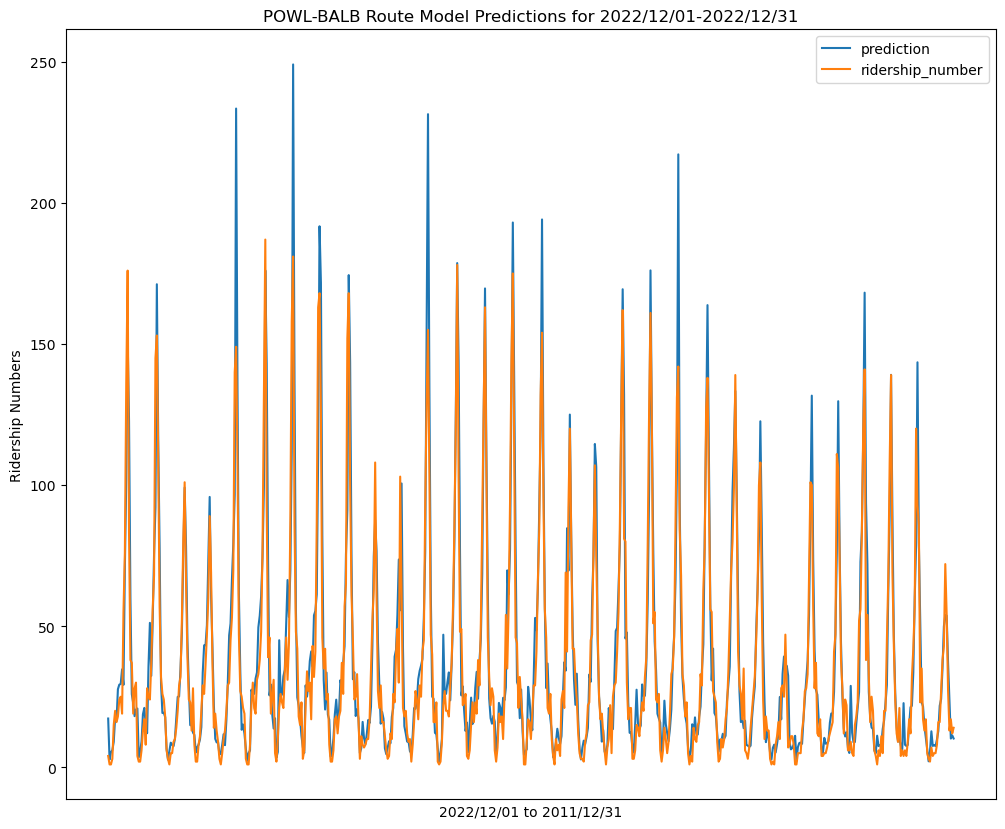

In [279]:
# import datetime
plt.figure(figsize=(12,10))
plt.plot('Period', 'prediction', label = "prediction", data=rf_predictions_pandas_2022_Jan)
plt.plot('Period', 'ridership_number', label = "ridership_number", data=rf_predictions_pandas_2022_Jan)
plt.legend()
plt.title('POWL-BALB Route Model Predictions for 2022/12/01-2022/12/31')
plt.ylabel('Ridership Numbers')
plt.xlabel('2022/12/01 to 2011/12/31')
plt.xticks([])

In [40]:
df = spark.read.parquet("s3a://w210-bucket/data_wrangling/final_df_prior_hr.parquet")
# casting certain columns to integer
df = df.withColumn('day_of_month', dayofmonth(df.date)) \
       .withColumn('day_of_year', dayofyear(df.date)) 
# df = df.withColumn('number_of_searches',col('number_of_searches').cast('integer'))
# df= df.withColumn("hour",col("hour").cast('integer')) \
#       .withColumn("year",col("year").cast('integer')) \
#       .withColumn("month",col("month").cast('integer')) \
#       .withColumn("quarter",col("quarter").cast('integer')) \
#       .withColumn("day_of_week",col("day_of_week").cast('integer')) \
#       .withColumn("day_of_month",col("day_of_month").cast('integer')) \
      # .withColumn("holiday_period",col("holiday_period").cast('integer')) \
      # .withColumn("event_origin",col("event_origin").cast('integer')) \
      # .withColumn("event_dest",col("event_dest").cast('integer'))
    

# mapping numbers to weather types for origin
df = df.withColumn("wth_type_origin_cat", when(df.wth_type_origin == "no_precipitation",0)
                                 .when(df.wth_type_origin == 'Rain',1)
                                 .when(df.wth_type_origin == 'hail',2)
                                 .when(df.wth_type_origin == 'Drizzle',3)
                                 .when(df.wth_type_origin == 'Snow',4))\
        .withColumn("wth_type_origin_cat",col("wth_type_origin_cat").cast('string'))

# mapping numbers to weather types for destination
df = df.withColumn("wth_type_dest_cat", when(df.wth_type_dest == "no_precipitation",0)
                                 .when(df.wth_type_dest == 'Rain',1)
                                 .when(df.wth_type_dest == 'hail',2)
                                 .when(df.wth_type_dest == 'Drizzle',3)
                                 .when(df.wth_type_dest == 'Snow',4))  \
       .withColumn("wth_type_dest_cat",col("wth_type_dest_cat").cast('string'))

In [41]:
df = df.filter(col('origin-des') == 'POWL-BALB')

In [43]:
columns_categorical = ['hour','day_of_week','month','day_of_month','quarter','day_of_year','event_dest',
                       'wth_type_origin_cat','wth_type_dest_cat','holiday_period']


columns_continues = ['wind_speed_origin','air_temp_origin','precipitation_origin',
                     'wind_speed_dest','air_temp_dest','precipitation_dest','number_of_searches']

indexer = StringIndexer(inputCol="hour", outputCol="hour_index")
df_final = indexer.fit(df).transform(df)
ohe = OneHotEncoder(inputCol="hour_index", outputCol="hour_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="day_of_week_index", outputCol="day_of_week_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="month", outputCol="month_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="month_index", outputCol="month_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="day_of_month", outputCol="day_of_month_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="day_of_month_index", outputCol="day_of_month_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="quarter", outputCol="quarter_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="quarter_index", outputCol="quarter_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="day_of_year", outputCol="day_of_year_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="day_of_year_index", outputCol="day_of_year_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="event_dest", outputCol="event_dest_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="event_dest_index", outputCol="event_dest_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="wth_type_origin_cat", outputCol="wth_type_origin_cat_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="wth_type_origin_cat_index", outputCol="wth_type_origin_cat_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="wth_type_dest_cat", outputCol="wth_type_dest_cat_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="wth_type_dest_cat_index", outputCol="wth_type_dest_cat_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)

indexer = StringIndexer(inputCol="holiday_period", outputCol="holiday_period_index")
df_final = indexer.fit(df_final).transform(df_final)
ohe = OneHotEncoder(inputCol="holiday_period_index", outputCol="holiday_period_index_ohe")
df_final = ohe.fit(df_final).transform(df_final)


assembler_categ = VectorAssembler(inputCols= ['hour_index_ohe','day_of_week_index_ohe','month_index_ohe',
                                              'day_of_month_index_ohe','quarter_index_ohe','day_of_year_index_ohe',
                                            
                                              'event_dest_index_ohe','wth_type_origin_cat_index_ohe','wth_type_dest_cat_index_ohe',
                                              'holiday_period_index_ohe'],
                           outputCol="cat_features")


# vectoring continues variables
assembler_cont = VectorAssembler(inputCols=columns_continues,
                                   outputCol="cont_features")

df_final = assembler_categ.transform(df_final)
df_final = assembler_cont.transform(df_final)
assembler = VectorAssembler(inputCols= ["cont_features","cat_features"],
                               outputCol="features")

df_final = assembler.transform(df_final)
 

In [44]:
df_final_1 = df_final.filter(col('year') != 2011)
processed_train_df = df_final_1.filter(col('year') != 2022).select('ridership_number','features')
processed_test_df =  df_final_1.filter(col('year') == 2022).select('ridership_number','features')

In [ ]:
# saving as parquet in S3 bucket
processed_train_df.write.parquet('s3a://w210-bucket/data_wrangling/processed_train_baseline.parquet',mode='overwrite')
processed_test_df.write.parquet('s3a://w210-bucket/data_wrangling/processed_test_baseline.parquet',mode='overwrite')

In [ ]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_baseline.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_baseline.parquet")
# processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
# processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='ridership_number')
lr_model = lr.fit(processed_train_df)

lr_predictions = lr_model.transform(processed_test_df)
test_result = lr_model.evaluate(processed_test_df)
print(f"Intercept: {lr_model.intercept}")
print(f"R2 : {test_result.r2}")
print(f"RMSE : {test_result.rootMeanSquaredError}")
print(f"MAE : {test_result.meanAbsoluteError}")

23/04/12 00:46:20 WARN Instrumentation: [b0c2a1b4] regParam is zero, which might cause numerical instability and overfitting.
23/04/12 00:46:20 WARN Instrumentation: [b0c2a1b4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
Intercept: -1.8675583111679452
R2 : -1.5327179582087789
RMSE : 59.46165295111278
MAE : 44.567964215395676


In [32]:
lr_predictions = lr_model.transform(processed_test_df)
lr_predictions_pandas = lr_predictions.toPandas()

In [ ]:
lr_predictions_pandas["Period"] = lr_predictions_pandas['date'].astype(str) +"-"+ lr_predictions_pandas["hour"]

# GBT Regresssor Model

In [ ]:
processed_train_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_train_df_1.parquet")
processed_test_df = spark.read.parquet("s3a://w210-bucket/data_wrangling/processed_test_df_1.parquet")
processed_train_df = processed_train_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")
processed_test_df  = processed_test_df.withColumn("log_ridership_number",log10(col('ridership_number'))).drop("ridership_number")

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxIter= 60)
gbt_model = gbt.fit(processed_train_df)
gbt_predictions = gbt_model.transform(processed_test_df)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
rmse_gbt = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
r2_gbt = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
mae_gbt = gbt_evaluator.evaluate(gbt_predictions)

print(f"RMSE: {rmse_gbt}")
print(f"r2: {r2_gbt}")
print(f"mae: {mae_gbt}")

gbt_model.save("s3a://w210-bucket/models/gbt_model_60.model")

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'log_ridership_number', maxIter= 75)
gbt_model = gbt.fit(processed_train_df)
gbt_predictions = gbt_model.transform(processed_test_df)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="rmse")
rmse_gbt = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="r2")
r2_gbt = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = RegressionEvaluator(
    labelCol="log_ridership_number", predictionCol="prediction", metricName="mae")
mae_gbt = gbt_evaluator.evaluate(gbt_predictions)

print(f"RMSE: {rmse_gbt}")
print(f"r2: {r2_gbt}")
print(f"mae: {mae_gbt}")

gbt_model.save("s3a://w210-bucket/models/gbt_model_75.model")